# Lecture IV: Attention Mechanism and Network Interpretability

In this homework, we will add attention mechanism to the recurrent neural network we developed in homework 3, and use it to perform network interpretability study.

First, we will re-define the RNN we developed last time, starting with the module loading:

In [1]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsnooper
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)
import matplotlib.gridspec as gridspec

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:

In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.test
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.test

File ‘ae.train’ already there; not retrieving.

File ‘ae.test’ already there; not retrieving.

File ‘size_ae.train’ already there; not retrieving.

File ‘size_ae.test’ already there; not retrieving.



This dataset contains 9 male japanese speaker pronouncing the utterance /ae/. The data is decoded by Linear Predictive Coding. A detail of LPC can be found [here](https://en.wikipedia.org/wiki/Linear_predictive_coding). Each utterance contains 12 LPC basis, thus for each time index, the time series will contain 12 channels.

## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. This is idential to it in homework 3:

In [3]:
class JapaneseVowelDataset(Dataset):

    def __init__(self,plot=True):
        self.max_length = 29 # The maximum possible length of each utterance contains 29 samples
        self.num_LPC = 12    # The LPC spectrum contains 12 coefficients, so the data shape will be [29,12]
        
        train_data, train_label = self.read_vowels("ae.train","size_ae.train")
        test_data, test_label = self.read_vowels("ae.test","size_ae.test")
        
        self.size = len(train_data) + len(test_data)
        self.train_test_split = len(train_data)
        
        self.data = train_data + test_data
        self.labels = train_label + test_label
        
        if plot:
            self.plot_data()
        
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        In this dataset, the data has variable length, so we need to pad 
        the LPC coefficients to have the same length for training purpose
        '''
        output = np.zeros((self.max_length, self.num_LPC))
        data = self.data[idx]
        output[:data.shape[0]] += data
        return output, self.labels[idx]
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    def read_vowels(self,file, size_file):
        vowel_units = []
        speaker_size = []
        labels = []
        #Read out the LPC value of all vowels
        with open(file, "r") as f:
            current_vowel = []
            for line in f.readlines():
                if line == '\n':
                    vowel_units.append(np.array(current_vowel))
                    current_vowel = []
                    continue
                current_vowel.append(np.array(line.strip().split(" "),dtype=float).tolist())
        #Read out the size of samples by 9 speakers
        with open(size_file, "r") as f:
            speaker_size = np.array(f.readline().strip().split(" "),dtype=int)
            assert len(speaker_size) == 9 # If speaker size is not 9, then there's something wrong
        #Assign a label to each speaker, speaker 1 == 0 .....speaker 9 == 8:
        for speaker_label in range(9):
            labels += [speaker_label] * speaker_size[speaker_label]
        # Check if the number of label equals to number of data
        # If not, there is something wrong
        assert len(vowel_units) == len(labels)
        return vowel_units, labels
            
                    
        
    
    def plot_data(self):
        '''
        This function plots the LPC spectrum of 9 random utterances
        '''
        plt.figure(figsize=(20,12))
        sample_index = np.random.randint(low=0,high=self.__len__(), size = 9)
        for i in range(9):
            plt.subplot(3,3, i+1)
            voice, label = self.__getitem__(sample_index[i])
            utt_length = voice.shape[0]
            for i in range(voice.shape[-1]):
                plt.plot(np.arange(utt_length), voice[:,i])
            plt.xlabel("Time Index")
            plt.ylabel("LPC Coefficients")

Similarly, we can check the form of data by plotting the LPC spectrum coefficients. The trailing 0s comes from the padding we performed within the dataset:

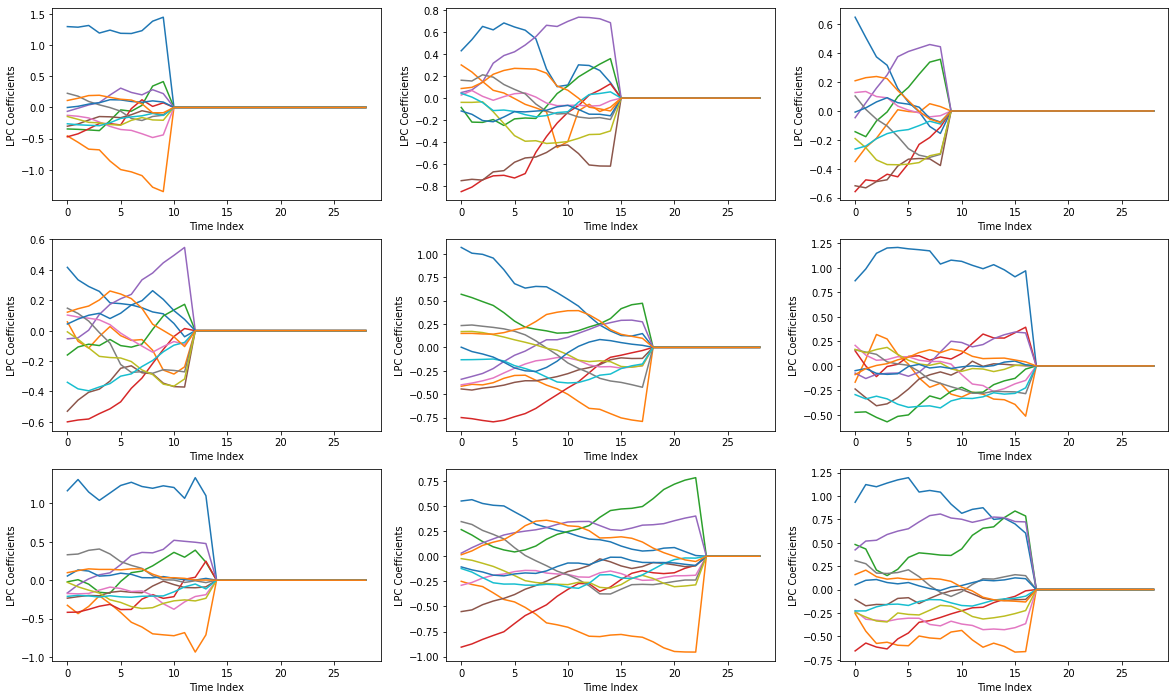

In [4]:
JapaneseVowelDataset()

## Part II: Recurrent Neural Network
In this part, we will add attention mechanism to a recurrent neural network model. A typical RNN model have been provided in the following code block. You could also copy and paste your RNN from homework 3 if you prefer. Your goal is to add attention mechanism to this RNN using weight kernel concatenation:
\begin{equation}
s(h_{i},h_{n})=h_{i}^{T}Wh_{n}
\end{equation}
Read the RNN code carefully, try to answer two questions:
- Why does `fc1` equal to 2 times the hidden_size of LSTM layer?
- Why does the `self.attention_weight` tensor read a dimension of `(hidden_size,hidden_size)`? How does it link back to the equation we listed above?

After answering that two questions, add the attention mechanism following the procedure below:

- Couple `self.attention_weight` and `output` to produce $s(h_{i},h_{n})$
- Feed $s(h_{i},h_{n})$ into a [softmax function](https://pytorch.org/docs/master/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax) to produce attention score
- multiply the attention score back to output to produce context vector
- concatenate context vector with last hidden state output to produce attention vector
- feed attention vector to the fully connected neural network

Some other reference materials: 
- [lecture slide](https://drive.google.com/file/d/1-CPfeV-rA460ZS1u_cbuDyJqhn0oz5Bl/view?usp=sharing), page 28-33
- [lecture video](https://www.youtube.com/watch?v=5C1yxV0bbSI), time 39:17-56:45

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        '''
        Initialize RNN with attention mechanism with 3 parts:
            A feature extractor based on LSTM network
            A fully connected classifier
            An attention kernel
        '''
        input_size = 12 #12 LPC basis per input
        seq_len = 29    # Sequence length of Japanese Vowel data
        hidden_size = 128
        
        self.RNNLayer = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        fc1, fc2, fc3, fc4 = np.linspace(hidden_size*2, 64,4,dtype=int)
        print(fc1, fc2, fc3, fc4)
        
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc2, fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc3, fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc4, 9),
        )
        self.attention_weight = Parameter(torch.empty(hidden_size,hidden_size).uniform_(-0.1, 0.1))
        
        ##Add softmax for getting the weights 
        
        
    #@torchsnooper.snoop()
    def forward(self, x):
        '''
        The forward operation of each training step of the neural network model
        '''
        batch_size = x.size(0) 
        output, (h, c) = self.RNNLayer(x)
        print('output', output.shape)
        '''
        Add attention mechanism here, you will need to code output and self.attention_weight together.
        ''' 
        
        w = self.attention_weight
        
        s = torch.matmul( output[0,:,:] , torch.matmul( w , h[0,0,:] ))
        #print('h', h[0,0,:].shape)
        print('s', s)
        
        score = nn.Softmax(dim =0)(s)
        print('score',score)
        
        context = torch.matmul(score,output)
        attention =  torch.cat((h[0,:,:], context), dim = 1)
        
        x = attention.view(batch_size, -1)    
        x = self.fcnet(attention)
        
        return x



Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand the tensor flow within the RNN network.

In [6]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = RNN()
print(test_network(test_event,))

256 192 128 64
output torch.Size([1, 29, 128])
s tensor([-0.0072, -0.0112, -0.0137, -0.0146, -0.0155, -0.0155, -0.0154, -0.0155,
        -0.0158, -0.0158, -0.0158, -0.0159, -0.0156, -0.0147, -0.0138, -0.0137,
        -0.0142, -0.0147, -0.0150, -0.0158, -0.0078, -0.0034, -0.0011,  0.0002,
         0.0008,  0.0012,  0.0014,  0.0016,  0.0017], grad_fn=<MvBackward0>)
score tensor([0.0346, 0.0344, 0.0344, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343,
        0.0343, 0.0343, 0.0343, 0.0343, 0.0343, 0.0344, 0.0344, 0.0343, 0.0343,
        0.0343, 0.0343, 0.0346, 0.0347, 0.0348, 0.0348, 0.0349, 0.0349, 0.0349,
        0.0349, 0.0349], grad_fn=<SoftmaxBackward0>)
tensor([[ 0.0699, -0.0517,  0.1437,  0.0691, -0.0346, -0.0717,  0.0562, -0.0568,
          0.1540]], grad_fn=<AddmmBackward0>)






## Part III: Training and Evaluation
After building the neural network, we train it the same way as we did in Lecture 3:

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =30
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=4

In [8]:
def set_up_classifier():
    classifier = RNN() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [9]:
def get_dataloader():
    dataset = JapaneseVowelDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [10]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)
        
        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
    #After every epoch, evaluate the validation accuracy on the test loader
    num_accurate = 0
    num_images = 0
    for utterances,labels in tqdm(test_loader):

        classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.
        
        #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
        with torch.no_grad():
            
            # Convey images to device, then feed it to the neural network for network output
            utterances = utterances.to(DEVICE).float()
            outputs  = classifier(utterances)
            
            # Get classification decision by reading out the maximum value on the 10-dimensional vector
            decision = torch.argmax(outputs, dim=-1)
            decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
            labels = labels.cpu().data.numpy().flatten()
            
            # Update the list of truth value and network predictions in last epoch:
            if epoch == (NUM_EPOCHS-1):
                y_true += list(labels)
                y_pred += list(decision)
            
            #Calculate accuracy by # of correct prediction / total numbers

            num_accurate += np.sum((decision - labels) == 0)
            num_images += len(decision)
    accuracy_values.append(num_accurate/num_images)  
torch.save(classifier.state_dict(), 'RNN.pt') # Save the trained RNN model

256 192 128 64
# of params in model:  171977


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0064, -0.0105, -0.0131, -0.0134, -0.0131, -0.0125, -0.0116, -0.0108,
        -0.0094, -0.0084, -0.0071, -0.0071, -0.0077, -0.0081, -0.0137, -0.0159,
        -0.0169, -0.0173, -0.0175, -0.0176, -0.0176, -0.0176, -0.0176, -0.0177,
        -0.0177, -0.0177, -0.0177, -0.0177, -0.0177], grad_fn=<MvBackward0>)
score tensor([0.0347, 0.0346, 0.0345, 0.0345, 0.0345, 0.0345, 0.0346, 0.0346, 0.0346,
        0.0347, 0.0347, 0.0347, 0.0347, 0.0347, 0.0345, 0.0344, 0.0344, 0.0344,
        0.0344, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343, 0.0343,
        0.0343, 0.0343], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0028, -0.0065, -0.0085, -0.0074, -0.0057, -0.0053, -0.0058, -0.0065,
        -0.0073, -0.0074, -0.0076, -0.0074, -0.0084, -0.0099, -0.0118, -0.0126,
        -0.0132, -0.0171, -0.0188, -0.0197, -0.0202, -0.0205, -0.0207, -0.0208,
        -0.0208, -0.0209, -0.0209, -0.0209, -0.0209], grad_fn=<MvBackward0>)

5it [00:00, 49.53it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0026,  0.0032,  0.0014, -0.0003, -0.0019, -0.0011, -0.0010, -0.0015,
        -0.0020, -0.0028, -0.0039, -0.0055, -0.0061, -0.0063, -0.0068, -0.0080,
        -0.0169, -0.0207, -0.0223, -0.0229, -0.0233, -0.0234, -0.0235, -0.0236,
        -0.0236, -0.0236, -0.0236, -0.0237, -0.0237], grad_fn=<MvBackward0>)
score tensor([0.0350, 0.0350, 0.0349, 0.0349, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348,
        0.0348, 0.0347, 0.0347, 0.0347, 0.0347, 0.0346, 0.0346, 0.0343, 0.0342,
        0.0341, 0.0341, 0.0341, 0.0341, 0.0341, 0.0341, 0.0341, 0.0341, 0.0341,
        0.0341, 0.0341], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0066,  0.0078,  0.0074,  0.0057,  0.0027,  0.0032,  0.0049,  0.0033,
         0.0033,  0.0044,  0.0037,  0.0013, -0.0010, -0.0021, -0.0038, -0.0062,
        -0.0152, -0.0194, -0.0214, -0.0224, -0.0229, -0.0232, -0.0234, -0.0235,
        -0.0236, -0.0236, -0.0236, -0.0236, -0.0237], grad_fn=<MvBackward0>)

12it [00:00, 59.66it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0176,  0.0192,  0.0239,  0.0291,  0.0293,  0.0304,  0.0336,  0.0331,
         0.0330,  0.0276,  0.0115, -0.0013, -0.0009,  0.0090,  0.0160, -0.0037,
        -0.0135, -0.0182, -0.0204, -0.0215, -0.0221, -0.0224, -0.0225, -0.0226,
        -0.0227, -0.0227, -0.0227, -0.0227, -0.0227], grad_fn=<MvBackward0>)
score tensor([0.0350, 0.0351, 0.0353, 0.0355, 0.0355, 0.0355, 0.0356, 0.0356, 0.0356,
        0.0354, 0.0348, 0.0344, 0.0344, 0.0348, 0.0350, 0.0343, 0.0340, 0.0338,
        0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337, 0.0337,
        0.0337, 0.0337], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 8.1197e-03,  1.0190e-02,  9.9551e-03,  6.9798e-03,  3.6164e-03,
        -4.8869e-05, -4.7581e-03, -1.0798e-02, -1.7394e-02, -2.1828e-02,
        -2.3153e-02, -2.3626e-02, -2.3628e-02, -2.3594e-02, -2.3601e-02,
        -2.3640e-02, -2.3688e-02, -2.3735e-02, -2.3772e-02, -2.3801e-02,
        -2.3821e-02, -2.

19it [00:00, 61.74it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0477,  0.0721,  0.0844,  0.0881,  0.0908,  0.0912,  0.0853,  0.0852,
         0.0889,  0.0865,  0.0846,  0.0816,  0.0742,  0.0717,  0.0781,  0.0785,
         0.0775,  0.0278,  0.0017, -0.0119, -0.0190, -0.0228, -0.0248, -0.0259,
        -0.0264, -0.0267, -0.0269, -0.0270, -0.0270], grad_fn=<MvBackward0>)
score tensor([0.0347, 0.0356, 0.0360, 0.0361, 0.0362, 0.0363, 0.0360, 0.0360, 0.0362,
        0.0361, 0.0360, 0.0359, 0.0356, 0.0356, 0.0358, 0.0358, 0.0358, 0.0340,
        0.0331, 0.0327, 0.0325, 0.0323, 0.0323, 0.0322, 0.0322, 0.0322, 0.0322,
        0.0322, 0.0322], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0305,  0.0501,  0.0574,  0.0557,  0.0539,  0.0565,  0.0599,  0.0634,
         0.0635,  0.0602,  0.0564,  0.0562,  0.0555,  0.0508,  0.0483,  0.0474,
         0.0126, -0.0058, -0.0155, -0.0208, -0.0237, -0.0252, -0.0261, -0.0266,
        -0.0268, -0.0270, -0.0271, -0.0271, -0.0271], grad_fn=<MvBackward0>)

26it [00:00, 62.77it/s]

tensor([ 0.0475,  0.0760,  0.0913,  0.0983,  0.1058,  0.1020,  0.0957,  0.0885,
         0.0856,  0.0872,  0.0802,  0.0721,  0.0793,  0.0842,  0.0801,  0.0768,
         0.0634,  0.0598,  0.0185, -0.0051, -0.0177, -0.0245, -0.0282, -0.0303,
        -0.0314, -0.0320, -0.0324, -0.0325, -0.0326], grad_fn=<MvBackward0>)
score tensor([0.0346, 0.0356, 0.0362, 0.0364, 0.0367, 0.0366, 0.0363, 0.0361, 0.0360,
        0.0360, 0.0358, 0.0355, 0.0357, 0.0359, 0.0358, 0.0356, 0.0352, 0.0350,
        0.0336, 0.0328, 0.0324, 0.0322, 0.0321, 0.0320, 0.0320, 0.0320, 0.0320,
        0.0320, 0.0320], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0644,  0.0890,  0.1100,  0.1386,  0.1616,  0.1647,  0.1532,  0.1582,
         0.1640,  0.1637,  0.1645,  0.1687,  0.1643,  0.1520,  0.1349,  0.1217,
         0.0499,  0.0109, -0.0101, -0.0215, -0.0277, -0.0312, -0.0331, -0.0341,
        -0.0346, -0.0349, -0.0351, -0.0352, -0.0352], grad_fn=<MvBackward0>)
score tensor([0.0342, 0.0350, 0.0

33it [00:00, 64.12it/s]

tensor([0.0370, 0.0380, 0.0381, 0.0378, 0.0376, 0.0373, 0.0369, 0.0363, 0.0358,
        0.0355, 0.0353, 0.0354, 0.0353, 0.0340, 0.0333, 0.0330, 0.0328, 0.0327,
        0.0326, 0.0326, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325,
        0.0325, 0.0325], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0711,  0.1107,  0.1396,  0.1508,  0.1572,  0.1555,  0.1616,  0.1670,
         0.1654,  0.1580,  0.1503,  0.1509,  0.1525,  0.1385,  0.1306,  0.0534,
         0.0108, -0.0125, -0.0253, -0.0324, -0.0363, -0.0385, -0.0397, -0.0403,
        -0.0407, -0.0408, -0.0409, -0.0410, -0.0410], grad_fn=<MvBackward0>)
score tensor([0.0347, 0.0361, 0.0371, 0.0375, 0.0378, 0.0377, 0.0380, 0.0382, 0.0381,
        0.0378, 0.0375, 0.0375, 0.0376, 0.0371, 0.0368, 0.0341, 0.0326, 0.0319,
        0.0315, 0.0313, 0.0311, 0.0311, 0.0310, 0.0310, 0.0310, 0.0310, 0.0310,
        0.0310, 0.0310], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0893,  0.137

40it [00:00, 64.42it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0830,  0.1281,  0.1546,  0.1831,  0.2049,  0.2255,  0.2454,  0.2676,
         0.2700,  0.2926,  0.2910,  0.2841,  0.2687,  0.2734,  0.2713,  0.2528,
         0.1303,  0.0587,  0.0170, -0.0075, -0.0220, -0.0305, -0.0355, -0.0384,
        -0.0401, -0.0411, -0.0416, -0.0420, -0.0421], grad_fn=<MvBackward0>)
score tensor([0.0329, 0.0344, 0.0353, 0.0363, 0.0371, 0.0379, 0.0386, 0.0395, 0.0396,
        0.0405, 0.0404, 0.0402, 0.0396, 0.0397, 0.0397, 0.0389, 0.0344, 0.0321,
        0.0307, 0.0300, 0.0296, 0.0293, 0.0292, 0.0291, 0.0290, 0.0290, 0.0290,
        0.0290, 0.0290], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0959,  0.1573,  0.1882,  0.2095,  0.2371,  0.2610,  0.2719,  0.2626,
         0.2399,  0.2234,  0.2155,  0.2047,  0.1933,  0.1870,  0.0947,  0.0399,
         0.0070, -0.0127, -0.0245, -0.0315, -0.0357, -0.0381, -0.0395, -0.0403,
        -0.0408, -0.0411, -0.0412, -0.0413, -0.0413], grad_fn=<MvBackward0>)

47it [00:00, 65.04it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0145,  0.0160, -0.0011, -0.0172, -0.0276, -0.0314, -0.0283, -0.0225,
        -0.0187, -0.0153, -0.0118, -0.0116, -0.0166, -0.0257, -0.0355, -0.0414,
        -0.0439, -0.0449, -0.0453, -0.0457, -0.0459, -0.0461, -0.0463, -0.0464,
        -0.0465, -0.0466, -0.0466, -0.0466, -0.0466], grad_fn=<MvBackward0>)
score tensor([0.0360, 0.0361, 0.0355, 0.0349, 0.0346, 0.0344, 0.0345, 0.0347, 0.0349,
        0.0350, 0.0351, 0.0351, 0.0349, 0.0346, 0.0343, 0.0341, 0.0340, 0.0340,
        0.0340, 0.0339, 0.0339, 0.0339, 0.0339, 0.0339, 0.0339, 0.0339, 0.0339,
        0.0339, 0.0339], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1566,  0.2421,  0.2997,  0.3292,  0.3218,  0.3195,  0.3139,  0.3017,
         0.2996,  0.3055,  0.3094,  0.2952,  0.2833,  0.2816,  0.2855,  0.2823,
         0.2677,  0.2513,  0.2463,  0.2410,  0.2351,  0.1219,  0.0545,  0.0138,
        -0.0109, -0.0259, -0.0349, -0.0404, -0.0437], grad_fn=<MvBackward0>)

54it [00:00, 64.67it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1578,  0.2391,  0.2751,  0.2855,  0.2704,  0.2494,  0.2132,  0.1746,
         0.1397,  0.1068,  0.0818,  0.0600,  0.0369,  0.0179,  0.0064, -0.0255,
        -0.0418, -0.0507, -0.0556, -0.0585, -0.0603, -0.0613, -0.0620, -0.0624,
        -0.0627, -0.0628, -0.0629, -0.0630, -0.0630], grad_fn=<MvBackward0>)
score tensor([0.0380, 0.0412, 0.0427, 0.0432, 0.0425, 0.0416, 0.0402, 0.0386, 0.0373,
        0.0361, 0.0352, 0.0345, 0.0337, 0.0330, 0.0327, 0.0316, 0.0311, 0.0309,
        0.0307, 0.0306, 0.0306, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305, 0.0305,
        0.0305, 0.0305], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1317,  0.2000,  0.2462,  0.2498,  0.2242,  0.2041,  0.1963,  0.1839,
         0.1661,  0.1568,  0.1620,  0.1715,  0.1764,  0.1464,  0.1117,  0.0398,
        -0.0012, -0.0256, -0.0404, -0.0495, -0.0552, -0.0588, -0.0610, -0.0625,
        -0.0634, -0.0640, -0.0644, -0.0647, -0.0648], grad_fn=<MvBackward0>)

61it [00:00, 64.88it/s]

tensor([ 0.0228,  0.0298,  0.0265,  0.0249,  0.0153,  0.0065, -0.0018, -0.0060,
        -0.0046, -0.0023, -0.0033, -0.0065, -0.0116, -0.0183, -0.0249, -0.0303,
        -0.0330, -0.0359, -0.0579, -0.0669, -0.0697, -0.0701, -0.0697, -0.0691,
        -0.0685, -0.0680, -0.0677, -0.0674, -0.0672], grad_fn=<MvBackward0>)
score tensor([0.0362, 0.0365, 0.0364, 0.0363, 0.0360, 0.0356, 0.0354, 0.0352, 0.0353,
        0.0353, 0.0353, 0.0352, 0.0350, 0.0348, 0.0345, 0.0344, 0.0343, 0.0342,
        0.0334, 0.0331, 0.0330, 0.0330, 0.0330, 0.0331, 0.0331, 0.0331, 0.0331,
        0.0331, 0.0331], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0818,  0.1109,  0.1224,  0.1091,  0.0814,  0.0573,  0.0476,  0.0550,
         0.0663,  0.0696,  0.0684,  0.0643,  0.0214, -0.0074, -0.0270, -0.0403,
        -0.0492, -0.0552, -0.0591, -0.0618, -0.0636, -0.0648, -0.0656, -0.0661,
        -0.0665, -0.0667, -0.0669, -0.0670, -0.0670], grad_fn=<MvBackward0>)
score tensor([0.0373, 0.0384, 0.0

67it [00:01, 63.63it/s]


tensor([ 0.1829,  0.2949,  0.3466,  0.3777,  0.4135,  0.4344,  0.4343,  0.4411,
         0.4490,  0.4795,  0.4978,  0.5133,  0.5167,  0.5143,  0.5112,  0.5137,
         0.5161,  0.5269,  0.5323,  0.5263,  0.5254,  0.3423,  0.2219,  0.1397,
         0.0821,  0.0410,  0.0113, -0.0104, -0.0264], grad_fn=<MvBackward0>)
score tensor([0.0285, 0.0319, 0.0336, 0.0346, 0.0359, 0.0367, 0.0367, 0.0369, 0.0372,
        0.0383, 0.0391, 0.0397, 0.0398, 0.0397, 0.0396, 0.0397, 0.0398, 0.0402,
        0.0404, 0.0402, 0.0401, 0.0334, 0.0296, 0.0273, 0.0258, 0.0247, 0.0240,
        0.0235, 0.0231], grad_fn=<SoftmaxBackward0>)
Epoch [1/30], Iter [67/67] Loss: 2.2342

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0298,  0.0350,  0.0344,  0.0282,  0.0022, -0.0259, -0.0534, -0.0800,
        -0.0986, -0.1114, -0.1047, -0.0901, -0.1002, -0.1091, -0.1112, -0.1091,
        -0.1055, -0.1016, -0.0979, -0.0946, -0.0919, -0.0897, -0.0879, -0.0864,
        -0.0853, -0.0843, -0.0836, -0.0831, -0.0826])
score tensor([0.0381, 0.0383, 0.0382, 0.0380, 0.0370, 0.0360, 0.0350, 0.0341, 0.0335,
        0.0331, 0.0333, 0.0338, 0.0334, 0.0331, 0.0331, 0.0331, 0.0333, 0.0334,
        0.0335, 0.0336, 0.0337, 0.0338, 0.0338, 0.0339, 0.0339, 0.0340, 0.0340,
        0.0340, 0.0340])
output torch.Size([4, 29, 128])
s tensor([ 0.0603,  0.0876,  0.0953,  0.0934,  0.0861,  0.0757,  0.0668,  0.0475,
         0.0175, -0.0088, -0.0268, -0.0470, -0.0725, -0.0816, -0.0709, -0.0575,
        -0.0861, -0.0979, -0.1010, -0.1002, -0.0980, -0.0955, -0.0930, -0.0908,
        -0.0889, -0.0873, -0.0860, -0.0850, -0.0842])
score tensor([0.0377, 0.0388, 0.0391, 0.0390, 0.0387, 0.0383, 0.0380, 0.0

 20%|█▉        | 18/92 [00:00<00:00, 179.38it/s]


s tensor([ 1.6240e-01,  2.8733e-01,  3.8869e-01,  4.2718e-01,  4.3739e-01,
         4.3788e-01,  4.2556e-01,  4.5446e-01,  4.8584e-01,  5.1117e-01,
         5.5617e-01,  5.6059e-01,  5.9721e-01,  3.9311e-01,  2.5949e-01,
         1.6873e-01,  1.0487e-01,  5.8809e-02,  2.4976e-02, -2.0128e-04,
        -1.9123e-02, -3.3448e-02, -4.4353e-02, -5.2688e-02, -5.9078e-02,
        -6.3987e-02, -6.7764e-02, -7.0673e-02, -7.2916e-02])
score tensor([0.0318, 0.0360, 0.0399, 0.0414, 0.0418, 0.0419, 0.0413, 0.0426, 0.0439,
        0.0450, 0.0471, 0.0473, 0.0491, 0.0400, 0.0350, 0.0320, 0.0300, 0.0287,
        0.0277, 0.0270, 0.0265, 0.0261, 0.0258, 0.0256, 0.0255, 0.0253, 0.0252,
        0.0252, 0.0251])
output torch.Size([4, 29, 128])
s tensor([ 0.1243,  0.2026,  0.2508,  0.2649,  0.2783,  0.2866,  0.2800,  0.2708,
         0.2899,  0.3068,  0.3280,  0.3436,  0.1907,  0.0990,  0.0422,  0.0057,
        -0.0186, -0.0352, -0.0470, -0.0554, -0.0616, -0.0662, -0.0696, -0.0722,
        -0.0742, -0.0758, 

output torch.Size([4, 29, 128])
s tensor([ 0.1781,  0.3129,  0.3910,  0.4423,  0.4881,  0.4979,  0.5107,  0.5099,
         0.5047,  0.4902,  0.4725,  0.4620,  0.4353,  0.4020,  0.3527,  0.3135,
         0.2731,  0.2384,  0.2062,  0.1816,  0.0861,  0.0302, -0.0043, -0.0265,
        -0.0413, -0.0516, -0.0590, -0.0643, -0.0682])
score tensor([0.0312, 0.0357, 0.0386, 0.0406, 0.0425, 0.0429, 0.0435, 0.0434, 0.0432,
        0.0426, 0.0418, 0.0414, 0.0403, 0.0390, 0.0371, 0.0357, 0.0343, 0.0331,
        0.0321, 0.0313, 0.0284, 0.0269, 0.0260, 0.0254, 0.0250, 0.0248, 0.0246,
        0.0245, 0.0244])
output torch.Size([4, 29, 128])
s tensor([ 0.1781,  0.2774,  0.3520,  0.3961,  0.4387,  0.4512,  0.4690,  0.4894,
         0.4987,  0.4876,  0.4924,  0.4994,  0.4905,  0.4879,  0.5029,  0.5135,
         0.5263,  0.5249,  0.5227,  0.3625,  0.2512,  0.1703,  0.1103,  0.0652,
         0.0313,  0.0056, -0.0140, -0.0289, -0.0403])
score tensor([0.0291, 0.0322, 0.0346, 0.0362, 0.0378, 0.0383, 0.0390, 0.0

 41%|████▏     | 38/92 [00:00<00:00, 188.76it/s]

tensor([0.0367, 0.0393, 0.0407, 0.0407, 0.0403, 0.0399, 0.0392, 0.0388, 0.0387,
        0.0386, 0.0388, 0.0387, 0.0356, 0.0338, 0.0326, 0.0319, 0.0314, 0.0310,
        0.0308, 0.0306, 0.0305, 0.0304, 0.0303, 0.0302, 0.0302, 0.0302, 0.0301,
        0.0301, 0.0301])
output torch.Size([4, 29, 128])
s tensor([ 0.0303,  0.0549,  0.0552,  0.0512,  0.0742,  0.0971,  0.0743,  0.0487,
         0.0320,  0.0011, -0.0166, -0.0048,  0.0049, -0.0384, -0.0613, -0.0728,
        -0.0784, -0.0811, -0.0822, -0.0826, -0.0826, -0.0825, -0.0823, -0.0821,
        -0.0819, -0.0817, -0.0816, -0.0815, -0.0814])
score tensor([0.0364, 0.0373, 0.0373, 0.0371, 0.0380, 0.0389, 0.0380, 0.0371, 0.0364,
        0.0353, 0.0347, 0.0351, 0.0355, 0.0340, 0.0332, 0.0328, 0.0326, 0.0325,
        0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325,
        0.0325, 0.0325])
output torch.Size([4, 29, 128])
s tensor([ 0.1378,  0.2265,  0.2847,  0.3077,  0.3186,  0.3406,  0.3605,  0.3730,
         0.3747,  0.36

 63%|██████▎   | 58/92 [00:00<00:00, 190.35it/s]

tensor([ 0.0921,  0.1349,  0.1535,  0.1681,  0.1853,  0.1894,  0.1866,  0.1844,
         0.1752,  0.1568,  0.1378,  0.1213,  0.1051,  0.0936,  0.0867,  0.0045,
        -0.0377, -0.0594, -0.0706, -0.0764, -0.0794, -0.0809, -0.0815, -0.0818,
        -0.0819, -0.0818, -0.0817, -0.0816, -0.0815])
score tensor([0.0361, 0.0376, 0.0383, 0.0389, 0.0396, 0.0397, 0.0396, 0.0395, 0.0392,
        0.0385, 0.0377, 0.0371, 0.0365, 0.0361, 0.0359, 0.0330, 0.0317, 0.0310,
        0.0306, 0.0305, 0.0304, 0.0303, 0.0303, 0.0303, 0.0303, 0.0303, 0.0303,
        0.0303, 0.0303])
output torch.Size([4, 29, 128])
s tensor([ 0.1549,  0.2149,  0.2367,  0.2394,  0.2234,  0.1959,  0.1624,  0.1330,
         0.1093,  0.0846,  0.0612,  0.0410,  0.0276,  0.0137, -0.0007, -0.0101,
        -0.0166, -0.0203, -0.0232, -0.0253, -0.0315, -0.0616, -0.0753, -0.0812,
        -0.0835, -0.0842, -0.0842, -0.0839, -0.0836])
score tensor([0.0385, 0.0409, 0.0418, 0.0419, 0.0412, 0.0401, 0.0388, 0.0376, 0.0368,
        0.0359, 0.035

output torch.Size([4, 29, 128])
s tensor([ 0.1008,  0.1853,  0.2288,  0.2450,  0.2547,  0.2623,  0.2858,  0.2966,
         0.2956,  0.2773,  0.2620,  0.2623,  0.2476,  0.2540,  0.2665,  0.1359,
         0.0590,  0.0124, -0.0168, -0.0358, -0.0485, -0.0572, -0.0633, -0.0677,
        -0.0709, -0.0733, -0.0751, -0.0764, -0.0774])
score tensor([0.0337, 0.0367, 0.0383, 0.0389, 0.0393, 0.0396, 0.0405, 0.0410, 0.0409,
        0.0402, 0.0396, 0.0396, 0.0390, 0.0393, 0.0398, 0.0349, 0.0323, 0.0308,
        0.0300, 0.0294, 0.0290, 0.0288, 0.0286, 0.0285, 0.0284, 0.0283, 0.0283,
        0.0282, 0.0282])
output torch.Size([4, 29, 128])
s tensor([ 0.1588,  0.2711,  0.3073,  0.3276,  0.3291,  0.3376,  0.3527,  0.3627,
         0.3730,  0.3724,  0.3717,  0.3594,  0.3481,  0.3404,  0.3382,  0.3394,
         0.2017,  0.1150,  0.0585,  0.0203, -0.0064, -0.0254, -0.0391, -0.0492,
        -0.0567, -0.0623, -0.0666, -0.0698, -0.0723])
score tensor([0.0332, 0.0372, 0.0385, 0.0393, 0.0394, 0.0397, 0.0403, 0.0

score tensor([0.0379, 0.0383, 0.0380, 0.0374, 0.0365, 0.0358, 0.0353, 0.0349, 0.0347,
        0.0347, 0.0346, 0.0343, 0.0336, 0.0333, 0.0332, 0.0332, 0.0332, 0.0333,
        0.0333, 0.0334, 0.0334, 0.0334, 0.0335, 0.0335, 0.0335, 0.0335, 0.0335,
        0.0335, 0.0335])
output torch.Size([4, 29, 128])
s tensor([ 0.1387,  0.2193,  0.2721,  0.3192,  0.3502,  0.3772,  0.3938,  0.3815,
         0.3558,  0.3179,  0.2750,  0.2293,  0.1913,  0.0823,  0.0217, -0.0134,
        -0.0347, -0.0482, -0.0572, -0.0634, -0.0678, -0.0710, -0.0734, -0.0752,
        -0.0765, -0.0776, -0.0783, -0.0789, -0.0794])
score tensor([0.0351, 0.0380, 0.0401, 0.0420, 0.0434, 0.0445, 0.0453, 0.0447, 0.0436,
        0.0420, 0.0402, 0.0384, 0.0370, 0.0332, 0.0312, 0.0301, 0.0295, 0.0291,
        0.0288, 0.0287, 0.0285, 0.0285, 0.0284, 0.0283, 0.0283, 0.0283, 0.0282,
        0.0282, 0.0282])
output torch.Size([4, 29, 128])
s tensor([ 0.1666,  0.2399,  0.2425,  0.2403,  0.2187,  0.1975,  0.1850,  0.1858,
         0.1972,

 85%|████████▍ | 78/92 [00:00<00:00, 191.77it/s]

tensor([ 0.0143,  0.0325,  0.0464,  0.0279,  0.0069, -0.0009, -0.0015, -0.0103,
        -0.0194, -0.0282, -0.0499, -0.0785, -0.1012, -0.1072, -0.1075, -0.1049,
        -0.1014, -0.0978, -0.0947, -0.0920, -0.0897, -0.0879, -0.0865, -0.0853,
        -0.0844, -0.0837, -0.0831, -0.0826, -0.0823])
score tensor([0.0370, 0.0376, 0.0382, 0.0375, 0.0367, 0.0364, 0.0364, 0.0361, 0.0357,
        0.0354, 0.0347, 0.0337, 0.0329, 0.0327, 0.0327, 0.0328, 0.0329, 0.0330,
        0.0331, 0.0332, 0.0333, 0.0334, 0.0334, 0.0335, 0.0335, 0.0335, 0.0335,
        0.0335, 0.0336])
output torch.Size([4, 29, 128])
s tensor([ 0.1877,  0.2978,  0.3545,  0.3708,  0.4085,  0.4226,  0.4220,  0.4333,
         0.4283,  0.4604,  0.4897,  0.5308,  0.5655,  0.5956,  0.3853,  0.2499,
         0.1594,  0.0966,  0.0519,  0.0194, -0.0047, -0.0226, -0.0362, -0.0465,
        -0.0543, -0.0603, -0.0649, -0.0685, -0.0712])
score tensor([0.0324, 0.0362, 0.0383, 0.0389, 0.0404, 0.0410, 0.0410, 0.0414, 0.0412,
        0.0426, 0.043

100%|██████████| 92/92 [00:00<00:00, 190.66it/s]


tensor([0.0349, 0.0374, 0.0385, 0.0388, 0.0390, 0.0390, 0.0389, 0.0390, 0.0387,
        0.0385, 0.0388, 0.0388, 0.0387, 0.0382, 0.0378, 0.0384, 0.0342, 0.0320,
        0.0307, 0.0300, 0.0295, 0.0292, 0.0290, 0.0288, 0.0287, 0.0287, 0.0286,
        0.0286, 0.0285])
output torch.Size([4, 29, 128])
s tensor([ 0.0365,  0.0516,  0.0467,  0.0235, -0.0049, -0.0372, -0.0518, -0.0647,
        -0.0805, -0.0734, -0.0729, -0.0843, -0.1040, -0.1260, -0.1435, -0.1514,
        -0.1579, -0.1308, -0.1159, -0.1067, -0.1006, -0.0961, -0.0928, -0.0903,
        -0.0883, -0.0868, -0.0856, -0.0846, -0.0838])
score tensor([0.0385, 0.0391, 0.0389, 0.0380, 0.0369, 0.0357, 0.0352, 0.0348, 0.0342,
        0.0345, 0.0345, 0.0341, 0.0334, 0.0327, 0.0321, 0.0319, 0.0317, 0.0325,
        0.0330, 0.0333, 0.0335, 0.0337, 0.0338, 0.0339, 0.0340, 0.0340, 0.0340,
        0.0341, 0.0341])
output torch.Size([4, 29, 128])
s tensor([ 0.1129,  0.1582,  0.1725,  0.1698,  0.1537,  0.1404,  0.1236,  0.0993,
         0.0765,  0.05

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1381,  0.2180,  0.2723,  0.3126,  0.3419,  0.3775,  0.4070,  0.4302,
         0.4483,  0.4568,  0.4668,  0.4767,  0.4899,  0.3362,  0.2301,  0.1534,
         0.0968,  0.0545,  0.0226, -0.0015, -0.0199, -0.0339, -0.0446, -0.0528,
        -0.0592, -0.0640, -0.0678, -0.0707, -0.0729], grad_fn=<MvBackward0>)
score tensor([0.0323, 0.0350, 0.0370, 0.0385, 0.0397, 0.0411, 0.0423, 0.0433, 0.0441,
        0.0445, 0.0449, 0.0454, 0.0460, 0.0394, 0.0355, 0.0328, 0.0310, 0.0298,
        0.0288, 0.0281, 0.0276, 0.0272, 0.0269, 0.0267, 0.0266, 0.0264, 0.0263,
        0.0263, 0.0262], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0791,  0.1214,  0.1326,  0.1170,  0.1012,  0.1003,  0.1017,  0.1063,
         0.1029,  0.0930,  0.0883,  0.0797,  0.0802,  0.0838,  0.0845,  0.0893,
         0.0123, -0.0300, -0.0535, -0.0668, -0.0745, -0.0791, -0.0818, -0.0835,
        -0.0846, -0.0853, -0.0858, -0.0861, -0.0864], grad_fn=<MvBackward0>)

7it [00:00, 65.30it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3177,  0.4790,  0.5403,  0.5470,  0.5161,  0.4528,  0.3782,  0.3056,
         0.2226,  0.1447,  0.0628, -0.0300, -0.1171, -0.1814, -0.2275, -0.2646,
        -0.2916, -0.3104, -0.3171, -0.3171, -0.3165, -0.3211, -0.3187, -0.4135,
        -0.4593, -0.4777, -0.4821, -0.4796, -0.4736], grad_fn=<MvBackward0>)
score tensor([0.0472, 0.0554, 0.0590, 0.0594, 0.0575, 0.0540, 0.0501, 0.0466, 0.0429,
        0.0397, 0.0366, 0.0333, 0.0305, 0.0286, 0.0274, 0.0264, 0.0257, 0.0252,
        0.0250, 0.0250, 0.0250, 0.0249, 0.0250, 0.0227, 0.0217, 0.0213, 0.0212,
        0.0213, 0.0214], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1577, 0.2570, 0.3491, 0.4644, 0.6183, 0.7773, 0.9056, 1.0177, 1.1132,
        1.2344, 1.1593, 1.1118, 1.0764, 1.0470, 1.0200, 0.9938, 0.9672, 0.9397,
        0.9107, 0.8802, 0.8479, 0.8138, 0.7776, 0.7395, 0.6993, 0.6569, 0.6126,
        0.5662, 0.5181], grad_fn=<MvBackward0>)
score tensor([0.0175, 0.0193

14it [00:00, 65.25it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3855,  0.6240,  0.8403,  1.0675,  1.3850,  1.8352,  2.4139,  3.1630,
         4.1685,  5.4146,  6.7593,  8.2843, 10.1646, 11.0904, 12.0138, 12.9214,
        13.8069, 14.6565, 15.4543, 16.1858, 16.8409, 17.4150, 17.9084, 18.3261,
        18.6752, 18.9643, 19.2023, 19.3972, 19.5566], grad_fn=<MvBackward0>)
score tensor([1.1101e-09, 1.4091e-09, 1.7493e-09, 2.1956e-09, 3.0161e-09, 4.7312e-09,
        8.4387e-09, 1.7849e-08, 4.8788e-08, 1.6962e-07, 6.5080e-07, 2.9908e-06,
        1.9605e-05, 4.9482e-05, 1.2459e-04, 3.0878e-04, 7.4848e-04, 1.7506e-03,
        3.8874e-03, 8.0790e-03, 1.5555e-02, 2.7616e-02, 4.5235e-02, 6.8683e-02,
        9.7378e-02, 1.3003e-01, 1.6496e-01, 2.0047e-01, 2.3511e-01],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4932,  0.8907,  1.2645,  1.6216,  1.9010,  2.0720,  2.2050,  2.3593,
         2.5396,  2.7381,  2.9742,  3.2557,  3.5816,  3.9730,  4.4778,  5.1597,
         6.0500,  7.1938,

21it [00:00, 65.18it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2274,  0.3544,  0.4262,  0.4677,  0.4948,  0.5343,  0.6211,  0.6868,
         0.7715,  0.8175,  0.9019,  0.6923,  0.5609,  0.4729,  0.4084,  0.3563,
         0.3107,  0.2681,  0.2268,  0.1858,  0.1447,  0.1035,  0.0621,  0.0209,
        -0.0199, -0.0599, -0.0990, -0.1369, -0.1732], grad_fn=<MvBackward0>)
score tensor([0.0297, 0.0338, 0.0363, 0.0378, 0.0389, 0.0404, 0.0441, 0.0471, 0.0512,
        0.0537, 0.0584, 0.0473, 0.0415, 0.0380, 0.0356, 0.0338, 0.0323, 0.0310,
        0.0297, 0.0285, 0.0274, 0.0263, 0.0252, 0.0242, 0.0232, 0.0223, 0.0215,
        0.0207, 0.0199], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3708,  0.5756,  0.6238,  0.5566,  0.4339,  0.3305,  0.2230,  0.1309,
         0.0472, -0.0133, -0.0392, -0.0454, -0.0443, -0.0502, -0.0722, -0.0910,
        -0.1113, -0.1136, -0.1076, -0.0977, -0.0912, -0.1040, -0.1324, -0.3690,
        -0.5255, -0.6092, -0.6602, -0.6921, -0.7128], grad_fn=<MvBackward0>)

28it [00:00, 64.96it/s]

tensor([0.0039, 0.0055, 0.0070, 0.0079, 0.0090, 0.0103, 0.0111, 0.0107, 0.0111,
        0.0121, 0.0138, 0.0159, 0.0187, 0.0244, 0.0306, 0.0364, 0.0417, 0.0368,
        0.0362, 0.0387, 0.0427, 0.0479, 0.0540, 0.0606, 0.0677, 0.0751, 0.0826,
        0.0901, 0.0975], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([1.1070, 1.7226, 2.0732, 2.3387, 2.5524, 2.8194, 3.0664, 3.3040, 3.5715,
        3.8170, 4.0742, 4.2854, 3.7477, 3.5563, 3.5696, 3.6878, 3.8615, 4.0625,
        4.2739, 4.4852, 4.6897, 4.8830, 5.0626, 5.2269, 5.3755, 5.5086, 5.6268,
        5.7311, 5.8226], grad_fn=<MvBackward0>)
score tensor([0.0011, 0.0021, 0.0029, 0.0038, 0.0047, 0.0062, 0.0079, 0.0100, 0.0131,
        0.0168, 0.0217, 0.0268, 0.0157, 0.0129, 0.0131, 0.0148, 0.0176, 0.0215,
        0.0265, 0.0327, 0.0402, 0.0487, 0.0583, 0.0687, 0.0798, 0.0911, 0.1026,
        0.1138, 0.1247], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.7499, 1.1752, 1.5413, 2.0008, 2.5016, 3.04

35it [00:00, 64.03it/s]

tensor([ 0.1840,  0.3222,  0.4007,  0.4051,  0.4219,  0.4088,  0.4067,  0.4631,
         0.5010,  0.5038,  0.5396,  0.5832,  0.6319,  0.6609,  0.6907,  0.4411,
         0.2914,  0.1960,  0.1321,  0.0872,  0.0546,  0.0304,  0.0121, -0.0018,
        -0.0123, -0.0202, -0.0260, -0.0303, -0.0332], grad_fn=<MvBackward0>)
score tensor([0.0303, 0.0348, 0.0377, 0.0378, 0.0385, 0.0380, 0.0379, 0.0401, 0.0416,
        0.0418, 0.0433, 0.0452, 0.0475, 0.0489, 0.0503, 0.0392, 0.0338, 0.0307,
        0.0288, 0.0275, 0.0266, 0.0260, 0.0255, 0.0252, 0.0249, 0.0247, 0.0246,
        0.0245, 0.0244], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1401, 0.2038, 0.2544, 0.2965, 0.3169, 0.2970, 0.2721, 0.2765, 0.2798,
        0.2944, 0.2727, 0.2666, 0.3035, 0.3333, 0.3310, 0.3227, 0.3408, 0.1925,
        0.1161, 0.0776, 0.0591, 0.0514, 0.0495, 0.0506, 0.0533, 0.0568, 0.0605,
        0.0644, 0.0681], grad_fn=<MvBackward0>)
score tensor([0.0324, 0.0345, 0.0363, 0.0379, 0.0386, 0.0379, 

42it [00:00, 64.71it/s]

output torch.Size([4, 29, 128])
s tensor([0.1294, 0.1947, 0.2315, 0.2477, 0.2635, 0.2880, 0.3137, 0.3456, 0.3564,
        0.3619, 0.3647, 0.3644, 0.2288, 0.1482, 0.0994, 0.0694, 0.0510, 0.0396,
        0.0325, 0.0282, 0.0256, 0.0241, 0.0232, 0.0228, 0.0226, 0.0225, 0.0225,
        0.0226, 0.0227], grad_fn=<MvBackward0>)
score tensor([0.0335, 0.0357, 0.0371, 0.0377, 0.0383, 0.0392, 0.0402, 0.0415, 0.0420,
        0.0422, 0.0423, 0.0423, 0.0370, 0.0341, 0.0325, 0.0315, 0.0309, 0.0306,
        0.0304, 0.0302, 0.0302, 0.0301, 0.0301, 0.0301, 0.0301, 0.0301, 0.0301,
        0.0301, 0.0301], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0723, 0.1062, 0.1529, 0.2095, 0.2368, 0.2534, 0.2652, 0.2818, 0.3059,
        0.3426, 0.3826, 0.4231, 0.4675, 0.4751, 0.3544, 0.2768, 0.2268, 0.1932,
        0.1696, 0.1524, 0.1394, 0.1293, 0.1211, 0.1145, 0.1089, 0.1042, 0.1002,
        0.0967, 0.0936], grad_fn=<MvBackward0>)
score tensor([0.0296, 0.0306, 0.0320, 0.0339, 0.0348, 0.0

49it [00:00, 64.31it/s]

tensor([0.2651, 0.4174, 0.5232, 0.6105, 0.6950, 0.7799, 0.8555, 0.9439, 1.0448,
        1.1435, 1.2328, 1.3075, 1.3853, 1.1406, 0.9986, 0.9120, 0.8572, 0.8214,
        0.7972, 0.7804, 0.7683, 0.7593, 0.7522, 0.7466, 0.7418, 0.7376, 0.7339,
        0.7305, 0.7273], grad_fn=<MvBackward0>)
score tensor([0.0189, 0.0220, 0.0245, 0.0267, 0.0291, 0.0317, 0.0342, 0.0373, 0.0413,
        0.0456, 0.0498, 0.0537, 0.0580, 0.0454, 0.0394, 0.0361, 0.0342, 0.0330,
        0.0322, 0.0317, 0.0313, 0.0310, 0.0308, 0.0306, 0.0305, 0.0304, 0.0302,
        0.0301, 0.0300], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.7505,  1.5505,  2.3576,  3.5807,  5.2564,  7.4422,  9.8690, 12.9271,
        16.3497, 19.8981, 23.2183, 26.1069, 28.3351, 29.7365, 30.7082, 31.2928,
        31.6527, 31.8577, 30.9880, 30.7520, 30.6318, 30.5584, 30.5068, 30.4681,
        30.4382, 30.4146, 30.3957, 30.3806, 30.3685], grad_fn=<MvBackward0>)
score tensor([5.2948e-15, 1.1784e-14, 2.6412e-14, 8.9744e-14, 

56it [00:00, 64.66it/s]

output torch.Size([4, 29, 128])
s tensor([0.2964, 0.5708, 0.7713, 0.8888, 1.0543, 1.2516, 1.5666, 1.8690, 2.1171,
        2.3245, 2.5309, 2.7112, 2.8389, 3.0407, 3.3133, 3.5147, 3.3227, 3.3164,
        3.4221, 3.5929, 3.8055, 4.0470, 4.3097, 4.5889, 4.8809, 5.1823, 5.4896,
        5.7989, 6.1063], grad_fn=<MvBackward0>)
score tensor([0.0007, 0.0009, 0.0011, 0.0013, 0.0015, 0.0018, 0.0025, 0.0034, 0.0044,
        0.0054, 0.0066, 0.0079, 0.0090, 0.0110, 0.0145, 0.0177, 0.0146, 0.0145,
        0.0161, 0.0191, 0.0237, 0.0301, 0.0392, 0.0518, 0.0694, 0.0938, 0.1276,
        0.1738, 0.2363], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.4952, 1.0279, 1.6025, 2.1979, 2.8314, 3.5704, 4.3896, 5.2243, 5.9773,
        6.6994, 7.3565, 7.9326, 8.4433, 8.1643, 8.0795, 8.0981, 8.1639, 8.2546,
        8.3566, 8.4621, 8.5664, 8.6667, 8.7614, 8.8499, 8.9316, 9.0067, 9.0752,
        9.1375, 9.1940], grad_fn=<MvBackward0>)
score tensor([1.5637e-05, 2.6639e-05, 4.7322e-05, 8.5827e

63it [00:00, 64.51it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0709,  0.1102,  0.1194,  0.1293,  0.1309,  0.1132,  0.0867,  0.0618,
         0.0532,  0.0641,  0.0544,  0.0356,  0.0293,  0.0317,  0.0460,  0.0591,
         0.0613,  0.0817,  0.0306,  0.0018, -0.0151, -0.0259, -0.0334, -0.0391,
        -0.0436, -0.0474, -0.0507, -0.0535, -0.0559], grad_fn=<MvBackward0>)
score tensor([0.0357, 0.0371, 0.0375, 0.0378, 0.0379, 0.0372, 0.0363, 0.0354, 0.0351,
        0.0354, 0.0351, 0.0345, 0.0342, 0.0343, 0.0348, 0.0353, 0.0354, 0.0361,
        0.0343, 0.0333, 0.0328, 0.0324, 0.0322, 0.0320, 0.0318, 0.0317, 0.0316,
        0.0315, 0.0314], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1476, 0.2653, 0.3854, 0.4510, 0.4921, 0.5460, 0.6390, 0.7700, 0.9905,
        1.2958, 1.6297, 1.5480, 1.5050, 1.4674, 1.4293, 1.3879, 1.3421, 1.2916,
        1.2362, 1.1758, 1.1106, 1.0409, 0.9671, 0.8899, 0.8099, 0.7281, 0.6455,
        0.5633, 0.4827], grad_fn=<MvBackward0>)
score tensor([0.0143, 0.0161

67it [00:01, 64.61it/s]


tensor([ 0.5467,  1.1564,  1.6434,  2.2766,  3.0257,  3.7218,  4.5706,  5.6526,
         6.8757,  8.1435,  9.5962, 11.2520, 12.9143, 14.5522, 15.8251, 16.9559,
        17.9519, 18.6868, 19.2421, 19.6178, 19.8943, 20.1253, 20.2748, 19.6914,
        19.4801, 19.3557, 19.2657, 19.1943, 19.1351], grad_fn=<MvBackward0>)
score tensor([4.3592e-10, 8.0206e-10, 1.3052e-09, 2.4586e-09, 5.2001e-09, 1.0431e-08,
        2.4375e-08, 7.1925e-08, 2.4437e-07, 8.6829e-07, 3.7115e-06, 1.9438e-05,
        1.0247e-04, 5.2711e-04, 1.8825e-03, 5.8321e-03, 1.5791e-02, 3.2926e-02,
        5.7372e-02, 8.3537e-02, 1.1014e-01, 1.3876e-01, 1.6113e-01, 8.9917e-02,
        7.2793e-02, 6.4276e-02, 5.8743e-02, 5.4693e-02, 5.1552e-02],
       grad_fn=<SoftmaxBackward0>)
Epoch [2/30], Iter [67/67] Loss: 1.9331

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0981,  0.1546,  0.1916,  0.2127,  0.2263,  0.2299,  0.2328,  0.2410,
         0.2550,  0.2703,  0.2733,  0.2740,  0.2717,  0.2718,  0.2860,  0.1851,
         0.1189,  0.0726,  0.0395,  0.0154, -0.0026, -0.0162, -0.0267, -0.0348,
        -0.0412, -0.0463, -0.0504, -0.0536, -0.0563])
score tensor([0.0333, 0.0353, 0.0366, 0.0374, 0.0379, 0.0380, 0.0381, 0.0385, 0.0390,
        0.0396, 0.0397, 0.0397, 0.0397, 0.0397, 0.0402, 0.0364, 0.0340, 0.0325,
        0.0314, 0.0307, 0.0301, 0.0297, 0.0294, 0.0292, 0.0290, 0.0289, 0.0287,
        0.0286, 0.0286])
output torch.Size([4, 29, 128])
s tensor([0.0905, 0.1759, 0.2642, 0.3807, 0.4885, 0.6282, 0.7852, 0.9430, 1.1084,
        1.2778, 1.4394, 1.5906, 1.7205, 1.8351, 1.9319, 2.0244, 2.0963, 1.8239,
        1.6243, 1.4611, 1.3152, 1.1807, 1.0547, 0.9359, 0.8242, 0.7199, 0.6235,
        0.5356, 0.4567])
score tensor([0.0108, 0.0118, 0.0129, 0.0145, 0.0161, 0.0186, 0.0217, 0.0254, 0.0300,
        0.0355, 

score tensor([0.0349, 0.0355, 0.0358, 0.0364, 0.0369, 0.0377, 0.0385, 0.0386, 0.0387,
        0.0388, 0.0388, 0.0388, 0.0391, 0.0356, 0.0338, 0.0328, 0.0322, 0.0319,
        0.0317, 0.0315, 0.0314, 0.0314, 0.0313, 0.0313, 0.0313, 0.0313, 0.0313,
        0.0313, 0.0313])


 22%|██▏       | 20/92 [00:00<00:00, 193.89it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0300,  0.0401,  0.0500,  0.0559,  0.0438,  0.0355,  0.0391,  0.0580,
         0.0840,  0.1084,  0.1142,  0.1139,  0.1135,  0.1219,  0.1397,  0.1688,
         0.1866,  0.1172,  0.0732,  0.0430,  0.0211,  0.0043, -0.0090, -0.0198,
        -0.0287, -0.0362, -0.0424, -0.0477, -0.0521])
score tensor([0.0336, 0.0340, 0.0343, 0.0345, 0.0341, 0.0338, 0.0339, 0.0346, 0.0355,
        0.0364, 0.0366, 0.0366, 0.0366, 0.0369, 0.0375, 0.0386, 0.0393, 0.0367,
        0.0351, 0.0341, 0.0333, 0.0328, 0.0324, 0.0320, 0.0317, 0.0315, 0.0313,
        0.0311, 0.0310])
output torch.Size([4, 29, 128])
s tensor([ 0.7453,  1.3744,  2.0195,  2.7438,  3.5972,  4.5548,  5.6396,  6.8884,
         8.2573,  9.8068, 11.3678, 12.9294, 14.3119, 15.5288, 16.5173, 17.2420,
        17.7870, 17.2685, 17.1405, 17.0750, 17.0310, 16.9958, 16.9656, 16.9392,
        16.9157, 16.8948, 16.8762, 16.8597, 16.8449])
score tensor([5.3496e-09, 1.0035e-08, 1.9130e-08, 3.9469e-08, 9.2661e-08,

s tensor([ 0.0400,  0.0410,  0.0323,  0.0264,  0.0240,  0.0347,  0.0492,  0.0630,
         0.0797,  0.1001,  0.1209,  0.1356,  0.1405,  0.1432,  0.1423,  0.0610,
         0.0117, -0.0188, -0.0379, -0.0496, -0.0565, -0.0601, -0.0616, -0.0616,
        -0.0608, -0.0594, -0.0579, -0.0562, -0.0545])
score tensor([0.0351, 0.0351, 0.0348, 0.0346, 0.0345, 0.0349, 0.0354, 0.0359, 0.0365,
        0.0372, 0.0380, 0.0386, 0.0388, 0.0389, 0.0388, 0.0358, 0.0341, 0.0330,
        0.0324, 0.0320, 0.0318, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0318,
        0.0318, 0.0319])
output torch.Size([4, 29, 128])
s tensor([ 0.0540,  0.0642,  0.0696,  0.0748,  0.0652,  0.0555,  0.0573,  0.0740,
         0.0821,  0.0743,  0.0846,  0.1009,  0.1153,  0.1319,  0.1418,  0.1427,
         0.1529,  0.1602,  0.1033,  0.0670,  0.0412,  0.0213,  0.0055, -0.0077,
        -0.0187, -0.0281, -0.0360, -0.0428, -0.0485])
score tensor([0.0342, 0.0345, 0.0347, 0.0349, 0.0346, 0.0342, 0.0343, 0.0349, 0.0352,
        0.0349, 0.0

 43%|████▎     | 40/92 [00:00<00:00, 191.51it/s]

tensor([ 0.0312,  0.0476,  0.0319,  0.0145,  0.0111,  0.0092,  0.0058,  0.0087,
         0.0141,  0.0224,  0.0372,  0.0597,  0.0825,  0.1075,  0.1169,  0.1285,
         0.1588,  0.0835,  0.0407,  0.0144, -0.0031, -0.0156, -0.0250, -0.0325,
        -0.0387, -0.0438, -0.0481, -0.0518, -0.0549])
score tensor([0.0347, 0.0352, 0.0347, 0.0341, 0.0340, 0.0339, 0.0338, 0.0339, 0.0341,
        0.0344, 0.0349, 0.0357, 0.0365, 0.0374, 0.0378, 0.0382, 0.0394, 0.0365,
        0.0350, 0.0341, 0.0335, 0.0331, 0.0328, 0.0325, 0.0323, 0.0322, 0.0320,
        0.0319, 0.0318])
output torch.Size([4, 29, 128])
s tensor([0.0920, 0.1364, 0.1754, 0.1971, 0.2075, 0.2220, 0.2393, 0.2624, 0.2780,
        0.2991, 0.3133, 0.3281, 0.3499, 0.3757, 0.3992, 0.4137, 0.4250, 0.4366,
        0.4478, 0.4601, 0.4708, 0.4746, 0.2979, 0.1900, 0.1197, 0.0725, 0.0402,
        0.0182, 0.0031])
score tensor([0.0287, 0.0300, 0.0311, 0.0318, 0.0322, 0.0326, 0.0332, 0.0340, 0.0345,
        0.0352, 0.0358, 0.0363, 0.0371, 0.0381, 0.

output torch.Size([4, 29, 128])
s tensor([ 0.0410,  0.0504,  0.0517,  0.0552,  0.0552,  0.0499,  0.0508,  0.0630,
         0.0794,  0.0862,  0.0899,  0.0209, -0.0206, -0.0458, -0.0607, -0.0689,
        -0.0729, -0.0742, -0.0740, -0.0729, -0.0713, -0.0695, -0.0677, -0.0660,
        -0.0644, -0.0630, -0.0618, -0.0607, -0.0597])
score tensor([0.0363, 0.0367, 0.0367, 0.0368, 0.0369, 0.0367, 0.0367, 0.0371, 0.0378,
        0.0380, 0.0382, 0.0356, 0.0342, 0.0333, 0.0328, 0.0326, 0.0324, 0.0324,
        0.0324, 0.0324, 0.0325, 0.0325, 0.0326, 0.0326, 0.0327, 0.0327, 0.0328,
        0.0328, 0.0328])


 65%|██████▌   | 60/92 [00:00<00:00, 180.94it/s]

output torch.Size([4, 29, 128])
s tensor([0.0764, 0.0980, 0.1100, 0.1614, 0.2546, 0.5205, 0.7645, 0.8718, 0.8690,
        0.9123, 1.0444, 1.4032, 1.9484, 2.4426, 3.0656, 3.7036, 4.4172, 5.2111,
        6.0976, 7.0840, 8.1942, 8.3329, 8.5495, 8.7587, 8.9611, 9.1600, 9.3574,
        9.5544, 9.7515])
score tensor([1.3246e-05, 1.3534e-05, 1.3698e-05, 1.4422e-05, 1.5830e-05, 2.0651e-05,
        2.6358e-05, 2.9344e-05, 2.9263e-05, 3.0556e-05, 3.4871e-05, 4.9922e-05,
        8.6118e-05, 1.4116e-04, 2.6320e-04, 4.9814e-04, 1.0168e-03, 2.2493e-03,
        5.4582e-03, 1.4636e-02, 4.4420e-02, 5.1029e-02, 6.3370e-02, 7.8115e-02,
        9.5645e-02, 1.1669e-01, 1.4215e-01, 1.7312e-01, 2.1082e-01])
output torch.Size([4, 29, 128])
s tensor([ 0.1013,  0.1770,  0.2159,  0.2157,  0.2106,  0.2115,  0.2166,  0.2220,
         0.2247,  0.2206,  0.2222,  0.2385,  0.2608,  0.2803,  0.2988,  0.3023,
         0.2137,  0.1583,  0.1192,  0.0889,  0.0640,  0.0427,  0.0242,  0.0082,
        -0.0056, -0.0176, -0.027

score tensor([0.0326, 0.0334, 0.0335, 0.0334, 0.0336, 0.0352, 0.0380, 0.0412, 0.0429,
        0.0457, 0.0486, 0.0425, 0.0391, 0.0369, 0.0353, 0.0341, 0.0332, 0.0324,
        0.0317, 0.0311, 0.0306, 0.0302, 0.0299, 0.0296, 0.0294, 0.0292, 0.0290,
        0.0289, 0.0288])
output torch.Size([4, 29, 128])
s tensor([ 0.0639,  0.0831,  0.0948,  0.1045,  0.1193,  0.1352,  0.1427,  0.1612,
         0.1827,  0.2023,  0.2188,  0.2283,  0.2354,  0.1115,  0.0383, -0.0058,
        -0.0322, -0.0479, -0.0569, -0.0617, -0.0640, -0.0648, -0.0647, -0.0641,
        -0.0633, -0.0623, -0.0614, -0.0605, -0.0597])
score tensor([0.0349, 0.0356, 0.0360, 0.0363, 0.0369, 0.0375, 0.0377, 0.0384, 0.0393,
        0.0401, 0.0407, 0.0411, 0.0414, 0.0366, 0.0340, 0.0325, 0.0317, 0.0312,
        0.0309, 0.0308, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0307, 0.0308,
        0.0308, 0.0308])
output torch.Size([4, 29, 128])
s tensor([ 0.0300,  0.0356,  0.0343,  0.0209,  0.0224,  0.0325,  0.0529,  0.0710,
         0.0857,

 86%|████████▌ | 79/92 [00:00<00:00, 184.00it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.4062,  0.6305,  0.8238,  1.1046,  1.3886,  1.7467,  2.2432,  2.7014,
         3.1236,  3.5883,  4.1567,  4.8363,  5.6767,  6.7621,  7.7928,  8.8574,
         8.9607,  9.1665,  9.3688,  9.5690,  9.7695,  9.9719, 10.1766, 10.3835,
        10.5920, 10.8010, 11.0090, 11.2147, 11.4165])
score tensor([3.2202e-06, 4.0302e-06, 4.8897e-06, 6.4746e-06, 8.6011e-06, 1.2305e-05,
        2.0216e-05, 3.1969e-05, 4.8760e-05, 7.7605e-05, 1.3700e-04, 2.7031e-04,
        6.2641e-04, 1.8546e-03, 5.1986e-03, 1.5073e-02, 1.6713e-02, 2.0533e-02,
        2.5137e-02, 3.0709e-02, 3.7528e-02, 4.5944e-02, 5.6381e-02, 6.9343e-02,
        8.5417e-02, 1.0527e-01, 1.2962e-01, 1.5922e-01, 1.9481e-01])
output torch.Size([4, 29, 128])
s tensor([ 0.0604,  0.0929,  0.1401,  0.2037,  0.2430,  0.2947,  0.3376,  0.3766,
         0.4478,  0.5361,  0.6212,  0.5130,  0.4423,  0.3874,  0.3399,  0.2960,
         0.2546,  0.2153,  0.1784,  0.1441,  0.1127,  0.0843,  0.0591,  0.0369,
   

100%|██████████| 92/92 [00:00<00:00, 185.83it/s]


tensor([0.2460, 0.4477, 0.6249, 0.8258, 0.9784, 1.0786, 1.2208, 1.4215, 1.5388,
        1.7523, 2.0493, 2.3864, 2.8064, 3.2396, 3.6220, 4.0939, 4.6777, 5.3783,
        6.0621, 6.9017, 7.7143, 7.8517, 8.0444, 8.2259, 8.4021, 8.5770, 8.7530,
        8.9315, 9.1129])
score tensor([2.7605e-05, 3.3772e-05, 4.0320e-05, 4.9290e-05, 5.7416e-05, 6.3470e-05,
        7.3170e-05, 8.9430e-05, 1.0056e-04, 1.2449e-04, 1.6754e-04, 2.3472e-04,
        3.5722e-04, 5.5089e-04, 8.0750e-04, 1.2944e-03, 2.3207e-03, 4.6761e-03,
        9.2653e-03, 2.1453e-02, 4.8353e-02, 5.5470e-02, 6.7259e-02, 8.0652e-02,
        9.6190e-02, 1.1457e-01, 1.3662e-01, 1.6331e-01, 1.9579e-01])


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0967,  0.1601,  0.2013,  0.2230,  0.2501,  0.2720,  0.2812,  0.3057,
         0.3404,  0.3806,  0.4297,  0.4508,  0.4648,  0.4857,  0.3799,  0.3083,
         0.2535,  0.2083,  0.1692,  0.1346,  0.1040,  0.0767,  0.0527,  0.0316,
         0.0133, -0.0025, -0.0161, -0.0276, -0.0375], grad_fn=<MvBackward0>)
score tensor([0.0305, 0.0325, 0.0339, 0.0346, 0.0356, 0.0364, 0.0367, 0.0376, 0.0389,
        0.0405, 0.0426, 0.0435, 0.0441, 0.0450, 0.0405, 0.0377, 0.0357, 0.0341,
        0.0328, 0.0317, 0.0307, 0.0299, 0.0292, 0.0286, 0.0281, 0.0276, 0.0273,
        0.0269, 0.0267], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0331,  0.0348,  0.0291,  0.0160,  0.0087,  0.0131,  0.0234,  0.0470,
         0.0776,  0.1076,  0.1249,  0.1451,  0.1575,  0.1558,  0.1627,  0.1570,
         0.0696,  0.0175, -0.0150, -0.0351, -0.0474, -0.0548, -0.0590, -0.0612,
        -0.0623, -0.0626, -0.0626, -0.0623, -0.0620], grad_fn=<MvBackward0>)

7it [00:00, 65.82it/s]

output torch.Size([4, 29, 128])
s tensor([0.3628, 0.6623, 1.0345, 1.3441, 1.7243, 2.0562, 2.3533, 2.8091, 3.5374,
        4.2254, 4.9846, 5.8569, 6.7603, 7.5701, 8.1772, 8.8297, 9.5775, 9.2389,
        9.0836, 8.9390, 8.7949, 8.6501, 8.5043, 8.3574, 8.2090, 8.0587, 7.9060,
        7.7504, 7.5911], grad_fn=<MvBackward0>)
score tensor([1.5906e-05, 2.1461e-05, 3.1139e-05, 4.2437e-05, 6.2067e-05, 8.6499e-05,
        1.1642e-04, 1.8365e-04, 3.8044e-04, 7.5695e-04, 1.6173e-03, 3.8692e-03,
        9.5494e-03, 2.1462e-02, 3.9384e-02, 7.5629e-02, 1.5976e-01, 1.1387e-01,
        9.7494e-02, 8.4367e-02, 7.3046e-02, 6.3196e-02, 5.4623e-02, 4.7159e-02,
        4.0655e-02, 3.4982e-02, 3.0029e-02, 2.5701e-02, 2.1918e-02],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0609,  0.0968,  0.1446,  0.2058,  0.2774,  0.3450,  0.4051,  0.4578,
         0.5070,  0.5592,  0.5973,  0.6195,  0.6216,  0.6201,  0.6194,  0.4400,
         0.3193,  0.2340,  0.1712,  0.1238,  0.0874,  

14it [00:00, 63.60it/s]

s tensor([ 0.3007,  0.3400,  0.3849,  0.6491,  1.2021,  1.9677,  3.0357,  4.3212,
         5.9721,  7.9981, 10.2943, 12.8537, 15.5508, 18.0981, 18.7707, 19.5697,
        20.2592, 20.8333, 21.3029, 21.6833, 21.9892, 22.2345, 22.4309, 22.5881,
        22.7143, 22.8157, 22.8975, 22.9636, 23.0173], grad_fn=<MvBackward0>)
score tensor([1.9226e-11, 1.9996e-11, 2.0915e-11, 2.7239e-11, 4.7351e-11, 1.0182e-10,
        2.9627e-10, 1.0714e-09, 5.5836e-09, 4.2344e-08, 4.2077e-07, 5.4397e-06,
        8.0709e-05, 1.0308e-03, 2.0197e-03, 4.4902e-03, 8.9486e-03, 1.5887e-02,
        2.5411e-02, 3.7171e-02, 5.0476e-02, 6.4507e-02, 7.8501e-02, 9.1869e-02,
        1.0422e-01, 1.1535e-01, 1.2518e-01, 1.3374e-01, 1.4112e-01],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1599,  0.3595,  0.6131,  0.9380,  1.3288,  1.7852,  2.3880,  3.0495,
         3.6918,  4.3369,  4.9927,  5.6449,  6.2567,  6.8572,  7.4728,  8.0636,
         8.6031,  9.0501,  9.3937,  9.6551,  9.8571, 10.0

21it [00:00, 61.63it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1291,  0.1966,  0.2413,  0.2679,  0.2865,  0.2779,  0.2676,  0.2694,
         0.2761,  0.2730,  0.2687,  0.1356,  0.0598,  0.0163, -0.0089, -0.0237,
        -0.0325, -0.0378, -0.0412, -0.0433, -0.0448, -0.0458, -0.0466, -0.0471,
        -0.0476, -0.0480, -0.0483, -0.0485, -0.0488], grad_fn=<MvBackward0>)
score tensor([0.0358, 0.0383, 0.0401, 0.0411, 0.0419, 0.0416, 0.0411, 0.0412, 0.0415,
        0.0414, 0.0412, 0.0360, 0.0334, 0.0320, 0.0312, 0.0307, 0.0305, 0.0303,
        0.0302, 0.0301, 0.0301, 0.0301, 0.0300, 0.0300, 0.0300, 0.0300, 0.0300,
        0.0300, 0.0300], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0921, 0.1396, 0.1882, 0.2480, 0.3255, 0.4216, 0.5386, 0.6788, 0.8237,
        0.9524, 1.0574, 1.1440, 1.2061, 1.2474, 1.2854, 1.3326, 1.3919, 1.4416,
        1.4755, 1.5019, 1.5255, 1.2394, 1.0584, 0.9245, 0.8171, 0.7269, 0.6487,
        0.5798, 0.5186], grad_fn=<MvBackward0>)
score tensor([0.0143, 0.0150

28it [00:00, 62.55it/s]

output torch.Size([4, 29, 128])
s tensor([ 3.9530e-02,  4.6566e-02,  5.3866e-02,  7.0039e-02,  8.3592e-02,
         1.0319e-01,  1.0406e-01,  7.0411e-02,  3.9139e-02,  1.8980e-02,
         2.3976e-02,  4.5837e-02,  6.6449e-02,  9.1235e-02,  1.0335e-01,
         3.5597e-02, -6.3261e-05, -1.9195e-02, -2.9801e-02, -3.5982e-02,
        -3.9855e-02, -4.2507e-02, -4.4490e-02, -4.6082e-02, -4.7419e-02,
        -4.8570e-02, -4.9570e-02, -5.0439e-02, -5.1193e-02],
       grad_fn=<MvBackward0>)
score tensor([0.0352, 0.0355, 0.0357, 0.0363, 0.0368, 0.0375, 0.0376, 0.0363, 0.0352,
        0.0345, 0.0347, 0.0354, 0.0362, 0.0371, 0.0375, 0.0351, 0.0339, 0.0332,
        0.0329, 0.0327, 0.0325, 0.0324, 0.0324, 0.0323, 0.0323, 0.0322, 0.0322,
        0.0322, 0.0322], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1482, 0.3554, 0.6412, 0.9895, 1.3515, 1.7237, 2.1389, 2.5724, 3.0091,
        3.4193, 3.7870, 4.1126, 4.3555, 4.5251, 4.6635, 4.7861, 4.8576, 4.1018,
        3.7044, 3

35it [00:00, 63.16it/s]

s tensor([-0.0299, -0.0289,  0.0674,  0.2204,  0.4331,  0.8161,  1.3286,  1.9075,
         2.5851,  3.3534,  4.1754,  4.9651,  5.7308,  6.4274,  7.0296,  7.5008,
         7.8269,  8.0263,  8.1395,  7.1287,  6.6420,  6.3520,  6.1609,  6.0306,
         5.9394,  5.8743,  5.8270,  5.7921,  5.7661], grad_fn=<MvBackward0>)
score tensor([5.2954e-05, 5.3005e-05, 5.8363e-05, 6.8011e-05, 8.4133e-05, 1.2339e-04,
        2.0600e-04, 3.6753e-04, 7.2368e-04, 1.5603e-03, 3.5500e-03, 7.8194e-03,
        1.6816e-02, 3.3748e-02, 6.1631e-02, 9.8724e-02, 1.3679e-01, 1.6697e-01,
        1.8699e-01, 6.8052e-02, 4.1828e-02, 3.1296e-02, 2.5853e-02, 2.2696e-02,
        2.0717e-02, 1.9410e-02, 1.8513e-02, 1.7879e-02, 1.7420e-02],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0492, 0.1862, 0.3346, 0.5594, 0.8492, 1.2179, 1.6263, 2.1111, 2.6096,
        3.1031, 3.5704, 4.0018, 4.4121, 4.7985, 5.1470, 5.4441, 4.7600, 4.4271,
        4.2432, 4.1378, 4.0801, 4.0523, 4.0441, 4.0487, 4

42it [00:00, 62.52it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0101,  0.0162,  0.0240,  0.0237,  0.0064, -0.0004, -0.0113, -0.0223,
        -0.0282, -0.0325, -0.0166, -0.0020,  0.0047,  0.0055,  0.0167,  0.0254,
         0.0262,  0.0399,  0.0556, -0.0055, -0.0361, -0.0512, -0.0585, -0.0619,
        -0.0633, -0.0638, -0.0638, -0.0637, -0.0636], grad_fn=<MvBackward0>)
score tensor([0.0353, 0.0355, 0.0358, 0.0358, 0.0352, 0.0349, 0.0345, 0.0342, 0.0340,
        0.0338, 0.0344, 0.0349, 0.0351, 0.0351, 0.0355, 0.0358, 0.0359, 0.0363,
        0.0369, 0.0347, 0.0337, 0.0332, 0.0329, 0.0328, 0.0328, 0.0328, 0.0328,
        0.0328, 0.0328], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.7278,  1.1498,  1.3863,  1.6316,  1.9729,  2.6061,  3.3226,  4.1384,
         5.2154,  6.5409,  8.0853,  9.8749, 10.2488, 10.7327, 11.2573, 11.8376,
        12.4823, 13.1946, 13.9722, 14.8066, 15.6827, 16.5791, 17.4693, 18.3253,
        19.1215, 19.8383, 20.4646, 20.9978, 21.4421], grad_fn=<MvBackward0>)

49it [00:00, 63.53it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0621,  0.1101,  0.1238,  0.1254,  0.1188,  0.1027,  0.0869,  0.0962,
         0.1183,  0.1497,  0.1909,  0.2279,  0.2603,  0.2935,  0.1720,  0.0999,
         0.0537,  0.0222, -0.0003, -0.0171, -0.0300, -0.0399, -0.0478, -0.0540,
        -0.0589, -0.0629, -0.0660, -0.0685, -0.0706], grad_fn=<MvBackward0>)
score tensor([0.0342, 0.0359, 0.0364, 0.0364, 0.0362, 0.0356, 0.0350, 0.0354, 0.0362,
        0.0373, 0.0389, 0.0403, 0.0417, 0.0431, 0.0381, 0.0355, 0.0339, 0.0328,
        0.0321, 0.0316, 0.0312, 0.0309, 0.0306, 0.0304, 0.0303, 0.0302, 0.0301,
        0.0300, 0.0299], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0371,  0.0548,  0.0363,  0.0207,  0.0177,  0.0425,  0.0443,  0.0674,
         0.1086,  0.1368,  0.1454,  0.1521,  0.1580,  0.1599,  0.1600,  0.1625,
         0.1654,  0.1726,  0.1827,  0.1887,  0.1921,  0.0881,  0.0284, -0.0091,
        -0.0332, -0.0488, -0.0590, -0.0657, -0.0701], grad_fn=<MvBackward0>)

56it [00:00, 64.09it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0834,  0.1551,  0.2109,  0.2624,  0.3081,  0.3772,  0.4512,  0.5284,
         0.6020,  0.6656,  0.7238,  0.7869,  0.8650,  0.9521,  1.0441,  1.1333,
         0.9504,  0.8154,  0.6980,  0.5901,  0.4893,  0.3955,  0.3096,  0.2327,
         0.1654,  0.1078,  0.0595,  0.0196, -0.0129], grad_fn=<MvBackward0>)
score tensor([0.0219, 0.0236, 0.0249, 0.0262, 0.0274, 0.0294, 0.0317, 0.0342, 0.0368,
        0.0392, 0.0416, 0.0443, 0.0479, 0.0523, 0.0573, 0.0626, 0.0522, 0.0456,
        0.0405, 0.0364, 0.0329, 0.0300, 0.0275, 0.0255, 0.0238, 0.0225, 0.0214,
        0.0206, 0.0199], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.3820, 0.7852, 1.1774, 1.5609, 1.9985, 2.3948, 2.7361, 3.0400, 3.3727,
        3.7619, 4.1041, 4.3479, 4.6320, 4.8884, 5.0654, 5.2183, 5.2637, 5.3516,
        4.7765, 4.4123, 4.0925, 3.7886, 3.4897, 3.1911, 2.8904, 2.5875, 2.2836,
        1.9817, 1.6860], grad_fn=<MvBackward0>)
score tensor([0.0009, 0.0013

63it [00:00, 63.98it/s]

s tensor([ 0.0332,  0.0521,  0.0589,  0.0460,  0.0498,  0.0781,  0.1052,  0.1288,
         0.1657,  0.2140,  0.2343,  0.2419,  0.2563,  0.2463,  0.1338,  0.0649,
         0.0200, -0.0104, -0.0318, -0.0474, -0.0591, -0.0681, -0.0751, -0.0807,
        -0.0853, -0.0890, -0.0921, -0.0946, -0.0968], grad_fn=<MvBackward0>)
score tensor([0.0339, 0.0345, 0.0347, 0.0343, 0.0344, 0.0354, 0.0364, 0.0373, 0.0387,
        0.0406, 0.0414, 0.0417, 0.0423, 0.0419, 0.0374, 0.0349, 0.0334, 0.0324,
        0.0317, 0.0312, 0.0309, 0.0306, 0.0304, 0.0302, 0.0301, 0.0300, 0.0299,
        0.0298, 0.0297], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.3023, 0.5520, 0.7732, 0.9505, 1.1963, 1.4647, 1.7545, 2.0603, 2.3754,
        2.6838, 2.9955, 3.2621, 3.5025, 3.7358, 3.9658, 4.1037, 3.7559, 3.5134,
        3.2906, 3.0749, 2.8614, 2.6476, 2.4321, 2.2146, 1.9953, 1.7754, 1.5568,
        1.3423, 1.1350], grad_fn=<MvBackward0>)
score tensor([0.0028, 0.0035, 0.0044, 0.0053, 0.0067, 0.0088

67it [00:01, 63.47it/s]


tensor([0.0320, 0.0315, 0.0316, 0.0318, 0.0322, 0.0331, 0.0339, 0.0352, 0.0365,
        0.0384, 0.0407, 0.0431, 0.0457, 0.0483, 0.0419, 0.0385, 0.0364, 0.0349,
        0.0337, 0.0327, 0.0319, 0.0312, 0.0305, 0.0300, 0.0296, 0.0292, 0.0288,
        0.0285, 0.0283], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0404,  0.0697,  0.0919,  0.1120,  0.1391,  0.1558,  0.1707,  0.1816,
         0.2154,  0.2517,  0.2797,  0.3002,  0.3178,  0.3346,  0.3532,  0.3812,
         0.2041,  0.1022,  0.0387, -0.0032, -0.0323, -0.0536, -0.0700, -0.0830,
        -0.0936, -0.1025, -0.1100, -0.1165, -0.1223], grad_fn=<MvBackward0>)
score tensor([0.0320, 0.0330, 0.0337, 0.0344, 0.0353, 0.0359, 0.0365, 0.0369, 0.0382,
        0.0396, 0.0407, 0.0415, 0.0423, 0.0430, 0.0438, 0.0450, 0.0377, 0.0341,
        0.0320, 0.0307, 0.0298, 0.0292, 0.0287, 0.0283, 0.0280, 0.0278, 0.0276,
        0.0274, 0.0272], grad_fn=<SoftmaxBackward0>)
Epoch [3/30], Iter [67/67] Loss: 1.7675

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.2312, -0.3530, -0.3642, -0.2706, -0.2009, -0.0846,  0.1175,  0.3615,
         0.4727,  0.5166,  0.5417,  0.5836,  0.6071,  0.5756,  0.1140, -0.1529,
        -0.3156, -0.4167, -0.4806, -0.5219, -0.5494, -0.5687, -0.5830, -0.5944,
        -0.6043, -0.6136, -0.6227, -0.6320, -0.6418])
score tensor([0.0292, 0.0259, 0.0256, 0.0281, 0.0301, 0.0338, 0.0414, 0.0528, 0.0590,
        0.0617, 0.0633, 0.0660, 0.0675, 0.0654, 0.0412, 0.0316, 0.0268, 0.0243,
        0.0228, 0.0218, 0.0212, 0.0208, 0.0205, 0.0203, 0.0201, 0.0199, 0.0197,
        0.0196, 0.0194])
output torch.Size([4, 29, 128])
s tensor([ 0.1124,  0.1451,  0.1534,  0.1665,  0.1757,  0.1875,  0.1972,  0.2118,
         0.2388,  0.2688,  0.3094,  0.1003, -0.0152, -0.0804, -0.1176, -0.1391,
        -0.1515, -0.1587, -0.1628, -0.1652, -0.1665, -0.1672, -0.1676, -0.1678,
        -0.1679, -0.1680, -0.1680, -0.1680, -0.1680])
score tensor([0.0383, 0.0396, 0.0399, 0.0404, 0.0408, 0.0413, 0.0417, 0.0

 21%|██        | 19/92 [00:00<00:00, 181.92it/s]

output torch.Size([4, 29, 128])
s tensor([-0.3398, -0.6093, -0.7925, -0.9284, -0.9805, -0.9591, -0.9076, -0.7723,
        -0.6585, -0.4800, -0.3256, -0.2989, -0.4041, -0.6047, -1.5577, -2.1196,
        -2.5023, -2.7849, -3.0046, -3.1824, -3.3302, -3.4554, -3.5627, -3.6552,
        -3.7352, -3.8042, -3.8639, -3.9153, -3.9596])
score tensor([0.0854, 0.0652, 0.0543, 0.0474, 0.0450, 0.0460, 0.0484, 0.0554, 0.0621,
        0.0742, 0.0866, 0.0890, 0.0801, 0.0655, 0.0253, 0.0144, 0.0098, 0.0074,
        0.0059, 0.0050, 0.0043, 0.0038, 0.0034, 0.0031, 0.0029, 0.0027, 0.0025,
        0.0024, 0.0023])
output torch.Size([4, 29, 128])
s tensor([-0.1177, -0.1708, -0.1711, -0.1326, -0.0226,  0.1042,  0.2296,  0.4112,
         0.5451,  0.5994,  0.5750,  0.4576,  0.2834, -0.7568, -1.3631, -1.7707,
        -2.0658, -2.2932, -2.4786, -2.6370, -2.7774, -2.9049, -3.0223, -3.1309,
        -3.2314, -3.3238, -3.4082, -3.4846, -3.5532])
score tensor([0.0489, 0.0463, 0.0463, 0.0481, 0.0537, 0.0610, 0.0692, 0.0

s tensor([-0.0961, -0.1582, -0.1678, -0.1898, -0.1666, -0.0548,  0.1203,  0.3657,
         0.6074,  0.7885,  0.9233,  1.0035,  0.9477,  0.7714, -0.3757, -1.0500,
        -1.4970, -1.8157, -2.0574, -2.2515, -2.4153, -2.5590, -2.6890, -2.8085,
        -2.9196, -3.0230, -3.1189, -3.2073, -3.2881])
score tensor([0.0379, 0.0356, 0.0352, 0.0345, 0.0353, 0.0394, 0.0470, 0.0601, 0.0765,
        0.0917, 0.1049, 0.1137, 0.1075, 0.0901, 0.0286, 0.0146, 0.0093, 0.0068,
        0.0053, 0.0044, 0.0037, 0.0032, 0.0028, 0.0025, 0.0022, 0.0020, 0.0018,
        0.0017, 0.0016])
output torch.Size([4, 29, 128])
s tensor([-0.1615, -0.3310, -0.4900, -0.6386, -0.7046, -0.7277, -0.6888, -0.5771,
        -0.4647, -0.3564, -0.2074, -0.0868, -0.0767, -0.1704, -0.3306, -0.5401,
        -0.8278, -1.1599, -1.5393, -1.9318, -2.3088, -2.6439, -2.9255, -3.7165,
        -4.0581, -4.2336, -4.3368, -4.3991, -4.4377])
score tensor([0.0691, 0.0584, 0.0498, 0.0429, 0.0402, 0.0392, 0.0408, 0.0456, 0.0511,
        0.0569, 0.0

 42%|████▏     | 39/92 [00:00<00:00, 186.79it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1393, -0.3169, -0.3635, -0.3511, -0.3255, -0.2795, -0.1966, -0.0457,
         0.1124,  0.2285,  0.2661,  0.2442,  0.2334,  0.1649,  0.0279, -1.0230,
        -1.6148, -2.0128, -2.3084, -2.5422, -2.7358, -2.9012, -3.0453, -3.1723,
        -3.2848, -3.3847, -3.4731, -3.5512, -3.6198])
score tensor([0.0547, 0.0458, 0.0437, 0.0442, 0.0454, 0.0475, 0.0516, 0.0600, 0.0703,
        0.0790, 0.0820, 0.0802, 0.0793, 0.0741, 0.0646, 0.0226, 0.0125, 0.0084,
        0.0062, 0.0049, 0.0041, 0.0035, 0.0030, 0.0026, 0.0024, 0.0021, 0.0019,
        0.0018, 0.0017])
output torch.Size([4, 29, 128])
s tensor([0.0641, 0.0880, 0.0932, 0.0968, 0.0922, 0.1041, 0.1021, 0.1119, 0.1097,
        0.0930, 0.1034, 0.2011, 0.3289, 0.4665, 0.5624, 0.7113, 0.8810, 0.7435,
        0.6517, 0.5755, 0.5065, 0.4413, 0.3787, 0.3184, 0.2606, 0.2057, 0.1540,
        0.1059, 0.0614])
score tensor([0.0265, 0.0271, 0.0273, 0.0274, 0.0273, 0.0276, 0.0275, 0.0278, 0.0277,
        0.0273, 

 63%|██████▎   | 58/92 [00:00<00:00, 188.05it/s]

tensor([ 0.1018,  0.1481,  0.1687,  0.1926,  0.2158,  0.2448,  0.2756,  0.2834,
         0.2904,  0.3054,  0.3243,  0.1386,  0.0345, -0.0268, -0.0637, -0.0867,
        -0.1015, -0.1114, -0.1184, -0.1235, -0.1275, -0.1306, -0.1333, -0.1356,
        -0.1376, -0.1394, -0.1410, -0.1425, -0.1440])
score tensor([0.0365, 0.0382, 0.0390, 0.0400, 0.0409, 0.0421, 0.0434, 0.0438, 0.0441,
        0.0447, 0.0456, 0.0379, 0.0341, 0.0321, 0.0309, 0.0302, 0.0298, 0.0295,
        0.0293, 0.0291, 0.0290, 0.0289, 0.0289, 0.0288, 0.0287, 0.0287, 0.0286,
        0.0286, 0.0285])
output torch.Size([4, 29, 128])
s tensor([ 0.0163,  0.0278,  0.0212,  0.0059, -0.0014,  0.0002,  0.0031, -0.0093,
        -0.0296, -0.0322, -0.0217, -0.0069,  0.0109,  0.0140,  0.0085,  0.0082,
         0.0285,  0.0419,  0.0505,  0.0641,  0.0777,  0.0951,  0.1254,  0.1420,
         0.1508,  0.0305, -0.0349, -0.0707, -0.0905])
score tensor([0.0342, 0.0346, 0.0344, 0.0339, 0.0336, 0.0337, 0.0338, 0.0334, 0.0327,
        0.0326, 0.033

s tensor([-0.2148, -0.3339, -0.2636, -0.2165, -0.1428,  0.0476,  0.2749,  0.4752,
         0.5780,  0.5880,  0.6014,  0.5550,  0.4106, -0.3333, -0.7643, -1.0381,
        -1.2226, -1.3546, -1.4555, -1.5378, -1.6092, -1.6748, -1.7377, -1.8001,
        -1.8635, -1.9288, -1.9965, -2.0667, -2.1389])
score tensor([0.0393, 0.0349, 0.0374, 0.0392, 0.0422, 0.0511, 0.0641, 0.0783, 0.0868,
        0.0876, 0.0888, 0.0848, 0.0734, 0.0349, 0.0227, 0.0172, 0.0143, 0.0126,
        0.0114, 0.0105, 0.0097, 0.0091, 0.0086, 0.0080, 0.0076, 0.0071, 0.0066,
        0.0062, 0.0057])
output torch.Size([4, 29, 128])
s tensor([ 0.0584,  0.0911,  0.1256,  0.1407,  0.1554,  0.1885,  0.2209,  0.2482,
         0.2610,  0.2675,  0.1264,  0.0450, -0.0056, -0.0383, -0.0604, -0.0761,
        -0.0877, -0.0966, -0.1039, -0.1099, -0.1150, -0.1195, -0.1234, -0.1269,
        -0.1301, -0.1330, -0.1357, -0.1381, -0.1404])
score tensor([0.0360, 0.0371, 0.0385, 0.0390, 0.0396, 0.0409, 0.0423, 0.0435, 0.0440,
        0.0443, 0.0

 84%|████████▎ | 77/92 [00:00<00:00, 188.48it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0806, -0.2040, -0.2785, -0.3071, -0.3351, -0.3388, -0.2628, -0.0910,
         0.1203,  0.3557,  0.5391,  0.6850,  0.7649,  0.7519,  0.6604,  0.5397,
         0.4038, -0.5867, -1.1589, -1.5431, -1.8256, -2.0469, -2.2295, -2.3861,
        -2.5245, -2.6493, -2.7630, -2.8672, -2.9626])
score tensor([0.0386, 0.0341, 0.0317, 0.0308, 0.0299, 0.0298, 0.0322, 0.0382, 0.0472,
        0.0597, 0.0717, 0.0830, 0.0899, 0.0887, 0.0810, 0.0718, 0.0626, 0.0233,
        0.0131, 0.0089, 0.0067, 0.0054, 0.0045, 0.0038, 0.0034, 0.0030, 0.0026,
        0.0024, 0.0022])
output torch.Size([4, 29, 128])
s tensor([ 0.4181,  0.9139,  1.5581,  2.1532,  2.9095,  3.6602,  4.4770,  5.3921,
         6.3939,  7.3238,  8.3473,  9.4097, 10.2730, 11.0291, 11.7505, 12.3208,
        12.8896, 13.2878, 13.5228, 12.7355, 12.3280, 11.9991, 11.7087, 11.4438,
        11.1983, 10.9681, 10.7505, 10.5434, 10.3451])
score tensor([4.4906e-07, 7.3730e-07, 1.4041e-06, 2.5460e-06, 5.4237e-06,

100%|██████████| 92/92 [00:00<00:00, 186.81it/s]


tensor([3.1243e-07, 5.9474e-07, 1.1011e-06, 2.0156e-06, 3.5983e-06, 6.8936e-06,
        1.8206e-05, 4.9546e-05, 1.5900e-04, 5.6332e-04, 1.9851e-03, 5.8247e-03,
        1.3472e-02, 3.5588e-02, 7.4587e-02, 1.3193e-01, 1.9785e-01, 2.5102e-01,
        9.0130e-02, 5.4830e-02, 3.7422e-02, 2.7060e-02, 2.0293e-02, 1.5617e-02,
        1.2255e-02, 9.7650e-03, 7.8777e-03, 6.4202e-03, 5.2772e-03])
output torch.Size([4, 29, 128])
s tensor([0.1335, 0.2591, 0.3579, 0.3958, 0.4467, 0.6102, 0.9667, 1.4327, 1.9910,
        2.5851, 3.2698, 4.0432, 4.8416, 5.4695, 5.3021, 5.2158, 5.1238, 5.0251,
        4.9212, 4.8131, 4.7012, 4.5856, 4.4661, 4.3425, 4.2145, 4.0817, 3.9437,
        3.8000, 3.6504])
score tensor([0.0005, 0.0006, 0.0007, 0.0007, 0.0008, 0.0009, 0.0013, 0.0020, 0.0035,
        0.0064, 0.0126, 0.0274, 0.0608, 0.1140, 0.0964, 0.0884, 0.0807, 0.0731,
        0.0659, 0.0591, 0.0529, 0.0471, 0.0418, 0.0369, 0.0325, 0.0284, 0.0248,
        0.0215, 0.0185])
output torch.Size([4, 29, 128])
s tensor(

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0753, -0.2221, -0.3414, -0.3389, -0.3126, -0.3163, -0.2580, -0.1482,
         0.0727,  0.3014,  0.4561,  0.5588,  0.5881,  0.5513,  0.4755, -0.3978,
        -0.9067, -1.2425, -1.4777, -1.6521, -1.7893, -1.9041, -2.0056, -2.0995,
        -2.1894, -2.2774, -2.3643, -2.4503, -2.5349], grad_fn=<MvBackward0>)
score tensor([0.0464, 0.0401, 0.0356, 0.0357, 0.0366, 0.0365, 0.0387, 0.0432, 0.0538,
        0.0677, 0.0790, 0.0875, 0.0901, 0.0869, 0.0805, 0.0336, 0.0202, 0.0144,
        0.0114, 0.0096, 0.0084, 0.0075, 0.0067, 0.0061, 0.0056, 0.0051, 0.0047,
        0.0043, 0.0040], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0767, 0.1615, 0.2944, 0.3429, 0.3726, 0.3991, 0.4355, 0.5004, 0.6248,
        0.8501, 1.1625, 1.4562, 1.7222, 2.0886, 2.5326, 2.4495, 2.3977, 2.3375,
        2.2692, 2.1939, 2.1126, 2.0256, 1.9334, 1.8363, 1.7345, 1.6282, 1.5178,
        1.4039, 1.2871], grad_fn=<MvBackward0>)
score tensor([0.0071, 0.0077

7it [00:00, 63.88it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.9537,  1.8719,  2.8512,  4.0398,  5.6218,  7.5360,  9.4885, 11.5746,
        13.6809, 15.5986, 17.0674, 18.0850, 18.7463, 19.1770, 19.4772, 19.5969,
        19.7152, 19.8454, 19.8996, 19.7885, 19.9257, 19.9661, 20.0113, 18.3628,
        17.7007, 17.2588, 16.9204, 16.6451, 16.4140], grad_fn=<MvBackward0>)
score tensor([6.0121e-10, 1.5060e-09, 4.0097e-09, 1.3161e-08, 6.4025e-08, 4.3418e-07,
        3.0594e-06, 2.4639e-05, 2.0248e-04, 1.3780e-03, 5.9858e-03, 1.6560e-02,
        3.2081e-02, 4.9353e-02, 6.6630e-02, 7.5101e-02, 8.4535e-02, 9.6294e-02,
        1.0165e-01, 9.0961e-02, 1.0434e-01, 1.0864e-01, 1.1367e-01, 2.1862e-02,
        1.1276e-02, 7.2483e-03, 5.1674e-03, 3.9237e-03, 3.1143e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.5537,  1.0099,  1.3986,  1.7917,  2.2474,  2.8285,  3.3805,  4.0202,
         4.7659,  5.7977,  7.1002,  8.5354,  9.9585, 11.3245, 12.5802, 13.7260,
        13.5409, 13.5840,

14it [00:00, 62.60it/s]

output torch.Size([4, 29, 128])
s tensor([ 1.1029,  2.1262,  2.9802,  4.1844,  5.7503,  7.6403,  9.4680, 11.7003,
        13.9247, 16.0730, 17.9612, 19.5794, 20.8561, 21.5680, 22.1529, 22.5224,
        22.7676, 22.8958, 21.3464, 20.7239, 20.3154, 20.0127, 19.7762, 19.5868,
        19.4323, 19.3047, 19.1980, 19.1081, 19.0318], grad_fn=<MvBackward0>)
score tensor([8.2684e-11, 2.3006e-10, 5.4042e-10, 1.8019e-09, 8.6252e-09, 5.7096e-08,
        3.5509e-07, 3.3101e-06, 3.0610e-05, 2.6236e-04, 1.7335e-03, 8.7434e-03,
        3.1344e-02, 6.3875e-02, 1.1464e-01, 1.6589e-01, 2.1198e-01, 2.4098e-01,
        5.1179e-02, 2.7463e-02, 1.8253e-02, 1.3485e-02, 1.0646e-02, 8.8084e-03,
        7.5476e-03, 6.6430e-03, 5.9709e-03, 5.4576e-03, 5.0568e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0211, -0.0299, -0.0230,  0.0268,  0.1581,  0.3255,  0.4734,  0.6173,
         0.7679,  0.9118,  1.0280,  1.0975,  1.1569,  1.2269,  1.2859,  0.8376,
         0.6064,  0.4677,

21it [00:00, 63.51it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0407, -0.0693, -0.0787, -0.0712, -0.0503, -0.0284, -0.0038,  0.0302,
         0.0692,  0.1111,  0.1489,  0.1842,  0.2210,  0.2513,  0.2751,  0.2984,
         0.1644,  0.0855,  0.0366,  0.0050, -0.0161, -0.0305, -0.0407, -0.0481,
        -0.0534, -0.0575, -0.0605, -0.0628, -0.0647], grad_fn=<MvBackward0>)
score tensor([0.0316, 0.0308, 0.0305, 0.0307, 0.0313, 0.0320, 0.0328, 0.0340, 0.0353,
        0.0368, 0.0383, 0.0396, 0.0411, 0.0424, 0.0434, 0.0444, 0.0389, 0.0359,
        0.0342, 0.0331, 0.0324, 0.0320, 0.0316, 0.0314, 0.0312, 0.0311, 0.0310,
        0.0310, 0.0309], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-5.6401e-02, -7.9368e-02, -1.1725e-01, -1.2140e-01, -1.0881e-01,
        -6.9524e-02, -3.6063e-04,  9.2556e-02,  1.8848e-01,  2.8422e-01,
         3.7474e-01,  4.6308e-01,  5.5152e-01,  6.3083e-01,  6.9537e-01,
         7.5376e-01,  8.0705e-01,  8.5787e-01,  6.1846e-01,  4.8502e-01,
         3.9664e-01,  3.

28it [00:00, 64.30it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0764,  0.1408,  0.1673,  0.1764,  0.1835,  0.2036,  0.2202,  0.2392,
         0.2523,  0.2550,  0.2617,  0.2910,  0.3297,  0.3567,  0.3937,  0.4305,
         0.4566,  0.2919,  0.1889,  0.1181,  0.0664,  0.0270, -0.0040, -0.0288,
        -0.0489, -0.0652, -0.0785, -0.0894, -0.0984], grad_fn=<MvBackward0>)
score tensor([0.0312, 0.0333, 0.0342, 0.0345, 0.0348, 0.0355, 0.0361, 0.0368, 0.0372,
        0.0373, 0.0376, 0.0387, 0.0402, 0.0413, 0.0429, 0.0445, 0.0457, 0.0388,
        0.0350, 0.0326, 0.0309, 0.0297, 0.0288, 0.0281, 0.0276, 0.0271, 0.0268,
        0.0265, 0.0262], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1320, 0.3266, 0.5837, 0.8810, 1.2003, 1.5307, 1.8138, 2.0595, 2.2906,
        2.5079, 2.6909, 2.8474, 2.2465, 1.9420, 1.7557, 1.6320, 1.5443, 1.4785,
        1.4265, 1.3834, 1.3460, 1.3124, 1.2812, 1.2513, 1.2220, 1.1928, 1.1633,
        1.1331, 1.1020], grad_fn=<MvBackward0>)
score tensor([0.0072, 0.0088

35it [00:00, 64.36it/s]

tensor([ 0.0778,  0.1130,  0.1271,  0.1407,  0.1581,  0.1897,  0.2183,  0.2471,
         0.2778,  0.2996,  0.3204,  0.3296,  0.1582,  0.0637,  0.0095, -0.0222,
        -0.0412, -0.0529, -0.0602, -0.0649, -0.0680, -0.0701, -0.0716, -0.0726,
        -0.0734, -0.0740, -0.0744, -0.0748, -0.0751], grad_fn=<MvBackward0>)
score tensor([0.0346, 0.0359, 0.0364, 0.0369, 0.0375, 0.0387, 0.0399, 0.0410, 0.0423,
        0.0432, 0.0441, 0.0446, 0.0375, 0.0341, 0.0323, 0.0313, 0.0307, 0.0304,
        0.0302, 0.0300, 0.0299, 0.0299, 0.0298, 0.0298, 0.0298, 0.0298, 0.0297,
        0.0297, 0.0297], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0567,  0.0981,  0.1244,  0.1351,  0.1563,  0.1717,  0.1724,  0.1872,
         0.2131,  0.2421,  0.2756,  0.2815,  0.2792,  0.2861,  0.1589,  0.0839,
         0.0372,  0.0063, -0.0155, -0.0317, -0.0443, -0.0544, -0.0627, -0.0696,
        -0.0754, -0.0803, -0.0844, -0.0879, -0.0908], grad_fn=<MvBackward0>)
score tensor([0.0335, 0.0349, 0.0

42it [00:00, 64.46it/s]

s tensor([ 0.1041,  0.1470,  0.1713,  0.1758,  0.1751,  0.1814,  0.2164,  0.2724,
         0.3826,  0.5330,  0.6780,  0.5202,  0.4285,  0.3660,  0.3169,  0.2739,
         0.2339,  0.1957,  0.1590,  0.1240,  0.0910,  0.0603,  0.0320,  0.0064,
        -0.0166, -0.0370, -0.0550, -0.0708, -0.0845], grad_fn=<MvBackward0>)
score tensor([0.0310, 0.0324, 0.0331, 0.0333, 0.0333, 0.0335, 0.0347, 0.0367, 0.0409,
        0.0476, 0.0550, 0.0470, 0.0429, 0.0403, 0.0383, 0.0367, 0.0353, 0.0340,
        0.0327, 0.0316, 0.0306, 0.0297, 0.0288, 0.0281, 0.0275, 0.0269, 0.0264,
        0.0260, 0.0257], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0242, 0.1343, 0.4015, 0.7565, 1.1573, 1.5819, 2.0974, 2.6499, 3.2102,
        3.7857, 4.3427, 4.8888, 5.4313, 5.9486, 6.4140, 6.8542, 7.2369, 7.5383,
        7.7694, 7.9592, 8.0813, 7.0133, 6.5631, 6.3132, 6.1631, 6.0681, 6.0056,
        5.9628, 5.9326], grad_fn=<MvBackward0>)
score tensor([5.4890e-05, 6.1274e-05, 8.0042e-05, 1.1416e-04

49it [00:00, 64.35it/s]

s tensor([0.0272, 0.0790, 0.1900, 0.3336, 0.4904, 0.6540, 0.8188, 1.0086, 1.1618,
        1.2923, 1.4047, 1.5013, 1.2199, 1.0659, 0.9735, 0.9173, 0.8830, 0.8622,
        0.8496, 0.8420, 0.8374, 0.8346, 0.8329, 0.8319, 0.8311, 0.8306, 0.8301,
        0.8297, 0.8292], grad_fn=<MvBackward0>)
score tensor([0.0146, 0.0154, 0.0172, 0.0199, 0.0232, 0.0274, 0.0323, 0.0390, 0.0455,
        0.0518, 0.0580, 0.0639, 0.0482, 0.0413, 0.0377, 0.0356, 0.0344, 0.0337,
        0.0333, 0.0330, 0.0329, 0.0328, 0.0327, 0.0327, 0.0327, 0.0327, 0.0327,
        0.0326, 0.0326], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0892,  0.1004,  0.1101,  0.1589,  0.1956,  0.2243,  0.2492,  0.3025,
         0.3704,  0.4240,  0.2185,  0.1087,  0.0461,  0.0086, -0.0149, -0.0304,
        -0.0408, -0.0480, -0.0529, -0.0562, -0.0583, -0.0595, -0.0600, -0.0600,
        -0.0597, -0.0591, -0.0583, -0.0574, -0.0564], grad_fn=<MvBackward0>)
score tensor([0.0350, 0.0354, 0.0357, 0.0375, 0.0389, 0.0401

56it [00:00, 64.46it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0927,  0.0960,  0.5074,  1.1199,  1.8801,  2.7098,  3.6453,  4.6845,
         5.6756,  6.6309,  7.4380,  8.0596,  8.5316,  8.8650,  9.0710,  7.9603,
         7.5141,  7.2700,  7.1238,  7.0315,  6.9711,  6.9302,  6.9016,  6.8812,
         6.8661,  6.8547,  6.8459,  6.8390,  6.8335], grad_fn=<MvBackward0>)
score tensor([2.0616e-05, 2.4897e-05, 3.7566e-05, 6.9312e-05, 1.4824e-04, 3.3986e-04,
        8.6610e-04, 2.4484e-03, 6.5969e-03, 1.7148e-02, 3.8435e-02, 7.1566e-02,
        1.1473e-01, 1.6013e-01, 1.9675e-01, 6.4797e-02, 4.1474e-02, 3.2491e-02,
        2.8072e-02, 2.5598e-02, 2.4097e-02, 2.3131e-02, 2.2480e-02, 2.2024e-02,
        2.1695e-02, 2.1449e-02, 2.1262e-02, 2.1116e-02, 2.1000e-02],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0840,  0.1064,  0.1123,  0.1295,  0.1496,  0.1742,  0.1967,  0.2278,
         0.2871,  0.3311,  0.3627,  0.3877,  0.4029,  0.4194,  0.4431,  0.4573,
         0.4701,  0.4912,

63it [00:00, 64.50it/s]

s tensor([-0.0883, -0.0620,  0.0475,  0.2071,  0.3782,  0.5908,  0.8260,  1.0786,
         1.3040,  1.4928,  1.6597,  1.8207,  1.9923,  2.1810,  2.3805,  2.5898,
         2.8098,  2.4279,  2.2351,  2.1170,  2.0368,  1.9778,  1.9313,  1.8922,
         1.8573,  1.8248,  1.7933,  1.7618,  1.7297], grad_fn=<MvBackward0>)
score tensor([0.0052, 0.0053, 0.0059, 0.0070, 0.0083, 0.0102, 0.0129, 0.0166, 0.0209,
        0.0252, 0.0298, 0.0350, 0.0415, 0.0501, 0.0612, 0.0755, 0.0940, 0.0642,
        0.0529, 0.0470, 0.0434, 0.0409, 0.0391, 0.0376, 0.0363, 0.0351, 0.0340,
        0.0330, 0.0319], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0725,  0.1086,  0.1103,  0.0948,  0.0841,  0.0879,  0.1121,  0.1596,
         0.2353,  0.3352,  0.4155,  0.4967,  0.5763,  0.6465,  0.6956,  0.5493,
         0.4501,  0.3730,  0.3082,  0.2512,  0.2000,  0.1538,  0.1124,  0.0755,
         0.0430,  0.0145, -0.0103, -0.0316, -0.0499], grad_fn=<MvBackward0>)
score tensor([0.0288, 0.0298, 0

67it [00:01, 64.21it/s]


s tensor([-0.0566, -0.0921, -0.1005, -0.0925, -0.0624, -0.0082,  0.0335,  0.0729,
         0.1296,  0.1836,  0.2350,  0.2809,  0.3153,  0.1636,  0.0758,  0.0221,
        -0.0119, -0.0341, -0.0492, -0.0596, -0.0671, -0.0725, -0.0765, -0.0795,
        -0.0817, -0.0833, -0.0844, -0.0851, -0.0855], grad_fn=<MvBackward0>)
score tensor([0.0321, 0.0310, 0.0307, 0.0310, 0.0319, 0.0337, 0.0351, 0.0365, 0.0387,
        0.0408, 0.0429, 0.0450, 0.0465, 0.0400, 0.0366, 0.0347, 0.0335, 0.0328,
        0.0323, 0.0320, 0.0317, 0.0316, 0.0315, 0.0314, 0.0313, 0.0312, 0.0312,
        0.0312, 0.0312], grad_fn=<SoftmaxBackward0>)
Epoch [4/30], Iter [67/67] Loss: 1.2458

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0576, -0.0783, -0.0762, -0.0639, -0.0490, -0.0302,  0.0041,  0.0500,
         0.0928,  0.1378,  0.0271, -0.0343, -0.0693, -0.0892, -0.1003, -0.1064,
        -0.1095, -0.1110, -0.1114, -0.1114, -0.1110, -0.1105, -0.1099, -0.1094,
        -0.1088, -0.1083, -0.1078, -0.1074, -0.1070])
score tensor([0.0346, 0.0339, 0.0340, 0.0344, 0.0349, 0.0356, 0.0368, 0.0386, 0.0403,
        0.0421, 0.0377, 0.0355, 0.0342, 0.0336, 0.0332, 0.0330, 0.0329, 0.0328,
        0.0328, 0.0328, 0.0328, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329, 0.0329,
        0.0330, 0.0330])
output torch.Size([4, 29, 128])
s tensor([0.0378, 0.0467, 0.0964, 0.1903, 0.2044, 0.1915, 0.1781, 0.1679, 0.1676,
        0.1959, 0.2543, 0.3582, 0.4683, 0.6593, 0.8570, 1.0542, 1.2330, 1.0653,
        0.9545, 0.8608, 0.7747, 0.6924, 0.6129, 0.5361, 0.4625, 0.3927, 0.3275,
        0.2671, 0.2119])
score tensor([0.0211, 0.0213, 0.0224, 0.0246, 0.0250, 0.0247, 0.0243, 0.0241, 0.0241,
        0.0248, 

 21%|██        | 19/92 [00:00<00:00, 188.34it/s]

tensor([ 0.0113, -0.0003, -0.0138, -0.0221, -0.0248, -0.0102,  0.0242,  0.0648,
         0.1085, -0.0055, -0.0666, -0.0993, -0.1167, -0.1257, -0.1298, -0.1311,
        -0.1307, -0.1295, -0.1277, -0.1256, -0.1234, -0.1212, -0.1190, -0.1169,
        -0.1149, -0.1131, -0.1113, -0.1097, -0.1082])
score tensor([0.0374, 0.0370, 0.0365, 0.0362, 0.0361, 0.0366, 0.0379, 0.0394, 0.0412,
        0.0368, 0.0346, 0.0335, 0.0329, 0.0326, 0.0325, 0.0324, 0.0324, 0.0325,
        0.0325, 0.0326, 0.0327, 0.0328, 0.0328, 0.0329, 0.0330, 0.0330, 0.0331,
        0.0331, 0.0332])
output torch.Size([4, 29, 128])
s tensor([ 0.0454,  0.0813,  0.0946,  0.0773,  0.0808,  0.1061,  0.1219,  0.1316,
         0.1396,  0.1630,  0.2128,  0.1064,  0.0471,  0.0116, -0.0114, -0.0277,
        -0.0401, -0.0499, -0.0581, -0.0651, -0.0711, -0.0763, -0.0809, -0.0848,
        -0.0883, -0.0914, -0.0940, -0.0964, -0.0984])
score tensor([0.0354, 0.0367, 0.0372, 0.0366, 0.0367, 0.0377, 0.0383, 0.0386, 0.0390,
        0.0399, 0.041

output torch.Size([4, 29, 128])
s tensor([0.1657, 0.3753, 0.6533, 0.9904, 1.3552, 1.7624, 2.2236, 2.6626, 3.0964,
        3.5024, 3.9185, 4.3628, 3.6015, 3.2523, 3.0644, 2.9627, 2.9112, 2.8912,
        2.8918, 2.9068, 2.9322, 2.9654, 3.0047, 3.0488, 3.0967, 3.1476, 3.2010,
        3.2562, 3.3127])
score tensor([0.0020, 0.0024, 0.0032, 0.0045, 0.0064, 0.0097, 0.0153, 0.0238, 0.0367,
        0.0550, 0.0834, 0.1300, 0.0607, 0.0428, 0.0355, 0.0321, 0.0305, 0.0299,
        0.0299, 0.0303, 0.0311, 0.0322, 0.0334, 0.0349, 0.0367, 0.0386, 0.0407,
        0.0430, 0.0455])
output torch.Size([4, 29, 128])
s tensor([0.0151, 0.1514, 0.3566, 0.6114, 0.8866, 1.1923, 1.6021, 2.0197, 2.4009,
        2.8102, 3.1801, 3.5107, 3.7991, 4.0492, 4.2720, 4.4766, 3.8748, 3.5784,
        3.4224, 3.3480, 3.3232, 3.3293, 3.3550, 3.3933, 3.4398, 3.4916, 3.5466,
        3.6035, 3.6611])
score tensor([0.0013, 0.0015, 0.0018, 0.0023, 0.0030, 0.0041, 0.0062, 0.0094, 0.0138,
        0.0207, 0.0300, 0.0417, 0.0557, 0.071

 42%|████▏     | 39/92 [00:00<00:00, 189.00it/s]

tensor([0.0325, 0.0321, 0.0321, 0.0331, 0.0347, 0.0359, 0.0364, 0.0369, 0.0372,
        0.0375, 0.0381, 0.0389, 0.0396, 0.0400, 0.0403, 0.0404, 0.0402, 0.0399,
        0.0354, 0.0328, 0.0312, 0.0303, 0.0297, 0.0294, 0.0292, 0.0291, 0.0290,
        0.0290, 0.0290])
output torch.Size([4, 29, 128])
s tensor([-0.0312, -0.0835, -0.1236, -0.1413, -0.1236, -0.0789, -0.0376, -0.0025,
         0.0404,  0.0832,  0.1297,  0.1700,  0.1909,  0.2101,  0.0808,  0.0052,
        -0.0383, -0.0635, -0.0782, -0.0867, -0.0916, -0.0943, -0.0958, -0.0965,
        -0.0967, -0.0965, -0.0961, -0.0956, -0.0950])
score tensor([0.0342, 0.0325, 0.0312, 0.0307, 0.0312, 0.0326, 0.0340, 0.0352, 0.0368,
        0.0384, 0.0402, 0.0419, 0.0427, 0.0436, 0.0383, 0.0355, 0.0340, 0.0331,
        0.0327, 0.0324, 0.0322, 0.0321, 0.0321, 0.0321, 0.0321, 0.0321, 0.0321,
        0.0321, 0.0321])
output torch.Size([4, 29, 128])
s tensor([0.1172, 0.2391, 0.3910, 0.5164, 0.5963, 0.6696, 0.8210, 1.0772, 1.3924,
        1.7110, 2.0233

 63%|██████▎   | 58/92 [00:00<00:00, 188.58it/s]

tensor([ 0.8969,  1.7585,  2.5082,  3.3512,  4.0978,  4.7596,  5.5980,  6.6637,
         7.9402,  9.4092, 10.7941, 11.9534, 13.0976, 14.2439, 15.2083, 15.8357,
        16.3889, 15.3497, 14.9225, 14.6272, 14.3959, 14.2026, 14.0348, 13.8853,
        13.7497, 13.6248, 13.5089, 13.4004, 13.2983])
score tensor([5.3112e-08, 1.2571e-07, 2.6605e-07, 6.1814e-07, 1.3041e-06, 2.5278e-06,
        5.8460e-06, 1.6971e-05, 6.0823e-05, 2.6426e-04, 1.0556e-03, 3.3649e-03,
        1.0566e-02, 3.3244e-02, 8.7213e-02, 1.6331e-01, 2.8398e-01, 1.0045e-01,
        6.5529e-02, 4.8777e-02, 3.8704e-02, 3.1901e-02, 2.6973e-02, 2.3228e-02,
        2.0280e-02, 1.7901e-02, 1.5941e-02, 1.4302e-02, 1.2914e-02])
output torch.Size([4, 29, 128])
s tensor([0.1116, 0.1483, 0.1416, 0.1215, 0.1114, 0.1494, 0.2567, 0.4084, 0.5539,
        0.6858, 0.8233, 0.9854, 1.1473, 1.2877, 1.1427, 1.0444, 0.9599, 0.8807,
        0.8035, 0.7272, 0.6517, 0.5775, 0.5052, 0.4359, 0.3701, 0.3085, 0.2516,
        0.1995, 0.1524])
score tensor

output torch.Size([4, 29, 128])
s tensor([0.1482, 0.2628, 0.3370, 0.3517, 0.3718, 0.4856, 0.7534, 1.0864, 1.4700,
        1.8608, 2.3160, 2.8423, 3.4092, 3.8639, 3.6570, 3.5518, 3.4593, 3.3686,
        3.2757, 3.1785, 3.0759, 2.9671, 2.8518, 2.7297, 2.6007, 2.4648, 2.3225,
        2.1741, 2.0205])
score tensor([0.0026, 0.0030, 0.0032, 0.0032, 0.0033, 0.0037, 0.0048, 0.0067, 0.0099,
        0.0146, 0.0230, 0.0390, 0.0688, 0.1083, 0.0881, 0.0793, 0.0723, 0.0660,
        0.0602, 0.0546, 0.0493, 0.0442, 0.0394, 0.0348, 0.0306, 0.0267, 0.0232,
        0.0200, 0.0171])
output torch.Size([4, 29, 128])
s tensor([-0.0339, -0.0540, -0.0421,  0.0045,  0.0312,  0.0258,  0.0334,  0.0807,
         0.1146,  0.1453,  0.1725,  0.1961,  0.2220,  0.2518,  0.1683,  0.1127,
         0.0722,  0.0415,  0.0172, -0.0026, -0.0190, -0.0328, -0.0446, -0.0547,
        -0.0633, -0.0708, -0.0772, -0.0828, -0.0876])
score tensor([0.0320, 0.0314, 0.0318, 0.0333, 0.0342, 0.0340, 0.0342, 0.0359, 0.0371,
        0.0383, 

 84%|████████▎ | 77/92 [00:00<00:00, 187.39it/s]

tensor([ 0.0491,  0.0652,  0.0604,  0.0781,  0.1065,  0.1556,  0.1931,  0.2335,
         0.2755,  0.3124,  0.3446,  0.3655,  0.1638,  0.0506, -0.0161, -0.0561,
        -0.0803, -0.0949, -0.1035, -0.1083, -0.1107, -0.1116, -0.1116, -0.1109,
        -0.1099, -0.1086, -0.1073, -0.1059, -0.1045])
score tensor([0.0345, 0.0351, 0.0349, 0.0355, 0.0366, 0.0384, 0.0399, 0.0415, 0.0433,
        0.0449, 0.0464, 0.0474, 0.0387, 0.0346, 0.0324, 0.0311, 0.0303, 0.0299,
        0.0296, 0.0295, 0.0294, 0.0294, 0.0294, 0.0294, 0.0295, 0.0295, 0.0295,
        0.0296, 0.0296])
output torch.Size([4, 29, 128])
s tensor([ 0.0921,  0.1474,  0.1847,  0.2362,  0.3080,  0.3548,  0.4129,  0.4545,
         0.4995,  0.5219,  0.5460,  0.5977,  0.4560,  0.3638,  0.2956,  0.2410,
         0.1949,  0.1548,  0.1196,  0.0884,  0.0608,  0.0364,  0.0150, -0.0038,
        -0.0203, -0.0346, -0.0470, -0.0578, -0.0672])
score tensor([0.0300, 0.0317, 0.0329, 0.0346, 0.0372, 0.0390, 0.0413, 0.0430, 0.0450,
        0.0460, 0.047

100%|██████████| 92/92 [00:00<00:00, 187.65it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0568,  0.0797,  0.0814,  0.0610,  0.0502,  0.0591,  0.0664,  0.0716,
         0.0844,  0.1078,  0.1296,  0.1626,  0.0823,  0.0363,  0.0079, -0.0114,
        -0.0256, -0.0370, -0.0464, -0.0546, -0.0618, -0.0682, -0.0738, -0.0788,
        -0.0832, -0.0871, -0.0905, -0.0935, -0.0961])
score tensor([0.0361, 0.0369, 0.0370, 0.0363, 0.0359, 0.0362, 0.0365, 0.0366, 0.0371,
        0.0380, 0.0388, 0.0401, 0.0370, 0.0354, 0.0344, 0.0337, 0.0332, 0.0329,
        0.0326, 0.0323, 0.0321, 0.0319, 0.0317, 0.0315, 0.0314, 0.0313, 0.0312,
        0.0311, 0.0310])
output torch.Size([4, 29, 128])
s tensor([ 0.9584,  1.8633,  2.5872,  3.2056,  3.5601,  3.7794,  4.1191,  4.6819,
         5.5097,  6.5153,  7.4813,  8.6350, 10.1652, 11.7440, 13.2069, 14.4945,
        15.4677, 16.1967, 17.1708, 17.5823, 18.2125, 18.5648, 17.0266, 16.4020,
        15.9862, 15.6734, 15.4207, 15.2071, 15.0204])
score tensor([7.3883e-09, 1.8262e-08, 3.7665e-08, 6.9901e-08, 9.9646e-08,

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0041, -0.0052, -0.0171, -0.0125,  0.0042,  0.0275,  0.0603,  0.0940,
         0.1227,  0.0424, -0.0047, -0.0338, -0.0522, -0.0644, -0.0727, -0.0788,
        -0.0833, -0.0869, -0.0898, -0.0922, -0.0943, -0.0960, -0.0976, -0.0989,
        -0.1001, -0.1011, -0.1020, -0.1028, -0.1035], grad_fn=<MvBackward0>)
score tensor([0.0361, 0.0357, 0.0353, 0.0355, 0.0361, 0.0369, 0.0381, 0.0394, 0.0406,
        0.0375, 0.0357, 0.0347, 0.0341, 0.0337, 0.0334, 0.0332, 0.0330, 0.0329,
        0.0328, 0.0327, 0.0327, 0.0326, 0.0326, 0.0325, 0.0325, 0.0325, 0.0324,
        0.0324, 0.0324], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0589, 0.2653, 0.6575, 1.2158, 1.8534, 2.5811, 3.4081, 4.3087, 5.1556,
        5.9201, 6.5477, 7.0951, 7.5093, 7.7755, 7.9291, 8.0768, 6.8839, 6.4033,
        6.1420, 5.9855, 5.8857, 5.8184, 5.7707, 5.7353, 5.7080, 5.6861, 5.6681,
        5.6530, 5.6402], grad_fn=<MvBackward0>)
score tensor([5.8908e-05, 7.

7it [00:00, 61.95it/s]

output torch.Size([4, 29, 128])
s tensor([0.3527, 0.6208, 0.8147, 0.9857, 1.1754, 1.4004, 1.5665, 1.7497, 1.9485,
        2.2432, 2.6328, 3.0922, 3.5525, 4.0160, 4.5042, 5.0652, 4.8365, 4.7301,
        4.6326, 4.5358, 4.4365, 4.3329, 4.2242, 4.1096, 3.9884, 3.8600, 3.7241,
        3.5801, 3.4278], grad_fn=<MvBackward0>)
score tensor([0.0011, 0.0014, 0.0017, 0.0020, 0.0024, 0.0030, 0.0035, 0.0043, 0.0052,
        0.0070, 0.0103, 0.0163, 0.0258, 0.0410, 0.0668, 0.1171, 0.0932, 0.0838,
        0.0760, 0.0690, 0.0625, 0.0563, 0.0505, 0.0450, 0.0399, 0.0351, 0.0306,
        0.0265, 0.0228], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0352, -0.0578, -0.0681, -0.0655, -0.0507, -0.0316, -0.0082, -0.0603,
        -0.0877, -0.1019, -0.1092, -0.1128, -0.1143, -0.1148, -0.1147, -0.1143,
        -0.1137, -0.1130, -0.1123, -0.1115, -0.1108, -0.1100, -0.1093, -0.1087,
        -0.1080, -0.1074, -0.1068, -0.1063, -0.1057], grad_fn=<MvBackward0>)
score tensor([0.0365, 0.0357

14it [00:00, 63.98it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1632, -0.1823, -0.1260,  0.0363,  0.2800,  0.6024,  0.9704,  1.4137,
         1.8802,  2.3545,  2.8119,  3.2557,  3.6867,  4.0961,  4.4623,  4.7737,
         4.1613,  3.9050,  3.7784,  3.7156,  3.6874,  3.6790,  3.6822,  3.6922,
         3.7062,  3.7225,  3.7400,  3.7578,  3.7757], grad_fn=<MvBackward0>)
score tensor([0.0009, 0.0009, 0.0009, 0.0011, 0.0014, 0.0019, 0.0028, 0.0043, 0.0069,
        0.0111, 0.0176, 0.0274, 0.0422, 0.0635, 0.0915, 0.1250, 0.0678, 0.0524,
        0.0462, 0.0434, 0.0422, 0.0418, 0.0420, 0.0424, 0.0430, 0.0437, 0.0445,
        0.0453, 0.0461], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1743, 0.5079, 0.9519, 1.5329, 2.2509, 2.9511, 3.6547, 4.3108, 4.8754,
        5.3650, 5.7482, 6.0250, 6.2237, 6.3644, 6.4695, 6.5474, 5.5110, 5.0792,
        4.8368, 4.6872, 4.5879, 4.5174, 4.4643, 4.4222, 4.3875, 4.3578, 4.3319,
        4.3090, 4.2883], grad_fn=<MvBackward0>)
score tensor([0.0002, 0.0003

21it [00:00, 63.32it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.8976,  1.7057,  2.5979,  3.4576,  4.4288,  5.4748,  6.9322,  8.6983,
        10.5339, 12.3793, 14.2366, 16.1102, 17.7167, 18.7354, 19.5481, 18.1770,
        17.6585, 17.3420, 17.1205, 16.9545, 16.8246, 16.7195, 16.6324, 16.5588,
        16.4955, 16.4405, 16.3923, 16.3496, 16.3118], grad_fn=<MvBackward0>)
score tensor([2.8751e-09, 6.4507e-09, 1.5744e-08, 3.7195e-08, 9.8235e-08, 2.7960e-07,
        1.2008e-06, 7.0223e-06, 4.4022e-05, 2.7870e-04, 1.7853e-03, 1.1625e-02,
        5.7959e-02, 1.6053e-01, 3.6183e-01, 9.1835e-02, 5.4679e-02, 3.9845e-02,
        3.1930e-02, 2.7045e-02, 2.3750e-02, 2.1382e-02, 1.9598e-02, 1.8207e-02,
        1.7091e-02, 1.6176e-02, 1.5414e-02, 1.4771e-02, 1.4222e-02],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.3843, 0.7496, 1.1207, 1.5022, 1.8451, 2.1912, 2.4780, 2.7313, 2.9465,
        3.1333, 3.3037, 3.4795, 3.6606, 3.8466, 4.0092, 4.1562, 4.2732, 4.3516,
        3.6297, 3.3060, 3

28it [00:00, 63.90it/s]

output torch.Size([4, 29, 128])
s tensor([ 1.6658,  3.1054,  4.3351,  6.0141,  7.9720, 10.1590, 12.4215, 14.7827,
        17.0779, 19.1005, 20.3843, 21.4419, 21.8465, 22.3723, 22.6991, 22.9078,
        21.0172, 20.2783, 19.8266, 19.5137, 19.2836, 19.1086, 18.9719, 18.8630,
        18.7746, 18.7019, 18.6414, 18.5905, 18.5475], grad_fn=<MvBackward0>)
score tensor([1.6819e-10, 7.0963e-10, 2.4271e-09, 1.3009e-08, 9.2165e-08, 8.2102e-07,
        7.8877e-06, 8.3637e-05, 8.3024e-04, 6.2750e-03, 2.2654e-02, 6.5230e-02,
        9.7760e-02, 1.6539e-01, 2.2932e-01, 2.8254e-01, 4.2659e-02, 2.0377e-02,
        1.2971e-02, 9.4851e-03, 7.5358e-03, 6.3256e-03, 5.5177e-03, 4.9482e-03,
        4.5297e-03, 4.2120e-03, 3.9647e-03, 3.7681e-03, 3.6094e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0451, -0.0970, -0.1233, -0.1226, -0.1076, -0.0760, -0.0353,  0.0223,
         0.0594,  0.0816,  0.0972,  0.1050,  0.0005, -0.0588, -0.0929, -0.1119,
        -0.1219, -0.1264,

35it [00:00, 64.10it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3959,  0.6954,  1.0242,  1.1974,  1.2060,  1.1746,  1.2180,  1.4571,
         1.8614,  2.4969,  3.4551,  4.3610,  5.2539,  6.2105,  7.4785,  9.0651,
         8.7742,  8.8011,  8.8927,  9.0186,  9.1660,  9.3281,  9.5006,  9.6808,
         9.8664, 10.0556, 10.2465, 10.4376, 10.6272], grad_fn=<MvBackward0>)
score tensor([6.2905e-06, 8.4866e-06, 1.1790e-05, 1.4020e-05, 1.4141e-05, 1.3704e-05,
        1.4312e-05, 1.8178e-05, 2.7234e-05, 5.1420e-05, 1.3406e-04, 3.3166e-04,
        8.1000e-04, 2.1083e-03, 7.4924e-03, 3.6613e-02, 2.7374e-02, 2.8118e-02,
        3.0816e-02, 3.4952e-02, 4.0503e-02, 4.7628e-02, 5.6596e-02, 6.7769e-02,
        8.1592e-02, 9.8584e-02, 1.1933e-01, 1.4446e-01, 1.7461e-01],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0285, 0.1466, 0.4127, 0.8246, 1.3310, 1.9631, 2.5770, 3.0999, 3.5739,
        4.0019, 4.3893, 4.6886, 4.8998, 5.0192, 4.0182, 3.5990, 3.3695, 3.2328,
        3.1464, 3.0887, 3

42it [00:00, 64.24it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0325, -0.0579, -0.0725, -0.0842, -0.0971, -0.1162, -0.1181, -0.1091,
        -0.0812, -0.0619, -0.0335, -0.0026,  0.0201,  0.0477,  0.0896, -0.0119,
        -0.0647, -0.0921, -0.1064, -0.1140, -0.1182, -0.1207, -0.1223, -0.1235,
        -0.1243, -0.1250, -0.1256, -0.1261, -0.1266], grad_fn=<MvBackward0>)
score tensor([0.0360, 0.0351, 0.0346, 0.0342, 0.0337, 0.0331, 0.0330, 0.0333, 0.0343,
        0.0349, 0.0359, 0.0371, 0.0379, 0.0390, 0.0406, 0.0367, 0.0348, 0.0339,
        0.0334, 0.0332, 0.0330, 0.0329, 0.0329, 0.0328, 0.0328, 0.0328, 0.0328,
        0.0327, 0.0327], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0561, -0.0988, -0.1159, -0.1337, -0.1391, -0.1248, -0.1322, -0.1461,
        -0.1467, -0.1331, -0.1139, -0.0778, -0.0249,  0.0193,  0.0534,  0.0802,
         0.0088, -0.0312, -0.0550, -0.0707, -0.0820, -0.0908, -0.0980, -0.1041,
        -0.1093, -0.1138, -0.1177, -0.1210, -0.1238], grad_fn=<MvBackward0>)

49it [00:00, 64.02it/s]

s tensor([ 0.0023, -0.0155, -0.0147, -0.0004,  0.0077,  0.0261,  0.0353,  0.0123,
        -0.0104, -0.0247, -0.0124,  0.0167,  0.0538,  0.1059,  0.1360,  0.0631,
         0.0176, -0.0131, -0.0354, -0.0524, -0.0661, -0.0773, -0.0867, -0.0945,
        -0.1012, -0.1068, -0.1115, -0.1154, -0.1187], grad_fn=<MvBackward0>)
score tensor([0.0352, 0.0346, 0.0346, 0.0351, 0.0354, 0.0360, 0.0364, 0.0355, 0.0347,
        0.0342, 0.0347, 0.0357, 0.0370, 0.0390, 0.0402, 0.0374, 0.0357, 0.0346,
        0.0339, 0.0333, 0.0329, 0.0325, 0.0322, 0.0319, 0.0317, 0.0316, 0.0314,
        0.0313, 0.0312], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0494,  0.0525,  0.0632,  0.0797,  0.1110,  0.1338,  0.1594,  0.2102,
         0.2607,  0.3202,  0.3824,  0.2098,  0.1105,  0.0479,  0.0060, -0.0237,
        -0.0457, -0.0625, -0.0757, -0.0862, -0.0946, -0.1014, -0.1068, -0.1113,
        -0.1148, -0.1178, -0.1201, -0.1220, -0.1236], grad_fn=<MvBackward0>)
score tensor([0.0348, 0.0349, 0

56it [00:00, 64.04it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0329,  0.0556,  0.0466,  0.0322,  0.0162, -0.0103, -0.0284, -0.0023,
         0.0391,  0.0924,  0.1566,  0.2102,  0.2559,  0.3005,  0.1372,  0.0453,
        -0.0097, -0.0442, -0.0669, -0.0826, -0.0939, -0.1022, -0.1086, -0.1135,
        -0.1174, -0.1205, -0.1229, -0.1249, -0.1265], grad_fn=<MvBackward0>)
score tensor([0.0352, 0.0360, 0.0357, 0.0352, 0.0346, 0.0337, 0.0331, 0.0340, 0.0354,
        0.0374, 0.0398, 0.0420, 0.0440, 0.0460, 0.0391, 0.0356, 0.0337, 0.0326,
        0.0319, 0.0314, 0.0310, 0.0308, 0.0306, 0.0304, 0.0303, 0.0302, 0.0301,
        0.0301, 0.0300], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.9363,  1.5070,  1.9251,  2.4302,  3.0411,  3.6412,  4.0457,  4.5565,
         5.2680,  5.9060,  6.5812,  7.3517,  8.2422,  9.4016, 10.7092, 12.1087,
        13.4799, 14.6997, 15.7976, 16.7343, 17.3643, 15.7728, 15.0466, 14.5626,
        14.2046, 13.9225, 13.6891, 13.4880, 13.3091], grad_fn=<MvBackward0>)

63it [00:00, 64.05it/s]

tensor([ 0.0564,  0.0836,  0.0986,  0.1030,  0.1219,  0.1176,  0.1195,  0.1248,
         0.1488,  0.1764,  0.2133,  0.2575,  0.2965,  0.3297,  0.3450,  0.1613,
         0.0582, -0.0031, -0.0411, -0.0659, -0.0829, -0.0949, -0.1039, -0.1107,
        -0.1160, -0.1203, -0.1237, -0.1265, -0.1288], grad_fn=<MvBackward0>)
score tensor([0.0340, 0.0350, 0.0355, 0.0357, 0.0363, 0.0362, 0.0363, 0.0365, 0.0373,
        0.0384, 0.0398, 0.0416, 0.0433, 0.0447, 0.0454, 0.0378, 0.0341, 0.0321,
        0.0309, 0.0301, 0.0296, 0.0293, 0.0290, 0.0288, 0.0287, 0.0285, 0.0284,
        0.0284, 0.0283], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.6821, 1.2369, 1.6141, 1.9415, 2.3118, 2.6991, 3.1086, 3.5082, 3.9087,
        4.3552, 4.8954, 5.4673, 6.0473, 6.7695, 6.3653, 6.1737, 6.0247, 5.8946,
        5.7727, 5.6530, 5.5319, 5.4070, 5.2763, 5.1384, 4.9922, 4.8365, 4.6703,
        4.4927, 4.3027], grad_fn=<MvBackward0>)
score tensor([0.0003, 0.0006, 0.0009, 0.0012, 0.0018, 0.0026, 

67it [00:01, 63.80it/s]


output torch.Size([4, 29, 128])
s tensor([0.0391, 0.1254, 0.3301, 0.6024, 0.9058, 1.2224, 1.6043, 2.0044, 2.4024,
        2.8135, 3.2051, 3.5812, 3.9507, 4.3019, 4.6107, 4.9154, 5.1918, 5.4149,
        5.5910, 5.7488, 5.8579, 4.9447, 4.5285, 4.2820, 4.1221, 4.0098, 3.9255,
        3.8583, 3.8021], grad_fn=<MvBackward0>)
score tensor([0.0004, 0.0005, 0.0006, 0.0008, 0.0010, 0.0014, 0.0021, 0.0031, 0.0047,
        0.0070, 0.0104, 0.0151, 0.0219, 0.0311, 0.0423, 0.0574, 0.0757, 0.0946,
        0.1128, 0.1321, 0.1473, 0.0591, 0.0390, 0.0305, 0.0260, 0.0232, 0.0213,
        0.0199, 0.0189], grad_fn=<SoftmaxBackward0>)
Epoch [5/30], Iter [67/67] Loss: 1.4822

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0138,  0.0165,  0.0478,  0.0656,  0.0852,  0.1202,  0.1751,  0.2225,
         0.2602,  0.2793,  0.3095,  0.3624,  0.3967,  0.4603,  0.5418,  0.3821,
         0.2806,  0.2093,  0.1548,  0.1105,  0.0730,  0.0407,  0.0126, -0.0120,
        -0.0335, -0.0522, -0.0684, -0.0825, -0.0947])
score tensor([0.0289, 0.0298, 0.0308, 0.0313, 0.0319, 0.0331, 0.0349, 0.0366, 0.0380,
        0.0388, 0.0400, 0.0421, 0.0436, 0.0465, 0.0504, 0.0430, 0.0388, 0.0362,
        0.0342, 0.0328, 0.0316, 0.0306, 0.0297, 0.0290, 0.0284, 0.0278, 0.0274,
        0.0270, 0.0267])
output torch.Size([4, 29, 128])
s tensor([ 0.0782,  0.1054,  0.1084,  0.1120,  0.1316,  0.1507,  0.1797,  0.2155,
         0.2385,  0.0762, -0.0163, -0.0711, -0.1038, -0.1231, -0.1343, -0.1405,
        -0.1435, -0.1446, -0.1445, -0.1437, -0.1426, -0.1413, -0.1399, -0.1385,
        -0.1372, -0.1359, -0.1348, -0.1337, -0.1328])
score tensor([0.0383, 0.0393, 0.0394, 0.0396, 0.0404, 0.0411, 0.0423, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 192.12it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0226,  0.0048, -0.0197, -0.0402, -0.0433,  0.0084,  0.0960,  0.1873,
         0.2277,  0.2876,  0.3390,  0.1465,  0.0418, -0.0177, -0.0529, -0.0747,
        -0.0889, -0.0987, -0.1057, -0.1110, -0.1151, -0.1183, -0.1210, -0.1231,
        -0.1249, -0.1264, -0.1276, -0.1287, -0.1296])
score tensor([0.0354, 0.0348, 0.0340, 0.0333, 0.0332, 0.0349, 0.0381, 0.0418, 0.0435,
        0.0462, 0.0486, 0.0401, 0.0361, 0.0340, 0.0329, 0.0322, 0.0317, 0.0314,
        0.0312, 0.0310, 0.0309, 0.0308, 0.0307, 0.0306, 0.0306, 0.0305, 0.0305,
        0.0305, 0.0304])
output torch.Size([4, 29, 128])
s tensor([-0.0737, -0.0960, -0.0544,  0.0227,  0.1609,  0.3561,  0.5924,  0.8499,
         1.1403,  1.4594,  1.7474,  2.0156,  2.2896,  2.5677,  2.8175,  3.0222,
         3.2142,  3.3893,  3.5580,  3.7380,  3.2299,  2.9999,  2.8682,  2.7869,
         2.7332,  2.6954,  2.6671,  2.6445,  2.6255])
score tensor([0.0025, 0.0024, 0.0025, 0.0027, 0.0031, 0.0038, 0.0048, 0.0

output torch.Size([4, 29, 128])
s tensor([ 0.0139,  0.0247,  0.0462,  0.0646,  0.0916,  0.1246,  0.1541,  0.1795,
         0.2096,  0.2468,  0.0680, -0.0322, -0.0889, -0.1206, -0.1378, -0.1466,
        -0.1505, -0.1515, -0.1509, -0.1495, -0.1475, -0.1454, -0.1433, -0.1412,
        -0.1393, -0.1375, -0.1358, -0.1343, -0.1330])
score tensor([0.0361, 0.0365, 0.0373, 0.0380, 0.0390, 0.0403, 0.0415, 0.0426, 0.0439,
        0.0456, 0.0381, 0.0345, 0.0326, 0.0315, 0.0310, 0.0307, 0.0306, 0.0306,
        0.0306, 0.0306, 0.0307, 0.0308, 0.0308, 0.0309, 0.0310, 0.0310, 0.0311,
        0.0311, 0.0312])
output torch.Size([4, 29, 128])
s tensor([0.2191, 0.4192, 0.5866, 0.8255, 1.1148, 1.3215, 1.6330, 2.1139, 2.5993,
        3.1934, 3.7624, 4.2783, 4.8879, 4.4961, 4.2984, 4.1514, 4.0279, 3.9148,
        3.8049, 3.6938, 3.5786, 3.4575, 3.3293, 3.1932, 3.0484, 2.8948, 2.7322,
        2.5608, 2.3812])
score tensor([0.0013, 0.0016, 0.0019, 0.0025, 0.0033, 0.0040, 0.0055, 0.0089, 0.0145,
        0.0262, 

 43%|████▎     | 40/92 [00:00<00:00, 188.35it/s]

tensor([ 1.2559,  2.3516,  3.2030,  3.9586,  4.3526,  4.5975,  5.0819,  5.9282,
         7.1612,  8.6289, 10.0128, 11.6401, 13.7851, 15.9258, 17.8097, 19.3711,
        20.4271, 21.1137, 22.2450, 22.5728, 23.3196, 23.7063, 21.0118, 19.8122,
        19.0233, 18.4594, 18.0357, 17.7047, 17.4369])
score tensor([7.1916e-11, 2.1512e-10, 5.0401e-10, 1.0730e-09, 1.5912e-09, 2.0327e-09,
        3.2996e-09, 7.6908e-09, 2.6392e-08, 1.1452e-07, 4.5698e-07, 2.3262e-06,
        1.9869e-05, 1.6900e-04, 1.1118e-03, 5.2985e-03, 1.5232e-02, 3.0268e-02,
        9.3821e-02, 1.3021e-01, 2.7478e-01, 4.0449e-01, 2.7334e-02, 8.2362e-03,
        3.7421e-03, 2.1292e-03, 1.3939e-03, 1.0011e-03, 7.6584e-04])
output torch.Size([4, 29, 128])
s tensor([-0.0122, -0.0256, -0.0309, -0.0317, -0.0476, -0.0577, -0.0535, -0.0270,
         0.0078,  0.0388,  0.0480,  0.0513,  0.0546,  0.0700,  0.0920,  0.1288,
         0.1529,  0.0567,  0.0003, -0.0343, -0.0568, -0.0724, -0.0839, -0.0929,
        -0.1002, -0.1065, -0.1118, -0

 64%|██████▍   | 59/92 [00:00<00:00, 187.95it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1341, -0.1288, -0.0165,  0.1685,  0.4396,  0.8293,  1.3135,  1.7927,
         2.1947,  2.5550,  2.9235,  3.2379,  3.5274,  3.8252,  4.0539,  3.4632,
         3.1926,  3.0360,  2.9382,  2.8731,  2.8272,  2.7930,  2.7663,  2.7446,
         2.7261,  2.7099,  2.6953,  2.6818,  2.6692])
score tensor([0.0018, 0.0019, 0.0021, 0.0025, 0.0033, 0.0048, 0.0079, 0.0127, 0.0190,
        0.0272, 0.0393, 0.0538, 0.0719, 0.0968, 0.1217, 0.0674, 0.0514, 0.0440,
        0.0399, 0.0374, 0.0357, 0.0345, 0.0336, 0.0329, 0.0323, 0.0317, 0.0313,
        0.0309, 0.0305])
output torch.Size([4, 29, 128])
s tensor([ 0.0605,  0.1012,  0.1101,  0.0762,  0.0417,  0.0208,  0.0067, -0.0042,
        -0.0138, -0.0248, -0.0213,  0.0038,  0.0301,  0.0540,  0.0823,  0.0956,
         0.0108, -0.0339, -0.0582, -0.0728, -0.0826, -0.0901, -0.0963, -0.1018,
        -0.1067, -0.1112, -0.1153, -0.1189, -0.1222])
score tensor([0.0371, 0.0387, 0.0390, 0.0377, 0.0365, 0.0357, 0.0352, 0.0

output torch.Size([4, 29, 128])
s tensor([0.0377, 0.0828, 0.1622, 0.2627, 0.3675, 0.4871, 0.5809, 0.6656, 0.7384,
        0.8076, 0.6120, 0.4959, 0.4189, 0.3641, 0.3224, 0.2888, 0.2602, 0.2349,
        0.2117, 0.1899, 0.1691, 0.1492, 0.1301, 0.1118, 0.0943, 0.0777, 0.0622,
        0.0477, 0.0343])
score tensor([0.0261, 0.0273, 0.0295, 0.0326, 0.0363, 0.0409, 0.0449, 0.0488, 0.0525,
        0.0563, 0.0463, 0.0412, 0.0382, 0.0361, 0.0346, 0.0335, 0.0326, 0.0317,
        0.0310, 0.0303, 0.0297, 0.0291, 0.0286, 0.0281, 0.0276, 0.0271, 0.0267,
        0.0263, 0.0260])
output torch.Size([4, 29, 128])
s tensor([ 0.0255,  0.0442,  0.0554,  0.0558,  0.0794,  0.1156,  0.1414,  0.1670,
         0.2085,  0.2572,  0.3127,  0.3530,  0.2095,  0.1215,  0.0632,  0.0224,
        -0.0077, -0.0307, -0.0490, -0.0638, -0.0760, -0.0861, -0.0945, -0.1017,
        -0.1077, -0.1128, -0.1172, -0.1209, -0.1241])
score tensor([0.0337, 0.0343, 0.0347, 0.0347, 0.0356, 0.0369, 0.0378, 0.0388, 0.0405,
        0.0425, 

 86%|████████▌ | 79/92 [00:00<00:00, 188.51it/s]

tensor([ 0.0913,  0.1460,  0.1836,  0.2363,  0.3112,  0.3594,  0.4177,  0.4581,
         0.5012,  0.5181,  0.5346,  0.5794,  0.4102,  0.3011,  0.2236,  0.1647,
         0.1175,  0.0783,  0.0452,  0.0169, -0.0074, -0.0284, -0.0464, -0.0619,
        -0.0752, -0.0866, -0.0964, -0.1048, -0.1121])
score tensor([0.0309, 0.0327, 0.0339, 0.0358, 0.0386, 0.0405, 0.0429, 0.0447, 0.0466,
        0.0474, 0.0482, 0.0504, 0.0426, 0.0382, 0.0353, 0.0333, 0.0318, 0.0305,
        0.0296, 0.0287, 0.0280, 0.0275, 0.0270, 0.0266, 0.0262, 0.0259, 0.0257,
        0.0254, 0.0253])
output torch.Size([4, 29, 128])
s tensor([-0.0375, -0.0756, -0.1027, -0.1120, -0.1098, -0.1030, -0.0874, -0.0423,
         0.0153,  0.0703, -0.0421, -0.1032, -0.1357, -0.1524, -0.1601, -0.1629,
        -0.1627, -0.1610, -0.1585, -0.1555, -0.1524, -0.1493, -0.1464, -0.1436,
        -0.1409, -0.1385, -0.1362, -0.1342, -0.1323])
score tensor([0.0371, 0.0357, 0.0348, 0.0344, 0.0345, 0.0347, 0.0353, 0.0369, 0.0391,
        0.0413, 0.036

100%|██████████| 92/92 [00:00<00:00, 188.61it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0279,  0.0699,  0.0717,  0.0505,  0.0722,  0.1357,  0.2188,  0.2976,
         0.3911,  0.4856,  0.5752,  0.6487,  0.7988,  0.8930,  0.7016,  0.5759,
         0.4809,  0.4023,  0.3338,  0.2722,  0.2163,  0.1656,  0.1199,  0.0790,
         0.0427,  0.0108, -0.0170, -0.0413, -0.0622])
score tensor([0.0259, 0.0270, 0.0271, 0.0265, 0.0271, 0.0289, 0.0314, 0.0339, 0.0373,
        0.0410, 0.0448, 0.0482, 0.0560, 0.0615, 0.0508, 0.0448, 0.0408, 0.0377,
        0.0352, 0.0331, 0.0313, 0.0297, 0.0284, 0.0273, 0.0263, 0.0255, 0.0248,
        0.0242, 0.0237])
output torch.Size([4, 29, 128])
s tensor([0.1889, 0.3872, 0.4873, 0.6306, 0.7811, 0.9675, 1.1300, 1.2913, 1.4198,
        1.5414, 1.6499, 1.7574, 1.8606, 1.9187, 1.9915, 1.8044, 1.6748, 1.5618,
        1.4540, 1.3468, 1.2382, 1.1279, 1.0161, 0.9039, 0.7925, 0.6835, 0.5783,
        0.4783, 0.3846])
score tensor([0.0117, 0.0143, 0.0158, 0.0182, 0.0212, 0.0255, 0.0300, 0.0352, 0.0401,
        0.0452, 

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0608,  0.1017,  0.1515,  0.2242,  0.3077,  0.3760,  0.4295,  0.4867,
         0.5558,  0.6375,  0.7200,  0.5345,  0.4161,  0.3310,  0.2642,  0.2087,
         0.1609,  0.1189,  0.0818,  0.0491,  0.0204, -0.0046, -0.0264, -0.0453,
        -0.0616, -0.0756, -0.0876, -0.0980, -0.1068], grad_fn=<MvBackward0>)
score tensor([0.0292, 0.0304, 0.0320, 0.0344, 0.0374, 0.0400, 0.0422, 0.0447, 0.0479,
        0.0520, 0.0565, 0.0469, 0.0417, 0.0383, 0.0358, 0.0339, 0.0323, 0.0310,
        0.0298, 0.0289, 0.0281, 0.0274, 0.0268, 0.0263, 0.0258, 0.0255, 0.0252,
        0.0249, 0.0247], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1070,  0.1177,  0.1336,  0.2045,  0.2566,  0.3086,  0.3650,  0.4738,
         0.6284,  0.7861,  0.5589,  0.4226,  0.3286,  0.2575,  0.2000,  0.1516,
         0.1098,  0.0734,  0.0417,  0.0141, -0.0098, -0.0304, -0.0481, -0.0633,
        -0.0763, -0.0874, -0.0970, -0.1052, -0.1122], grad_fn=<MvBackward0>)

6it [00:00, 57.61it/s]

output torch.Size([4, 29, 128])
s tensor([0.2995, 0.5181, 0.8003, 1.0434, 1.2417, 1.4217, 1.4385, 1.5492, 1.8861,
        2.3214, 2.7285, 3.1335, 3.5400, 3.9806, 4.4950, 5.0005, 5.5370, 5.0002,
        4.6722, 4.3890, 4.1229, 3.8608, 3.5961, 3.3249, 3.0457, 2.7587, 2.4657,
        2.1699, 1.8759], grad_fn=<MvBackward0>)
score tensor([0.0011, 0.0014, 0.0018, 0.0023, 0.0028, 0.0034, 0.0034, 0.0038, 0.0053,
        0.0083, 0.0124, 0.0186, 0.0280, 0.0434, 0.0726, 0.1204, 0.2059, 0.1204,
        0.0867, 0.0653, 0.0501, 0.0385, 0.0296, 0.0225, 0.0171, 0.0128, 0.0095,
        0.0071, 0.0053], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1863, 0.3366, 0.4867, 0.6255, 0.8033, 0.9941, 1.1366, 1.3427, 1.5032,
        1.6051, 1.7464, 1.9347, 2.1543, 2.3892, 2.6574, 2.9985, 2.5977, 2.3326,
        2.1064, 1.8959, 1.6914, 1.4896, 1.2903, 1.0957, 0.9089, 0.7338, 0.5737,
        0.4307, 0.3059], grad_fn=<MvBackward0>)
score tensor([0.0076, 0.0088, 0.0103, 0.0118, 0.0141, 0.0

12it [00:00, 58.35it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.6493,  1.1399,  1.6198,  1.8907,  2.2838,  2.6291,  3.1393,  3.4113,
         3.7834,  4.2873,  4.9916,  5.8175,  6.6051,  7.2217,  7.7392,  8.4518,
         9.4176, 10.3457, 11.1899, 11.9705, 12.6334, 13.2996, 13.8237, 14.0676,
        12.4074, 11.5183, 10.8186, 10.2074,  9.6356], grad_fn=<MvBackward0>)
score tensor([4.8834e-07, 7.9760e-07, 1.2890e-06, 1.6899e-06, 2.5038e-06, 3.5363e-06,
        5.8900e-06, 7.7310e-06, 1.1216e-05, 1.8564e-05, 3.7548e-05, 8.5758e-05,
        1.8850e-04, 3.4923e-04, 5.8593e-04, 1.1949e-03, 3.1389e-03, 7.9401e-03,
        1.8470e-02, 4.0316e-02, 7.8227e-02, 1.5230e-01, 2.5722e-01, 3.2828e-01,
        6.2405e-02, 2.5649e-02, 1.2741e-02, 6.9143e-03, 3.9032e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0060,  0.0260,  0.1500,  0.2922,  0.4477,  0.6689,  0.9681,  1.3224,
         1.6905,  2.0934,  2.5042,  2.8619,  3.1867,  3.4294,  3.6113,  3.7829,
         3.9174,  3.2520,

18it [00:00, 58.48it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0502,  0.0647,  0.0401,  0.0038,  0.0064,  0.0211,  0.0291,  0.0357,
         0.0488,  0.0560,  0.0783,  0.0984,  0.1190,  0.1514,  0.1739,  0.0677,
         0.0047, -0.0346, -0.0602, -0.0777, -0.0901, -0.0992, -0.1061, -0.1114,
        -0.1156, -0.1190, -0.1217, -0.1239, -0.1257], grad_fn=<MvBackward0>)
score tensor([0.0363, 0.0368, 0.0359, 0.0346, 0.0347, 0.0352, 0.0355, 0.0358, 0.0362,
        0.0365, 0.0373, 0.0381, 0.0389, 0.0401, 0.0411, 0.0369, 0.0347, 0.0333,
        0.0325, 0.0319, 0.0315, 0.0312, 0.0310, 0.0309, 0.0307, 0.0306, 0.0306,
        0.0305, 0.0304], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0613,  0.0918,  0.1101,  0.1164,  0.1369,  0.1321,  0.1354,  0.1449,
         0.1741,  0.2054,  0.2471,  0.2978,  0.3425,  0.3811,  0.3997,  0.2088,
         0.0986,  0.0305, -0.0136, -0.0434, -0.0644, -0.0796, -0.0909, -0.0995,
        -0.1061, -0.1114, -0.1156, -0.1190, -0.1217], grad_fn=<MvBackward0>)

25it [00:00, 60.78it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.6942,  1.2332,  1.7158,  2.3549,  2.9506,  3.4972,  4.3366,  5.2192,
         6.2412,  7.2351,  8.2042,  9.1942, 10.1190, 10.9046, 11.5164, 11.9750,
        12.3519, 10.9562, 10.2962,  9.8232,  9.4432,  9.1145,  8.8139,  8.5270,
         8.2442,  7.9592,  7.6672,  7.3645,  7.0482], grad_fn=<MvBackward0>)
score tensor([2.7207e-06, 4.6641e-06, 7.5569e-06, 1.4318e-05, 2.5980e-05, 4.4877e-05,
        1.0388e-04, 2.5112e-04, 6.9774e-04, 1.8852e-03, 4.9687e-03, 1.3372e-02,
        3.3714e-02, 7.3963e-02, 1.3637e-01, 2.1572e-01, 3.1447e-01, 7.7877e-02,
        4.0252e-02, 2.5082e-02, 1.7152e-02, 1.2347e-02, 9.1417e-03, 6.8613e-03,
        5.1715e-03, 3.8889e-03, 2.9041e-03, 2.1456e-03, 1.5638e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0208,  0.0666,  0.1037,  0.1471,  0.1796,  0.2179,  0.2503,  0.2736,
         0.2943,  0.3051,  0.1029, -0.0132, -0.0828, -0.1244, -0.1491, -0.1633,
        -0.1710, -0.1746,

32it [00:00, 62.56it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0945, -0.1591, -0.1865, -0.1835, -0.1578, -0.1280, -0.0932, -0.0428,
         0.0159,  0.0800,  0.1394,  0.1948,  0.2515,  0.2989,  0.3364,  0.3729,
         0.1719,  0.0507, -0.0245, -0.0724, -0.1033, -0.1234, -0.1367, -0.1456,
        -0.1516, -0.1557, -0.1585, -0.1603, -0.1615], grad_fn=<MvBackward0>)
score tensor([0.0315, 0.0295, 0.0287, 0.0288, 0.0295, 0.0304, 0.0315, 0.0331, 0.0351,
        0.0375, 0.0398, 0.0420, 0.0445, 0.0466, 0.0484, 0.0502, 0.0411, 0.0364,
        0.0337, 0.0322, 0.0312, 0.0306, 0.0302, 0.0299, 0.0297, 0.0296, 0.0295,
        0.0295, 0.0294], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0246, -0.0380, -0.0379,  0.0117,  0.0765,  0.1345,  0.1706,  0.1920,
         0.2220,  0.2630,  0.3031,  0.3387,  0.1475,  0.0384, -0.0258, -0.0654,
        -0.0909, -0.1083, -0.1205, -0.1295, -0.1364, -0.1417, -0.1459, -0.1492,
        -0.1520, -0.1542, -0.1560, -0.1575, -0.1588], grad_fn=<MvBackward0>)

39it [00:00, 63.27it/s]

tensor([0.0355, 0.0344, 0.0339, 0.0339, 0.0350, 0.0363, 0.0374, 0.0380, 0.0384,
        0.0391, 0.0400, 0.0405, 0.0409, 0.0419, 0.0370, 0.0344, 0.0329, 0.0320,
        0.0315, 0.0312, 0.0310, 0.0308, 0.0307, 0.0307, 0.0306, 0.0306, 0.0305,
        0.0305, 0.0305], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0020, -0.0101, -0.0303, -0.0556, -0.0623, -0.0423,  0.0092,  0.0572,
         0.0979,  0.1299,  0.0254, -0.0373, -0.0756, -0.0997, -0.1155, -0.1263,
        -0.1341, -0.1399, -0.1444, -0.1480, -0.1509, -0.1533, -0.1553, -0.1570,
        -0.1584, -0.1596, -0.1606, -0.1615, -0.1622], grad_fn=<MvBackward0>)
score tensor([0.0373, 0.0368, 0.0361, 0.0352, 0.0350, 0.0357, 0.0376, 0.0394, 0.0410,
        0.0424, 0.0382, 0.0359, 0.0345, 0.0337, 0.0332, 0.0328, 0.0325, 0.0324,
        0.0322, 0.0321, 0.0320, 0.0319, 0.0319, 0.0318, 0.0318, 0.0317, 0.0317,
        0.0317, 0.0316], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1000, -0.171

46it [00:00, 64.60it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1506, -0.1408, -0.2081, -0.1415,  0.0637,  0.4258,  0.6629,  1.1403,
         1.8587,  2.5124,  3.0616,  3.6171,  4.1952,  4.8021,  5.4255,  6.0321,
         6.5801,  7.0906,  7.5217,  7.8221,  8.0441,  6.5145,  5.7822,  5.3416,
         5.0641,  4.8842,  4.7649,  4.6842,  4.6283], grad_fn=<MvBackward0>)
score tensor([7.0936e-05, 7.1633e-05, 6.6974e-05, 7.1581e-05, 8.7887e-05, 1.2624e-04,
        1.6002e-04, 2.5794e-04, 5.2906e-04, 1.0172e-03, 1.7616e-03, 3.0701e-03,
        5.4732e-03, 1.0041e-02, 1.8730e-02, 3.4355e-02, 5.9424e-02, 9.9015e-02,
        1.5237e-01, 2.0576e-01, 2.5691e-01, 5.5651e-02, 2.6758e-02, 1.7223e-02,
        1.3049e-02, 1.0900e-02, 9.6751e-03, 8.9247e-03, 8.4398e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1595, 0.2557, 0.3904, 0.5536, 0.8102, 1.1168, 1.3145, 1.6138, 1.9581,
        2.3531, 2.7848, 3.3002, 3.8306, 4.3433, 4.7511, 5.1394, 4.6946, 4.5073,
        4.3544, 4.2164, 4

53it [00:00, 65.59it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.7948,  1.6011,  2.3986,  3.1657,  4.0433,  5.1558,  6.3873,  7.3090,
         8.2209,  9.0139,  9.8802, 10.5766, 11.2564, 11.5848, 11.6741, 11.8500,
        11.9370, 12.0031, 10.5766, 10.0221,  9.6680,  9.4201,  9.2384,  9.1000,
         8.9902,  8.8999,  8.8227,  8.7549,  8.6938], grad_fn=<MvBackward0>)
score tensor([2.2705e-06, 5.0852e-06, 1.1289e-05, 2.4312e-05, 5.8469e-05, 1.7787e-04,
        6.0944e-04, 1.5318e-03, 3.8131e-03, 8.4266e-03, 2.0039e-02, 4.0210e-02,
        7.9349e-02, 1.1020e-01, 1.2049e-01, 1.4367e-01, 1.5672e-01, 1.6744e-01,
        4.0207e-02, 2.3095e-02, 1.6207e-02, 1.2649e-02, 1.0548e-02, 9.1839e-03,
        8.2295e-03, 7.5183e-03, 6.9603e-03, 6.5040e-03, 6.1186e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0381, -0.1044, -0.1333, -0.1120, -0.0854, -0.0195,  0.0286,  0.0718,
         0.1226,  0.1751,  0.2366,  0.2956,  0.3549,  0.4093,  0.4868,  0.5673,
         0.6105,  0.2387,

60it [00:00, 65.64it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0222,  0.0071, -0.0034, -0.0136, -0.0149, -0.0128, -0.0201, -0.0671,
        -0.1022, -0.0947, -0.0774, -0.0624, -0.0375, -0.0266, -0.1541, -0.2404,
        -0.2967, -0.3336, -0.3576, -0.3733, -0.3835, -0.3903, -0.3948, -0.3979,
        -0.4000, -0.4015, -0.4027, -0.4035, -0.4042], grad_fn=<MvBackward0>)
score tensor([0.0407, 0.0419, 0.0415, 0.0411, 0.0410, 0.0411, 0.0408, 0.0389, 0.0376,
        0.0379, 0.0386, 0.0391, 0.0401, 0.0406, 0.0357, 0.0328, 0.0310, 0.0298,
        0.0291, 0.0287, 0.0284, 0.0282, 0.0281, 0.0280, 0.0279, 0.0279, 0.0278,
        0.0278, 0.0278], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1168, -0.2402, -0.3034, -0.3074, -0.2844, -0.2311, -0.1565, -0.0391,
         0.0415,  0.0877,  0.1164,  0.1276, -0.0886, -0.2226, -0.3055, -0.3569,
        -0.3888, -0.4084, -0.4205, -0.4278, -0.4323, -0.4350, -0.4366, -0.4376,
        -0.4381, -0.4385, -0.4387, -0.4388, -0.4389], grad_fn=<MvBackward0>)

67it [00:01, 63.42it/s]


tensor([0.0271, 0.0278, 0.0281, 0.0292, 0.0304, 0.0319, 0.0334, 0.0356, 0.0400,
        0.0433, 0.0459, 0.0480, 0.0490, 0.0499, 0.0511, 0.0515, 0.0516, 0.0523,
        0.0530, 0.0372, 0.0293, 0.0248, 0.0220, 0.0202, 0.0189, 0.0180, 0.0173,
        0.0169, 0.0165], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0650, -0.1167, -0.1383, -0.1266, -0.1035, -0.0693,  0.0035,  0.1037,
         0.2217,  0.3496,  0.4785,  0.5971,  0.6862,  0.7531,  0.8193,  0.8810,
         0.9171,  0.4809,  0.2104,  0.0248, -0.1092, -0.2082, -0.2817, -0.3360,
        -0.3755, -0.4036, -0.4232, -0.4365, -0.4453], grad_fn=<MvBackward0>)
score tensor([0.0266, 0.0252, 0.0247, 0.0250, 0.0256, 0.0265, 0.0285, 0.0315, 0.0354,
        0.0402, 0.0458, 0.0515, 0.0563, 0.0602, 0.0643, 0.0684, 0.0709, 0.0459,
        0.0350, 0.0291, 0.0254, 0.0230, 0.0214, 0.0203, 0.0195, 0.0189, 0.0186,
        0.0183, 0.0182], grad_fn=<SoftmaxBackward0>)
Epoch [6/30], Iter [67/67] Loss: 1.5942

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0529,  0.0907,  0.0971,  0.0573,  0.0531,  0.0798,  0.0956,  0.1080,
         0.1168,  0.1514,  0.2277, -0.0074, -0.1586, -0.2570, -0.3222, -0.3661,
        -0.3962, -0.4171, -0.4321, -0.4430, -0.4512, -0.4574, -0.4621, -0.4659,
        -0.4689, -0.4714, -0.4733, -0.4750, -0.4763])
score tensor([0.0430, 0.0447, 0.0450, 0.0432, 0.0430, 0.0442, 0.0449, 0.0455, 0.0459,
        0.0475, 0.0512, 0.0405, 0.0348, 0.0316, 0.0296, 0.0283, 0.0275, 0.0269,
        0.0265, 0.0262, 0.0260, 0.0258, 0.0257, 0.0256, 0.0255, 0.0255, 0.0254,
        0.0254, 0.0253])
output torch.Size([4, 29, 128])
s tensor([-0.1792, -0.2922, -0.3768, -0.4483, -0.4825, -0.4599, -0.3936, -0.3252,
        -0.2611, -0.1687, -0.1089, -0.0509,  0.0054,  0.0434, -0.1832, -0.3235,
        -0.4072, -0.4567, -0.4850, -0.5002, -0.5075, -0.5102, -0.5102, -0.5088,
        -0.5068, -0.5045, -0.5023, -0.5002, -0.4983])
score tensor([0.0406, 0.0363, 0.0334, 0.0310, 0.0300, 0.0307, 0.0328, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 193.29it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1212,  0.1681,  0.1801,  0.2105,  0.2448,  0.3040,  0.3705,  0.3973,
         0.4220,  0.4603,  0.5097,  0.1804, -0.0223, -0.1529, -0.2398, -0.2993,
        -0.3413, -0.3719, -0.3945, -0.4117, -0.4250, -0.4354, -0.4437, -0.4503,
        -0.4557, -0.4600, -0.4636, -0.4665, -0.4689])
score tensor([0.0402, 0.0421, 0.0426, 0.0439, 0.0454, 0.0482, 0.0515, 0.0529, 0.0542,
        0.0564, 0.0592, 0.0426, 0.0348, 0.0305, 0.0280, 0.0264, 0.0253, 0.0245,
        0.0240, 0.0236, 0.0233, 0.0230, 0.0228, 0.0227, 0.0226, 0.0225, 0.0224,
        0.0223, 0.0223])
output torch.Size([4, 29, 128])
s tensor([ 1.1806,  2.2232,  3.2730,  4.2669,  5.2303,  6.3417,  7.8784,  9.7035,
        11.4725, 13.1505, 14.3472, 15.4771, 16.2171, 17.1171, 17.6109, 17.8341,
        18.0256, 18.1373, 18.0292, 17.9003, 18.1278, 15.9636, 15.0446, 14.4282,
        13.9679, 13.6122, 13.3309, 13.1034, 12.9149])
score tensor([6.4155e-09, 1.8198e-08, 5.1995e-08, 1.4048e-07, 3.6812e-07,

s tensor([-0.0900, -0.0854, -0.0126,  0.0947,  0.2471,  0.4388,  0.6448,  0.8583,
         1.0572,  1.2533,  1.4438,  1.6096,  1.7371,  1.8383,  1.9375,  2.0347,
         2.1106,  2.1639,  1.5089,  1.1447,  0.8937,  0.7022,  0.5442,  0.4063,
         0.2817,  0.1677,  0.0634, -0.0308, -0.1144])
score tensor([0.0101, 0.0101, 0.0109, 0.0121, 0.0141, 0.0171, 0.0210, 0.0259, 0.0317,
        0.0385, 0.0466, 0.0550, 0.0625, 0.0691, 0.0763, 0.0841, 0.0908, 0.0957,
        0.0497, 0.0345, 0.0269, 0.0222, 0.0190, 0.0165, 0.0146, 0.0130, 0.0117,
        0.0107, 0.0098])
output torch.Size([4, 29, 128])
s tensor([ 1.3153,  2.4126,  3.5147,  4.3823,  5.6384,  6.9935,  8.2268,  9.5838,
        11.0574, 12.3685, 13.4258, 14.3704, 15.0748, 15.6722, 16.2532, 16.4989,
        14.6862, 13.9144, 13.3993, 13.0185, 12.7256, 12.4935, 12.3046, 12.1467,
        12.0114, 11.8927, 11.7865, 11.6900, 11.6011])
score tensor([8.2740e-08, 2.4791e-07, 7.4628e-07, 1.7770e-06, 6.2404e-06, 2.4195e-05,
        8.3051e-05,

 43%|████▎     | 40/92 [00:00<00:00, 192.16it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0174, -0.0119, -0.0024,  0.0314,  0.0977,  0.1794,  0.2571,  0.3585,
         0.4658,  0.5204,  0.5862,  0.6669,  0.7378,  0.4208,  0.2074,  0.0548,
        -0.0584, -0.1445, -0.2112, -0.2634, -0.3047, -0.3374, -0.3635, -0.3844,
        -0.4013, -0.4149, -0.4260, -0.4350, -0.4424])
score tensor([0.0313, 0.0314, 0.0317, 0.0328, 0.0351, 0.0381, 0.0411, 0.0455, 0.0507,
        0.0535, 0.0572, 0.0620, 0.0665, 0.0485, 0.0391, 0.0336, 0.0300, 0.0275,
        0.0258, 0.0244, 0.0235, 0.0227, 0.0221, 0.0217, 0.0213, 0.0210, 0.0208,
        0.0206, 0.0204])
output torch.Size([4, 29, 128])
s tensor([ 1.2467,  2.1157,  2.7842,  3.2961,  3.7953,  4.4365,  5.3767,  6.5561,
         7.9077,  9.3661, 10.8634, 12.3425, 13.6832, 14.7108, 15.5615, 16.2450,
        16.6934, 16.9240, 17.1855, 17.3331, 17.4028, 15.4634, 14.6204, 14.0540,
        13.6328, 13.3079, 13.0507, 12.8421, 12.6684])
score tensor([2.0333e-08, 4.8488e-08, 9.4611e-08, 1.5786e-07, 2.6006e-07,

s tensor([0.3988, 0.6039, 0.8072, 1.0064, 1.2055, 1.5035, 1.6051, 1.7581, 1.7953,
        1.9789, 2.1251, 2.4063, 2.7267, 3.1624, 3.8970, 4.7158, 5.5768, 6.5630,
        7.5085, 6.9188, 6.6808, 6.5006, 6.3473, 6.2066, 6.0706, 5.9339, 5.7926,
        5.6437, 5.4845])
score tensor([1.8044e-04, 2.2151e-04, 2.7145e-04, 3.3129e-04, 4.0427e-04, 5.4460e-04,
        6.0284e-04, 7.0249e-04, 7.2910e-04, 8.7610e-04, 1.0140e-03, 1.3433e-03,
        1.8505e-03, 2.8612e-03, 5.9645e-03, 1.3525e-02, 3.1995e-02, 8.5779e-02,
        2.2082e-01, 1.2244e-01, 9.6507e-02, 8.0594e-02, 6.9135e-02, 6.0066e-02,
        5.2427e-02, 4.5727e-02, 3.9701e-02, 3.4208e-02, 2.9175e-02])
output torch.Size([4, 29, 128])
s tensor([-0.0031, -0.0532, -0.0974, -0.1330, -0.1677, -0.1834, -0.1948, -0.1803,
        -0.1584, -0.1761, -0.1571, -0.1425, -0.1128, -0.0835, -0.0783, -0.0782,
        -0.0659, -0.0718, -0.2407, -0.3471, -0.4120, -0.4514, -0.4746, -0.4879,
        -0.4951, -0.4985, -0.4998, -0.4999, -0.4993])
score tens

 65%|██████▌   | 60/92 [00:00<00:00, 190.39it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1125,  0.1951,  0.2689,  0.2995,  0.3076,  0.3283,  0.3713,  0.3754,
         0.3704,  0.4242,  0.4722,  0.5310,  0.5733,  0.6409,  0.7284,  0.7914,
         0.8521,  0.5016,  0.2705,  0.1053, -0.0174, -0.1110, -0.1835, -0.2405,
        -0.2855, -0.3212, -0.3497, -0.3726, -0.3910])
score tensor([0.0292, 0.0317, 0.0341, 0.0352, 0.0355, 0.0362, 0.0378, 0.0380, 0.0378,
        0.0399, 0.0418, 0.0444, 0.0463, 0.0495, 0.0540, 0.0576, 0.0612, 0.0431,
        0.0342, 0.0290, 0.0256, 0.0233, 0.0217, 0.0205, 0.0196, 0.0189, 0.0184,
        0.0180, 0.0176])
output torch.Size([4, 29, 128])
s tensor([-0.1001, -0.1748, -0.2128, -0.2090, -0.1685, -0.1126, -0.0355,  0.0656,
         0.1917,  0.3189,  0.4257,  0.5138,  0.5932,  0.6746,  0.7563,  0.8314,
         0.9068,  0.9785,  1.0427,  1.1064,  1.1777,  0.7381,  0.4597,  0.2607,
         0.1083, -0.0124, -0.1095, -0.1879, -0.2508])
score tensor([0.0201, 0.0187, 0.0180, 0.0181, 0.0188, 0.0199, 0.0215, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 189.06it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0283, -0.0489, -0.0330,  0.0288,  0.1127,  0.2216,  0.3531,  0.4758,
         0.5444,  0.5976,  0.6447,  0.6912,  0.7824,  0.8714,  0.9233,  0.9755,
         0.9994,  0.5758,  0.3105,  0.1264, -0.0104, -0.1158, -0.1984, -0.2633,
        -0.3138, -0.3526, -0.3818, -0.4033, -0.4190])
score tensor([0.0241, 0.0236, 0.0239, 0.0255, 0.0277, 0.0309, 0.0352, 0.0398, 0.0426,
        0.0450, 0.0471, 0.0494, 0.0541, 0.0591, 0.0623, 0.0656, 0.0672, 0.0440,
        0.0338, 0.0281, 0.0245, 0.0220, 0.0203, 0.0190, 0.0181, 0.0174, 0.0169,
        0.0165, 0.0163])
output torch.Size([4, 29, 128])
s tensor([-0.0765, -0.1203, -0.1053, -0.0397, -0.0214, -0.0512, -0.0511,  0.0158,
         0.0625,  0.1004,  0.1220,  0.1309,  0.1369,  0.1390, -0.0697, -0.1987,
        -0.2808, -0.3347, -0.3712, -0.3968, -0.4152, -0.4289, -0.4392, -0.4472,
        -0.4535, -0.4585, -0.4625, -0.4657, -0.4684])
score tensor([0.0376, 0.0360, 0.0365, 0.0390, 0.0397, 0.0386, 0.0386, 0.0

100%|██████████| 92/92 [00:00<00:00, 189.02it/s]


tensor([0.0340, 0.0331, 0.0331, 0.0345, 0.0358, 0.0380, 0.0406, 0.0434, 0.0477,
        0.0534, 0.0564, 0.0598, 0.0676, 0.0464, 0.0368, 0.0317, 0.0287, 0.0267,
        0.0254, 0.0245, 0.0238, 0.0233, 0.0229, 0.0226, 0.0223, 0.0221, 0.0220,
        0.0219, 0.0218])
output torch.Size([4, 29, 128])
s tensor([-0.0069, -0.0511, -0.1046, -0.1155, -0.0778, -0.0030,  0.0791,  0.1928,
         0.3186,  0.4331,  0.5296,  0.6151,  0.6867,  0.7401,  0.7814,  0.8204,
         0.8690,  0.9180,  0.5170,  0.2646,  0.0896, -0.0401, -0.1395, -0.2169,
        -0.2774, -0.3243, -0.3602, -0.3872, -0.4072])
score tensor([0.0261, 0.0250, 0.0237, 0.0234, 0.0243, 0.0262, 0.0284, 0.0318, 0.0361,
        0.0405, 0.0446, 0.0486, 0.0522, 0.0551, 0.0574, 0.0597, 0.0626, 0.0658,
        0.0440, 0.0342, 0.0287, 0.0252, 0.0228, 0.0211, 0.0199, 0.0190, 0.0183,
        0.0178, 0.0175])
output torch.Size([4, 29, 128])
s tensor([-0.0266, -0.0711, -0.1051, -0.0946, -0.0554, -0.0162,  0.0138,  0.0550,
         0.1161,  0.17

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0398, -0.0709, -0.0730, -0.0555,  0.0105,  0.1639,  0.3569,  0.5019,
         0.6117,  0.6907,  0.7474,  0.3420,  0.0941, -0.0653, -0.1719, -0.2457,
        -0.2984, -0.3372, -0.3664, -0.3888, -0.4063, -0.4200, -0.4310, -0.4398,
        -0.4470, -0.4528, -0.4576, -0.4615, -0.4647], grad_fn=<MvBackward0>)
score tensor([0.0335, 0.0325, 0.0324, 0.0330, 0.0353, 0.0411, 0.0498, 0.0576, 0.0643,
        0.0696, 0.0737, 0.0491, 0.0383, 0.0327, 0.0294, 0.0273, 0.0259, 0.0249,
        0.0242, 0.0236, 0.0232, 0.0229, 0.0227, 0.0225, 0.0223, 0.0222, 0.0221,
        0.0220, 0.0219], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1861,  0.2678,  0.3057,  0.3088,  0.3063,  0.3166,  0.3789,  0.4634,
         0.6209,  0.8164,  0.9658,  0.5346,  0.2542,  0.0654, -0.0665, -0.1613,
        -0.2312, -0.2839, -0.3242, -0.3555, -0.3800, -0.3995, -0.4151, -0.4276,
        -0.4377, -0.4459, -0.4526, -0.4581, -0.4626], grad_fn=<MvBackward0>)

7it [00:00, 63.21it/s]

output torch.Size([4, 29, 128])
s tensor([0.5062, 0.8520, 1.2929, 1.7211, 2.0334, 2.3459, 2.7413, 3.2018, 3.7942,
        4.6819, 5.9604, 7.3042, 8.5113, 9.8049, 8.9994, 8.6672, 8.4322, 8.2481,
        8.0947, 7.9603, 7.8369, 7.7194, 7.6041, 7.4881, 7.3692, 7.2457, 7.1160,
        6.9784, 6.8314], grad_fn=<MvBackward0>)
score tensor([2.4238e-05, 3.4250e-05, 5.3225e-05, 8.1677e-05, 1.1161e-04, 1.5256e-04,
        2.2654e-04, 3.5905e-04, 6.4926e-04, 1.5775e-03, 5.6649e-03, 2.1716e-02,
        7.2620e-02, 2.6475e-01, 1.1831e-01, 8.4867e-02, 6.7094e-02, 5.5811e-02,
        4.7877e-02, 4.1853e-02, 3.6997e-02, 3.2896e-02, 2.9312e-02, 2.6101e-02,
        2.3176e-02, 2.0484e-02, 1.7991e-02, 1.5678e-02, 1.3535e-02],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2704, -0.4604, -0.5736, -0.6224, -0.6217, -0.5890, -0.5192, -0.4159,
        -0.3127, -0.2011, -0.0775,  0.0491,  0.1144, -0.1741, -0.3464, -0.4510,
        -0.5154, -0.5555, -0.5806, -0.5964, -0.6065, -

14it [00:00, 64.33it/s]

s tensor([ 0.1152,  0.2153,  0.2407,  0.3904,  0.5359,  0.7385,  0.9054,  1.1091,
         1.3073,  1.4923,  1.6284,  1.8866,  2.1274,  1.5890,  1.2175,  0.9307,
         0.6936,  0.4889,  0.3081,  0.1474,  0.0053, -0.1191, -0.2267, -0.3186,
        -0.3964, -0.4618, -0.5164, -0.5620, -0.6000], grad_fn=<MvBackward0>)
score tensor([0.0170, 0.0188, 0.0193, 0.0224, 0.0259, 0.0317, 0.0374, 0.0459, 0.0560,
        0.0673, 0.0772, 0.0999, 0.1271, 0.0742, 0.0512, 0.0384, 0.0303, 0.0247,
        0.0206, 0.0175, 0.0152, 0.0134, 0.0121, 0.0110, 0.0102, 0.0095, 0.0090,
        0.0086, 0.0083], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0158, -0.0336, -0.0651, -0.0610, -0.0225,  0.0420,  0.1423,  0.2403,
         0.3244,  0.3947,  0.4651,  0.5420,  0.5933,  0.6849,  0.7564,  0.3083,
         0.0070, -0.2043, -0.3566, -0.4690, -0.5537, -0.6187, -0.6695, -0.7097,
        -0.7420, -0.7682, -0.7896, -0.8073, -0.8219], grad_fn=<MvBackward0>)
score tensor([0.0336, 0.0330, 0

21it [00:00, 65.14it/s]

tensor([0.0031, 0.0033, 0.0035, 0.0041, 0.0049, 0.0059, 0.0074, 0.0094, 0.0124,
        0.0164, 0.0214, 0.0277, 0.0359, 0.0448, 0.0525, 0.0580, 0.0624, 0.0669,
        0.0734, 0.0821, 0.0914, 0.0982, 0.1030, 0.0374, 0.0227, 0.0167, 0.0135,
        0.0115, 0.0101], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-7.6825e-02, -1.7339e-01, -1.6401e-01, -1.0479e-01, -8.6132e-04,
         1.0208e-01,  1.9537e-01,  2.4398e-01,  2.7004e-01,  3.2359e-01,
         3.9490e-01,  4.8438e-01,  5.3876e-01, -5.3954e-02, -4.2838e-01,
        -6.8084e-01, -8.5846e-01, -9.8881e-01, -1.0884e+00, -1.1673e+00,
        -1.2318e+00, -1.2859e+00, -1.3322e+00, -1.3725e+00, -1.4080e+00,
        -1.4396e+00, -1.4678e+00, -1.4931e+00, -1.5159e+00],
       grad_fn=<MvBackward0>)
score tensor([0.0432, 0.0393, 0.0396, 0.0420, 0.0466, 0.0517, 0.0568, 0.0596, 0.0612,
        0.0645, 0.0693, 0.0758, 0.0800, 0.0442, 0.0304, 0.0236, 0.0198, 0.0174,
        0.0157, 0.0145, 0.0136, 0.0129, 0.0123, 0.0

28it [00:00, 65.54it/s]

output torch.Size([4, 29, 128])
s tensor([0.7003, 1.1977, 1.4762, 1.8802, 2.3567, 2.8513, 3.1433, 3.5645, 3.9694,
        4.4056, 4.8825, 5.4698, 6.1516, 6.6481, 7.2015, 7.6851, 8.1153, 8.4531,
        7.3353, 6.7714, 6.3426, 5.9792, 5.6495, 5.3347, 5.0231, 4.7067, 4.3804,
        4.0411, 3.6879], grad_fn=<MvBackward0>)
score tensor([1.1380e-04, 1.8715e-04, 2.4726e-04, 3.7035e-04, 5.9639e-04, 9.7799e-04,
        1.3096e-03, 1.9956e-03, 2.9917e-03, 4.6278e-03, 7.4552e-03, 1.3413e-02,
        2.6525e-02, 4.3576e-02, 7.5786e-02, 1.2293e-01, 1.8901e-01, 2.6494e-01,
        8.6635e-02, 4.9295e-02, 3.2105e-02, 2.2324e-02, 1.6053e-02, 1.1719e-02,
        8.5813e-03, 6.2538e-03, 4.5125e-03, 3.2141e-03, 2.2577e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.4644, 0.8310, 1.1254, 1.4928, 1.9086, 2.3944, 2.7971, 3.2217, 3.7414,
        4.3030, 4.9133, 5.5387, 6.1464, 6.6352, 7.1778, 7.6419, 8.0204, 8.2532,
        7.1745, 6.6172, 6.1928, 5.8339, 5.5093, 5.2001

35it [00:00, 65.48it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0242, -0.0717, -0.0216,  0.1679,  0.4609,  0.8912,  1.3140,  1.6476,
         1.9367,  2.1874,  2.4162,  2.5794,  2.6847,  2.7294,  1.7116,  1.1785,
         0.8442,  0.6208,  0.4636,  0.3476,  0.2583,  0.1866,  0.1270,  0.0757,
         0.0304, -0.0106, -0.0484, -0.0840, -0.1179], grad_fn=<MvBackward0>)
score tensor([0.0087, 0.0083, 0.0087, 0.0105, 0.0141, 0.0216, 0.0330, 0.0461, 0.0615,
        0.0791, 0.0994, 0.1170, 0.1300, 0.1360, 0.0491, 0.0288, 0.0206, 0.0165,
        0.0141, 0.0126, 0.0115, 0.0107, 0.0101, 0.0096, 0.0091, 0.0088, 0.0085,
        0.0082, 0.0079], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2245,  0.4108,  0.4955,  0.5579,  0.6672,  0.7739,  0.8961,  1.0018,
         1.2040,  1.3897,  1.6348,  1.8700,  2.0436,  2.1993,  2.3442,  1.7392,
         1.2875,  0.9213,  0.6139,  0.3518,  0.1271, -0.0654, -0.2300, -0.3700,
        -0.4890, -0.5898, -0.6752, -0.7475, -0.8088], grad_fn=<MvBackward0>)

42it [00:00, 64.91it/s]

s tensor([-0.0223, -0.0198,  0.0606,  0.2218,  0.4111,  0.6282,  0.9340,  1.3008,
         1.6966,  2.0782,  2.4130,  2.6794,  2.8292,  2.8948,  2.9398,  2.9828,
         2.9758,  1.7883,  1.1481,  0.7382,  0.4602,  0.2629,  0.1173,  0.0057,
        -0.0829, -0.1552, -0.2160, -0.2684, -0.3145], grad_fn=<MvBackward0>)
score tensor([0.0059, 0.0059, 0.0064, 0.0075, 0.0091, 0.0112, 0.0153, 0.0220, 0.0327,
        0.0479, 0.0670, 0.0875, 0.1016, 0.1085, 0.1135, 0.1185, 0.1176, 0.0359,
        0.0189, 0.0126, 0.0095, 0.0078, 0.0067, 0.0060, 0.0055, 0.0051, 0.0048,
        0.0046, 0.0044], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0782, -0.0752, -0.0033,  0.0754,  0.1105,  0.1740,  0.2496,  0.3148,
         0.2678,  0.1829,  0.0829, -0.0461, -0.1926, -0.3277, -0.4344, -1.2071,
        -1.7459, -2.1266, -2.4010, -2.6003, -2.7455, -2.8507, -2.9256, -2.9770,
        -3.0097, -3.0275, -3.0329, -3.0281, -3.0147], grad_fn=<MvBackward0>)
score tensor([0.0549, 0.0550, 0

49it [00:00, 65.08it/s]

tensor([0.0145, 0.0157, 0.0185, 0.0257, 0.0411, 0.0645, 0.0892, 0.1128, 0.1294,
        0.1495, 0.0813, 0.0517, 0.0360, 0.0266, 0.0207, 0.0166, 0.0138, 0.0118,
        0.0103, 0.0092, 0.0084, 0.0078, 0.0073, 0.0069, 0.0065, 0.0063, 0.0061,
        0.0059, 0.0058], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.5131, 0.8685, 1.1659, 1.5497, 1.8821, 2.1613, 2.5940, 2.9905, 3.4237,
        3.7957, 4.1190, 4.4449, 4.7291, 4.9468, 5.0934, 5.1865, 5.2772, 4.1206,
        3.6364, 3.3241, 3.1067, 2.9466, 2.8205, 2.7137, 2.6164, 2.5224, 2.4278,
        2.3296, 2.2258], grad_fn=<MvBackward0>)
score tensor([0.0013, 0.0018, 0.0024, 0.0035, 0.0049, 0.0065, 0.0101, 0.0149, 0.0230,
        0.0334, 0.0462, 0.0640, 0.0850, 0.1057, 0.1224, 0.1343, 0.1471, 0.0463,
        0.0285, 0.0209, 0.0168, 0.0143, 0.0126, 0.0113, 0.0103, 0.0094, 0.0085,
        0.0077, 0.0070], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2451,  0.4696,  0.6277,  0.6911,  0.7828,

56it [00:00, 64.87it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0822, -0.1968, -0.2809, -0.3273, -0.3532, -0.3604, -0.3354, -0.2316,
        -0.0731,  0.0578,  0.2093,  0.3897,  0.5668,  0.7052,  0.8165,  0.9312,
         0.9967,  1.0110,  0.2424, -0.1950, -0.4694, -0.6495, -0.7713, -0.8557,
        -0.9155, -0.9587, -0.9906, -1.0145, -1.0326], grad_fn=<MvBackward0>)
score tensor([0.0298, 0.0266, 0.0245, 0.0233, 0.0228, 0.0226, 0.0232, 0.0257, 0.0301,
        0.0343, 0.0399, 0.0478, 0.0571, 0.0656, 0.0733, 0.0822, 0.0877, 0.0890,
        0.0413, 0.0267, 0.0203, 0.0169, 0.0150, 0.0138, 0.0130, 0.0124, 0.0120,
        0.0117, 0.0115], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0425,  0.1592,  0.2699,  0.3881,  0.4746,  0.5714,  0.6446,  0.6840,
         0.7098,  0.7101,  0.1851, -0.1428, -0.3574, -0.5000, -0.5957, -0.6602,
        -0.7037, -0.7328, -0.7521, -0.7646, -0.7723, -0.7768, -0.7791, -0.7799,
        -0.7796, -0.7788, -0.7775, -0.7760, -0.7745], grad_fn=<MvBackward0>)

63it [00:00, 64.92it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0081, -0.0867, -0.2094, -0.3384, -0.4378, -0.4801, -0.4722, -0.4120,
        -0.2771, -0.0836,  0.1132,  0.2834,  0.4230,  0.5426,  0.6374,  0.7287,
         0.8145,  0.8812,  0.9209,  0.9426,  0.9552,  0.9375,  0.8812, -0.0074,
        -0.5463, -0.8927, -1.1192, -1.2656, -1.3564], grad_fn=<MvBackward0>)
score tensor([0.0269, 0.0245, 0.0216, 0.0190, 0.0172, 0.0165, 0.0166, 0.0177, 0.0202,
        0.0245, 0.0299, 0.0354, 0.0407, 0.0459, 0.0504, 0.0553, 0.0602, 0.0644,
        0.0670, 0.0684, 0.0693, 0.0681, 0.0644, 0.0265, 0.0154, 0.0109, 0.0087,
        0.0075, 0.0069], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0161, -0.0400, -0.0445, -0.0047,  0.0061,  0.0443,  0.1042,  0.1861,
         0.2702,  0.3327,  0.3933,  0.4843,  0.5956,  0.6931,  0.3723,  0.1346,
        -0.0496, -0.1991, -0.3230, -0.4264, -0.5125, -0.5833, -0.6403, -0.6849,
        -0.7188, -0.7436, -0.7609, -0.7725, -0.7797], grad_fn=<MvBackward0>)

67it [00:01, 65.02it/s]


Epoch [7/30], Iter [67/67] Loss: 0.9661

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0572,  0.1346,  0.2304,  0.3116,  0.4133,  0.5233,  0.6172,  0.6956,
         0.7846,  0.8919,  0.3849,  0.0592, -0.1589, -0.3073, -0.4096, -0.4814,
        -0.5324, -0.5693, -0.5964, -0.6167, -0.6320, -0.6437, -0.6528, -0.6600,
        -0.6656, -0.6702, -0.6738, -0.6768, -0.6793])
score tensor([0.0368, 0.0397, 0.0437, 0.0474, 0.0525, 0.0586, 0.0643, 0.0696, 0.0761,
        0.0847, 0.0510, 0.0368, 0.0296, 0.0255, 0.0230, 0.0215, 0.0204, 0.0196,
        0.0191, 0.0187, 0.0185, 0.0182, 0.0181, 0.0179, 0.0178, 0.0178, 0.0177,
        0.0176, 0.0176])
output torch.Size([4, 29, 128])
s tensor([ 0.8214,  1.5593,  2.0609,  2.3030,  2.3643,  2.3741,  2.6167,  3.3076,
         4.5397,  6.0185,  7.3132,  8.8116, 10.7652, 12.5428, 13.8638, 14.7991,
        15.2937, 15.5641, 16.3381, 16.3776, 16.9179, 17.1242, 14.6669, 13.7811,
        13.1718, 12.7216, 12.3813, 12.1220, 11.9231])
score tensor([2.4200e-08, 5.0615e-08, 8.3583e-08, 1.0648e-07, 1.1321e-07,

 22%|██▏       | 20/92 [00:00<00:00, 193.40it/s]

tensor([-0.0203,  0.0127,  0.0463,  0.0875,  0.1700,  0.2759,  0.4154,  0.5408,
         0.6097,  0.6567,  0.6883,  0.7015,  0.6909,  0.6749,  0.6460,  0.5995,
         0.5455,  0.4930,  0.0228, -0.2621, -0.4408, -0.5527, -0.6220, -0.6640,
        -0.6886, -0.7021, -0.7087, -0.7111, -0.7110])
score tensor([0.0278, 0.0287, 0.0297, 0.0310, 0.0336, 0.0374, 0.0430, 0.0487, 0.0522,
        0.0547, 0.0565, 0.0572, 0.0566, 0.0557, 0.0542, 0.0517, 0.0490, 0.0465,
        0.0290, 0.0218, 0.0183, 0.0163, 0.0152, 0.0146, 0.0143, 0.0141, 0.0140,
        0.0139, 0.0139])
output torch.Size([4, 29, 128])
s tensor([ 3.5714e-03,  4.2047e-02,  1.0594e-01,  2.2116e-01,  3.7571e-01,
         5.5338e-01,  7.1723e-01,  9.0459e-01,  1.1168e+00,  1.2539e+00,
         1.4075e+00,  1.5976e+00,  1.7896e+00,  1.4974e+00,  1.3065e+00,
         1.1619e+00,  1.0430e+00,  9.3778e-01,  8.3922e-01,  7.4319e-01,
         6.4748e-01,  5.5122e-01,  4.5449e-01,  3.5800e-01,  2.6285e-01,
         1.7039e-01,  8.1939e-02, -1

output torch.Size([4, 29, 128])
s tensor([-0.0679, -0.0650, -0.0226, -0.0182, -0.0110, -0.0125,  0.0019,  0.0687,
         0.1128,  0.1618,  0.1962, -0.1459, -0.3636, -0.5030, -0.5920, -0.6481,
        -0.6829, -0.7038, -0.7157, -0.7219, -0.7244, -0.7248, -0.7238, -0.7221,
        -0.7201, -0.7179, -0.7157, -0.7136, -0.7116])
score tensor([0.0445, 0.0446, 0.0466, 0.0468, 0.0471, 0.0470, 0.0477, 0.0510, 0.0533,
        0.0560, 0.0580, 0.0412, 0.0331, 0.0288, 0.0264, 0.0249, 0.0241, 0.0236,
        0.0233, 0.0231, 0.0231, 0.0231, 0.0231, 0.0231, 0.0232, 0.0232, 0.0233,
        0.0233, 0.0234])
output torch.Size([4, 29, 128])
s tensor([ 0.3248,  0.6139,  0.8824,  1.1132,  1.3415,  1.5990,  1.8200,  2.2628,
         2.7583,  3.1560,  3.7391,  4.4951,  5.4448,  6.5630,  7.6187,  9.0277,
        10.4152, 11.3091, 12.2587, 11.3219, 11.1196, 11.0149, 10.9591, 10.9306,
        10.9186, 10.9164, 10.9198, 10.9264, 10.9344])
score tensor([1.4742e-06, 1.9684e-06, 2.5746e-06, 3.2429e-06, 4.0747e-06,

 43%|████▎     | 40/92 [00:00<00:00, 191.77it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0999,  0.1192,  0.1285,  0.1567,  0.1720,  0.2384,  0.2476,  0.2326,
         0.2375,  0.2653,  0.3036,  0.3269,  0.3699,  0.4180,  0.4374,  0.4683,
         0.4961,  0.5119,  0.5023,  0.0889, -0.1835, -0.3664, -0.4905, -0.5747,
        -0.6316, -0.6695, -0.6944, -0.7102, -0.7199])
score tensor([0.0343, 0.0349, 0.0353, 0.0363, 0.0368, 0.0394, 0.0397, 0.0391, 0.0393,
        0.0404, 0.0420, 0.0430, 0.0449, 0.0471, 0.0480, 0.0495, 0.0509, 0.0517,
        0.0513, 0.0339, 0.0258, 0.0215, 0.0190, 0.0175, 0.0165, 0.0159, 0.0155,
        0.0152, 0.0151])
output torch.Size([4, 29, 128])
s tensor([ 0.0961,  0.1942,  0.3186,  0.4285,  0.5558,  0.6966,  0.8506,  0.9827,
         1.0696,  1.1227,  1.1505,  1.1483,  0.6284,  0.3107,  0.0973, -0.0530,
        -0.1643, -0.2504, -0.3194, -0.3761, -0.4234, -0.4631, -0.4966, -0.5250,
        -0.5489, -0.5692, -0.5862, -0.6006, -0.6127])
score tensor([0.0276, 0.0304, 0.0345, 0.0385, 0.0437, 0.0503, 0.0587, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 193.93it/s]

s tensor([ 0.0646,  0.0899,  0.0788,  0.0327,  0.0717,  0.2254,  0.3617,  0.5238,
         0.6775,  0.7975,  0.9085,  0.9933,  0.5035,  0.1947, -0.0140, -0.1603,
        -0.2665, -0.3460, -0.4073, -0.4556, -0.4944, -0.5258, -0.5516, -0.5729,
        -0.5906, -0.6053, -0.6175, -0.6278, -0.6364])
score tensor([0.0337, 0.0346, 0.0342, 0.0327, 0.0340, 0.0396, 0.0454, 0.0534, 0.0623,
        0.0702, 0.0785, 0.0854, 0.0523, 0.0384, 0.0312, 0.0269, 0.0242, 0.0224,
        0.0210, 0.0201, 0.0193, 0.0187, 0.0182, 0.0178, 0.0175, 0.0173, 0.0171,
        0.0169, 0.0167])
output torch.Size([4, 29, 128])
s tensor([0.4516, 0.7603, 1.0457, 1.2417, 1.3256, 1.3499, 1.2913, 1.2136, 1.1383,
        1.0698, 1.0030, 0.9452, 0.8982, 0.9109, 1.0157, 1.1538, 1.2937, 1.4537,
        1.6367, 1.8555, 2.1457, 1.9767, 1.9048, 1.8433, 1.7828, 1.7194, 1.6509,
        1.5757, 1.4933])
score tensor([0.0130, 0.0177, 0.0235, 0.0286, 0.0311, 0.0318, 0.0300, 0.0278, 0.0258,
        0.0241, 0.0225, 0.0212, 0.0203, 0.0205, 

output torch.Size([4, 29, 128])
s tensor([-0.0307, -0.0477, -0.0214,  0.0320,  0.1347,  0.2481,  0.3540,  0.4249,
         0.4570,  0.4791,  0.4759,  0.4467,  0.4162, -0.1071, -0.4285, -0.6340,
        -0.7681, -0.8545, -0.9080, -0.9379, -0.9510, -0.9519, -0.9442, -0.9308,
        -0.9138, -0.8948, -0.8752, -0.8557, -0.8371])
score tensor([0.0394, 0.0388, 0.0398, 0.0420, 0.0465, 0.0521, 0.0579, 0.0622, 0.0642,
        0.0656, 0.0654, 0.0635, 0.0616, 0.0365, 0.0265, 0.0216, 0.0189, 0.0173,
        0.0164, 0.0159, 0.0157, 0.0157, 0.0158, 0.0160, 0.0163, 0.0166, 0.0169,
        0.0173, 0.0176])
output torch.Size([4, 29, 128])
s tensor([-0.1515, -0.2834, -0.3350, -0.3117, -0.2799, -0.2143, -0.1225, -0.0178,
         0.1151,  0.2341,  0.3086,  0.3655,  0.3821,  0.3735,  0.3763,  0.3878,
         0.3693,  0.3208,  0.2529,  0.1830,  0.1105,  0.0178, -0.0846, -0.1914,
        -0.3059, -1.0838, -1.4712, -1.6746, -1.7776])
score tensor([0.0303, 0.0265, 0.0252, 0.0258, 0.0266, 0.0284, 0.0312, 0.0

100%|██████████| 92/92 [00:00<00:00, 191.24it/s]


tensor([ 1.5272e-02, -4.1215e-04,  2.2313e-02, -2.0732e-02, -5.4587e-02,
        -4.2029e-02, -2.2447e-03,  3.7761e-02,  8.8174e-02,  1.5635e-01,
         2.3813e-01,  2.8860e-01,  3.0496e-01,  3.2060e-01,  3.0749e-01,
         2.8546e-01, -1.7048e-02, -2.3311e-01, -3.8806e-01, -5.0009e-01,
        -5.8078e-01, -6.3830e-01, -6.7864e-01, -7.0627e-01, -7.2459e-01,
        -7.3617e-01, -7.4294e-01, -7.4635e-01, -7.4746e-01])
score tensor([0.0394, 0.0388, 0.0397, 0.0380, 0.0367, 0.0372, 0.0387, 0.0403, 0.0424,
        0.0453, 0.0492, 0.0518, 0.0526, 0.0534, 0.0527, 0.0516, 0.0381, 0.0307,
        0.0263, 0.0235, 0.0217, 0.0205, 0.0197, 0.0191, 0.0188, 0.0186, 0.0184,
        0.0184, 0.0184])
output torch.Size([4, 29, 128])
s tensor([ 0.0056,  0.0361,  0.1212,  0.2408,  0.3666,  0.4907,  0.6083,  0.7643,
         0.9636,  1.1232,  1.2819,  1.4523,  1.0743,  0.8226,  0.6349,  0.4844,
         0.3567,  0.2439,  0.1417,  0.0481, -0.0377, -0.1160, -0.1868, -0.2503,
        -0.3067, -0.3564, -0.

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1401,  0.2608,  0.3776,  0.5017,  0.6176,  0.7073,  0.7771,  0.8176,
         0.8412,  0.8750,  0.9717,  1.0618,  0.5980,  0.2768,  0.0469, -0.1204,
        -0.2436, -0.3357, -0.4053, -0.4586, -0.5001, -0.5328, -0.5589, -0.5800,
        -0.5971, -0.6111, -0.6227, -0.6324, -0.6405], grad_fn=<MvBackward0>)
score tensor([0.0311, 0.0351, 0.0394, 0.0446, 0.0501, 0.0548, 0.0588, 0.0612, 0.0626,
        0.0648, 0.0714, 0.0781, 0.0491, 0.0356, 0.0283, 0.0240, 0.0212, 0.0193,
        0.0180, 0.0171, 0.0164, 0.0159, 0.0154, 0.0151, 0.0149, 0.0147, 0.0145,
        0.0144, 0.0142], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0723, -0.1207, -0.1354, -0.1150, -0.0628, -0.0026,  0.0780,  0.1836,
         0.2792,  0.3508,  0.4255,  0.4798,  0.5161,  0.5274,  0.5105,  0.4461,
         0.3391,  0.1963,  0.0595, -0.0734, -0.2036, -0.3184, -0.4200, -0.5215,
        -0.6251, -1.3767, -1.7581, -1.9614, -2.0650], grad_fn=<MvBackward0>)

7it [00:00, 64.03it/s]

output torch.Size([4, 29, 128])
s tensor([1.0035, 1.4096, 1.6218, 2.1200, 2.7147, 3.2659, 3.7976, 4.1331, 4.6203,
        4.8650, 5.1228, 5.3463, 5.6298, 6.0552, 6.3306, 6.7639, 7.0239, 7.2786,
        7.5311, 7.7614, 7.9531, 6.1815, 5.4697, 4.9645, 4.5872, 4.2983, 4.0716,
        3.8884, 3.7354], grad_fn=<MvBackward0>)
score tensor([1.9875e-04, 2.9832e-04, 3.6884e-04, 6.0699e-04, 1.1002e-03, 1.9093e-03,
        3.2491e-03, 4.5445e-03, 7.3973e-03, 9.4478e-03, 1.2227e-02, 1.5288e-02,
        2.0300e-02, 3.1063e-02, 4.0910e-02, 6.3096e-02, 8.1834e-02, 1.0557e-01,
        1.3589e-01, 1.7108e-01, 2.0724e-01, 3.5245e-02, 1.7296e-02, 1.0436e-02,
        7.1561e-03, 5.3606e-03, 4.2733e-03, 3.5580e-03, 3.0530e-03],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0782, -0.1202, -0.1544, -0.1968, -0.2518, -0.2556, -0.2702, -0.3089,
        -0.3348, -0.3116, -0.2732, -0.2084, -0.1267, -0.0422,  0.0556,  0.1262,
         0.1939,  0.2688,  0.3649,  0.4606,  0.5209,  

14it [00:00, 65.94it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1375,  0.2224,  0.3082,  0.4203,  0.5889,  0.7973,  0.9654,  1.1516,
         1.3976,  1.6422,  1.7781,  1.9201,  2.1803,  1.7028,  1.3622,  1.0851,
         0.8481,  0.6403,  0.4560,  0.2924,  0.1474,  0.0196, -0.0923, -0.1896,
        -0.2739, -0.3466, -0.4092, -0.4628, -0.5088], grad_fn=<MvBackward0>)
score tensor([0.0158, 0.0172, 0.0187, 0.0209, 0.0248, 0.0305, 0.0361, 0.0435, 0.0557,
        0.0711, 0.0814, 0.0939, 0.1218, 0.0755, 0.0537, 0.0407, 0.0321, 0.0261,
        0.0217, 0.0184, 0.0159, 0.0140, 0.0125, 0.0114, 0.0105, 0.0097, 0.0091,
        0.0087, 0.0083], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0772, -0.1844, -0.3378, -0.3737, -0.2412,  0.0496,  0.3463,  0.6909,
         1.1193,  1.6180,  2.2070,  2.7671,  3.1789,  3.4560,  3.6875,  3.8925,
         3.3739,  3.0387,  2.8180,  2.6631,  2.5537,  2.4757,  2.4196,  2.3789,
         2.3491,  2.3271,  2.3107,  2.2984,  2.2892], grad_fn=<MvBackward0>)

21it [00:00, 64.84it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1160,  0.2341,  0.2986,  0.3087,  0.4188,  0.6067,  0.7778,  0.9586,
         1.1984,  1.4304,  1.6108,  1.7380,  1.2370,  0.8695,  0.5811,  0.3516,
         0.1677,  0.0196, -0.1002, -0.1980, -0.2784, -0.3453, -0.4016, -0.4493,
        -0.4902, -0.5255, -0.5561, -0.5828, -0.6062], grad_fn=<MvBackward0>)
score tensor([0.0224, 0.0253, 0.0269, 0.0272, 0.0304, 0.0367, 0.0435, 0.0521, 0.0662,
        0.0835, 0.1000, 0.1136, 0.0688, 0.0477, 0.0357, 0.0284, 0.0236, 0.0204,
        0.0181, 0.0164, 0.0151, 0.0141, 0.0134, 0.0127, 0.0122, 0.0118, 0.0115,
        0.0112, 0.0109], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0117,  0.0031,  0.0564,  0.1263,  0.2602,  0.5157,  0.8145,  1.0418,
         1.2228,  1.3543,  1.4462,  0.8829,  0.5111,  0.2448,  0.0478, -0.1015,
        -0.2171, -0.3083, -0.3817, -0.4418, -0.4919, -0.5342, -0.5704, -0.6017,
        -0.6289, -0.6527, -0.6735, -0.6919, -0.7081], grad_fn=<MvBackward0>)

28it [00:00, 64.92it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0991, -0.3700, -0.7722, -1.2845, -1.8414, -2.4067, -2.9490, -3.4647,
        -3.9568, -4.4298, -4.8265, -5.1499, -5.4139, -5.6066, -5.7202, -5.8076,
        -5.8882, -5.9547, -5.9826, -6.1053, -5.9908, -5.8525, -5.6845, -5.4959,
        -5.2925, -5.0773, -4.8514, -4.6146, -4.3663], grad_fn=<MvBackward0>)
score tensor([0.3244, 0.2474, 0.1655, 0.0992, 0.0568, 0.0323, 0.0188, 0.0112, 0.0069,
        0.0043, 0.0029, 0.0021, 0.0016, 0.0013, 0.0012, 0.0011, 0.0010, 0.0009,
        0.0009, 0.0008, 0.0009, 0.0010, 0.0012, 0.0015, 0.0018, 0.0022, 0.0028,
        0.0035, 0.0045], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0382,  0.0916,  0.1624,  0.2330,  0.3061,  0.3816,  0.3849,  0.4240,
         0.5510,  0.6935,  0.7977,  0.8850,  0.9565,  1.0222,  1.0933,  1.1523,
         1.2149,  0.9197,  0.7088,  0.5411,  0.4015,  0.2831,  0.1822,  0.0961,
         0.0230, -0.0388, -0.0909, -0.1347, -0.1715], grad_fn=<MvBackward0>)

35it [00:00, 64.31it/s]

tensor([-0.0698, -0.0803, -0.0503, -0.0132,  0.0195,  0.0682,  0.1705,  0.3072,
         0.4285,  0.5474,  0.6536,  0.7556,  0.8249,  0.8818,  0.9134,  0.6244,
         0.4234,  0.2713,  0.1522,  0.0569, -0.0204, -0.0836, -0.1358, -0.1791,
        -0.2151, -0.2454, -0.2708, -0.2924, -0.3108], grad_fn=<MvBackward0>)
score tensor([0.0250, 0.0247, 0.0255, 0.0265, 0.0273, 0.0287, 0.0318, 0.0364, 0.0411,
        0.0463, 0.0515, 0.0571, 0.0612, 0.0648, 0.0668, 0.0501, 0.0409, 0.0352,
        0.0312, 0.0284, 0.0263, 0.0247, 0.0234, 0.0224, 0.0216, 0.0210, 0.0204,
        0.0200, 0.0196], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0327,  0.0829,  0.1483,  0.2385,  0.3386,  0.4582,  0.5835,  0.7169,
         0.7885,  0.9252,  1.0110,  1.0689,  1.0938,  1.1601,  1.2116,  1.2195,
         0.7790,  0.4994,  0.3043,  0.1624,  0.0563, -0.0248, -0.0877, -0.1375,
        -0.1773, -0.2098, -0.2366, -0.2590, -0.2778], grad_fn=<MvBackward0>)
score tensor([0.0212, 0.0223, 0.0

42it [00:00, 64.51it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0108, -0.0124,  0.0442,  0.1201,  0.2106,  0.2930,  0.3624,  0.3989,
         0.4133,  0.4364,  0.4636,  0.4970,  0.5097,  0.1741, -0.0219, -0.1419,
        -0.2166, -0.2641, -0.2948, -0.3150, -0.3285, -0.3377, -0.3441, -0.3485,
        -0.3517, -0.3540, -0.3557, -0.3570, -0.3580], grad_fn=<MvBackward0>)
score tensor([0.0329, 0.0329, 0.0348, 0.0375, 0.0411, 0.0446, 0.0478, 0.0496, 0.0503,
        0.0515, 0.0529, 0.0547, 0.0554, 0.0396, 0.0326, 0.0289, 0.0268, 0.0256,
        0.0248, 0.0243, 0.0240, 0.0237, 0.0236, 0.0235, 0.0234, 0.0234, 0.0233,
        0.0233, 0.0233], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2029, -0.3144, -0.3638, -0.3680, -0.3418, -0.2968, -0.2139, -0.1045,
        -0.0109,  0.0762,  0.1619,  0.2415,  0.2582, -0.0715, -0.2653, -0.3787,
        -0.4428, -0.4765, -0.4917, -0.4957, -0.4929, -0.4864, -0.4777, -0.4681,
        -0.4583, -0.4486, -0.4394, -0.4307, -0.4227], grad_fn=<MvBackward0>)

49it [00:00, 63.94it/s]

s tensor([-0.2086, -0.3682, -0.4909, -0.6160, -0.7250, -0.7579, -0.7745, -0.8282,
        -0.8994, -1.0188, -1.1961, -1.4626, -1.8200, -2.2728, -2.8258, -3.4610,
        -4.1469, -4.8269, -5.4461, -6.3014, -6.7483, -6.9859, -7.0990, -7.1345,
        -7.1205, -7.0742, -7.0064, -6.9240, -6.8314], grad_fn=<MvBackward0>)
score tensor([1.3087e-01, 1.1156e-01, 9.8678e-02, 8.7077e-02, 7.8082e-02, 7.5559e-02,
        7.4318e-02, 7.0430e-02, 6.5586e-02, 5.8208e-02, 4.8752e-02, 3.7346e-02,
        2.6124e-02, 1.6610e-02, 9.5547e-03, 5.0620e-03, 2.5495e-03, 1.2917e-03,
        6.9537e-04, 2.9564e-04, 1.8909e-04, 1.4910e-04, 1.3316e-04, 1.2852e-04,
        1.3033e-04, 1.3651e-04, 1.4608e-04, 1.5863e-04, 1.7402e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1587, -0.3211, -0.4155, -0.5104, -0.6679, -0.8910, -1.1756, -1.5157,
        -1.9513, -2.4887, -3.1381, -3.7850, -4.4483, -5.0922, -5.6920, -6.1779,
        -7.1747, -7.6369, -7.8614, -7.9499, -7.9579, -7.9

56it [00:00, 63.90it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0547,  0.1003,  0.1572,  0.2160,  0.2594,  0.2294,  0.1903,  0.2366,
         0.2903,  0.3295,  0.3028,  0.2898,  0.3475,  0.4271,  0.4398,  0.4448,
         0.4799,  0.1638, -0.0415, -0.1779, -0.2692, -0.3307, -0.3723, -0.4009,
        -0.4208, -0.4351, -0.4455, -0.4535, -0.4598], grad_fn=<MvBackward0>)
score tensor([0.0333, 0.0348, 0.0369, 0.0391, 0.0409, 0.0397, 0.0381, 0.0399, 0.0421,
        0.0438, 0.0427, 0.0421, 0.0446, 0.0483, 0.0489, 0.0492, 0.0509, 0.0371,
        0.0302, 0.0264, 0.0241, 0.0226, 0.0217, 0.0211, 0.0207, 0.0204, 0.0202,
        0.0200, 0.0199], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0432, -0.0369,  0.0179,  0.1057,  0.1201,  0.1253,  0.1252,  0.1014,
         0.0671,  0.0439,  0.0093, -0.0249, -0.0521, -0.1507, -0.7152, -1.0729,
        -1.2943, -1.4262, -1.4987, -1.5317, -1.5386, -1.5282, -1.5063, -1.4770,
        -1.4429, -1.4059, -1.3673, -1.3280, -1.2885], grad_fn=<MvBackward0>)

63it [00:00, 63.91it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0672,  0.1028,  0.1255,  0.1315,  0.1499,  0.1826,  0.2240,  0.2842,
         0.3085,  0.3217,  0.3135,  0.2888, -0.1819, -0.4660, -0.6382, -0.7409,
        -0.8000, -0.8313, -0.8450, -0.8477, -0.8435, -0.8352, -0.8245, -0.8126,
        -0.8002, -0.7878, -0.7758, -0.7643, -0.7534], grad_fn=<MvBackward0>)
score tensor([0.0463, 0.0480, 0.0491, 0.0494, 0.0503, 0.0520, 0.0542, 0.0575, 0.0590,
        0.0597, 0.0592, 0.0578, 0.0361, 0.0272, 0.0229, 0.0206, 0.0195, 0.0189,
        0.0186, 0.0186, 0.0186, 0.0188, 0.0190, 0.0192, 0.0195, 0.0197, 0.0199,
        0.0202, 0.0204], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1176, -0.1638, -0.1696, -0.1734, -0.1554, -0.0932, -0.1119, -0.1628,
        -0.2011, -0.1960, -0.1811, -0.1601, -0.0866,  0.0101,  0.0796,  0.1326,
        -0.1035, -0.2567, -0.3581, -0.4257, -0.4711, -0.5017, -0.5224, -0.5368,
        -0.5468, -0.5541, -0.5594, -0.5635, -0.5667], grad_fn=<MvBackward0>)

67it [00:01, 64.22it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0530,  0.1852,  0.3819,  0.4523,  0.5018,  0.5348,  0.5392,  0.5603,
         0.6227,  0.7478,  0.8965,  0.9591,  0.9581,  1.0189,  1.0962,  0.6100,
         0.2993,  0.0858, -0.0652, -0.1743, -0.2551, -0.3161, -0.3631, -0.4002,
        -0.4299, -0.4539, -0.4735, -0.4896, -0.5029], grad_fn=<MvBackward0>)
score tensor([0.0254, 0.0289, 0.0352, 0.0378, 0.0397, 0.0411, 0.0412, 0.0421, 0.0448,
        0.0508, 0.0590, 0.0628, 0.0627, 0.0666, 0.0720, 0.0443, 0.0324, 0.0262,
        0.0225, 0.0202, 0.0186, 0.0175, 0.0167, 0.0161, 0.0156, 0.0153, 0.0150,
        0.0147, 0.0145], grad_fn=<SoftmaxBackward0>)
Epoch [8/30], Iter [67/67] Loss: 0.9500

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0889,  0.1506,  0.1774,  0.2506,  0.3294,  0.4599,  0.5535,  0.6423,
         0.7310,  0.8028,  0.8580,  0.8901,  0.3621,  0.0313, -0.1827, -0.3226,
        -0.4148, -0.4761, -0.5170, -0.5445, -0.5631, -0.5757, -0.5844, -0.5903,
        -0.5944, -0.5973, -0.5993, -0.6007, -0.6017])
score tensor([0.0342, 0.0364, 0.0374, 0.0402, 0.0435, 0.0496, 0.0545, 0.0595, 0.0651,
        0.0699, 0.0739, 0.0763, 0.0450, 0.0323, 0.0261, 0.0227, 0.0207, 0.0195,
        0.0187, 0.0182, 0.0178, 0.0176, 0.0175, 0.0174, 0.0173, 0.0172, 0.0172,
        0.0172, 0.0172])
output torch.Size([4, 29, 128])
s tensor([ 0.1173,  0.2203,  0.2959,  0.3709,  0.4285,  0.4995,  0.5469,  0.5979,
         0.6427,  0.6852,  0.7295,  0.7972,  0.8774,  0.4446,  0.1531, -0.0505,
        -0.1934, -0.2942, -0.3659, -0.4175, -0.4552, -0.4835, -0.5050, -0.5218,
        -0.5351, -0.5457, -0.5544, -0.5614, -0.5672])
score tensor([0.0327, 0.0362, 0.0391, 0.0421, 0.0446, 0.0479, 0.0502, 0.0

score tensor([0.0757, 0.0665, 0.0598, 0.0549, 0.0519, 0.0517, 0.0540, 0.0567, 0.0589,
        0.0594, 0.0563, 0.0503, 0.0431, 0.0357, 0.0290, 0.0239, 0.0203, 0.0130,
        0.0103, 0.0093, 0.0091, 0.0094, 0.0100, 0.0110, 0.0123, 0.0139, 0.0157,
        0.0178, 0.0201])
output torch.Size([4, 29, 128])
s tensor([0.2606, 0.4999, 0.7317, 0.9182, 1.1342, 1.3937, 1.6627, 1.8958, 2.1237,
        2.3330, 2.6517, 3.0420, 3.3897, 3.7215, 4.0353, 4.2797, 4.4559, 4.6593,
        4.8506, 4.9657, 5.0641, 5.1677, 5.2494, 4.0022, 3.4533, 3.0638, 2.7727,
        2.5426, 2.3488])
score tensor([0.0009, 0.0012, 0.0015, 0.0018, 0.0022, 0.0028, 0.0037, 0.0047, 0.0059,
        0.0073, 0.0100, 0.0148, 0.0210, 0.0292, 0.0400, 0.0511, 0.0609, 0.0746,
        0.0904, 0.1014, 0.1119, 0.1241, 0.1347, 0.0387, 0.0223, 0.0151, 0.0113,
        0.0090, 0.0074])
output torch.Size([4, 29, 128])
s tensor([ 0.0429,  0.0320,  0.0690,  0.1426,  0.2278,  0.2422,  0.2648,  0.3569,
         0.4657,  0.5765,  0.6390,  0.6742,  

 22%|██▏       | 20/92 [00:00<00:00, 191.14it/s]

tensor([-0.2307, -0.3669, -0.4258, -0.4325, -0.3400, -0.2186, -0.0567,  0.0435,
         0.1320,  0.2156,  0.2819,  0.2865,  0.2532,  0.2195, -0.1549, -0.3821,
        -0.5178, -0.5971, -0.6416, -0.6651, -0.6757, -0.6788, -0.6775, -0.6738,
        -0.6689, -0.6636, -0.6582, -0.6530, -0.6481])
score tensor([0.0357, 0.0312, 0.0294, 0.0292, 0.0320, 0.0362, 0.0425, 0.0470, 0.0514,
        0.0558, 0.0597, 0.0600, 0.0580, 0.0561, 0.0386, 0.0307, 0.0268, 0.0248,
        0.0237, 0.0231, 0.0229, 0.0228, 0.0229, 0.0229, 0.0231, 0.0232, 0.0233,
        0.0234, 0.0235])
output torch.Size([4, 29, 128])
s tensor([ 0.1898,  0.3211,  0.4073,  0.4442,  0.4270,  0.4292,  0.5400,  0.6590,
         0.7574,  0.8725,  1.0049,  1.1828,  1.3528,  1.4563,  1.5726,  1.7149,
         1.3411,  1.1247,  0.9630,  0.8301,  0.7130,  0.6043,  0.4999,  0.3977,
         0.2972,  0.1989,  0.1044,  0.0153, -0.0667])
score tensor([0.0184, 0.0209, 0.0228, 0.0237, 0.0233, 0.0233, 0.0261, 0.0293, 0.0324,
        0.0363, 0.041

score tensor([0.0325, 0.0342, 0.0361, 0.0386, 0.0423, 0.0473, 0.0540, 0.0613, 0.0668,
        0.0693, 0.0698, 0.0677, 0.0636, 0.0380, 0.0281, 0.0233, 0.0207, 0.0192,
        0.0183, 0.0177, 0.0173, 0.0170, 0.0169, 0.0168, 0.0167, 0.0167, 0.0166,
        0.0166, 0.0166])
output torch.Size([4, 29, 128])
s tensor([ 0.2114,  0.4024,  0.5603,  0.7531,  0.9166,  0.9767,  1.0478,  1.1556,
         1.2145,  1.2813,  1.3100,  1.2971,  1.3005,  0.7952,  0.4682,  0.2381,
         0.0700, -0.0564, -0.1537, -0.2304, -0.2918, -0.3418, -0.3829, -0.4169,
        -0.4452, -0.4687, -0.4882, -0.5044, -0.5179])
score tensor([0.0245, 0.0297, 0.0347, 0.0421, 0.0496, 0.0527, 0.0565, 0.0630, 0.0668,
        0.0714, 0.0735, 0.0726, 0.0728, 0.0439, 0.0317, 0.0252, 0.0213, 0.0187,
        0.0170, 0.0158, 0.0148, 0.0141, 0.0135, 0.0131, 0.0127, 0.0124, 0.0122,
        0.0120, 0.0118])
output torch.Size([4, 29, 128])
s tensor([ 0.1605,  0.2251,  0.2579,  0.2939,  0.2992,  0.2992,  0.2855,  0.2812,
         0.3079,

 43%|████▎     | 40/92 [00:00<00:00, 183.84it/s]

tensor([0.0459, 0.0489, 0.0506, 0.0524, 0.0527, 0.0527, 0.0520, 0.0518, 0.0531,
        0.0551, 0.0589, 0.0408, 0.0320, 0.0273, 0.0247, 0.0232, 0.0223, 0.0218,
        0.0215, 0.0213, 0.0213, 0.0212, 0.0212, 0.0212, 0.0212, 0.0212, 0.0212,
        0.0212, 0.0212])
output torch.Size([4, 29, 128])
s tensor([-0.0406, -0.0387, -0.0144,  0.0333,  0.0966,  0.1421,  0.1975,  0.2219,
         0.2381,  0.2570,  0.2941,  0.3360,  0.3641,  0.3725,  0.3675,  0.0013,
        -0.2203, -0.3601, -0.4495, -0.5073, -0.5449, -0.5693, -0.5851, -0.5952,
        -0.6016, -0.6055, -0.6078, -0.6090, -0.6096])
score tensor([0.0355, 0.0356, 0.0365, 0.0383, 0.0408, 0.0427, 0.0451, 0.0462, 0.0470,
        0.0479, 0.0497, 0.0518, 0.0533, 0.0537, 0.0534, 0.0371, 0.0297, 0.0258,
        0.0236, 0.0223, 0.0215, 0.0209, 0.0206, 0.0204, 0.0203, 0.0202, 0.0202,
        0.0201, 0.0201])
output torch.Size([4, 29, 128])
s tensor([-0.0083,  0.0195,  0.0781,  0.1570,  0.2008,  0.2736,  0.4025,  0.5249,
         0.6146,  0.70

s tensor([-0.1586, -0.2654, -0.2993, -0.2915, -0.2433, -0.2002, -0.1611, -0.1080,
        -0.0343,  0.0497,  0.1339,  0.2066,  0.2886,  0.3412,  0.3720,  0.3910,
         0.4018,  0.4051,  0.3997,  0.0667, -0.1297, -0.2557, -0.3410, -0.4011,
        -0.4450, -0.4776, -0.5022, -0.5209, -0.5352])
score tensor([0.0303, 0.0272, 0.0263, 0.0265, 0.0278, 0.0291, 0.0302, 0.0319, 0.0343,
        0.0373, 0.0406, 0.0437, 0.0474, 0.0500, 0.0515, 0.0525, 0.0531, 0.0533,
        0.0530, 0.0380, 0.0312, 0.0275, 0.0253, 0.0238, 0.0228, 0.0220, 0.0215,
        0.0211, 0.0208])
output torch.Size([4, 29, 128])
s tensor([-0.0037,  0.0242,  0.0445,  0.0413,  0.0260,  0.0762,  0.0832,  0.0823,
         0.1001,  0.0787,  0.0458,  0.0363,  0.0640,  0.0804,  0.0609,  0.0651,
        -0.2007, -0.3718, -0.4800, -0.5471, -0.5875, -0.6108, -0.6234, -0.6295,
        -0.6316, -0.6315, -0.6302, -0.6283, -0.6262])
score tensor([0.0407, 0.0419, 0.0427, 0.0426, 0.0419, 0.0441, 0.0444, 0.0444, 0.0452,
        0.0442, 0.0

 64%|██████▍   | 59/92 [00:00<00:00, 184.56it/s]

s tensor([-0.0664, -0.0356,  0.0505,  0.1409,  0.2340,  0.3816,  0.5052,  0.5833,
         0.6686,  0.7548,  0.8283,  0.8961,  0.9701,  1.0369,  1.1139,  0.6089,
         0.2872,  0.0664, -0.0891, -0.2009, -0.2829, -0.3442, -0.3910, -0.4273,
        -0.4560, -0.4790, -0.4976, -0.5127, -0.5251])
score tensor([0.0237, 0.0245, 0.0267, 0.0292, 0.0321, 0.0372, 0.0420, 0.0455, 0.0495,
        0.0540, 0.0581, 0.0622, 0.0669, 0.0716, 0.0773, 0.0466, 0.0338, 0.0271,
        0.0232, 0.0208, 0.0191, 0.0180, 0.0172, 0.0165, 0.0161, 0.0157, 0.0154,
        0.0152, 0.0150])
output torch.Size([4, 29, 128])
s tensor([ 0.0018,  0.0294,  0.1237,  0.2160,  0.2842,  0.2856,  0.2782,  0.3087,
         0.3854,  0.4309,  0.5009,  0.5749,  0.6029,  0.6818,  0.7770,  0.8266,
         0.8426,  0.9218,  1.0352,  0.6143,  0.3293,  0.1247, -0.0251, -0.1365,
        -0.2203, -0.2844, -0.3341, -0.3732, -0.4044])
score tensor([0.0239, 0.0246, 0.0270, 0.0296, 0.0317, 0.0317, 0.0315, 0.0325, 0.0350,
        0.0367, 0.0

score tensor([0.0111, 0.0130, 0.0146, 0.0151, 0.0143, 0.0143, 0.0157, 0.0179, 0.0221,
        0.0269, 0.0316, 0.0368, 0.0550, 0.0735, 0.0790, 0.0923, 0.1087, 0.0656,
        0.0504, 0.0413, 0.0351, 0.0306, 0.0270, 0.0239, 0.0212, 0.0188, 0.0166,
        0.0147, 0.0130])
output torch.Size([4, 29, 128])
s tensor([-0.0804, -0.1630, -0.1274, -0.0664, -0.0363, -0.0061, -0.0065,  0.0121,
         0.0686,  0.1577,  0.2484,  0.3420,  0.3993,  0.4080,  0.3722,  0.3169,
         0.2775,  0.2631,  0.2538,  0.2446,  0.2437, -0.2704, -0.5800, -0.7595,
        -0.8566, -0.9006, -0.9112, -0.9019, -0.8816])
score tensor([0.0323, 0.0297, 0.0308, 0.0327, 0.0337, 0.0347, 0.0347, 0.0354, 0.0374,
        0.0409, 0.0448, 0.0492, 0.0521, 0.0526, 0.0507, 0.0480, 0.0461, 0.0455,
        0.0451, 0.0446, 0.0446, 0.0267, 0.0196, 0.0164, 0.0148, 0.0142, 0.0141,
        0.0142, 0.0145])
output torch.Size([4, 29, 128])
s tensor([ 0.0065,  0.0309,  0.1026,  0.1826,  0.2417,  0.2880,  0.3365,  0.4026,
         0.4602,

 86%|████████▌ | 79/92 [00:00<00:00, 187.03it/s]

tensor([-0.0149, -0.0132,  0.0534,  0.1281,  0.2144,  0.2360,  0.3024,  0.3325,
         0.3522,  0.4621,  0.5763,  0.6956,  0.8261,  0.9940,  1.1060,  1.1919,
         1.2879,  0.9225,  0.6746,  0.4880,  0.3388,  0.2147,  0.1083,  0.0156,
        -0.0657, -0.1368, -0.1987, -0.2520, -0.2975])
score tensor([0.0213, 0.0214, 0.0228, 0.0246, 0.0268, 0.0274, 0.0293, 0.0302, 0.0308,
        0.0344, 0.0385, 0.0434, 0.0495, 0.0585, 0.0655, 0.0713, 0.0785, 0.0545,
        0.0425, 0.0353, 0.0304, 0.0268, 0.0241, 0.0220, 0.0203, 0.0189, 0.0178,
        0.0168, 0.0161])
output torch.Size([4, 29, 128])
s tensor([ 0.0042,  0.0875,  0.1232,  0.1215,  0.1823,  0.3048,  0.4641,  0.5987,
         0.7257,  0.8315,  0.9282,  0.9684,  1.0870,  1.0969,  0.6037,  0.2805,
         0.0569, -0.1009, -0.2139, -0.2961, -0.3570, -0.4030, -0.4384, -0.4662,
        -0.4882, -0.5060, -0.5205, -0.5323, -0.5420])
score tensor([0.0264, 0.0287, 0.0297, 0.0296, 0.0315, 0.0356, 0.0418, 0.0478, 0.0542,
        0.0603, 0.066

100%|██████████| 92/92 [00:00<00:00, 186.35it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1086, -0.1837, -0.2179, -0.1942, -0.1552, -0.0931, -0.0369, -0.0178,
         0.0195,  0.0583,  0.0852,  0.0997,  0.1205, -0.1926, -0.4017, -0.5339,
        -0.6149, -0.6619, -0.6869, -0.6978, -0.7000, -0.6973, -0.6917, -0.6849,
        -0.6776, -0.6704, -0.6636, -0.6573, -0.6517])
score tensor([0.0423, 0.0393, 0.0380, 0.0389, 0.0404, 0.0430, 0.0455, 0.0464, 0.0481,
        0.0500, 0.0514, 0.0522, 0.0533, 0.0389, 0.0316, 0.0277, 0.0255, 0.0244,
        0.0238, 0.0235, 0.0234, 0.0235, 0.0236, 0.0238, 0.0240, 0.0241, 0.0243,
        0.0245, 0.0246])
output torch.Size([4, 29, 128])
s tensor([-0.1379, -0.2095, -0.2662, -0.2854, -0.2784, -0.2537, -0.1870, -0.1381,
        -0.1196, -0.1290, -0.1574, -0.1991, -0.2579, -0.3102, -0.6358, -0.8137,
        -0.9101, -0.9579, -0.9748, -0.9718, -0.9561, -0.9329, -0.9060, -0.8777,
        -0.8499, -0.8236, -0.7993, -0.7773, -0.7576])
score tensor([0.0491, 0.0457, 0.0432, 0.0424, 0.0427, 0.0437, 0.0468, 0.0


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1093, -0.1495, -0.1607, -0.1476, -0.1375, -0.1125, -0.0632, -0.0033,
         0.0422,  0.0678,  0.1167,  0.1854,  0.2453,  0.3104,  0.3497,  0.3950,
         0.0689, -0.1487, -0.2953, -0.3935, -0.4590, -0.5024, -0.5311, -0.5503,
        -0.5633, -0.5722, -0.5785, -0.5830, -0.5864], grad_fn=<MvBackward0>)
score tensor([0.0349, 0.0335, 0.0331, 0.0335, 0.0339, 0.0347, 0.0365, 0.0388, 0.0406,
        0.0416, 0.0437, 0.0468, 0.0497, 0.0530, 0.0552, 0.0577, 0.0417, 0.0335,
        0.0289, 0.0262, 0.0246, 0.0235, 0.0229, 0.0224, 0.0221, 0.0219, 0.0218,
        0.0217, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1019, -0.1334, -0.1465, -0.1586, -0.1755, -0.1607, -0.1746, -0.1973,
        -0.1999, -0.1646, -0.1204, -0.0525,  0.0256,  0.0994,  0.1785,  0.2313,
         0.2739,  0.3199,  0.3800,  0.4389,  0.4700,  0.1026, -0.1242, -0.2718,
        -0.3699, -0.4363, -0.4820, -0.5137, -0.5361], grad_fn=<MvBackward0>)

7it [00:00, 66.01it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1572,  0.2345,  0.2815,  0.3363,  0.4038,  0.4568,  0.5062,  0.5499,
         0.6044,  0.6488,  0.6841,  0.6989,  0.2970,  0.0418, -0.1278, -0.2429,
        -0.3226, -0.3788, -0.4189, -0.4480, -0.4695, -0.4855, -0.4976, -0.5068,
        -0.5139, -0.5195, -0.5238, -0.5273, -0.5300], grad_fn=<MvBackward0>)
score tensor([0.0371, 0.0401, 0.0420, 0.0444, 0.0475, 0.0501, 0.0526, 0.0550, 0.0580,
        0.0607, 0.0628, 0.0638, 0.0427, 0.0331, 0.0279, 0.0249, 0.0230, 0.0217,
        0.0209, 0.0203, 0.0198, 0.0195, 0.0193, 0.0191, 0.0190, 0.0189, 0.0188,
        0.0187, 0.0187], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.4002, 0.6636, 0.9432, 1.2495, 1.5487, 1.7960, 2.2149, 2.5920, 3.0143,
        3.4194, 3.7712, 4.2114, 4.4556, 4.6945, 4.6902, 4.8204, 4.9474, 4.8285,
        4.9685, 3.9642, 3.5029, 3.1591, 2.8882, 2.6625, 2.4635, 2.2785, 2.0988,
        1.9186, 1.7346], grad_fn=<MvBackward0>)
score tensor([0.0012, 0.0016

14it [00:00, 64.32it/s]

tensor([-8.1161e-03,  4.8100e-02,  1.3498e-01,  1.7323e-01,  1.4847e-01,
         7.2930e-02, -6.1336e-02, -2.8924e-01, -6.0859e-01, -1.0225e+00,
        -1.5532e+00, -2.1913e+00, -2.9177e+00, -3.7033e+00, -4.5093e+00,
        -5.2881e+00, -5.9953e+00, -6.6285e+00, -7.1598e+00, -7.6017e+00,
        -7.9596e+00, -8.2536e+00, -8.4957e+00, -8.7720e+00, -8.8532e+00,
        -8.8524e+00, -8.8049e+00, -8.7305e+00, -8.6415e+00],
       grad_fn=<MvBackward0>)
score tensor([1.0302e-01, 1.0897e-01, 1.1887e-01, 1.2350e-01, 1.2048e-01, 1.1171e-01,
        9.7678e-02, 7.7772e-02, 5.6511e-02, 3.7356e-02, 2.1973e-02, 1.1608e-02,
        5.6144e-03, 2.5592e-03, 1.1430e-03, 5.2463e-04, 2.5864e-04, 1.3731e-04,
        8.0723e-05, 5.1889e-05, 3.6276e-05, 2.7036e-05, 2.1223e-05, 1.6099e-05,
        1.4843e-05, 1.4856e-05, 1.5578e-05, 1.6781e-05, 1.8343e-05],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1675,  0.2687,  0.3541,  0.4625,  0.5424,  0.6747,  0.7514,  0.8081,


21it [00:00, 64.70it/s]

tensor([-0.1373, -0.2040, -0.2237, -0.2322, -0.2173, -0.1762, -0.1174, -0.0581,
         0.0629,  0.1833,  0.3155,  0.4299,  0.5156,  0.5634,  0.5897,  0.5974,
         0.5822,  0.5535,  0.5322,  0.2159,  0.0085, -0.1327, -0.2299, -0.2970,
        -0.3435, -0.3758, -0.3981, -0.4136, -0.4244], grad_fn=<MvBackward0>)
score tensor([0.0270, 0.0253, 0.0248, 0.0246, 0.0249, 0.0260, 0.0276, 0.0292, 0.0330,
        0.0372, 0.0425, 0.0476, 0.0519, 0.0545, 0.0559, 0.0563, 0.0555, 0.0539,
        0.0528, 0.0385, 0.0313, 0.0271, 0.0246, 0.0230, 0.0220, 0.0213, 0.0208,
        0.0205, 0.0203], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0743,  0.1874,  0.3172,  0.4935,  0.6614,  0.7716,  0.8537,  0.8818,
         0.8406,  0.6959,  0.4978,  0.2780,  0.0358, -0.1967, -0.4230, -0.6270,
        -1.4351, -1.8853, -2.1531, -2.3130, -2.4053, -2.4544, -2.4759, -2.4795,
        -2.4715, -2.4561, -2.4358, -2.4126, -2.3876], grad_fn=<MvBackward0>)
score tensor([0.0416, 0.0466, 0.0

28it [00:00, 64.60it/s]

tensor([-0.0719, -0.1080, -0.1303, -0.1383, -0.1415, -0.1655, -0.1682, -0.1582,
        -0.0751,  0.0158,  0.0949,  0.1686,  0.2161,  0.2786,  0.0082, -0.1707,
        -0.2881, -0.3636, -0.4107, -0.4391, -0.4555, -0.4643, -0.4687, -0.4704,
        -0.4706, -0.4700, -0.4691, -0.4681, -0.4671], grad_fn=<MvBackward0>)
score tensor([0.0387, 0.0374, 0.0365, 0.0362, 0.0361, 0.0353, 0.0352, 0.0355, 0.0386,
        0.0423, 0.0458, 0.0493, 0.0517, 0.0550, 0.0420, 0.0351, 0.0312, 0.0289,
        0.0276, 0.0268, 0.0264, 0.0262, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260,
        0.0261, 0.0261], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2732, 0.4920, 0.6860, 0.8297, 1.0658, 1.1885, 1.2845, 1.3226, 1.3917,
        1.6799, 1.7934, 1.9196, 2.1504, 2.3009, 2.4716, 2.6309, 2.8679, 3.1111,
        3.3545, 3.5926, 3.9017, 4.1236, 3.3178, 2.8957, 2.5675, 2.2975, 2.0626,
        1.8479, 1.6435], grad_fn=<MvBackward0>)
score tensor([0.0034, 0.0042, 0.0051, 0.0059, 0.0074, 0.0084, 

35it [00:00, 64.38it/s]

output torch.Size([4, 29, 128])
s tensor([0.1677, 0.3369, 0.5304, 0.7551, 0.9893, 1.2157, 1.4110, 1.5761, 1.7290,
        1.8644, 1.9651, 2.0212, 2.0593, 1.5102, 1.1820, 0.9606, 0.8030, 0.6844,
        0.5899, 0.5106, 0.4410, 0.3775, 0.3182, 0.2618, 0.2076, 0.1555, 0.1055,
        0.0577, 0.0123], grad_fn=<MvBackward0>)
score tensor([0.0139, 0.0164, 0.0199, 0.0249, 0.0315, 0.0395, 0.0480, 0.0566, 0.0660,
        0.0756, 0.0836, 0.0884, 0.0918, 0.0530, 0.0382, 0.0306, 0.0261, 0.0232,
        0.0211, 0.0195, 0.0182, 0.0171, 0.0161, 0.0152, 0.0144, 0.0137, 0.0130,
        0.0124, 0.0119], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0641,  0.1663,  0.2799,  0.4037,  0.6147,  0.8115,  0.9672,  1.1102,
         1.2449,  1.3331,  1.3728,  0.8152,  0.4501,  0.1994,  0.0232, -0.1033,
        -0.1959, -0.2650, -0.3171, -0.3569, -0.3873, -0.4108, -0.4290, -0.4430,
        -0.4539, -0.4624, -0.4690, -0.4741, -0.4781], grad_fn=<MvBackward0>)
score tensor([0.0255, 0.0282

42it [00:00, 64.21it/s]

output torch.Size([4, 29, 128])
s tensor([0.2228, 0.3568, 0.5140, 0.5995, 0.7445, 0.8550, 0.9314, 1.0861, 1.3763,
        1.5653, 1.7445, 1.9499, 2.1506, 2.2765, 2.2780, 2.3465, 2.5439, 1.9032,
        1.5582, 1.3089, 1.1147, 0.9529, 0.8096, 0.6765, 0.5491, 0.4253, 0.3051,
        0.1898, 0.0814], grad_fn=<MvBackward0>)
score tensor([0.0103, 0.0118, 0.0138, 0.0151, 0.0174, 0.0195, 0.0210, 0.0245, 0.0328,
        0.0396, 0.0474, 0.0582, 0.0711, 0.0806, 0.0808, 0.0865, 0.1054, 0.0555,
        0.0393, 0.0306, 0.0252, 0.0215, 0.0186, 0.0163, 0.0143, 0.0127, 0.0112,
        0.0100, 0.0090], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0407, -0.0111,  0.0468,  0.1285,  0.2434,  0.3637,  0.4474,  0.5840,
         0.6855,  0.7993,  0.9675,  1.1523,  1.2846,  1.3233,  1.3430,  0.6786,
         0.2552, -0.0353, -0.2376, -0.3780, -0.4742, -0.5386, -0.5807, -0.6072,
        -0.6229, -0.6312, -0.6348, -0.6350, -0.6333], grad_fn=<MvBackward0>)
score tensor([0.0228, 0.0235

49it [00:00, 62.88it/s]

tensor([ 0.1712,  0.4207,  0.6005,  0.6355,  0.7123,  0.7654,  0.8377,  1.0220,
         1.1525,  1.2005,  1.2871,  1.3615,  1.4312,  1.4560,  1.4754,  0.8786,
         0.4853,  0.2025, -0.0071, -0.1639, -0.2811, -0.3685, -0.4334, -0.4818,
        -0.5178, -0.5447, -0.5647, -0.5796, -0.5905], grad_fn=<MvBackward0>)
score tensor([0.0215, 0.0276, 0.0330, 0.0342, 0.0369, 0.0389, 0.0418, 0.0503, 0.0573,
        0.0601, 0.0656, 0.0707, 0.0758, 0.0777, 0.0792, 0.0436, 0.0294, 0.0222,
        0.0180, 0.0154, 0.0137, 0.0125, 0.0117, 0.0112, 0.0108, 0.0105, 0.0103,
        0.0101, 0.0100], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2012, 0.4715, 0.7915, 1.1959, 1.6682, 2.0782, 2.4367, 2.7173, 2.8967,
        2.9984, 3.0343, 3.0138, 2.9455, 2.8540, 2.7480, 2.6590, 1.7490, 1.2515,
        0.9435, 0.7455, 0.6169, 0.5333, 0.4792, 0.4448, 0.4234, 0.4107, 0.4038,
        0.4006, 0.3999], grad_fn=<MvBackward0>)
score tensor([0.0055, 0.0072, 0.0099, 0.0149, 0.0239, 0.0360, 

56it [00:00, 53.35it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0913, -0.0687, -0.0025,  0.0789,  0.1682,  0.2873,  0.4568,  0.6631,
         0.8276,  0.9715,  1.0767,  1.1012,  1.0623,  0.5200,  0.1536, -0.1026,
        -0.2834, -0.4120, -0.5039, -0.5699, -0.6177, -0.6523, -0.6776, -0.6960,
        -0.7096, -0.7196, -0.7269, -0.7324, -0.7364], grad_fn=<MvBackward0>)
score tensor([0.0264, 0.0270, 0.0289, 0.0313, 0.0342, 0.0386, 0.0457, 0.0562, 0.0662,
        0.0765, 0.0849, 0.0871, 0.0837, 0.0487, 0.0337, 0.0261, 0.0218, 0.0192,
        0.0175, 0.0164, 0.0156, 0.0151, 0.0147, 0.0144, 0.0142, 0.0141, 0.0140,
        0.0139, 0.0139], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1305,  0.2186,  0.3133,  0.3909,  0.4702,  0.5574,  0.6090,  0.6445,
         0.6909,  0.7616,  0.8483,  0.9182,  1.0003,  1.0567,  1.0967,  1.1068,
         1.1058,  1.2027,  0.7159,  0.3882,  0.1533, -0.0199, -0.1504, -0.2509,
        -0.3302, -0.3942, -0.4467, -0.4902, -0.5265], grad_fn=<MvBackward0>)

63it [00:01, 56.89it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0141,  0.0652,  0.1520,  0.2896,  0.4468,  0.6327,  0.8278,  1.0305,
         1.2177,  1.3728,  1.4862,  1.5500,  1.5702,  1.5679,  1.5362,  1.4955,
         1.4501,  0.8827,  0.5516,  0.3375,  0.1905,  0.0838,  0.0016, -0.0652,
        -0.1223, -0.1727, -0.2183, -0.2600, -0.2985], grad_fn=<MvBackward0>)
score tensor([0.0153, 0.0161, 0.0175, 0.0201, 0.0235, 0.0284, 0.0345, 0.0422, 0.0509,
        0.0594, 0.0666, 0.0710, 0.0724, 0.0722, 0.0700, 0.0672, 0.0642, 0.0364,
        0.0261, 0.0211, 0.0182, 0.0164, 0.0151, 0.0141, 0.0133, 0.0127, 0.0121,
        0.0116, 0.0112], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1246, -0.1981, -0.2054, -0.1569, -0.0988, -0.0300,  0.0596,  0.0911,
         0.0952,  0.1211,  0.1815,  0.2150,  0.2737,  0.2908,  0.3128,  0.3551,
         0.3186,  0.2618, -0.1100, -0.3462, -0.5003, -0.6017, -0.6687, -0.7130,
        -0.7424, -0.7619, -0.7750, -0.7837, -0.7896], grad_fn=<MvBackward0>)

67it [00:01, 60.36it/s]


tensor([ 0.2120,  0.4003,  0.5582,  0.6868,  0.8103,  0.9790,  1.1248,  1.2445,
         1.3312,  1.3850,  1.4308,  0.7632,  0.3323,  0.0352, -0.1748, -0.3262,
        -0.4371, -0.5194, -0.5810, -0.6275, -0.6626, -0.6892, -0.7094, -0.7246,
        -0.7362, -0.7449, -0.7514, -0.7563, -0.7600], grad_fn=<MvBackward0>)
score tensor([0.0289, 0.0349, 0.0409, 0.0465, 0.0526, 0.0623, 0.0721, 0.0813, 0.0886,
        0.0935, 0.0979, 0.0502, 0.0326, 0.0242, 0.0197, 0.0169, 0.0151, 0.0139,
        0.0131, 0.0125, 0.0121, 0.0118, 0.0115, 0.0113, 0.0112, 0.0111, 0.0110,
        0.0110, 0.0109], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1105, -0.1688, -0.1811, -0.2033, -0.2237, -0.2206, -0.2090, -0.2207,
        -0.2336, -0.2566, -0.3474, -0.4763, -0.6249, -0.7834, -0.9613, -1.4771,
        -1.7355, -1.8576, -1.9020, -1.8990, -1.8661, -1.8138, -1.7484, -1.6738,
        -1.5927, -1.5066, -1.4167, -1.3238, -1.2288], grad_fn=<MvBackward0>)
score tensor([0.0657, 0.0619, 0.0

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0286,  0.0410,  0.0936,  0.2346,  0.3226,  0.3335,  0.3723,  0.3959,
         0.2973,  0.2547,  0.2835,  0.3405,  0.3735,  0.4071,  0.4869,  0.5428,
         0.5439,  0.5089,  0.4709,  0.4796,  0.0744, -0.1874, -0.3625, -0.4808,
        -0.5614, -0.6164, -0.6540, -0.6799, -0.6976])
score tensor([0.0300, 0.0304, 0.0320, 0.0369, 0.0403, 0.0407, 0.0423, 0.0433, 0.0393,
        0.0376, 0.0387, 0.0410, 0.0424, 0.0438, 0.0475, 0.0502, 0.0503, 0.0485,
        0.0467, 0.0471, 0.0314, 0.0242, 0.0203, 0.0180, 0.0166, 0.0158, 0.0152,
        0.0148, 0.0145])
output torch.Size([4, 29, 128])
s tensor([ 0.3297,  0.6467,  0.9193,  1.1102,  1.2255,  1.3033,  1.3308,  1.4132,
         1.4756,  1.4876,  0.7717,  0.3209,  0.0142, -0.1984, -0.3468, -0.4509,
        -0.5246, -0.5775, -0.6161, -0.6449, -0.6667, -0.6837, -0.6970, -0.7075,
        -0.7159, -0.7226, -0.7280, -0.7322, -0.7356])
score tensor([0.0302, 0.0415, 0.0545, 0.0660, 0.0741, 0.0801, 0.0823, 0.0

score tensor([0.0009, 0.0009, 0.0009, 0.0008, 0.0007, 0.0006, 0.0006, 0.0007, 0.0012,
        0.0021, 0.0039, 0.0072, 0.0136, 0.0311, 0.0679, 0.0469, 0.0458, 0.0459,
        0.0470, 0.0489, 0.0517, 0.0551, 0.0592, 0.0638, 0.0689, 0.0744, 0.0803,
        0.0864, 0.0926])
output torch.Size([4, 29, 128])
s tensor([-0.1756, -0.2788, -0.3182, -0.2813, -0.2433, -0.2182, -0.1834, -0.1368,
        -0.0847, -0.0725,  0.0424,  0.2311,  0.3383,  0.3897,  0.4679,  0.4496,
         0.3605,  0.3529,  0.3494,  0.3289,  0.3595,  0.0019, -0.2441, -0.4133,
        -0.5283, -0.6056, -0.6568, -0.6902, -0.7118])
score tensor([0.0292, 0.0263, 0.0253, 0.0262, 0.0273, 0.0280, 0.0289, 0.0303, 0.0319,
        0.0323, 0.0363, 0.0438, 0.0488, 0.0513, 0.0555, 0.0545, 0.0499, 0.0495,
        0.0493, 0.0483, 0.0498, 0.0348, 0.0272, 0.0230, 0.0205, 0.0190, 0.0180,
        0.0174, 0.0171])
output torch.Size([4, 29, 128])
s tensor([ 7.2230e-02,  1.9796e-01,  3.4358e-01,  4.8800e-01,  5.7235e-01,
         6.5248e-01,  7

 21%|██        | 19/92 [00:00<00:00, 189.44it/s]

tensor([-0.2931, -0.4080, -0.4005, -0.3093, -0.1725,  0.0267,  0.2540,  0.4211,
         0.4873,  0.1611, -0.0878, -0.2722, -0.4060, -0.5019, -0.5703, -0.6190,
        -0.6538, -0.6790, -0.6972, -0.7106, -0.7205, -0.7279, -0.7335, -0.7377,
        -0.7409, -0.7433, -0.7452, -0.7466, -0.7478])
score tensor([0.0361, 0.0322, 0.0324, 0.0355, 0.0407, 0.0497, 0.0624, 0.0737, 0.0788,
        0.0568, 0.0443, 0.0368, 0.0322, 0.0293, 0.0274, 0.0261, 0.0252, 0.0245,
        0.0241, 0.0238, 0.0235, 0.0234, 0.0232, 0.0231, 0.0231, 0.0230, 0.0230,
        0.0229, 0.0229])
output torch.Size([4, 29, 128])
s tensor([ 0.4920,  1.0631,  1.5384,  2.0012,  2.4041,  2.9802,  3.9240,  4.7792,
         5.8230,  6.9396,  8.0683,  8.9506,  9.4831, 10.3630, 10.9039, 11.2750,
        11.5079, 11.5626,  9.5487,  8.7423,  8.1386,  7.6784,  7.3262,  7.0567,
         6.8498,  6.6903,  6.5662,  6.4689,  6.3916])
score tensor([3.8274e-06, 6.7752e-06, 1.0897e-05, 1.7311e-05, 2.5899e-05, 4.6078e-05,
        1.1841e-04, 2

 42%|████▏     | 39/92 [00:00<00:00, 191.51it/s]

tensor([0.0228, 0.0218, 0.0229, 0.0251, 0.0298, 0.0358, 0.0421, 0.0498, 0.0610,
        0.0648, 0.0635, 0.0618, 0.0591, 0.0546, 0.0502, 0.0468, 0.0442, 0.0430,
        0.0299, 0.0239, 0.0207, 0.0187, 0.0174, 0.0164, 0.0157, 0.0152, 0.0148,
        0.0144, 0.0142])
output torch.Size([4, 29, 128])
s tensor([-0.0869, -0.1342, -0.1076, -0.0343,  0.0525,  0.1857,  0.3393,  0.4661,
         0.6187,  0.7938,  0.9300,  0.9965,  0.9978,  0.9747,  0.5083,  0.2118,
         0.0059, -0.1450, -0.2601, -0.3505, -0.4230, -0.4820, -0.5303, -0.5698,
        -0.6021, -0.6285, -0.6499, -0.6671, -0.6809])
score tensor([0.0263, 0.0251, 0.0257, 0.0277, 0.0302, 0.0345, 0.0403, 0.0457, 0.0532,
        0.0634, 0.0727, 0.0777, 0.0778, 0.0760, 0.0477, 0.0354, 0.0288, 0.0248,
        0.0221, 0.0202, 0.0188, 0.0177, 0.0169, 0.0162, 0.0157, 0.0153, 0.0150,
        0.0147, 0.0145])
output torch.Size([4, 29, 128])
s tensor([ 0.0911,  0.1914,  0.2989,  0.4507,  0.6255,  0.8136,  1.0148,  1.1636,
         1.2530,  1.27

output torch.Size([4, 29, 128])
s tensor([-0.1491, -0.1956, -0.1878, -0.1156, -0.0254,  0.0421,  0.0584,  0.0596,
         0.1143,  0.2319,  0.3458,  0.4770,  0.5528,  0.5829,  0.6177,  0.1897,
        -0.0901, -0.2801, -0.4113, -0.5030, -0.5678, -0.6141, -0.6476, -0.6721,
        -0.6901, -0.7035, -0.7135, -0.7211, -0.7267])
score tensor([0.0318, 0.0304, 0.0306, 0.0329, 0.0360, 0.0385, 0.0392, 0.0392, 0.0414,
        0.0466, 0.0522, 0.0595, 0.0642, 0.0662, 0.0685, 0.0446, 0.0337, 0.0279,
        0.0245, 0.0223, 0.0209, 0.0200, 0.0193, 0.0189, 0.0185, 0.0183, 0.0181,
        0.0180, 0.0179])
output torch.Size([4, 29, 128])
s tensor([ 0.0432,  0.0962,  0.1568,  0.2260,  0.2981,  0.3594,  0.3905,  0.4422,
         0.4734,  0.4868,  0.5428,  0.6932,  0.8120,  0.8745,  0.8255,  0.8251,
         0.8277,  0.8613,  0.4318,  0.1544, -0.0370, -0.1737, -0.2745, -0.3510,
        -0.4109, -0.4590, -0.4986, -0.5317, -0.5594])
score tensor([0.0259, 0.0274, 0.0291, 0.0312, 0.0335, 0.0356, 0.0367, 0.0

 64%|██████▍   | 59/92 [00:00<00:00, 190.90it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0361,  0.0121,  0.0300,  0.0461,  0.0797,  0.1323,  0.1996,  0.1997,
         0.1590,  0.1588,  0.2047,  0.2774,  0.3645,  0.4134,  0.4205,  0.4229,
         0.4826,  0.5242,  0.5317,  0.5327,  0.5325,  0.5491,  0.6382,  0.6827,
         0.6977,  0.2511, -0.0666, -0.2899, -0.4428])
score tensor([0.0246, 0.0258, 0.0262, 0.0267, 0.0276, 0.0291, 0.0311, 0.0311, 0.0299,
        0.0299, 0.0313, 0.0336, 0.0367, 0.0385, 0.0388, 0.0389, 0.0413, 0.0430,
        0.0434, 0.0434, 0.0434, 0.0441, 0.0482, 0.0504, 0.0512, 0.0327, 0.0238,
        0.0191, 0.0164])
output torch.Size([4, 29, 128])
s tensor([ 0.1104,  0.1844,  0.2559,  0.3270,  0.3818,  0.4723,  0.4885,  0.4831,
         0.5043,  0.5509,  0.5999,  0.6159,  0.6427,  0.6770,  0.6830,  0.7219,
         0.7594,  0.7858,  0.7911,  0.3306,  0.0302, -0.1745, -0.3177, -0.4200,
        -0.4943, -0.5491, -0.5899, -0.6207, -0.6440])
score tensor([0.0277, 0.0299, 0.0321, 0.0344, 0.0364, 0.0398, 0.0405, 0.0

output torch.Size([4, 29, 128])
s tensor([-0.2151, -0.3068, -0.3174, -0.2405, -0.0937,  0.0794,  0.2105,  0.2802,
         0.2609,  0.1337, -0.0964, -0.4124, -0.7927, -1.2042, -1.6273, -2.0406,
        -2.4146, -2.7361, -3.0207, -3.2738, -3.4845, -3.6619, -3.8176, -3.8634,
        -3.8348, -3.7630, -3.6631, -3.5447, -3.4135])
score tensor([0.0612, 0.0559, 0.0553, 0.0597, 0.0691, 0.0822, 0.0937, 0.1005, 0.0986,
        0.0868, 0.0690, 0.0503, 0.0344, 0.0228, 0.0149, 0.0099, 0.0068, 0.0049,
        0.0037, 0.0029, 0.0023, 0.0020, 0.0017, 0.0016, 0.0016, 0.0018, 0.0019,
        0.0022, 0.0025])
output torch.Size([4, 29, 128])
s tensor([ 0.5456,  0.9750,  1.3864,  1.8496,  2.4061,  3.0166,  3.6653,  4.6039,
         5.7797,  6.8352,  7.8930,  8.7986,  9.4975, 10.0354, 10.4152, 10.6207,
        10.9690,  9.2871,  8.5483,  7.9959,  7.5694,  7.2392,  6.9838,  6.7859,
         6.6321,  6.5120,  6.4175,  6.3426,  6.2826])
score tensor([8.3508e-06, 1.2830e-05, 1.9360e-05, 3.0765e-05, 5.3672e-05,

 86%|████████▌ | 79/92 [00:00<00:00, 191.75it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1410,  0.3213,  0.5078,  0.6912,  0.8430,  0.9856,  1.0633,  1.0778,
         1.0738,  1.0604,  0.4716,  0.1043, -0.1391, -0.3052, -0.4214, -0.5043,
        -0.5645, -0.6090, -0.6423, -0.6675, -0.6867, -0.7015, -0.7128, -0.7216,
        -0.7283, -0.7335, -0.7375, -0.7405, -0.7428])
score tensor([0.0330, 0.0395, 0.0476, 0.0571, 0.0665, 0.0767, 0.0829, 0.0841, 0.0838,
        0.0826, 0.0459, 0.0318, 0.0249, 0.0211, 0.0188, 0.0173, 0.0163, 0.0156,
        0.0151, 0.0147, 0.0144, 0.0142, 0.0140, 0.0139, 0.0138, 0.0137, 0.0137,
        0.0136, 0.0136])
output torch.Size([4, 29, 128])
s tensor([ 0.9714,  1.8325,  2.6302,  3.5522,  4.5817,  5.7573,  6.9938,  8.3714,
         9.4084, 10.4278, 11.0976, 11.5707, 11.7880, 12.0614, 12.2099, 12.3268,
        10.0935,  9.1689,  8.4733,  7.9378,  7.5251,  7.2078,  6.9639,  6.7758,
         6.6299,  6.5159,  6.4259,  6.3542,  6.2963])
score tensor([2.6294e-06, 6.2204e-06, 1.3813e-05, 3.4728e-05, 9.7227e-05,

100%|██████████| 92/92 [00:00<00:00, 190.23it/s]


tensor([ 1.3133,  2.3847,  3.5265,  4.6720,  5.7491,  6.9395,  8.3093,  9.6495,
        10.6319, 11.3608, 11.6608, 12.0813, 12.2949, 12.8640, 13.1371, 13.2359,
        13.3654, 13.4488, 13.3146, 13.1626, 13.4002, 10.9041,  9.8763,  9.0866,
         8.4653,  7.9779,  7.5983,  7.3039,  7.0759])
score tensor([6.9825e-07, 2.0386e-06, 6.3856e-06, 2.0075e-05, 5.8947e-05, 1.9383e-04,
        7.6266e-04, 2.9132e-03, 7.7811e-03, 1.6128e-02, 2.1772e-02, 3.3149e-02,
        4.1046e-02, 7.2515e-02, 9.5282e-02, 1.0518e-01, 1.1972e-01, 1.3014e-01,
        1.1379e-01, 9.7748e-02, 1.2396e-01, 1.0215e-02, 3.6550e-03, 1.6593e-03,
        8.9144e-04, 5.4753e-04, 3.7457e-04, 2.7906e-04, 2.2217e-04])


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1120,  0.2786,  0.4376,  0.5629,  0.6466,  0.6615,  0.5908,  0.4265,
         0.1794, -0.1364, -0.5095, -0.9353, -1.4029, -1.9353, -2.4672, -2.9333,
        -3.3154, -3.6287, -3.9162, -4.1617, -4.3453, -4.4844, -4.5976, -4.6186,
        -4.5850, -4.4988, -4.3836, -4.2497, -4.1035], grad_fn=<MvBackward0>)
score tensor([0.0669, 0.0790, 0.0926, 0.1050, 0.1141, 0.1158, 0.1079, 0.0916, 0.0715,
        0.0522, 0.0359, 0.0235, 0.0147, 0.0086, 0.0051, 0.0032, 0.0022, 0.0016,
        0.0012, 0.0009, 0.0008, 0.0007, 0.0006, 0.0006, 0.0006, 0.0007, 0.0007,
        0.0009, 0.0010], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1440, -0.2137, -0.2237, -0.1843, -0.1050, -0.0212,  0.0693,  0.1823,
         0.3114,  0.4517,  0.5741,  0.6743,  0.7676,  0.8343,  0.8705,  0.8986,
         0.4166,  0.0973, -0.1225, -0.2769, -0.3874, -0.4680, -0.5279, -0.5730,
        -0.6075, -0.6340, -0.6546, -0.6706, -0.6831], grad_fn=<MvBackward0>)

7it [00:00, 64.62it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0515,  0.1336,  0.2286,  0.2910,  0.3166,  0.2970,  0.2309,  0.1102,
        -0.1034, -0.4119, -0.8349, -1.3761, -2.0144, -2.7243, -3.4281, -4.0357,
        -4.5590, -5.0045, -5.3569, -5.6243, -5.8248, -5.9820, -6.1019, -6.0502,
        -5.9887, -5.8921, -5.7778, -5.6519, -5.5186], grad_fn=<MvBackward0>)
score tensor([0.0847, 0.0919, 0.1011, 0.1076, 0.1104, 0.1082, 0.1013, 0.0898, 0.0725,
        0.0533, 0.0349, 0.0203, 0.0107, 0.0053, 0.0026, 0.0014, 0.0008, 0.0005,
        0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0003, 0.0003], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0191,  0.0504,  0.1523,  0.2366,  0.3084,  0.3223,  0.3665,  0.4298,
         0.5246,  0.5720,  0.6571,  0.7400,  0.7564,  0.7600,  0.7789,  0.2810,
        -0.0441, -0.2642, -0.4144, -0.5173, -0.5880, -0.6366, -0.6701, -0.6932,
        -0.7092, -0.7203, -0.7280, -0.7334, -0.7372], grad_fn=<MvBackward0>)

14it [00:00, 64.21it/s]

tensor([ 0.5372,  1.0659,  1.7186,  2.3813,  3.0853,  4.0020,  5.1627,  6.4045,
         7.8869,  9.2930, 10.4359, 11.3298, 12.0107, 12.7595, 13.5355, 13.9949,
        14.2047, 14.2936, 14.0799, 14.3475, 11.8264, 10.7726,  9.9570,  9.3120,
         8.8021,  8.4011,  8.0867,  7.8405,  7.6472], grad_fn=<MvBackward0>)
score tensor([1.9171e-07, 3.2528e-07, 6.2480e-07, 1.2122e-06, 2.4506e-06, 6.1292e-06,
        1.9565e-05, 6.7730e-05, 2.9825e-04, 1.2169e-03, 3.8161e-03, 9.3289e-03,
        1.8431e-02, 3.8969e-02, 8.4670e-02, 1.3404e-01, 1.6534e-01, 1.8072e-01,
        1.4595e-01, 1.9072e-01, 1.5328e-02, 5.3435e-03, 2.3638e-03, 1.2402e-03,
        7.4486e-04, 4.9879e-04, 3.6424e-04, 2.8473e-04, 2.3470e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([1.0493, 1.7697, 2.1453, 2.4558, 2.8881, 3.2969, 3.8523, 4.4648, 5.0811,
        5.7545, 6.4674, 7.0299, 7.4255, 8.0380, 6.9398, 6.5621, 6.2925, 6.0955,
        5.9502, 5.8425, 5.7621, 5.7018, 5.6561, 5.6213, 5.5

21it [00:00, 65.13it/s]

tensor([0.0157, 0.0206, 0.0278, 0.0300, 0.0339, 0.0352, 0.0407, 0.0403, 0.0440,
        0.0493, 0.0580, 0.0684, 0.0692, 0.0570, 0.0444, 0.0411, 0.0464, 0.0460,
        0.0423, 0.0398, 0.0358, 0.0364, 0.0355, 0.0285, 0.0048, 0.0029, 0.0023,
        0.0020, 0.0020], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1425, -0.2426, -0.2294, -0.1924, -0.1100, -0.1185, -0.1999, -0.3219,
        -0.5250, -0.8062, -1.1472, -1.5305, -1.9515, -2.3951, -2.8544, -3.2940,
        -3.6762, -4.0197, -4.2357, -4.3446, -4.3695, -4.3445, -4.2878, -4.2099,
        -4.1174, -4.0139, -3.9016, -3.7818, -3.6549], grad_fn=<MvBackward0>)
score tensor([0.0994, 0.0899, 0.0911, 0.0945, 0.1026, 0.1018, 0.0938, 0.0830, 0.0678,
        0.0512, 0.0364, 0.0248, 0.0163, 0.0104, 0.0066, 0.0043, 0.0029, 0.0021,
        0.0017, 0.0015, 0.0015, 0.0015, 0.0016, 0.0017, 0.0019, 0.0021, 0.0023,
        0.0026, 0.0030], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0768, -0.118

28it [00:00, 63.99it/s]

tensor([0.0585, 0.0627, 0.0639, 0.0615, 0.0634, 0.0582, 0.0528, 0.0466, 0.0431,
        0.0478, 0.0447, 0.0431, 0.0448, 0.0421, 0.0401, 0.0363, 0.0342, 0.0304,
        0.0265, 0.0229, 0.0211, 0.0178, 0.0067, 0.0050, 0.0046, 0.0047, 0.0050,
        0.0055, 0.0062], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0353, -0.0417, -0.0310,  0.0011,  0.0639,  0.1667,  0.2595,  0.3334,
         0.4059,  0.4920,  0.5369,  0.5214,  0.2044,  0.0062, -0.1230, -0.2082,
        -0.2647, -0.3026, -0.3281, -0.3454, -0.3571, -0.3652, -0.3708, -0.3748,
        -0.3775, -0.3795, -0.3809, -0.3819, -0.3827], grad_fn=<MvBackward0>)
score tensor([0.0340, 0.0338, 0.0341, 0.0352, 0.0375, 0.0416, 0.0456, 0.0491, 0.0528,
        0.0576, 0.0602, 0.0593, 0.0432, 0.0354, 0.0311, 0.0286, 0.0270, 0.0260,
        0.0253, 0.0249, 0.0246, 0.0244, 0.0243, 0.0242, 0.0241, 0.0241, 0.0240,
        0.0240, 0.0240], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1282,  0.246

35it [00:00, 63.57it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0862,  0.1809,  0.2451,  0.2903,  0.3413,  0.3779,  0.3539,  0.2696,
         0.1291, -0.0765, -0.3484, -0.6633, -0.9761, -1.2535, -1.4780, -1.7389,
        -1.8619, -1.9083, -1.9130, -1.8930, -1.8577, -1.8124, -1.7602, -1.7028,
        -1.6414, -1.5764, -1.5082, -1.4370, -1.3628], grad_fn=<MvBackward0>)
score tensor([0.0632, 0.0695, 0.0741, 0.0775, 0.0816, 0.0846, 0.0826, 0.0759, 0.0660,
        0.0537, 0.0409, 0.0299, 0.0218, 0.0166, 0.0132, 0.0102, 0.0090, 0.0086,
        0.0086, 0.0087, 0.0090, 0.0095, 0.0100, 0.0106, 0.0112, 0.0120, 0.0128,
        0.0138, 0.0148], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0709, -0.0814, -0.0641, -0.0262,  0.0220,  0.0653,  0.1049, -0.0696,
        -0.1949, -0.2811, -0.3394, -0.3784, -0.4043, -0.4214, -0.4326, -0.4400,
        -0.4448, -0.4478, -0.4497, -0.4508, -0.4514, -0.4516, -0.4517, -0.4515,
        -0.4513, -0.4511, -0.4508, -0.4505, -0.4502], grad_fn=<MvBackward0>)

42it [00:00, 64.25it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1704,  0.2875,  0.3778,  0.4445,  0.4857,  0.5281,  0.5629,  0.6082,
         0.6650,  0.7559,  0.8728,  0.9107,  0.9060,  0.8760,  0.8779,  0.9016,
         0.4973,  0.2530,  0.0899, -0.0243, -0.1079, -0.1715, -0.2215, -0.2618,
        -0.2948, -0.3219, -0.3439, -0.3617, -0.3757], grad_fn=<MvBackward0>)
score tensor([0.0276, 0.0310, 0.0339, 0.0363, 0.0378, 0.0394, 0.0408, 0.0427, 0.0452,
        0.0495, 0.0556, 0.0578, 0.0575, 0.0558, 0.0559, 0.0573, 0.0382, 0.0299,
        0.0254, 0.0227, 0.0209, 0.0196, 0.0186, 0.0179, 0.0173, 0.0168, 0.0165,
        0.0162, 0.0160], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3158,  0.5318,  0.6816,  0.7663,  0.7517,  0.7169,  0.6550,  0.5529,
         0.4757,  0.3090,  0.0268, -0.1890, -0.3708, -0.5435, -0.6100, -0.6327,
        -0.6789, -0.7439, -0.7577, -1.6451, -1.8456, -1.8928, -1.8615, -1.7891,
        -1.6940, -1.5856, -1.4686, -1.3461, -1.2206], grad_fn=<MvBackward0>)

49it [00:00, 63.87it/s]

tensor([0.0262, 0.0293, 0.0316, 0.0319, 0.0338, 0.0335, 0.0344, 0.0362, 0.0378,
        0.0391, 0.0400, 0.0405, 0.0407, 0.0412, 0.0425, 0.0430, 0.0438, 0.0440,
        0.0437, 0.0425, 0.0407, 0.0394, 0.0305, 0.0263, 0.0239, 0.0223, 0.0211,
        0.0203, 0.0197], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0688, -0.0490, -0.0010,  0.0520,  0.1131,  0.1958,  0.2388,  0.2879,
         0.3483,  0.4403,  0.5453,  0.6065,  0.6219,  0.6128,  0.5951,  0.2753,
         0.0782, -0.0514, -0.1424, -0.2102, -0.2635, -0.3071, -0.3439, -0.3753,
        -0.4023, -0.4255, -0.4453, -0.4619, -0.4758], grad_fn=<MvBackward0>)
score tensor([0.0291, 0.0297, 0.0312, 0.0328, 0.0349, 0.0379, 0.0396, 0.0416, 0.0442,
        0.0484, 0.0538, 0.0572, 0.0581, 0.0576, 0.0565, 0.0411, 0.0337, 0.0296,
        0.0270, 0.0253, 0.0240, 0.0229, 0.0221, 0.0214, 0.0209, 0.0204, 0.0200,
        0.0196, 0.0194], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0405,  0.098

56it [00:00, 64.85it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0798, -0.0497,  0.0393,  0.1576,  0.2781,  0.3918,  0.5015,  0.5802,
         0.6089,  0.6006,  0.5511,  0.5051,  0.4374,  0.3326,  0.2045,  0.0616,
        -0.0912, -0.2282, -0.3538, -0.5941, -0.7241, -0.7892, -0.8179, -0.8234,
        -0.8138, -0.7940, -0.7675, -0.7361, -0.7013], grad_fn=<MvBackward0>)
score tensor([0.0311, 0.0320, 0.0350, 0.0394, 0.0444, 0.0498, 0.0555, 0.0601, 0.0618,
        0.0613, 0.0584, 0.0557, 0.0521, 0.0469, 0.0413, 0.0358, 0.0307, 0.0268,
        0.0236, 0.0186, 0.0163, 0.0153, 0.0148, 0.0148, 0.0149, 0.0152, 0.0156,
        0.0161, 0.0167], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1819, -0.2499, -0.2236, -0.1372, -0.0291,  0.0963,  0.2230,  0.3547,
         0.5239,  0.7156,  0.8822,  1.0143,  1.1186,  1.2060,  1.2246,  1.1979,
         1.1461,  1.0659,  0.9568,  0.8281,  0.6960,  0.5480,  0.3847, -0.2345,
        -0.5803, -0.7758, -0.8841, -0.9378, -0.9563], grad_fn=<MvBackward0>)

63it [00:00, 63.99it/s]

torch.Size([4, 29, 128])
s tensor([ 0.2063,  0.4114,  0.5581,  0.6240,  0.7001,  0.7508,  0.7975,  0.9033,
         1.0961,  1.1770,  0.6923,  0.3698,  0.1416, -0.0245, -0.1475, -0.2395,
        -0.3094, -0.3634, -0.4062, -0.4410, -0.4698, -0.4942, -0.5151, -0.5331,
        -0.5487, -0.5622, -0.5738, -0.5839, -0.5925], grad_fn=<MvBackward0>)
score tensor([0.0336, 0.0412, 0.0477, 0.0510, 0.0550, 0.0579, 0.0606, 0.0674, 0.0817,
        0.0886, 0.0546, 0.0395, 0.0315, 0.0267, 0.0236, 0.0215, 0.0200, 0.0190,
        0.0182, 0.0176, 0.0171, 0.0167, 0.0163, 0.0160, 0.0158, 0.0156, 0.0154,
        0.0152, 0.0151], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1133,  0.1671,  0.1334,  0.1007,  0.1600,  0.2512,  0.3224,  0.3065,
         0.2937,  0.2814,  0.2849,  0.2667,  0.2679,  0.3052,  0.2970, -0.0422,
        -0.2562, -0.3958, -0.4893, -0.5530, -0.5972, -0.6281, -0.6499, -0.6654,
        -0.6764, -0.6843, -0.6899, -0.6940, -0.6968], grad_fn=<MvBackward0>)
score 

67it [00:01, 64.17it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0466,  0.1460,  0.2716,  0.4470,  0.6545,  0.8768,  1.0724,  1.2262,
         1.3150,  1.3161,  1.2394,  1.0639,  0.8264,  0.6119,  0.4059,  0.2232,
         0.0680, -0.5262, -0.8210, -0.9842, -1.0789, -1.1335, -1.1635, -1.1783,
        -1.1834, -1.1825, -1.1779, -1.1711, -1.1631], grad_fn=<MvBackward0>)
score tensor([0.0251, 0.0277, 0.0314, 0.0375, 0.0461, 0.0576, 0.0700, 0.0817, 0.0893,
        0.0894, 0.0828, 0.0694, 0.0548, 0.0442, 0.0360, 0.0300, 0.0257, 0.0142,
        0.0105, 0.0090, 0.0081, 0.0077, 0.0075, 0.0074, 0.0073, 0.0073, 0.0074,
        0.0074, 0.0075], grad_fn=<SoftmaxBackward0>)
Epoch [10/30], Iter [67/67] Loss: 2.2664

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0524,  0.1367,  0.2609,  0.4326,  0.5748,  0.6914,  0.8570,  1.1043,
         1.2148,  1.2866,  1.3578,  0.8223,  0.4874,  0.2595,  0.0967, -0.0247,
        -0.1193, -0.1963, -0.2613, -0.3177, -0.3673, -0.4114, -0.4505, -0.4851,
        -0.5156, -0.5422, -0.5653, -0.5851, -0.6021])
score tensor([0.0257, 0.0280, 0.0317, 0.0376, 0.0433, 0.0487, 0.0575, 0.0736, 0.0822,
        0.0883, 0.0948, 0.0555, 0.0397, 0.0316, 0.0269, 0.0238, 0.0216, 0.0200,
        0.0188, 0.0177, 0.0169, 0.0162, 0.0155, 0.0150, 0.0146, 0.0142, 0.0139,
        0.0136, 0.0134])
output torch.Size([4, 29, 128])
s tensor([-0.0317, -0.0999, -0.1593, -0.1736, -0.1423, -0.0733, -0.0275,  0.0588,
         0.1487,  0.1069,  0.1459,  0.1587,  0.2227,  0.2509,  0.2238,  0.2014,
         0.1981,  0.0992, -0.4284, -0.8058, -1.0849, -1.2965, -1.4583, -1.5817,
        -1.6745, -1.7422, -1.7883, -1.8157, -1.8267])
score tensor([0.0434, 0.0405, 0.0382, 0.0376, 0.0388, 0.0416, 0.0436, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 189.68it/s]

tensor([-0.1597, -0.1723, -0.1189, -0.0141,  0.1474,  0.3113,  0.4660,  0.5868,
         0.6395,  0.6070,  0.4639,  0.2459, -0.5558, -0.9923, -1.2484, -1.4045,
        -1.5006, -1.5596, -1.5952, -1.6156, -1.6263, -1.6306, -1.6306, -1.6279,
        -1.6235, -1.6181, -1.6121, -1.6058, -1.5994])
score tensor([0.0422, 0.0417, 0.0440, 0.0489, 0.0574, 0.0677, 0.0790, 0.0891, 0.0939,
        0.0909, 0.0788, 0.0634, 0.0284, 0.0184, 0.0142, 0.0122, 0.0111, 0.0104,
        0.0101, 0.0099, 0.0097, 0.0097, 0.0097, 0.0097, 0.0098, 0.0098, 0.0099,
        0.0099, 0.0100])
output torch.Size([4, 29, 128])
s tensor([-0.0686, -0.0525, -0.0040,  0.0811,  0.2224,  0.3604,  0.4646,  0.5414,
         0.5916,  0.5776,  0.5138,  0.4390,  0.0459, -0.2190, -0.4007, -0.5255,
        -0.6108, -0.6688, -0.7080, -0.7343, -0.7517, -0.7631, -0.7704, -0.7750,
        -0.7777, -0.7793, -0.7800, -0.7803, -0.7803])
score tensor([0.0358, 0.0364, 0.0382, 0.0416, 0.0479, 0.0550, 0.0611, 0.0659, 0.0693,
        0.0684, 0.064

output torch.Size([4, 29, 128])
s tensor([-0.2739, -0.3012, -0.1879, -0.0037,  0.2243,  0.4469,  0.6554,  0.8251,
         0.9368,  0.9800,  0.9590,  0.8463,  0.6406,  0.3639,  0.0624, -0.2530,
        -0.5752, -0.8555, -1.0817, -1.2631, -1.4026, -1.7578, -1.9041, -1.9713,
        -2.0015, -2.0110, -2.0082, -1.9982, -1.9839])
score tensor([0.0265, 0.0258, 0.0289, 0.0347, 0.0436, 0.0545, 0.0672, 0.0796, 0.0890,
        0.0929, 0.0910, 0.0813, 0.0662, 0.0502, 0.0371, 0.0271, 0.0196, 0.0148,
        0.0118, 0.0099, 0.0086, 0.0060, 0.0052, 0.0049, 0.0047, 0.0047, 0.0047,
        0.0047, 0.0048])
output torch.Size([4, 29, 128])
s tensor([-0.2860, -0.3541, -0.2738, -0.1192,  0.0637,  0.2847,  0.4802,  0.6381,
         0.7451,  0.7634,  0.6437,  0.3791,  0.0222, -0.3228, -0.6392, -0.9115,
        -1.1453, -1.4337, -1.5849, -1.6700, -1.7187, -1.7449, -1.7568, -1.7596,
        -1.7567, -1.7503, -1.7418, -1.7321, -1.7220])
score tensor([0.0344, 0.0322, 0.0348, 0.0407, 0.0488, 0.0609, 0.0741, 0.0

 42%|████▏     | 39/92 [00:00<00:00, 186.58it/s]

tensor([ 0.1887,  0.3358,  0.4480,  0.5575,  0.6327,  0.7232,  0.8214,  0.8697,
         0.8862,  0.9440,  0.9673,  0.9698,  1.0233,  1.0637,  0.6106,  0.3604,
         0.2032,  0.0980,  0.0223, -0.0363, -0.0852, -0.1283, -0.1681, -0.2055,
        -0.2412, -0.2752, -0.3074, -0.3376, -0.3657])
score tensor([0.0267, 0.0310, 0.0346, 0.0386, 0.0417, 0.0456, 0.0503, 0.0528, 0.0537,
        0.0569, 0.0582, 0.0583, 0.0616, 0.0641, 0.0407, 0.0317, 0.0271, 0.0244,
        0.0226, 0.0213, 0.0203, 0.0195, 0.0187, 0.0180, 0.0174, 0.0168, 0.0163,
        0.0158, 0.0153])
output torch.Size([4, 29, 128])
s tensor([ 0.0597,  0.0504,  0.0390,  0.0289,  0.0568,  0.1347,  0.2523,  0.3672,
         0.4209,  0.4632,  0.5093,  0.6173,  0.5826,  0.3346,  0.0561, -0.3184,
        -1.6831, -2.2382, -2.5324, -2.6760, -2.7333, -2.7402, -2.7170, -2.6752,
        -2.6213, -2.5590, -2.4906, -2.4172, -2.3397])
score tensor([0.0486, 0.0481, 0.0476, 0.0471, 0.0485, 0.0524, 0.0589, 0.0661, 0.0697,
        0.0728, 0.076

output torch.Size([4, 29, 128])
s tensor([ 0.3990,  0.5859,  0.6898,  0.6686,  0.6929,  0.6603,  0.4809,  0.2207,
        -0.1911, -0.7104, -1.2964, -1.8318, -2.3638, -2.8081, -3.0617, -3.2004,
        -4.6584, -4.8675, -4.8904, -4.8260, -4.7246, -4.6103, -4.4937, -4.3786,
        -4.2664, -4.1568, -4.0495, -3.9439, -3.8395])
score tensor([0.0921, 0.1110, 0.1231, 0.1206, 0.1235, 0.1196, 0.0999, 0.0770, 0.0510,
        0.0304, 0.0169, 0.0099, 0.0058, 0.0037, 0.0029, 0.0025, 0.0006, 0.0005,
        0.0005, 0.0005, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.0010, 0.0011,
        0.0012, 0.0013])
output torch.Size([4, 29, 128])
s tensor([ 0.1217,  0.3017,  0.4924,  0.6790,  0.8553,  1.0097,  1.0962,  1.0438,
         0.8494,  0.5426,  0.1818, -0.1607, -0.4371, -0.6622, -0.8456, -1.3909,
        -1.6339, -1.7556, -1.8187, -1.8492, -1.8607, -1.8609, -1.8542, -1.8435,
        -1.8306, -1.8165, -1.8021, -1.7877, -1.7737])
score tensor([0.0417, 0.0499, 0.0604, 0.0727, 0.0868, 0.1013, 0.1104, 0.1

 64%|██████▍   | 59/92 [00:00<00:00, 188.61it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2147,  0.4738,  0.7706,  0.9534,  1.0682,  1.1560,  1.2227,  1.2896,
         1.3425,  1.3576,  1.3040,  1.2392,  1.1548,  1.0472,  0.9094,  0.7093,
         0.4878,  0.2246, -0.0334, -0.2697, -0.4689, -0.6330, -0.7595, -1.3240,
        -1.5932, -1.7316, -1.8050, -1.8425, -1.8595])
score tensor([0.0232, 0.0300, 0.0404, 0.0485, 0.0544, 0.0594, 0.0635, 0.0679, 0.0716,
        0.0727, 0.0689, 0.0646, 0.0594, 0.0533, 0.0464, 0.0380, 0.0305, 0.0234,
        0.0181, 0.0143, 0.0117, 0.0099, 0.0088, 0.0050, 0.0038, 0.0033, 0.0031,
        0.0030, 0.0029])
output torch.Size([4, 29, 128])
s tensor([-0.2733, -0.3799, -0.3881, -0.3189, -0.1972, -0.0099,  0.1965,  0.3585,
         0.4463,  0.1345, -0.1129, -0.2971, -0.4314, -0.5277, -0.5960, -0.6442,
        -0.6782, -0.7023, -0.7195, -0.7320, -0.7412, -0.7481, -0.7535, -0.7577,
        -0.7611, -0.7639, -0.7662, -0.7681, -0.7697])
score tensor([0.0378, 0.0339, 0.0337, 0.0361, 0.0407, 0.0491, 0.0604, 0.0

score tensor([0.0251, 0.0269, 0.0294, 0.0359, 0.0448, 0.0573, 0.0703, 0.0806, 0.0918,
        0.0971, 0.0877, 0.0732, 0.0605, 0.0490, 0.0381, 0.0283, 0.0208, 0.0156,
        0.0124, 0.0103, 0.0088, 0.0061, 0.0050, 0.0045, 0.0042, 0.0041, 0.0040,
        0.0040, 0.0040])
output torch.Size([4, 29, 128])
s tensor([-0.4080, -0.5884, -0.6012, -0.5192, -0.3893, -0.2398, -0.1002,  0.0110,
         0.0993,  0.1490,  0.1057, -0.0378, -0.2356, -0.4708, -0.7124, -0.9482,
        -1.1500, -1.3216, -1.4606, -1.5629, -1.7982, -1.8940, -1.9357, -1.9516,
        -1.9528, -1.9451, -1.9324, -1.9168, -1.8999])
score tensor([0.0451, 0.0377, 0.0372, 0.0404, 0.0460, 0.0534, 0.0614, 0.0686, 0.0750,
        0.0788, 0.0755, 0.0654, 0.0536, 0.0424, 0.0333, 0.0263, 0.0215, 0.0181,
        0.0158, 0.0142, 0.0112, 0.0102, 0.0098, 0.0096, 0.0096, 0.0097, 0.0098,
        0.0100, 0.0102])
output torch.Size([4, 29, 128])
s tensor([ 0.0055,  0.0888,  0.2309,  0.4677,  0.7012,  0.8567,  0.9197,  0.8432,
         0.6613,

 85%|████████▍ | 78/92 [00:00<00:00, 187.40it/s]

tensor([-0.0259, -0.0640, -0.0893, -0.0795, -0.0509,  0.0683,  0.1554,  0.1625,
         0.1134,  0.0954,  0.1175,  0.2380,  0.4050,  0.4908,  0.5997,  0.6613,
         0.7171,  0.7628,  0.7969,  0.8287,  0.8579,  0.3670,  0.0919, -0.0857,
        -0.2009, -0.2749, -0.3215, -0.3497, -0.3656])
score tensor([0.0258, 0.0248, 0.0242, 0.0244, 0.0251, 0.0283, 0.0309, 0.0311, 0.0296,
        0.0291, 0.0297, 0.0335, 0.0396, 0.0432, 0.0481, 0.0512, 0.0541, 0.0567,
        0.0586, 0.0605, 0.0623, 0.0381, 0.0290, 0.0243, 0.0216, 0.0201, 0.0192,
        0.0186, 0.0183])
output torch.Size([4, 29, 128])
s tensor([ 0.2118,  0.3707,  0.4936,  0.6794,  0.8434,  0.9062,  0.9503,  0.9720,
         0.9680,  0.9338,  0.8818,  0.4339,  0.1482, -0.0451, -0.1824, -0.2841,
        -0.3621, -0.4238, -0.4738, -0.5149, -0.5491, -0.5778, -0.6019, -0.6222,
        -0.6392, -0.6535, -0.6655, -0.6756, -0.6839])
score tensor([0.0338, 0.0397, 0.0448, 0.0540, 0.0636, 0.0677, 0.0708, 0.0724, 0.0721,
        0.0696, 0.066

100%|██████████| 92/92 [00:00<00:00, 187.68it/s]


tensor([0.0287, 0.0319, 0.0354, 0.0390, 0.0421, 0.0437, 0.0444, 0.0457, 0.0474,
        0.0498, 0.0526, 0.0532, 0.0529, 0.0532, 0.0547, 0.0401, 0.0331, 0.0291,
        0.0264, 0.0245, 0.0229, 0.0217, 0.0206, 0.0196, 0.0188, 0.0180, 0.0174,
        0.0168, 0.0163])
output torch.Size([4, 29, 128])
s tensor([-0.0077,  0.0105,  0.0555,  0.1070,  0.1527,  0.1991,  0.2409,  0.2422,
         0.2284, -0.0706, -0.2741, -0.4160, -0.5164, -0.5879, -0.6392, -0.6760,
        -0.7027, -0.7220, -0.7360, -0.7463, -0.7538, -0.7593, -0.7633, -0.7662,
        -0.7684, -0.7699, -0.7711, -0.7719, -0.7724])
score tensor([0.0472, 0.0481, 0.0503, 0.0530, 0.0554, 0.0581, 0.0605, 0.0606, 0.0598,
        0.0443, 0.0362, 0.0314, 0.0284, 0.0264, 0.0251, 0.0242, 0.0236, 0.0231,
        0.0228, 0.0226, 0.0224, 0.0223, 0.0222, 0.0221, 0.0221, 0.0220, 0.0220,
        0.0220, 0.0220])
output torch.Size([4, 29, 128])
s tensor([ 0.3924,  0.6358,  0.7726,  0.7008,  0.6651,  0.6849,  0.6016,  0.3547,
         0.0055, -0.36

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0528, -0.0702, -0.0555,  0.0035,  0.0990,  0.1929,  0.2915,  0.4185,
         0.5537,  0.6944,  0.8062,  0.8915,  0.9643,  0.9978,  0.9886,  0.9729,
         0.4971,  0.1914, -0.0077, -0.1397, -0.2288, -0.2902, -0.3341, -0.3669,
        -0.3926, -0.4138, -0.4323, -0.4491, -0.4646], grad_fn=<MvBackward0>)
score tensor([0.0243, 0.0239, 0.0242, 0.0257, 0.0283, 0.0311, 0.0343, 0.0390, 0.0446,
        0.0513, 0.0574, 0.0625, 0.0672, 0.0695, 0.0689, 0.0678, 0.0421, 0.0310,
        0.0254, 0.0223, 0.0204, 0.0192, 0.0184, 0.0178, 0.0173, 0.0169, 0.0166,
        0.0164, 0.0161], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0278,  0.0896,  0.1913,  0.2398,  0.2620,  0.3179,  0.4080,  0.4921,
         0.5708,  0.6707,  0.7903,  0.9013,  0.9660,  0.9153,  0.8338,  0.3764,
         0.0945, -0.0945, -0.2280, -0.3268, -0.4025, -0.4621, -0.5099, -0.5486,
        -0.5802, -0.6062, -0.6275, -0.6449, -0.6593], grad_fn=<MvBackward0>)

7it [00:00, 65.86it/s]

tensor([ 0.0081,  0.0465,  0.1096,  0.1558,  0.1887,  0.2002,  0.1811,  0.1195,
        -0.0313, -0.2891, -0.6849, -1.2215, -1.8609, -2.5521, -3.1958, -3.7043,
        -4.1012, -4.4091, -4.6302, -4.7838, -4.8891, -4.9699, -5.0269, -4.9616,
        -4.8937, -4.8155, -4.7394, -4.6666, -4.5968], grad_fn=<MvBackward0>)
score tensor([0.0838, 0.0871, 0.0928, 0.0971, 0.1004, 0.1016, 0.0996, 0.0937, 0.0806,
        0.0623, 0.0419, 0.0245, 0.0129, 0.0065, 0.0034, 0.0020, 0.0014, 0.0010,
        0.0008, 0.0007, 0.0006, 0.0006, 0.0005, 0.0006, 0.0006, 0.0007, 0.0007,
        0.0008, 0.0008], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0128,  0.0398,  0.0295,  0.0900,  0.2350,  0.3567,  0.4794,  0.6212,
         0.6933,  0.6981,  0.6948,  0.2361, -0.0609, -0.2634, -0.4057, -0.5083,
        -0.5839, -0.6407, -0.6842, -0.7179, -0.7445, -0.7657, -0.7827, -0.7964,
        -0.8075, -0.8166, -0.8241, -0.8301, -0.8351], grad_fn=<MvBackward0>)
score tensor([0.0379, 0.0389, 0.0

14it [00:00, 66.43it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1333,  0.2909,  0.4029,  0.4112,  0.4824,  0.4486,  0.4674,  0.5274,
         0.5888,  0.6383,  0.6642,  0.6728,  0.6728,  0.6812,  0.7215,  0.7327,
         0.7569,  0.7646,  0.7523,  0.7042,  0.6331,  0.5904,  0.1882, -0.0187,
        -0.1503, -0.2418, -0.3106, -0.3656, -0.4115], grad_fn=<MvBackward0>)
score tensor([0.0250, 0.0293, 0.0328, 0.0330, 0.0355, 0.0343, 0.0349, 0.0371, 0.0395,
        0.0415, 0.0425, 0.0429, 0.0429, 0.0433, 0.0451, 0.0456, 0.0467, 0.0470,
        0.0465, 0.0443, 0.0412, 0.0395, 0.0264, 0.0215, 0.0188, 0.0172, 0.0161,
        0.0152, 0.0145], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0062,  0.0385,  0.0569,  0.1344,  0.2139,  0.2900,  0.3662,  0.4552,
         0.5426,  0.5991,  0.6633,  0.6915,  0.7009,  0.7089,  0.6935,  0.6545,
         0.6128,  0.2734,  0.0832, -0.0378, -0.1187, -0.1755, -0.2172, -0.2496,
        -0.2761, -0.2989, -0.3194, -0.3386, -0.3570], grad_fn=<MvBackward0>)

21it [00:00, 66.61it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0375, -0.0374,  0.0192,  0.1028,  0.1885,  0.2783,  0.3961,  0.4885,
         0.5800,  0.7026,  0.8185,  0.9194,  0.9931,  0.9909,  0.9309,  0.8651,
         0.7960,  0.4069,  0.1618, -0.0052, -0.1248, -0.2142, -0.2834, -0.3387,
        -0.3837, -0.4207, -0.4515, -0.4770, -0.4981], grad_fn=<MvBackward0>)
score tensor([0.0236, 0.0236, 0.0250, 0.0271, 0.0296, 0.0323, 0.0364, 0.0399, 0.0437,
        0.0494, 0.0555, 0.0614, 0.0661, 0.0660, 0.0621, 0.0582, 0.0543, 0.0368,
        0.0288, 0.0244, 0.0216, 0.0198, 0.0184, 0.0175, 0.0167, 0.0161, 0.0156,
        0.0152, 0.0149], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1718,  0.2990,  0.3746,  0.4261,  0.5096,  0.5997,  0.7354,  0.9130,
         1.0924,  1.1903,  1.2492,  0.6690,  0.2912,  0.0267, -0.1624, -0.2977,
        -0.3937, -0.4608, -0.5073, -0.5393, -0.5613, -0.5765, -0.5871, -0.5946,
        -0.6000, -0.6039, -0.6067, -0.6089, -0.6105], grad_fn=<MvBackward0>)

28it [00:00, 65.30it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0170, -0.0069,  0.0643,  0.2002,  0.3623,  0.5502,  0.6967,  0.7644,
         0.7823,  0.7568,  0.7051,  0.6117,  0.5016,  0.3899, -0.0893, -0.3255,
        -0.4531, -0.5219, -0.5572, -0.5727, -0.5762, -0.5723, -0.5638, -0.5523,
        -0.5388, -0.5238, -0.5077, -0.4906, -0.4728], grad_fn=<MvBackward0>)
score tensor([0.0305, 0.0309, 0.0331, 0.0380, 0.0446, 0.0539, 0.0624, 0.0667, 0.0679,
        0.0662, 0.0629, 0.0573, 0.0513, 0.0459, 0.0284, 0.0224, 0.0197, 0.0184,
        0.0178, 0.0175, 0.0175, 0.0175, 0.0177, 0.0179, 0.0181, 0.0184, 0.0187,
        0.0190, 0.0194], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0969, -0.1483, -0.1590, -0.1385, -0.0970, -0.0441,  0.0192,  0.1079,
         0.2095,  0.2816,  0.3490,  0.4187,  0.4723,  0.4945,  0.4854,  0.4630,
         0.4192,  0.3592,  0.0589, -0.1052, -0.2035, -0.2640, -0.3013, -0.3238,
        -0.3368, -0.3435, -0.3461, -0.3458, -0.3437], grad_fn=<MvBackward0>)

35it [00:00, 65.66it/s]

s tensor([ 0.3970,  0.8079,  0.9351,  1.0892,  1.1903,  1.3191,  1.4231,  1.5222,
         1.6242,  1.7888,  1.8811,  1.8447,  1.5445,  1.3598,  1.2723,  0.9096,
         0.6811,  0.4994,  0.5969, -0.7994, -1.1295, -1.2347, -1.2423, -1.2071,
        -1.1542, -1.0945, -1.0327, -0.9706, -0.9089], grad_fn=<MvBackward0>)
score tensor([0.0205, 0.0310, 0.0352, 0.0410, 0.0454, 0.0516, 0.0573, 0.0632, 0.0700,
        0.0826, 0.0905, 0.0873, 0.0647, 0.0538, 0.0492, 0.0343, 0.0273, 0.0227,
        0.0251, 0.0062, 0.0045, 0.0040, 0.0040, 0.0041, 0.0044, 0.0046, 0.0049,
        0.0052, 0.0056], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0222, -0.0112,  0.0660,  0.1871,  0.3358,  0.4786,  0.6035,  0.7125,
         0.8169,  0.9231,  0.9863,  1.0100,  0.9910,  0.9571,  0.9193,  0.5292,
         0.3006,  0.1515,  0.0471, -0.0312, -0.0936, -0.1458, -0.1912, -0.2314,
        -0.2675, -0.2998, -0.3289, -0.3548, -0.3780], grad_fn=<MvBackward0>)
score tensor([0.0231, 0.0233, 0

42it [00:00, 65.81it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0202,  0.0315,  0.1108,  0.3132,  0.5919,  0.8286,  0.9754,  1.0638,
         1.0980,  1.1526,  0.8017,  0.5879,  0.4470,  0.3410,  0.2514,  0.1691,
         0.0899,  0.0122, -0.0639, -0.1374, -0.2071, -0.2719, -0.3308, -0.3831,
        -0.4287, -0.4678, -0.5006, -0.5278, -0.5501], grad_fn=<MvBackward0>)
score tensor([0.0257, 0.0260, 0.0281, 0.0344, 0.0455, 0.0576, 0.0667, 0.0729, 0.0754,
        0.0796, 0.0561, 0.0453, 0.0393, 0.0354, 0.0323, 0.0298, 0.0275, 0.0255,
        0.0236, 0.0219, 0.0204, 0.0192, 0.0181, 0.0171, 0.0164, 0.0158, 0.0152,
        0.0148, 0.0145], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1296, -0.1686, -0.1469, -0.1081, -0.0422,  0.0676,  0.0930,  0.0830,
         0.0746,  0.0998,  0.1251,  0.1358,  0.1865,  0.2596,  0.2889,  0.2890,
        -0.0327, -0.2507, -0.3992, -0.4994, -0.5662, -0.6101, -0.6385, -0.6566,
        -0.6677, -0.6745, -0.6784, -0.6805, -0.6816], grad_fn=<MvBackward0>)

49it [00:00, 65.72it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.4597,  0.7796,  0.8668,  1.0803,  1.2360,  1.2654,  1.4043,  1.3537,
         1.3145,  1.1280,  1.0058,  0.5468,  0.2953, -0.0207, -0.2934, -0.4594,
        -0.6438, -0.7594, -2.1889, -2.4719, -2.5251, -2.4814, -2.3983, -2.3016,
        -2.2019, -2.1027, -2.0046, -1.9074, -1.8104], grad_fn=<MvBackward0>)
score tensor([0.0384, 0.0529, 0.0577, 0.0715, 0.0835, 0.0860, 0.0988, 0.0939, 0.0903,
        0.0750, 0.0663, 0.0419, 0.0326, 0.0238, 0.0181, 0.0153, 0.0127, 0.0114,
        0.0027, 0.0020, 0.0019, 0.0020, 0.0022, 0.0024, 0.0027, 0.0030, 0.0033,
        0.0036, 0.0040], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1068,  0.2549,  0.3937,  0.4908,  0.5922,  0.7476,  0.9534,  1.1561,
         1.2252,  1.3579,  1.4250,  1.4046,  1.3865,  1.3741,  1.3606,  0.7209,
         0.3164,  0.0297, -0.1823, -0.3440, -0.4696, -0.5671, -0.6415, -0.6963,
        -0.7345, -0.7593, -0.7737, -0.7807, -0.7824], grad_fn=<MvBackward0>)

56it [00:00, 65.14it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0495,  0.0685,  0.1451,  0.2465,  0.3373,  0.4599,  0.5927,  0.6733,
         0.7484,  0.3266,  0.0211, -0.2031, -0.3661, -0.4833, -0.5663, -0.6245,
        -0.6647, -0.6921, -0.7105, -0.7226, -0.7305, -0.7354, -0.7384, -0.7401,
        -0.7409, -0.7413, -0.7413, -0.7411, -0.7408], grad_fn=<MvBackward0>)
score tensor([0.0414, 0.0422, 0.0456, 0.0505, 0.0553, 0.0625, 0.0713, 0.0773, 0.0834,
        0.0547, 0.0403, 0.0322, 0.0273, 0.0243, 0.0224, 0.0211, 0.0203, 0.0197,
        0.0194, 0.0191, 0.0190, 0.0189, 0.0188, 0.0188, 0.0188, 0.0188, 0.0188,
        0.0188, 0.0188], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 1.0636e-02,  7.9947e-02,  1.2711e-01,  1.1521e-01,  2.2440e-01,
         4.0421e-01,  5.6505e-01,  7.4604e-01,  9.8747e-01,  1.2071e+00,
         1.3627e+00,  1.4458e+00,  8.8058e-01,  4.9942e-01,  2.1630e-01,
        -5.3999e-04, -1.7089e-01, -3.0718e-01, -4.1702e-01, -5.0499e-01,
        -5.7409e-01, -6.

63it [00:00, 65.42it/s]

tensor([0.0338, 0.0347, 0.0361, 0.0378, 0.0410, 0.0444, 0.0481, 0.0517, 0.0546,
        0.0564, 0.0570, 0.0559, 0.0527, 0.0481, 0.0435, 0.0393, 0.0351, 0.0310,
        0.0275, 0.0249, 0.0229, 0.0177, 0.0157, 0.0149, 0.0147, 0.0147, 0.0149,
        0.0152, 0.0157], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3713,  0.5363,  0.6278,  0.6025,  0.6453,  0.7217,  0.7206,  0.7382,
         0.8101,  0.8049,  0.6686,  0.4146,  0.1628, -0.1371, -0.5022, -0.7904,
        -0.9118, -0.9697, -1.0698, -1.1807, -2.2212, -2.5326, -2.6679, -2.7106,
        -2.7024, -2.6651, -2.6098, -2.5425, -2.4664], grad_fn=<MvBackward0>)
score tensor([0.0515, 0.0607, 0.0665, 0.0649, 0.0677, 0.0731, 0.0730, 0.0743, 0.0798,
        0.0794, 0.0693, 0.0538, 0.0418, 0.0310, 0.0215, 0.0161, 0.0143, 0.0135,
        0.0122, 0.0109, 0.0039, 0.0028, 0.0025, 0.0024, 0.0024, 0.0025, 0.0026,
        0.0028, 0.0030], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1180,  0.254

67it [00:01, 65.70it/s]


Epoch [11/30], Iter [67/67] Loss: 0.8394

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.2400, -0.4033, -0.4801, -0.4816, -0.4286, -0.3380, -0.2197, -0.0942,
         0.0063,  0.0811,  0.1361,  0.1535,  0.1272,  0.0663, -0.0153, -0.1063,
        -0.2049, -0.3032, -0.3899, -0.6118, -0.7209, -0.7751, -0.7999, -0.8076,
        -0.8047, -0.7950, -0.7806, -0.7626, -0.7416])
score tensor([0.0371, 0.0316, 0.0292, 0.0292, 0.0308, 0.0337, 0.0379, 0.0430, 0.0475,
        0.0512, 0.0541, 0.0551, 0.0536, 0.0505, 0.0465, 0.0425, 0.0385, 0.0349,
        0.0320, 0.0256, 0.0230, 0.0218, 0.0212, 0.0211, 0.0211, 0.0213, 0.0216,
        0.0220, 0.0225])
output torch.Size([4, 29, 128])
s tensor([-0.2207, -0.3384, -0.3925, -0.4119, -0.3793, -0.2989, -0.1756, -0.0310,
         0.0930,  0.2000,  0.3021,  0.3774,  0.4149,  0.4215,  0.4075,  0.1368,
        -0.0250, -0.1299, -0.2037, -0.2593, -0.3041, -0.3420, -0.3751, -0.4045,
        -0.4308, -0.4539, -0.4742, -0.4919, -0.5073])
score tensor([0.0305, 0.0271, 0.0257, 0.0252, 0.0261, 0.0282, 0.0319, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 195.43it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0718, -0.0550,  0.0075,  0.0817,  0.1498,  0.2239,  0.2713,  0.2905,
         0.2729,  0.2311,  0.2033,  0.1573,  0.0692, -0.0510, -0.1981, -0.3690,
        -0.5419, -0.6947, -0.8097, -0.8957, -0.9680, -1.0417, -1.1170, -1.1789,
        -1.2444, -1.3053, -1.5604, -1.6587, -1.6834])
score tensor([0.0423, 0.0431, 0.0458, 0.0494, 0.0528, 0.0569, 0.0597, 0.0608, 0.0598,
        0.0573, 0.0557, 0.0532, 0.0488, 0.0432, 0.0373, 0.0315, 0.0265, 0.0227,
        0.0202, 0.0186, 0.0173, 0.0161, 0.0149, 0.0140, 0.0131, 0.0123, 0.0096,
        0.0087, 0.0084])
output torch.Size([4, 29, 128])
s tensor([-0.0835, -0.0844, -0.0438, -0.0048,  0.0281,  0.0700,  0.1541,  0.2604,
         0.3576,  0.4573,  0.5321,  0.5667,  0.5698,  0.5534,  0.5251,  0.4878,
         0.1492, -0.0742, -0.2277, -0.3370, -0.4170, -0.4772, -0.5233, -0.5594,
        -0.5879, -0.6108, -0.6293, -0.6443, -0.6564])
score tensor([0.0303, 0.0303, 0.0315, 0.0328, 0.0339, 0.0353, 0.0384, 0.0

output torch.Size([4, 29, 128])
s tensor([ 0.1736,  0.3148,  0.4539,  0.5962,  0.7461,  1.0023,  1.3311,  1.6064,
         1.6924,  1.7940,  1.8638,  1.2643,  0.8688,  0.5823,  0.3629,  0.1875,
         0.0420, -0.0818, -0.1887, -0.2812, -0.3605, -0.4275, -0.4831, -0.5283,
        -0.5644, -0.5928, -0.6151, -0.6323, -0.6457])
score tensor([0.0210, 0.0242, 0.0278, 0.0321, 0.0372, 0.0481, 0.0668, 0.0880, 0.0959,
        0.1062, 0.1139, 0.0625, 0.0421, 0.0316, 0.0254, 0.0213, 0.0184, 0.0163,
        0.0146, 0.0133, 0.0123, 0.0115, 0.0109, 0.0104, 0.0100, 0.0098, 0.0095,
        0.0094, 0.0093])


 43%|████▎     | 40/92 [00:00<00:00, 192.01it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0757, -0.1128, -0.1164, -0.1182, -0.0958, -0.0524,  0.0036,  0.0664,
         0.1418,  0.2241,  0.2872,  0.3281,  0.3515,  0.3586,  0.3379,  0.2886,
         0.2338,  0.1793,  0.1267,  0.0859, -0.1212, -0.2410, -0.3194, -0.3742,
        -0.4138, -0.4428, -0.4637, -0.4784, -0.4883])
score tensor([0.0318, 0.0306, 0.0305, 0.0305, 0.0311, 0.0325, 0.0344, 0.0366, 0.0395,
        0.0429, 0.0457, 0.0476, 0.0487, 0.0491, 0.0480, 0.0457, 0.0433, 0.0410,
        0.0389, 0.0373, 0.0304, 0.0269, 0.0249, 0.0236, 0.0227, 0.0220, 0.0216,
        0.0212, 0.0210])
output torch.Size([4, 29, 128])
s tensor([-0.2112, -0.3331, -0.4132, -0.4406, -0.4296, -0.3798, -0.3083, -0.2255,
        -0.1227,  0.0018,  0.1119,  0.2141,  0.2855,  0.3099,  0.2804,  0.2119,
         0.1379,  0.0565, -0.0390, -0.1307, -0.3657, -0.4872, -0.5552, -0.5940,
        -0.6153, -0.6253, -0.6276, -0.6240, -0.6158])
score tensor([0.0332, 0.0294, 0.0272, 0.0264, 0.0267, 0.0281, 0.0302, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 192.21it/s]

tensor([0.0419, 0.0476, 0.0494, 0.0522, 0.0554, 0.0586, 0.0617, 0.0658, 0.0703,
        0.0730, 0.0481, 0.0365, 0.0301, 0.0263, 0.0237, 0.0220, 0.0207, 0.0199,
        0.0192, 0.0187, 0.0183, 0.0181, 0.0178, 0.0177, 0.0176, 0.0175, 0.0174,
        0.0173, 0.0173])
output torch.Size([4, 29, 128])
s tensor([-0.0761, -0.1240, -0.1342, -0.1182, -0.0995, -0.0664,  0.0036,  0.1175,
         0.2494,  0.3888,  0.5047,  0.6058,  0.6832,  0.7210,  0.7137,  0.6874,
         0.6646,  0.3102,  0.0919, -0.0576, -0.1663, -0.2488, -0.3137, -0.3659,
        -0.4083, -0.4432, -0.4719, -0.4957, -0.5156])
score tensor([0.0278, 0.0265, 0.0262, 0.0266, 0.0271, 0.0280, 0.0301, 0.0337, 0.0384,
        0.0442, 0.0496, 0.0549, 0.0593, 0.0616, 0.0611, 0.0596, 0.0582, 0.0408,
        0.0328, 0.0283, 0.0254, 0.0233, 0.0219, 0.0208, 0.0199, 0.0192, 0.0187,
        0.0182, 0.0179])
output torch.Size([4, 29, 128])
s tensor([-0.0124,  0.0829,  0.1787,  0.2449,  0.3536,  0.4155,  0.5053,  0.6430,
         0.7351,  0.77

output torch.Size([4, 29, 128])
s tensor([ 0.5321,  0.9304,  1.1367,  1.4514,  1.6444,  1.7295,  1.8440,  1.5524,
         1.1803,  0.7234,  0.3706,  0.0635, -0.4454, -0.5684, -2.1580, -2.5621,
        -2.7031, -2.7240, -2.6894, -2.6304, -2.5613, -2.4887, -2.4151, -2.3412,
        -2.2671, -2.1927, -2.1177, -2.0418, -1.9648])
score tensor([0.0387, 0.0577, 0.0709, 0.0972, 0.1178, 0.1283, 0.1439, 0.1075, 0.0741,
        0.0469, 0.0330, 0.0243, 0.0146, 0.0129, 0.0026, 0.0018, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0018, 0.0019, 0.0020, 0.0022, 0.0024, 0.0025, 0.0027,
        0.0030, 0.0032])
output torch.Size([4, 29, 128])
s tensor([ 0.1275,  0.2711,  0.3469,  0.3916,  0.5040,  0.6580,  0.7773,  0.9077,
         1.1487,  1.3755,  1.4953,  1.6036,  1.6802,  1.7034,  1.6867,  1.1645,
         0.8250,  0.5804,  0.3938,  0.2442,  0.1191,  0.0106, -0.0857, -0.1725,
        -0.2505, -0.3199, -0.3804, -0.4318, -0.4745])
score tensor([0.0178, 0.0206, 0.0222, 0.0232, 0.0260, 0.0303, 0.0341, 0.0

100%|██████████| 92/92 [00:00<00:00, 189.06it/s]


output torch.Size([4, 29, 128])
s tensor([-9.0198e-02, -1.2781e-01, -1.2742e-01, -1.3099e-01, -6.9343e-02,
         4.5474e-04,  7.6149e-02,  8.5353e-02,  1.1063e-01,  1.6389e-01,
         2.1380e-01,  1.9956e-01,  1.9078e-01,  2.5726e-01, -4.9764e-02,
        -2.5106e-01, -3.8822e-01, -4.8391e-01, -5.5177e-01, -6.0045e-01,
        -6.3565e-01, -6.6125e-01, -6.7992e-01, -6.9358e-01, -7.0360e-01,
        -7.1094e-01, -7.1634e-01, -7.2030e-01, -7.2321e-01])
score tensor([0.0388, 0.0374, 0.0374, 0.0372, 0.0396, 0.0425, 0.0458, 0.0462, 0.0474,
        0.0500, 0.0526, 0.0518, 0.0514, 0.0549, 0.0404, 0.0330, 0.0288, 0.0262,
        0.0244, 0.0233, 0.0225, 0.0219, 0.0215, 0.0212, 0.0210, 0.0208, 0.0207,
        0.0207, 0.0206])
output torch.Size([4, 29, 128])
s tensor([ 0.4313,  0.8977,  1.2682,  1.4309,  1.4718,  1.6423,  1.7877,  1.9206,
         1.9770,  2.1351,  1.6662,  1.4102,  0.9979,  0.3760, -0.4946, -1.1166,
        -1.3446, -1.5088, -1.6925, -1.9151, -2.1532, -2.0898, -2.1373, -2.2

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0179, -0.0477, -0.1304, -0.1531, -0.1348, -0.0473,  0.0295,  0.1084,
         0.1797,  0.2645,  0.3965,  0.5212,  0.5915,  0.6317,  0.6758,  0.7318,
         0.2750, -0.0649, -0.3263, -0.5310, -0.6936, -0.8252, -0.9334, -1.0225,
        -1.0944, -1.1498, -1.1887, -1.2118, -1.2205], grad_fn=<MvBackward0>)
score tensor([0.0353, 0.0342, 0.0315, 0.0308, 0.0314, 0.0343, 0.0370, 0.0400, 0.0430,
        0.0468, 0.0534, 0.0605, 0.0649, 0.0675, 0.0706, 0.0746, 0.0473, 0.0337,
        0.0259, 0.0211, 0.0179, 0.0157, 0.0141, 0.0129, 0.0120, 0.0114, 0.0109,
        0.0107, 0.0106], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1304, -0.2090, -0.2476, -0.2261, -0.1581, -0.0522,  0.0651,  0.1836,
         0.2951,  0.3983,  0.4775,  0.5405,  0.5712,  0.5869,  0.5906,  0.5851,
         0.5735,  0.5643,  0.5568,  0.5467,  0.1618, -0.0870, -0.2552, -0.3720,
        -0.4551, -0.5153, -0.5596, -0.5925, -0.6172], grad_fn=<MvBackward0>)

7it [00:00, 64.41it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0712,  0.1426,  0.2245,  0.2976,  0.3658,  0.4263,  0.4965,  0.5778,
         0.6361,  0.6736,  0.6567,  0.5646,  0.4107,  0.1954, -0.0447, -0.2501,
        -0.4315, -0.5950, -0.7246, -0.8230, -0.9002, -0.9718, -1.0281, -1.2763,
        -1.3846, -1.4243, -1.4281, -1.4107, -1.3806], grad_fn=<MvBackward0>)
score tensor([0.0384, 0.0412, 0.0447, 0.0481, 0.0515, 0.0547, 0.0587, 0.0637, 0.0675,
        0.0701, 0.0689, 0.0628, 0.0539, 0.0434, 0.0342, 0.0278, 0.0232, 0.0197,
        0.0173, 0.0157, 0.0145, 0.0135, 0.0128, 0.0100, 0.0089, 0.0086, 0.0086,
        0.0087, 0.0090], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3737,  0.6103,  0.7665,  0.9012,  1.0285,  1.2019,  1.2712,  1.3089,
         1.3340,  1.4706,  1.6430,  1.7293,  1.7137,  1.6008,  1.4588,  1.3408,
         0.1866, -0.2299, -0.4428, -0.5515, -0.6038, -0.6243, -0.6261, -0.6161,
        -0.5984, -0.5754, -0.5487, -0.5193, -0.4882], grad_fn=<MvBackward0>)

14it [00:00, 66.08it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.6127,  0.9963,  1.4980,  1.9417,  2.1385,  2.1252,  2.2328,  2.4638,
         2.8431,  3.2648,  3.3972,  3.5089,  2.8697,  2.7850,  2.3203,  1.7345,
         1.4929,  1.5346,  1.6786,  1.6545,  1.7827,  1.7697, -0.0042, -0.4376,
        -0.5806, -0.6001, -0.5670, -0.5137, -0.4543], grad_fn=<MvBackward0>)
score tensor([0.0075, 0.0110, 0.0182, 0.0283, 0.0345, 0.0340, 0.0379, 0.0477, 0.0697,
        0.1063, 0.1213, 0.1357, 0.0716, 0.0658, 0.0413, 0.0230, 0.0181, 0.0188,
        0.0218, 0.0212, 0.0241, 0.0238, 0.0040, 0.0026, 0.0023, 0.0022, 0.0023,
        0.0024, 0.0026], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.4232, 0.8224, 1.1636, 1.4411, 1.7432, 2.1202, 2.4771, 2.5815, 2.6526,
        2.6229, 2.6677, 2.6598, 2.6921, 2.5671, 2.3609, 2.2887, 2.1996, 2.1499,
        0.9068, 0.5409, 0.3811, 0.3130, 0.2868, 0.2787, 0.2768, 0.2753, 0.2707,
        0.2609, 0.2443], grad_fn=<MvBackward0>)
score tensor([0.0081, 0.0120

21it [00:00, 65.95it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1032, -0.1472, -0.1135, -0.0397,  0.0383,  0.1173,  0.2002,  0.2857,
         0.3430,  0.3648,  0.3419,  0.3205,  0.2821,  0.2255,  0.1539,  0.1014,
        -0.2824, -0.4658, -0.5635, -0.6147, -0.6396, -0.6497, -0.6512, -0.6476,
        -0.6406, -0.6307, -0.6182, -0.6034, -0.5868], grad_fn=<MvBackward0>)
score tensor([0.0345, 0.0331, 0.0342, 0.0368, 0.0398, 0.0431, 0.0468, 0.0510, 0.0540,
        0.0552, 0.0539, 0.0528, 0.0508, 0.0480, 0.0447, 0.0424, 0.0289, 0.0240,
        0.0218, 0.0207, 0.0202, 0.0200, 0.0200, 0.0200, 0.0202, 0.0204, 0.0206,
        0.0209, 0.0213], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.3162, 0.5901, 0.8549, 1.2035, 1.5310, 1.8093, 2.1971, 2.5173, 2.8048,
        2.9885, 3.0885, 3.1552, 3.1786, 3.1649, 3.1247, 3.0769, 3.0561, 2.1393,
        1.7817, 1.5709, 1.4229, 1.3021, 1.1912, 1.0814, 0.9677, 0.8480, 0.7217,
        0.5898, 0.4549], grad_fn=<MvBackward0>)
score tensor([0.0049, 0.0064

28it [00:00, 65.70it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1033,  0.2062,  0.3078,  0.4032,  0.4695,  0.5658,  0.6619,  0.7607,
         0.8440,  0.9271,  1.0219,  1.0955,  1.1611,  0.8257,  0.6186,  0.4740,
         0.3600,  0.2623,  0.1739,  0.0915,  0.0138, -0.0592, -0.1268, -0.1882,
        -0.2426, -0.2896, -0.3293, -0.3620, -0.3886], grad_fn=<MvBackward0>)
score tensor([0.0249, 0.0276, 0.0306, 0.0336, 0.0359, 0.0396, 0.0436, 0.0481, 0.0523,
        0.0568, 0.0624, 0.0672, 0.0718, 0.0513, 0.0417, 0.0361, 0.0322, 0.0292,
        0.0267, 0.0246, 0.0228, 0.0212, 0.0198, 0.0186, 0.0176, 0.0168, 0.0162,
        0.0156, 0.0152], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0309, -0.0400, -0.0372, -0.0023,  0.0584,  0.1248,  0.2096,  0.2988,
         0.3532,  0.4449,  0.5350,  0.5980,  0.6637,  0.7532,  0.8264,  0.8842,
         0.9574,  0.6997,  0.5341,  0.4169,  0.3281,  0.2565,  0.1953,  0.1403,
         0.0892,  0.0405, -0.0064, -0.0515, -0.0945], grad_fn=<MvBackward0>)

35it [00:00, 64.90it/s]

tensor([-0.0474, -0.1362, -0.2876, -0.3760, -0.4039, -0.3832, -0.3739, -0.3226,
        -0.3405, -0.4837, -0.6172, -0.5931, -0.6413, -0.6127, -0.5479, -0.5323,
        -0.4641, -0.4622, -1.1234, -1.5742, -1.8862, -2.1065, -2.2626, -2.3724,
        -2.4480, -2.4979, -2.5279, -2.5421, -2.5436], grad_fn=<MvBackward0>)
score tensor([0.0715, 0.0654, 0.0562, 0.0514, 0.0500, 0.0511, 0.0516, 0.0543, 0.0533,
        0.0462, 0.0404, 0.0414, 0.0395, 0.0406, 0.0433, 0.0440, 0.0471, 0.0472,
        0.0244, 0.0155, 0.0114, 0.0091, 0.0078, 0.0070, 0.0065, 0.0062, 0.0060,
        0.0059, 0.0059], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0433,  0.0816,  0.1239,  0.2089,  0.2916,  0.3311,  0.3997,  0.5015,
         0.5900,  0.7510,  0.9029,  0.9788,  1.0381,  1.1345,  1.2605,  0.8917,
         0.6797,  0.5347,  0.4213,  0.3243,  0.2362,  0.1540,  0.0765,  0.0039,
        -0.0629, -0.1232, -0.1762, -0.2217, -0.2599], grad_fn=<MvBackward0>)
score tensor([0.0224, 0.0233, 0.0

42it [00:00, 65.01it/s]

tensor([0.0182, 0.0203, 0.0230, 0.0278, 0.0341, 0.0409, 0.0468, 0.0517, 0.0562,
        0.0612, 0.0658, 0.0691, 0.0494, 0.0404, 0.0355, 0.0324, 0.0303, 0.0288,
        0.0277, 0.0268, 0.0260, 0.0253, 0.0247, 0.0242, 0.0236, 0.0231, 0.0226,
        0.0221, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1167, 0.2444, 0.3985, 0.5348, 0.7014, 0.8424, 0.9681, 1.1095, 1.2382,
        1.3107, 1.4195, 1.5070, 1.1520, 0.9431, 0.8071, 0.7131, 0.6447, 0.5925,
        0.5505, 0.5154, 0.4847, 0.4572, 0.4317, 0.4077, 0.3846, 0.3621, 0.3399,
        0.3178, 0.2956], grad_fn=<MvBackward0>)
score tensor([0.0182, 0.0207, 0.0241, 0.0276, 0.0326, 0.0376, 0.0426, 0.0491, 0.0558,
        0.0600, 0.0669, 0.0730, 0.0512, 0.0415, 0.0363, 0.0330, 0.0308, 0.0293,
        0.0281, 0.0271, 0.0263, 0.0256, 0.0249, 0.0243, 0.0238, 0.0232, 0.0227,
        0.0222, 0.0217], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2263, 0.4325, 0.6357, 0.8069, 0.9695, 1.19

49it [00:00, 65.61it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1837, -0.3381, -0.3909, -0.3665, -0.3458, -0.2989, -0.3282, -0.5372,
        -0.7888, -1.0175, -1.1312, -1.1217, -1.0999, -1.0138, -0.9238, -1.2427,
        -1.4540, -1.5881, -1.6714, -1.7196, -1.7430, -1.7481, -1.7396, -1.7201,
        -1.6918, -1.6559, -1.6133, -1.5647, -1.5107], grad_fn=<MvBackward0>)
score tensor([0.0755, 0.0647, 0.0613, 0.0629, 0.0642, 0.0673, 0.0653, 0.0530, 0.0412,
        0.0328, 0.0293, 0.0295, 0.0302, 0.0329, 0.0360, 0.0262, 0.0212, 0.0185,
        0.0170, 0.0162, 0.0159, 0.0158, 0.0159, 0.0162, 0.0167, 0.0173, 0.0181,
        0.0190, 0.0200], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1571, 0.3341, 0.5494, 0.6853, 0.8237, 0.9548, 1.0610, 1.1631, 1.2674,
        1.3841, 1.4955, 1.5323, 1.5208, 1.5465, 1.5719, 1.2085, 0.9935, 0.8517,
        0.7518, 0.6774, 0.6189, 0.5707, 0.5294, 0.4927, 0.4592, 0.4282, 0.3988,
        0.3706, 0.3433], grad_fn=<MvBackward0>)
score tensor([0.0156, 0.0187

56it [00:00, 64.02it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0860, -0.1701, -0.1892, -0.1553, -0.0680,  0.0392,  0.1494,  0.2093,
         0.2213,  0.2297,  0.2661,  0.2848,  0.2853,  0.3174,  0.0035, -0.2082,
        -0.3466, -0.4350, -0.4892, -0.5202, -0.5360, -0.5421, -0.5422, -0.5390,
        -0.5343, -0.5290, -0.5237, -0.5189, -0.5146], grad_fn=<MvBackward0>)
score tensor([0.0362, 0.0333, 0.0327, 0.0338, 0.0369, 0.0411, 0.0458, 0.0487, 0.0493,
        0.0497, 0.0515, 0.0525, 0.0525, 0.0542, 0.0396, 0.0321, 0.0279, 0.0256,
        0.0242, 0.0235, 0.0231, 0.0230, 0.0230, 0.0230, 0.0231, 0.0233, 0.0234,
        0.0235, 0.0236], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1489, -0.2424, -0.2760, -0.2540, -0.1812, -0.0513,  0.1284,  0.3422,
         0.5591,  0.7507,  0.9134,  1.0512,  1.1474,  1.1961,  1.2202,  1.2394,
         1.2644,  1.2714,  1.2574,  1.2351,  1.2129,  0.8850,  0.6690,  0.5013,
         0.3612,  0.2398,  0.1325,  0.0377, -0.0454], grad_fn=<MvBackward0>)

67it [00:01, 64.17it/s]


tensor([0.0334, 0.0357, 0.0381, 0.0403, 0.0433, 0.0471, 0.0512, 0.0560, 0.0590,
        0.0618, 0.0636, 0.0642, 0.0446, 0.0349, 0.0296, 0.0263, 0.0242, 0.0228,
        0.0219, 0.0213, 0.0208, 0.0205, 0.0202, 0.0201, 0.0200, 0.0199, 0.0198,
        0.0198, 0.0198], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2420, 0.5172, 0.7858, 1.0740, 1.3841, 1.8160, 2.2844, 2.7512, 3.1787,
        3.5433, 3.8323, 4.0389, 4.2154, 4.3503, 4.4489, 4.5068, 3.6157, 3.3068,
        3.1234, 2.9919, 2.8825, 2.7810, 2.6804, 2.5772, 2.4695, 2.3564, 2.2369,
        2.1105, 1.9767], grad_fn=<MvBackward0>)
score tensor([0.0017, 0.0023, 0.0030, 0.0039, 0.0054, 0.0083, 0.0132, 0.0211, 0.0323,
        0.0466, 0.0622, 0.0764, 0.0912, 0.1043, 0.1152, 0.1220, 0.0501, 0.0368,
        0.0306, 0.0268, 0.0240, 0.0217, 0.0196, 0.0177, 0.0159, 0.0142, 0.0126,
        0.0111, 0.0097], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2219, -0.3204, -0.3572, -0.3472, -0.2838,

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0983, -0.1146, -0.0845,  0.0252,  0.1907,  0.3062,  0.3813,  0.4790,
         0.5724,  0.6199,  0.6101,  0.5760,  0.5482,  0.5255,  0.2215,  0.0174,
        -0.1201, -0.2139, -0.2785, -0.3231, -0.3541, -0.3755, -0.3904, -0.4008,
        -0.4079, -0.4127, -0.4160, -0.4183, -0.4197])
score tensor([0.0287, 0.0283, 0.0291, 0.0325, 0.0384, 0.0431, 0.0464, 0.0512, 0.0562,
        0.0589, 0.0584, 0.0564, 0.0549, 0.0536, 0.0396, 0.0323, 0.0281, 0.0256,
        0.0240, 0.0230, 0.0223, 0.0218, 0.0215, 0.0212, 0.0211, 0.0210, 0.0209,
        0.0209, 0.0208])
output torch.Size([4, 29, 128])
s tensor([0.4720, 0.9172, 1.3835, 1.9114, 2.4423, 2.9635, 3.5152, 4.1762, 4.6843,
        5.1020, 5.4719, 5.8379, 6.0419, 6.1065, 6.2006, 6.2725, 6.2738, 6.2244,
        6.2780, 6.2991, 6.2837, 6.2711, 5.0562, 4.6671, 4.4448, 4.2905, 4.1625,
        4.0406, 3.9152])
score tensor([0.0002, 0.0004, 0.0006, 0.0010, 0.0017, 0.0029, 0.0050, 0.0098, 0.0163,
        0.0247, 

 22%|██▏       | 20/92 [00:00<00:00, 189.39it/s]

tensor([0.0336, 0.0338, 0.0354, 0.0405, 0.0456, 0.0494, 0.0521, 0.0536, 0.0543,
        0.0547, 0.0544, 0.0536, 0.0399, 0.0329, 0.0291, 0.0269, 0.0256, 0.0247,
        0.0242, 0.0239, 0.0237, 0.0236, 0.0235, 0.0235, 0.0235, 0.0234, 0.0234,
        0.0234, 0.0234])
output torch.Size([4, 29, 128])
s tensor([0.1471, 0.3403, 0.5470, 0.7439, 0.9793, 1.3127, 1.8123, 2.3566, 2.9620,
        3.4521, 3.8988, 4.4042, 4.6249, 4.8247, 4.9643, 5.1284, 5.2645, 5.4845,
        5.3694, 4.3423, 3.9767, 3.7580, 3.6007, 3.4683, 3.3434, 3.2176, 3.0870,
        2.9496, 2.8042])
score tensor([0.0007, 0.0008, 0.0010, 0.0012, 0.0015, 0.0021, 0.0035, 0.0060, 0.0110,
        0.0180, 0.0282, 0.0467, 0.0582, 0.0711, 0.0818, 0.0963, 0.1104, 0.1376,
        0.1226, 0.0439, 0.0305, 0.0245, 0.0209, 0.0183, 0.0162, 0.0143, 0.0125,
        0.0109, 0.0094])
output torch.Size([4, 29, 128])
s tensor([-0.0158,  0.0152,  0.0311,  0.0529,  0.0980,  0.1593,  0.2236,  0.3162,
         0.3902,  0.3863,  0.3951,  0.4091,  0.4083

 43%|████▎     | 40/92 [00:00<00:00, 193.68it/s]

tensor([ 0.0147,  0.0092, -0.0206, -0.0441, -0.0598, -0.0506, -0.0159,  0.0536,
         0.0666,  0.0780,  0.0810,  0.0885,  0.1122,  0.0843, -0.1116, -0.2367,
        -0.3155, -0.3653, -0.3965, -0.4158, -0.4272, -0.4335, -0.4367, -0.4378,
        -0.4377, -0.4370, -0.4360, -0.4349, -0.4337])
score tensor([0.0411, 0.0409, 0.0397, 0.0388, 0.0381, 0.0385, 0.0399, 0.0427, 0.0433,
        0.0438, 0.0439, 0.0442, 0.0453, 0.0441, 0.0362, 0.0320, 0.0295, 0.0281,
        0.0272, 0.0267, 0.0264, 0.0263, 0.0262, 0.0261, 0.0261, 0.0262, 0.0262,
        0.0262, 0.0262])
output torch.Size([4, 29, 128])
s tensor([-0.0663, -0.0790, -0.0571, -0.0401, -0.0059,  0.0744,  0.1624,  0.2303,
         0.2876,  0.3345,  0.3708,  0.3868,  0.3997,  0.4153,  0.4167,  0.4195,
         0.4228,  0.1337, -0.0611, -0.1897, -0.2750, -0.3313, -0.3684, -0.3926,
        -0.4081, -0.4180, -0.4241, -0.4278, -0.4299])
score tensor([0.0307, 0.0303, 0.0309, 0.0315, 0.0326, 0.0353, 0.0385, 0.0412, 0.0437,
        0.0458, 0.047

output torch.Size([4, 29, 128])
s tensor([-0.0897, -0.1262, -0.1207, -0.0367,  0.0183,  0.0666,  0.1307,  0.1916,
         0.2664,  0.3279,  0.3786,  0.3942,  0.3879,  0.3785,  0.0810, -0.0982,
        -0.2070, -0.2744, -0.3168, -0.3440, -0.3617, -0.3736, -0.3816, -0.3872,
        -0.3912, -0.3940, -0.3961, -0.3977, -0.3988])
score tensor([0.0329, 0.0317, 0.0319, 0.0347, 0.0367, 0.0385, 0.0410, 0.0436, 0.0470,
        0.0500, 0.0526, 0.0534, 0.0531, 0.0526, 0.0390, 0.0326, 0.0293, 0.0274,
        0.0262, 0.0255, 0.0251, 0.0248, 0.0246, 0.0244, 0.0244, 0.0243, 0.0242,
        0.0242, 0.0242])
output torch.Size([4, 29, 128])
s tensor([0.1223, 0.2424, 0.3740, 0.5363, 0.6561, 0.7839, 0.9362, 1.1554, 1.4500,
        1.7113, 1.9365, 2.1305, 1.6722, 1.4550, 1.3132, 1.2054, 1.1138, 1.0294,
        0.9479, 0.8668, 0.7847, 0.7010, 0.6154, 0.5284, 0.4408, 0.3537, 0.2690,
        0.1883, 0.1133])
score tensor([0.0137, 0.0155, 0.0176, 0.0207, 0.0234, 0.0266, 0.0309, 0.0385, 0.0517,
        0.0672, 

 65%|██████▌   | 60/92 [00:00<00:00, 189.55it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0123,  0.0209,  0.0550,  0.0333,  0.0203,  0.0342,  0.0534,  0.0732,
         0.1156,  0.1755,  0.2417,  0.2785,  0.2972,  0.3202,  0.3164,  0.3074,
         0.0680, -0.0994, -0.2145, -0.2949, -0.3512, -0.3906, -0.4178, -0.4363,
        -0.4484, -0.4560, -0.4604, -0.4625, -0.4631])
score tensor([0.0361, 0.0364, 0.0377, 0.0369, 0.0364, 0.0369, 0.0376, 0.0384, 0.0400,
        0.0425, 0.0454, 0.0471, 0.0480, 0.0491, 0.0489, 0.0485, 0.0382, 0.0323,
        0.0288, 0.0265, 0.0251, 0.0241, 0.0235, 0.0230, 0.0228, 0.0226, 0.0225,
        0.0224, 0.0224])
output torch.Size([4, 29, 128])
s tensor([ 0.1291,  0.2071,  0.2757,  0.3393,  0.4005,  0.4833,  0.5922,  0.6549,
         0.6728,  0.6615,  0.6187,  0.2303, -0.0063, -0.1538, -0.2464, -0.3049,
        -0.3421, -0.3658, -0.3810, -0.3908, -0.3972, -0.4013, -0.4040, -0.4058,
        -0.4070, -0.4079, -0.4084, -0.4088, -0.4091])
score tensor([0.0366, 0.0396, 0.0424, 0.0452, 0.0480, 0.0522, 0.0582, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 193.51it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0771,  0.1609,  0.1942,  0.2065,  0.2668,  0.3535,  0.4098,  0.4726,
         0.6128,  0.7316,  0.7682,  0.7992,  0.8104,  0.7851,  0.7339,  0.2998,
         0.0450, -0.1151, -0.2166, -0.2807, -0.3209, -0.3462, -0.3622, -0.3723,
        -0.3789, -0.3833, -0.3863, -0.3885, -0.3901])
score tensor([0.0296, 0.0322, 0.0333, 0.0337, 0.0358, 0.0391, 0.0413, 0.0440, 0.0507,
        0.0570, 0.0592, 0.0610, 0.0617, 0.0602, 0.0572, 0.0370, 0.0287, 0.0245,
        0.0221, 0.0207, 0.0199, 0.0194, 0.0191, 0.0189, 0.0188, 0.0187, 0.0187,
        0.0186, 0.0186])
output torch.Size([4, 29, 128])
s tensor([-0.3364, -0.5169, -0.6555, -0.7931, -0.8856, -0.9287, -1.1057, -1.2069,
        -1.3182, -1.5077, -1.6183, -1.7463, -1.8375, -1.9594, -2.2962, -2.5934,
        -3.3972, -3.9082, -4.2485, -4.4817, -4.6447, -4.7612, -4.8466, -4.9109,
        -4.9606, -5.0002, -5.0324, -5.0594, -5.0823])
score tensor([0.1373, 0.1146, 0.0998, 0.0870, 0.0793, 0.0759, 0.0636, 0.0

100%|██████████| 92/92 [00:00<00:00, 191.89it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0222,  0.0221,  0.0062,  0.0012,  0.0550,  0.1581,  0.2347,  0.3130,
         0.3819,  0.4493,  0.5269,  0.5752,  0.5833,  0.6164,  0.6811,  0.2861,
         0.0396, -0.1196, -0.2220, -0.2872, -0.3281, -0.3536, -0.3693, -0.3791,
        -0.3852, -0.3891, -0.3916, -0.3934, -0.3946])
score tensor([0.0319, 0.0319, 0.0314, 0.0313, 0.0330, 0.0366, 0.0395, 0.0427, 0.0457,
        0.0489, 0.0529, 0.0555, 0.0560, 0.0578, 0.0617, 0.0416, 0.0325, 0.0277,
        0.0250, 0.0234, 0.0225, 0.0219, 0.0216, 0.0214, 0.0212, 0.0212, 0.0211,
        0.0211, 0.0210])
output torch.Size([4, 29, 128])
s tensor([0.0426, 0.1022, 0.1601, 0.1978, 0.2303, 0.2880, 0.3419, 0.4098, 0.4680,
        0.4908, 0.5278, 0.5865, 0.6528, 0.7415, 0.8201, 0.9534, 1.0881, 1.1416,
        1.2460, 0.9658, 0.8050, 0.6834, 0.5795, 0.4841, 0.3936, 0.3069, 0.2243,
        0.1469, 0.0759])
score tensor([0.0201, 0.0214, 0.0226, 0.0235, 0.0243, 0.0257, 0.0272, 0.0291, 0.0308,
        0.0315, 

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0857,  0.1023,  0.1239,  0.1614,  0.1174,  0.0898,  0.0701,  0.0320,
         0.0814,  0.0790,  0.0482,  0.0403,  0.0448,  0.0988,  0.2099,  0.2988,
        -0.0360, -0.2545, -0.4002, -0.4998, -0.5684, -0.6155, -0.6473, -0.6680,
        -0.6806, -0.6872, -0.6893, -0.6880, -0.6839], grad_fn=<MvBackward0>)
score tensor([0.0427, 0.0434, 0.0444, 0.0461, 0.0441, 0.0429, 0.0421, 0.0405, 0.0425,
        0.0424, 0.0412, 0.0408, 0.0410, 0.0433, 0.0484, 0.0529, 0.0378, 0.0304,
        0.0263, 0.0238, 0.0222, 0.0212, 0.0205, 0.0201, 0.0199, 0.0197, 0.0197,
        0.0197, 0.0198], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0507,  0.0694,  0.1218,  0.1869,  0.2411,  0.3103,  0.3818,  0.4141,
         0.4398,  0.1349, -0.0619, -0.1880, -0.2682, -0.3190, -0.3510, -0.3711,
        -0.3838, -0.3918, -0.3968, -0.4000, -0.4021, -0.4035, -0.4045, -0.4051,
        -0.4056, -0.4059, -0.4062, -0.4064, -0.4065], grad_fn=<MvBackward0>)

7it [00:00, 64.94it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0464, -0.0192,  0.0329,  0.0911,  0.1504,  0.2327,  0.3477,  0.4771,
         0.5729,  0.6510,  0.7003,  0.7015,  0.6679,  0.3165,  0.0800, -0.0785,
        -0.1857, -0.2584, -0.3078, -0.3416, -0.3646, -0.3804, -0.3911, -0.3985,
        -0.4035, -0.4068, -0.4091, -0.4106, -0.4116], grad_fn=<MvBackward0>)
score tensor([0.0301, 0.0310, 0.0326, 0.0346, 0.0367, 0.0399, 0.0447, 0.0509, 0.0560,
        0.0606, 0.0636, 0.0637, 0.0616, 0.0433, 0.0342, 0.0292, 0.0262, 0.0244,
        0.0232, 0.0224, 0.0219, 0.0216, 0.0214, 0.0212, 0.0211, 0.0210, 0.0210,
        0.0209, 0.0209], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0918,  0.1960,  0.2498,  0.3402,  0.4123,  0.5088,  0.5894,  0.6582,
         0.7087,  0.7489,  0.7525,  0.7349,  0.7055,  0.6607,  0.2386, -0.0052,
        -0.1522, -0.2422, -0.2980, -0.3329, -0.3551, -0.3693, -0.3785, -0.3845,
        -0.3886, -0.3913, -0.3931, -0.3944, -0.3954], grad_fn=<MvBackward0>)

14it [00:00, 65.04it/s]

tensor([0.0321, 0.0357, 0.0416, 0.0486, 0.0596, 0.0670, 0.0696, 0.0686, 0.0684,
        0.0695, 0.0440, 0.0332, 0.0277, 0.0246, 0.0229, 0.0218, 0.0212, 0.0208,
        0.0206, 0.0205, 0.0204, 0.0203, 0.0203, 0.0202, 0.0202, 0.0202, 0.0202,
        0.0202, 0.0202], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1701,  0.3231,  0.4577,  0.5406,  0.5973,  0.7071,  0.7938,  0.7805,
         0.8134,  0.8540,  0.8615,  0.8291,  0.8090,  0.8120,  0.8022,  0.7704,
         0.3542,  0.1025, -0.0611, -0.1683, -0.2385, -0.2842, -0.3142, -0.3340,
        -0.3474, -0.3566, -0.3632, -0.3680, -0.3716], grad_fn=<MvBackward0>)
score tensor([0.0275, 0.0321, 0.0367, 0.0399, 0.0422, 0.0471, 0.0514, 0.0507, 0.0524,
        0.0546, 0.0550, 0.0532, 0.0522, 0.0523, 0.0518, 0.0502, 0.0331, 0.0257,
        0.0219, 0.0196, 0.0183, 0.0175, 0.0170, 0.0166, 0.0164, 0.0163, 0.0162,
        0.0161, 0.0160], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s 

21it [00:00, 65.03it/s]

tensor([ 0.1460,  0.2402,  0.3278,  0.4011,  0.4662,  0.4800,  0.4795,  0.4886,
         0.4987,  0.4813,  0.4561,  0.1330, -0.0712, -0.1994, -0.2799, -0.3306,
        -0.3624, -0.3823, -0.3948, -0.4027, -0.4076, -0.4107, -0.4127, -0.4140,
        -0.4149, -0.4154, -0.4158, -0.4161, -0.4163], grad_fn=<MvBackward0>)
score tensor([0.0390, 0.0429, 0.0468, 0.0504, 0.0538, 0.0545, 0.0545, 0.0550, 0.0555,
        0.0546, 0.0532, 0.0385, 0.0314, 0.0276, 0.0255, 0.0242, 0.0235, 0.0230,
        0.0227, 0.0226, 0.0224, 0.0224, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223,
        0.0222, 0.0222], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0255, -0.0055,  0.0635,  0.1687,  0.2840,  0.4083,  0.5673,  0.7497,
         0.9416,  1.1204,  1.2715,  1.3911,  1.4596,  1.4884,  1.4990,  1.4994,
         1.4806,  1.0577,  0.7993,  0.6152,  0.4711,  0.3496,  0.2420,  0.1445,
         0.0562, -0.0229, -0.0921, -0.1515, -0.2014], grad_fn=<MvBackward0>)
score tensor([0.0154, 0.0157, 0.0

28it [00:00, 65.38it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0413,  0.1005,  0.1676,  0.1956,  0.1929,  0.1826,  0.1840,  0.1920,
         0.1944,  0.1727,  0.1480,  0.1163, -0.0977, -0.2217, -0.2969, -0.3438,
        -0.3741, -0.3942, -0.4080, -0.4177, -0.4248, -0.4302, -0.4343, -0.4375,
        -0.4401, -0.4423, -0.4441, -0.4456, -0.4468], grad_fn=<MvBackward0>)
score tensor([0.0405, 0.0430, 0.0460, 0.0473, 0.0472, 0.0467, 0.0467, 0.0471, 0.0472,
        0.0462, 0.0451, 0.0437, 0.0353, 0.0312, 0.0289, 0.0276, 0.0268, 0.0262,
        0.0259, 0.0256, 0.0254, 0.0253, 0.0252, 0.0251, 0.0250, 0.0250, 0.0249,
        0.0249, 0.0249], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.6783, 1.2052, 1.7020, 2.3375, 2.8204, 3.1925, 3.5588, 3.9823, 4.6319,
        5.3875, 5.9240, 6.2381, 6.4442, 6.4998, 6.4527, 6.3814, 6.2353, 6.2022,
        6.2230, 6.2694, 6.2697, 5.2406, 4.9353, 4.7732, 4.6711, 4.5946, 4.5263,
        4.4577, 4.3851], grad_fn=<MvBackward0>)
score tensor([0.0003, 0.0005

35it [00:00, 65.70it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0331,  0.1554,  0.3366,  0.5035,  0.6445,  0.7891,  0.9161,  1.0209,
         1.0575,  1.0629,  1.0652,  1.0558,  1.0357,  1.0078,  0.9815,  0.5309,
         0.2170, -0.0047, -0.1649, -0.2826, -0.3701, -0.4359, -0.4858, -0.5239,
        -0.5532, -0.5758, -0.5933, -0.6070, -0.6176], grad_fn=<MvBackward0>)
score tensor([0.0228, 0.0258, 0.0309, 0.0365, 0.0421, 0.0486, 0.0552, 0.0613, 0.0636,
        0.0639, 0.0641, 0.0635, 0.0622, 0.0605, 0.0589, 0.0376, 0.0274, 0.0220,
        0.0187, 0.0167, 0.0153, 0.0143, 0.0136, 0.0131, 0.0127, 0.0124, 0.0122,
        0.0120, 0.0119], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0544,  0.1322,  0.2412,  0.3465,  0.4503,  0.5541,  0.6869,  0.8451,
         0.9811,  1.0948,  1.1451,  1.1100,  1.0084,  0.8442,  0.6598,  0.5180,
         0.3972,  0.2838,  0.1942,  0.1278,  0.0744,  0.0162, -0.0350, -0.3938,
        -0.5977, -0.7182, -0.7926, -0.8355, -0.8572], grad_fn=<MvBackward0>)

42it [00:00, 66.04it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1252,  0.2098,  0.3237,  0.4514,  0.5579,  0.6732,  0.7376,  0.8317,
         0.8762,  0.9888,  1.0562,  1.1273,  1.1753,  1.1637,  1.2143,  0.6669,
         0.3399,  0.1160, -0.0460, -0.1646, -0.2492, -0.3073, -0.3454, -0.3697,
        -0.3849, -0.3941, -0.3998, -0.4033, -0.4055], grad_fn=<MvBackward0>)
score tensor([0.0242, 0.0263, 0.0295, 0.0335, 0.0373, 0.0419, 0.0447, 0.0491, 0.0513,
        0.0574, 0.0614, 0.0659, 0.0692, 0.0684, 0.0719, 0.0416, 0.0300, 0.0240,
        0.0204, 0.0181, 0.0166, 0.0157, 0.0151, 0.0148, 0.0145, 0.0144, 0.0143,
        0.0143, 0.0142], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0989,  0.1852,  0.2594,  0.3147,  0.3672,  0.4277,  0.4931,  0.5211,
         0.5536,  0.6046,  0.6501,  0.6624,  0.6699,  0.6732,  0.6767,  0.6647,
         0.6529,  0.6444,  0.6374,  0.2629,  0.0286, -0.1243, -0.2240, -0.2885,
        -0.3297, -0.3558, -0.3722, -0.3826, -0.3891], grad_fn=<MvBackward0>)

49it [00:00, 66.59it/s]

output torch.Size([4, 29, 128])
s tensor([0.0393, 0.0554, 0.0973, 0.1683, 0.2780, 0.4195, 0.5495, 0.6994, 0.8878,
        1.0759, 1.2013, 1.3487, 1.5822, 1.2658, 1.1142, 1.0162, 0.9415, 0.8768,
        0.8156, 0.7545, 0.6919, 0.6266, 0.5583, 0.4870, 0.4132, 0.3376, 0.2617,
        0.1871, 0.1157], grad_fn=<MvBackward0>)
score tensor([0.0171, 0.0174, 0.0181, 0.0194, 0.0217, 0.0250, 0.0285, 0.0331, 0.0399,
        0.0482, 0.0546, 0.0633, 0.0799, 0.0583, 0.0501, 0.0454, 0.0421, 0.0395,
        0.0371, 0.0349, 0.0328, 0.0307, 0.0287, 0.0267, 0.0248, 0.0230, 0.0213,
        0.0198, 0.0184], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1885, -0.2778, -0.2918, -0.2333, -0.1334, -0.0234,  0.1058,  0.2612,
         0.4044,  0.5432,  0.6406,  0.6828,  0.6928,  0.6822,  0.6587,  0.2989,
         0.0934, -0.0358, -0.1249, -0.1916, -0.2450, -0.2891, -0.3257, -0.3553,
        -0.3782, -0.3950, -0.4066, -0.4142, -0.4189], grad_fn=<MvBackward0>)
score tensor([0.0260, 0.0238

56it [00:00, 66.62it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1170, -0.1680, -0.1663, -0.1360, -0.0919, -0.0976, -0.1800, -0.3053,
        -0.4721, -0.6943, -0.9188, -1.1286, -1.3192, -1.4874, -1.6253, -1.7354,
        -1.8199, -2.0283, -2.1133, -2.1266, -2.1028, -2.0575, -1.9990, -1.9314,
        -1.8570, -1.7765, -1.6902, -1.5985, -1.5016], grad_fn=<MvBackward0>)
score tensor([0.0770, 0.0731, 0.0733, 0.0755, 0.0789, 0.0785, 0.0723, 0.0638, 0.0540,
        0.0432, 0.0345, 0.0280, 0.0231, 0.0196, 0.0170, 0.0153, 0.0140, 0.0114,
        0.0105, 0.0103, 0.0106, 0.0111, 0.0117, 0.0125, 0.0135, 0.0146, 0.0160,
        0.0175, 0.0193], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0264, -0.0291, -0.0029,  0.0096,  0.0190,  0.0511,  0.1443,  0.2634,
         0.3620,  0.4052,  0.4047,  0.4271,  0.4709,  0.4511,  0.4375,  0.1374,
        -0.0618, -0.1940, -0.2808, -0.3371, -0.3730, -0.3955, -0.4095, -0.4179,
        -0.4230, -0.4260, -0.4277, -0.4287, -0.4293], grad_fn=<MvBackward0>)

63it [00:00, 66.33it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0239,  0.0046,  0.0034,  0.0262,  0.0487,  0.1114,  0.1680,  0.1952,
         0.2406,  0.3179,  0.3798,  0.4688,  0.5721,  0.6322,  0.6967,  0.7046,
         0.7174,  0.7520,  0.7543,  0.7339,  0.7199,  0.3310,  0.0663, -0.1173,
        -0.2485, -0.3443, -0.4152, -0.4681, -0.5075], grad_fn=<MvBackward0>)
score tensor([0.0250, 0.0257, 0.0256, 0.0262, 0.0268, 0.0286, 0.0302, 0.0311, 0.0325,
        0.0351, 0.0374, 0.0408, 0.0453, 0.0481, 0.0513, 0.0517, 0.0524, 0.0542,
        0.0543, 0.0532, 0.0525, 0.0356, 0.0273, 0.0227, 0.0199, 0.0181, 0.0169,
        0.0160, 0.0154], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.5014, -0.8507, -1.0824, -1.2297, -1.3245, -1.3869, -1.4077, -1.4444,
        -1.5206, -1.6233, -1.7635, -1.9510, -2.2134, -2.5641, -2.9567, -3.3472,
        -3.6938, -3.9765, -4.1845, -4.3188, -4.2733, -4.2298, -4.1574, -4.0682,
        -3.9666, -3.8552, -3.7361, -3.6102, -3.4779], grad_fn=<MvBackward0>)

67it [00:01, 65.89it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0518,  0.0866,  0.1422,  0.1917,  0.2285,  0.2819,  0.3612,  0.4060,
         0.4380,  0.4764,  0.5011,  0.1783, -0.0319, -0.1709, -0.2623, -0.3220,
        -0.3607, -0.3856, -0.4015, -0.4117, -0.4181, -0.4222, -0.4247, -0.4264,
        -0.4274, -0.4281, -0.4286, -0.4289, -0.4291], grad_fn=<MvBackward0>)
score tensor([0.0377, 0.0391, 0.0413, 0.0434, 0.0450, 0.0475, 0.0514, 0.0537, 0.0555,
        0.0577, 0.0591, 0.0428, 0.0347, 0.0302, 0.0275, 0.0260, 0.0250, 0.0244,
        0.0240, 0.0237, 0.0236, 0.0235, 0.0234, 0.0234, 0.0234, 0.0233, 0.0233,
        0.0233, 0.0233], grad_fn=<SoftmaxBackward0>)
Epoch [13/30], Iter [67/67] Loss: 1.0912

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1529, -0.2444, -0.2801, -0.2712, -0.2202, -0.1664, -0.1262, -0.0845,
        -0.0677, -0.0988, -0.1768, -0.2944, -0.4330, -0.5818, -0.7297, -1.0322,
        -1.1823, -1.2525, -1.2778, -1.2760, -1.2568, -1.2259, -1.1864, -1.1403,
        -1.0885, -1.0320, -0.9716, -0.9082, -0.8433])
score tensor([0.0525, 0.0479, 0.0463, 0.0467, 0.0491, 0.0518, 0.0540, 0.0563, 0.0572,
        0.0555, 0.0513, 0.0456, 0.0397, 0.0342, 0.0295, 0.0218, 0.0188, 0.0175,
        0.0171, 0.0171, 0.0174, 0.0180, 0.0187, 0.0196, 0.0206, 0.0218, 0.0232,
        0.0247, 0.0263])
output torch.Size([4, 29, 128])
s tensor([-0.2156, -0.3365, -0.4135, -0.4337, -0.4335, -0.4170, -0.3769, -0.3510,
        -0.3312, -0.3103, -0.3170, -0.3358, -0.3919, -0.4927, -0.6281, -0.8224,
        -1.0668, -1.3554, -1.6732, -1.9982, -2.2334, -2.3570, -2.4029, -2.3992,
        -2.3614, -2.2992, -2.2185, -2.1229, -2.0148])
score tensor([0.0643, 0.0569, 0.0527, 0.0517, 0.0517, 0.0525, 0.0547, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 193.59it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1975,  0.3249,  0.4457,  0.5709,  0.7368,  0.8553,  0.9492,  0.9908,
         1.1003,  1.1935,  1.1899,  1.2161,  0.7009,  0.3975,  0.1925,  0.0424,
        -0.0742, -0.1673, -0.2408, -0.2969, -0.3378, -0.3664, -0.3857, -0.3985,
        -0.4067, -0.4119, -0.4153, -0.4175, -0.4189])
score tensor([0.0279, 0.0316, 0.0357, 0.0405, 0.0478, 0.0538, 0.0591, 0.0616, 0.0687,
        0.0754, 0.0751, 0.0771, 0.0461, 0.0340, 0.0277, 0.0239, 0.0212, 0.0193,
        0.0180, 0.0170, 0.0163, 0.0158, 0.0155, 0.0153, 0.0152, 0.0151, 0.0151,
        0.0151, 0.0150])
output torch.Size([4, 29, 128])
s tensor([-0.3719, -0.6517, -0.8332, -0.9331, -0.9941, -1.0494, -1.1030, -1.1833,
        -1.3271, -1.5381, -1.7948, -2.0905, -2.4159, -2.7429, -3.0485, -3.3219,
        -3.5601, -3.7566, -3.9095, -3.8177, -3.7371, -3.6447, -3.5458, -3.4409,
        -3.3306, -3.2152, -3.0949, -2.9691, -2.8374])
score tensor([0.1425, 0.1077, 0.0898, 0.0813, 0.0765, 0.0723, 0.0686, 0.0

output torch.Size([4, 29, 128])
s tensor([ 0.0381,  0.0653,  0.1039,  0.1678,  0.2482,  0.3497,  0.4721,  0.5805,
         0.6647,  0.7120,  0.7225,  0.6967,  0.6508,  0.6004,  0.5574,  0.1965,
        -0.0155, -0.1499, -0.2371, -0.2949, -0.3339, -0.3608, -0.3795, -0.3928,
        -0.4023, -0.4092, -0.4142, -0.4179, -0.4206])
score tensor([0.0299, 0.0308, 0.0320, 0.0341, 0.0369, 0.0409, 0.0462, 0.0515, 0.0560,
        0.0587, 0.0594, 0.0578, 0.0552, 0.0525, 0.0503, 0.0351, 0.0284, 0.0248,
        0.0227, 0.0215, 0.0206, 0.0201, 0.0197, 0.0195, 0.0193, 0.0191, 0.0190,
        0.0190, 0.0189])
output torch.Size([4, 29, 128])
s tensor([0.5535, 0.9971, 1.5287, 2.2704, 3.0556, 3.7378, 4.7763, 5.5299, 5.9795,
        6.1440, 5.9806, 6.0132, 5.9404, 5.7184, 5.7453, 5.8057, 5.8313, 5.7621,
        4.1155, 3.6686, 3.4746, 3.3940, 3.3676, 3.3658, 3.3737, 3.3839, 3.3927,
        3.3986, 3.4012])
score tensor([0.0004, 0.0006, 0.0010, 0.0022, 0.0047, 0.0094, 0.0265, 0.0563, 0.0883,
        0.1041, 

 43%|████▎     | 40/92 [00:00<00:00, 192.40it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1835, -0.3034, -0.3774, -0.4086, -0.4196, -0.4084, -0.3650, -0.3229,
        -0.2796, -0.2457, -0.2228, -0.2104, -0.2561, -0.3546, -0.4727, -0.6163,
        -0.7732, -0.9225, -1.1051, -1.2002, -1.2415, -1.2494, -1.2347, -1.2038,
        -1.1609, -1.1085, -1.0489, -0.9838, -0.9150])
score tensor([0.0524, 0.0465, 0.0432, 0.0419, 0.0414, 0.0419, 0.0437, 0.0456, 0.0476,
        0.0493, 0.0504, 0.0510, 0.0488, 0.0442, 0.0393, 0.0340, 0.0291, 0.0250,
        0.0209, 0.0190, 0.0182, 0.0181, 0.0183, 0.0189, 0.0197, 0.0208, 0.0221,
        0.0236, 0.0252])
output torch.Size([4, 29, 128])
s tensor([0.7665, 1.4956, 2.1768, 2.6660, 2.9347, 3.3418, 3.9593, 4.5422, 5.0916,
        5.4644, 5.6017, 5.4454, 5.7395, 5.7096, 5.2973, 5.1883, 5.1605, 3.8482,
        3.5122, 3.3745, 3.3220, 3.3086, 3.3119, 3.3209, 3.3302, 3.3373, 3.3414,
        3.3421, 3.3400])
score tensor([0.0008, 0.0017, 0.0033, 0.0054, 0.0071, 0.0107, 0.0198, 0.0354, 0.0613,
        0.0891, 

 65%|██████▌   | 60/92 [00:00<00:00, 191.10it/s]

tensor([-0.2383, -0.4045, -0.5042, -0.5542, -0.5683, -0.5411, -0.4895, -0.4168,
        -0.3381, -0.2770, -0.2492, -0.2403, -0.2690, -0.3589, -0.5144, -0.6886,
        -0.8524, -1.0597, -1.1700, -1.2218, -1.2378, -1.2299, -1.2054, -1.1686,
        -1.1225, -1.0690, -1.0095, -0.9458, -0.8792])
score tensor([0.0523, 0.0443, 0.0401, 0.0381, 0.0376, 0.0386, 0.0407, 0.0438, 0.0473,
        0.0503, 0.0517, 0.0522, 0.0507, 0.0464, 0.0397, 0.0333, 0.0283, 0.0230,
        0.0206, 0.0196, 0.0193, 0.0194, 0.0199, 0.0206, 0.0216, 0.0228, 0.0242,
        0.0258, 0.0276])
output torch.Size([4, 29, 128])
s tensor([ 0.2077,  0.3316,  0.4002,  0.4376,  0.4596,  0.5191,  0.6434,  0.7774,
         0.8509,  0.8912,  0.9039,  0.9084,  0.8923,  0.8457,  0.4169,  0.1499,
        -0.0322, -0.1588, -0.2464, -0.3059, -0.3456, -0.3717, -0.3886, -0.3996,
        -0.4068, -0.4115, -0.4147, -0.4169, -0.4185])
score tensor([0.0311, 0.0352, 0.0377, 0.0391, 0.0400, 0.0425, 0.0481, 0.0550, 0.0592,
        0.0616, 0.062

s tensor([-0.0691, -0.0862, -0.0689, -0.0246,  0.0418,  0.1294,  0.2242,  0.3132,
         0.3989,  0.4501,  0.4835,  0.4876,  0.4611,  0.1355, -0.0680, -0.1966,
        -0.2786, -0.3314, -0.3656, -0.3879, -0.4025, -0.4122, -0.4186, -0.4229,
        -0.4257, -0.4276, -0.4289, -0.4298, -0.4304])
score tensor([0.0332, 0.0326, 0.0332, 0.0347, 0.0371, 0.0405, 0.0445, 0.0487, 0.0530,
        0.0558, 0.0577, 0.0579, 0.0564, 0.0407, 0.0332, 0.0292, 0.0269, 0.0255,
        0.0247, 0.0241, 0.0238, 0.0236, 0.0234, 0.0233, 0.0232, 0.0232, 0.0232,
        0.0232, 0.0231])
output torch.Size([4, 29, 128])
s tensor([ 0.0309,  0.1861,  0.2192,  0.2424,  0.3084,  0.4316,  0.5777,  0.6046,
         0.5143,  0.4530,  0.4050,  0.3151,  0.1556, -0.2045, -0.6292, -1.0490,
        -1.3402, -1.6408, -1.9740, -2.2540, -2.4822, -2.6734, -2.7068, -2.7226,
        -2.7569, -3.6105, -4.0677, -4.3346, -4.4871])
score tensor([0.0483, 0.0564, 0.0583, 0.0596, 0.0637, 0.0721, 0.0834, 0.0857, 0.0783,
        0.0736, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 190.87it/s]

tensor([-0.2612, -0.4673, -0.5558, -0.5813, -0.5899, -0.5696, -0.5392, -0.4811,
        -0.3943, -0.2901, -0.1845, -0.0810, -0.0181, -0.0037, -0.0400, -0.0977,
        -0.1464, -0.1844, -0.2206, -0.2599, -0.3017, -0.5212, -0.6523, -0.7229,
        -0.7540, -0.7577, -0.7423, -0.7138, -0.6771])
score tensor([0.0387, 0.0315, 0.0288, 0.0281, 0.0279, 0.0284, 0.0293, 0.0311, 0.0339,
        0.0376, 0.0418, 0.0464, 0.0494, 0.0501, 0.0483, 0.0456, 0.0434, 0.0418,
        0.0403, 0.0388, 0.0372, 0.0298, 0.0262, 0.0244, 0.0236, 0.0236, 0.0239,
        0.0246, 0.0255])
output torch.Size([4, 29, 128])
s tensor([ 0.2335,  0.4236,  0.5601,  0.6703,  0.7411,  0.8215,  0.9041,  0.9342,
         0.9275,  0.9513,  0.9419,  0.9097,  0.9097,  0.8904,  0.4013,  0.1151,
        -0.0700, -0.1922, -0.2730, -0.3259, -0.3604, -0.3826, -0.3968, -0.4060,
        -0.4120, -0.4159, -0.4185, -0.4203, -0.4215])
score tensor([0.0295, 0.0357, 0.0409, 0.0456, 0.0490, 0.0531, 0.0577, 0.0594, 0.0590,
        0.0604, 0.059

100%|██████████| 92/92 [00:00<00:00, 190.70it/s]


output torch.Size([4, 29, 128])
s tensor([-0.0650, -0.1046, -0.0885, -0.0401,  0.0154,  0.1020,  0.1940,  0.2651,
         0.3532,  0.4535,  0.5188,  0.5337,  0.5095,  0.4781,  0.1777, -0.0085,
        -0.1313, -0.2148, -0.2730, -0.3142, -0.3439, -0.3655, -0.3814, -0.3931,
        -0.4019, -0.4085, -0.4135, -0.4173, -0.4202])
score tensor([0.0318, 0.0306, 0.0311, 0.0326, 0.0345, 0.0376, 0.0412, 0.0443, 0.0483,
        0.0534, 0.0571, 0.0579, 0.0565, 0.0548, 0.0406, 0.0337, 0.0298, 0.0274,
        0.0258, 0.0248, 0.0241, 0.0236, 0.0232, 0.0229, 0.0227, 0.0226, 0.0225,
        0.0224, 0.0223])
output torch.Size([4, 29, 128])
s tensor([-0.1108, -0.1632, -0.1481, -0.1000, -0.0241,  0.0418,  0.1002,  0.1634,
         0.2300,  0.2890,  0.3338,  0.3621,  0.3905,  0.3892,  0.3718,  0.3480,
         0.3199,  0.2952,  0.2734,  0.0222, -0.1253, -0.2183, -0.2790, -0.3196,
        -0.3475, -0.3669, -0.3808, -0.3908, -0.3981])
score tensor([0.0291, 0.0277, 0.0281, 0.0295, 0.0318, 0.0339, 0.0360, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0031,  0.0572,  0.1507,  0.2495,  0.3438,  0.4212,  0.4605,  0.4659,
         0.4348,  0.4061,  0.3674,  0.3122,  0.2547,  0.2018,  0.1428, -0.1841,
        -0.3586, -0.4565, -0.5116, -0.5414, -0.5556, -0.5597, -0.5568, -0.5490,
        -0.5374, -0.5231, -0.5070, -0.4899, -0.4728], grad_fn=<MvBackward0>)
score tensor([0.0348, 0.0368, 0.0404, 0.0446, 0.0490, 0.0529, 0.0550, 0.0553, 0.0536,
        0.0521, 0.0501, 0.0474, 0.0448, 0.0425, 0.0401, 0.0289, 0.0243, 0.0220,
        0.0208, 0.0202, 0.0199, 0.0198, 0.0199, 0.0201, 0.0203, 0.0206, 0.0209,
        0.0213, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0263,  0.1233,  0.2219,  0.3233,  0.3916,  0.4554,  0.4994,  0.5120,
         0.5117,  0.4957,  0.1463, -0.0603, -0.1885, -0.2697, -0.3223, -0.3569,
        -0.3800, -0.3958, -0.4067, -0.4143, -0.4196, -0.4234, -0.4261, -0.4281,
        -0.4295, -0.4306, -0.4313, -0.4319, -0.4323], grad_fn=<MvBackward0>)

7it [00:00, 68.01it/s]

output torch.Size([4, 29, 128])
s tensor([-0.3745, -0.6436, -0.7874, -0.8378, -0.8414, -0.8159, -0.7826, -0.7570,
        -0.7187, -0.6765, -0.6756, -0.7238, -0.8082, -0.9110, -1.0845, -1.3037,
        -1.5411, -1.7876, -2.0342, -2.2647, -2.4660, -2.6535, -2.8355, -3.1073,
        -3.2202, -3.2409, -3.2049, -3.1314, -3.0315], grad_fn=<MvBackward0>)
score tensor([0.0815, 0.0623, 0.0540, 0.0513, 0.0511, 0.0524, 0.0542, 0.0556, 0.0578,
        0.0603, 0.0603, 0.0575, 0.0528, 0.0477, 0.0401, 0.0322, 0.0254, 0.0198,
        0.0155, 0.0123, 0.0101, 0.0083, 0.0070, 0.0053, 0.0047, 0.0046, 0.0048,
        0.0052, 0.0057], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.5322, 0.9430, 1.2986, 1.6507, 2.0094, 2.4813, 2.9042, 3.3045, 3.6929,
        4.1924, 4.6407, 4.8688, 4.9492, 4.9209, 4.8736, 4.8703, 3.7817, 3.4962,
        3.3667, 3.3061, 3.2784, 3.2665, 3.2616, 3.2597, 3.2585, 3.2570, 3.2549,
        3.2521, 3.2485], grad_fn=<MvBackward0>)
score tensor([0.0013, 0.0019

14it [00:00, 66.37it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0298, -0.0045,  0.0406,  0.1129,  0.2336,  0.3683,  0.4676,  0.5310,
         0.5654,  0.5646,  0.5172,  0.4205,  0.3178,  0.2377,  0.1657, -0.1000,
        -0.2469, -0.3339, -0.3874, -0.4208, -0.4416, -0.4542, -0.4610, -0.4633,
        -0.4619, -0.4574, -0.4504, -0.4416, -0.4317], grad_fn=<MvBackward0>)
score tensor([0.0322, 0.0330, 0.0346, 0.0371, 0.0419, 0.0479, 0.0530, 0.0564, 0.0584,
        0.0583, 0.0556, 0.0505, 0.0456, 0.0421, 0.0392, 0.0300, 0.0259, 0.0238,
        0.0225, 0.0218, 0.0213, 0.0211, 0.0209, 0.0209, 0.0209, 0.0210, 0.0211,
        0.0213, 0.0215], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2300, -0.3319, -0.3827, -0.3901, -0.3587, -0.2923, -0.2097, -0.1253,
        -0.0334,  0.0457,  0.1008,  0.1199,  0.0930,  0.0085, -0.1128, -0.2742,
        -0.4724, -0.6831, -0.8802, -1.0844, -1.2779, -1.4532, -1.7616, -1.9327,
        -2.0145, -2.0367, -2.0170, -1.9670, -1.8940], grad_fn=<MvBackward0>)

21it [00:00, 65.36it/s]

tensor([0.0451, 0.0421, 0.0419, 0.0448, 0.0505, 0.0587, 0.0672, 0.0741, 0.0788,
        0.0801, 0.0766, 0.0673, 0.0533, 0.0406, 0.0304, 0.0226, 0.0172, 0.0134,
        0.0107, 0.0088, 0.0079, 0.0076, 0.0076, 0.0077, 0.0080, 0.0084, 0.0089,
        0.0096, 0.0103], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0855, -0.0786, -0.0409,  0.0056,  0.0503,  0.1098,  0.1372,  0.1592,
         0.1951,  0.2545,  0.3115,  0.3826,  0.4524,  0.5100,  0.5660,  0.5926,
         0.5953,  0.5863,  0.5805,  0.5712,  0.5391,  0.1945, -0.0196, -0.1564,
        -0.2447, -0.3020, -0.3395, -0.3641, -0.3805], grad_fn=<MvBackward0>)
score tensor([0.0255, 0.0257, 0.0267, 0.0279, 0.0292, 0.0310, 0.0319, 0.0326, 0.0338,
        0.0358, 0.0379, 0.0407, 0.0437, 0.0463, 0.0489, 0.0503, 0.0504, 0.0499,
        0.0497, 0.0492, 0.0476, 0.0338, 0.0272, 0.0238, 0.0218, 0.0205, 0.0198,
        0.0193, 0.0190], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1095,  0.252

28it [00:00, 66.21it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0281,  0.1026,  0.2344,  0.4134,  0.5904,  0.7671,  0.9285,  1.0789,
         1.1877,  1.2441,  1.2673,  1.2632,  0.8156,  0.5460,  0.3645,  0.2338,
         0.1336,  0.0522, -0.0172, -0.0781, -0.1322, -0.1802, -0.2221, -0.2580,
        -0.2879, -0.3123, -0.3316, -0.3468, -0.3585], grad_fn=<MvBackward0>)
score tensor([0.0224, 0.0242, 0.0276, 0.0330, 0.0394, 0.0470, 0.0552, 0.0641, 0.0715,
        0.0757, 0.0774, 0.0771, 0.0493, 0.0376, 0.0314, 0.0275, 0.0249, 0.0230,
        0.0214, 0.0202, 0.0191, 0.0182, 0.0175, 0.0168, 0.0163, 0.0160, 0.0156,
        0.0154, 0.0152], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2898, -0.4197, -0.4507, -0.4220, -0.3376, -0.2158, -0.0882,  0.0309,
         0.1201,  0.1693,  0.1727,  0.1076, -0.0596, -0.3057, -0.6203, -0.9188,
        -1.1453, -1.3375, -1.5093, -1.6633, -1.7821, -1.8743, -2.0293, -2.1004,
        -2.1256, -2.1224, -2.0987, -2.0601, -2.0107], grad_fn=<MvBackward0>)

35it [00:00, 66.99it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0714, -0.0727, -0.0405,  0.0146,  0.0803,  0.1383,  0.1866,  0.0161,
        -0.1099, -0.1991, -0.2612, -0.3040, -0.3333, -0.3534, -0.3672, -0.3766,
        -0.3831, -0.3876, -0.3907, -0.3929, -0.3944, -0.3955, -0.3962, -0.3968,
        -0.3971, -0.3974, -0.3976, -0.3978, -0.3979], grad_fn=<MvBackward0>)
score tensor([0.0404, 0.0403, 0.0416, 0.0440, 0.0470, 0.0498, 0.0522, 0.0440, 0.0388,
        0.0355, 0.0334, 0.0320, 0.0311, 0.0304, 0.0300, 0.0297, 0.0295, 0.0294,
        0.0293, 0.0293, 0.0292, 0.0292, 0.0292, 0.0291, 0.0291, 0.0291, 0.0291,
        0.0291, 0.0291], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0223,  0.0439,  0.0879,  0.1972,  0.2765,  0.3264,  0.4036,  0.5252,
         0.5915,  0.6222,  0.6467,  0.6776,  0.6468,  0.6041,  0.6373,  0.6650,
         0.6601,  0.2868,  0.0556, -0.0974, -0.2015, -0.2729, -0.3215, -0.3536,
        -0.3739, -0.3862, -0.3930, -0.3962, -0.3974], grad_fn=<MvBackward0>)

42it [00:00, 66.77it/s]

output torch.Size([4, 29, 128])
s tensor([-2.3604e-02, -5.5321e-04,  5.6716e-02,  8.1078e-02,  9.9113e-02,
         1.4533e-01,  2.1624e-01,  2.8430e-01,  3.5203e-01,  4.3403e-01,
         5.2041e-01,  5.9418e-01,  6.2746e-01,  5.7644e-01,  5.0852e-01,
         1.4199e-01, -7.2169e-02, -2.0139e-01, -2.8001e-01, -3.2819e-01,
        -3.5787e-01, -3.7622e-01, -3.8758e-01, -3.9459e-01, -3.9891e-01,
        -4.0155e-01, -4.0314e-01, -4.0408e-01, -4.0463e-01],
       grad_fn=<MvBackward0>)
score tensor([0.0313, 0.0321, 0.0339, 0.0348, 0.0354, 0.0371, 0.0398, 0.0426, 0.0456,
        0.0495, 0.0540, 0.0581, 0.0601, 0.0571, 0.0533, 0.0370, 0.0298, 0.0262,
        0.0242, 0.0231, 0.0224, 0.0220, 0.0218, 0.0216, 0.0215, 0.0215, 0.0214,
        0.0214, 0.0214], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0715, -0.0988, -0.1071, -0.0803, -0.0040,  0.0648,  0.1288,  0.2416,
         0.4173,  0.5950,  0.7005,  0.7120,  0.7013,  0.6721,  0.6216,  0.5306,
         0.4579, 

49it [00:00, 65.15it/s]

tensor([ 0.0613,  0.0851,  0.1442,  0.2111,  0.2984,  0.3493,  0.3782,  0.4352,
         0.4875,  0.5408,  0.5846,  0.1750, -0.0614, -0.2040, -0.2906, -0.3435,
        -0.3758, -0.3954, -0.4072, -0.4142, -0.4183, -0.4207, -0.4219, -0.4224,
        -0.4226, -0.4226, -0.4225, -0.4223, -0.4222], grad_fn=<MvBackward0>)
score tensor([0.0374, 0.0383, 0.0406, 0.0434, 0.0474, 0.0499, 0.0513, 0.0543, 0.0572,
        0.0604, 0.0631, 0.0419, 0.0331, 0.0287, 0.0263, 0.0249, 0.0241, 0.0237,
        0.0234, 0.0232, 0.0231, 0.0231, 0.0231, 0.0230, 0.0230, 0.0230, 0.0230,
        0.0230, 0.0230], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1997, -0.2351, -0.1594,  0.0111,  0.2372,  0.4627,  0.6862,  0.9148,
         1.1037,  1.2713,  1.3676,  1.3694,  1.3274,  1.2642,  1.1904,  0.5795,
         0.2491,  0.0436, -0.0906, -0.1813, -0.2449, -0.2915, -0.3272, -0.3559,
        -0.3797, -0.3998, -0.4169, -0.4312, -0.4426], grad_fn=<MvBackward0>)
score tensor([0.0171, 0.0165, 0.0

56it [00:00, 65.98it/s]

tensor([0.3797, 0.7477, 1.0930, 1.4089, 1.7274, 2.0349, 2.4144, 2.7466, 2.9831,
        3.3472, 3.5433, 3.6023, 3.6219, 3.5667, 3.5267, 3.5163, 2.5692, 2.2073,
        2.0032, 1.8693, 1.7683, 1.6814, 1.5987, 1.5148, 1.4267, 1.3322, 1.2299,
        1.1189, 0.9991], grad_fn=<MvBackward0>)
score tensor([0.0038, 0.0055, 0.0078, 0.0106, 0.0146, 0.0199, 0.0291, 0.0405, 0.0514,
        0.0739, 0.0899, 0.0954, 0.0973, 0.0921, 0.0884, 0.0875, 0.0340, 0.0236,
        0.0193, 0.0169, 0.0152, 0.0140, 0.0129, 0.0118, 0.0108, 0.0099, 0.0089,
        0.0080, 0.0071], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1259,  0.2072,  0.2857,  0.3505,  0.4161,  0.4864,  0.5286,  0.5601,
         0.6100,  0.6827,  0.7693,  0.8296,  0.9102,  0.9713,  1.0194,  1.0531,
         1.0792,  1.2070,  0.7707,  0.5342,  0.3790,  0.2637,  0.1691,  0.0863,
         0.0114, -0.0567, -0.1179, -0.1718, -0.2180], grad_fn=<MvBackward0>)
score tensor([0.0225, 0.0244, 0.0264, 0.0282, 0.0301, 0.0323, 

63it [00:00, 65.51it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0291,  0.0054,  0.1128,  0.2520,  0.3739,  0.4722,  0.5452,  0.5984,
         0.6170,  0.5982,  0.5485,  0.4966,  0.2017,  0.0083, -0.1222, -0.2118,
        -0.2742, -0.3181, -0.3491, -0.3713, -0.3871, -0.3984, -0.4065, -0.4124,
        -0.4166, -0.4195, -0.4217, -0.4232, -0.4242], grad_fn=<MvBackward0>)
score tensor([0.0315, 0.0326, 0.0363, 0.0418, 0.0472, 0.0521, 0.0560, 0.0591, 0.0602,
        0.0591, 0.0562, 0.0533, 0.0397, 0.0327, 0.0287, 0.0263, 0.0247, 0.0236,
        0.0229, 0.0224, 0.0220, 0.0218, 0.0216, 0.0215, 0.0214, 0.0213, 0.0213,
        0.0213, 0.0212], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.7424, 1.2285, 1.6204, 2.2094, 2.8233, 3.4490, 4.2387, 4.5296, 4.6246,
        5.2660, 5.2935, 5.3580, 5.6385, 5.9338, 6.2177, 6.4626, 6.5399, 6.6096,
        6.5263, 6.4648, 6.4295, 6.3311, 6.3748, 6.4129, 6.3961, 6.3275, 4.3990,
        3.7829, 3.4755], grad_fn=<MvBackward0>)
score tensor([0.0002, 0.0004

67it [00:01, 66.04it/s]


output torch.Size([4, 29, 128])
s tensor([-0.0104,  0.0140,  0.0596,  0.1249,  0.2206,  0.3477,  0.4766,  0.5857,
         0.6744,  0.7344,  0.7626,  0.7630,  0.7446,  0.7108,  0.3176,  0.0594,
        -0.1097, -0.2208, -0.2937, -0.3416, -0.3731, -0.3938, -0.4073, -0.4161,
        -0.4218, -0.4254, -0.4277, -0.4290, -0.4299], grad_fn=<MvBackward0>)
score tensor([0.0289, 0.0296, 0.0310, 0.0330, 0.0364, 0.0413, 0.0470, 0.0524, 0.0573,
        0.0608, 0.0625, 0.0626, 0.0614, 0.0594, 0.0401, 0.0310, 0.0261, 0.0234,
        0.0217, 0.0207, 0.0201, 0.0197, 0.0194, 0.0192, 0.0191, 0.0191, 0.0190,
        0.0190, 0.0190], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0622,  0.1558,  0.3130,  0.4702,  0.6154,  0.7430,  0.8141,  0.8454,
         0.8469,  0.8231,  0.7944,  0.7582,  0.7193,  0.6795,  0.6433,  0.3420,
         0.1411, -0.0049, -0.1146, -0.1975, -0.2598, -0.3061, -0.3404, -0.3656,
        -0.3841, -0.3975, -0.4072, -0.4141, -0.4191], grad_fn=<MvBackward0>)

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0636,  0.1621,  0.2668,  0.3611,  0.4719,  0.5747,  0.6468,  0.6835,
         0.7083,  0.7260,  0.2867,  0.0135, -0.1602, -0.2707, -0.3404, -0.3838,
        -0.4103, -0.4261, -0.4352, -0.4401, -0.4425, -0.4434, -0.4436, -0.4433,
        -0.4428, -0.4422, -0.4417, -0.4412, -0.4408])
score tensor([0.0354, 0.0391, 0.0434, 0.0477, 0.0533, 0.0590, 0.0635, 0.0658, 0.0675,
        0.0687, 0.0443, 0.0337, 0.0283, 0.0253, 0.0236, 0.0226, 0.0220, 0.0217,
        0.0215, 0.0214, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0214, 0.0214,
        0.0214, 0.0214])
output torch.Size([4, 29, 128])
s tensor([ 0.1818,  0.3265,  0.4474,  0.5472,  0.6549,  0.7499,  0.7794,  0.7879,
         0.7727,  0.7644,  0.7643,  0.8004,  0.8057,  0.7524,  0.7077,  0.6733,
         0.2612,  0.0285, -0.1196, -0.2213, -0.2961, -0.3537, -0.3980, -0.4308,
        -0.4529, -0.4659, -0.4717, -0.4723, -0.4696])
score tensor([0.0291, 0.0336, 0.0379, 0.0419, 0.0467, 0.0513, 0.0528, 0.0

 21%|██        | 19/92 [00:00<00:00, 187.05it/s]

tensor([-0.1675, -0.2537, -0.3045, -0.3406, -0.3749, -0.3522, -0.2962, -0.2725,
        -0.2928, -0.3577, -0.3863, -0.3552, -0.4596, -0.6189, -0.7344, -0.8632,
        -0.9581, -1.0204, -1.0511, -1.0723, -1.0892, -1.6207, -1.9471, -2.1606,
        -2.3010, -2.3928, -2.4523, -2.4905, -2.5147])
score tensor([0.0625, 0.0573, 0.0545, 0.0526, 0.0508, 0.0520, 0.0550, 0.0563, 0.0551,
        0.0517, 0.0502, 0.0518, 0.0467, 0.0398, 0.0355, 0.0312, 0.0283, 0.0266,
        0.0258, 0.0253, 0.0249, 0.0146, 0.0105, 0.0085, 0.0074, 0.0068, 0.0064,
        0.0061, 0.0060])
output torch.Size([4, 29, 128])
s tensor([ 0.1142,  0.2295,  0.3313,  0.4156,  0.5662,  0.6620,  0.7376,  0.8287,
         0.8644,  0.9243,  0.9424,  0.9540,  0.9502,  0.9361,  0.4419,  0.1639,
        -0.0113, -0.1279, -0.2108, -0.2741, -0.3259, -0.3696, -0.4061, -0.4346,
        -0.4546, -0.4666, -0.4720, -0.4725, -0.4698])
score tensor([0.0276, 0.0310, 0.0343, 0.0373, 0.0434, 0.0478, 0.0515, 0.0564, 0.0585,
        0.0621, 0.063

s tensor([-0.0021,  0.0499,  0.1502,  0.2896,  0.4295,  0.5653,  0.6928,  0.7920,
         0.8366,  0.8624,  0.8728,  0.8736,  0.9053,  0.9279,  0.9236,  0.9252,
         0.9089,  0.5931,  0.4036,  0.2676,  0.1575,  0.0614, -0.0247, -0.1009,
        -0.1661, -0.2196, -0.2622, -0.2953, -0.3205])
score tensor([0.0214, 0.0225, 0.0249, 0.0286, 0.0329, 0.0377, 0.0428, 0.0473, 0.0495,
        0.0508, 0.0513, 0.0513, 0.0530, 0.0542, 0.0540, 0.0541, 0.0532, 0.0388,
        0.0321, 0.0280, 0.0251, 0.0228, 0.0209, 0.0194, 0.0182, 0.0172, 0.0165,
        0.0160, 0.0156])
output torch.Size([4, 29, 128])
s tensor([ 0.0745,  0.1462,  0.2135,  0.2869,  0.3611,  0.4253,  0.4638,  0.5111,
         0.5356,  0.5356,  0.5565,  0.6291,  0.6655,  0.6579,  0.5717,  0.5262,
         0.4871,  0.4754,  0.1244, -0.0780, -0.2072, -0.2953, -0.3587, -0.4053,
        -0.4386, -0.4605, -0.4727, -0.4774, -0.4767])
score tensor([0.0293, 0.0315, 0.0337, 0.0362, 0.0390, 0.0416, 0.0433, 0.0453, 0.0465,
        0.0465, 0.0

 41%|████▏     | 38/92 [00:00<00:00, 182.54it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1326,  0.2082,  0.2692,  0.3339,  0.3897,  0.4384,  0.4721,  0.5021,
         0.5419,  0.5835,  0.6392,  0.2741,  0.0270, -0.1420, -0.2565, -0.3324,
        -0.3813, -0.4118, -0.4299, -0.4400, -0.4451, -0.4473, -0.4476, -0.4471,
        -0.4462, -0.4451, -0.4441, -0.4432, -0.4424])
score tensor([0.0382, 0.0412, 0.0438, 0.0467, 0.0494, 0.0519, 0.0537, 0.0553, 0.0576,
        0.0600, 0.0634, 0.0440, 0.0344, 0.0290, 0.0259, 0.0240, 0.0229, 0.0222,
        0.0218, 0.0216, 0.0214, 0.0214, 0.0214, 0.0214, 0.0214, 0.0214, 0.0215,
        0.0215, 0.0215])
output torch.Size([4, 29, 128])
s tensor([-0.1608, -0.1885, -0.1030,  0.0395,  0.2341,  0.4583,  0.6861,  0.8750,
         1.0175,  1.1016,  1.1344,  1.1203,  1.0938,  0.7094,  0.4622,  0.2773,
         0.1284,  0.0050, -0.0969, -0.1792, -0.2439, -0.2937, -0.3313, -0.3593,
        -0.3800, -0.3952, -0.4062, -0.4142, -0.4199])
score tensor([0.0208, 0.0202, 0.0221, 0.0254, 0.0309, 0.0387, 0.0486, 0.0

 63%|██████▎   | 58/92 [00:00<00:00, 186.67it/s]

tensor([-0.0909, -0.1030, -0.0833, -0.0183,  0.0776,  0.1893,  0.3336,  0.4597,
         0.5541,  0.6198,  0.6635,  0.6925,  0.7075,  0.7227,  0.4767,  0.3154,
         0.1846,  0.0706, -0.0299, -0.1169, -0.1896, -0.2484, -0.2946, -0.3300,
        -0.3569, -0.3769, -0.3918, -0.4027, -0.4107])
score tensor([0.0267, 0.0264, 0.0269, 0.0287, 0.0316, 0.0353, 0.0408, 0.0463, 0.0509,
        0.0543, 0.0568, 0.0584, 0.0593, 0.0602, 0.0471, 0.0401, 0.0352, 0.0314,
        0.0284, 0.0260, 0.0242, 0.0228, 0.0218, 0.0210, 0.0205, 0.0201, 0.0198,
        0.0195, 0.0194])
output torch.Size([4, 29, 128])
s tensor([-0.1568, -0.2351, -0.2605, -0.2477, -0.2034, -0.1315, -0.0255,  0.1095,
         0.2569,  0.4047,  0.5371,  0.6505,  0.7231,  0.7534,  0.7459,  0.7220,
         0.6986,  0.6824,  0.4340,  0.2816,  0.1700,  0.0784, -0.0017, -0.0733,
        -0.1362, -0.1897, -0.2336, -0.2684, -0.2954])
score tensor([0.0232, 0.0215, 0.0209, 0.0212, 0.0222, 0.0238, 0.0265, 0.0303, 0.0351,
        0.0407, 0.046

score tensor([0.0321, 0.0348, 0.0372, 0.0414, 0.0458, 0.0522, 0.0571, 0.0618, 0.0662,
        0.0682, 0.0671, 0.0646, 0.0407, 0.0306, 0.0256, 0.0228, 0.0212, 0.0203,
        0.0197, 0.0194, 0.0192, 0.0191, 0.0190, 0.0190, 0.0190, 0.0190, 0.0190,
        0.0190, 0.0190])
output torch.Size([4, 29, 128])
s tensor([-0.0885, -0.1293, -0.0943, -0.0433,  0.0205,  0.1121,  0.2275,  0.3305,
         0.4038,  0.4536,  0.1893,  0.0052, -0.1241, -0.2157, -0.2807, -0.3270,
        -0.3599, -0.3834, -0.4001, -0.4119, -0.4203, -0.4262, -0.4303, -0.4332,
        -0.4352, -0.4366, -0.4375, -0.4381, -0.4385])
score tensor([0.0360, 0.0345, 0.0358, 0.0376, 0.0401, 0.0440, 0.0493, 0.0547, 0.0588,
        0.0618, 0.0475, 0.0395, 0.0347, 0.0317, 0.0297, 0.0283, 0.0274, 0.0268,
        0.0263, 0.0260, 0.0258, 0.0257, 0.0256, 0.0255, 0.0254, 0.0254, 0.0254,
        0.0254, 0.0253])
output torch.Size([4, 29, 128])
s tensor([ 0.0691,  0.1499,  0.2402,  0.3306,  0.4373,  0.5599,  0.6867,  0.7741,
         0.8179,

 84%|████████▎ | 77/92 [00:00<00:00, 186.85it/s]

s tensor([-0.1780, -0.2806, -0.3119, -0.2867, -0.2208, -0.1246, -0.0093,  0.1100,
         0.2079,  0.2839,  0.3464,  0.3874,  0.4019,  0.3916,  0.3668,  0.3348,
         0.2953,  0.2547,  0.2186,  0.0609, -0.0257, -0.0829, -0.1263, -0.1628,
        -0.1950, -0.2235, -0.2476, -0.2668, -0.2814])
score tensor([0.0273, 0.0247, 0.0239, 0.0245, 0.0262, 0.0288, 0.0324, 0.0365, 0.0402,
        0.0434, 0.0462, 0.0481, 0.0488, 0.0483, 0.0471, 0.0456, 0.0439, 0.0421,
        0.0406, 0.0347, 0.0318, 0.0301, 0.0288, 0.0278, 0.0269, 0.0261, 0.0255,
        0.0250, 0.0246])
output torch.Size([4, 29, 128])
s tensor([-0.0100,  0.0325,  0.1023,  0.1943,  0.3087,  0.4340,  0.5746,  0.6966,
         0.7767,  0.8344,  0.8820,  0.9007,  0.8941,  0.9029,  0.9345,  0.9582,
         0.6428,  0.4454,  0.2992,  0.1786,  0.0727, -0.0215, -0.1040, -0.1736,
        -0.2303, -0.2751, -0.3098, -0.3361, -0.3559])
score tensor([0.0225, 0.0235, 0.0252, 0.0276, 0.0310, 0.0351, 0.0404, 0.0457, 0.0495,
        0.0524, 0.0

100%|██████████| 92/92 [00:00<00:00, 182.12it/s]


tensor([0.0312, 0.0347, 0.0399, 0.0447, 0.0524, 0.0610, 0.0675, 0.0727, 0.0804,
        0.0850, 0.0504, 0.0370, 0.0302, 0.0262, 0.0236, 0.0218, 0.0205, 0.0195,
        0.0189, 0.0185, 0.0183, 0.0182, 0.0181, 0.0181, 0.0182, 0.0182, 0.0183,
        0.0183, 0.0184])
output torch.Size([4, 29, 128])
s tensor([-0.0043,  0.0401,  0.1456,  0.3030,  0.4790,  0.6439,  0.7959,  0.9170,
         1.0116,  1.0534,  1.0415,  1.0061,  0.9641,  0.9375,  0.9067,  0.8886,
         0.5842,  0.3889,  0.2401,  0.1162,  0.0091, -0.0831, -0.1602, -0.2227,
        -0.2719, -0.3097, -0.3384, -0.3598, -0.3757])
score tensor([0.0212, 0.0222, 0.0247, 0.0289, 0.0344, 0.0406, 0.0473, 0.0533, 0.0586,
        0.0612, 0.0604, 0.0583, 0.0559, 0.0545, 0.0528, 0.0519, 0.0382, 0.0315,
        0.0271, 0.0240, 0.0215, 0.0196, 0.0182, 0.0171, 0.0162, 0.0156, 0.0152,
        0.0149, 0.0146])
output torch.Size([4, 29, 128])
s tensor([-0.1532, -0.1835, -0.1384, -0.0634,  0.0601,  0.1881,  0.2961,  0.3989,
         0.5142,  0.52

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([0.1762, 0.3410, 0.5329, 0.7258, 0.9803, 1.2539, 1.4484, 1.7314, 1.9400,
        2.0711, 2.2554, 2.4839, 2.7124, 2.8983, 3.0724, 3.2885, 2.4109, 2.0510,
        1.8382, 1.6922, 1.5783, 1.4791, 1.3851, 1.2910, 1.1934, 1.0902, 0.9798,
        0.8619, 0.7368], grad_fn=<MvBackward0>)
score tensor([0.0059, 0.0070, 0.0085, 0.0103, 0.0132, 0.0174, 0.0211, 0.0281, 0.0346,
        0.0394, 0.0474, 0.0595, 0.0748, 0.0901, 0.1072, 0.1331, 0.0553, 0.0386,
        0.0312, 0.0270, 0.0241, 0.0218, 0.0198, 0.0181, 0.0164, 0.0148, 0.0132,
        0.0118, 0.0104], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0560, -0.0597, -0.0129,  0.0725,  0.1640,  0.2620,  0.3905,  0.5346,
         0.6824,  0.8149,  0.9232,  1.0084,  1.0516,  1.0588,  1.0515,  1.0381,
         1.0056,  0.6271,  0.3865,  0.2085,  0.0679, -0.0457, -0.1369, -0.2084,
        -0.2634, -0.3049, -0.3359, -0.3587, -0.3755], grad_fn=<MvBackward0>)
score tensor([0.0209, 0.0209

7it [00:00, 66.52it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0186,  0.0073,  0.0690,  0.1698,  0.2834,  0.4153,  0.5521,  0.6905,
         0.8124,  0.9107,  0.9817,  1.0241,  1.0410,  1.0376,  1.0141,  0.9869,
         0.9597,  0.5733,  0.3249,  0.1432,  0.0036, -0.1052, -0.1894, -0.2537,
        -0.3021, -0.3381, -0.3648, -0.3844, -0.3987], grad_fn=<MvBackward0>)
score tensor([0.0213, 0.0219, 0.0233, 0.0257, 0.0288, 0.0329, 0.0377, 0.0433, 0.0489,
        0.0540, 0.0580, 0.0605, 0.0615, 0.0613, 0.0599, 0.0583, 0.0567, 0.0385,
        0.0301, 0.0251, 0.0218, 0.0196, 0.0180, 0.0169, 0.0161, 0.0155, 0.0151,
        0.0148, 0.0146], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1374,  0.2006,  0.2284,  0.2669,  0.3209,  0.3626,  0.3943,  0.4082,
         0.4337,  0.4465,  0.4437,  0.4240,  0.0835, -0.1223, -0.2492, -0.3281,
        -0.3774, -0.4082, -0.4275, -0.4395, -0.4469, -0.4514, -0.4541, -0.4557,
        -0.4566, -0.4571, -0.4573, -0.4573, -0.4573], grad_fn=<MvBackward0>)

14it [00:00, 66.57it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1272, -0.1796, -0.1777, -0.1348, -0.0597,  0.0184,  0.0997,  0.1932,
         0.2929,  0.3938,  0.4740,  0.5322,  0.5790,  0.6019,  0.6003,  0.5947,
         0.2498,  0.0215, -0.1315, -0.2354, -0.3068, -0.3563, -0.3909, -0.4153,
        -0.4326, -0.4450, -0.4538, -0.4602, -0.4648], grad_fn=<MvBackward0>)
score tensor([0.0284, 0.0269, 0.0270, 0.0282, 0.0304, 0.0328, 0.0356, 0.0391, 0.0432,
        0.0478, 0.0518, 0.0549, 0.0575, 0.0589, 0.0588, 0.0584, 0.0414, 0.0329,
        0.0283, 0.0255, 0.0237, 0.0226, 0.0218, 0.0213, 0.0209, 0.0207, 0.0205,
        0.0204, 0.0203], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0234, -0.0137,  0.0735,  0.1422,  0.2181,  0.3321,  0.4406,  0.5127,
         0.6099,  0.6767,  0.6794,  0.6708,  0.6694,  0.7534,  0.7771,  0.7495,
         0.6902,  0.6495,  0.2644,  0.0440, -0.0964, -0.1922, -0.2630, -0.3195,
        -0.3666, -0.4061, -0.4376, -0.4605, -0.4750], grad_fn=<MvBackward0>)

21it [00:00, 66.03it/s]

output torch.Size([4, 29, 128])
s tensor([1.1377, 2.0486, 2.7138, 3.4502, 3.9438, 4.6022, 5.0587, 5.9310, 6.0708,
        6.3738, 6.7897, 7.2821, 7.1035, 7.0247, 6.7185, 6.7053, 6.9221, 7.0346,
        7.1120, 7.0453, 4.4409, 3.6350, 3.2498, 3.0517, 2.9454, 2.8849, 2.8477,
        2.8226, 2.8037], grad_fn=<MvBackward0>)
score tensor([0.0002, 0.0006, 0.0012, 0.0024, 0.0040, 0.0077, 0.0122, 0.0293, 0.0336,
        0.0456, 0.0690, 0.1130, 0.0945, 0.0873, 0.0643, 0.0635, 0.0788, 0.0882,
        0.0953, 0.0892, 0.0066, 0.0029, 0.0020, 0.0016, 0.0015, 0.0014, 0.0013,
        0.0013, 0.0013], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0010, -0.0020,  0.0542,  0.2173,  0.4402,  0.6099,  0.6906,  0.7076,
         0.6648,  0.6322,  0.2460,  0.0245, -0.1097, -0.1959, -0.2552, -0.2991,
        -0.3333, -0.3610, -0.3837, -0.4025, -0.4180, -0.4305, -0.4407, -0.4488,
        -0.4552, -0.4603, -0.4642, -0.4673, -0.4696], grad_fn=<MvBackward0>)
score tensor([0.0338, 0.0337

28it [00:00, 66.18it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1428,  0.2762,  0.4315,  0.5600,  0.6400,  0.6867,  0.7287,  0.7962,
         0.8701,  0.9468,  0.9697,  0.9688,  0.9529,  0.9151,  0.9003,  0.4766,
         0.2312,  0.0723, -0.0383, -0.1220, -0.1906, -0.2504, -0.3042, -0.3521,
        -0.3929, -0.4255, -0.4496, -0.4660, -0.4759], grad_fn=<MvBackward0>)
score tensor([0.0263, 0.0301, 0.0352, 0.0400, 0.0433, 0.0454, 0.0473, 0.0506, 0.0545,
        0.0589, 0.0602, 0.0602, 0.0592, 0.0570, 0.0562, 0.0368, 0.0288, 0.0246,
        0.0220, 0.0202, 0.0189, 0.0178, 0.0169, 0.0161, 0.0154, 0.0149, 0.0146,
        0.0143, 0.0142], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.5357, 0.9560, 1.3830, 1.8904, 2.6017, 3.4166, 4.1426, 4.7596, 5.1793,
        5.3579, 5.3517, 5.3374, 5.2982, 5.0780, 3.2970, 2.7100, 2.4266, 2.2805,
        2.2025, 2.1592, 2.1336, 2.1172, 2.1054, 2.0959, 2.0873, 2.0788, 2.0698,
        2.0601, 2.0494], grad_fn=<MvBackward0>)
score tensor([0.0011, 0.0017

35it [00:00, 65.93it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0997,  0.1873,  0.2569,  0.3127,  0.3648,  0.4095,  0.3988,  0.4036,
         0.3952,  0.3810,  0.3806,  0.3538,  0.0199, -0.1753, -0.2919, -0.3623,
        -0.4052, -0.4316, -0.4480, -0.4583, -0.4648, -0.4690, -0.4717, -0.4735,
        -0.4747, -0.4755, -0.4760, -0.4764, -0.4766], grad_fn=<MvBackward0>)
score tensor([0.0391, 0.0427, 0.0458, 0.0484, 0.0510, 0.0533, 0.0528, 0.0530, 0.0526,
        0.0518, 0.0518, 0.0504, 0.0361, 0.0297, 0.0264, 0.0246, 0.0236, 0.0230,
        0.0226, 0.0224, 0.0222, 0.0222, 0.0221, 0.0221, 0.0220, 0.0220, 0.0220,
        0.0220, 0.0220], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0122,  0.0226,  0.0781,  0.1433,  0.2140,  0.3217,  0.4275,  0.5213,
         0.5896,  0.6316,  0.6491,  0.6450,  0.6207,  0.5701,  0.5125,  0.4568,
         0.4058,  0.0950, -0.0980, -0.2199, -0.2986, -0.3505, -0.3853, -0.4090,
        -0.4254, -0.4370, -0.4452, -0.4512, -0.4556], grad_fn=<MvBackward0>)

42it [00:00, 65.45it/s]

tensor([0.0024, 0.0029, 0.0036, 0.0043, 0.0053, 0.0068, 0.0089, 0.0113, 0.0144,
        0.0187, 0.0245, 0.0305, 0.0358, 0.0339, 0.0351, 0.0372, 0.0398, 0.0426,
        0.0456, 0.0486, 0.0515, 0.0543, 0.0569, 0.0593, 0.0615, 0.0635, 0.0654,
        0.0670, 0.0684], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.5039, 0.9784, 1.6607, 2.2538, 2.6883, 3.0216, 3.3861, 3.7143, 4.1254,
        4.5893, 4.9573, 5.0324, 4.6648, 4.3598, 4.5185, 4.2181, 4.2599, 4.3430,
        4.1022, 4.0158, 3.9359, 3.9280, 4.0579, 2.1220, 1.6254, 1.4334, 1.3681,
        1.3592, 1.3752], grad_fn=<MvBackward0>)
score tensor([0.0012, 0.0019, 0.0038, 0.0069, 0.0107, 0.0149, 0.0214, 0.0298, 0.0449,
        0.0714, 0.1032, 0.1113, 0.0770, 0.0568, 0.0666, 0.0493, 0.0514, 0.0558,
        0.0439, 0.0403, 0.0372, 0.0369, 0.0420, 0.0061, 0.0037, 0.0030, 0.0029,
        0.0028, 0.0029], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0220,  0.0951,  0.1817,  0.3235,  0.4590,

49it [00:00, 64.96it/s]

s tensor([-0.1763, -0.2272, -0.2030, -0.1319, -0.0326,  0.0708,  0.1859,  0.3053,
         0.3951,  0.4639,  0.5114,  0.5512,  0.5299,  0.1874, -0.0281, -0.1695,
        -0.2642, -0.3286, -0.3726, -0.4028, -0.4237, -0.4382, -0.4482, -0.4551,
        -0.4599, -0.4633, -0.4656, -0.4672, -0.4683], grad_fn=<MvBackward0>)
score tensor([0.0303, 0.0288, 0.0295, 0.0317, 0.0350, 0.0388, 0.0435, 0.0490, 0.0536,
        0.0574, 0.0602, 0.0627, 0.0614, 0.0436, 0.0351, 0.0305, 0.0277, 0.0260,
        0.0249, 0.0241, 0.0236, 0.0233, 0.0231, 0.0229, 0.0228, 0.0227, 0.0227,
        0.0226, 0.0226], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2307, -0.3280, -0.3530, -0.3393, -0.2908, -0.2220, -0.1542, -0.0941,
        -0.0543, -0.0415, -0.0586, -0.1211, -0.2503, -0.4321, -0.6556, -0.8620,
        -1.0205, -1.1573, -1.2798, -1.3877, -1.4710, -1.5365, -1.5720, -1.5688,
        -1.5371, -1.4886, -1.4281, -1.3584, -1.2813], grad_fn=<MvBackward0>)
score tensor([0.0508, 0.0461, 0

56it [00:00, 65.68it/s]

output torch.Size([4, 29, 128])
s tensor([0.6083, 1.0044, 1.2065, 1.5737, 2.0345, 2.4991, 2.6927, 3.0176, 3.1759,
        3.2760, 3.2837, 3.3091, 3.3428, 3.1326, 3.0556, 2.9561, 2.8853, 2.7978,
        1.1290, 0.6822, 0.5083, 0.4506, 0.4451, 0.4626, 0.4894, 0.5193, 0.5496,
        0.5791, 0.6073], grad_fn=<MvBackward0>)
score tensor([0.0058, 0.0086, 0.0105, 0.0152, 0.0240, 0.0382, 0.0464, 0.0642, 0.0752,
        0.0831, 0.0838, 0.0859, 0.0889, 0.0720, 0.0667, 0.0604, 0.0563, 0.0515,
        0.0097, 0.0062, 0.0052, 0.0049, 0.0049, 0.0050, 0.0051, 0.0053, 0.0054,
        0.0056, 0.0058], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0553, 0.1378, 0.2168, 0.3198, 0.4233, 0.5775, 0.7582, 0.9275, 1.1049,
        1.3040, 1.4828, 1.6502, 1.8226, 1.9881, 2.1367, 2.2706, 2.3757, 2.4429,
        2.4831, 2.5158, 2.5332, 2.3557, 2.2816, 2.2529, 2.2521, 2.2695, 2.2990,
        2.3364, 2.3787], grad_fn=<MvBackward0>)
score tensor([0.0053, 0.0057, 0.0062, 0.0069, 0.0076, 0.0

63it [00:00, 66.06it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.5265,  1.0793,  1.4645,  1.6824,  1.8632,  2.0116,  2.2030,  1.9887,
         1.6175,  1.4193,  1.0037,  0.6626,  0.4924,  0.2917,  0.1370,  0.0383,
         0.0051, -1.4452, -1.6990, -1.7328, -1.6841, -1.6054, -1.5191, -1.4340,
        -1.3530, -1.2767, -1.2049, -1.1371, -1.0727], grad_fn=<MvBackward0>)
score tensor([0.0251, 0.0436, 0.0640, 0.0796, 0.0954, 0.1106, 0.1340, 0.1081, 0.0746,
        0.0612, 0.0404, 0.0287, 0.0242, 0.0198, 0.0170, 0.0154, 0.0149, 0.0035,
        0.0027, 0.0026, 0.0027, 0.0030, 0.0032, 0.0035, 0.0038, 0.0041, 0.0044,
        0.0047, 0.0051], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1245,  0.2281,  0.2704,  0.2733,  0.2809,  0.3106,  0.3724,  0.4495,
         0.5427,  0.6369,  0.6689,  0.6734,  0.6707,  0.6629,  0.6064,  0.2057,
        -0.0436, -0.2093, -0.3206, -0.3942, -0.4412, -0.4697, -0.4860, -0.4944,
        -0.4981, -0.4991, -0.4986, -0.4975, -0.4962], grad_fn=<MvBackward0>)

67it [00:01, 65.82it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.3144,  0.4874,  0.6183,  0.8408,  1.0525,  1.2033,  1.4384,  1.5895,
         1.6830,  1.6225,  1.3935,  1.0864,  0.7308,  0.3798,  0.0825, -0.1443,
        -0.2660, -1.5058, -1.7189, -1.7376, -1.6833, -1.6025, -1.5149, -1.4284,
        -1.3455, -1.2669, -1.1923, -1.1212, -1.0531], grad_fn=<MvBackward0>)
score tensor([0.0279, 0.0331, 0.0378, 0.0472, 0.0583, 0.0678, 0.0858, 0.0998, 0.1096,
        0.1031, 0.0820, 0.0603, 0.0423, 0.0298, 0.0221, 0.0176, 0.0156, 0.0045,
        0.0036, 0.0036, 0.0038, 0.0041, 0.0045, 0.0049, 0.0053, 0.0057, 0.0062,
        0.0066, 0.0071], grad_fn=<SoftmaxBackward0>)
Epoch [15/30], Iter [67/67] Loss: 0.7121

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1480, -0.1797, -0.1574, -0.0903,  0.0089,  0.1116,  0.2128,  0.3292,
         0.4611,  0.5794,  0.6883,  0.7809,  0.8373,  0.8589,  0.8734,  0.5523,
         0.3669,  0.2439,  0.1527,  0.0774,  0.0099, -0.0540, -0.1157, -0.1748,
        -0.2299, -0.2794, -0.3219, -0.3571, -0.3851])
score tensor([0.0234, 0.0227, 0.0232, 0.0248, 0.0274, 0.0303, 0.0335, 0.0377, 0.0430,
        0.0484, 0.0540, 0.0592, 0.0626, 0.0640, 0.0650, 0.0471, 0.0391, 0.0346,
        0.0316, 0.0293, 0.0274, 0.0257, 0.0242, 0.0228, 0.0215, 0.0205, 0.0197,
        0.0190, 0.0185])
output torch.Size([4, 29, 128])
s tensor([-0.0915, -0.1112, -0.0959, -0.0663, -0.0141,  0.0733,  0.1799,  0.2812,
         0.3781,  0.4563,  0.4877,  0.4741,  0.4489,  0.1462, -0.0535, -0.1885,
        -0.2816, -0.3466, -0.3923, -0.4246, -0.4475, -0.4637, -0.4752, -0.4835,
        -0.4893, -0.4935, -0.4965, -0.4986, -0.5002])
score tensor([0.0334, 0.0327, 0.0332, 0.0342, 0.0360, 0.0393, 0.0438, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 193.13it/s]

score tensor([0.0251, 0.0238, 0.0241, 0.0262, 0.0294, 0.0330, 0.0369, 0.0425, 0.0486,
        0.0539, 0.0573, 0.0591, 0.0602, 0.0590, 0.0561, 0.0530, 0.0504, 0.0362,
        0.0292, 0.0252, 0.0226, 0.0209, 0.0197, 0.0189, 0.0183, 0.0179, 0.0176,
        0.0174, 0.0173])
output torch.Size([4, 29, 128])
s tensor([ 0.1169,  0.2753,  0.3850,  0.4796,  0.5890,  0.7466,  0.9132,  0.9413,
         0.9853,  0.9621,  0.9532,  0.4743,  0.1905, -0.0015, -0.1411, -0.2484,
        -0.3325, -0.3972, -0.4445, -0.4770, -0.4976, -0.5094, -0.5152, -0.5172,
        -0.5170, -0.5157, -0.5138, -0.5119, -0.5101])
score tensor([0.0313, 0.0367, 0.0409, 0.0450, 0.0502, 0.0588, 0.0694, 0.0714, 0.0746,
        0.0729, 0.0723, 0.0448, 0.0337, 0.0278, 0.0242, 0.0217, 0.0200, 0.0187,
        0.0179, 0.0173, 0.0169, 0.0167, 0.0166, 0.0166, 0.0166, 0.0166, 0.0167,
        0.0167, 0.0167])
output torch.Size([4, 29, 128])
s tensor([-0.0209,  0.0063,  0.0968,  0.2127,  0.3306,  0.4698,  0.5412,  0.5818,
         0.5999,

output torch.Size([4, 29, 128])
s tensor([-0.2945, -0.4468, -0.5197, -0.5279, -0.4992, -0.4383, -0.3596, -0.2781,
        -0.1857, -0.0801,  0.0049,  0.0681,  0.0832,  0.0407, -0.0573, -0.1931,
        -0.3267, -0.4565, -0.5870, -0.7055, -0.8491, -0.9113, -0.9329, -0.9317,
        -0.9160, -0.8906, -0.8578, -0.8189, -0.7745])
score tensor([0.0389, 0.0334, 0.0310, 0.0308, 0.0317, 0.0337, 0.0364, 0.0395, 0.0433,
        0.0482, 0.0524, 0.0559, 0.0567, 0.0544, 0.0493, 0.0430, 0.0376, 0.0331,
        0.0290, 0.0258, 0.0223, 0.0210, 0.0205, 0.0206, 0.0209, 0.0214, 0.0221,
        0.0230, 0.0241])
output torch.Size([4, 29, 128])
s tensor([-0.1708, -0.2290, -0.1952, -0.1081,  0.0543,  0.2203,  0.3983,  0.5177,
         0.6078,  0.6756,  0.7115,  0.6862,  0.6335,  0.5902,  0.2831,  0.0749,
        -0.0737, -0.1839, -0.2671, -0.3300, -0.3771, -0.4122, -0.4380, -0.4568,
        -0.4704, -0.4802, -0.4873, -0.4923, -0.4959])
score tensor([0.0266, 0.0251, 0.0260, 0.0283, 0.0333, 0.0393, 0.0470, 0.0

 43%|████▎     | 40/92 [00:00<00:00, 189.09it/s]

tensor([0.1592, 0.3348, 0.4740, 0.6302, 0.8029, 0.9849, 1.1317, 1.2524, 1.3546,
        1.5108, 1.7355, 1.9915, 2.2800, 2.5957, 2.8934, 3.1741, 3.4158, 3.5903,
        3.5933, 3.6906, 3.7969, 3.9046, 4.0096, 4.1091, 4.2016, 4.2862, 4.3626,
        4.4306, 4.4907])
score tensor([0.0014, 0.0016, 0.0019, 0.0022, 0.0026, 0.0032, 0.0037, 0.0041, 0.0046,
        0.0053, 0.0067, 0.0086, 0.0115, 0.0158, 0.0213, 0.0282, 0.0359, 0.0427,
        0.0428, 0.0472, 0.0525, 0.0585, 0.0650, 0.0718, 0.0787, 0.0857, 0.0925,
        0.0990, 0.1051])
output torch.Size([4, 29, 128])
s tensor([-0.0327, -0.0155,  0.0595,  0.1909,  0.3345,  0.4563,  0.5562,  0.6155,
         0.6450,  0.6180,  0.5476,  0.4705,  0.4013,  0.3514,  0.3032,  0.2698,
         0.0023, -0.1344, -0.2122, -0.2597, -0.2909, -0.3134, -0.3315, -0.3474,
        -0.3619, -0.3750, -0.3864, -0.3955, -0.4019])
score tensor([0.0291, 0.0296, 0.0319, 0.0364, 0.0420, 0.0475, 0.0525, 0.0557, 0.0574,
        0.0558, 0.0520, 0.0482, 0.0450, 0.0428, 0.

 64%|██████▍   | 59/92 [00:00<00:00, 176.33it/s]

tensor([0.0375, 0.0365, 0.0369, 0.0375, 0.0400, 0.0426, 0.0451, 0.0452, 0.0456,
        0.0467, 0.0476, 0.0463, 0.0451, 0.0462, 0.0364, 0.0315, 0.0289, 0.0273,
        0.0264, 0.0258, 0.0255, 0.0252, 0.0251, 0.0250, 0.0249, 0.0249, 0.0248,
        0.0248, 0.0248])
output torch.Size([4, 29, 128])
s tensor([-0.0759, -0.0517,  0.0402,  0.1380,  0.2538,  0.3775,  0.5224,  0.6418,
         0.6821,  0.7148,  0.7681,  0.8246,  0.8672,  0.9185,  0.6966,  0.5608,
         0.4709,  0.4091,  0.3656,  0.3343,  0.3112,  0.2937,  0.2799,  0.2684,
         0.2583,  0.2490,  0.2399,  0.2306,  0.2208])
score tensor([0.0205, 0.0210, 0.0231, 0.0254, 0.0286, 0.0323, 0.0374, 0.0421, 0.0438,
        0.0453, 0.0478, 0.0505, 0.0527, 0.0555, 0.0445, 0.0388, 0.0355, 0.0334,
        0.0319, 0.0309, 0.0302, 0.0297, 0.0293, 0.0290, 0.0287, 0.0284, 0.0282,
        0.0279, 0.0276])
output torch.Size([4, 29, 128])
s tensor([ 0.1118,  0.1782,  0.2406,  0.3022,  0.3608,  0.4451,  0.5595,  0.6242,
         0.6412,  0.62

s tensor([-0.1044, -0.1367, -0.1254, -0.0756,  0.0064,  0.0889,  0.1620,  0.2391,
         0.2966,  0.3025,  0.0087, -0.1780, -0.2963, -0.3715, -0.4193, -0.4497,
        -0.4691, -0.4814, -0.4893, -0.4943, -0.4975, -0.4995, -0.5007, -0.5015,
        -0.5020, -0.5023, -0.5024, -0.5025, -0.5026])
score tensor([0.0386, 0.0374, 0.0378, 0.0398, 0.0432, 0.0469, 0.0504, 0.0545, 0.0577,
        0.0580, 0.0433, 0.0359, 0.0319, 0.0296, 0.0282, 0.0274, 0.0268, 0.0265,
        0.0263, 0.0262, 0.0261, 0.0260, 0.0260, 0.0260, 0.0260, 0.0260, 0.0259,
        0.0259, 0.0259])
output torch.Size([4, 29, 128])
s tensor([-0.0326,  0.0138,  0.1155,  0.2642,  0.4402,  0.6164,  0.7768,  0.9079,
         0.9962,  1.0516,  1.0854,  1.1047,  1.1169,  0.7504,  0.5433,  0.4052,
         0.3011,  0.2131,  0.1320,  0.0533, -0.0243, -0.0997, -0.1710, -0.2358,
        -0.2919, -0.3387, -0.3763, -0.4056, -0.4280])
score tensor([0.0219, 0.0230, 0.0254, 0.0295, 0.0352, 0.0419, 0.0492, 0.0561, 0.0613,
        0.0648, 0.0

 85%|████████▍ | 78/92 [00:00<00:00, 179.97it/s]

tensor([0.0266, 0.0296, 0.0325, 0.0352, 0.0410, 0.0453, 0.0494, 0.0551, 0.0581,
        0.0632, 0.0658, 0.0680, 0.0691, 0.0691, 0.0413, 0.0307, 0.0252, 0.0220,
        0.0198, 0.0181, 0.0169, 0.0160, 0.0153, 0.0148, 0.0146, 0.0144, 0.0143,
        0.0143, 0.0143])
output torch.Size([4, 29, 128])
s tensor([ 0.0081,  0.0367,  0.0060,  0.0484,  0.1061,  0.1754,  0.2046,  0.2275,
         0.2541,  0.2897,  0.3350,  0.3848,  0.4274,  0.4371,  0.4538,  0.2081,
         0.0531, -0.0488, -0.1226, -0.1806, -0.2288, -0.2702, -0.3060, -0.3368,
        -0.3630, -0.3848, -0.4027, -0.4171, -0.4286])
score tensor([0.0332, 0.0342, 0.0331, 0.0346, 0.0366, 0.0393, 0.0404, 0.0414, 0.0425,
        0.0440, 0.0460, 0.0484, 0.0505, 0.0510, 0.0519, 0.0406, 0.0347, 0.0314,
        0.0291, 0.0275, 0.0262, 0.0251, 0.0243, 0.0235, 0.0229, 0.0224, 0.0220,
        0.0217, 0.0215])
output torch.Size([4, 29, 128])
s tensor([ 0.0209,  0.0659,  0.1510,  0.2140,  0.2863,  0.3754,  0.4580,  0.5570,
         0.6661,  0.74

100%|██████████| 92/92 [00:00<00:00, 182.56it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.4947,  0.8322,  1.0812,  1.2692,  1.4330,  1.5307,  1.5901,  1.6926,
         1.6826,  1.3931,  1.0147,  0.6476,  0.2936, -0.0649, -0.4229, -0.6909,
        -0.7417, -1.7021, -1.8452, -1.8254, -1.7495, -1.6560, -1.5604, -1.4682,
        -1.3812, -1.2992, -1.2217, -1.1480, -1.0774])
score tensor([0.0326, 0.0456, 0.0585, 0.0706, 0.0832, 0.0918, 0.0974, 0.1079, 0.1068,
        0.0800, 0.0548, 0.0379, 0.0266, 0.0186, 0.0130, 0.0099, 0.0095, 0.0036,
        0.0031, 0.0032, 0.0035, 0.0038, 0.0042, 0.0046, 0.0050, 0.0054, 0.0059,
        0.0063, 0.0068])
output torch.Size([4, 29, 128])
s tensor([ 0.1543,  0.2448,  0.2915,  0.3522,  0.4369,  0.4537,  0.4828,  0.5158,
         0.5490,  0.5652,  0.6291,  0.6237,  0.6412,  0.6937,  0.6982,  0.3460,
         0.1973,  0.1170,  0.0688,  0.0364,  0.0118, -0.0091, -0.0284, -0.0473,
        -0.0666, -0.0866, -0.1074, -0.1289, -0.1508])
score tensor([0.0299, 0.0327, 0.0343, 0.0364, 0.0396, 0.0403, 0.0415, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0665, -0.0915, -0.0610, -0.0131,  0.0403,  0.1424,  0.3072,  0.4987,
         0.6526,  0.7493,  0.8229,  0.8749,  0.9097,  0.9221,  0.9075,  0.8713,
         0.8139,  0.7641,  0.3846,  0.1820,  0.0531, -0.0377, -0.1081, -0.1670,
        -0.2182, -0.2632, -0.3018, -0.3339, -0.3595], grad_fn=<MvBackward0>)
score tensor([0.0222, 0.0217, 0.0223, 0.0234, 0.0247, 0.0274, 0.0323, 0.0391, 0.0456,
        0.0502, 0.0541, 0.0570, 0.0590, 0.0597, 0.0588, 0.0568, 0.0536, 0.0510,
        0.0349, 0.0285, 0.0250, 0.0229, 0.0213, 0.0201, 0.0191, 0.0183, 0.0176,
        0.0170, 0.0166], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0293,  0.0754,  0.1489,  0.2367,  0.3243,  0.4042,  0.4742,  0.5385,
         0.5841,  0.5786,  0.5456,  0.4947,  0.1118, -0.1240, -0.2695, -0.3596,
        -0.4155, -0.4501, -0.4716, -0.4848, -0.4930, -0.4981, -0.5013, -0.5032,
        -0.5043, -0.5050, -0.5053, -0.5055, -0.5055], grad_fn=<MvBackward0>)

7it [00:00, 63.36it/s]

tensor([0.0292, 0.0322, 0.0359, 0.0373, 0.0385, 0.0391, 0.0403, 0.0399, 0.0417,
        0.0437, 0.0458, 0.0474, 0.0477, 0.0493, 0.0507, 0.0523, 0.0532, 0.0542,
        0.0348, 0.0266, 0.0224, 0.0199, 0.0184, 0.0174, 0.0169, 0.0165, 0.0163,
        0.0162, 0.0162], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0228,  0.0314,  0.1304,  0.2179,  0.2805,  0.3419,  0.3900,  0.4157,
         0.3933,  0.3589,  0.3301,  0.2976,  0.2629,  0.2309,  0.2055, -0.0540,
        -0.2164, -0.3188, -0.3844, -0.4273, -0.4555, -0.4745, -0.4873, -0.4960,
        -0.5020, -0.5062, -0.5091, -0.5111, -0.5126], grad_fn=<MvBackward0>)
score tensor([0.0339, 0.0358, 0.0395, 0.0431, 0.0459, 0.0488, 0.0512, 0.0525, 0.0514,
        0.0496, 0.0482, 0.0467, 0.0451, 0.0437, 0.0426, 0.0328, 0.0279, 0.0252,
        0.0236, 0.0226, 0.0220, 0.0216, 0.0213, 0.0211, 0.0210, 0.0209, 0.0208,
        0.0208, 0.0208], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.0777, 0.1725,

14it [00:00, 65.69it/s]

output torch.Size([4, 29, 128])
s tensor([-0.4648, -0.7090, -0.8138, -0.8374, -0.8073, -0.7393, -0.6309, -0.5397,
        -0.4704, -0.3975, -0.3621, -0.3955, -0.5195, -0.7521, -1.0574, -1.3906,
        -1.6982, -1.9534, -2.1421, -2.2581, -2.4414, -2.5060, -2.5193, -2.5048,
        -2.4722, -2.4272, -2.3732, -2.3126, -2.2464], grad_fn=<MvBackward0>)
score tensor([0.0647, 0.0507, 0.0456, 0.0446, 0.0459, 0.0492, 0.0548, 0.0600, 0.0643,
        0.0692, 0.0717, 0.0693, 0.0612, 0.0485, 0.0358, 0.0256, 0.0188, 0.0146,
        0.0121, 0.0108, 0.0090, 0.0084, 0.0083, 0.0084, 0.0087, 0.0091, 0.0096,
        0.0102, 0.0109], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.3659, -0.5463, -0.5721, -0.5133, -0.4316, -0.3382, -0.2524, -0.1823,
        -0.0925,  0.0100,  0.0675,  0.0594, -0.0060, -0.1113, -0.3055, -0.5543,
        -0.8222, -1.0933, -1.3528, -1.5834, -1.7696, -1.9297, -2.0785, -2.4768,
        -2.6438, -2.7112, -2.7246, -2.7053, -2.6649], grad_fn=<MvBackward0>)

21it [00:00, 65.34it/s]

output torch.Size([4, 29, 128])
s tensor([0.2368, 0.4094, 0.5623, 0.7174, 0.9182, 1.1941, 1.5141, 1.8722, 2.2343,
        2.5946, 2.9190, 3.1722, 3.3791, 3.5483, 3.5860, 3.6690, 3.7324, 3.7774,
        3.8086, 3.8301, 3.8449, 3.8551, 3.8621, 3.8669, 3.8703, 3.8726, 3.8742,
        3.8753, 3.8760], grad_fn=<MvBackward0>)
score tensor([0.0015, 0.0018, 0.0021, 0.0025, 0.0030, 0.0040, 0.0054, 0.0078, 0.0112,
        0.0160, 0.0222, 0.0286, 0.0352, 0.0416, 0.0432, 0.0470, 0.0501, 0.0524,
        0.0540, 0.0552, 0.0560, 0.0566, 0.0570, 0.0573, 0.0575, 0.0576, 0.0577,
        0.0578, 0.0578], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1047,  0.2536,  0.3643,  0.3918,  0.4560,  0.4960,  0.5413,  0.6441,
         0.6865,  0.6571,  0.6470,  0.6318,  0.6156,  0.5797,  0.5471,  0.1570,
        -0.0587, -0.1908, -0.2755, -0.3335, -0.3765, -0.4112, -0.4414, -0.4692,
        -0.4947, -0.5173, -0.5356, -0.5489, -0.5568], grad_fn=<MvBackward0>)
score tensor([0.0315, 0.0366

28it [00:00, 65.93it/s]

output torch.Size([4, 29, 128])
s tensor([0.2280, 0.3560, 0.4523, 0.5210, 0.5828, 0.6653, 0.7444, 0.8435, 0.9506,
        1.0689, 1.2449, 1.4303, 1.5966, 1.7185, 1.8084, 1.8710, 1.9489, 1.9740,
        1.8197, 1.8042, 1.7991, 1.7963, 1.7933, 1.7896, 1.7855, 1.7813, 1.7772,
        1.7733, 1.7696], grad_fn=<MvBackward0>)
score tensor([0.0096, 0.0109, 0.0120, 0.0129, 0.0137, 0.0149, 0.0161, 0.0178, 0.0198,
        0.0223, 0.0266, 0.0320, 0.0378, 0.0427, 0.0468, 0.0498, 0.0538, 0.0552,
        0.0473, 0.0466, 0.0463, 0.0462, 0.0461, 0.0459, 0.0457, 0.0455, 0.0453,
        0.0451, 0.0450], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1767, -0.1799, -0.0743,  0.0679,  0.1627,  0.1519,  0.0560, -0.1271,
        -0.3660, -0.6148, -0.8610, -1.0670, -1.2606, -1.4204, -1.5743, -1.7081,
        -2.0333, -2.1532, -2.2054, -2.2216, -2.2160, -2.1968, -2.1690, -2.1357,
        -2.0989, -2.0597, -2.0190, -1.9771, -1.9339], grad_fn=<MvBackward0>)
score tensor([0.0673, 0.0671

35it [00:00, 65.14it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1282, -0.1711, -0.1490, -0.0579,  0.0816,  0.2453,  0.3998,  0.5401,
         0.6596,  0.7525,  0.8052,  0.8300,  0.8185,  0.7981,  0.7736,  0.7409,
         0.6999,  0.6590,  0.6203,  0.5826,  0.2381,  0.0169, -0.1318, -0.2358,
        -0.3106, -0.3656, -0.4066, -0.4375, -0.4608], grad_fn=<MvBackward0>)
score tensor([0.0213, 0.0204, 0.0208, 0.0228, 0.0262, 0.0309, 0.0361, 0.0415, 0.0468,
        0.0513, 0.0541, 0.0555, 0.0548, 0.0537, 0.0524, 0.0507, 0.0487, 0.0467,
        0.0450, 0.0433, 0.0307, 0.0246, 0.0212, 0.0191, 0.0177, 0.0168, 0.0161,
        0.0156, 0.0153], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1956,  0.2798,  0.3485,  0.4085,  0.4750,  0.5390,  0.5737,  0.6059,
         0.6356,  0.6522,  0.6562,  0.6684,  0.6814,  0.6614,  0.2889,  0.1055,
        -0.0060, -0.0867, -0.1528, -0.2112, -0.2650, -0.3152, -0.3620, -0.4048,
        -0.4426, -0.4744, -0.4996, -0.5182, -0.5307], grad_fn=<MvBackward0>)

42it [00:00, 65.45it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0543, -0.0693, -0.0180,  0.0699,  0.1642,  0.2286,  0.2602,  0.2792,
         0.3065,  0.3156,  0.3188, -0.0700, -0.3098, -0.4478, -0.5267, -0.5719,
        -0.5981, -0.6136, -0.6231, -0.6293, -0.6334, -0.6363, -0.6384, -0.6399,
        -0.6411, -0.6418, -0.6424, -0.6428, -0.6431], grad_fn=<MvBackward0>)
score tensor([0.0404, 0.0398, 0.0419, 0.0457, 0.0502, 0.0536, 0.0553, 0.0564, 0.0579,
        0.0584, 0.0586, 0.0397, 0.0313, 0.0272, 0.0252, 0.0241, 0.0234, 0.0231,
        0.0229, 0.0227, 0.0226, 0.0226, 0.0225, 0.0225, 0.0225, 0.0224, 0.0224,
        0.0224, 0.0224], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1356, -0.1870, -0.1503, -0.0693,  0.0234,  0.1317,  0.2759,  0.4206,
         0.5670,  0.7298,  0.8736,  0.9817,  1.0486,  1.0366,  0.9787,  0.9243,
         0.8708,  0.4764,  0.1999, -0.0046, -0.1606, -0.2805, -0.3726, -0.4429,
        -0.4963, -0.5364, -0.5662, -0.5882, -0.6041], grad_fn=<MvBackward0>)

49it [00:00, 66.78it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1940, -0.2609, -0.2450, -0.1680, -0.0694,  0.0559,  0.1898,  0.3227,
         0.4306,  0.5004,  0.5367,  0.5489,  0.5440,  0.5225,  0.4851,  0.4372,
         0.3768,  0.0916, -0.0849, -0.2002, -0.2773, -0.3296, -0.3656, -0.3905,
        -0.4077, -0.4197, -0.4284, -0.4356, -0.4428], grad_fn=<MvBackward0>)
score tensor([0.0262, 0.0245, 0.0249, 0.0269, 0.0297, 0.0337, 0.0385, 0.0440, 0.0490,
        0.0525, 0.0544, 0.0551, 0.0548, 0.0537, 0.0517, 0.0493, 0.0464, 0.0349,
        0.0292, 0.0261, 0.0241, 0.0229, 0.0221, 0.0215, 0.0212, 0.0209, 0.0207,
        0.0206, 0.0204], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0472, -0.1069, -0.1028, -0.0603, -0.0190,  0.0435,  0.1072,  0.1338,
         0.1551, -0.1683, -0.3736, -0.4992, -0.5764, -0.6245, -0.6550, -0.6749,
        -0.6882, -0.6974, -0.7039, -0.7085, -0.7118, -0.7142, -0.7160, -0.7172,
        -0.7181, -0.7187, -0.7192, -0.7195, -0.7197], grad_fn=<MvBackward0>)

56it [00:00, 65.96it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0373, -0.0263,  0.0080,  0.0929,  0.1681,  0.2414,  0.3387,  0.4343,
         0.5570,  0.6607,  0.7251,  0.7794,  0.8330,  0.9099,  0.9915,  1.0176,
         1.0153,  1.0076,  0.9662,  0.9981,  0.5136,  0.2838,  0.1379,  0.0251,
        -0.0732, -0.1625, -0.2424, -0.3106, -0.3656], grad_fn=<MvBackward0>)
score tensor([0.0202, 0.0205, 0.0212, 0.0230, 0.0248, 0.0267, 0.0295, 0.0324, 0.0367,
        0.0407, 0.0434, 0.0458, 0.0483, 0.0522, 0.0566, 0.0581, 0.0580, 0.0575,
        0.0552, 0.0570, 0.0351, 0.0279, 0.0241, 0.0215, 0.0195, 0.0178, 0.0165,
        0.0154, 0.0146], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1479, -0.1899, -0.1848, -0.1570, -0.1203, -0.0570, -0.0324, -0.0184,
         0.0161,  0.0789,  0.1444,  0.2249,  0.3046,  0.3743,  0.4451,  0.4821,
         0.4954,  0.4915,  0.4927,  0.4895,  0.4556,  0.0495, -0.2056, -0.3705,
        -0.4789, -0.5509, -0.5992, -0.6318, -0.6538], grad_fn=<MvBackward0>)

63it [00:00, 66.41it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0672, -0.0813, -0.0931, -0.0662, -0.0114,  0.0535,  0.1304,  0.1995,
         0.2510,  0.2816,  0.2985,  0.3014,  0.2787,  0.2829,  0.2686, -0.1080,
        -0.3338, -0.4723, -0.5603, -0.6181, -0.6573, -0.6848, -0.7047, -0.7192,
        -0.7301, -0.7382, -0.7443, -0.7489, -0.7523], grad_fn=<MvBackward0>)
score tensor([0.0372, 0.0367, 0.0363, 0.0373, 0.0394, 0.0420, 0.0454, 0.0486, 0.0512,
        0.0528, 0.0537, 0.0538, 0.0526, 0.0529, 0.0521, 0.0358, 0.0285, 0.0248,
        0.0227, 0.0215, 0.0206, 0.0201, 0.0197, 0.0194, 0.0192, 0.0190, 0.0189,
        0.0188, 0.0188], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2252, -0.3251, -0.3347, -0.2957, -0.2062, -0.0645,  0.0447,  0.1247,
         0.2304,  0.3184,  0.3851,  0.4089,  0.3726, -0.0496, -0.3152, -0.4833,
        -0.5906, -0.6593, -0.7031, -0.7310, -0.7486, -0.7597, -0.7665, -0.7706,
        -0.7732, -0.7746, -0.7755, -0.7760, -0.7763], grad_fn=<MvBackward0>)

67it [00:01, 65.86it/s]


Epoch [16/30], Iter [67/67] Loss: 1.3534

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0141, -0.0518, -0.0777, -0.0329, -0.0082,  0.0214,  0.0977,  0.1799,
         0.1914,  0.1841,  0.2004,  0.1991,  0.2135,  0.2545, -0.1282, -0.3537,
        -0.4927, -0.5819, -0.6412, -0.6822, -0.7113, -0.7324, -0.7481, -0.7597,
        -0.7684, -0.7749, -0.7798, -0.7834, -0.7861])
score tensor([0.0419, 0.0404, 0.0393, 0.0411, 0.0422, 0.0434, 0.0469, 0.0509, 0.0515,
        0.0511, 0.0520, 0.0519, 0.0526, 0.0548, 0.0374, 0.0299, 0.0260, 0.0238,
        0.0224, 0.0215, 0.0209, 0.0204, 0.0201, 0.0199, 0.0197, 0.0196, 0.0195,
        0.0194, 0.0194])
output torch.Size([4, 29, 128])
s tensor([ 0.0566,  0.2033,  0.3034,  0.4082,  0.5617,  0.7200,  0.8588,  0.9777,
         1.0696,  1.1480,  1.2439,  1.3157,  1.3611,  1.3963,  1.0237,  0.7422,
         0.5284,  0.3455,  0.1803,  0.0286, -0.1089, -0.2300, -0.3330, -0.4178,
        -0.4863, -0.5410, -0.5843, -0.6186, -0.6455])
score tensor([0.0206, 0.0239, 0.0264, 0.0293, 0.0342, 0.0401, 0.0460, 0.0

 21%|██        | 19/92 [00:00<00:00, 181.68it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0125,  0.0225,  0.0431,  0.0257,  0.0453,  0.0904,  0.1189,  0.1374,
         0.1401,  0.1613,  0.2403, -0.1116, -0.3425, -0.4917, -0.5893, -0.6541,
        -0.6976, -0.7273, -0.7479, -0.7622, -0.7724, -0.7795, -0.7847, -0.7883,
        -0.7909, -0.7928, -0.7941, -0.7950, -0.7957])
score tensor([0.0462, 0.0478, 0.0488, 0.0480, 0.0489, 0.0512, 0.0526, 0.0536, 0.0538,
        0.0549, 0.0594, 0.0418, 0.0332, 0.0286, 0.0259, 0.0243, 0.0233, 0.0226,
        0.0221, 0.0218, 0.0216, 0.0214, 0.0213, 0.0212, 0.0212, 0.0212, 0.0211,
        0.0211, 0.0211])
output torch.Size([4, 29, 128])
s tensor([-0.0290, -0.0302, -0.0023,  0.0284,  0.0638,  0.1070,  0.1771,  0.2645,
         0.3398,  0.3887,  0.3674,  0.3119,  0.2106,  0.1374,  0.0254, -0.0865,
        -0.3677, -0.5275, -0.6212, -0.6778, -0.7130, -0.7359, -0.7513, -0.7620,
        -0.7697, -0.7754, -0.7796, -0.7828, -0.7852])
score tensor([0.0386, 0.0385, 0.0396, 0.0408, 0.0423, 0.0442, 0.0474, 0.0

s tensor([ -0.2220,  -0.7623,  -1.4043,  -2.1156,  -2.7850,  -3.4594,  -4.0188,
         -4.5912,  -5.4628,  -6.5537,  -7.8056,  -9.2448, -10.8537, -12.3930,
        -13.7648, -15.0887, -16.3815, -17.6076, -18.7326, -19.7342, -20.6033,
        -21.3422, -21.9608, -22.4729, -22.8933, -23.2367, -23.5163, -23.7434,
        -23.9277])
score tensor([4.5479e-01, 2.6494e-01, 1.3943e-01, 6.8455e-02, 3.5051e-02, 1.7857e-02,
        1.0207e-02, 5.7580e-03, 2.4085e-03, 8.0902e-04, 2.3136e-04, 5.4859e-05,
        1.0977e-05, 2.3552e-06, 5.9734e-07, 1.5895e-07, 4.3631e-08, 1.2804e-08,
        4.1565e-09, 1.5267e-09, 6.4021e-10, 3.0578e-10, 1.6472e-10, 9.8713e-11,
        6.4829e-11, 4.5987e-11, 3.4772e-11, 2.7708e-11, 2.3043e-11])
output torch.Size([4, 29, 128])
s tensor([ -0.0877,  -0.5157,  -1.1724,  -1.9350,  -2.8164,  -3.7603,  -4.8824,
         -6.2391,  -7.6731,  -9.3227, -11.3577, -13.4160, -15.2907, -17.0187,
        -18.4570, -19.7395, -20.9161, -21.7596, -22.4182, -22.9422, -23.3623,
    

 41%|████▏     | 38/92 [00:00<00:00, 184.06it/s]

tensor([-0.1589, -0.2289, -0.2546, -0.2556, -0.2166, -0.1454, -0.0600,  0.0326,
         0.1297,  0.2191,  0.3050,  0.3918,  0.4703,  0.5351,  0.5808,  0.6015,
         0.6094,  0.6149,  0.6143,  0.6045,  0.5777,  0.5320,  0.0609, -0.2452,
        -0.4438, -0.5717, -0.6532, -0.7048, -0.7370])
score tensor([0.0248, 0.0231, 0.0225, 0.0225, 0.0234, 0.0251, 0.0274, 0.0301, 0.0331,
        0.0362, 0.0395, 0.0430, 0.0466, 0.0497, 0.0520, 0.0531, 0.0535, 0.0538,
        0.0538, 0.0532, 0.0518, 0.0495, 0.0309, 0.0228, 0.0187, 0.0164, 0.0151,
        0.0144, 0.0139])
output torch.Size([4, 29, 128])
s tensor([ 0.0566,  0.1679,  0.2301,  0.2800,  0.3523,  0.4794,  0.6215,  0.6170,
         0.6336,  0.5878,  0.5769,  0.0852, -0.2018, -0.3771, -0.4907, -0.5680,
        -0.6231, -0.6638, -0.6948, -0.7187, -0.7372, -0.7516, -0.7627, -0.7712,
        -0.7776, -0.7824, -0.7860, -0.7886, -0.7905])
score tensor([0.0392, 0.0438, 0.0466, 0.0490, 0.0527, 0.0598, 0.0689, 0.0686, 0.0698,
        0.0666, 0.065

 62%|██████▏   | 57/92 [00:00<00:00, 185.87it/s]

tensor([-0.0811, -0.1212, -0.0934, -0.0115,  0.0873,  0.2379,  0.3461,  0.3997,
         0.4056,  0.4305,  0.4728,  0.5731,  0.6751,  0.6647,  0.6577,  0.5903,
         0.5235,  0.4676,  0.4292,  0.4271,  0.4687,  0.0434, -0.2011, -0.3525,
        -0.4521, -0.5206, -0.5697, -0.6060, -0.6334])
score tensor([0.0253, 0.0243, 0.0250, 0.0271, 0.0300, 0.0348, 0.0388, 0.0409, 0.0412,
        0.0422, 0.0441, 0.0487, 0.0539, 0.0534, 0.0530, 0.0495, 0.0463, 0.0438,
        0.0422, 0.0421, 0.0439, 0.0287, 0.0225, 0.0193, 0.0175, 0.0163, 0.0155,
        0.0150, 0.0146])
output torch.Size([4, 29, 128])
s tensor([-0.1740, -0.2733, -0.3117, -0.3261, -0.3060, -0.2576, -0.1793, -0.0657,
         0.0700,  0.2002,  0.3151,  0.3993,  0.4542,  0.4801,  0.4900,  0.4880,
         0.4909,  0.4877,  0.0257, -0.2725, -0.4645, -0.5878, -0.6666, -0.7168,
        -0.7484, -0.7680, -0.7799, -0.7869, -0.7909])
score tensor([0.0306, 0.0277, 0.0266, 0.0263, 0.0268, 0.0281, 0.0304, 0.0341, 0.0390,
        0.0445, 0.049

output torch.Size([4, 29, 128])
s tensor([-0.1793, -0.2533, -0.2688, -0.2563, -0.2110, -0.1204, -0.0076,  0.1021,
         0.2047,  0.2779,  0.2937,  0.2604,  0.2135, -0.1587, -0.3937, -0.5428,
        -0.6382, -0.6992, -0.7379, -0.7621, -0.7769, -0.7858, -0.7910, -0.7940,
        -0.7956, -0.7964, -0.7968, -0.7970, -0.7971])
score tensor([0.0388, 0.0361, 0.0355, 0.0360, 0.0376, 0.0412, 0.0461, 0.0515, 0.0570,
        0.0613, 0.0623, 0.0603, 0.0575, 0.0396, 0.0313, 0.0270, 0.0245, 0.0231,
        0.0222, 0.0217, 0.0214, 0.0212, 0.0211, 0.0210, 0.0210, 0.0209, 0.0209,
        0.0209, 0.0209])
output torch.Size([4, 29, 128])
s tensor([-0.2224, -0.3121, -0.3193, -0.2192, -0.0510,  0.0655,  0.1361,  0.2237,
         0.2996,  0.3215,  0.2815,  0.2216,  0.1780,  0.1462, -0.2043, -0.4235,
        -0.5613, -0.6490, -0.7049, -0.7403, -0.7625, -0.7762, -0.7846, -0.7897,
        -0.7927, -0.7944, -0.7954, -0.7960, -0.7963])
score tensor([0.0352, 0.0322, 0.0319, 0.0353, 0.0418, 0.0469, 0.0503, 0.0

 84%|████████▎ | 77/92 [00:00<00:00, 187.72it/s]

tensor([ -0.0788,  -0.4723,  -1.0414,  -1.5955,  -2.2071,  -3.0906,  -4.3152,
         -5.6156,  -7.0621,  -8.6999, -10.6086, -12.6127, -14.4144, -16.0898,
        -18.0171, -19.5949, -20.7673, -21.6623, -22.3587, -22.9063, -23.3401,
        -23.6860, -23.9633, -24.1862, -24.3658, -24.5108, -24.6281, -24.7229,
        -24.7998])
score tensor([4.0589e-01, 2.7383e-01, 1.5501e-01, 8.9061e-02, 4.8314e-02, 1.9970e-02,
        5.8687e-03, 1.5988e-03, 3.7634e-04, 7.3163e-05, 1.0848e-05, 1.4621e-06,
        2.4129e-07, 4.5174e-08, 6.5748e-09, 1.3572e-09, 4.2023e-10, 1.7171e-10,
        8.5573e-11, 4.9494e-11, 3.2074e-11, 2.2694e-11, 1.7199e-11, 1.3763e-11,
        1.1499e-11, 9.9470e-12, 8.8466e-12, 8.0459e-12, 7.4507e-12])
output torch.Size([4, 29, 128])
s tensor([-0.0619, -0.0390,  0.0520,  0.1698,  0.3160,  0.4536,  0.5642,  0.6272,
         0.6449,  0.6409,  0.6116,  0.5658,  0.5305,  0.0276, -0.2879, -0.4836,
        -0.6053, -0.6809, -0.7278, -0.7565, -0.7739, -0.7842, -0.7902, -0.7934,


100%|██████████| 92/92 [00:00<00:00, 185.56it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.1489,  0.2635,  0.3558,  0.4970,  0.6382,  0.7755,  0.9031,  1.0035,
         1.0764,  1.1819,  1.2599,  1.2729,  1.3012,  1.3232,  1.3525,  1.3727,
         0.9739,  0.7039,  0.5043,  0.3354,  0.1830,  0.0425, -0.0859, -0.2000,
        -0.2975, -0.3780, -0.4426, -0.4937, -0.5339])
score tensor([0.0199, 0.0223, 0.0245, 0.0282, 0.0325, 0.0373, 0.0423, 0.0468, 0.0503,
        0.0559, 0.0605, 0.0613, 0.0630, 0.0644, 0.0663, 0.0677, 0.0454, 0.0347,
        0.0284, 0.0240, 0.0206, 0.0179, 0.0157, 0.0140, 0.0127, 0.0118, 0.0110,
        0.0105, 0.0101])
output torch.Size([4, 29, 128])
s tensor([-0.0571, -0.0858, -0.0785,  0.0295,  0.1836,  0.3480,  0.5017,  0.6377,
         0.7405,  0.7978,  0.8173,  0.8070,  0.7648,  0.7119,  0.1597, -0.1965,
        -0.4229, -0.5661, -0.6561, -0.7123, -0.7472, -0.7684, -0.7811, -0.7884,
        -0.7925, -0.7947, -0.7958, -0.7962, -0.7963])
score tensor([0.0302, 0.0293, 0.0295, 0.0329, 0.0384, 0.0452, 0.0527, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-1.2428e-02, -2.3451e-01, -6.9846e-01, -1.3089e+00, -2.0181e+00,
        -2.6949e+00, -3.5304e+00, -4.5506e+00, -5.7441e+00, -7.2038e+00,
        -8.9467e+00, -1.0828e+01, -1.2950e+01, -1.4835e+01, -1.6507e+01,
        -1.8053e+01, -1.9324e+01, -2.0448e+01, -2.1446e+01, -2.2179e+01,
        -2.2752e+01, -2.3206e+01, -2.3568e+01, -2.3859e+01, -2.4092e+01,
        -2.4281e+01, -2.4432e+01, -2.4555e+01, -2.4654e+01],
       grad_fn=<MvBackward0>)
score tensor([3.5393e-01, 2.8345e-01, 1.7823e-01, 9.6797e-02, 4.7629e-02, 2.4207e-02,
        1.0497e-02, 3.7848e-03, 1.1474e-03, 2.6652e-04, 4.6646e-05, 7.1113e-06,
        8.5158e-07, 1.2933e-07, 2.4287e-08, 5.1766e-09, 1.4522e-09, 4.7208e-10,
        1.7394e-10, 8.3565e-11, 4.7133e-11, 2.9938e-11, 2.0837e-11, 1.5581e-11,
        1.2334e-11, 1.0218e-11, 8.7799e-12, 7.7682e-12, 7.0366e-12],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0452, -0.0225,  0.0571,  0.1806,  0

7it [00:00, 64.25it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0181,  0.0371, -0.0071, -0.0365, -0.0774, -0.0376,  0.0504,  0.1483,
         0.1853,  0.2248,  0.2793,  0.3023,  0.2987,  0.3255,  0.3553,  0.3548,
         0.3511,  0.3535,  0.3383,  0.3130, -0.0260, -0.2455, -0.3916, -0.4909,
        -0.5589, -0.6057, -0.6377, -0.6593, -0.6731], grad_fn=<MvBackward0>)
score tensor([0.0338, 0.0344, 0.0329, 0.0320, 0.0307, 0.0319, 0.0349, 0.0385, 0.0399,
        0.0415, 0.0438, 0.0449, 0.0447, 0.0459, 0.0473, 0.0473, 0.0471, 0.0472,
        0.0465, 0.0453, 0.0323, 0.0259, 0.0224, 0.0203, 0.0190, 0.0181, 0.0175,
        0.0171, 0.0169], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2267, -0.3274, -0.3899, -0.3962, -0.3566, -0.2721, -0.1610, -0.0353,
         0.0718,  0.1628,  0.2340,  0.2682,  0.2663,  0.2464,  0.2162, -0.2132,
        -0.4675, -0.6173, -0.7050, -0.7557, -0.7843, -0.7998, -0.8078, -0.8116,
        -0.8130, -0.8134, -0.8133, -0.8131, -0.8128], grad_fn=<MvBackward0>)

14it [00:00, 63.41it/s]

s tensor([-0.1694, -0.2131, -0.1810, -0.0960, -0.0094,  0.0538,  0.1208,  0.1876,
         0.2627,  0.3563,  0.4045,  0.4239,  0.4228,  0.0452, -0.1781, -0.3199,
        -0.4167, -0.4868, -0.5397, -0.5807, -0.6131, -0.6386, -0.6587, -0.6744,
        -0.6864, -0.6956, -0.7024, -0.7075, -0.7112], grad_fn=<MvBackward0>)
score tensor([0.0342, 0.0328, 0.0338, 0.0368, 0.0402, 0.0428, 0.0458, 0.0489, 0.0527,
        0.0579, 0.0608, 0.0620, 0.0619, 0.0424, 0.0339, 0.0294, 0.0267, 0.0249,
        0.0236, 0.0227, 0.0220, 0.0214, 0.0210, 0.0207, 0.0204, 0.0202, 0.0201,
        0.0200, 0.0199], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0411, -0.0527, -0.0139,  0.0161,  0.0416,  0.0746,  0.1157,  0.1669,
         0.1904,  0.1742,  0.1468, -0.1954, -0.3882, -0.5024, -0.5721, -0.6162,
        -0.6450, -0.6644, -0.6778, -0.6873, -0.6941, -0.6990, -0.7026, -0.7052,
        -0.7071, -0.7085, -0.7095, -0.7102, -0.7108], grad_fn=<MvBackward0>)
score tensor([0.0444, 0.0439, 0

21it [00:00, 63.07it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0083, -0.0126,  0.0112,  0.0713,  0.1758,  0.3055,  0.3996,  0.4976,
         0.6194,  0.7407,  0.8088,  0.8747,  0.9870,  0.7124,  0.5003,  0.3356,
         0.1932,  0.0642, -0.0533, -0.1585, -0.2502, -0.3280, -0.3927, -0.4455,
        -0.4880, -0.5219, -0.5484, -0.5690, -0.5848], grad_fn=<MvBackward0>)
score tensor([0.0276, 0.0275, 0.0282, 0.0299, 0.0332, 0.0378, 0.0415, 0.0458, 0.0517,
        0.0584, 0.0625, 0.0668, 0.0747, 0.0568, 0.0459, 0.0389, 0.0338, 0.0297,
        0.0264, 0.0238, 0.0217, 0.0201, 0.0188, 0.0178, 0.0171, 0.0165, 0.0161,
        0.0158, 0.0155], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0795,  0.1482,  0.2190,  0.3308,  0.4646,  0.5906,  0.6837,  0.7658,
         0.8731,  0.9981,  1.0993,  1.1669,  1.1979,  1.2474,  1.2683,  1.2763,
         0.8835,  0.6709,  0.5300,  0.4201,  0.3245,  0.2349,  0.1473,  0.0605,
        -0.0244, -0.1044, -0.1762, -0.2370, -0.2861], grad_fn=<MvBackward0>)

28it [00:00, 63.60it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0682, -0.1091, -0.0651,  0.0398,  0.1339,  0.2567,  0.3277,  0.3759,
         0.4248,  0.4644,  0.5018,  0.5306,  0.5220,  0.5125,  0.5335,  0.5561,
         0.5243,  0.0406, -0.2217, -0.3720, -0.4625, -0.5203, -0.5595, -0.5875,
        -0.6084, -0.6243, -0.6366, -0.6461, -0.6535], grad_fn=<MvBackward0>)
score tensor([0.0296, 0.0284, 0.0297, 0.0329, 0.0362, 0.0409, 0.0439, 0.0461, 0.0484,
        0.0504, 0.0523, 0.0538, 0.0534, 0.0528, 0.0540, 0.0552, 0.0535, 0.0330,
        0.0254, 0.0218, 0.0199, 0.0188, 0.0181, 0.0176, 0.0172, 0.0170, 0.0167,
        0.0166, 0.0165], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0053,  0.0498,  0.1163,  0.1983,  0.2631,  0.3507,  0.4532,  0.5613,
         0.6582,  0.7557,  0.8540,  0.9276,  0.9915,  0.7665,  0.5853,  0.4425,
         0.3165,  0.1989,  0.0869, -0.0195, -0.1181, -0.2070, -0.2848, -0.3515,
        -0.4080, -0.4552, -0.4943, -0.5261, -0.5516], grad_fn=<MvBackward0>)

35it [00:00, 64.30it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1082, -0.1468, -0.1241, -0.0812,  0.0031,  0.1580,  0.3189,  0.4192,
         0.4967,  0.4758,  0.4832,  0.4568,  0.3800,  0.3106,  0.2451, -0.1811,
        -0.4048, -0.5280, -0.5999, -0.6452, -0.6766, -0.7001, -0.7186, -0.7336,
        -0.7457, -0.7555, -0.7633, -0.7694, -0.7741], grad_fn=<MvBackward0>)
score tensor([0.0337, 0.0324, 0.0331, 0.0346, 0.0376, 0.0439, 0.0516, 0.0570, 0.0616,
        0.0604, 0.0608, 0.0592, 0.0548, 0.0512, 0.0479, 0.0313, 0.0250, 0.0221,
        0.0206, 0.0197, 0.0191, 0.0186, 0.0183, 0.0180, 0.0178, 0.0176, 0.0175,
        0.0174, 0.0173], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0472,  0.0920,  0.1685,  0.2384,  0.3233,  0.3992,  0.4968,  0.5951,
         0.6789,  0.7471,  0.8071,  0.8655,  0.9201,  0.9478,  0.9753,  0.7157,
         0.5299,  0.3949,  0.2814,  0.1778,  0.0794, -0.0146, -0.1032, -0.1843,
        -0.2564, -0.3194, -0.3741, -0.4216, -0.4625], grad_fn=<MvBackward0>)

42it [00:00, 60.78it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1709, -0.2138, -0.1907, -0.1302, -0.0465,  0.0477,  0.1648,  0.2588,
         0.3096,  0.3365,  0.3474,  0.3378,  0.2929,  0.2336,  0.1891,  0.1606,
         0.1519,  0.1485,  0.1392,  0.1244,  0.1110,  0.1013,  0.0920, -0.3143,
        -0.5502, -0.6874, -0.7660, -0.8100, -0.8340], grad_fn=<MvBackward0>)
score tensor([0.0286, 0.0274, 0.0280, 0.0298, 0.0324, 0.0356, 0.0400, 0.0439, 0.0462,
        0.0475, 0.0480, 0.0476, 0.0455, 0.0428, 0.0410, 0.0398, 0.0395, 0.0394,
        0.0390, 0.0384, 0.0379, 0.0375, 0.0372, 0.0248, 0.0196, 0.0171, 0.0158,
        0.0151, 0.0147], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0514, -0.0993, -0.1134, -0.0809, -0.0404,  0.0048,  0.0498,  0.1127,
         0.2142,  0.2688,  0.2993,  0.3182,  0.3200,  0.3206,  0.3313,  0.3313,
         0.3246,  0.3247,  0.3216, -0.0616, -0.2981, -0.4459, -0.5429, -0.6095,
        -0.6572, -0.6924, -0.7188, -0.7389, -0.7542], grad_fn=<MvBackward0>)

49it [00:00, 62.00it/s]

output torch.Size([4, 29, 128])
s tensor([  0.6296,   0.8946,   0.9134,   0.7679,   0.5531,   0.2713,  -0.1170,
         -0.6818,  -1.3688,  -2.0001,  -2.7385,  -3.6766,  -4.8349,  -5.9642,
         -7.1055,  -8.1930,  -9.2428, -10.3440, -11.1445, -11.8345, -12.3716,
        -12.9722, -13.4263, -13.7958, -14.0899, -14.3160, -14.4856, -14.6105,
        -14.7013], grad_fn=<MvBackward0>)
score tensor([1.3494e-01, 1.7590e-01, 1.7923e-01, 1.5497e-01, 1.2500e-01, 9.4309e-02,
        6.3960e-02, 3.6361e-02, 1.8293e-02, 9.7291e-03, 4.6493e-03, 1.8198e-03,
        5.7139e-04, 1.8471e-04, 5.8998e-05, 1.9886e-05, 6.9603e-06, 2.3140e-06,
        1.0393e-06, 5.2126e-07, 3.0465e-07, 1.6710e-07, 1.0611e-07, 7.3328e-08,
        5.4646e-08, 4.3589e-08, 3.6789e-08, 3.2468e-08, 2.9650e-08],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1546,  0.3361,  0.4480,  0.5195,  0.6079,  0.7008,  0.8454,  0.9160,
         0.9622,  1.0540,  1.0955,  1.1306,  1.1764,  1.1943,  1.200

56it [00:00, 63.54it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0120,  0.0024,  0.0064, -0.0296,  0.0148,  0.1334,  0.2213,  0.2778,
         0.3270,  0.3876,  0.4304,  0.4258,  0.4341,  0.4431,  0.4434,  0.4723,
         0.4865,  0.5064,  0.5043,  0.4839,  0.1531, -0.0570, -0.1918, -0.2835,
        -0.3493, -0.3987, -0.4372, -0.4678, -0.4924], grad_fn=<MvBackward0>)
score tensor([0.0287, 0.0291, 0.0293, 0.0282, 0.0295, 0.0332, 0.0363, 0.0384, 0.0403,
        0.0428, 0.0447, 0.0445, 0.0449, 0.0453, 0.0453, 0.0466, 0.0473, 0.0482,
        0.0481, 0.0472, 0.0339, 0.0275, 0.0240, 0.0219, 0.0205, 0.0195, 0.0188,
        0.0182, 0.0178], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0734,  0.1708,  0.2068,  0.3239,  0.4122,  0.5244,  0.5848,  0.6333,
         0.6469,  0.6272,  0.5722,  0.5779,  0.5649,  0.1548, -0.0827, -0.2255,
        -0.3182, -0.3829, -0.4312, -0.4693, -0.5003, -0.5259, -0.5470, -0.5642,
        -0.5780, -0.5890, -0.5976, -0.6043, -0.6094], grad_fn=<MvBackward0>)

63it [00:00, 64.99it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0929, -0.1023, -0.0981, -0.0644, -0.0154,  0.0591,  0.1405,  0.2497,
         0.3570,  0.4497,  0.5173,  0.5519,  0.5621,  0.5531,  0.5295,  0.4892,
         0.0500, -0.2254, -0.3944, -0.4969, -0.5583, -0.5945, -0.6156, -0.6276,
        -0.6342, -0.6377, -0.6393, -0.6400, -0.6401], grad_fn=<MvBackward0>)
score tensor([0.0311, 0.0308, 0.0309, 0.0320, 0.0336, 0.0362, 0.0392, 0.0437, 0.0487,
        0.0534, 0.0572, 0.0592, 0.0598, 0.0593, 0.0579, 0.0556, 0.0358, 0.0272,
        0.0230, 0.0207, 0.0195, 0.0188, 0.0184, 0.0182, 0.0181, 0.0180, 0.0180,
        0.0180, 0.0180], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0844, -0.1028, -0.0814, -0.0361,  0.0353,  0.1155,  0.2062,  0.3054,
         0.3962,  0.4698,  0.5389,  0.5951,  0.6356,  0.6599,  0.6788,  0.6859,
         0.6829,  0.6681,  0.6577,  0.6455,  0.6278,  0.6114,  0.5954,  0.5701,
         0.5335,  0.0764, -0.2015, -0.3696, -0.4702], grad_fn=<MvBackward0>)

67it [00:01, 63.78it/s]


output torch.Size([4, 29, 128])
s tensor([-0.1962, -0.2549, -0.2320, -0.1607, -0.0627,  0.0316,  0.1362,  0.2451,
         0.3178,  0.3608,  0.3759,  0.3824,  0.3311, -0.0673, -0.3007, -0.4394,
        -0.5219, -0.5709, -0.5999, -0.6169, -0.6267, -0.6322, -0.6352, -0.6367,
        -0.6375, -0.6378, -0.6379, -0.6379, -0.6378], grad_fn=<MvBackward0>)
score tensor([0.0341, 0.0322, 0.0329, 0.0353, 0.0390, 0.0428, 0.0476, 0.0530, 0.0570,
        0.0595, 0.0604, 0.0608, 0.0578, 0.0388, 0.0307, 0.0267, 0.0246, 0.0235,
        0.0228, 0.0224, 0.0222, 0.0221, 0.0220, 0.0220, 0.0219, 0.0219, 0.0219,
        0.0219, 0.0219], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0771, -0.1029, -0.1163, -0.1345, -0.1182, -0.0434,  0.0683,  0.1468,
         0.1974,  0.2182, -0.1010, -0.3057, -0.4352, -0.5156, -0.5646, -0.5940,
        -0.6115, -0.6217, -0.6276, -0.6310, -0.6328, -0.6338, -0.6344, -0.6346,
        -0.6347, -0.6348, -0.6348, -0.6347, -0.6347], grad_fn=<MvBackward0>)

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0394,  0.0883,  0.1030,  0.1294,  0.1578,  0.1817,  0.2022,  0.2242,
         0.2317,  0.2186, -0.0953, -0.2796, -0.3911, -0.4615, -0.5081, -0.5403,
        -0.5634, -0.5804, -0.5931, -0.6027, -0.6099, -0.6153, -0.6194, -0.6224,
        -0.6246, -0.6262, -0.6274, -0.6282, -0.6288])
score tensor([0.0453, 0.0476, 0.0483, 0.0496, 0.0510, 0.0523, 0.0533, 0.0545, 0.0549,
        0.0542, 0.0396, 0.0330, 0.0295, 0.0275, 0.0262, 0.0254, 0.0248, 0.0244,
        0.0241, 0.0239, 0.0237, 0.0236, 0.0235, 0.0234, 0.0233, 0.0233, 0.0233,
        0.0233, 0.0232])
output torch.Size([4, 29, 128])
s tensor([0.1369, 0.3576, 0.5486, 0.6363, 0.7694, 0.7729, 0.8349, 0.8458, 0.8636,
        0.8854, 1.0073, 1.1560, 1.4005, 1.5108, 1.5069, 1.4846, 1.5427, 1.5517,
        1.5421, 1.4943, 0.6426, 0.3917, 0.2845, 0.2369, 0.2140, 0.1979, 0.1788,
        0.1507, 0.1105])
score tensor([0.0155, 0.0194, 0.0234, 0.0256, 0.0292, 0.0293, 0.0312, 0.0316, 0.0321,
        0.0328, 

 22%|██▏       | 20/92 [00:00<00:00, 192.48it/s]

tensor([-0.0011,  0.0405,  0.1042,  0.1969,  0.2986,  0.4153,  0.5216,  0.6137,
         0.6922,  0.7547,  0.7932,  0.7998,  0.7697,  0.7136,  0.6556,  0.6041,
         0.1080, -0.1954, -0.3765, -0.4841, -0.5475, -0.5848, -0.6065, -0.6190,
        -0.6262, -0.6302, -0.6324, -0.6336, -0.6342])
score tensor([0.0282, 0.0294, 0.0314, 0.0344, 0.0381, 0.0428, 0.0476, 0.0522, 0.0564,
        0.0601, 0.0624, 0.0629, 0.0610, 0.0577, 0.0544, 0.0517, 0.0315, 0.0232,
        0.0194, 0.0174, 0.0163, 0.0157, 0.0154, 0.0152, 0.0151, 0.0150, 0.0150,
        0.0150, 0.0150])
output torch.Size([4, 29, 128])
s tensor([-0.1957, -0.2919, -0.3216, -0.3281, -0.3045, -0.2348, -0.1239, -0.0546,
         0.0132,  0.1362,  0.2361,  0.3231,  0.3701,  0.4150,  0.4527,  0.0351,
        -0.2192, -0.3724, -0.4648, -0.5213, -0.5566, -0.5793, -0.5943, -0.6047,
        -0.6119, -0.6171, -0.6208, -0.6236, -0.6255])
score tensor([0.0337, 0.0306, 0.0297, 0.0295, 0.0302, 0.0324, 0.0362, 0.0388, 0.0416,
        0.0470, 0.051

output torch.Size([4, 29, 128])
s tensor([ 0.7477,  1.3708,  2.2577,  3.1272,  4.0518,  5.0579,  5.9250,  6.9773,
         8.1845,  9.5781, 10.9194, 12.0059, 12.8079, 13.1780, 13.2293, 13.0269,
        12.6328, 12.0746, 11.5202, 11.0142, 10.5260, 10.0862,  9.5107,  9.0840,
         8.6930,  7.8468,  7.2871,  6.8590,  6.5215])
score tensor([7.3293e-07, 1.3667e-06, 3.3177e-06, 7.9151e-06, 1.9954e-05, 5.4573e-05,
        1.2988e-04, 3.7200e-04, 1.2440e-03, 5.0128e-03, 1.9168e-02, 5.6811e-02,
        1.2669e-01, 1.8343e-01, 1.9309e-01, 1.5771e-01, 1.0634e-01, 6.0855e-02,
        3.4954e-02, 2.1074e-02, 1.2934e-02, 8.3315e-03, 4.6858e-03, 3.0583e-03,
        2.0686e-03, 8.8748e-04, 5.0708e-04, 3.3049e-04, 2.3583e-04])
output torch.Size([4, 29, 128])
s tensor([ 0.0012,  0.0509,  0.1192,  0.2001,  0.2929,  0.3867,  0.4893,  0.5684,
         0.6012,  0.6118,  0.6159,  0.5865,  0.5278,  0.5004,  0.5149,  0.5247,
         0.0569, -0.2278, -0.3975, -0.4980, -0.5570, -0.5914, -0.6113, -0.6226,
   

 43%|████▎     | 40/92 [00:00<00:00, 192.81it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1524,  0.2490,  0.3168,  0.4321,  0.5215,  0.5276,  0.5093,  0.4702,
         0.4179,  0.3571,  0.2988, -0.0499, -0.2541, -0.3759, -0.4517, -0.5013,
        -0.5352, -0.5594, -0.5772, -0.5905, -0.6005, -0.6081, -0.6139, -0.6182,
        -0.6214, -0.6237, -0.6254, -0.6267, -0.6276])
score tensor([0.0430, 0.0474, 0.0507, 0.0569, 0.0622, 0.0626, 0.0615, 0.0591, 0.0561,
        0.0528, 0.0498, 0.0351, 0.0286, 0.0254, 0.0235, 0.0224, 0.0216, 0.0211,
        0.0207, 0.0205, 0.0203, 0.0201, 0.0200, 0.0199, 0.0198, 0.0198, 0.0198,
        0.0197, 0.0197])
output torch.Size([4, 29, 128])
s tensor([ 0.6400,  0.9577,  1.1328,  1.3148,  1.3867,  1.4457,  1.4488,  1.3939,
         1.5239,  1.5869,  1.7801,  1.7566,  1.7362,  1.7856,  1.6537,  1.5203,
         1.4079,  1.3137,  1.3773,  1.4528,  1.5475,  1.4918,  1.4058,  0.2855,
         0.0247, -0.0521, -0.0534, -0.0242,  0.0126])
score tensor([0.0179, 0.0246, 0.0293, 0.0351, 0.0377, 0.0400, 0.0402, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 192.60it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0614,  0.1227,  0.1709,  0.1912,  0.2018,  0.2148,  0.2055,  0.1840,
         0.1610,  0.1519,  0.1215,  0.0718,  0.0299, -0.2562, -0.4107, -0.4971,
        -0.5467, -0.5760, -0.5939, -0.6054, -0.6130, -0.6182, -0.6219, -0.6245,
        -0.6264, -0.6278, -0.6288, -0.6296, -0.6301])
score tensor([0.0440, 0.0468, 0.0491, 0.0501, 0.0506, 0.0513, 0.0508, 0.0498, 0.0486,
        0.0482, 0.0467, 0.0445, 0.0426, 0.0320, 0.0274, 0.0252, 0.0240, 0.0233,
        0.0229, 0.0226, 0.0224, 0.0223, 0.0222, 0.0222, 0.0221, 0.0221, 0.0221,
        0.0221, 0.0220])
output torch.Size([4, 29, 128])
s tensor([ 0.2053,  0.3659,  0.4841,  0.6290,  0.7765,  0.8996,  1.0959,  1.2025,
         1.2747,  1.2917,  1.2869,  1.2637,  1.2776,  1.3511,  1.3783,  1.3324,
         0.9529,  0.7599,  0.6361,  0.5429,  0.4633,  0.3883,  0.3130,  0.2348,
         0.1526,  0.0678, -0.0165, -0.0953, -0.1638])
score tensor([0.0187, 0.0219, 0.0247, 0.0285, 0.0331, 0.0374, 0.0455, 0.0

output torch.Size([4, 29, 128])
s tensor([ 0.0140,  0.0465,  0.0981,  0.1583,  0.2285,  0.2993,  0.3555,  0.3900,
         0.3990,  0.3946,  0.3895,  0.3746,  0.0060, -0.2125, -0.3457, -0.4302,
        -0.4862, -0.5248, -0.5523, -0.5724, -0.5873, -0.5985, -0.6068, -0.6131,
        -0.6177, -0.6211, -0.6236, -0.6254, -0.6267])
score tensor([0.0388, 0.0401, 0.0422, 0.0448, 0.0481, 0.0516, 0.0546, 0.0565, 0.0570,
        0.0568, 0.0565, 0.0556, 0.0385, 0.0309, 0.0271, 0.0249, 0.0235, 0.0226,
        0.0220, 0.0216, 0.0213, 0.0210, 0.0208, 0.0207, 0.0206, 0.0206, 0.0205,
        0.0205, 0.0204])
output torch.Size([4, 29, 128])
s tensor([ 0.3044,  0.5462,  0.7544,  0.8848,  1.0294,  1.1800,  1.3056,  1.3828,
         1.4461,  1.4380,  1.5101,  1.5961,  1.5903,  1.5722,  1.5497,  1.4985,
         1.4248,  1.4098,  1.4023,  1.3543,  1.3273,  1.3284,  1.3300,  0.2885,
         0.0380, -0.0389, -0.0433, -0.0183,  0.0139])
score tensor([0.0147, 0.0188, 0.0231, 0.0263, 0.0304, 0.0354, 0.0401, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 193.10it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0263,  0.0246,  0.0476,  0.1109,  0.1882,  0.2657,  0.3227,  0.3978,
         0.4694,  0.5099,  0.5233,  0.5046,  0.4652,  0.0353, -0.2201, -0.3734,
        -0.4666, -0.5244, -0.5608, -0.5841, -0.5994, -0.6095, -0.6164, -0.6210,
        -0.6242, -0.6264, -0.6280, -0.6290, -0.6298])
score tensor([0.0373, 0.0373, 0.0381, 0.0406, 0.0439, 0.0474, 0.0502, 0.0541, 0.0581,
        0.0605, 0.0613, 0.0602, 0.0579, 0.0377, 0.0292, 0.0250, 0.0228, 0.0215,
        0.0207, 0.0203, 0.0200, 0.0198, 0.0196, 0.0195, 0.0195, 0.0194, 0.0194,
        0.0194, 0.0194])
output torch.Size([4, 29, 128])
s tensor([ 0.0312,  0.0597,  0.0736,  0.0805,  0.1382,  0.2489,  0.3168,  0.3821,
         0.4305,  0.4402,  0.4283,  0.3995, -0.0221, -0.2633, -0.4034, -0.4865,
        -0.5369, -0.5683, -0.5884, -0.6017, -0.6106, -0.6167, -0.6210, -0.6240,
        -0.6262, -0.6277, -0.6288, -0.6296, -0.6301])
score tensor([0.0401, 0.0412, 0.0418, 0.0421, 0.0446, 0.0498, 0.0533, 0.0

100%|██████████| 92/92 [00:00<00:00, 192.67it/s]


tensor([0.0301, 0.0314, 0.0330, 0.0374, 0.0434, 0.0500, 0.0564, 0.0621, 0.0662,
        0.0679, 0.0673, 0.0651, 0.0615, 0.0581, 0.0343, 0.0248, 0.0203, 0.0181,
        0.0169, 0.0162, 0.0159, 0.0156, 0.0155, 0.0155, 0.0154, 0.0154, 0.0154,
        0.0154, 0.0154])
output torch.Size([4, 29, 128])
s tensor([-0.1163, -0.1283, -0.0823, -0.0300,  0.0241,  0.1322,  0.2248,  0.2783,
         0.3303,  0.3819,  0.4288,  0.4685,  0.5071,  0.5275,  0.5501,  0.1191,
        -0.1382, -0.2951, -0.3944, -0.4600, -0.5052, -0.5372, -0.5606, -0.5780,
        -0.5909, -0.6006, -0.6078, -0.6132, -0.6171])
score tensor([0.0312, 0.0308, 0.0322, 0.0340, 0.0359, 0.0399, 0.0438, 0.0462, 0.0487,
        0.0513, 0.0537, 0.0559, 0.0581, 0.0593, 0.0607, 0.0394, 0.0305, 0.0261,
        0.0236, 0.0221, 0.0211, 0.0205, 0.0200, 0.0196, 0.0194, 0.0192, 0.0191,
        0.0190, 0.0189])


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1155, -0.1810, -0.2137, -0.1907, -0.1511, -0.1193, -0.0880, -0.0067,
         0.1049,  0.1610,  0.2482,  0.3492,  0.4262,  0.4939,  0.5242,  0.5231,
         0.5469,  0.5590,  0.5411,  0.5060,  0.4666,  0.4558,  0.4454,  0.0031,
        -0.2562, -0.4125, -0.5056, -0.5605, -0.5924], grad_fn=<MvBackward0>)
score tensor([0.0260, 0.0243, 0.0235, 0.0241, 0.0251, 0.0259, 0.0267, 0.0290, 0.0324,
        0.0342, 0.0374, 0.0413, 0.0446, 0.0478, 0.0492, 0.0492, 0.0504, 0.0510,
        0.0501, 0.0484, 0.0465, 0.0460, 0.0455, 0.0292, 0.0226, 0.0193, 0.0176,
        0.0166, 0.0161], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.8027, 1.1141, 1.4413, 1.8208, 2.2117, 2.6310, 3.0674, 3.4958, 4.0608,
        4.7047, 5.3329, 6.1081, 6.8276, 7.4269, 7.4636, 7.6826, 7.9617, 8.2442,
        8.4735, 8.6011, 8.5991, 8.4664, 8.2255, 7.9115, 7.5612, 7.2047, 6.8628,
        6.5476, 6.2642], grad_fn=<MvBackward0>)
score tensor([4.8069e-05, 6.

7it [00:00, 63.63it/s]

tensor([ 0.2129,  0.3441,  0.3767,  0.3603,  0.3790,  0.4604,  0.5919,  0.6858,
         0.7806,  0.7859,  0.7499,  0.7035,  0.6862,  0.6603,  0.6140,  0.5441,
         0.5033,  0.0328, -0.2214, -0.3628, -0.4442, -0.4935, -0.5253, -0.5471,
        -0.5630, -0.5750, -0.5843, -0.5914, -0.5969], grad_fn=<MvBackward0>)
score tensor([0.0327, 0.0373, 0.0386, 0.0379, 0.0387, 0.0419, 0.0478, 0.0525, 0.0578,
        0.0581, 0.0560, 0.0535, 0.0526, 0.0512, 0.0489, 0.0456, 0.0438, 0.0273,
        0.0212, 0.0184, 0.0170, 0.0162, 0.0157, 0.0153, 0.0151, 0.0149, 0.0148,
        0.0146, 0.0146], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0148,  0.0249,  0.0961,  0.2064,  0.3292,  0.4657,  0.6105,  0.7288,
         0.8100,  0.8625,  0.8716,  0.8436,  0.8078,  0.7619,  0.7176,  0.6696,
         0.1679, -0.1427, -0.3307, -0.4435, -0.5106, -0.5505, -0.5742, -0.5884,
        -0.5969, -0.6022, -0.6056, -0.6078, -0.6093], grad_fn=<MvBackward0>)
score tensor([0.0263, 0.0274, 0.0

14it [00:00, 66.37it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0610, -0.0577, -0.0558, -0.0875, -0.0277,  0.0697,  0.1435,  0.2245,
         0.3369,  0.4285,  0.4773,  0.4849,  0.0854, -0.1528, -0.2961, -0.3857,
        -0.4446, -0.4855, -0.5155, -0.5384, -0.5561, -0.5699, -0.5807, -0.5889,
        -0.5952, -0.5999, -0.6033, -0.6058, -0.6076], grad_fn=<MvBackward0>)
score tensor([0.0374, 0.0375, 0.0376, 0.0364, 0.0386, 0.0426, 0.0459, 0.0497, 0.0556,
        0.0610, 0.0640, 0.0645, 0.0433, 0.0341, 0.0296, 0.0270, 0.0255, 0.0245,
        0.0237, 0.0232, 0.0228, 0.0225, 0.0222, 0.0220, 0.0219, 0.0218, 0.0217,
        0.0217, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2531, 0.4138, 0.5484, 0.6739, 0.7805, 0.8771, 0.9320, 0.9855, 1.0661,
        1.1623, 1.2652, 1.3049, 1.4028, 1.4615, 1.4850, 1.4972, 1.5006, 1.6369,
        0.9746, 0.7305, 0.5971, 0.5124, 0.4488, 0.3923, 0.3355, 0.2739, 0.2053,
        0.1295, 0.0485], grad_fn=<MvBackward0>)
score tensor([0.0174, 0.0205

21it [00:00, 67.43it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1730,  0.2941,  0.3796,  0.4778,  0.5445,  0.5871,  0.5824,  0.5699,
         0.5414,  0.4944,  0.4553,  0.4253,  0.3957,  0.0545, -0.1486, -0.2748,
        -0.3586, -0.4181, -0.4625, -0.4971, -0.5245, -0.5463, -0.5636, -0.5773,
        -0.5879, -0.5960, -0.6020, -0.6065, -0.6098], grad_fn=<MvBackward0>)
score tensor([0.0384, 0.0434, 0.0472, 0.0521, 0.0557, 0.0581, 0.0578, 0.0571, 0.0555,
        0.0530, 0.0509, 0.0494, 0.0480, 0.0341, 0.0278, 0.0245, 0.0226, 0.0213,
        0.0203, 0.0197, 0.0191, 0.0187, 0.0184, 0.0181, 0.0179, 0.0178, 0.0177,
        0.0176, 0.0176], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.1929, 0.3280, 0.4973, 0.6123, 0.7061, 0.7849, 0.7259, 0.7556, 0.9264,
        1.0823, 1.1787, 1.2245, 1.2678, 1.3482, 1.4447, 1.4739, 1.5029, 0.8844,
        0.6561, 0.5363, 0.4645, 0.4140, 0.3712, 0.3290, 0.2832, 0.2313, 0.1720,
        0.1055, 0.0338], grad_fn=<MvBackward0>)
score tensor([0.0186, 0.0213

28it [00:00, 66.93it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0930, -0.1432, -0.1466, -0.1240, -0.0804, -0.0039,  0.0890,  0.2042,
         0.3396,  0.4873,  0.6129,  0.6854,  0.7302,  0.7490,  0.7382,  0.6985,
         0.6415,  0.5860,  0.5413,  0.5027,  0.4588,  0.0526, -0.1929, -0.3447,
        -0.4397, -0.5004, -0.5402, -0.5669, -0.5853], grad_fn=<MvBackward0>)
score tensor([0.0246, 0.0233, 0.0233, 0.0238, 0.0249, 0.0268, 0.0295, 0.0330, 0.0378,
        0.0439, 0.0497, 0.0535, 0.0559, 0.0570, 0.0564, 0.0542, 0.0512, 0.0484,
        0.0463, 0.0445, 0.0426, 0.0284, 0.0222, 0.0191, 0.0174, 0.0163, 0.0157,
        0.0153, 0.0150], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.5027,  0.8024,  1.0068,  1.1742,  1.4095,  1.5879,  1.5647,  1.5239,
         1.5009,  1.4955,  1.3886,  1.2520,  1.1194,  1.0228,  0.9782,  0.8529,
         0.8197,  0.8362,  0.8044,  0.6467,  0.7601,  0.7590,  0.7714, -0.5836,
        -0.8693, -0.9237, -0.8801, -0.7943, -0.6932], grad_fn=<MvBackward0>)

35it [00:00, 66.23it/s]

tensor([0.2218, 0.2946, 0.4171, 0.6228, 0.7832, 0.9090, 1.0172, 1.0651, 1.1807,
        1.3193, 1.3373, 1.4122, 1.4495, 1.4684, 1.4505, 1.3721, 1.2934, 1.2810,
        0.4931, 0.2580, 0.1617, 0.1274, 0.1204, 0.1232, 0.1262, 0.1243, 0.1144,
        0.0946, 0.0641], grad_fn=<MvBackward0>)
score tensor([0.0183, 0.0196, 0.0222, 0.0273, 0.0320, 0.0363, 0.0405, 0.0425, 0.0477,
        0.0547, 0.0557, 0.0601, 0.0624, 0.0635, 0.0624, 0.0577, 0.0533, 0.0527,
        0.0240, 0.0189, 0.0172, 0.0166, 0.0165, 0.0166, 0.0166, 0.0166, 0.0164,
        0.0161, 0.0156], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.2296, 0.4280, 0.5811, 0.6385, 0.6894, 0.7809, 0.8175, 0.9033, 1.0572,
        1.1435, 1.2070, 1.2706, 1.2382, 1.2082, 1.2501, 1.2159, 1.2290, 0.6763,
        0.4887, 0.3951, 0.3435, 0.3103, 0.2834, 0.2561, 0.2245, 0.1860, 0.1395,
        0.0845, 0.0225], grad_fn=<MvBackward0>)
score tensor([0.0204, 0.0249, 0.0290, 0.0308, 0.0324, 0.0355, 0.0368, 0.0401, 0.0467,
     

42it [00:00, 65.45it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0322,  0.0730,  0.1151,  0.1869,  0.2648,  0.3310,  0.3956,  0.4555,
         0.5151,  0.5907,  0.6169,  0.6396,  0.1378, -0.1758, -0.3796, -0.5107,
        -0.5921, -0.6402, -0.6668, -0.6803, -0.6862, -0.6880, -0.6878, -0.6866,
        -0.6853, -0.6840, -0.6829, -0.6820, -0.6813], grad_fn=<MvBackward0>)
score tensor([0.0378, 0.0394, 0.0411, 0.0441, 0.0477, 0.0509, 0.0543, 0.0577, 0.0612,
        0.0661, 0.0678, 0.0694, 0.0420, 0.0307, 0.0250, 0.0220, 0.0202, 0.0193,
        0.0188, 0.0185, 0.0184, 0.0184, 0.0184, 0.0184, 0.0184, 0.0185, 0.0185,
        0.0185, 0.0185], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0856,  0.1505,  0.1890,  0.2066,  0.2594,  0.2746,  0.3032,  0.3472,
         0.4052,  0.4468,  0.4991,  0.5395,  0.5615,  0.5710,  0.5580,  0.1248,
        -0.1466, -0.3167, -0.4270, -0.5008, -0.5516, -0.5873, -0.6128, -0.6312,
        -0.6444, -0.6538, -0.6606, -0.6653, -0.6686], grad_fn=<MvBackward0>)

49it [00:00, 65.37it/s]

tensor([1.6947e-01, 2.1297e-01, 1.6807e-01, 1.4891e-01, 1.2325e-01, 9.4307e-02,
        5.6517e-02, 2.1550e-02, 4.4938e-03, 4.5543e-04, 2.3786e-05, 7.8752e-07,
        2.2081e-08, 8.9090e-10, 7.1323e-11, 9.8827e-12, 5.6408e-13, 1.0237e-13,
        3.8200e-14, 2.2659e-14, 1.8258e-14, 1.7962e-14, 2.0034e-14, 2.4056e-14,
        3.0004e-14, 3.7940e-14, 4.7867e-14, 5.9653e-14, 7.3002e-14],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0635, -0.1012, -0.0719,  0.0667,  0.2745,  0.4339,  0.5090,  0.5326,
         0.5145,  0.5132,  0.2223,  0.0364, -0.0872, -0.1804, -0.2577, -0.3259,
        -0.3877, -0.4442, -0.4953, -0.5409, -0.5807, -0.6146, -0.6428, -0.6658,
        -0.6840, -0.6982, -0.7090, -0.7170, -0.7229], grad_fn=<MvBackward0>)
score tensor([0.0360, 0.0347, 0.0357, 0.0410, 0.0505, 0.0592, 0.0638, 0.0654, 0.0642,
        0.0641, 0.0479, 0.0398, 0.0352, 0.0320, 0.0297, 0.0277, 0.0260, 0.0246,
        0.0234, 0.0223, 0.0215, 0.0208, 0.0202, 0.0197, 0.0

56it [00:00, 65.57it/s]

tensor([-0.2550, -0.3755, -0.4281, -0.4178, -0.3743, -0.2816, -0.1149,  0.0250,
         0.1546,  0.2748,  0.3473,  0.3959,  0.4361,  0.4798,  0.4871,  0.4861,
         0.4922,  0.0252, -0.2585, -0.4310, -0.5381, -0.6063, -0.6511, -0.6814,
        -0.7024, -0.7173, -0.7280, -0.7357, -0.7412], grad_fn=<MvBackward0>)
score tensor([0.0291, 0.0258, 0.0245, 0.0248, 0.0259, 0.0284, 0.0335, 0.0386, 0.0439,
        0.0495, 0.0532, 0.0559, 0.0582, 0.0608, 0.0612, 0.0611, 0.0615, 0.0386,
        0.0290, 0.0244, 0.0220, 0.0205, 0.0196, 0.0190, 0.0186, 0.0184, 0.0182,
        0.0180, 0.0179], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1018,  0.1354,  0.1891,  0.2589,  0.3662,  0.4501,  0.4425,  0.4991,
         0.5457,  0.5903,  0.6484,  0.7460,  0.8166,  0.8395,  0.7852,  0.7609,
         0.1661, -0.0625, -0.1754, -0.2323, -0.2605, -0.2741, -0.2803, -0.2831,
        -0.2847, -0.2866, -0.2893, -0.2928, -0.2967], grad_fn=<MvBackward0>)
score tensor([0.0292, 0.0302, 0.0

63it [00:00, 66.34it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0046,  0.0643,  0.1835,  0.3432,  0.4972,  0.6459,  0.8040,  0.9735,
         1.1095,  1.2209,  1.2957,  1.3681,  1.4219,  1.4251,  1.3803,  1.3450,
         0.7183,  0.2825, -0.0258, -0.2458, -0.4001, -0.5073, -0.5820, -0.6345,
        -0.6719, -0.6990, -0.7190, -0.7339, -0.7451], grad_fn=<MvBackward0>)
score tensor([0.0189, 0.0201, 0.0226, 0.0265, 0.0309, 0.0359, 0.0420, 0.0498, 0.0570,
        0.0637, 0.0687, 0.0739, 0.0779, 0.0782, 0.0748, 0.0722, 0.0386, 0.0249,
        0.0183, 0.0147, 0.0126, 0.0113, 0.0105, 0.0100, 0.0096, 0.0093, 0.0092,
        0.0090, 0.0089], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0977,  0.1650,  0.2286,  0.2975,  0.3278,  0.3416,  0.3944,  0.4509,
         0.5038,  0.5997,  0.7301,  0.8145,  0.8503,  0.8945,  0.4624,  0.2486,
         0.1254,  0.0472, -0.0074, -0.0497, -0.0857, -0.1189, -0.1511, -0.1834,
        -0.2159, -0.2481, -0.2789, -0.3074, -0.3325], grad_fn=<MvBackward0>)

67it [00:01, 65.96it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0582,  0.1183,  0.2068,  0.2887,  0.3458,  0.4121,  0.5044,  0.5219,
         0.4859,  0.4231,  0.3721, -0.0681, -0.3271, -0.4860, -0.5870, -0.6534,
        -0.6986, -0.7303, -0.7531, -0.7697, -0.7820, -0.7912, -0.7982, -0.8034,
        -0.8073, -0.8103, -0.8125, -0.8142, -0.8154], grad_fn=<MvBackward0>)
score tensor([0.0426, 0.0452, 0.0494, 0.0536, 0.0567, 0.0606, 0.0665, 0.0677, 0.0653,
        0.0613, 0.0583, 0.0375, 0.0290, 0.0247, 0.0223, 0.0209, 0.0200, 0.0193,
        0.0189, 0.0186, 0.0184, 0.0182, 0.0181, 0.0180, 0.0179, 0.0179, 0.0178,
        0.0178, 0.0178], grad_fn=<SoftmaxBackward0>)
Epoch [18/30], Iter [67/67] Loss: 1.5202

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0987, -0.1057, -0.0608,  0.0150,  0.1301,  0.2999,  0.5056,  0.6816,
         0.7876,  0.8544,  0.9076,  0.9008,  0.8544,  0.8089,  0.7365,  0.2200,
        -0.1115, -0.3286, -0.4733, -0.5715, -0.6394, -0.6873, -0.7217, -0.7467,
        -0.7651, -0.7788, -0.7889, -0.7966, -0.8023])
score tensor([0.0264, 0.0262, 0.0274, 0.0295, 0.0331, 0.0393, 0.0482, 0.0575, 0.0639,
        0.0684, 0.0721, 0.0716, 0.0684, 0.0653, 0.0608, 0.0363, 0.0260, 0.0209,
        0.0181, 0.0164, 0.0153, 0.0146, 0.0141, 0.0138, 0.0135, 0.0134, 0.0132,
        0.0131, 0.0130])
output torch.Size([4, 29, 128])
s tensor([ 0.7273,  1.0372,  1.1571,  1.2668,  1.2383,  1.1805,  1.0528,  0.8588,
         0.8819,  0.8337,  0.9566,  0.8282,  0.7199,  0.7121,  0.4945,  0.2862,
         0.1218, -0.0138,  0.0521,  0.1467,  0.2641,  0.2000,  0.0998, -1.2909,
        -1.6416, -1.7431, -1.7301, -1.6604, -1.5625])
score tensor([0.0419, 0.0571, 0.0644, 0.0719, 0.0698, 0.0659, 0.0580, 0.0

output torch.Size([4, 29, 128])
s tensor([  0.6281,   0.4950,   0.0911,  -0.3407,  -1.2302,  -2.7360,  -4.7374,
         -7.9027, -12.7817, -18.7494, -24.7809, -30.1929, -34.6137, -37.8409,
        -40.0298, -41.4209, -42.3078, -43.0423, -43.4806, -43.4985, -44.1915,
        -44.5254, -44.6444, -44.6372, -44.5613, -44.4504, -44.3250, -44.1979,
        -44.0765])
score tensor([3.2950e-01, 2.8844e-01, 1.9260e-01, 1.2507e-01, 5.1385e-02, 1.1399e-02,
        1.5405e-03, 6.5014e-05, 4.9440e-07, 1.2657e-09, 3.0400e-12, 1.3566e-14,
        1.6314e-16, 6.4714e-18, 7.2505e-19, 1.8039e-19, 7.4309e-20, 3.5650e-20,
        2.2999e-20, 2.2590e-20, 1.1297e-20, 8.0900e-21, 7.1822e-21, 7.2346e-21,
        7.8051e-21, 8.7205e-21, 9.8851e-21, 1.1225e-20, 1.2673e-20])
output torch.Size([4, 29, 128])
s tensor([ 0.0798,  0.1689,  0.2635,  0.4390,  0.6463,  0.8450,  1.0195,  1.1627,
         1.2656,  1.3187,  1.3272,  1.3015,  1.2468,  1.1850,  0.5834,  0.1688,
        -0.1169, -0.3156, -0.4539, -0.5509, -0

 21%|██        | 19/92 [00:00<00:00, 188.39it/s]

tensor([-9.3769e-02, -1.0997e-01, -7.7175e-02,  3.3707e-04,  1.0416e-01,
         1.9896e-01,  2.7320e-01,  3.4018e-01,  3.8297e-01,  3.7056e-01,
        -2.0861e-02, -2.8530e-01, -4.6360e-01, -5.8499e-01, -6.6779e-01,
        -7.2406e-01, -7.6196e-01, -7.8714e-01, -8.0354e-01, -8.1396e-01,
        -8.2032e-01, -8.2401e-01, -8.2595e-01, -8.2680e-01, -8.2698e-01,
        -8.2679e-01, -8.2640e-01, -8.2593e-01, -8.2545e-01])
score tensor([0.0426, 0.0419, 0.0433, 0.0468, 0.0519, 0.0571, 0.0615, 0.0658, 0.0686,
        0.0678, 0.0458, 0.0352, 0.0294, 0.0261, 0.0240, 0.0227, 0.0218, 0.0213,
        0.0210, 0.0207, 0.0206, 0.0205, 0.0205, 0.0205, 0.0205, 0.0205, 0.0205,
        0.0205, 0.0205])
output torch.Size([4, 29, 128])
s tensor([ 0.0334,  0.1231,  0.2343,  0.3606,  0.5013,  0.6435,  0.7938,  0.9144,
         0.9772,  1.0084,  1.0257,  0.9994,  0.9351,  0.9016,  0.9125,  0.9175,
         0.3746,  0.0074, -0.2387, -0.4060, -0.5209, -0.6010, -0.6577, -0.6986,
        -0.7285, -0.7505, -0.

 41%|████▏     | 38/92 [00:00<00:00, 188.39it/s]

tensor([0.0199, 0.0182, 0.0177, 0.0181, 0.0191, 0.0206, 0.0228, 0.0258, 0.0293,
        0.0335, 0.0400, 0.0462, 0.0519, 0.0573, 0.0622, 0.0666, 0.0700, 0.0719,
        0.0719, 0.0703, 0.0396, 0.0266, 0.0202, 0.0166, 0.0145, 0.0133, 0.0125,
        0.0119, 0.0116])
output torch.Size([4, 29, 128])
s tensor([ 0.1219,  0.1874,  0.2328,  0.2432,  0.2575,  0.2917,  0.3403,  0.3737,
         0.3633, -0.0421, -0.2923, -0.4518, -0.5573, -0.6295, -0.6804, -0.7172,
        -0.7443, -0.7644, -0.7794, -0.7906, -0.7990, -0.8052, -0.8098, -0.8133,
        -0.8158, -0.8176, -0.8189, -0.8199, -0.8206])
score tensor([0.0511, 0.0546, 0.0571, 0.0577, 0.0586, 0.0606, 0.0636, 0.0658, 0.0651,
        0.0434, 0.0338, 0.0288, 0.0259, 0.0241, 0.0229, 0.0221, 0.0215, 0.0211,
        0.0208, 0.0205, 0.0204, 0.0202, 0.0201, 0.0201, 0.0200, 0.0200, 0.0200,
        0.0199, 0.0199])
output torch.Size([4, 29, 128])
s tensor([-0.1576, -0.1476, -0.0765, -0.0115,  0.0394,  0.1318,  0.2092,  0.2510,
         0.3108,  0.33

s tensor([-0.0831, -0.1157, -0.1140, -0.0751, -0.0103,  0.0739,  0.1631,  0.2589,
         0.3543,  0.4538,  0.5425,  0.6065,  0.6511,  0.6591,  0.6481,  0.6214,
         0.5954,  0.5575,  0.5288,  0.5108,  0.0859, -0.1881, -0.3718, -0.4959,
        -0.5808, -0.6397, -0.6814, -0.7114, -0.7335])
score tensor([0.0263, 0.0254, 0.0255, 0.0265, 0.0282, 0.0307, 0.0336, 0.0370, 0.0407,
        0.0449, 0.0491, 0.0523, 0.0547, 0.0551, 0.0545, 0.0531, 0.0517, 0.0498,
        0.0484, 0.0475, 0.0311, 0.0236, 0.0197, 0.0174, 0.0160, 0.0150, 0.0144,
        0.0140, 0.0137])
output torch.Size([4, 29, 128])
s tensor([ 0.0434,  0.1059,  0.1397,  0.1645,  0.2475,  0.3682,  0.4332,  0.4891,
         0.6144,  0.7085,  0.7002,  0.6857,  0.6527,  0.5804,  0.4852, -0.0207,
        -0.3276, -0.5229, -0.6458, -0.7208, -0.7650, -0.7900, -0.8037, -0.8110,
        -0.8148, -0.8168, -0.8180, -0.8188, -0.8195])
score tensor([0.0338, 0.0360, 0.0372, 0.0381, 0.0414, 0.0467, 0.0499, 0.0528, 0.0598,
        0.0657, 0.0

 62%|██████▏   | 57/92 [00:00<00:00, 188.87it/s]

tensor([3.3102e-01, 3.5562e-01, 2.1565e-01, 7.8926e-02, 1.6842e-02, 1.8638e-03,
        8.3327e-05, 1.3762e-06, 5.9827e-09, 1.6410e-11, 4.1664e-14, 2.1905e-16,
        5.4940e-18, 5.5255e-19, 1.1707e-19, 4.7482e-20, 2.8235e-20, 9.4298e-21,
        6.0852e-21, 5.4389e-21, 5.7378e-21, 6.5916e-21, 7.8753e-21, 9.5235e-21,
        1.1473e-20, 1.3645e-20, 1.5951e-20, 1.8297e-20, 2.0593e-20])
output torch.Size([4, 29, 128])
s tensor([-0.0352,  0.0736,  0.2231,  0.3714,  0.4994,  0.5868,  0.6594,  0.7170,
         0.7201,  0.6955,  0.6571,  0.1699, -0.1468, -0.3535, -0.4916, -0.5859,
        -0.6515, -0.6979, -0.7312, -0.7554, -0.7730, -0.7860, -0.7955, -0.8025,
        -0.8077, -0.8115, -0.8143, -0.8163, -0.8178])
score tensor([0.0344, 0.0383, 0.0445, 0.0516, 0.0587, 0.0640, 0.0689, 0.0729, 0.0732,
        0.0714, 0.0687, 0.0422, 0.0307, 0.0250, 0.0218, 0.0198, 0.0186, 0.0177,
        0.0171, 0.0167, 0.0164, 0.0162, 0.0161, 0.0160, 0.0159, 0.0158, 0.0158,
        0.0157, 0.0157])
output torch

output torch.Size([4, 29, 128])
s tensor([-0.0568, -0.0014,  0.1157,  0.2354,  0.3205,  0.3846,  0.4248,  0.4143,
         0.3513, -0.0498, -0.3058, -0.4744, -0.5872, -0.6634, -0.7153, -0.7506,
        -0.7747, -0.7910, -0.8020, -0.8094, -0.8143, -0.8175, -0.8195, -0.8208,
        -0.8216, -0.8221, -0.8224, -0.8226, -0.8226])
score tensor([0.0434, 0.0459, 0.0516, 0.0582, 0.0633, 0.0675, 0.0703, 0.0696, 0.0653,
        0.0437, 0.0339, 0.0286, 0.0256, 0.0237, 0.0225, 0.0217, 0.0212, 0.0208,
        0.0206, 0.0205, 0.0204, 0.0203, 0.0203, 0.0202, 0.0202, 0.0202, 0.0202,
        0.0202, 0.0202])
output torch.Size([4, 29, 128])
s tensor([-0.0785, -0.0478,  0.0293,  0.1267,  0.2559,  0.3654,  0.4424,  0.5178,
         0.5500,  0.5325,  0.4868,  0.4210,  0.3532, -0.0505, -0.3059, -0.4726,
        -0.5839, -0.6595, -0.7112, -0.7469, -0.7716, -0.7885, -0.8001, -0.8080,
        -0.8133, -0.8168, -0.8191, -0.8205, -0.8215])
score tensor([0.0350, 0.0361, 0.0390, 0.0430, 0.0489, 0.0546, 0.0590, 0.0

 84%|████████▎ | 77/92 [00:00<00:00, 189.17it/s]

tensor([0.0421, 0.0449, 0.0496, 0.0536, 0.0585, 0.0653, 0.0703, 0.0709, 0.0696,
        0.0659, 0.0428, 0.0321, 0.0266, 0.0234, 0.0215, 0.0203, 0.0196, 0.0191,
        0.0189, 0.0187, 0.0186, 0.0185, 0.0185, 0.0184, 0.0184, 0.0184, 0.0184,
        0.0184, 0.0184])
output torch.Size([4, 29, 128])
s tensor([ 0.1866,  0.3043,  0.3828,  0.5185,  0.6288,  0.6391,  0.6135,  0.5602,
         0.4914,  0.4103,  0.3307, -0.0792, -0.3286, -0.4843, -0.5854, -0.6536,
        -0.7011, -0.7350, -0.7595, -0.7774, -0.7905, -0.8000, -0.8069, -0.8119,
        -0.8154, -0.8178, -0.8195, -0.8206, -0.8213])
score tensor([0.0449, 0.0505, 0.0546, 0.0626, 0.0699, 0.0706, 0.0688, 0.0652, 0.0609,
        0.0561, 0.0518, 0.0344, 0.0268, 0.0230, 0.0207, 0.0194, 0.0185, 0.0179,
        0.0174, 0.0171, 0.0169, 0.0167, 0.0166, 0.0165, 0.0165, 0.0164, 0.0164,
        0.0164, 0.0164])
output torch.Size([4, 29, 128])
s tensor([  0.4655,   0.5317,  -0.1494,  -1.3301,  -2.7560,  -4.8450,  -7.9170,
        -12.0055, -17.41

100%|██████████| 92/92 [00:00<00:00, 188.26it/s]


output torch.Size([4, 29, 128])
s tensor([-0.1659, -0.2025, -0.1330, -0.0195,  0.1636,  0.3355,  0.5212,  0.6358,
         0.7036,  0.7300,  0.7053,  0.6154,  0.5054,  0.4168, -0.0019, -0.2723,
        -0.4486, -0.5660, -0.6453, -0.6996, -0.7370, -0.7629, -0.7809, -0.7934,
        -0.8021, -0.8082, -0.8124, -0.8153, -0.8173])
score tensor([0.0293, 0.0283, 0.0303, 0.0340, 0.0408, 0.0484, 0.0583, 0.0654, 0.0700,
        0.0719, 0.0701, 0.0641, 0.0574, 0.0525, 0.0346, 0.0264, 0.0221, 0.0197,
        0.0182, 0.0172, 0.0166, 0.0161, 0.0159, 0.0157, 0.0155, 0.0154, 0.0154,
        0.0153, 0.0153])


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0895, -0.1183, -0.0726, -0.0012,  0.0837,  0.1885,  0.3341,  0.4731,
         0.5971,  0.7177,  0.8080,  0.8574,  0.8707,  0.8104,  0.7085,  0.6166,
         0.5306,  0.0655, -0.2274, -0.4151, -0.5387, -0.6219, -0.6792, -0.7192,
        -0.7475, -0.7676, -0.7821, -0.7925, -0.8000], grad_fn=<MvBackward0>)
score tensor([0.0264, 0.0256, 0.0268, 0.0288, 0.0314, 0.0348, 0.0403, 0.0463, 0.0524,
        0.0591, 0.0647, 0.0680, 0.0689, 0.0649, 0.0586, 0.0535, 0.0491, 0.0308,
        0.0230, 0.0191, 0.0168, 0.0155, 0.0146, 0.0141, 0.0137, 0.0134, 0.0132,
        0.0131, 0.0130], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0878,  0.1629,  0.2360,  0.2952,  0.3630,  0.4361,  0.4943,  0.5521,
         0.5669,  0.5720,  0.5519,  0.5059,  0.0492, -0.2395, -0.4246, -0.5464,
        -0.6284, -0.6849, -0.7246, -0.7527, -0.7730, -0.7876, -0.7983, -0.8061,
        -0.8117, -0.8159, -0.8189, -0.8212, -0.8228], grad_fn=<MvBackward0>)

7it [00:00, 62.95it/s]

tensor([ 0.0200,  0.1080,  0.2443,  0.4187,  0.6087,  0.7674,  0.8894,  1.0061,
         1.0974,  1.1242,  1.1087,  1.0580,  0.9808,  0.8858,  0.7652,  0.6504,
         0.5762,  0.0844, -0.2163, -0.4080, -0.5341, -0.6197, -0.6795, -0.7225,
        -0.7539, -0.7771, -0.7945, -0.8075, -0.8172], grad_fn=<MvBackward0>)
score tensor([0.0232, 0.0253, 0.0290, 0.0346, 0.0418, 0.0490, 0.0554, 0.0622, 0.0682,
        0.0700, 0.0689, 0.0655, 0.0607, 0.0552, 0.0489, 0.0436, 0.0405, 0.0248,
        0.0183, 0.0151, 0.0133, 0.0122, 0.0115, 0.0110, 0.0107, 0.0105, 0.0103,
        0.0101, 0.0100], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.6500,  1.0098,  1.4204,  1.7177,  1.7772,  1.6428,  1.5985,  1.6034,
         1.6744,  1.7453,  1.5966,  1.4945,  0.9087,  0.8147,  0.4482,  0.0329,
        -0.1018, -0.0342,  0.0854,  0.0883,  0.2001,  0.1792, -1.1773, -1.4947,
        -1.5823, -1.5677, -1.5036, -1.4152, -1.3154], grad_fn=<MvBackward0>)
score tensor([0.0269, 0.0385, 0.0

14it [00:00, 60.39it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0025,  0.0532,  0.1611,  0.3088,  0.4498,  0.5860,  0.7331,  0.8940,
         1.0238,  1.1311,  1.2026,  1.2733,  1.3256,  1.3279,  1.2825,  1.2476,
         0.6313,  0.2070, -0.0923, -0.3046, -0.4528, -0.5555, -0.6269, -0.6772,
        -0.7132, -0.7395, -0.7588, -0.7733, -0.7842], grad_fn=<MvBackward0>)
score tensor([0.0204, 0.0214, 0.0238, 0.0276, 0.0318, 0.0365, 0.0423, 0.0496, 0.0565,
        0.0629, 0.0676, 0.0725, 0.0764, 0.0766, 0.0732, 0.0707, 0.0382, 0.0250,
        0.0185, 0.0150, 0.0129, 0.0116, 0.0108, 0.0103, 0.0099, 0.0097, 0.0095,
        0.0094, 0.0093], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0734,  0.1646,  0.2587,  0.2849,  0.3064,  0.3194,  0.3509,  0.3407,
         0.3785,  0.4224,  0.4597,  0.4752,  0.4573,  0.4668,  0.4733,  0.4832,
         0.4800,  0.4790, -0.0129, -0.3081, -0.4879, -0.5993, -0.6697, -0.7150,
        -0.7445, -0.7640, -0.7770, -0.7856, -0.7913], grad_fn=<MvBackward0>)

21it [00:00, 46.82it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1849,  0.3110,  0.3908,  0.4867,  0.5641,  0.6340,  0.6607,  0.6985,
         0.7475,  0.7874,  0.8308,  0.8721,  0.9062,  0.9135,  0.9388,  0.9553,
         0.9635,  0.9512,  0.5738,  0.3526,  0.2034,  0.0890, -0.0069, -0.0911,
        -0.1654, -0.2301, -0.2847, -0.3298, -0.3664], grad_fn=<MvBackward0>)
score tensor([0.0246, 0.0280, 0.0303, 0.0333, 0.0360, 0.0386, 0.0397, 0.0412, 0.0433,
        0.0450, 0.0470, 0.0490, 0.0507, 0.0511, 0.0524, 0.0532, 0.0537, 0.0530,
        0.0364, 0.0291, 0.0251, 0.0224, 0.0203, 0.0187, 0.0174, 0.0163, 0.0154,
        0.0147, 0.0142], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.7119,  1.0673,  1.2432,  1.5031,  1.6867,  1.7738,  1.8767,  1.5559,
         1.1457,  1.1962,  0.8077,  0.5723,  0.5356,  0.5332,  0.5535,  0.5773,
         0.5347,  0.5380,  0.4443,  0.3735,  0.3138,  0.2297,  0.2687,  0.3197,
         0.3460,  0.3115, -0.8664, -1.1093, -1.1377], grad_fn=<MvBackward0>)

28it [00:00, 51.90it/s]

s tensor([ 0.0117,  0.0610,  0.1371,  0.2412,  0.3514,  0.4697,  0.5843,  0.6909,
         0.7729,  0.8334,  0.8671,  0.8720,  0.8519,  0.8128,  0.7607,  0.7121,
         0.6683,  0.2379, -0.0370, -0.2153, -0.3313, -0.4067, -0.4561, -0.4889,
        -0.5112, -0.5268, -0.5380, -0.5464, -0.5527], grad_fn=<MvBackward0>)
score tensor([0.0254, 0.0267, 0.0288, 0.0319, 0.0356, 0.0401, 0.0450, 0.0501, 0.0543,
        0.0577, 0.0597, 0.0600, 0.0588, 0.0565, 0.0537, 0.0511, 0.0489, 0.0318,
        0.0242, 0.0202, 0.0180, 0.0167, 0.0159, 0.0154, 0.0150, 0.0148, 0.0146,
        0.0145, 0.0144], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0844,  0.1265,  0.1705,  0.1800,  0.2058,  0.2276,  0.2503,  0.2786,
         0.3170,  0.3736,  0.4163,  0.4319,  0.4444,  0.4368,  0.4188,  0.4069,
         0.4058,  0.4168,  0.4209,  0.4252,  0.1001, -0.0996, -0.2236, -0.3058,
        -0.3639, -0.4071, -0.4404, -0.4664, -0.4865], grad_fn=<MvBackward0>)
score tensor([0.0315, 0.0328, 0

35it [00:00, 55.85it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0989,  0.1147,  0.1629,  0.2374,  0.2927,  0.3444,  0.3566,  0.3856,
         0.4114,  0.4162,  0.4194,  0.0312, -0.1991, -0.3425, -0.4335, -0.4918,
        -0.5291, -0.5526, -0.5667, -0.5745, -0.5781, -0.5789, -0.5780, -0.5762,
        -0.5739, -0.5714, -0.5690, -0.5667, -0.5647], grad_fn=<MvBackward0>)
score tensor([0.0424, 0.0430, 0.0452, 0.0487, 0.0514, 0.0542, 0.0548, 0.0564, 0.0579,
        0.0582, 0.0584, 0.0396, 0.0314, 0.0272, 0.0249, 0.0235, 0.0226, 0.0221,
        0.0218, 0.0216, 0.0215, 0.0215, 0.0215, 0.0216, 0.0216, 0.0217, 0.0217,
        0.0218, 0.0218], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([  0.4765,   0.6637,   0.5077,   0.1733,  -0.2443,  -0.8375,  -1.7379,
         -2.8592,  -4.2341,  -5.9741,  -7.8092,  -9.4496, -10.8718, -11.7959,
        -12.4118, -12.7822, -13.4647, -13.8142, -13.9116, -13.8668, -13.7423,
        -13.5796, -13.4047, -13.2334, -13.0744, -12.9320, -12.8077, -12.7011,
    

42it [00:00, 59.07it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1201, -0.2025, -0.2419, -0.2513, -0.2153, -0.1620, -0.0911, -0.0073,
         0.0815,  0.1715,  0.2528,  0.3239,  0.3720,  0.3821,  0.3807,  0.3623,
         0.3483,  0.3461,  0.3431,  0.3301,  0.3079,  0.2840,  0.2508,  0.2079,
        -0.1009, -0.2818, -0.4005, -0.4767, -0.5192], grad_fn=<MvBackward0>)
score tensor([0.0277, 0.0255, 0.0246, 0.0243, 0.0252, 0.0266, 0.0286, 0.0311, 0.0339,
        0.0371, 0.0403, 0.0433, 0.0454, 0.0458, 0.0458, 0.0449, 0.0443, 0.0442,
        0.0441, 0.0435, 0.0426, 0.0416, 0.0402, 0.0385, 0.0283, 0.0236, 0.0210,
        0.0194, 0.0186], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0539, -0.0741, -0.3566, -0.7842, -1.3163, -1.9834, -2.7619, -3.6449,
        -4.5764, -5.4183, -6.1783, -6.7734, -7.2326, -7.5914, -7.8070, -8.1390,
        -8.3138, -8.4213, -8.4753, -8.4978, -8.5025, -8.4975, -8.4877, -8.4759,
        -8.4638, -8.4522, -8.4415, -8.4319, -8.4234], grad_fn=<MvBackward0>)

49it [00:00, 61.29it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0313, -0.0250, -0.0132, -0.0124,  0.0174,  0.0961,  0.2054,  0.2832,
         0.3336,  0.3625,  0.0589, -0.1374, -0.2723, -0.3680, -0.4377, -0.4894,
        -0.5276, -0.5552, -0.5740, -0.5856, -0.5913, -0.5926, -0.5906, -0.5865,
        -0.5811, -0.5752, -0.5692, -0.5635, -0.5583], grad_fn=<MvBackward0>)
score tensor([0.0414, 0.0417, 0.0422, 0.0422, 0.0435, 0.0470, 0.0525, 0.0567, 0.0597,
        0.0614, 0.0453, 0.0372, 0.0325, 0.0296, 0.0276, 0.0262, 0.0252, 0.0245,
        0.0241, 0.0238, 0.0237, 0.0236, 0.0237, 0.0238, 0.0239, 0.0240, 0.0242,
        0.0243, 0.0245], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2684,  0.4026,  0.4722,  0.4421,  0.3621,  0.3004,  0.2539,  0.1593,
         0.1031,  0.0304, -0.1149, -0.9339, -1.3879, -1.6564, -1.8168, -1.9134,
        -1.9710, -2.0045, -2.0228, -2.0314, -2.0338, -2.0322, -2.0281, -2.0225,
        -2.0159, -2.0088, -2.0014, -1.9938, -1.9861], grad_fn=<MvBackward0>)

56it [00:00, 62.76it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0453,  0.1045,  0.1718,  0.2428,  0.2941,  0.3710,  0.4559,  0.5382,
         0.6058,  0.6767,  0.7555,  0.8141,  0.8635,  0.6357,  0.4721,  0.3555,
         0.2616,  0.1795,  0.1038,  0.0322, -0.0357, -0.0991, -0.1570, -0.2081,
        -0.2522, -0.2891, -0.3196, -0.3441, -0.3636], grad_fn=<MvBackward0>)
score tensor([0.0275, 0.0292, 0.0312, 0.0335, 0.0353, 0.0381, 0.0415, 0.0451, 0.0482,
        0.0518, 0.0560, 0.0594, 0.0624, 0.0497, 0.0422, 0.0375, 0.0342, 0.0315,
        0.0292, 0.0272, 0.0254, 0.0238, 0.0225, 0.0214, 0.0204, 0.0197, 0.0191,
        0.0186, 0.0183], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0941,  0.1555,  0.1961,  0.2348,  0.2956,  0.3584,  0.4490,  0.5560,
         0.6526,  0.6943,  0.7149,  0.2359, -0.0537, -0.2433, -0.3736, -0.4659,
        -0.5311, -0.5754, -0.6025, -0.6157, -0.6182, -0.6134, -0.6040, -0.5924,
        -0.5802, -0.5686, -0.5580, -0.5487, -0.5408], grad_fn=<MvBackward0>)

63it [00:01, 62.98it/s]

tensor([-0.0537, -0.0850, -0.0868, -0.0959, -0.0800, -0.0450,  0.0264,  0.1060,
         0.1582,  0.1659,  0.1366,  0.1353,  0.1610,  0.1326,  0.1053, -0.1049,
        -0.2269, -0.2953, -0.3327, -0.3528, -0.3634, -0.3691, -0.3726, -0.3751,
        -0.3775, -0.3800, -0.3827, -0.3856, -0.3885], grad_fn=<MvBackward0>)
score tensor([0.0367, 0.0356, 0.0355, 0.0352, 0.0358, 0.0370, 0.0398, 0.0431, 0.0454,
        0.0457, 0.0444, 0.0444, 0.0455, 0.0442, 0.0430, 0.0349, 0.0309, 0.0288,
        0.0278, 0.0272, 0.0269, 0.0268, 0.0267, 0.0266, 0.0266, 0.0265, 0.0264,
        0.0263, 0.0263], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])


67it [00:01, 59.45it/s]


s tensor([ 0.0506,  0.1025,  0.1680,  0.2104,  0.2245,  0.2508,  0.2786,  0.2824,
         0.2918,  0.3175,  0.3386,  0.3327,  0.3260,  0.3238,  0.3204,  0.3013,
         0.2776,  0.2564,  0.2433, -0.0622, -0.2419, -0.3445, -0.4037, -0.4383,
        -0.4587, -0.4708, -0.4779, -0.4819, -0.4841], grad_fn=<MvBackward0>)
score tensor([0.0334, 0.0352, 0.0375, 0.0392, 0.0397, 0.0408, 0.0419, 0.0421, 0.0425,
        0.0436, 0.0445, 0.0443, 0.0440, 0.0439, 0.0437, 0.0429, 0.0419, 0.0410,
        0.0405, 0.0298, 0.0249, 0.0225, 0.0212, 0.0205, 0.0201, 0.0198, 0.0197,
        0.0196, 0.0196], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3800,  0.7067,  0.7805,  0.8844,  0.9615,  1.0640,  1.1330,  1.2003,
         1.2497,  1.3169,  1.3579,  1.3602,  1.2433,  1.2152,  1.2593,  1.1355,
         1.0558,  0.9888,  1.0681,  0.2829,  0.0218, -0.0965, -0.1491, -0.1703,
        -0.1778, -0.1811, -0.1851, -0.1922, -0.2026], grad_fn=<MvBackward0>)
score tensor([0.0221, 0.0307, 0

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1220, -0.1516, -0.1424, -0.1023, -0.0373,  0.0359,  0.0963,  0.1507,
         0.2118,  0.2549,  0.2628,  0.2522, -0.0033, -0.1734, -0.2835, -0.3553,
        -0.4022, -0.4326, -0.4523, -0.4650, -0.4730, -0.4782, -0.4815, -0.4837,
        -0.4851, -0.4861, -0.4869, -0.4875, -0.4880])
score tensor([0.0364, 0.0353, 0.0357, 0.0371, 0.0396, 0.0426, 0.0453, 0.0478, 0.0508,
        0.0531, 0.0535, 0.0529, 0.0410, 0.0346, 0.0310, 0.0288, 0.0275, 0.0267,
        0.0262, 0.0258, 0.0256, 0.0255, 0.0254, 0.0254, 0.0253, 0.0253, 0.0253,
        0.0253, 0.0252])
output torch.Size([4, 29, 128])
s tensor([ 0.0574,  0.1103,  0.1226,  0.1366,  0.1449,  0.1490,  0.1560,  0.1685,
         0.1708,  0.1574, -0.1068, -0.2593, -0.3479, -0.4012, -0.4344, -0.4557,
        -0.4697, -0.4790, -0.4853, -0.4894, -0.4921, -0.4938, -0.4949, -0.4955,
        -0.4958, -0.4959, -0.4959, -0.4959, -0.4958])
score tensor([0.0446, 0.0470, 0.0476, 0.0482, 0.0486, 0.0488, 0.0492, 0.0

 20%|█▉        | 18/92 [00:00<00:00, 173.68it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1266,  0.2137,  0.2837,  0.3182,  0.3921,  0.4638,  0.5201,  0.5798,
         0.6311,  0.6819,  0.7262,  0.7715,  0.7983,  0.8104,  0.8298,  0.8563,
         0.5268,  0.3209,  0.1829,  0.0783, -0.0085, -0.0842, -0.1509, -0.2092,
        -0.2591, -0.3010, -0.3354, -0.3632, -0.3852])
score tensor([0.0274, 0.0299, 0.0321, 0.0332, 0.0358, 0.0384, 0.0407, 0.0432, 0.0454,
        0.0478, 0.0500, 0.0523, 0.0537, 0.0544, 0.0554, 0.0569, 0.0409, 0.0333,
        0.0290, 0.0261, 0.0240, 0.0222, 0.0208, 0.0196, 0.0187, 0.0179, 0.0173,
        0.0168, 0.0164])
output torch.Size([4, 29, 128])
s tensor([-0.0548, -0.1014, -0.0780, -0.0402, -0.0424,  0.0133,  0.1074,  0.1733,
         0.2246,  0.2746,  0.3124,  0.3517,  0.3912,  0.4310,  0.4110,  0.3958,
         0.0533, -0.1487, -0.2667, -0.3389, -0.3856, -0.4172, -0.4396, -0.4558,
        -0.4676, -0.4761, -0.4822, -0.4865, -0.4895])
score tensor([0.0332, 0.0317, 0.0325, 0.0337, 0.0337, 0.0356, 0.0391, 0.0

 41%|████▏     | 38/92 [00:00<00:00, 186.56it/s]

tensor([0.0334, 0.0327, 0.0334, 0.0359, 0.0391, 0.0426, 0.0472, 0.0514, 0.0536,
        0.0547, 0.0554, 0.0555, 0.0540, 0.0512, 0.0364, 0.0297, 0.0263, 0.0244,
        0.0233, 0.0227, 0.0223, 0.0220, 0.0219, 0.0218, 0.0218, 0.0218, 0.0218,
        0.0218, 0.0218])
output torch.Size([4, 29, 128])
s tensor([ 0.0637,  0.1399,  0.1751,  0.1933,  0.2685,  0.3689,  0.4188,  0.4634,
         0.5636,  0.6329,  0.6148,  0.5962,  0.5663,  0.5044,  0.4258, -0.0321,
        -0.2965, -0.4624, -0.5692, -0.6370, -0.6765, -0.6951, -0.6985, -0.6919,
        -0.6794, -0.6642, -0.6485, -0.6335, -0.6201])
score tensor([0.0346, 0.0374, 0.0387, 0.0394, 0.0425, 0.0470, 0.0494, 0.0516, 0.0571,
        0.0612, 0.0601, 0.0589, 0.0572, 0.0538, 0.0497, 0.0315, 0.0241, 0.0205,
        0.0184, 0.0172, 0.0165, 0.0162, 0.0162, 0.0163, 0.0165, 0.0167, 0.0170,
        0.0172, 0.0175])
output torch.Size([4, 29, 128])
s tensor([ 0.0081,  0.0472,  0.1082,  0.1391,  0.1771,  0.2042,  0.2353,  0.2554,
         0.2647,  0.26

 63%|██████▎   | 58/92 [00:00<00:00, 189.23it/s]

output torch.Size([4, 29, 128])
s tensor([ 7.0009e-02,  1.0857e-01,  7.8337e-02, -4.1242e-04, -1.0449e-01,
        -2.0745e-01, -3.1526e-01, -4.2426e-01, -5.1262e-01, -6.2999e-01,
        -7.5742e-01, -8.2421e-01, -8.5036e-01, -8.4065e-01, -9.7021e-01,
        -1.0628e+00, -1.1287e+00, -1.1740e+00, -1.2034e+00, -1.2208e+00,
        -1.2292e+00, -1.2308e+00, -1.2273e+00, -1.2198e+00, -1.2090e+00,
        -1.1954e+00, -1.1793e+00, -1.1608e+00, -1.1398e+00])
score tensor([0.0718, 0.0747, 0.0724, 0.0670, 0.0603, 0.0544, 0.0489, 0.0438, 0.0401,
        0.0357, 0.0314, 0.0294, 0.0286, 0.0289, 0.0254, 0.0231, 0.0217, 0.0207,
        0.0201, 0.0198, 0.0196, 0.0196, 0.0196, 0.0198, 0.0200, 0.0203, 0.0206,
        0.0210, 0.0214])
output torch.Size([4, 29, 128])
s tensor([ 0.1865,  0.1675, -0.0125, -0.3153, -0.7481, -1.3117, -2.1021, -3.0526,
        -3.9474, -4.6658, -5.1128, -5.1832, -5.1169, -4.9511, -4.6482, -4.5626,
        -4.6021, -4.6995, -4.8284, -4.9703, -5.1154, -5.2584, -5.3959, -5.5

 84%|████████▎ | 77/92 [00:00<00:00, 187.78it/s]

tensor([0.0217, 0.0221, 0.0224, 0.0234, 0.0254, 0.0279, 0.0311, 0.0345, 0.0381,
        0.0418, 0.0449, 0.0473, 0.0485, 0.0488, 0.0483, 0.0476, 0.0471, 0.0468,
        0.0466, 0.0466, 0.0468, 0.0465, 0.0328, 0.0256, 0.0213, 0.0185, 0.0168,
        0.0157, 0.0151])
output torch.Size([4, 29, 128])
s tensor([ 0.4235,  0.6507,  0.5772,  0.3699,  0.0874, -0.3902, -1.0853, -1.8814,
        -2.8574, -3.9613, -5.2597, -6.5729, -7.6884, -8.4869, -9.0066, -9.2586,
        -9.3318, -9.5896, -9.6501, -9.5957, -9.4792, -9.3307, -9.1700, -9.0088,
        -8.8542, -8.7096, -8.5769, -8.4567, -8.3487])
score tensor([1.6938e-01, 2.1259e-01, 1.9753e-01, 1.6054e-01, 1.2104e-01, 7.5075e-02,
        3.7463e-02, 1.6900e-02, 6.3677e-03, 2.1113e-03, 5.7637e-04, 1.5501e-04,
        5.0808e-05, 2.2864e-05, 1.3596e-05, 1.0567e-05, 9.8216e-06, 7.5902e-06,
        7.1445e-06, 7.5437e-06, 8.4763e-06, 9.8329e-06, 1.1547e-05, 1.3566e-05,
        1.5836e-05, 1.8298e-05, 2.0895e-05, 2.3565e-05, 2.6253e-05])
output torch

100%|██████████| 92/92 [00:00<00:00, 187.28it/s]


tensor([ 0.1108,  0.2114,  0.2879,  0.3408,  0.3635,  0.3618,  0.3401,  0.2994,
         0.2529, -0.0371, -0.2144, -0.3231, -0.3906, -0.4330, -0.4598, -0.4768,
        -0.4874, -0.4939, -0.4977, -0.4997, -0.5007, -0.5010, -0.5009, -0.5006,
        -0.5002, -0.4997, -0.4993, -0.4989, -0.4986])
score tensor([0.0447, 0.0495, 0.0534, 0.0563, 0.0576, 0.0575, 0.0563, 0.0540, 0.0516,
        0.0386, 0.0323, 0.0290, 0.0271, 0.0260, 0.0253, 0.0249, 0.0246, 0.0244,
        0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0243, 0.0243,
        0.0243, 0.0243])
output torch.Size([4, 29, 128])
s tensor([-1.1033e-01, -1.3143e-01, -8.4425e-02, -5.0779e-04,  9.1280e-02,
         1.9438e-01,  3.0959e-01,  4.3417e-01,  5.5931e-01,  6.6815e-01,
         7.4798e-01,  7.9723e-01,  8.0182e-01,  7.8155e-01,  7.4976e-01,
         7.0548e-01,  6.4757e-01,  5.9350e-01,  5.4407e-01,  5.1009e-01,
         4.8714e-01,  4.5125e-01,  3.9649e-01,  3.3049e-01,  2.5971e-01,
        -9.4111e-02, -2.4798e-01, -3

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1587,  0.3038,  0.4300,  0.5417,  0.6517,  0.7433,  0.8419,  0.9099,
         0.9451,  1.0289,  1.0646,  1.0644,  1.0600,  1.0339,  1.0110,  1.0016,
         0.6314,  0.4329,  0.3078,  0.2181,  0.1456,  0.0811,  0.0202, -0.0390,
        -0.0960, -0.1494, -0.1970, -0.2373, -0.2697], grad_fn=<MvBackward0>)
score tensor([0.0228, 0.0264, 0.0299, 0.0335, 0.0374, 0.0410, 0.0452, 0.0484, 0.0501,
        0.0545, 0.0565, 0.0565, 0.0562, 0.0548, 0.0535, 0.0530, 0.0366, 0.0300,
        0.0265, 0.0242, 0.0225, 0.0211, 0.0199, 0.0187, 0.0177, 0.0168, 0.0160,
        0.0154, 0.0149], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1628,  0.2609,  0.3289,  0.3751,  0.4001,  0.4288,  0.4492,  0.4850,
         0.5303,  0.6041,  0.6953,  0.6988,  0.6545,  0.5850,  0.5521,  0.5392,
         0.0406, -0.2512, -0.4385, -0.5636, -0.6476, -0.7014, -0.7317, -0.7438,
        -0.7426, -0.7327, -0.7178, -0.7008, -0.6837], grad_fn=<MvBackward0>)

7it [00:00, 63.74it/s]

s tensor([-0.0308, -0.0360, -0.0109,  0.0470,  0.1361,  0.2388,  0.3300,  0.4067,
         0.4734,  0.5344,  0.6005,  0.6515,  0.6803,  0.6940,  0.6942,  0.6855,
         0.6744,  0.3011,  0.0439, -0.1357, -0.2607, -0.3466, -0.4050, -0.4444,
        -0.4708, -0.4886, -0.5004, -0.5082, -0.5134], grad_fn=<MvBackward0>)
score tensor([0.0274, 0.0273, 0.0280, 0.0296, 0.0324, 0.0359, 0.0393, 0.0425, 0.0454,
        0.0483, 0.0516, 0.0543, 0.0558, 0.0566, 0.0566, 0.0561, 0.0555, 0.0382,
        0.0296, 0.0247, 0.0218, 0.0200, 0.0189, 0.0181, 0.0177, 0.0174, 0.0171,
        0.0170, 0.0169], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0155,  0.0203,  0.1119,  0.2253,  0.3130,  0.3651,  0.3908,  0.4051,
         0.3935,  0.3560,  0.2965,  0.2397, -0.0485, -0.2269, -0.3364, -0.4047,
        -0.4480, -0.4755, -0.4930, -0.5040, -0.5108, -0.5147, -0.5169, -0.5179,
        -0.5183, -0.5182, -0.5180, -0.5177, -0.5173], grad_fn=<MvBackward0>)
score tensor([0.0369, 0.0383, 0

14it [00:00, 65.08it/s]

tensor([-0.0048,  0.0197,  0.0347,  0.0933,  0.2137,  0.3573,  0.4751,  0.5523,
         0.5965,  0.6433,  0.6937,  0.7187,  0.7209,  0.7427,  0.5253,  0.3684,
         0.2551,  0.1622,  0.0796,  0.0031, -0.0688, -0.1356, -0.1967, -0.2511,
        -0.2985, -0.3388, -0.3726, -0.4003, -0.4225], grad_fn=<MvBackward0>)
score tensor([0.0272, 0.0278, 0.0282, 0.0300, 0.0338, 0.0390, 0.0439, 0.0474, 0.0495,
        0.0519, 0.0546, 0.0560, 0.0561, 0.0573, 0.0461, 0.0394, 0.0352, 0.0321,
        0.0295, 0.0274, 0.0255, 0.0238, 0.0224, 0.0212, 0.0202, 0.0194, 0.0188,
        0.0183, 0.0179], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2408,  0.3645,  0.4805,  0.5646,  0.6680,  0.7280,  0.7913,  0.8575,
         0.8829,  0.8855,  0.9426,  0.9951,  1.0257,  1.0394,  1.0602,  1.0630,
         1.0648,  1.0597,  1.0634,  0.5262,  0.3005,  0.1744,  0.0946,  0.0365,
        -0.0125, -0.0585, -0.1038, -0.1482, -0.1890], grad_fn=<MvBackward0>)
score tensor([0.0228, 0.0258, 0.0

21it [00:00, 64.85it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2202,  0.3245,  0.3183,  0.2114,  0.0758, -0.0723, -0.2702, -0.5309,
        -0.9308, -1.3550, -1.8492, -2.3457, -2.8593, -3.4014, -3.9659, -4.3489,
        -4.5903, -4.7205, -4.7685, -4.7595, -4.7127, -4.6424, -4.5584, -4.4674,
        -4.3739, -4.2806, -4.1894, -4.1016, -4.0177], grad_fn=<MvBackward0>)
score tensor([0.1274, 0.1414, 0.1406, 0.1263, 0.1103, 0.0951, 0.0780, 0.0601, 0.0403,
        0.0264, 0.0161, 0.0098, 0.0059, 0.0034, 0.0019, 0.0013, 0.0010, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0010, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
        0.0017, 0.0018], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1751,  0.2737,  0.3474,  0.4204,  0.5051,  0.5956,  0.6748,  0.7701,
         0.8758,  0.9682,  1.0224,  1.0203,  0.9993,  0.4835,  0.1358, -0.1022,
        -0.2664, -0.3795, -0.4574, -0.5112, -0.5484, -0.5743, -0.5923, -0.6049,
        -0.6136, -0.6197, -0.6238, -0.6266, -0.6284], grad_fn=<MvBackward0>)

28it [00:00, 64.32it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1118, -0.1200, -0.1424, -0.1016, -0.0323,  0.0711,  0.2157,  0.4000,
         0.5927,  0.7717,  0.9233,  1.0484,  1.1558,  1.2372,  1.2972,  1.3493,
         1.3900,  1.4195,  0.9935,  0.6889,  0.4397,  0.2234,  0.0356, -0.1218,
        -0.2476, -0.3438, -0.4153, -0.4674, -0.5053], grad_fn=<MvBackward0>)
score tensor([0.0170, 0.0168, 0.0164, 0.0171, 0.0184, 0.0204, 0.0235, 0.0283, 0.0343,
        0.0410, 0.0477, 0.0541, 0.0602, 0.0653, 0.0694, 0.0731, 0.0761, 0.0784,
        0.0512, 0.0378, 0.0294, 0.0237, 0.0196, 0.0168, 0.0148, 0.0134, 0.0125,
        0.0119, 0.0114], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0231,  0.0287,  0.1636,  0.3407,  0.5357,  0.7077,  0.8682,  1.0421,
         1.2176,  1.3619,  1.4706,  1.5450,  1.5831,  1.5911,  1.5786,  1.5499,
         1.5160,  1.0461,  0.6922,  0.4140,  0.1827, -0.0095, -0.1646, -0.2850,
        -0.3756, -0.4424, -0.4911, -0.5264, -0.5520], grad_fn=<MvBackward0>)

35it [00:00, 65.12it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1946,  0.2864,  0.3465,  0.4573,  0.5960,  0.7374,  0.8257,  0.8774,
         0.9773,  1.1040,  1.1897,  1.2283,  1.2115,  1.2504,  1.2437,  1.2249,
         0.5635,  0.3084,  0.1730,  0.0941,  0.0447,  0.0107, -0.0161, -0.0404,
        -0.0653, -0.0925, -0.1227, -0.1551, -0.1877], grad_fn=<MvBackward0>)
score tensor([0.0225, 0.0246, 0.0262, 0.0292, 0.0336, 0.0387, 0.0422, 0.0445, 0.0492,
        0.0558, 0.0608, 0.0632, 0.0621, 0.0646, 0.0642, 0.0630, 0.0325, 0.0252,
        0.0220, 0.0203, 0.0193, 0.0187, 0.0182, 0.0178, 0.0173, 0.0169, 0.0164,
        0.0158, 0.0153], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0112, -0.0162,  0.0126,  0.1097,  0.1572,  0.1696,  0.2092,  0.2874,
         0.3122,  0.3021,  0.2877,  0.2834,  0.2279,  0.1645,  0.1677,  0.1627,
         0.1272, -0.2159, -0.4010, -0.4979, -0.5482, -0.5742, -0.5877, -0.5948,
        -0.5986, -0.6006, -0.6016, -0.6019, -0.6019], grad_fn=<MvBackward0>)

42it [00:00, 65.05it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0007,  0.0303,  0.0455,  0.0116,  0.0463,  0.1548,  0.2356,  0.2867,
         0.3282,  0.3757,  0.4049,  0.3890,  0.3966,  0.4036,  0.3856,  0.3904,
         0.3781,  0.3698,  0.3369,  0.2906, -0.0430, -0.2315, -0.3387, -0.4027,
        -0.4435, -0.4711, -0.4910, -0.5057, -0.5167], grad_fn=<MvBackward0>)
score tensor([0.0308, 0.0317, 0.0322, 0.0311, 0.0322, 0.0359, 0.0389, 0.0410, 0.0427,
        0.0448, 0.0461, 0.0454, 0.0457, 0.0461, 0.0452, 0.0455, 0.0449, 0.0445,
        0.0431, 0.0411, 0.0295, 0.0244, 0.0219, 0.0206, 0.0197, 0.0192, 0.0188,
        0.0186, 0.0183], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0551,  0.1391,  0.2326,  0.3241,  0.4764,  0.6055,  0.6872,  0.7443,
         0.7858,  0.7764,  0.7282,  0.2245, -0.0824, -0.2673, -0.3801, -0.4497,
        -0.4932, -0.5206, -0.5380, -0.5490, -0.5560, -0.5603, -0.5628, -0.5643,
        -0.5650, -0.5654, -0.5654, -0.5653, -0.5652], grad_fn=<MvBackward0>)

49it [00:00, 64.62it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0029,  0.0208,  0.0625,  0.1147,  0.1749,  0.2261,  0.2570,  0.2761,
         0.2815,  0.2564,  0.2203,  0.1789, -0.1204, -0.2923, -0.3893, -0.4470,
        -0.4834, -0.5081, -0.5256, -0.5385, -0.5483, -0.5556, -0.5611, -0.5652,
        -0.5682, -0.5704, -0.5720, -0.5731, -0.5739], grad_fn=<MvBackward0>)
score tensor([0.0405, 0.0412, 0.0430, 0.0453, 0.0481, 0.0506, 0.0522, 0.0532, 0.0535,
        0.0521, 0.0503, 0.0483, 0.0358, 0.0301, 0.0273, 0.0258, 0.0249, 0.0243,
        0.0239, 0.0235, 0.0233, 0.0232, 0.0230, 0.0229, 0.0229, 0.0228, 0.0228,
        0.0227, 0.0227], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0331,  0.1034,  0.1546,  0.1778,  0.2276,  0.2623,  0.2589,  0.2737,
         0.3030,  0.3221,  0.3260,  0.2718,  0.2001,  0.1539, -0.1721, -0.3611,
        -0.4672, -0.5263, -0.5588, -0.5763, -0.5854, -0.5898, -0.5916, -0.5921,
        -0.5918, -0.5912, -0.5905, -0.5898, -0.5892], grad_fn=<MvBackward0>)

56it [00:00, 64.74it/s]

tensor([0.0292, 0.0286, 0.0293, 0.0322, 0.0350, 0.0366, 0.0387, 0.0413, 0.0432,
        0.0472, 0.0512, 0.0529, 0.0540, 0.0567, 0.0606, 0.0470, 0.0388, 0.0339,
        0.0304, 0.0277, 0.0255, 0.0236, 0.0221, 0.0209, 0.0199, 0.0191, 0.0185,
        0.0180, 0.0176], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1270,  0.2800,  0.3807,  0.3902,  0.4424,  0.4750,  0.5155,  0.6243,
         0.6643,  0.6209,  0.6025,  0.5749,  0.5431,  0.4863,  0.4372, -0.0985,
        -0.4094, -0.6052, -0.7330, -0.8159, -0.8652, -0.8878, -0.8899, -0.8777,
        -0.8571, -0.8330, -0.8088, -0.7863, -0.7667], grad_fn=<MvBackward0>)
score tensor([0.0362, 0.0422, 0.0467, 0.0472, 0.0497, 0.0513, 0.0534, 0.0596, 0.0620,
        0.0594, 0.0583, 0.0567, 0.0549, 0.0519, 0.0494, 0.0289, 0.0212, 0.0174,
        0.0153, 0.0141, 0.0134, 0.0131, 0.0131, 0.0133, 0.0135, 0.0139, 0.0142,
        0.0145, 0.0148], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0800, -0.091

63it [00:00, 65.42it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0956, -0.1157, -0.1200, -0.0775, -0.0066,  0.0111,  0.0595,  0.1411,
         0.1923,  0.2297,  0.2552,  0.2897,  0.3287,  0.3590,  0.1012, -0.0717,
        -0.1871, -0.2722, -0.3393, -0.3944, -0.4410, -0.4804, -0.5136, -0.5410,
        -0.5631, -0.5806, -0.5941, -0.6043, -0.6119], grad_fn=<MvBackward0>)
score tensor([0.0350, 0.0343, 0.0341, 0.0356, 0.0382, 0.0389, 0.0409, 0.0443, 0.0467,
        0.0484, 0.0497, 0.0514, 0.0535, 0.0551, 0.0426, 0.0358, 0.0319, 0.0293,
        0.0274, 0.0260, 0.0248, 0.0238, 0.0230, 0.0224, 0.0219, 0.0215, 0.0213,
        0.0210, 0.0209], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0935, -0.1019, -0.0725, -0.0410,  0.0028,  0.0588,  0.1158,  0.1557,
         0.2362,  0.3113,  0.3778,  0.4061,  0.3953,  0.3554,  0.3144,  0.2712,
         0.2180,  0.1647,  0.1285, -0.1228, -0.2799, -0.3806, -0.4471, -0.4921,
        -0.5230, -0.5443, -0.5590, -0.5692, -0.5762], grad_fn=<MvBackward0>)

67it [00:01, 64.94it/s]


Epoch [20/30], Iter [67/67] Loss: 0.8439

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.5782,  1.0187,  1.3028,  1.4638,  1.5851,  1.6715,  1.6573,  1.5870,
         1.4517,  1.1412,  0.5962, -0.0562, -0.6619, -1.2489, -1.9444, -2.6280,
        -3.4326, -3.9333, -4.2302, -4.3795, -4.4275, -4.4101, -4.3532, -4.2744,
        -4.1854, -4.0935, -4.0033, -3.9172, -3.8365])
score tensor([0.0403, 0.0625, 0.0831, 0.0976, 0.1102, 0.1201, 0.1184, 0.1104, 0.0964,
        0.0707, 0.0410, 0.0213, 0.0116, 0.0065, 0.0032, 0.0016, 0.0007, 0.0004,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0004, 0.0004,
        0.0004, 0.0005])
output torch.Size([4, 29, 128])
s tensor([-0.4893, -0.7351, -0.8227, -0.8140, -0.7494, -0.6608, -0.5743, -0.5163,
        -0.5134, -0.5746, -0.7133, -0.9425, -1.2729, -1.6708, -2.0878, -2.4809,
        -2.8136, -3.1391, -3.2293, -3.2457, -3.2176, -3.1595, -3.0794, -2.9817,
        -2.8686, -2.7413, -2.6005, -2.4467, -2.2806])
score tensor([0.0808, 0.0632, 0.0579, 0.0584, 0.0623, 0.0681, 0.0742, 0.0

 21%|██        | 19/92 [00:00<00:00, 185.25it/s]

tensor([ 0.1152,  0.1549,  0.1761,  0.2033,  0.2342,  0.2703,  0.3005,  0.3337,
         0.3766,  0.4257,  0.4850,  0.0806, -0.1859, -0.3616, -0.4754, -0.5460,
        -0.5867, -0.6071, -0.6145, -0.6142, -0.6098, -0.6037, -0.5972, -0.5911,
        -0.5857, -0.5811, -0.5774, -0.5744, -0.5719])
score tensor([0.0438, 0.0455, 0.0465, 0.0478, 0.0493, 0.0511, 0.0527, 0.0545, 0.0569,
        0.0597, 0.0634, 0.0423, 0.0324, 0.0272, 0.0242, 0.0226, 0.0217, 0.0213,
        0.0211, 0.0211, 0.0212, 0.0213, 0.0215, 0.0216, 0.0217, 0.0218, 0.0219,
        0.0220, 0.0220])
output torch.Size([4, 29, 128])
s tensor([0.6891, 1.3292, 1.8428, 2.1379, 2.3548, 2.5097, 2.5974, 2.5820, 2.3068,
        2.1082, 2.1383, 2.2398, 2.2654, 2.1095, 1.7439, 1.2689, 1.1159, 0.9884,
        1.1361, 1.0885, 0.9914, 0.8201, 0.8655, 0.7829, 0.5100, 0.6951, 0.7253,
        0.8030, 0.7039])
score tensor([0.0121, 0.0229, 0.0383, 0.0515, 0.0640, 0.0747, 0.0815, 0.0803, 0.0610,
        0.0500, 0.0515, 0.0570, 0.0585, 0.0501, 0.

s tensor([ 0.0861,  0.1442,  0.1959,  0.2473,  0.3050,  0.3652,  0.3789,  0.3526,
         0.3460,  0.3500,  0.3361,  0.2950, -0.0640, -0.2718, -0.3889, -0.4560,
        -0.4954, -0.5192, -0.5338, -0.5430, -0.5488, -0.5525, -0.5548, -0.5562,
        -0.5569, -0.5573, -0.5574, -0.5574, -0.5574])
score tensor([0.0411, 0.0435, 0.0458, 0.0482, 0.0511, 0.0543, 0.0550, 0.0536, 0.0532,
        0.0535, 0.0527, 0.0506, 0.0353, 0.0287, 0.0255, 0.0239, 0.0230, 0.0224,
        0.0221, 0.0219, 0.0218, 0.0217, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216,
        0.0216, 0.0216])
output torch.Size([4, 29, 128])
s tensor([ 0.0201,  0.0928,  0.1895,  0.2658,  0.3424,  0.4392,  0.5002,  0.5003,
         0.4764,  0.4276,  0.0788, -0.1479, -0.2918, -0.3844, -0.4445, -0.4838,
        -0.5096, -0.5264, -0.5374, -0.5445, -0.5491, -0.5519, -0.5536, -0.5546,
        -0.5552, -0.5555, -0.5556, -0.5556, -0.5556])
score tensor([0.0390, 0.0419, 0.0462, 0.0498, 0.0538, 0.0592, 0.0630, 0.0630, 0.0615,
        0.0586, 0.0

output torch.Size([4, 29, 128])
s tensor([-0.5985, -0.8359, -0.9046, -0.8799, -0.8380, -0.8132, -0.8274, -0.9148,
        -1.0802, -1.3535, -1.7516, -2.2829, -2.9691, -3.7494, -4.5362, -5.2921,
        -5.9915, -6.6001, -7.1231, -7.5741, -7.9293, -8.2307, -8.4525, -8.6157,
        -8.7424, -8.7714, -8.6266, -8.4695, -8.3024])
score tensor([1.2248e-01, 9.6593e-02, 9.0186e-02, 9.2435e-02, 9.6397e-02, 9.8816e-02,
        9.7422e-02, 8.9269e-02, 7.5661e-02, 5.7567e-02, 3.8663e-02, 2.2728e-02,
        1.1443e-02, 5.2439e-03, 2.3876e-03, 1.1211e-03, 5.5707e-04, 3.0310e-04,
        1.7967e-04, 1.1445e-04, 8.0227e-05, 5.9355e-05, 4.7548e-05, 4.0387e-05,
        3.5580e-05, 3.4562e-05, 3.9950e-05, 4.6747e-05, 5.5244e-05])


 41%|████▏     | 38/92 [00:00<00:00, 185.76it/s]

output torch.Size([4, 29, 128])
s tensor([-0.4642, -0.5942, -0.5751, -0.4534, -0.2611, -0.0875,  0.0287,  0.0571,
        -0.0720, -0.3263, -0.5963, -0.8998, -1.3230, -1.8804, -2.5599, -3.3331,
        -4.1045, -4.8284, -5.4716, -6.0090, -6.4441, -6.8067, -7.1150, -7.3535,
        -7.5684, -7.7493, -7.9174, -7.8396, -7.7104])
score tensor([6.7364e-02, 5.9150e-02, 6.0295e-02, 6.8096e-02, 8.2535e-02, 9.8181e-02,
        1.1028e-01, 1.1345e-01, 9.9717e-02, 7.7321e-02, 5.9026e-02, 4.3576e-02,
        2.8539e-02, 1.6345e-02, 8.2851e-03, 3.8236e-03, 1.7680e-03, 8.5719e-04,
        4.5053e-04, 2.6323e-04, 1.7037e-04, 1.1856e-04, 8.7097e-05, 6.8622e-05,
        5.5352e-05, 4.6190e-05, 3.9044e-05, 4.2204e-05, 4.8023e-05])
output torch.Size([4, 29, 128])
s tensor([-0.0331, -0.0534, -0.0487, -0.0075,  0.0543,  0.1500,  0.2900,  0.4469,
         0.5641,  0.6684,  0.7639,  0.8264,  0.8606,  0.8624,  0.8366,  0.7960,
         0.3725,  0.0796, -0.1154, -0.2476, -0.3383, -0.4012, -0.4451, -0.4761,
   

 62%|██████▏   | 57/92 [00:00<00:00, 187.59it/s]

tensor([0.0416, 0.0463, 0.0513, 0.0569, 0.0609, 0.0640, 0.0636, 0.0603, 0.0570,
        0.0540, 0.0368, 0.0296, 0.0261, 0.0242, 0.0232, 0.0226, 0.0222, 0.0220,
        0.0218, 0.0217, 0.0216, 0.0216, 0.0215, 0.0215, 0.0215, 0.0215, 0.0215,
        0.0215, 0.0215])
output torch.Size([4, 29, 128])
s tensor([ 0.1340,  0.2058,  0.2665,  0.3291,  0.3927,  0.4757,  0.5731,  0.6140,
         0.6037,  0.5452,  0.4440,  0.0155, -0.2336, -0.3760, -0.4572, -0.5036,
        -0.5298, -0.5446, -0.5528, -0.5571, -0.5593, -0.5602, -0.5605, -0.5604,
        -0.5601, -0.5597, -0.5594, -0.5590, -0.5587])
score tensor([0.0407, 0.0437, 0.0465, 0.0495, 0.0527, 0.0573, 0.0632, 0.0658, 0.0651,
        0.0614, 0.0555, 0.0362, 0.0282, 0.0245, 0.0225, 0.0215, 0.0210, 0.0207,
        0.0205, 0.0204, 0.0204, 0.0203, 0.0203, 0.0203, 0.0203, 0.0203, 0.0204,
        0.0204, 0.0204])
output torch.Size([4, 29, 128])
s tensor([-0.1074, -0.1030, -0.0323,  0.0488,  0.1237,  0.2143,  0.3146,  0.4220,
         0.5104,  0.57

s tensor([-0.0330, -0.0204,  0.0066,  0.0553,  0.0923,  0.1329,  0.1664,  0.1926,
         0.1984,  0.2337,  0.2996,  0.3500,  0.3896,  0.3596,  0.3160,  0.2893,
         0.2612,  0.2240, -0.1880, -0.4225, -0.5514, -0.6171, -0.6459, -0.6541,
        -0.6517, -0.6444, -0.6357, -0.6270, -0.6191])
score tensor([0.0341, 0.0346, 0.0355, 0.0373, 0.0387, 0.0403, 0.0417, 0.0428, 0.0430,
        0.0446, 0.0476, 0.0501, 0.0521, 0.0505, 0.0484, 0.0471, 0.0458, 0.0441,
        0.0292, 0.0231, 0.0203, 0.0190, 0.0185, 0.0183, 0.0184, 0.0185, 0.0187,
        0.0188, 0.0190])
output torch.Size([4, 29, 128])
s tensor([ 0.4611,  0.6848,  0.8106,  1.0038,  1.2011,  1.2017,  1.1435,  1.1037,
         1.0578,  0.8010,  0.4936,  0.1284, -0.4621, -1.1139, -1.6598, -2.1600,
        -2.6031, -3.1669, -3.5254, -3.7487, -3.8729, -3.9253, -3.9284, -3.8997,
        -3.8516, -3.7930, -3.7296, -3.6653, -3.6025])
score tensor([0.0514, 0.0643, 0.0729, 0.0884, 0.1077, 0.1077, 0.1016, 0.0977, 0.0933,
        0.0722, 0.0

 83%|████████▎ | 76/92 [00:00<00:00, 187.79it/s]

s tensor([-0.0323, -0.0453, -0.1012, -0.0600,  0.0066,  0.0843,  0.1295,  0.1754,
         0.2290,  0.2829,  0.3351,  0.3815,  0.4140,  0.4097,  0.4037,  0.1461,
        -0.0298, -0.1481, -0.2347, -0.3015, -0.3549, -0.3981, -0.4332, -0.4615,
        -0.4839, -0.5014, -0.5148, -0.5249, -0.5323])
score tensor([0.0342, 0.0337, 0.0319, 0.0332, 0.0355, 0.0384, 0.0402, 0.0421, 0.0444,
        0.0468, 0.0494, 0.0517, 0.0534, 0.0532, 0.0529, 0.0409, 0.0343, 0.0304,
        0.0279, 0.0261, 0.0248, 0.0237, 0.0229, 0.0223, 0.0218, 0.0214, 0.0211,
        0.0209, 0.0207])
output torch.Size([4, 29, 128])
s tensor([ 0.0754,  0.2098,  0.3798,  0.5503,  0.7286,  0.8926,  1.0255,  1.1120,
         1.1560,  1.1680,  1.1556,  1.1302,  1.1149,  0.7467,  0.5207,  0.3708,
         0.2625,  0.1775,  0.1057,  0.0414, -0.0187, -0.0767, -0.1334, -0.1889,
        -0.2420, -0.2904, -0.3324, -0.3667, -0.3937])
score tensor([0.0221, 0.0253, 0.0300, 0.0356, 0.0426, 0.0502, 0.0573, 0.0625, 0.0653,
        0.0661, 0.0

100%|██████████| 92/92 [00:00<00:00, 187.21it/s]


tensor([-0.0198,  0.0201,  0.0176, -0.0093,  0.0263,  0.1071,  0.2114,  0.2832,
         0.3368,  0.3672,  0.3836,  0.3504,  0.3835,  0.3304, -0.0968, -0.3365,
        -0.4666, -0.5347, -0.5682, -0.5829, -0.5879, -0.5880, -0.5859, -0.5830,
        -0.5800, -0.5771, -0.5746, -0.5725, -0.5707])
score tensor([0.0373, 0.0388, 0.0387, 0.0377, 0.0390, 0.0423, 0.0470, 0.0505, 0.0532,
        0.0549, 0.0558, 0.0540, 0.0558, 0.0529, 0.0345, 0.0272, 0.0238, 0.0223,
        0.0215, 0.0212, 0.0211, 0.0211, 0.0212, 0.0212, 0.0213, 0.0213, 0.0214,
        0.0214, 0.0215])
output torch.Size([4, 29, 128])
s tensor([ 0.1840,  0.2581,  0.3146,  0.3907,  0.4715,  0.5437,  0.6081,  0.6558,
         0.6870,  0.7120,  0.7266,  0.6880,  0.6111,  0.5312,  0.4632,  0.4096,
         0.0733, -0.1366, -0.2726, -0.3625, -0.4228, -0.4638, -0.4918, -0.5110,
        -0.5244, -0.5336, -0.5401, -0.5446, -0.5477])
score tensor([0.0334, 0.0360, 0.0381, 0.0411, 0.0445, 0.0479, 0.0511, 0.0536, 0.0553,
        0.0567, 0.057

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 9.9165e-02,  1.7726e-01,  2.1022e-01,  2.6079e-01,  3.1478e-01,
         3.4593e-01,  3.8299e-01,  4.2549e-01,  4.3739e-01,  4.3047e-01,
         4.4953e-01,  4.5579e-01,  4.3768e-01, -1.7768e-04, -2.6639e-01,
        -4.2243e-01, -5.1179e-01, -5.6066e-01, -5.8525e-01, -5.9561e-01,
        -5.9802e-01, -5.9625e-01, -5.9257e-01, -5.8826e-01, -5.8402e-01,
        -5.8017e-01, -5.7685e-01, -5.7408e-01, -5.7181e-01],
       grad_fn=<MvBackward0>)
score tensor([0.0393, 0.0425, 0.0439, 0.0462, 0.0487, 0.0503, 0.0522, 0.0544, 0.0551,
        0.0547, 0.0558, 0.0561, 0.0551, 0.0356, 0.0273, 0.0233, 0.0213, 0.0203,
        0.0198, 0.0196, 0.0196, 0.0196, 0.0197, 0.0198, 0.0198, 0.0199, 0.0200,
        0.0200, 0.0201], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2736,  0.6065,  0.9177,  1.0339,  1.1864,  1.1814,  1.2728,  1.4257,
         1.5903,  1.7420,  1.8299,  1.8658,  1.8671,  1.8682,  1.9007,  1.8617,
         1.8528, 

7it [00:00, 65.55it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0258,  0.0934,  0.1903,  0.3161,  0.4495,  0.5940,  0.7379,  0.8764,
         0.9916,  1.0849,  1.1513,  1.1870,  1.1938,  1.1774,  1.1451,  1.1146,
         1.0874,  0.6764,  0.3968,  0.1913,  0.0304, -0.0994, -0.2036, -0.2849,
        -0.3461, -0.3905, -0.4219, -0.4437, -0.4586], grad_fn=<MvBackward0>)
score tensor([0.0198, 0.0212, 0.0233, 0.0265, 0.0302, 0.0349, 0.0403, 0.0463, 0.0520,
        0.0571, 0.0610, 0.0632, 0.0636, 0.0626, 0.0606, 0.0588, 0.0572, 0.0379,
        0.0287, 0.0233, 0.0199, 0.0175, 0.0157, 0.0145, 0.0136, 0.0130, 0.0126,
        0.0124, 0.0122], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0698,  0.1526,  0.2127,  0.2529,  0.3100,  0.3574,  0.3852,  0.3954,
         0.4007,  0.4068,  0.4431,  0.4747,  0.0737, -0.1740, -0.3207, -0.4064,
        -0.4554, -0.4826, -0.4971, -0.5042, -0.5072, -0.5080, -0.5078, -0.5070,
        -0.5060, -0.5051, -0.5043, -0.5036, -0.5030], grad_fn=<MvBackward0>)

14it [00:00, 65.48it/s]

output torch.Size([4, 29, 128])
s tensor([0.3964, 0.7525, 1.1508, 1.4777, 1.7221, 2.0580, 2.4203, 2.6636, 2.9178,
        3.0340, 3.0082, 2.9306, 2.7852, 2.7720, 2.8518, 2.7914, 2.6709, 2.5463,
        2.3135, 2.4024, 0.9435, 0.4919, 0.2770, 0.1728, 0.1278, 0.1157, 0.1216,
        0.1365, 0.1545], grad_fn=<MvBackward0>)
score tensor([0.0058, 0.0083, 0.0124, 0.0172, 0.0219, 0.0307, 0.0441, 0.0563, 0.0725,
        0.0815, 0.0794, 0.0735, 0.0635, 0.0627, 0.0679, 0.0639, 0.0567, 0.0500,
        0.0396, 0.0433, 0.0101, 0.0064, 0.0052, 0.0047, 0.0045, 0.0044, 0.0044,
        0.0045, 0.0046], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1202,  0.2362,  0.3109,  0.3359,  0.3892,  0.4313,  0.4776,  0.5672,
         0.6828,  0.6988,  0.2470, -0.0184, -0.1888, -0.3070, -0.3962, -0.4692,
        -0.5322, -0.5866, -0.6310, -0.6626, -0.6797, -0.6831, -0.6761, -0.6627,
        -0.6465, -0.6301, -0.6151, -0.6021, -0.5914], grad_fn=<MvBackward0>)
score tensor([0.0409, 0.0459

21it [00:00, 66.32it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1407,  0.2547,  0.3392,  0.3998,  0.4552,  0.5472,  0.6334,  0.7033,
         0.7458,  0.7454,  0.7349,  0.2705, -0.0252, -0.2143, -0.3352, -0.4125,
        -0.4618, -0.4932, -0.5130, -0.5256, -0.5333, -0.5381, -0.5409, -0.5426,
        -0.5434, -0.5439, -0.5440, -0.5440, -0.5439], grad_fn=<MvBackward0>)
score tensor([0.0371, 0.0416, 0.0453, 0.0481, 0.0509, 0.0558, 0.0608, 0.0652, 0.0680,
        0.0680, 0.0673, 0.0423, 0.0315, 0.0260, 0.0231, 0.0214, 0.0203, 0.0197,
        0.0193, 0.0191, 0.0189, 0.0188, 0.0188, 0.0188, 0.0187, 0.0187, 0.0187,
        0.0187, 0.0187], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0580, -0.0365,  0.0273,  0.1331,  0.2578,  0.3924,  0.5108,  0.6161,
         0.6951,  0.7394,  0.3867,  0.1323, -0.0488, -0.1808, -0.2782, -0.3504,
        -0.4040, -0.4438, -0.4732, -0.4948, -0.5107, -0.5222, -0.5305, -0.5365,
        -0.5407, -0.5437, -0.5458, -0.5472, -0.5482], grad_fn=<MvBackward0>)

28it [00:00, 66.15it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0340, -0.0324,  0.0332,  0.1257,  0.2176,  0.2964,  0.4040,  0.5178,
         0.6129,  0.7049,  0.7818,  0.8414,  0.8781,  0.8970,  0.8836,  0.8576,
         0.8145,  0.7556,  0.6911,  0.6405,  0.5915,  0.0977, -0.2018, -0.3812,
        -0.4884, -0.5525, -0.5905, -0.6128, -0.6255], grad_fn=<MvBackward0>)
score tensor([0.0223, 0.0223, 0.0238, 0.0261, 0.0287, 0.0310, 0.0345, 0.0387, 0.0425,
        0.0466, 0.0504, 0.0535, 0.0555, 0.0565, 0.0558, 0.0543, 0.0520, 0.0491,
        0.0460, 0.0437, 0.0416, 0.0254, 0.0188, 0.0157, 0.0141, 0.0133, 0.0128,
        0.0125, 0.0123], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1054, -0.1145, -0.0201,  0.1141,  0.2245,  0.3146,  0.3922,  0.4501,
         0.4474,  0.3736,  0.2845,  0.2043,  0.1251, -0.1689, -0.3438, -0.4491,
        -0.5135, -0.5532, -0.5779, -0.5933, -0.6028, -0.6086, -0.6121, -0.6140,
        -0.6149, -0.6153, -0.6153, -0.6152, -0.6149], grad_fn=<MvBackward0>)

35it [00:00, 65.49it/s]

tensor([-0.0076, -0.0102,  0.0165,  0.1108,  0.1589,  0.1715,  0.2160,  0.3075,
         0.3412,  0.3386,  0.3346,  0.3429,  0.2883,  0.2211,  0.2332,  0.2369,
         0.2041, -0.1782, -0.3975, -0.5190, -0.5848, -0.6194, -0.6369, -0.6452,
        -0.6486, -0.6496, -0.6493, -0.6485, -0.6474], grad_fn=<MvBackward0>)
score tensor([0.0356, 0.0355, 0.0364, 0.0400, 0.0420, 0.0426, 0.0445, 0.0488, 0.0504,
        0.0503, 0.0501, 0.0505, 0.0478, 0.0447, 0.0453, 0.0454, 0.0440, 0.0300,
        0.0241, 0.0213, 0.0200, 0.0193, 0.0190, 0.0188, 0.0187, 0.0187, 0.0187,
        0.0187, 0.0188], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0740, -0.0906, -0.0648, -0.0481,  0.0401,  0.2314,  0.4163,  0.5348,
         0.6305,  0.6204,  0.6518,  0.6384,  0.5585,  0.4836,  0.4036, -0.0484,
        -0.2914, -0.4340, -0.5220, -0.5805, -0.6231, -0.6576, -0.6889, -0.7199,
        -0.7521, -0.7855, -0.8190, -0.8501, -0.8755], grad_fn=<MvBackward0>)
score tensor([0.0316, 0.0310, 0.0

42it [00:00, 65.73it/s]

tensor([0.0393, 0.0420, 0.0439, 0.0464, 0.0492, 0.0533, 0.0572, 0.0582, 0.0574,
        0.0581, 0.0568, 0.0540, 0.0514, 0.0348, 0.0279, 0.0245, 0.0226, 0.0214,
        0.0206, 0.0200, 0.0196, 0.0192, 0.0188, 0.0184, 0.0180, 0.0175, 0.0170,
        0.0165, 0.0160], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1916,  0.2481,  0.3583,  0.5453,  0.6858,  0.7826,  0.8524,  0.8712,
         0.9598,  1.0754,  1.0915,  1.1541,  1.1878,  1.2097,  1.2064,  1.1509,
         1.0917,  1.0855,  0.4027,  0.1577,  0.0363, -0.0272, -0.0616, -0.0812,
        -0.0941, -0.1050, -0.1168, -0.1311, -0.1479], grad_fn=<MvBackward0>)
score tensor([0.0215, 0.0228, 0.0254, 0.0306, 0.0353, 0.0388, 0.0417, 0.0424, 0.0464,
        0.0521, 0.0529, 0.0563, 0.0583, 0.0595, 0.0593, 0.0561, 0.0529, 0.0526,
        0.0266, 0.0208, 0.0184, 0.0173, 0.0167, 0.0164, 0.0162, 0.0160, 0.0158,
        0.0156, 0.0153], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4877,  0.869

49it [00:00, 66.45it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0548,  0.1584,  0.2915,  0.4341,  0.5650,  0.6932,  0.8139,  0.9036,
         0.9453,  0.9360,  0.9063,  0.8583,  0.8006,  0.2900, -0.0466, -0.2662,
        -0.4062, -0.4935, -0.5472, -0.5799, -0.5999, -0.6121, -0.6196, -0.6243,
        -0.6272, -0.6291, -0.6303, -0.6312, -0.6318], grad_fn=<MvBackward0>)
score tensor([0.0293, 0.0325, 0.0371, 0.0428, 0.0488, 0.0554, 0.0625, 0.0684, 0.0713,
        0.0707, 0.0686, 0.0654, 0.0617, 0.0370, 0.0265, 0.0212, 0.0185, 0.0169,
        0.0160, 0.0155, 0.0152, 0.0150, 0.0149, 0.0148, 0.0148, 0.0148, 0.0148,
        0.0147, 0.0147], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2659,  0.3739,  0.4588,  0.5101,  0.5902,  0.6279,  0.6759,  0.7107,
         0.7041,  0.6751,  0.7091,  0.7296,  0.7216,  0.6967,  0.6859,  0.6559,
         0.6320,  0.6062,  0.5952, -0.0298, -0.2273, -0.3141, -0.3496, -0.3594,
        -0.3558, -0.3454, -0.3317, -0.3169, -0.3021], grad_fn=<MvBackward0>)

56it [00:00, 66.35it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0386, -0.0469, -0.0323,  0.0061,  0.0795,  0.1843,  0.2884,  0.3691,
         0.4296,  0.4534,  0.4481,  0.4289,  0.3979,  0.3576, -0.0430, -0.2928,
        -0.4455, -0.5405, -0.6007, -0.6397, -0.6654, -0.6826, -0.6942, -0.7021,
        -0.7075, -0.7111, -0.7135, -0.7151, -0.7161], grad_fn=<MvBackward0>)
score tensor([0.0362, 0.0359, 0.0365, 0.0379, 0.0408, 0.0453, 0.0502, 0.0545, 0.0579,
        0.0593, 0.0589, 0.0578, 0.0561, 0.0538, 0.0361, 0.0281, 0.0241, 0.0219,
        0.0207, 0.0199, 0.0194, 0.0190, 0.0188, 0.0187, 0.0186, 0.0185, 0.0184,
        0.0184, 0.0184], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0940, -0.1149, -0.0852, -0.0312,  0.0228,  0.1096,  0.2134,  0.3274,
         0.4206,  0.4883,  0.5399,  0.5821,  0.6245,  0.6681,  0.7079,  0.7463,
         0.7823,  0.3740,  0.0664, -0.1579, -0.3173, -0.4265, -0.4990, -0.5460,
        -0.5759, -0.5946, -0.6062, -0.6133, -0.6177], grad_fn=<MvBackward0>)

63it [00:00, 66.20it/s]

output torch.Size([4, 29, 128])
s tensor([-0.6384, -1.0996, -1.2879, -1.4244, -1.4715, -1.3718, -1.2077, -1.1528,
        -1.1853, -1.1116, -1.0450, -1.0393, -1.1557, -1.4200, -1.7445, -2.1366,
        -2.7023, -3.3950, -4.1401, -4.8659, -5.5086, -6.0071, -6.4041, -6.5539,
        -6.4815, -6.3044, -6.0486, -5.7272, -5.3465], grad_fn=<MvBackward0>)
score tensor([0.1097, 0.0692, 0.0573, 0.0500, 0.0477, 0.0527, 0.0621, 0.0656, 0.0635,
        0.0684, 0.0731, 0.0735, 0.0654, 0.0502, 0.0363, 0.0245, 0.0139, 0.0070,
        0.0033, 0.0016, 0.0008, 0.0005, 0.0003, 0.0003, 0.0003, 0.0004, 0.0005,
        0.0007, 0.0010], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1027,  0.2428,  0.4208,  0.6259,  0.8401,  1.0669,  1.2375,  1.3391,
         1.3876,  1.4091,  1.3901,  1.3536,  0.7655,  0.3661,  0.0696, -0.1601,
        -0.3389, -0.4733, -0.5674, -0.6271, -0.6609, -0.6775, -0.6837, -0.6845,
        -0.6827, -0.6800, -0.6773, -0.6749, -0.6729], grad_fn=<MvBackward0>)

67it [00:01, 66.06it/s]


output torch.Size([4, 29, 128])
s tensor([-0.4329, -0.6864, -0.8652, -0.9856, -1.0797, -1.1544, -1.2093, -1.2288,
        -1.2037, -1.1540, -1.1084, -1.1074, -1.1741, -1.2185, -1.2702, -1.4344,
        -1.6417, -1.8569, -2.0882, -2.3066, -2.5137, -2.6983, -3.0358, -3.1521,
        -3.1504, -3.0617, -2.9051, -2.6935, -2.4376], grad_fn=<MvBackward0>)
score tensor([0.0968, 0.0751, 0.0628, 0.0557, 0.0507, 0.0470, 0.0445, 0.0437, 0.0448,
        0.0470, 0.0492, 0.0493, 0.0461, 0.0441, 0.0419, 0.0355, 0.0289, 0.0233,
        0.0185, 0.0149, 0.0121, 0.0100, 0.0072, 0.0064, 0.0064, 0.0070, 0.0082,
        0.0101, 0.0130], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3611,  0.4678,  0.4941,  0.5844,  0.7023,  0.8305,  0.8458,  0.7496,
         0.7237,  0.7229,  0.6725,  0.5949,  0.4605,  0.4577,  0.4022,  0.3407,
        -0.6978, -1.0054, -1.1379, -1.1896, -1.1998, -1.1884, -1.1648, -1.1334,
        -1.0963, -1.0546, -1.0094, -0.9616, -0.9118], grad_fn=<MvBackward0>)

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.4587,  0.6407,  0.7843,  0.9064,  1.0163,  0.6723,  0.6481,  0.5320,
         0.4715,  0.2841,  0.0844,  0.0129, -0.1383, -0.1253, -0.2246, -0.3954,
        -0.4455, -0.3358, -0.3191, -1.3402, -1.5881, -1.6723, -1.6850, -1.6628,
        -1.6232, -1.5742, -1.5190, -1.4591, -1.3955])
score tensor([0.0546, 0.0655, 0.0757, 0.0855, 0.0954, 0.0677, 0.0660, 0.0588, 0.0553,
        0.0459, 0.0376, 0.0350, 0.0301, 0.0305, 0.0276, 0.0233, 0.0221, 0.0247,
        0.0251, 0.0090, 0.0071, 0.0065, 0.0064, 0.0065, 0.0068, 0.0072, 0.0076,
        0.0080, 0.0086])
output torch.Size([4, 29, 128])
s tensor([-0.3873, -0.5927, -0.6821, -0.6998, -0.6663, -0.5964, -0.5209, -0.4832,
        -0.4677, -0.4544, -0.4694, -0.5830, -0.8280, -1.1984, -1.6315, -2.1003,
        -2.5969, -3.0830, -3.5363, -3.9243, -4.3645, -4.4825, -4.4742, -4.3831,
        -4.2313, -4.0301, -3.7849, -3.4991, -3.1767])
score tensor([0.0813, 0.0662, 0.0605, 0.0594, 0.0615, 0.0659, 0.0711, 0.0

output torch.Size([4, 29, 128])
s tensor([-0.2078, -0.2488, -0.1851, -0.0713,  0.0848,  0.2458,  0.3668,  0.4942,
         0.5754,  0.5727,  0.4755,  0.3421,  0.2031,  0.0540, -0.0945, -0.1926,
        -0.2553, -0.4528, -0.5600, -0.6269, -0.6710, -0.7022, -0.7255, -0.7433,
        -0.7573, -0.7682, -0.7766, -0.7830, -0.7877])
score tensor([0.0310, 0.0298, 0.0317, 0.0356, 0.0416, 0.0489, 0.0551, 0.0626, 0.0679,
        0.0677, 0.0615, 0.0538, 0.0468, 0.0403, 0.0348, 0.0315, 0.0296, 0.0243,
        0.0218, 0.0204, 0.0195, 0.0189, 0.0185, 0.0182, 0.0179, 0.0177, 0.0176,
        0.0175, 0.0174])
output torch.Size([4, 29, 128])
s tensor([-0.1280, -0.1463, -0.1267, -0.0846, -0.0063,  0.0869,  0.1787,  0.2550,
         0.3406,  0.4023,  0.4204,  0.3836,  0.3121, -0.1021, -0.3532, -0.5040,
        -0.5947, -0.6496, -0.6832, -0.7043, -0.7177, -0.7263, -0.7320, -0.7357,
        -0.7381, -0.7397, -0.7406, -0.7410, -0.7412])
score tensor([0.0367, 0.0360, 0.0368, 0.0383, 0.0415, 0.0455, 0.0499, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 191.13it/s]

tensor([0.0269, 0.0294, 0.0308, 0.0315, 0.0354, 0.0413, 0.0456, 0.0506, 0.0601,
        0.0684, 0.0691, 0.0690, 0.0675, 0.0637, 0.0589, 0.0358, 0.0273, 0.0232,
        0.0208, 0.0192, 0.0180, 0.0169, 0.0159, 0.0148, 0.0138, 0.0128, 0.0119,
        0.0110, 0.0104])
output torch.Size([4, 29, 128])
s tensor([-0.0053,  0.0506,  0.0996,  0.1804,  0.2419,  0.2709,  0.2993,  0.2979,
         0.2963,  0.2756,  0.2693,  0.2966,  0.3007,  0.2828,  0.2628,  0.2173,
         0.1570, -0.2282, -0.4578, -0.5892, -0.6631, -0.7038, -0.7256, -0.7367,
        -0.7418, -0.7437, -0.7439, -0.7431, -0.7420])
score tensor([0.0359, 0.0380, 0.0399, 0.0433, 0.0460, 0.0474, 0.0487, 0.0487, 0.0486,
        0.0476, 0.0473, 0.0486, 0.0488, 0.0479, 0.0470, 0.0449, 0.0423, 0.0288,
        0.0229, 0.0200, 0.0186, 0.0179, 0.0175, 0.0173, 0.0172, 0.0172, 0.0172,
        0.0172, 0.0172])
output torch.Size([4, 29, 128])
s tensor([ 0.0228,  0.0920,  0.1674,  0.2604,  0.3729,  0.4920,  0.6235,  0.7408,
         0.8150,  0.86

 43%|████▎     | 40/92 [00:00<00:00, 190.32it/s]

tensor([0.0382, 0.0354, 0.0347, 0.0357, 0.0391, 0.0448, 0.0494, 0.0519, 0.0543,
        0.0550, 0.0550, 0.0546, 0.0531, 0.0525, 0.0373, 0.0299, 0.0261, 0.0239,
        0.0226, 0.0218, 0.0213, 0.0209, 0.0207, 0.0205, 0.0204, 0.0203, 0.0203,
        0.0202, 0.0202])
output torch.Size([4, 29, 128])
s tensor([ 0.4284,  0.7617,  1.0372,  1.2278,  1.3597,  1.6710,  2.2501,  2.9467,
         3.6981,  4.2596,  4.6666,  4.7096,  4.5389,  4.2095,  3.7383,  2.9278,
         2.3841,  1.8642,  1.3644,  0.8837,  0.4415,  0.0506, -0.2735, -0.5121,
        -0.6702, -0.7660, -0.8173, -0.8374, -0.8354])
score tensor([0.0024, 0.0034, 0.0045, 0.0054, 0.0062, 0.0085, 0.0151, 0.0303, 0.0643,
        0.1128, 0.1694, 0.1769, 0.1491, 0.1073, 0.0670, 0.0298, 0.0173, 0.0103,
        0.0062, 0.0039, 0.0025, 0.0017, 0.0012, 0.0010, 0.0008, 0.0007, 0.0007,
        0.0007, 0.0007])
output torch.Size([4, 29, 128])
s tensor([ 0.0780,  0.2037,  0.3734,  0.5527,  0.7523,  0.9423,  1.0911,  1.1833,
         1.2211,  1.22

output torch.Size([4, 29, 128])
s tensor([ 0.0123,  0.0528,  0.1199,  0.2150,  0.3300,  0.4396,  0.5415,  0.6207,
         0.6621,  0.6606,  0.6258,  0.5636,  0.4909,  0.4237,  0.3597, -0.1119,
        -0.3491, -0.4940, -0.5881, -0.6537, -0.7033, -0.7426, -0.7729, -0.7921,
        -0.7976, -0.7893, -0.7697, -0.7425, -0.7114])
score tensor([0.0331, 0.0345, 0.0369, 0.0406, 0.0455, 0.0508, 0.0562, 0.0609, 0.0635,
        0.0634, 0.0612, 0.0575, 0.0535, 0.0500, 0.0469, 0.0293, 0.0231, 0.0200,
        0.0182, 0.0170, 0.0162, 0.0156, 0.0151, 0.0148, 0.0147, 0.0149, 0.0152,
        0.0156, 0.0161])
output torch.Size([4, 29, 128])
s tensor([-0.1021, -0.1174, -0.0571,  0.0152,  0.0901,  0.1527,  0.2595,  0.3826,
         0.4777,  0.5041,  0.4562,  0.3727,  0.2806,  0.1744,  0.0735,  0.0044,
        -0.3014, -0.4781, -0.5822, -0.6450, -0.6844, -0.7100, -0.7273, -0.7392,
        -0.7476, -0.7536, -0.7577, -0.7606, -0.7625])
score tensor([0.0342, 0.0337, 0.0358, 0.0384, 0.0414, 0.0441, 0.0491, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 189.57it/s]

tensor([0.0358, 0.0347, 0.0365, 0.0392, 0.0421, 0.0460, 0.0505, 0.0555, 0.0596,
        0.0618, 0.0626, 0.0595, 0.0535, 0.0376, 0.0300, 0.0260, 0.0238, 0.0225,
        0.0216, 0.0210, 0.0206, 0.0203, 0.0201, 0.0200, 0.0199, 0.0198, 0.0198,
        0.0197, 0.0197])
output torch.Size([4, 29, 128])
s tensor([-0.0567, -0.0719, -0.0432,  0.0218,  0.1077,  0.2311,  0.3681,  0.5097,
         0.6469,  0.7650,  0.8631,  0.9290,  0.9518,  0.9550,  0.9380,  0.4933,
         0.1789, -0.0654, -0.2583, -0.4073, -0.5159, -0.5888, -0.6330, -0.6568,
        -0.6677, -0.6712, -0.6709, -0.6689, -0.6664])
score tensor([0.0262, 0.0258, 0.0266, 0.0284, 0.0309, 0.0350, 0.0401, 0.0462, 0.0530,
        0.0597, 0.0658, 0.0703, 0.0719, 0.0722, 0.0709, 0.0455, 0.0332, 0.0260,
        0.0214, 0.0185, 0.0166, 0.0154, 0.0147, 0.0144, 0.0142, 0.0142, 0.0142,
        0.0142, 0.0143])
output torch.Size([4, 29, 128])
s tensor([ 0.1126,  0.1400,  0.1484,  0.1662,  0.1852,  0.2109,  0.2343,  0.2689,
         0.3196,  0.37

s tensor([ 0.0992,  0.2506,  0.2726,  0.3495,  0.4040,  0.4871,  0.5333,  0.5697,
         0.5633,  0.5777,  0.5580,  0.5234,  0.4727,  0.3993,  0.3491,  0.1033,
        -0.0090, -0.0753, -0.1193, -0.1520, -0.1787, -0.2023, -0.2247, -0.2468,
        -0.2692, -0.2919, -0.3144, -0.3359, -0.3555])
score tensor([0.0317, 0.0368, 0.0377, 0.0407, 0.0430, 0.0467, 0.0489, 0.0507, 0.0504,
        0.0511, 0.0501, 0.0484, 0.0460, 0.0428, 0.0407, 0.0318, 0.0284, 0.0266,
        0.0255, 0.0246, 0.0240, 0.0234, 0.0229, 0.0224, 0.0219, 0.0214, 0.0209,
        0.0205, 0.0201])
output torch.Size([4, 29, 128])
s tensor([ 0.0418,  0.0631,  0.0759,  0.1631,  0.2264,  0.2292,  0.2484,  0.2945,
         0.3373,  0.3939,  0.4166, -0.0443, -0.3279, -0.5140, -0.6379, -0.7181,
        -0.7658, -0.7900, -0.7982, -0.7967, -0.7901, -0.7815, -0.7727, -0.7645,
        -0.7575, -0.7516, -0.7468, -0.7430, -0.7400])
score tensor([0.0449, 0.0459, 0.0465, 0.0507, 0.0540, 0.0542, 0.0552, 0.0578, 0.0603,
        0.0639, 0.0

 86%|████████▌ | 79/92 [00:00<00:00, 188.93it/s]

tensor([ 0.5958,  0.8968,  1.1765,  1.1504,  0.9489,  0.7514,  0.5182,  0.1490,
        -0.4910, -1.0756, -1.5964, -2.1178, -2.5348, -2.7346, -2.8110, -2.7880,
        -2.7060, -3.1152, -3.2480, -3.2690, -3.2224, -3.1328, -3.0140, -2.8733,
        -2.7152, -2.5416, -2.3534, -2.1506, -1.9324])
score tensor([0.0880, 0.1188, 0.1572, 0.1531, 0.1252, 0.1028, 0.0814, 0.0563, 0.0297,
        0.0165, 0.0098, 0.0058, 0.0038, 0.0031, 0.0029, 0.0030, 0.0032, 0.0022,
        0.0019, 0.0018, 0.0019, 0.0021, 0.0024, 0.0027, 0.0032, 0.0038, 0.0046,
        0.0056, 0.0070])
output torch.Size([4, 29, 128])
s tensor([-0.0598, -0.0532, -0.0038,  0.0744,  0.1959,  0.3794,  0.6073,  0.8098,
         0.9419,  1.0366,  1.1183,  1.1348,  1.1061,  1.0735,  1.0096,  0.5447,
         0.2325, -0.0027, -0.1897, -0.3408, -0.4601, -0.5490, -0.6091, -0.6447,
        -0.6623, -0.6687, -0.6688, -0.6661, -0.6623])
score tensor([0.0228, 0.0229, 0.0241, 0.0261, 0.0294, 0.0354, 0.0444, 0.0544, 0.0620,
        0.0682, 0.074

100%|██████████| 92/92 [00:00<00:00, 189.66it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.3036,  0.3994,  0.4435,  0.4756,  0.5176,  0.5388,  0.5415,  0.5597,
         0.5469,  0.5351,  0.4681,  0.4018,  0.2859,  0.2107,  0.1541,  0.0854,
         0.0541, -0.6641, -0.8789, -0.9713, -1.0069, -1.0127, -1.0019, -0.9807,
        -0.9524, -0.9192, -0.8822, -0.8425, -0.8009])
score tensor([0.0450, 0.0495, 0.0517, 0.0534, 0.0557, 0.0569, 0.0570, 0.0581, 0.0573,
        0.0567, 0.0530, 0.0496, 0.0442, 0.0410, 0.0387, 0.0361, 0.0350, 0.0171,
        0.0138, 0.0126, 0.0121, 0.0121, 0.0122, 0.0124, 0.0128, 0.0132, 0.0137,
        0.0143, 0.0149])
output torch.Size([4, 29, 128])
s tensor([-0.0907, -0.1442, -0.0910,  0.0460,  0.1668,  0.2537,  0.3307,  0.4072,
         0.4512,  0.4280,  0.3931,  0.3424,  0.2804,  0.2134, -0.1818, -0.4121,
        -0.5459, -0.6241, -0.6703, -0.6984, -0.7158, -0.7270, -0.7343, -0.7391,
        -0.7423, -0.7444, -0.7457, -0.7464, -0.7467])
score tensor([0.0357, 0.0338, 0.0357, 0.0409, 0.0462, 0.0504, 0.0544, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2418,  0.3757,  0.4808,  0.5899,  0.6368,  0.6845,  0.6987,  0.6581,
         0.6414,  0.6422,  0.6313,  0.5702,  0.5060,  0.1003, -0.1541, -0.3144,
        -0.4190, -0.4903, -0.5410, -0.5784, -0.6064, -0.6276, -0.6437, -0.6557,
        -0.6646, -0.6710, -0.6757, -0.6790, -0.6813], grad_fn=<MvBackward0>)
score tensor([0.0388, 0.0443, 0.0492, 0.0549, 0.0575, 0.0604, 0.0612, 0.0588, 0.0578,
        0.0579, 0.0572, 0.0538, 0.0505, 0.0337, 0.0261, 0.0222, 0.0200, 0.0186,
        0.0177, 0.0171, 0.0166, 0.0163, 0.0160, 0.0158, 0.0157, 0.0156, 0.0155,
        0.0154, 0.0154], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0646, -0.0723,  0.0072,  0.1586,  0.3509,  0.5100,  0.6843,  0.8324,
         0.9362,  0.9978,  1.0845,  1.1766,  1.2309,  1.1873,  0.5616,  0.2211,
         0.0141, -0.1216, -0.2194, -0.2973, -0.3658, -0.4314, -0.4982, -0.5688,
        -0.6439, -0.7219, -0.7986, -0.8677, -0.9225], grad_fn=<MvBackward0>)

7it [00:00, 65.57it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2205,  0.3026,  0.3498,  0.4665,  0.5356,  0.5255,  0.5761,  0.5439,
         0.4820,  0.3674,  0.2240,  0.1050,  0.0048, -0.0865, -0.1676, -0.2315,
        -0.2561, -1.0497, -1.2774, -1.3600, -1.3799, -1.3699, -1.3445, -1.3096,
        -1.2679, -1.2209, -1.1698, -1.1154, -1.0582], grad_fn=<MvBackward0>)
score tensor([0.0484, 0.0525, 0.0551, 0.0619, 0.0663, 0.0657, 0.0691, 0.0669, 0.0629,
        0.0561, 0.0486, 0.0431, 0.0390, 0.0356, 0.0328, 0.0308, 0.0301, 0.0136,
        0.0108, 0.0100, 0.0098, 0.0099, 0.0101, 0.0105, 0.0109, 0.0115, 0.0121,
        0.0127, 0.0135], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0133, -0.0060, -0.0047, -0.0327, -0.0076,  0.0529,  0.1077,  0.1505,
         0.2029,  0.2731,  0.2654,  0.2123,  0.1671,  0.0566, -0.2941, -0.5007,
        -0.6200, -0.6873, -0.7238, -0.7424, -0.7508, -0.7534, -0.7530, -0.7511,
        -0.7487, -0.7461, -0.7436, -0.7414, -0.7395], grad_fn=<MvBackward0>)

14it [00:00, 62.43it/s]

output torch.Size([4, 29, 128])
s tensor([ 2.9309e-03,  6.3930e-03, -4.5737e-02, -4.6450e-02, -9.4611e-02,
        -2.8050e-01, -6.1595e-01, -1.1364e+00, -1.7319e+00, -2.2425e+00,
        -2.5495e+00, -2.8788e+00, -3.2406e+00, -3.5912e+00, -4.5298e+00,
        -4.9714e+00, -5.2045e+00, -5.3096e+00, -5.3405e+00, -5.3282e+00,
        -5.2916e+00, -5.2422e+00, -5.1871e+00, -5.1306e+00, -5.0751e+00,
        -5.0219e+00, -4.9717e+00, -4.9246e+00, -4.8805e+00],
       grad_fn=<MvBackward0>)
score tensor([0.1428, 0.1433, 0.1360, 0.1359, 0.1295, 0.1075, 0.0769, 0.0457, 0.0252,
        0.0151, 0.0111, 0.0080, 0.0056, 0.0039, 0.0015, 0.0010, 0.0008, 0.0007,
        0.0007, 0.0007, 0.0007, 0.0008, 0.0008, 0.0008, 0.0009, 0.0009, 0.0010,
        0.0010, 0.0011], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([  0.3754,   0.5898,   0.6162,   0.5775,   0.3622,  -0.1268,  -0.7503,
         -1.6639,  -2.8403,  -3.9604,  -5.3204,  -6.8501,  -8.4779,  -9.8338,
        -10.9568, -11

21it [00:00, 63.98it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0522, -0.0439, -0.0172,  0.0283,  0.0913,  0.1415,  0.1632, -0.1211,
        -0.3215, -0.4554, -0.5431, -0.5998, -0.6363, -0.6598, -0.6749, -0.6848,
        -0.6913, -0.6957, -0.6987, -0.7008, -0.7023, -0.7034, -0.7041, -0.7047,
        -0.7051, -0.7054, -0.7055, -0.7056, -0.7057], grad_fn=<MvBackward0>)
score tensor([0.0494, 0.0498, 0.0511, 0.0535, 0.0570, 0.0599, 0.0613, 0.0461, 0.0377,
        0.0330, 0.0302, 0.0286, 0.0275, 0.0269, 0.0265, 0.0262, 0.0261, 0.0259,
        0.0259, 0.0258, 0.0258, 0.0258, 0.0257, 0.0257, 0.0257, 0.0257, 0.0257,
        0.0257, 0.0257], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0053,  0.0523,  0.0825,  0.1691,  0.3392,  0.5333,  0.6860,  0.7827,
         0.8251,  0.8768,  0.9308,  0.9427,  0.9311,  0.9717,  0.7072,  0.5133,
         0.3630,  0.2321,  0.1100, -0.0071, -0.1194, -0.2248, -0.3205, -0.4044,
        -0.4750, -0.5322, -0.5769, -0.6106, -0.6353], grad_fn=<MvBackward0>)

28it [00:00, 64.88it/s]

output torch.Size([4, 29, 128])
s tensor([-1.5358e-02, -1.5291e-02, -2.5804e-04,  4.4912e-02,  9.4975e-02,
         1.7832e-01,  3.0238e-01,  4.4506e-01,  6.0424e-01,  7.6122e-01,
         8.6249e-01,  9.4227e-01,  9.9179e-01,  9.9684e-01,  9.6941e-01,
         9.2776e-01,  8.7836e-01,  8.1977e-01,  7.5732e-01,  7.0060e-01,
         6.5667e-01,  1.0155e-01, -2.4538e-01, -4.5820e-01, -5.7986e-01,
        -6.4308e-01, -6.7177e-01, -6.8170e-01, -6.8233e-01],
       grad_fn=<MvBackward0>)
score tensor([0.0221, 0.0221, 0.0224, 0.0235, 0.0247, 0.0268, 0.0304, 0.0350, 0.0410,
        0.0480, 0.0531, 0.0576, 0.0605, 0.0608, 0.0591, 0.0567, 0.0540, 0.0509,
        0.0478, 0.0452, 0.0433, 0.0248, 0.0175, 0.0142, 0.0126, 0.0118, 0.0115,
        0.0113, 0.0113], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([  0.6380,   1.0702,   1.2737,   1.2648,   1.2891,   1.2202,   1.2019,
          1.1067,   0.5888,  -0.1639,  -0.8941,  -1.8943,  -3.3597,  -4.7490,
         -6.8477,  -8

35it [00:00, 65.69it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0192,  0.0214,  0.1194,  0.1952,  0.2892,  0.4235,  0.5800,  0.7381,
         0.9296,  1.1039,  1.2172,  1.3060,  1.3526,  1.3542,  1.3183,  0.7468,
         0.3456,  0.0408, -0.1984, -0.3802, -0.5058, -0.5810, -0.6178, -0.6300,
        -0.6288, -0.6214, -0.6123, -0.6036, -0.5961], grad_fn=<MvBackward0>)
score tensor([0.0212, 0.0221, 0.0244, 0.0263, 0.0289, 0.0331, 0.0387, 0.0453, 0.0548,
        0.0653, 0.0731, 0.0799, 0.0837, 0.0839, 0.0809, 0.0457, 0.0306, 0.0225,
        0.0178, 0.0148, 0.0131, 0.0121, 0.0117, 0.0115, 0.0115, 0.0116, 0.0117,
        0.0118, 0.0119], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 7.5990e-01,  1.2876e+00,  1.4034e+00,  1.2671e+00,  9.6890e-01,
         5.8332e-01,  3.5496e-03, -8.5942e-01, -2.1971e+00, -3.9270e+00,
        -5.5445e+00, -6.8728e+00, -7.7979e+00, -8.7636e+00, -9.6355e+00,
        -1.0371e+01, -1.0913e+01, -1.1216e+01, -1.1221e+01, -1.1240e+01,
        -1.1189e+01, -1.

42it [00:00, 62.45it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0816,  0.1463,  0.1419,  0.2275,  0.2770,  0.3339,  0.3325,  0.3410,
         0.3176,  0.2677,  0.1896,  0.2058,  0.2020, -0.2206, -0.4376, -0.5331,
        -0.5632, -0.5621, -0.5496, -0.5355, -0.5238, -0.5152, -0.5097, -0.5064,
        -0.5048, -0.5041, -0.5040, -0.5042, -0.5045], grad_fn=<MvBackward0>)
score tensor([0.0413, 0.0441, 0.0439, 0.0478, 0.0502, 0.0532, 0.0531, 0.0536, 0.0523,
        0.0498, 0.0460, 0.0468, 0.0466, 0.0305, 0.0246, 0.0223, 0.0217, 0.0217,
        0.0220, 0.0223, 0.0226, 0.0227, 0.0229, 0.0230, 0.0230, 0.0230, 0.0230,
        0.0230, 0.0230], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.4681, -0.7366, -0.8233, -0.7739, -0.6664, -0.5482, -0.4638, -0.4138,
        -0.3624, -0.3363, -0.3855, -0.5330, -0.8087, -1.1953, -1.7219, -2.3324,
        -2.9713, -3.6091, -4.2032, -4.7153, -5.1242, -5.4644, -5.7632, -6.6731,
        -6.9524, -6.9770, -6.8327, -6.5605, -6.1764], grad_fn=<MvBackward0>)

49it [00:00, 63.89it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0738,  0.1505,  0.1855,  0.1434,  0.1453,  0.2206,  0.3023,  0.3609,
         0.4006,  0.4444,  0.4687,  0.4475,  0.4552,  0.4448,  0.3987,  0.3919,
         0.3661,  0.3504,  0.3079,  0.2543, -0.0685, -0.2394, -0.3298, -0.3798,
        -0.4097, -0.4292, -0.4429, -0.4530, -0.4608], grad_fn=<MvBackward0>)
score tensor([0.0317, 0.0342, 0.0354, 0.0340, 0.0340, 0.0367, 0.0398, 0.0422, 0.0439,
        0.0459, 0.0470, 0.0461, 0.0464, 0.0459, 0.0439, 0.0436, 0.0425, 0.0418,
        0.0401, 0.0380, 0.0275, 0.0232, 0.0212, 0.0201, 0.0195, 0.0192, 0.0189,
        0.0187, 0.0186], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0836,  0.2244,  0.3982,  0.6117,  0.8580,  1.0511,  1.2192,  1.3182,
         1.3358,  1.3232,  1.2683,  1.2004,  1.1182,  1.0387,  0.9672,  0.8936,
         0.4443,  0.1749, -0.0207, -0.1796, -0.3184, -0.4406, -0.5416, -0.6143,
        -0.6553, -0.6689, -0.6640, -0.6500, -0.6330], grad_fn=<MvBackward0>)

56it [00:00, 63.61it/s]

score tensor([0.2103, 0.1827, 0.1387, 0.1021, 0.0772, 0.0559, 0.0374, 0.0256, 0.0185,
        0.0143, 0.0113, 0.0095, 0.0086, 0.0081, 0.0078, 0.0074, 0.0073, 0.0074,
        0.0074, 0.0070, 0.0075, 0.0075, 0.0075, 0.0042, 0.0043, 0.0048, 0.0055,
        0.0065, 0.0076], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0316,  0.0215, -0.0014,  0.0345,  0.0755,  0.1256,  0.1368,  0.1531,
         0.1972,  0.2381,  0.2378,  0.2373,  0.2514,  0.2441,  0.2514, -0.0737,
        -0.2526, -0.3526, -0.4102, -0.4449, -0.4668, -0.4814, -0.4914, -0.4986,
        -0.5038, -0.5076, -0.5104, -0.5124, -0.5139], grad_fn=<MvBackward0>)
score tensor([0.0387, 0.0383, 0.0375, 0.0388, 0.0404, 0.0425, 0.0430, 0.0437, 0.0457,
        0.0476, 0.0476, 0.0475, 0.0482, 0.0479, 0.0482, 0.0348, 0.0291, 0.0264,
        0.0249, 0.0240, 0.0235, 0.0232, 0.0229, 0.0228, 0.0227, 0.0226, 0.0225,
        0.0225, 0.0224], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0153, 

63it [00:00, 63.59it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0196,  0.0389,  0.0613,  0.0607,  0.0630,  0.0913,  0.0932,  0.1201,
         0.1416,  0.1613,  0.1718, -0.1395, -0.3123, -0.4028, -0.4508, -0.4774,
        -0.4932, -0.5035, -0.5108, -0.5163, -0.5206, -0.5240, -0.5266, -0.5286,
        -0.5301, -0.5312, -0.5320, -0.5326, -0.5330], grad_fn=<MvBackward0>)
score tensor([0.0437, 0.0446, 0.0456, 0.0455, 0.0457, 0.0470, 0.0471, 0.0483, 0.0494,
        0.0504, 0.0509, 0.0373, 0.0314, 0.0287, 0.0273, 0.0266, 0.0262, 0.0259,
        0.0257, 0.0256, 0.0255, 0.0254, 0.0253, 0.0253, 0.0252, 0.0252, 0.0252,
        0.0252, 0.0252], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1820,  0.2398,  0.1787,  0.0623, -0.0244, -0.0927, -0.1398, -0.2635,
        -0.3992, -0.6188, -0.8399, -1.0243, -1.1258, -1.1943, -1.2481, -1.3067,
        -1.3142, -1.6415, -1.7548, -1.7715, -1.7376, -1.6789, -1.6074, -1.5280,
        -1.4421, -1.3503, -1.2534, -1.1545, -1.0583], grad_fn=<MvBackward0>)

67it [00:01, 64.03it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0223,  0.0856,  0.1202,  0.1124,  0.1040,  0.1279,  0.1691,  0.1864,
         0.0909,  0.0560, -0.0055, -0.1066, -0.1789, -0.2185, -0.2375, -0.6023,
        -0.7920, -0.8850, -0.9228, -0.9268, -0.9080, -0.8732, -0.8286, -0.7803,
        -0.7342, -0.6938, -0.6607, -0.6350, -0.6157], grad_fn=<MvBackward0>)
score tensor([0.0466, 0.0496, 0.0514, 0.0510, 0.0505, 0.0518, 0.0539, 0.0549, 0.0499,
        0.0482, 0.0453, 0.0409, 0.0381, 0.0366, 0.0359, 0.0249, 0.0206, 0.0188,
        0.0181, 0.0180, 0.0184, 0.0190, 0.0199, 0.0209, 0.0219, 0.0228, 0.0235,
        0.0241, 0.0246], grad_fn=<SoftmaxBackward0>)
Epoch [22/30], Iter [67/67] Loss: 0.7400

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2225,  0.3582,  0.4488,  0.5160,  0.5643,  0.5907,  0.6014,  0.6594,
         0.7503,  0.8184,  0.8454,  0.8645,  0.8765,  0.8594,  0.7919,  0.7127,
         0.6426,  0.1466, -0.1506, -0.3284, -0.4311, -0.4886, -0.5200, -0.5368,
        -0.5457, -0.5502, -0.5526, -0.5537, -0.5543])
score tensor([0.0302, 0.0346, 0.0379, 0.0406, 0.0426, 0.0437, 0.0442, 0.0468, 0.0513,
        0.0549, 0.0564, 0.0575, 0.0582, 0.0572, 0.0534, 0.0494, 0.0460, 0.0280,
        0.0208, 0.0174, 0.0157, 0.0149, 0.0144, 0.0142, 0.0140, 0.0140, 0.0139,
        0.0139, 0.0139])
output torch.Size([4, 29, 128])
s tensor([ 0.1269,  0.1547,  0.1483,  0.1283,  0.1447,  0.1109,  0.0427, -0.0704,
        -0.1047, -0.1384, -0.2358, -0.2719, -0.7030, -0.9127, -1.0088, -1.0438,
        -1.0472, -1.0344, -1.0128, -0.9852, -0.9514, -0.9109, -0.8644, -0.8150,
        -0.7666, -0.7229, -0.6859, -0.6564, -0.6338])
score tensor([0.0586, 0.0602, 0.0598, 0.0587, 0.0596, 0.0576, 0.0538, 0.0

 21%|██        | 19/92 [00:00<00:00, 188.89it/s]

tensor([1.1704e-01, 1.0911e-01, 1.1548e-01, 1.2763e-01, 1.3529e-01, 1.3181e-01,
        1.1317e-01, 8.0076e-02, 4.4330e-02, 1.8458e-02, 5.7703e-03, 1.4414e-03,
        3.0957e-04, 6.6443e-05, 1.6514e-05, 5.1273e-06, 2.0089e-06, 9.6250e-07,
        5.3249e-07, 3.2274e-07, 2.1959e-07, 1.6105e-07, 1.2968e-07, 1.1155e-07,
        9.7604e-08, 7.7628e-08, 9.1492e-08, 1.1681e-07, 1.5801e-07])
output torch.Size([4, 29, 128])
s tensor([ 0.2646,  0.4517,  0.6510,  0.7863,  0.7655,  0.6896,  0.6036,  0.3913,
         0.1452, -0.1072, -0.4513, -0.9845, -1.8308, -2.7855, -3.6813, -4.5716,
        -5.8410, -6.6270, -7.1228, -7.4381, -7.6336, -7.7490, -7.8103, -7.8344,
        -7.8329, -7.8136, -7.7821, -7.7422, -7.6967])
score tensor([7.3325e-02, 8.8411e-02, 1.0791e-01, 1.2355e-01, 1.2100e-01, 1.1215e-01,
        1.0291e-01, 8.3225e-02, 6.5071e-02, 5.0556e-02, 3.5836e-02, 2.1028e-02,
        9.0201e-03, 3.4723e-03, 1.4177e-03, 5.8199e-04, 1.6354e-04, 7.4519e-05,
        4.5390e-05, 3.3115e-05, 2.723

output torch.Size([4, 29, 128])
s tensor([ 0.0322,  0.0676,  0.1211,  0.1293,  0.1380,  0.1822,  0.2240,  0.2272,
         0.2469,  0.2785,  0.3014,  0.3226,  0.3500,  0.3729,  0.4030,  0.4487,
         0.1083, -0.0894, -0.2101, -0.2911, -0.3501, -0.3953, -0.4309, -0.4590,
        -0.4810, -0.4979, -0.5106, -0.5202, -0.5271])
score tensor([0.0347, 0.0360, 0.0379, 0.0383, 0.0386, 0.0403, 0.0421, 0.0422, 0.0430,
        0.0444, 0.0454, 0.0464, 0.0477, 0.0488, 0.0503, 0.0527, 0.0375, 0.0307,
        0.0272, 0.0251, 0.0237, 0.0226, 0.0218, 0.0212, 0.0208, 0.0204, 0.0202,
        0.0200, 0.0198])
output torch.Size([4, 29, 128])
s tensor([ 0.1153,  0.2146,  0.3019,  0.3694,  0.4451,  0.5298,  0.5909,  0.6020,
         0.5845,  0.5586,  0.5340,  0.5010,  0.0870, -0.1630, -0.3156, -0.4070,
        -0.4614, -0.4938, -0.5134, -0.5253, -0.5328, -0.5376, -0.5408, -0.5429,
        -0.5444, -0.5454, -0.5461, -0.5466, -0.5469])
score tensor([0.0375, 0.0414, 0.0452, 0.0483, 0.0521, 0.0567, 0.0603, 0.0

 41%|████▏     | 38/92 [00:00<00:00, 188.16it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0948,  0.1804,  0.3152,  0.4804,  0.6119,  0.7462,  0.8972,  1.0080,
         1.0829,  1.0928,  1.0642,  1.0417,  0.5859,  0.2720,  0.0343, -0.1522,
        -0.2952, -0.3979, -0.4659, -0.5075, -0.5313, -0.5441, -0.5506, -0.5535,
        -0.5546, -0.5548, -0.5547, -0.5544, -0.5541])
score tensor([0.0282, 0.0308, 0.0352, 0.0415, 0.0474, 0.0542, 0.0630, 0.0704, 0.0758,
        0.0766, 0.0744, 0.0728, 0.0461, 0.0337, 0.0266, 0.0221, 0.0191, 0.0173,
        0.0161, 0.0155, 0.0151, 0.0149, 0.0148, 0.0148, 0.0147, 0.0147, 0.0147,
        0.0148, 0.0148])
output torch.Size([4, 29, 128])
s tensor([ 0.0686,  0.1174,  0.1416,  0.1584,  0.2044,  0.1999,  0.2145,  0.1987,
         0.1870,  0.1519,  0.1176,  0.1157, -0.1928, -0.3629, -0.4521, -0.4979,
        -0.5209, -0.5322, -0.5376, -0.5403, -0.5417, -0.5425, -0.5430, -0.5434,
        -0.5437, -0.5439, -0.5441, -0.5443, -0.5444])
score tensor([0.0439, 0.0461, 0.0473, 0.0480, 0.0503, 0.0501, 0.0508, 0.0

s tensor([ 0.0068,  0.0856,  0.2246,  0.3631,  0.5169,  0.6864,  0.8355,  0.9776,
         1.0685,  1.1356,  1.1684,  1.1578,  1.1018,  1.0376,  0.9706,  0.9181,
         0.4548,  0.1802, -0.0105, -0.1572, -0.2802, -0.3876, -0.4800, -0.5536,
        -0.6048, -0.6339, -0.6452, -0.6454, -0.6397])
score tensor([0.0216, 0.0233, 0.0268, 0.0308, 0.0359, 0.0425, 0.0494, 0.0569, 0.0623,
        0.0666, 0.0689, 0.0681, 0.0644, 0.0604, 0.0565, 0.0536, 0.0337, 0.0256,
        0.0212, 0.0183, 0.0162, 0.0145, 0.0132, 0.0123, 0.0117, 0.0114, 0.0112,
        0.0112, 0.0113])
output torch.Size([4, 29, 128])
s tensor([-0.0587, -0.0828, -0.0655, -0.0171,  0.0494,  0.1371,  0.2339,  0.3184,
         0.3766,  0.4017,  0.4025,  0.3913,  0.3816,  0.3600,  0.3359, -0.0545,
        -0.2782, -0.4033, -0.4721, -0.5092, -0.5290, -0.5392, -0.5444, -0.5470,
        -0.5482, -0.5487, -0.5489, -0.5489, -0.5489])
score tensor([0.0341, 0.0333, 0.0339, 0.0355, 0.0380, 0.0415, 0.0457, 0.0497, 0.0527,
        0.0540, 0.0

 62%|██████▏   | 57/92 [00:00<00:00, 187.69it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0949, -0.0995, -0.0444,  0.0588,  0.1841,  0.3295,  0.4933,  0.6698,
         0.8320,  0.9646,  1.0567,  1.1003,  1.0973,  1.0686,  0.6823,  0.3919,
         0.1617, -0.0300, -0.1900, -0.3180, -0.4128, -0.4772, -0.5175, -0.5410,
        -0.5539, -0.5604, -0.5633, -0.5643, -0.5644])
score tensor([0.0232, 0.0231, 0.0244, 0.0271, 0.0307, 0.0355, 0.0418, 0.0498, 0.0586,
        0.0669, 0.0734, 0.0767, 0.0764, 0.0743, 0.0505, 0.0378, 0.0300, 0.0248,
        0.0211, 0.0186, 0.0169, 0.0158, 0.0152, 0.0149, 0.0147, 0.0146, 0.0145,
        0.0145, 0.0145])
output torch.Size([4, 29, 128])
s tensor([ 0.4734,  0.5934,  0.7162,  0.7331,  0.7699,  0.7431,  0.5150,  0.2097,
        -0.3002, -1.2696, -2.3982, -3.4967, -4.6604, -5.5613, -6.2134, -6.6814,
        -7.0070, -7.2266, -7.3680, -7.4525, -7.4956, -7.5092, -7.5017, -7.4797,
        -7.4477, -7.4091, -7.3662, -7.3207, -7.2739])
score tensor([1.0110e-01, 1.1398e-01, 1.2888e-01, 1.3108e-01, 1.3599e-01,

output torch.Size([4, 29, 128])
s tensor([ 0.1268,  0.2189,  0.2631,  0.2121,  0.1452,  0.1090,  0.0680,  0.0623,
         0.0974,  0.0816,  0.0369,  0.0101, -0.0200, -0.0751, -0.0944, -0.1177,
        -0.1622, -0.1260, -0.1443, -0.6690, -0.7674, -0.7850, -0.7727, -0.7485,
        -0.7196, -0.6890, -0.6576, -0.6254, -0.5915])
score tensor([0.0457, 0.0501, 0.0524, 0.0498, 0.0466, 0.0449, 0.0431, 0.0429, 0.0444,
        0.0437, 0.0418, 0.0407, 0.0395, 0.0374, 0.0367, 0.0358, 0.0342, 0.0355,
        0.0349, 0.0206, 0.0187, 0.0184, 0.0186, 0.0191, 0.0196, 0.0202, 0.0209,
        0.0216, 0.0223])
output torch.Size([4, 29, 128])
s tensor([-6.2688e-02, -7.1909e-02, -6.4542e-02, -3.1521e-04,  8.6273e-02,
         1.7489e-01,  2.8162e-01,  3.7764e-01,  4.4553e-01,  1.5289e-01,
        -6.7158e-02, -2.2348e-01, -3.3234e-01, -4.0651e-01, -4.5603e-01,
        -4.8851e-01, -5.0946e-01, -5.2274e-01, -5.3101e-01, -5.3605e-01,
        -5.3905e-01, -5.4078e-01, -5.4173e-01, -5.4222e-01, -5.4245e-01,
  

 84%|████████▎ | 77/92 [00:00<00:00, 188.37it/s]

tensor([ 0.2153,  0.3125,  0.3228,  0.3264,  0.2703,  0.1966,  0.1837,  0.2200,
         0.2166,  0.1833,  0.0891, -0.0233, -0.0511, -0.0664, -0.0905, -0.1513,
        -0.1689, -0.6265, -0.7201, -0.7380, -0.7279, -0.7066, -0.6811, -0.6545,
        -0.6281, -0.6022, -0.5765, -0.5502, -0.5223])
score tensor([0.0483, 0.0532, 0.0538, 0.0540, 0.0510, 0.0474, 0.0468, 0.0485, 0.0484,
        0.0468, 0.0426, 0.0380, 0.0370, 0.0364, 0.0356, 0.0335, 0.0329, 0.0208,
        0.0190, 0.0186, 0.0188, 0.0192, 0.0197, 0.0202, 0.0208, 0.0213, 0.0219,
        0.0225, 0.0231])
output torch.Size([4, 29, 128])
s tensor([ 0.0867,  0.2044,  0.3160,  0.4226,  0.5324,  0.6481,  0.7653,  0.8720,
         0.9658,  1.0454,  1.0966,  1.1307,  1.1367,  1.1037,  1.0671,  1.0426,
         0.5801,  0.2735,  0.0433, -0.1411, -0.2898, -0.4035, -0.4828, -0.5325,
        -0.5604, -0.5742, -0.5799, -0.5813, -0.5806])
score tensor([0.0231, 0.0260, 0.0290, 0.0323, 0.0360, 0.0405, 0.0455, 0.0506, 0.0556,
        0.0602, 0.063

100%|██████████| 92/92 [00:00<00:00, 187.10it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0626,  0.1066,  0.1357,  0.1332,  0.1230,  0.1483,  0.1805,  0.1994,
         0.1762,  0.1885,  0.2150,  0.2256,  0.2537,  0.2733,  0.2668,  0.2854,
         0.3051,  0.3298,  0.3243,  0.3468,  0.3460,  0.0771, -0.0722, -0.1648,
        -0.2303, -0.2810, -0.3220, -0.3553, -0.3821])
score tensor([0.0325, 0.0339, 0.0349, 0.0349, 0.0345, 0.0354, 0.0365, 0.0372, 0.0364,
        0.0368, 0.0378, 0.0382, 0.0393, 0.0401, 0.0398, 0.0406, 0.0414, 0.0424,
        0.0422, 0.0431, 0.0431, 0.0329, 0.0284, 0.0259, 0.0242, 0.0230, 0.0221,
        0.0214, 0.0208])


0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.5463,  0.7386,  0.7633,  0.8568,  1.0002,  1.0514,  1.0283,  0.9647,
         0.8618,  0.5272, -0.0584, -0.7930, -1.5601, -2.3782, -3.2175, -3.9922,
        -4.6749, -5.3327, -5.8407, -6.2305, -6.5189, -6.7269, -6.8728, -6.9714,
        -7.0343, -7.0706, -7.0869, -7.0883, -7.0787], grad_fn=<MvBackward0>)
score tensor([6.8612e-02, 8.3165e-02, 8.5238e-02, 9.3596e-02, 1.0802e-01, 1.1371e-01,
        1.1110e-01, 1.0426e-01, 9.4063e-02, 6.7314e-02, 3.7478e-02, 1.7979e-02,
        8.3484e-03, 3.6839e-03, 1.5915e-03, 7.3344e-04, 3.7058e-04, 1.9194e-04,
        1.1550e-04, 7.8211e-05, 5.8615e-05, 4.7609e-05, 4.1148e-05, 3.7285e-05,
        3.5009e-05, 3.3763e-05, 3.3217e-05, 3.3170e-05, 3.3489e-05],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1925,  0.2134,  0.1968,  0.1976,  0.2248,  0.2466,  0.2383,  0.2386,
         0.2361,  0.2344,  0.1829,  0.1414,  0.1371,  0.1281,  0.1425,  0.1431,
        -0.3489, -0.4753,

7it [00:00, 64.27it/s]

tensor([ 0.1114,  0.2627,  0.3243,  0.3632,  0.4522,  0.5466,  0.6707,  0.7612,
         0.7701,  0.7987,  0.8572,  0.9240,  0.9728,  0.6240,  0.4535,  0.3520,
         0.2804,  0.2221,  0.1693,  0.1178,  0.0657,  0.0120, -0.0431, -0.0989,
        -0.1536, -0.2053, -0.2519, -0.2921, -0.3252], grad_fn=<MvBackward0>)
score tensor([0.0265, 0.0309, 0.0328, 0.0341, 0.0373, 0.0410, 0.0464, 0.0508, 0.0513,
        0.0527, 0.0559, 0.0598, 0.0628, 0.0443, 0.0373, 0.0337, 0.0314, 0.0296,
        0.0281, 0.0267, 0.0253, 0.0240, 0.0227, 0.0215, 0.0203, 0.0193, 0.0184,
        0.0177, 0.0171], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1737, -0.2731, -0.3303, -0.3425, -0.3103, -0.2795, -0.2332, -0.1786,
        -0.1764, -0.1372, -0.1140, -0.1362, -0.1622, -0.1684, -0.1926, -0.2338,
        -0.2494, -0.5644, -0.7328, -0.8158, -0.8461, -0.8432, -0.8198, -0.7854,
        -0.7473, -0.7109, -0.6791, -0.6530, -0.6326], grad_fn=<MvBackward0>)
score tensor([0.0431, 0.0391, 0.0

14it [00:00, 64.43it/s]

tensor([ 0.6630,  1.2087,  1.3625,  1.2553,  1.0620,  0.8980,  0.5854, -0.0259,
        -1.0533, -2.3349, -3.4791, -4.4107, -5.0282, -5.7178, -6.3442, -6.8861,
        -7.2774, -7.4701, -7.4188, -7.4004, -7.3486, -7.2482, -7.3475, -7.2920,
        -7.2070, -7.6909, -7.8284, -7.8515, -7.8311], grad_fn=<MvBackward0>)
score tensor([9.0978e-02, 1.5702e-01, 1.8311e-01, 1.6451e-01, 1.3559e-01, 1.1508e-01,
        8.4184e-02, 4.5686e-02, 1.6352e-02, 4.5393e-03, 1.4456e-03, 5.6948e-04,
        3.0713e-04, 1.5410e-04, 8.2368e-05, 4.7909e-05, 3.2396e-05, 2.6717e-05,
        2.8122e-05, 2.8647e-05, 3.0168e-05, 3.3355e-05, 3.0203e-05, 3.1926e-05,
        3.4758e-05, 2.1425e-05, 1.8672e-05, 1.8246e-05, 1.8621e-05],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1660, -0.2348, -0.2669, -0.2471, -0.2026, -0.1492, -0.0543,  0.0156,
         0.0745,  0.1282,  0.1418,  0.1347,  0.1242,  0.1263,  0.1124,  0.1021,
         0.1166, -0.2531, -0.4539, -0.5511, -0.5914, -0.602

21it [00:00, 65.46it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0726,  0.0835,  0.0549,  0.0218,  0.0140,  0.0047,  0.0134,  0.0273,
         0.0255, -0.0459, -0.1306, -0.6099, -0.8605, -0.9877, -1.0449, -1.0637,
        -1.0626, -1.0518, -1.0367, -1.0190, -0.9985, -0.9735, -0.9422, -0.9036,
        -0.8592, -0.8124, -0.7674, -0.7273, -0.6937], grad_fn=<MvBackward0>)
score tensor([0.0582, 0.0589, 0.0572, 0.0554, 0.0549, 0.0544, 0.0549, 0.0557, 0.0556,
        0.0517, 0.0475, 0.0294, 0.0229, 0.0202, 0.0191, 0.0187, 0.0187, 0.0189,
        0.0192, 0.0196, 0.0200, 0.0205, 0.0211, 0.0219, 0.0229, 0.0240, 0.0251,
        0.0262, 0.0271], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1078, -0.1483, -0.1497, -0.1037, -0.0287,  0.0727,  0.1876,  0.2903,
         0.3751,  0.4459,  0.4810,  0.4894,  0.4564,  0.3879,  0.3056,  0.2254,
         0.1569,  0.1085,  0.0762,  0.0523, -0.2050, -0.3509, -0.4351, -0.4845,
        -0.5142, -0.5323, -0.5436, -0.5507, -0.5551], grad_fn=<MvBackward0>)

28it [00:00, 64.78it/s]

tensor([ 0.0251,  0.1107,  0.2325,  0.3777,  0.5115,  0.5630,  0.5082,  0.3952,
         0.2092, -0.0799, -0.4046, -0.7202, -1.0050, -1.2481, -1.4635, -1.6312,
        -1.7345, -2.1236, -2.2600, -2.3045, -2.2978, -2.2589, -2.1961, -2.1121,
        -2.0061, -1.8773, -1.7268, -1.5610, -1.3917], grad_fn=<MvBackward0>)
score tensor([0.0580, 0.0632, 0.0713, 0.0825, 0.0943, 0.0993, 0.0940, 0.0839, 0.0697,
        0.0522, 0.0377, 0.0275, 0.0207, 0.0162, 0.0131, 0.0111, 0.0100, 0.0068,
        0.0059, 0.0056, 0.0057, 0.0059, 0.0063, 0.0068, 0.0076, 0.0087, 0.0101,
        0.0119, 0.0141], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0831, -0.0864, -0.0489,  0.0341,  0.1089,  0.1512,  0.1989,  0.2449,
         0.2908,  0.3462,  0.3532,  0.3440,  0.3265, -0.0457, -0.2443, -0.3535,
        -0.4176, -0.4583, -0.4863, -0.5068, -0.5223, -0.5342, -0.5434, -0.5503,
        -0.5555, -0.5593, -0.5620, -0.5640, -0.5653], grad_fn=<MvBackward0>)
score tensor([0.0358, 0.0357, 0.0

35it [00:00, 64.00it/s]

output torch.Size([4, 29, 128])
s tensor([-0.6577, -1.0538, -1.2998, -1.4602, -1.6086, -1.7511, -1.9529, -2.2906,
        -2.8052, -3.5477, -4.4305, -5.3652, -6.2710, -7.0954, -7.7533, -8.2503,
        -8.6121, -8.8976, -9.1155, -9.2463, -9.3198, -9.3370, -9.2287, -9.0568,
        -8.8316, -8.5619, -8.2527, -7.9044, -7.5131], grad_fn=<MvBackward0>)
score tensor([2.4669e-01, 1.6601e-01, 1.2981e-01, 1.1057e-01, 9.5317e-02, 8.2664e-02,
        6.7556e-02, 4.8194e-02, 2.8808e-02, 1.3710e-02, 5.6706e-03, 2.2269e-03,
        9.0016e-04, 3.9474e-04, 2.0445e-04, 1.2437e-04, 8.6614e-05, 6.5102e-05,
        5.2355e-05, 4.5936e-05, 4.2684e-05, 4.1953e-05, 4.6756e-05, 5.5526e-05,
        6.9548e-05, 9.1076e-05, 1.2408e-04, 1.7578e-04, 2.5996e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ -0.5236,  -0.6885,  -0.7217,  -0.6688,  -0.6001,  -0.5518,  -0.5582,
         -0.6237,  -0.7641,  -1.0820,  -1.6607,  -2.5290,  -3.6323,  -4.8067,
         -5.9299,  -7.0035,  

42it [00:00, 63.42it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0550,  0.1630,  0.2568,  0.3498,  0.4108,  0.4566,  0.4756,  0.4547,
         0.4257,  0.3899, -0.0174, -0.2621, -0.4073, -0.4922, -0.5413, -0.5693,
        -0.5850, -0.5936, -0.5983, -0.6006, -0.6017, -0.6021, -0.6022, -0.6021,
        -0.6019, -0.6017, -0.6015, -0.6013, -0.6012], grad_fn=<MvBackward0>)
score tensor([0.0414, 0.0461, 0.0506, 0.0556, 0.0590, 0.0618, 0.0630, 0.0617, 0.0599,
        0.0578, 0.0385, 0.0301, 0.0261, 0.0239, 0.0228, 0.0222, 0.0218, 0.0216,
        0.0215, 0.0215, 0.0215, 0.0214, 0.0214, 0.0214, 0.0214, 0.0215, 0.0215,
        0.0215, 0.0215], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3579,  0.5722,  0.7364,  0.9612,  1.2983,  1.7145,  2.1379,  2.2677,
         2.2718,  2.2982,  2.3927,  2.4656,  2.5035,  2.4199,  2.0702,  1.6769,
         1.1855,  0.7115,  0.1748, -0.5418, -0.9562, -1.2151, -1.3843, -1.5010,
        -1.5880, -1.6590, -1.7221, -1.7825, -1.8438], grad_fn=<MvBackward0>)

49it [00:00, 64.03it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1730,  0.2416,  0.3006,  0.3256,  0.3226,  0.2459,  0.1696,  0.1211,
         0.0861,  0.0276, -0.0294, -0.3347, -0.4978, -0.5811, -0.6219, -0.6405,
        -0.6481, -0.6503, -0.6502, -0.6493, -0.6481, -0.6470, -0.6462, -0.6455,
        -0.6450, -0.6447, -0.6444, -0.6442, -0.6441], grad_fn=<MvBackward0>)
score tensor([0.0517, 0.0553, 0.0587, 0.0602, 0.0600, 0.0556, 0.0515, 0.0490, 0.0474,
        0.0447, 0.0422, 0.0311, 0.0264, 0.0243, 0.0233, 0.0229, 0.0227, 0.0227,
        0.0227, 0.0227, 0.0227, 0.0227, 0.0228, 0.0228, 0.0228, 0.0228, 0.0228,
        0.0228, 0.0228], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1109, -0.0517,  0.1197,  0.4114,  0.7277,  1.0276,  1.2864,  1.4477,
         1.4954,  1.3782,  1.1366,  0.7067,  0.0292, -0.8799, -1.9092, -2.9799,
        -4.0584, -5.1208, -6.1154, -6.9955, -7.7392, -8.7196, -9.0878, -9.2329,
        -9.2439, -9.1693, -9.0357, -8.8580, -8.6437], grad_fn=<MvBackward0>)

56it [00:00, 63.38it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1131,  0.1797,  0.2391,  0.2433,  0.2496,  0.2447,  0.2505,  0.1966,
         0.1939,  0.1998,  0.1996,  0.1893,  0.1553,  0.1539,  0.1565,  0.1636,
         0.1641,  0.1751, -0.2301, -0.4467, -0.5585, -0.6154, -0.6443, -0.6591,
        -0.6669, -0.6712, -0.6739, -0.6756, -0.6768], grad_fn=<MvBackward0>)
score tensor([0.0400, 0.0428, 0.0454, 0.0456, 0.0459, 0.0456, 0.0459, 0.0435, 0.0434,
        0.0436, 0.0436, 0.0432, 0.0417, 0.0417, 0.0418, 0.0421, 0.0421, 0.0426,
        0.0284, 0.0229, 0.0204, 0.0193, 0.0188, 0.0185, 0.0183, 0.0183, 0.0182,
        0.0182, 0.0182], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1274,  0.2258,  0.2906,  0.4419,  0.5924,  0.5966,  0.6760,  0.8479,
         1.0172,  1.2141,  1.3326,  1.3362,  1.3140,  1.3442,  1.4525,  0.8174,
         0.6024,  0.4904,  0.4208,  0.3705,  0.3292,  0.2915,  0.2542,  0.2156,
         0.1744,  0.1302,  0.0826,  0.0322, -0.0197], grad_fn=<MvBackward0>)

63it [00:00, 63.65it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0812,  0.1362,  0.1293,  0.1518,  0.1769,  0.1785,  0.1865,  0.2008,
         0.1807,  0.1445,  0.1459,  0.1477,  0.1268, -0.2876, -0.5236, -0.6456,
        -0.7017, -0.7211, -0.7216, -0.7134, -0.7022, -0.6910, -0.6810, -0.6727,
        -0.6661, -0.6610, -0.6571, -0.6542, -0.6521], grad_fn=<MvBackward0>)
score tensor([0.0460, 0.0486, 0.0483, 0.0494, 0.0506, 0.0507, 0.0511, 0.0518, 0.0508,
        0.0490, 0.0491, 0.0492, 0.0481, 0.0318, 0.0251, 0.0222, 0.0210, 0.0206,
        0.0206, 0.0208, 0.0210, 0.0212, 0.0215, 0.0216, 0.0218, 0.0219, 0.0220,
        0.0220, 0.0221], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1757,  0.3287,  0.3660,  0.4249,  0.4467,  0.4942,  0.5274,  0.5631,
         0.5788,  0.5500,  0.4639,  0.3742,  0.3051,  0.2547, -0.1778, -0.4044,
        -0.5222, -0.5834, -0.6152, -0.6317, -0.6402, -0.6445, -0.6465, -0.6472,
        -0.6473, -0.6470, -0.6465, -0.6460, -0.6455], grad_fn=<MvBackward0>)

67it [00:01, 63.88it/s]


tensor([ -0.6308,  -0.8734,  -0.8982,  -0.8378,  -0.7185,  -0.6049,  -0.6017,
         -0.7143,  -0.9417,  -1.3279,  -1.9233,  -2.7348,  -3.7751,  -5.0027,
         -6.3558,  -7.5847,  -8.5505,  -9.3474, -10.0230, -10.5729, -10.9882,
        -11.3061, -11.6479, -11.6960, -11.6620, -11.5682, -11.4319, -11.2647,
        -11.0743], grad_fn=<MvBackward0>)
score tensor([1.1182e-01, 8.7737e-02, 8.5584e-02, 9.0909e-02, 1.0243e-01, 1.1476e-01,
        1.1513e-01, 1.0286e-01, 8.1939e-02, 5.5690e-02, 3.0703e-02, 1.3639e-02,
        4.8191e-03, 1.4119e-03, 3.6491e-04, 1.0678e-04, 4.0647e-05, 1.8321e-05,
        9.3225e-06, 5.3794e-06, 3.5510e-06, 2.5840e-06, 1.8359e-06, 1.7497e-06,
        1.8103e-06, 1.9884e-06, 2.2787e-06, 2.6932e-06, 3.2581e-06],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.2413, -0.3156, -0.2901, -0.2091, -0.1389, -0.0705,  0.0129,  0.0987,
         0.1638,  0.2272,  0.2421,  0.1647,  0.0245, -0.1749, -0.4671, -0.8539,
        -1.2942, -1.72

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1788, -0.2521, -0.2642, -0.2787, -0.2821, -0.2532, -0.1907, -0.1656,
        -0.1267, -0.0213,  0.0487,  0.0979,  0.1077,  0.1165,  0.1257, -0.3181,
        -0.5862, -0.7404, -0.8207, -0.8524, -0.8531, -0.8358, -0.8099, -0.7818,
        -0.7552, -0.7321, -0.7130, -0.6978, -0.6859])
score tensor([0.0407, 0.0378, 0.0373, 0.0368, 0.0367, 0.0378, 0.0402, 0.0412, 0.0429,
        0.0476, 0.0511, 0.0536, 0.0542, 0.0547, 0.0552, 0.0354, 0.0271, 0.0232,
        0.0214, 0.0207, 0.0207, 0.0211, 0.0216, 0.0223, 0.0229, 0.0234, 0.0238,
        0.0242, 0.0245])
output torch.Size([4, 29, 128])
s tensor([ 0.1147,  0.1504,  0.2081,  0.3109,  0.4251,  0.4574,  0.4830,  0.5494,
         0.5895,  0.5921,  0.5499,  0.4922,  0.4276, -0.0049, -0.2643, -0.4176,
        -0.5078, -0.5611, -0.5924, -0.6109, -0.6218, -0.6280, -0.6316, -0.6336,
        -0.6347, -0.6352, -0.6355, -0.6356, -0.6356])
score tensor([0.0382, 0.0396, 0.0420, 0.0465, 0.0522, 0.0539, 0.0553, 0.0

score tensor([0.0098, 0.0120, 0.0134, 0.0154, 0.0180, 0.0209, 0.0248, 0.0287, 0.0343,
        0.0392, 0.0444, 0.0502, 0.0555, 0.0610, 0.0651, 0.0674, 0.0703, 0.0708,
        0.0708, 0.0722, 0.0326, 0.0238, 0.0196, 0.0171, 0.0153, 0.0138, 0.0124,
        0.0112, 0.0100])
output torch.Size([4, 29, 128])
s tensor([-0.1245, -0.1842, -0.1766, -0.1402, -0.0624, -0.0061,  0.0317,  0.0144,
        -0.0140, -0.0138, -0.0075, -0.0505, -0.0841, -0.0671, -0.3046, -0.4428,
        -0.5223, -0.5685, -0.5956, -0.6117, -0.6212, -0.6270, -0.6304, -0.6325,
        -0.6337, -0.6344, -0.6348, -0.6350, -0.6350])
score tensor([0.0409, 0.0385, 0.0388, 0.0403, 0.0435, 0.0460, 0.0478, 0.0470, 0.0457,
        0.0457, 0.0460, 0.0440, 0.0426, 0.0433, 0.0342, 0.0297, 0.0275, 0.0262,
        0.0255, 0.0251, 0.0249, 0.0247, 0.0247, 0.0246, 0.0246, 0.0246, 0.0246,
        0.0245, 0.0245])
output torch.Size([4, 29, 128])
s tensor([0.3948, 0.6162, 0.7036, 0.8368, 0.8779, 0.9456, 1.2187, 1.4659, 1.5746,
        1.7455, 

 21%|██        | 19/92 [00:00<00:00, 183.65it/s]

tensor([-0.1051, -0.1297, -0.1033, -0.0312,  0.0564,  0.1766,  0.3029,  0.4025,
         0.4856,  0.5522,  0.6003,  0.5723,  0.5007,  0.4145,  0.2961,  0.1879,
         0.1157,  0.0570, -0.2395, -0.4006, -0.4915, -0.5433, -0.5736, -0.5920,
        -0.6038, -0.6118, -0.6175, -0.6217, -0.6249])
score tensor([0.0299, 0.0292, 0.0300, 0.0322, 0.0352, 0.0397, 0.0450, 0.0497, 0.0540,
        0.0578, 0.0606, 0.0589, 0.0549, 0.0503, 0.0447, 0.0401, 0.0373, 0.0352,
        0.0262, 0.0223, 0.0203, 0.0193, 0.0187, 0.0184, 0.0182, 0.0180, 0.0179,
        0.0179, 0.0178])
output torch.Size([4, 29, 128])
s tensor([-0.2842, -0.3518, -0.2940, -0.2035, -0.1552, -0.1809, -0.2927, -0.5031,
        -0.8976, -1.5625, -2.4834, -3.5128, -4.5315, -5.4894, -6.3236, -7.1348,
        -7.5036, -7.7071, -7.7978, -7.8113, -7.7702, -7.6887, -7.5760, -7.4378,
        -7.2778, -7.0982, -6.8999, -6.6830, -6.4468])
score tensor([1.1042e-01, 1.0320e-01, 1.0934e-01, 1.1970e-01, 1.2562e-01, 1.2244e-01,
        1.0949e-01, 8

output torch.Size([4, 29, 128])
s tensor([-6.3864e-02, -6.4754e-02, -3.8298e-02,  5.7494e-04,  9.2835e-02,
         1.7014e-01,  2.3609e-01,  2.6893e-01,  2.9510e-01,  3.2168e-01,
         3.2861e-01,  3.2009e-01,  2.9827e-01,  2.7315e-01,  2.6184e-01,
        -6.2120e-02, -2.6362e-01, -3.8864e-01, -4.6733e-01, -5.1786e-01,
        -5.5113e-01, -5.7363e-01, -5.8924e-01, -6.0032e-01, -6.0834e-01,
        -6.1421e-01, -6.1855e-01, -6.2179e-01, -6.2420e-01])
score tensor([0.0351, 0.0351, 0.0361, 0.0375, 0.0411, 0.0444, 0.0474, 0.0490, 0.0503,
        0.0517, 0.0520, 0.0516, 0.0505, 0.0492, 0.0487, 0.0352, 0.0288, 0.0254,
        0.0235, 0.0223, 0.0216, 0.0211, 0.0208, 0.0206, 0.0204, 0.0203, 0.0202,
        0.0201, 0.0201])
output torch.Size([4, 29, 128])
s tensor([-0.0849, -0.1448, -0.1153,  0.0240,  0.2109,  0.3911,  0.5864,  0.7567,
         0.8368,  0.8008,  0.7487,  0.6244,  0.4692,  0.3525,  0.2780,  0.2333,
         0.1910, -0.1384, -0.3337, -0.4482, -0.5157, -0.5560, -0.5806, -0.5

 41%|████▏     | 38/92 [00:00<00:00, 184.08it/s]

tensor([1.3885e-01, 1.0237e-01, 9.1165e-02, 9.6659e-02, 1.1148e-01, 1.2745e-01,
        1.2382e-01, 9.8653e-02, 6.2950e-02, 3.0379e-02, 1.1353e-02, 3.4556e-03,
        9.3857e-04, 2.7099e-04, 9.2516e-05, 3.8412e-05, 1.9357e-05, 1.1610e-05,
        7.8313e-06, 5.7936e-06, 4.5565e-06, 3.6976e-06, 2.3647e-06, 2.1537e-06,
        2.1612e-06, 2.3196e-06, 2.6098e-06, 3.0387e-06, 3.6309e-06])
output torch.Size([4, 29, 128])
s tensor([-0.0521, -0.0655, -0.0509, -0.0557, -0.0755, -0.0265,  0.0698,  0.1487,
         0.1858,  0.2223,  0.2078,  0.1717,  0.1852,  0.2153,  0.1827,  0.1397,
         0.1080, -0.1814, -0.3631, -0.4782, -0.5493, -0.5916, -0.6156, -0.6283,
        -0.6343, -0.6367, -0.6371, -0.6365, -0.6356])
score tensor([0.0369, 0.0364, 0.0370, 0.0368, 0.0361, 0.0379, 0.0417, 0.0452, 0.0469,
        0.0486, 0.0479, 0.0462, 0.0468, 0.0483, 0.0467, 0.0447, 0.0434, 0.0325,
        0.0271, 0.0241, 0.0225, 0.0215, 0.0210, 0.0208, 0.0206, 0.0206, 0.0206,
        0.0206, 0.0206])
output torch

output torch.Size([4, 29, 128])
s tensor([ 0.0311,  0.0636,  0.1176,  0.1172,  0.1177,  0.1591,  0.1982,  0.1949,
         0.2117,  0.2415,  0.2601,  0.2756,  0.2956,  0.3088,  0.3281,  0.3602,
        -0.0530, -0.2904, -0.4270, -0.5084, -0.5586, -0.5904, -0.6110, -0.6244,
        -0.6330, -0.6383, -0.6414, -0.6430, -0.6438])
score tensor([0.0375, 0.0387, 0.0409, 0.0409, 0.0409, 0.0426, 0.0443, 0.0442, 0.0449,
        0.0463, 0.0471, 0.0479, 0.0488, 0.0495, 0.0504, 0.0521, 0.0345, 0.0272,
        0.0237, 0.0219, 0.0208, 0.0201, 0.0197, 0.0195, 0.0193, 0.0192, 0.0191,
        0.0191, 0.0191])
output torch.Size([4, 29, 128])
s tensor([ 0.0922,  0.1634,  0.2205,  0.2209,  0.2353,  0.2404,  0.2278,  0.2098,
         0.2011,  0.2080,  0.2244,  0.1956, -0.2271, -0.4575, -0.5767, -0.6347,
        -0.6599, -0.6681, -0.6683, -0.6649, -0.6604, -0.6559, -0.6519, -0.6485,
        -0.6458, -0.6436, -0.6419, -0.6407, -0.6397])
score tensor([0.0457, 0.0491, 0.0519, 0.0520, 0.0527, 0.0530, 0.0523, 0.0

 62%|██████▏   | 57/92 [00:00<00:00, 178.79it/s]

tensor([-0.3876, -0.5395, -0.5255, -0.4089, -0.2605, -0.1721, -0.2072, -0.4129,
        -0.8370, -1.5222, -2.3952, -3.3211, -4.2341, -5.0366, -5.7966, -6.1864,
        -6.4178, -6.5389, -6.5819, -6.5682, -6.5116, -6.4213, -6.3030, -6.1606,
        -5.9962, -5.8106, -5.6038, -5.3748, -5.1220])
score tensor([0.1054, 0.0905, 0.0918, 0.1031, 0.1196, 0.1307, 0.1262, 0.1027, 0.0672,
        0.0339, 0.0142, 0.0056, 0.0022, 0.0010, 0.0005, 0.0003, 0.0003, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0004, 0.0005, 0.0006,
        0.0007, 0.0009])
output torch.Size([4, 29, 128])
s tensor([  0.2188,   0.5150,   0.8211,   1.1098,   1.3719,   1.5526,   1.5956,
          1.4801,   1.2344,   0.8671,   0.3200,  -0.4589,  -1.4764,  -2.6044,
         -3.7576,  -4.9177,  -6.0587,  -7.1026,  -8.0291,  -8.8530,  -9.5221,
        -10.0392, -10.5369, -10.6895, -10.7196, -10.6702, -10.5669, -10.4252,
        -10.2544])
score tensor([3.6204e-02, 4.8684e-02, 6.6119e-02, 8.8241e-02, 1.1469e-

 83%|████████▎ | 76/92 [00:00<00:00, 179.78it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1526,  0.1612,  0.0671, -0.0913, -0.3115, -0.5821, -0.8663, -1.1583,
        -1.4850, -1.8184, -2.1491, -2.4309, -2.6520, -2.8485, -3.1691, -3.2967,
        -3.3365, -3.3216, -3.2758, -3.2129, -3.1406, -3.0633, -2.9826, -2.8988,
        -2.8111, -2.7182, -2.6183, -2.5094, -2.3893])
score tensor([0.1481, 0.1494, 0.1360, 0.1160, 0.0931, 0.0710, 0.0535, 0.0399, 0.0288,
        0.0206, 0.0148, 0.0112, 0.0090, 0.0074, 0.0053, 0.0047, 0.0045, 0.0046,
        0.0048, 0.0051, 0.0055, 0.0059, 0.0064, 0.0070, 0.0076, 0.0084, 0.0093,
        0.0103, 0.0117])
output torch.Size([4, 29, 128])
s tensor([ 0.1568,  0.3526,  0.5079,  0.6075,  0.7322,  0.9154,  1.0518,  1.1513,
         1.2426,  1.3266,  1.4494,  1.5044,  1.5157,  1.5143,  1.0547,  0.8143,
         0.6621,  0.5503,  0.4576,  0.3734,  0.2915,  0.2086,  0.1228,  0.0343,
        -0.0555, -0.1437, -0.2262, -0.2994, -0.3608])
score tensor([0.0187, 0.0228, 0.0266, 0.0294, 0.0333, 0.0400, 0.0459, 0.0

output torch.Size([4, 29, 128])
s tensor([-0.0053,  0.0194,  0.0302,  0.0484,  0.0666,  0.0871,  0.0964,  0.1264,
         0.1253,  0.0517,  0.0069, -0.0103, -0.0223, -0.3333, -0.4917, -0.5713,
        -0.6108, -0.6301, -0.6395, -0.6438, -0.6457, -0.6461, -0.6459, -0.6453,
        -0.6444, -0.6436, -0.6427, -0.6419, -0.6411])
score tensor([0.0444, 0.0455, 0.0460, 0.0469, 0.0477, 0.0487, 0.0492, 0.0507, 0.0506,
        0.0470, 0.0450, 0.0442, 0.0437, 0.0320, 0.0273, 0.0252, 0.0242, 0.0238,
        0.0236, 0.0235, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0235, 0.0235,
        0.0235, 0.0235])
output torch.Size([4, 29, 128])
s tensor([ 0.0490,  0.1474,  0.2548,  0.3434,  0.4807,  0.6137,  0.6585,  0.6057,
         0.5567,  0.4893,  0.4264,  0.3076,  0.3101, -0.1225, -0.3442, -0.4602,
        -0.5242, -0.5624, -0.5872, -0.6044, -0.6168, -0.6256, -0.6319, -0.6361,
        -0.6387, -0.6403, -0.6411, -0.6413, -0.6413])
score tensor([0.0362, 0.0399, 0.0444, 0.0486, 0.0557, 0.0636, 0.0665, 0.0

100%|██████████| 92/92 [00:00<00:00, 180.18it/s]
0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1405,  0.1710,  0.2042,  0.2314,  0.2403,  0.2348,  0.1693,  0.1414,
         0.1246,  0.0915,  0.0694, -0.3345, -0.5520, -0.6615, -0.7088, -0.7223,
        -0.7187, -0.7080, -0.6952, -0.6830, -0.6724, -0.6637, -0.6568, -0.6516,
        -0.6476, -0.6447, -0.6425, -0.6410, -0.6398], grad_fn=<MvBackward0>)
score tensor([0.0512, 0.0528, 0.0546, 0.0561, 0.0566, 0.0563, 0.0527, 0.0513, 0.0504,
        0.0488, 0.0477, 0.0319, 0.0256, 0.0230, 0.0219, 0.0216, 0.0217, 0.0219,
        0.0222, 0.0225, 0.0227, 0.0229, 0.0231, 0.0232, 0.0233, 0.0234, 0.0234,
        0.0235, 0.0235], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1060, -0.1463, -0.1427, -0.0836,  0.0093,  0.1280,  0.2552,  0.3647,
         0.4484,  0.5122,  0.5368,  0.5368,  0.5021,  0.4417,  0.3696,  0.2999,
         0.2401,  0.1968,  0.1658,  0.1396, -0.1716, -0.3543, -0.4609, -0.5227,
        -0.5588, -0.5805, -0.5945, -0.6042, -0.6115], grad_fn=<MvBackward0>)

7it [00:00, 62.33it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0776,  0.1749,  0.2663,  0.3752,  0.4512,  0.4806,  0.5243,  0.6130,
         0.7011,  0.7799,  0.8115,  0.8262,  0.8631,  0.9064,  0.9648,  0.6355,
         0.4370,  0.3022,  0.1948,  0.0983,  0.0055, -0.0861, -0.1758, -0.2611,
        -0.3393, -0.4077, -0.4650, -0.5110, -0.5465], grad_fn=<MvBackward0>)
score tensor([0.0259, 0.0285, 0.0312, 0.0348, 0.0376, 0.0387, 0.0404, 0.0442, 0.0483,
        0.0522, 0.0539, 0.0547, 0.0567, 0.0592, 0.0628, 0.0452, 0.0370, 0.0324,
        0.0291, 0.0264, 0.0241, 0.0220, 0.0201, 0.0184, 0.0170, 0.0159, 0.0150,
        0.0144, 0.0139], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0662, -0.0511,  0.0127,  0.1248,  0.2606,  0.4120,  0.5451,  0.6497,
         0.7197,  0.7481,  0.3666,  0.0824, -0.1195, -0.2636, -0.3665, -0.4403,
        -0.4936, -0.5325, -0.5612, -0.5826, -0.5988, -0.6111, -0.6204, -0.6275,
        -0.6330, -0.6372, -0.6404, -0.6428, -0.6447], grad_fn=<MvBackward0>)

14it [00:00, 65.97it/s]

tensor([0.0390, 0.0414, 0.0443, 0.0472, 0.0539, 0.0603, 0.0646, 0.0675, 0.0691,
        0.0669, 0.0623, 0.0370, 0.0274, 0.0232, 0.0213, 0.0204, 0.0199, 0.0197,
        0.0196, 0.0196, 0.0195, 0.0195, 0.0195, 0.0195, 0.0195, 0.0195, 0.0195,
        0.0195, 0.0195], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([0.3014, 0.4626, 0.5240, 0.6936, 0.9054, 1.1069, 1.1617, 1.2956, 1.3826,
        1.4828, 1.5844, 1.7197, 1.8783, 1.9382, 2.0238, 2.0871, 2.1389, 2.1663,
        1.5147, 1.2147, 1.0234, 0.8794, 0.7562, 0.6403, 0.5246, 0.4055, 0.2824,
        0.1571, 0.0341], grad_fn=<MvBackward0>)
score tensor([0.0125, 0.0147, 0.0156, 0.0185, 0.0229, 0.0280, 0.0296, 0.0338, 0.0369,
        0.0408, 0.0451, 0.0517, 0.0606, 0.0643, 0.0701, 0.0746, 0.0786, 0.0808,
        0.0421, 0.0312, 0.0258, 0.0223, 0.0197, 0.0176, 0.0156, 0.0139, 0.0123,
        0.0108, 0.0096], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0843,  0.1619,  0.2409,  0.3152,  0.3710,

21it [00:00, 61.62it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0374,  0.0795,  0.1254,  0.1766,  0.2187,  0.3027,  0.3651,  0.3632,
         0.3481,  0.3105,  0.3375,  0.3852,  0.4255,  0.4378,  0.4137,  0.3889,
         0.3470,  0.3440,  0.3301,  0.0995, -0.0100, -0.0628, -0.0860, -0.0961,
        -0.1025, -0.1104, -0.1218, -0.1368, -0.1542], grad_fn=<MvBackward0>)
score tensor([0.0295, 0.0308, 0.0323, 0.0340, 0.0354, 0.0385, 0.0410, 0.0409, 0.0403,
        0.0388, 0.0399, 0.0418, 0.0436, 0.0441, 0.0430, 0.0420, 0.0403, 0.0401,
        0.0396, 0.0314, 0.0282, 0.0267, 0.0261, 0.0259, 0.0257, 0.0255, 0.0252,
        0.0248, 0.0244], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2096,  0.3719,  0.4550,  0.5733,  0.7728,  0.9780,  1.1588,  1.2956,
         1.3792,  1.4596,  1.5416,  1.5850,  1.5916,  1.6630,  1.2549,  1.0466,
         0.9090,  0.8030,  0.7119,  0.6272,  0.5439,  0.4588,  0.3700,  0.2764,
         0.1783,  0.0771, -0.0242, -0.1211, -0.2091], grad_fn=<MvBackward0>)

28it [00:00, 62.50it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0770, -0.0791, -0.0466,  0.0609,  0.1529,  0.1916,  0.1684,  0.0816,
        -0.0326, -0.1543, -0.2888, -0.4425, -0.9999, -1.2961, -1.4593, -1.5425,
        -1.5790, -1.5881, -1.5813, -1.5655, -1.5443, -1.5195, -1.4914, -1.4594,
        -1.4224, -1.3789, -1.3275, -1.2685, -1.2039], grad_fn=<MvBackward0>)
score tensor([0.0583, 0.0582, 0.0601, 0.0670, 0.0734, 0.0763, 0.0746, 0.0684, 0.0610,
        0.0540, 0.0472, 0.0405, 0.0232, 0.0172, 0.0146, 0.0135, 0.0130, 0.0129,
        0.0130, 0.0132, 0.0134, 0.0138, 0.0142, 0.0146, 0.0152, 0.0159, 0.0167,
        0.0177, 0.0189], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0031, -0.0146, -0.0698, -0.1824, -0.3483, -0.5344, -0.6726, -0.8716,
        -1.0939, -1.2594, -1.4427, -1.6065, -1.7099, -2.1453, -2.3386, -2.4252,
        -2.4474, -2.4335, -2.3992, -2.3537, -2.3020, -2.2467, -2.1884, -2.1271,
        -2.0617, -1.9910, -1.9134, -1.8273, -1.7316], grad_fn=<MvBackward0>)

35it [00:00, 63.98it/s]

s tensor([ 0.1023,  0.1815,  0.2584,  0.3186,  0.3856,  0.4630,  0.5222,  0.5801,
         0.5865,  0.5750,  0.5385,  0.4752,  0.0238, -0.2594, -0.4304, -0.5328,
        -0.5935, -0.6293, -0.6501, -0.6621, -0.6689, -0.6727, -0.6747, -0.6758,
        -0.6763, -0.6765, -0.6766, -0.6767, -0.6767], grad_fn=<MvBackward0>)
score tensor([0.0394, 0.0426, 0.0460, 0.0489, 0.0523, 0.0565, 0.0599, 0.0635, 0.0639,
        0.0631, 0.0609, 0.0572, 0.0364, 0.0274, 0.0231, 0.0209, 0.0196, 0.0189,
        0.0185, 0.0183, 0.0182, 0.0181, 0.0181, 0.0181, 0.0181, 0.0181, 0.0181,
        0.0181, 0.0181], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0263,  0.0671,  0.0828,  0.1754,  0.2688,  0.3617,  0.4606,  0.5996,
         0.7660,  0.9147,  1.0977,  1.2393,  1.3374,  1.4263,  1.4997,  1.5555,
         1.6012,  1.0512,  0.6753,  0.3829,  0.1415, -0.0629, -0.2338, -0.3698,
        -0.4715, -0.5431, -0.5912, -0.6226, -0.6425], grad_fn=<MvBackward0>)
score tensor([0.0182, 0.0189, 0

42it [00:00, 63.56it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0954,  0.1427,  0.1812,  0.2349,  0.2601,  0.2900,  0.2967,  0.2858,
         0.3005,  0.2970,  0.2685,  0.2529,  0.2205,  0.2024, -0.2208, -0.4650,
        -0.5986, -0.6694, -0.7052, -0.7221, -0.7290, -0.7308, -0.7301, -0.7284,
        -0.7263, -0.7242, -0.7222, -0.7204, -0.7189], grad_fn=<MvBackward0>)
score tensor([0.0429, 0.0450, 0.0468, 0.0494, 0.0506, 0.0522, 0.0525, 0.0520, 0.0527,
        0.0525, 0.0511, 0.0503, 0.0487, 0.0478, 0.0313, 0.0245, 0.0215, 0.0200,
        0.0193, 0.0190, 0.0188, 0.0188, 0.0188, 0.0188, 0.0189, 0.0189, 0.0190,
        0.0190, 0.0190], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0256,  0.0170,  0.0890,  0.1752,  0.3222,  0.4513,  0.5361,  0.5914,
         0.6079,  0.5690,  0.4861,  0.3875, -0.0271, -0.2914, -0.4525, -0.5502,
        -0.6095, -0.6456, -0.6677, -0.6813, -0.6898, -0.6951, -0.6985, -0.7007,
        -0.7021, -0.7031, -0.7037, -0.7042, -0.7045], grad_fn=<MvBackward0>)

49it [00:00, 63.98it/s]

tensor([-0.0175,  0.0018,  0.0970,  0.2763,  0.5042,  0.7894,  1.0489,  1.2402,
         1.3770,  1.4690,  1.5145,  1.4916,  1.4380,  1.3620,  0.8421,  0.4764,
         0.1953, -0.0356, -0.2297, -0.3881, -0.5092, -0.5947, -0.6510, -0.6860,
        -0.7069, -0.7189, -0.7255, -0.7289, -0.7305], grad_fn=<MvBackward0>)
score tensor([0.0188, 0.0192, 0.0211, 0.0253, 0.0317, 0.0422, 0.0547, 0.0662, 0.0760,
        0.0833, 0.0871, 0.0852, 0.0807, 0.0748, 0.0445, 0.0309, 0.0233, 0.0185,
        0.0152, 0.0130, 0.0115, 0.0106, 0.0100, 0.0097, 0.0095, 0.0093, 0.0093,
        0.0092, 0.0092], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0062,  0.0289,  0.0611,  0.0448,  0.0130, -0.0087, -0.0083, -0.0061,
        -0.0285, -0.0859, -0.1397, -0.1809, -0.3901, -0.5039, -0.5720, -0.6160,
        -0.6464, -0.6683, -0.6846, -0.6967, -0.7056, -0.7121, -0.7166, -0.7198,
        -0.7218, -0.7232, -0.7239, -0.7244, -0.7245], grad_fn=<MvBackward0>)
score tensor([0.0490, 0.0501, 0.0

56it [00:00, 63.06it/s]

output torch.Size([4, 29, 128])
s tensor([-0.2045, -0.2681, -0.2328, -0.1484, -0.0247,  0.1423,  0.3369,  0.5658,
         0.8224,  1.0678,  1.2086,  1.2452,  1.2338,  1.1356,  0.9652,  0.7324,
         0.4637,  0.1951, -0.0466, -0.2517, -0.4434, -0.9983, -1.2854, -1.4499,
        -1.5337, -1.5589, -1.5371, -1.4767, -1.3886], grad_fn=<MvBackward0>)
score tensor([0.0209, 0.0196, 0.0203, 0.0221, 0.0250, 0.0296, 0.0359, 0.0452, 0.0584,
        0.0747, 0.0860, 0.0892, 0.0881, 0.0799, 0.0674, 0.0534, 0.0408, 0.0312,
        0.0245, 0.0200, 0.0165, 0.0095, 0.0071, 0.0060, 0.0055, 0.0054, 0.0055,
        0.0059, 0.0064], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0895,  0.1859,  0.3174,  0.3381,  0.3548,  0.3583,  0.3256,  0.2839,
         0.2484,  0.2392,  0.2423,  0.1531,  0.0259, -0.0163, -0.0215, -0.5426,
        -0.8391, -1.0207, -1.1343, -1.2068, -1.2537, -1.2833, -1.2989, -1.2997,
        -1.2837, -1.2500, -1.2016, -1.1450, -1.0874], grad_fn=<MvBackward0>)

63it [00:00, 63.51it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3133,  0.4671,  0.4634,  0.3884,  0.3466,  0.3260,  0.3282,  0.2413,
         0.1410, -0.0753, -0.3169, -0.5379, -0.6692, -0.7662, -0.8498, -0.9441,
        -0.9814, -1.5110, -1.7697, -1.9051, -1.9668, -1.9856, -1.9791, -1.9571,
        -1.9248, -1.8835, -1.8327, -1.7703, -1.6944], grad_fn=<MvBackward0>)
score tensor([0.0722, 0.0842, 0.0838, 0.0778, 0.0746, 0.0731, 0.0732, 0.0671, 0.0607,
        0.0489, 0.0384, 0.0308, 0.0270, 0.0245, 0.0226, 0.0205, 0.0198, 0.0116,
        0.0090, 0.0079, 0.0074, 0.0072, 0.0073, 0.0075, 0.0077, 0.0080, 0.0084,
        0.0090, 0.0097], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0589,  0.1933,  0.3816,  0.6329,  0.9368,  1.1965,  1.4376,  1.6002,
         1.6652,  1.6811,  1.6312,  1.5509,  1.4383,  1.3167,  1.1961,  1.0686,
         0.5145,  0.1732, -0.0732, -0.2685, -0.4356, -0.5820, -0.7047, -0.7967,
        -0.8542, -0.8811, -0.8865, -0.8799, -0.8682], grad_fn=<MvBackward0>)

67it [00:01, 63.68it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0877,  0.1950,  0.3253,  0.4346,  0.6029,  0.6527,  0.6023,  0.5026,
         0.4323,  0.4032, -0.1505, -0.4831, -0.6936, -0.8312, -0.9238, -0.9850,
        -1.0198, -1.0299, -1.0182, -0.9904, -0.9542, -0.9163, -0.8812, -0.8511,
        -0.8268, -0.8077, -0.7932, -0.7825, -0.7746], grad_fn=<MvBackward0>)
score tensor([0.0455, 0.0506, 0.0576, 0.0643, 0.0761, 0.0800, 0.0761, 0.0688, 0.0642,
        0.0623, 0.0358, 0.0257, 0.0208, 0.0181, 0.0165, 0.0156, 0.0150, 0.0149,
        0.0150, 0.0155, 0.0160, 0.0167, 0.0173, 0.0178, 0.0182, 0.0186, 0.0188,
        0.0190, 0.0192], grad_fn=<SoftmaxBackward0>)
Epoch [24/30], Iter [67/67] Loss: 0.6188

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([0.5669, 0.8552, 1.1014, 1.3654, 1.5414, 1.9233, 2.2007, 2.3893, 2.5974,
        2.6475, 2.6432, 2.7618, 2.8196, 2.7798, 2.7085, 2.8730, 2.8839, 2.7303,
        2.8034, 2.8428, 2.8261, 1.7099, 1.3558, 1.1640, 1.0415, 0.9531, 0.8823,
        0.8205, 0.7629])
score tensor([0.0064, 0.0086, 0.0110, 0.0143, 0.0170, 0.0250, 0.0329, 0.0398, 0.0490,
        0.0515, 0.0513, 0.0577, 0.0612, 0.0588, 0.0547, 0.0645, 0.0652, 0.0559,
        0.0602, 0.0626, 0.0616, 0.0202, 0.0142, 0.0117, 0.0103, 0.0095, 0.0088,
        0.0083, 0.0078])
output torch.Size([4, 29, 128])
s tensor([-0.1225, -0.2076, -0.1946, -0.0636,  0.1205,  0.2982,  0.4919,  0.6624,
         0.7469,  0.7244,  0.6870,  0.5694,  0.4153,  0.2956,  0.2213,  0.1777,
         0.1350, -0.2089, -0.4164, -0.5418, -0.6184, -0.6658, -0.6956, -0.7145,
        -0.7266, -0.7343, -0.7392, -0.7422, -0.7441])
score tensor([0.0291, 0.0268, 0.0271, 0.0309, 0.0371, 0.0444, 0.0539, 0.0639, 0.0695,
        0.0679, 

 21%|██        | 19/92 [00:00<00:00, 188.78it/s]

s tensor([ 0.0670,  0.1486,  0.2547,  0.3201,  0.4279,  0.5285,  0.5743,  0.5940,
         0.6439,  0.6638,  0.0158, -0.3706, -0.6153, -0.7757, -0.8844, -0.9580,
        -1.0038, -1.0240, -1.0209, -0.9993, -0.9666, -0.9300, -0.8947, -0.8637,
        -0.8380, -0.8176, -0.8019, -0.7902, -0.7815])
score tensor([0.0439, 0.0476, 0.0530, 0.0565, 0.0630, 0.0696, 0.0729, 0.0744, 0.0782,
        0.0797, 0.0417, 0.0283, 0.0222, 0.0189, 0.0170, 0.0158, 0.0150, 0.0147,
        0.0148, 0.0151, 0.0156, 0.0162, 0.0168, 0.0173, 0.0178, 0.0181, 0.0184,
        0.0186, 0.0188])
output torch.Size([4, 29, 128])
s tensor([-0.0565,  0.0100,  0.1264,  0.2996,  0.5124,  0.7381,  1.0015,  1.2211,
         1.3637,  1.4381,  1.4517,  1.4124,  1.3311,  1.2260,  0.7005,  0.3677,
         0.1191, -0.0748, -0.2334, -0.3700, -0.4933, -0.6073, -0.7118, -0.8023,
        -0.8721, -0.9163, -0.9357, -0.9364, -0.9262])
score tensor([0.0192, 0.0206, 0.0231, 0.0275, 0.0340, 0.0426, 0.0554, 0.0691, 0.0797,
        0.0858, 0.0

score tensor([1.1717e-02, 1.1085e-02, 1.2703e-02, 1.6545e-02, 2.4615e-02, 4.0369e-02,
        6.8259e-02, 1.1227e-01, 1.6194e-01, 1.8771e-01, 1.6360e-01, 1.0390e-01,
        5.0849e-02, 2.1096e-02, 8.1563e-03, 3.0908e-03, 1.1866e-03, 4.6832e-04,
        2.0779e-04, 1.0273e-04, 5.4586e-05, 3.1597e-05, 1.9653e-05, 1.3028e-05,
        4.1326e-06, 2.5433e-06, 1.9404e-06, 1.7138e-06, 1.6813e-06])
output torch.Size([4, 29, 128])
s tensor([-0.0752, -0.0332,  0.0773,  0.1978,  0.2726,  0.3281,  0.3454,  0.3112,
         0.2311, -0.1496, -0.3843, -0.5288, -0.6172, -0.6709, -0.7034, -0.7227,
        -0.7340, -0.7405, -0.7441, -0.7460, -0.7469, -0.7473, -0.7474, -0.7473,
        -0.7472, -0.7471, -0.7470, -0.7469, -0.7468])
score tensor([0.0436, 0.0455, 0.0508, 0.0573, 0.0618, 0.0653, 0.0664, 0.0642, 0.0593,
        0.0405, 0.0320, 0.0277, 0.0254, 0.0240, 0.0233, 0.0228, 0.0226, 0.0224,
        0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223,
        0.0223, 0.0223])
output

 41%|████▏     | 38/92 [00:00<00:00, 186.43it/s]

tensor([ 0.2162,  0.4010,  0.5377,  0.7558,  0.7687,  0.7796,  0.8444,  1.0021,
         1.0640,  1.2125,  1.3852,  1.5411,  1.6686,  1.7113,  1.6351,  1.1159,
         0.8868,  0.7477,  0.6489,  0.5699,  0.5005,  0.4352,  0.3707,  0.3049,
         0.2367,  0.1656,  0.0922,  0.0185, -0.0524])
score tensor([0.0178, 0.0214, 0.0246, 0.0306, 0.0310, 0.0313, 0.0334, 0.0391, 0.0416,
        0.0483, 0.0574, 0.0670, 0.0762, 0.0795, 0.0737, 0.0438, 0.0349, 0.0303,
        0.0275, 0.0254, 0.0237, 0.0222, 0.0208, 0.0195, 0.0182, 0.0169, 0.0157,
        0.0146, 0.0136])
output torch.Size([4, 29, 128])
s tensor([-0.1993, -0.1798, -0.1255,  0.0590,  0.3213,  0.5810,  0.9480,  1.3014,
         1.5666,  1.6998,  1.6526,  1.3512,  0.7705, -0.0295, -0.9608, -1.9272,
        -2.8513, -3.7210, -4.5910, -5.3817, -6.0594, -6.5863, -6.9704, -7.8529,
        -8.1986, -8.3681, -8.4124, -8.3649, -8.2459])
score tensor([2.2677e-02, 2.3126e-02, 2.4416e-02, 2.9362e-02, 3.8166e-02, 4.9484e-02,
        7.1431e-02, 1

 62%|██████▏   | 57/92 [00:00<00:00, 186.24it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1297,  0.2121,  0.2744,  0.3221,  0.3678,  0.4855,  0.6155,  0.6839,
         0.5919,  0.5397,  0.4765, -0.1049, -0.4488, -0.6640, -0.8037, -0.8994,
        -0.9677, -1.0157, -1.0446, -1.0531, -1.0416, -1.0143, -0.9781, -0.9395,
        -0.9032, -0.8719, -0.8462, -0.8260, -0.8105])
score tensor([0.0454, 0.0493, 0.0525, 0.0550, 0.0576, 0.0648, 0.0738, 0.0790, 0.0721,
        0.0684, 0.0642, 0.0359, 0.0255, 0.0205, 0.0179, 0.0162, 0.0152, 0.0144,
        0.0140, 0.0139, 0.0141, 0.0145, 0.0150, 0.0156, 0.0162, 0.0167, 0.0171,
        0.0175, 0.0177])
output torch.Size([4, 29, 128])
s tensor([ 0.1663,  0.2821,  0.3649,  0.4447,  0.4866,  0.4594,  0.4119,  0.4193,
         0.4619,  0.4871,  0.5042,  0.1730, -0.0225, -0.1485, -0.2418, -0.3195,
        -0.3887, -0.4518, -0.5088, -0.5592, -0.6024, -0.6382, -0.6670, -0.6894,
        -0.7064, -0.7190, -0.7280, -0.7343, -0.7385])
score tensor([0.0419, 0.0471, 0.0512, 0.0554, 0.0578, 0.0562, 0.0536, 0.0

score tensor([0.0406, 0.0418, 0.0443, 0.0464, 0.0500, 0.0519, 0.0532, 0.0550, 0.0599,
        0.0632, 0.0652, 0.0651, 0.0380, 0.0276, 0.0230, 0.0208, 0.0198, 0.0194,
        0.0192, 0.0192, 0.0193, 0.0194, 0.0195, 0.0196, 0.0196, 0.0197, 0.0197,
        0.0198, 0.0198])
output torch.Size([4, 29, 128])
s tensor([ 0.5941,  0.9770,  1.1050,  1.1379,  1.1501,  1.1816,  1.3222,  1.5486,
         1.6744,  1.6013,  1.4618,  1.1623,  0.9551,  0.7406,  0.3958,  0.0893,
        -0.9014, -1.5324, -1.9627, -2.2503, -2.4373, -2.5563, -2.6308, -2.6768,
        -2.7051, -2.7226, -2.7337, -2.7409, -2.7458])
score tensor([0.0348, 0.0510, 0.0580, 0.0599, 0.0607, 0.0626, 0.0721, 0.0904, 0.1025,
        0.0953, 0.0829, 0.0614, 0.0499, 0.0403, 0.0285, 0.0210, 0.0078, 0.0041,
        0.0027, 0.0020, 0.0017, 0.0015, 0.0014, 0.0013, 0.0013, 0.0013, 0.0012,
        0.0012, 0.0012])
output torch.Size([4, 29, 128])
s tensor([ 0.0780,  0.1349,  0.1600,  0.1686,  0.2449,  0.3902,  0.4743,  0.5440,
         0.5816,

 83%|████████▎ | 76/92 [00:00<00:00, 186.82it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2687,  0.4636,  0.5944,  0.6995,  0.7902,  0.8766,  0.9608,  1.0356,
         1.1018,  1.1594,  1.2065,  1.2459,  0.7769,  0.4577,  0.2078, -0.0029,
        -0.1896, -0.3561, -0.4985, -0.6106, -0.6897, -0.7391, -0.7660, -0.7782,
        -0.7818, -0.7810, -0.7782, -0.7749, -0.7717])
score tensor([0.0307, 0.0373, 0.0425, 0.0472, 0.0517, 0.0564, 0.0613, 0.0661, 0.0706,
        0.0748, 0.0784, 0.0815, 0.0510, 0.0371, 0.0289, 0.0234, 0.0194, 0.0164,
        0.0142, 0.0127, 0.0118, 0.0112, 0.0109, 0.0108, 0.0107, 0.0107, 0.0108,
        0.0108, 0.0108])
output torch.Size([4, 29, 128])
s tensor([0.2279, 0.3420, 0.3783, 0.4155, 0.6228, 0.9066, 1.1160, 1.2798, 1.4054,
        1.6113, 1.8314, 2.0642, 2.1980, 2.3135, 2.4749, 2.5892, 2.5581, 2.5540,
        1.6072, 1.2740, 1.0875, 0.9643, 0.8724, 0.7967, 0.7293, 0.6656, 0.6027,
        0.5387, 0.4722])
score tensor([0.0091, 0.0102, 0.0106, 0.0110, 0.0135, 0.0180, 0.0221, 0.0261, 0.0296,
        0.0363, 

100%|██████████| 92/92 [00:00<00:00, 186.64it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0954,  0.1146,  0.1139,  0.1165,  0.1211,  0.1284,  0.1305,  0.1423,
         0.1702,  0.2121,  0.2638, -0.1835, -0.4750, -0.6600, -0.7693, -0.8260,
        -0.8481, -0.8493, -0.8395, -0.8254, -0.8107, -0.7973, -0.7860, -0.7769,
        -0.7699, -0.7645, -0.7605, -0.7576, -0.7555])
score tensor([0.0512, 0.0522, 0.0521, 0.0523, 0.0525, 0.0529, 0.0530, 0.0536, 0.0552,
        0.0575, 0.0606, 0.0387, 0.0289, 0.0241, 0.0216, 0.0204, 0.0199, 0.0199,
        0.0201, 0.0204, 0.0207, 0.0210, 0.0212, 0.0214, 0.0215, 0.0217, 0.0217,
        0.0218, 0.0219])
output torch.Size([4, 29, 128])
s tensor([ 0.0954, -0.0143, -0.1023, -0.1213, -0.0665, -0.0531, -0.0400,  0.0514,
         0.2134,  0.4238,  0.6908,  0.9480,  1.1877,  1.4174,  1.6464,  1.8860,
         2.1150,  2.2935,  2.4385,  2.5379,  2.6340,  2.7169,  2.7209,  2.7524,
         1.6908,  1.3279,  1.1286,  0.9989,  0.9027])
score tensor([0.0071, 0.0064, 0.0059, 0.0058, 0.0061, 0.0062, 0.0062, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1009, -0.0909, -0.0427,  0.0132,  0.0634,  0.1372,  0.1773,  0.1917,
         0.2167,  0.2735,  0.3374,  0.4119,  0.4788,  0.5339,  0.5864,  0.5825,
         0.5358,  0.4559,  0.3983,  0.3484,  0.2668, -0.1445, -0.3941, -0.5436,
        -0.6323, -0.6844, -0.7147, -0.7320, -0.7416], grad_fn=<MvBackward0>)
score tensor([0.0275, 0.0278, 0.0291, 0.0308, 0.0324, 0.0349, 0.0363, 0.0368, 0.0378,
        0.0400, 0.0426, 0.0459, 0.0491, 0.0519, 0.0547, 0.0545, 0.0520, 0.0480,
        0.0453, 0.0431, 0.0397, 0.0263, 0.0205, 0.0177, 0.0162, 0.0153, 0.0149,
        0.0146, 0.0145], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0665,  0.1444,  0.2454,  0.4049,  0.5768,  0.7112,  0.7171,  0.6707,
         0.6677,  0.6673,  0.0252, -0.3602, -0.6022, -0.7571, -0.8583, -0.9270,
        -0.9771, -1.0174, -1.0529, -1.0848, -1.1112, -1.1278, -1.1296, -1.1142,
        -1.0838, -1.0441, -1.0016, -0.9614, -0.9263], grad_fn=<MvBackward0>)

7it [00:00, 65.21it/s]

s tensor([ 2.7991e-02, -1.4483e-04,  9.1544e-03,  3.5528e-02,  4.8829e-02,
         7.5597e-02,  1.1989e-01,  1.8985e-01,  2.4718e-01,  3.0026e-01,
         3.4152e-01,  3.3591e-01,  3.4000e-01,  3.4705e-01,  3.3838e-01,
         3.1680e-01,  2.9704e-01,  2.7503e-01, -1.4372e-01, -3.9643e-01,
        -5.4534e-01, -6.3395e-01, -6.8728e-01, -7.1973e-01, -7.3964e-01,
        -7.5191e-01, -7.5946e-01, -7.6402e-01, -7.6670e-01],
       grad_fn=<MvBackward0>)
score tensor([0.0364, 0.0354, 0.0358, 0.0367, 0.0372, 0.0382, 0.0400, 0.0428, 0.0454,
        0.0478, 0.0499, 0.0496, 0.0498, 0.0501, 0.0497, 0.0486, 0.0477, 0.0467,
        0.0307, 0.0238, 0.0205, 0.0188, 0.0178, 0.0173, 0.0169, 0.0167, 0.0166,
        0.0165, 0.0165], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1025,  0.1743,  0.2578,  0.3414,  0.4183,  0.5932,  0.7467,  0.8722,
         0.9812,  1.1017,  1.2406,  1.3259,  1.3818,  0.9463,  0.7423,  0.6175,
         0.5286,  0.4574,  0.3948,  0.3360,  0.27

14it [00:00, 67.42it/s]

output torch.Size([4, 29, 128])
s tensor([-1.7253e-01,  5.6672e-03,  3.4847e-01,  8.0215e-01,  1.3321e+00,
         1.9079e+00,  2.5059e+00,  3.0445e+00,  3.4086e+00,  3.5315e+00,
         3.3891e+00,  2.9747e+00,  2.3234e+00,  1.5602e+00,  7.6431e-01,
        -1.2980e-02, -7.3398e-01, -1.4206e+00, -2.0808e+00, -3.3957e+00,
        -4.2221e+00, -4.9183e+00, -5.5139e+00, -6.0073e+00, -6.3955e+00,
        -6.6825e+00, -6.8777e+00, -6.9922e+00, -7.0364e+00],
       grad_fn=<MvBackward0>)
score tensor([4.6259e-03, 5.5283e-03, 7.7887e-03, 1.2260e-02, 2.0829e-02, 3.7046e-02,
        6.7362e-02, 1.1544e-01, 1.6614e-01, 1.8786e-01, 1.6292e-01, 1.0765e-01,
        5.6128e-02, 2.6164e-02, 1.1805e-02, 5.4261e-03, 2.6386e-03, 1.3279e-03,
        6.8617e-04, 1.8425e-04, 8.0632e-05, 4.0191e-05, 2.2156e-05, 1.3527e-05,
        9.1748e-06, 6.8856e-06, 5.6649e-06, 5.0521e-06, 4.8332e-06],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.5256,  0.9189,  1.2216,  1.4903,  1

21it [00:00, 66.54it/s]

output torch.Size([4, 29, 128])
s tensor([-0.2273, -0.1847,  0.0358,  0.3963,  0.8053,  1.2158,  1.6036,  1.9272,
         2.1588,  2.3094,  2.3570,  2.1980,  1.8364,  1.3273,  0.7333,  0.1091,
        -0.5348, -1.7898, -2.6286, -3.2974, -3.8301, -4.2418, -4.5457, -4.7554,
        -4.8838, -4.9407, -4.9330, -4.8637, -4.7330], grad_fn=<MvBackward0>)
score tensor([1.0752e-02, 1.1220e-02, 1.3988e-02, 2.0060e-02, 3.0197e-02, 4.5524e-02,
        6.7086e-02, 9.2725e-02, 1.1689e-01, 1.3589e-01, 1.4250e-01, 1.2156e-01,
        8.4673e-02, 5.0891e-02, 2.8099e-02, 1.5051e-02, 7.9057e-03, 2.2537e-03,
        9.7419e-04, 4.9908e-04, 2.9296e-04, 1.9410e-04, 1.4324e-04, 1.1613e-04,
        1.0214e-04, 9.6490e-05, 9.7240e-05, 1.0421e-04, 1.1877e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4800,  0.7912,  0.9655,  1.1794,  1.4768,  1.8831,  2.2350,  2.2887,
         2.1927,  1.9159,  1.7293,  1.5287,  1.2447,  0.8321,  0.2038, -0.3848,
        -0.9884, -1.4254,

28it [00:00, 66.78it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1143, -0.1100, -0.0628,  0.0184,  0.1171,  0.2384,  0.3383,  0.4652,
         0.6126,  0.7707,  0.9272,  1.0222,  1.0518,  1.0443,  1.0208,  0.5758,
         0.2326, -0.0280, -0.2259, -0.3737, -0.4818, -0.5597, -0.6152, -0.6546,
        -0.6826, -0.7024, -0.7165, -0.7265, -0.7336], grad_fn=<MvBackward0>)
score tensor([0.0240, 0.0241, 0.0253, 0.0274, 0.0303, 0.0342, 0.0378, 0.0429, 0.0497,
        0.0582, 0.0681, 0.0749, 0.0771, 0.0765, 0.0748, 0.0479, 0.0340, 0.0262,
        0.0215, 0.0185, 0.0166, 0.0154, 0.0146, 0.0140, 0.0136, 0.0133, 0.0132,
        0.0130, 0.0129], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1848,  0.3138,  0.4103,  0.4572,  0.4616,  0.5433,  0.6369,  0.5904,
         0.5850,  0.5892,  0.5681,  0.5030,  0.4577,  0.4552,  0.4532,  0.4351,
        -0.0698, -0.3806, -0.5977, -0.7547, -0.8709, -0.9584, -1.0255, -1.0779,
        -1.1184, -1.1469, -1.1610, -1.1583, -1.1386], grad_fn=<MvBackward0>)

35it [00:00, 66.42it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1012,  0.1862,  0.2816,  0.3558,  0.3978,  0.4442,  0.5019,  0.4719,
         0.3881,  0.2828,  0.1987, -0.2412, -0.4812, -0.6119, -0.6813, -0.7170,
        -0.7346, -0.7426, -0.7456, -0.7461, -0.7455, -0.7444, -0.7433, -0.7421,
        -0.7411, -0.7402, -0.7395, -0.7388, -0.7383], grad_fn=<MvBackward0>)
score tensor([0.0451, 0.0491, 0.0540, 0.0582, 0.0607, 0.0636, 0.0674, 0.0654, 0.0601,
        0.0541, 0.0497, 0.0320, 0.0252, 0.0221, 0.0206, 0.0199, 0.0196, 0.0194,
        0.0193, 0.0193, 0.0194, 0.0194, 0.0194, 0.0194, 0.0194, 0.0195, 0.0195,
        0.0195, 0.0195], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0607, -0.0823, -0.0944, -0.1181, -0.1094, -0.0481,  0.0501,  0.1107,
         0.1316,  0.1234, -0.2399, -0.4840, -0.6431, -0.7397, -0.7915, -0.8131,
        -0.8164, -0.8100, -0.7997, -0.7887, -0.7785, -0.7698, -0.7629, -0.7574,
        -0.7533, -0.7501, -0.7478, -0.7460, -0.7447], grad_fn=<MvBackward0>)

42it [00:00, 65.87it/s]

tensor([ 0.0829,  0.1840,  0.2504,  0.2909,  0.3504,  0.4006,  0.4225,  0.4209,
         0.4118,  0.4031,  0.4312,  0.4481, -0.0406, -0.3500, -0.5378, -0.6490,
        -0.7129, -0.7482, -0.7666, -0.7754, -0.7789, -0.7795, -0.7788, -0.7775,
        -0.7761, -0.7747, -0.7735, -0.7725, -0.7717], grad_fn=<MvBackward0>)
score tensor([0.0421, 0.0466, 0.0498, 0.0519, 0.0551, 0.0579, 0.0592, 0.0591, 0.0585,
        0.0580, 0.0597, 0.0607, 0.0372, 0.0273, 0.0227, 0.0203, 0.0190, 0.0184,
        0.0180, 0.0179, 0.0178, 0.0178, 0.0178, 0.0178, 0.0178, 0.0179, 0.0179,
        0.0179, 0.0179], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1453,  0.3231,  0.3856,  0.4231,  0.5522,  0.7115,  0.9244,  1.0907,
         1.1404,  1.2072,  1.2973,  1.3908,  1.4590,  0.9930,  0.7854,  0.6608,
         0.5730,  0.5030,  0.4418,  0.3844,  0.3280,  0.2708,  0.2114,  0.1492,
         0.0841,  0.0170, -0.0505, -0.1154, -0.1745], grad_fn=<MvBackward0>)
score tensor([0.0205, 0.0245, 0.0

49it [00:00, 65.24it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1709,  0.5018,  0.8663,  1.2224,  1.5737,  1.8757,  2.0578,  2.0371,
         1.8514,  1.5412,  1.1283,  0.6117, -0.0064, -0.6717, -1.3281, -1.9466,
        -2.5205, -3.0553, -3.5537, -4.0131, -4.4239, -4.7793, -5.0831, -5.8581,
        -6.1148, -6.1781, -6.1128, -5.9497, -5.7011], grad_fn=<MvBackward0>)
score tensor([2.2150e-02, 3.0838e-02, 4.4403e-02, 6.3397e-02, 9.0080e-02, 1.2183e-01,
        1.4617e-01, 1.4317e-01, 1.1891e-01, 8.7194e-02, 5.7703e-02, 3.4420e-02,
        1.8552e-02, 9.5374e-03, 4.9472e-03, 2.6654e-03, 1.5015e-03, 8.7954e-04,
        5.3433e-04, 3.3752e-04, 2.2381e-04, 1.5686e-04, 1.1578e-04, 5.3338e-05,
        4.1260e-05, 3.8728e-05, 4.1342e-05, 4.8670e-05, 6.2404e-05],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1930, -0.2552, -0.2099, -0.1152, -0.0288,  0.0657,  0.1602,  0.2197,
         0.2632,  0.2974,  0.3129,  0.3089, -0.0861, -0.3409, -0.5025, -0.6049,
        -0.6700, -0.7116,

56it [00:00, 66.07it/s]

output torch.Size([4, 29, 128])
s tensor([0.4507, 0.6865, 0.7949, 0.9745, 1.1559, 1.3312, 1.4666, 1.5891, 1.7178,
        1.8554, 1.8828, 1.9794, 1.9463, 2.0108, 2.0532, 2.0895, 1.2815, 0.9746,
        0.8048, 0.6929, 0.6077, 0.5350, 0.4677, 0.4016, 0.3340, 0.2632, 0.1885,
        0.1102, 0.0307], grad_fn=<MvBackward0>)
score tensor([0.0151, 0.0191, 0.0213, 0.0255, 0.0306, 0.0364, 0.0417, 0.0471, 0.0536,
        0.0615, 0.0632, 0.0697, 0.0674, 0.0719, 0.0750, 0.0778, 0.0347, 0.0255,
        0.0215, 0.0192, 0.0177, 0.0164, 0.0154, 0.0144, 0.0134, 0.0125, 0.0116,
        0.0107, 0.0099], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0409,  0.0484, -0.0197, -0.0527, -0.0576,  0.0073,  0.0899,  0.1794,
         0.2159,  0.2476,  0.2962,  0.2922,  0.2519,  0.2636,  0.2716,  0.2459,
         0.2162,  0.1680,  0.1399,  0.1247, -0.2065, -0.4150, -0.5472, -0.6327,
        -0.6884, -0.7248, -0.7486, -0.7642, -0.7744], grad_fn=<MvBackward0>)
score tensor([0.0368, 0.0371

63it [00:00, 60.63it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0438,  0.0056,  0.0809,  0.1587,  0.2426,  0.3324,  0.4292,  0.5548,
         0.6242,  0.6534,  0.6229,  0.5188,  0.3876, -0.0664, -0.3594, -0.5390,
        -0.6507, -0.7209, -0.7656, -0.7942, -0.8125, -0.8241, -0.8314, -0.8358,
        -0.8385, -0.8400, -0.8409, -0.8413, -0.8414], grad_fn=<MvBackward0>)
score tensor([0.0354, 0.0372, 0.0401, 0.0434, 0.0472, 0.0516, 0.0568, 0.0644, 0.0691,
        0.0711, 0.0690, 0.0622, 0.0545, 0.0346, 0.0258, 0.0216, 0.0193, 0.0180,
        0.0172, 0.0167, 0.0164, 0.0162, 0.0161, 0.0160, 0.0160, 0.0160, 0.0160,
        0.0160, 0.0160], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0401,  0.0873,  0.0776,  0.0421,  0.0593,  0.0936,  0.1223,  0.1404,
         0.2287,  0.2914,  0.3674,  0.4158,  0.4297,  0.4381,  0.4426,  0.0736,
        -0.1223, -0.2339, -0.3098, -0.3697, -0.4215, -0.4687, -0.5128, -0.5544,
        -0.5932, -0.6285, -0.6594, -0.6857, -0.7072], grad_fn=<MvBackward0>)

67it [00:01, 64.10it/s]


Epoch [25/30], Iter [67/67] Loss: 0.9765

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0804,  0.1419,  0.2045,  0.3182,  0.4387,  0.5012,  0.5194,  0.5370,
         0.5522,  0.5180,  0.4365,  0.3774,  0.3118,  0.2544, -0.1310, -0.3654,
        -0.5059, -0.5918, -0.6451, -0.6786, -0.6997, -0.7129, -0.7210, -0.7259,
        -0.7287, -0.7302, -0.7309, -0.7311, -0.7311])
score tensor([0.0378, 0.0402, 0.0428, 0.0480, 0.0542, 0.0576, 0.0587, 0.0598, 0.0607,
        0.0586, 0.0540, 0.0509, 0.0477, 0.0450, 0.0306, 0.0242, 0.0211, 0.0193,
        0.0183, 0.0177, 0.0173, 0.0171, 0.0170, 0.0169, 0.0169, 0.0168, 0.0168,
        0.0168, 0.0168])
output torch.Size([4, 29, 128])
s tensor([ 0.0842,  0.1205,  0.1751,  0.1636,  0.1582,  0.1962,  0.2303,  0.2224,
         0.2445,  0.2783,  0.2942,  0.3066,  0.3248,  0.3341,  0.3479,  0.3692,
        -0.1495, -0.4050, -0.5273, -0.5889, -0.6235, -0.6458, -0.6624, -0.6755,
        -0.6863, -0.6951, -0.7021, -0.7076, -0.7118])
score tensor([0.0393, 0.0408, 0.0431, 0.0426, 0.0423, 0.0440, 0.0455, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 192.14it/s]

tensor([ 0.2179,  0.3284,  0.4037,  0.4684,  0.4832,  0.4597,  0.3956,  0.3573,
         0.2984,  0.2336, -0.2062, -0.4786, -0.6392, -0.7296, -0.7757, -0.7944,
        -0.7971, -0.7913, -0.7819, -0.7717, -0.7622, -0.7541, -0.7476, -0.7426,
        -0.7388, -0.7359, -0.7339, -0.7325, -0.7315])
score tensor([0.0520, 0.0581, 0.0626, 0.0668, 0.0678, 0.0662, 0.0621, 0.0598, 0.0563,
        0.0528, 0.0340, 0.0259, 0.0221, 0.0202, 0.0192, 0.0189, 0.0188, 0.0189,
        0.0191, 0.0193, 0.0195, 0.0197, 0.0198, 0.0199, 0.0200, 0.0200, 0.0201,
        0.0201, 0.0201])
output torch.Size([4, 29, 128])
s tensor([ 0.0164,  0.0380,  0.0973,  0.1892,  0.3009,  0.4485,  0.6031,  0.7500,
         0.8795,  0.9786,  1.0433,  1.0685,  1.0513,  1.0157,  0.9608,  0.4845,
         0.1482, -0.1135, -0.3231, -0.4875, -0.6072, -0.6851, -0.7292, -0.7502,
        -0.7578, -0.7586, -0.7566, -0.7540, -0.7515])
score tensor([0.0256, 0.0262, 0.0278, 0.0305, 0.0341, 0.0395, 0.0461, 0.0534, 0.0608,
        0.0671, 0.071

output torch.Size([4, 29, 128])
s tensor([-0.1100, -0.1154, -0.0058,  0.1507,  0.3176,  0.4737,  0.6163,  0.7398,
         0.8238,  0.8545,  0.8238,  0.6959,  0.4610,  0.1413, -0.2014, -0.5605,
        -0.9583, -1.3574, -1.7440, -2.1014, -2.4255, -3.2054, -3.5728, -3.7544,
        -3.8111, -3.7765, -3.6670, -3.4889, -3.2442])
score tensor([0.0356, 0.0354, 0.0395, 0.0462, 0.0546, 0.0638, 0.0736, 0.0833, 0.0905,
        0.0934, 0.0906, 0.0797, 0.0630, 0.0458, 0.0325, 0.0227, 0.0152, 0.0102,
        0.0069, 0.0049, 0.0035, 0.0016, 0.0011, 0.0009, 0.0009, 0.0009, 0.0010,
        0.0012, 0.0015])


 43%|████▎     | 40/92 [00:00<00:00, 190.31it/s]

output torch.Size([4, 29, 128])
s tensor([-0.3286, -0.5250, -0.5092, -0.3682, -0.1129,  0.1733,  0.4578,  0.7394,
         0.9570,  1.0656,  1.0674,  0.9330,  0.6806,  0.3216, -0.1035, -0.5450,
        -0.9756, -1.3736, -1.7330, -2.0618, -2.3638, -3.3301, -3.7988, -4.0399,
        -4.1307, -4.1148, -4.0154, -3.8424, -3.5984])
score tensor([0.0284, 0.0233, 0.0237, 0.0273, 0.0352, 0.0469, 0.0623, 0.0826, 0.1027,
        0.1145, 0.1147, 0.1003, 0.0779, 0.0544, 0.0356, 0.0229, 0.0149, 0.0100,
        0.0070, 0.0050, 0.0037, 0.0014, 0.0009, 0.0007, 0.0006, 0.0006, 0.0007,
        0.0008, 0.0011])
output torch.Size([4, 29, 128])
s tensor([ 0.2411,  0.3979,  0.5132,  0.6396,  0.7623,  0.8633,  0.8769,  0.8787,
         0.9356,  1.0169,  1.0379,  1.0877,  1.1402,  1.1481,  1.1938,  1.2609,
         1.2699,  1.3804,  1.4218,  0.8087,  0.5685,  0.4336,  0.3382,  0.2568,
         0.1790,  0.1012,  0.0230, -0.0530, -0.1225])
score tensor([0.0196, 0.0229, 0.0257, 0.0292, 0.0330, 0.0365, 0.0370, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 188.13it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0403, -0.0096,  0.0677,  0.1235,  0.1639,  0.1286,  0.1434,  0.2194,
         0.2551,  0.2738,  0.2685,  0.2339,  0.2091,  0.1835,  0.0981, -0.2893,
        -0.5059, -0.6272, -0.6934, -0.7275, -0.7432, -0.7488, -0.7491, -0.7471,
        -0.7442, -0.7413, -0.7387, -0.7366, -0.7349])
score tensor([0.0388, 0.0400, 0.0433, 0.0457, 0.0476, 0.0460, 0.0467, 0.0503, 0.0522,
        0.0532, 0.0529, 0.0511, 0.0498, 0.0486, 0.0446, 0.0303, 0.0244, 0.0216,
        0.0202, 0.0195, 0.0192, 0.0191, 0.0191, 0.0192, 0.0192, 0.0193, 0.0193,
        0.0194, 0.0194])
output torch.Size([4, 29, 128])
s tensor([-0.0695, -0.0874, -0.0340,  0.0786,  0.2011,  0.3194,  0.4116,  0.5432,
         0.6724,  0.7398,  0.7383,  0.6897,  0.6250,  0.5154,  0.3834,  0.2632,
         0.1717, -0.2164, -0.4320, -0.5528, -0.6227, -0.6645, -0.6900, -0.7058,
        -0.7157, -0.7219, -0.7256, -0.7278, -0.7291])
score tensor([0.0293, 0.0288, 0.0303, 0.0339, 0.0384, 0.0432, 0.0474, 0.0

output torch.Size([4, 29, 128])
s tensor([-0.0109, -0.0307,  0.0008,  0.1002,  0.1380,  0.0976,  0.0761,  0.0885,
         0.0656,  0.0796,  0.1159,  0.1607,  0.1662,  0.1667,  0.2038,  0.1957,
         0.1329,  0.0667,  0.0112, -0.0015, -0.3214, -0.4935, -0.5878, -0.6411,
        -0.6722, -0.6909, -0.7024, -0.7095, -0.7141])
score tensor([0.0368, 0.0361, 0.0372, 0.0411, 0.0427, 0.0410, 0.0402, 0.0407, 0.0397,
        0.0403, 0.0418, 0.0437, 0.0440, 0.0440, 0.0456, 0.0453, 0.0425, 0.0398,
        0.0376, 0.0372, 0.0270, 0.0227, 0.0207, 0.0196, 0.0190, 0.0187, 0.0184,
        0.0183, 0.0182])
output torch.Size([4, 29, 128])


 87%|████████▋ | 80/92 [00:00<00:00, 190.24it/s]

s tensor([ 0.2440,  0.3783,  0.4604,  0.4851,  0.5645,  0.6837,  0.7698,  0.8243,
         0.8697,  0.9189,  0.9415,  1.0001,  1.1174,  1.2063,  1.2803,  1.3319,
         1.3722,  1.3397,  0.7903,  0.5522,  0.4153,  0.3188,  0.2380,  0.1623,
         0.0876,  0.0128, -0.0605, -0.1289, -0.1881])
score tensor([0.0213, 0.0244, 0.0265, 0.0271, 0.0294, 0.0331, 0.0361, 0.0381, 0.0399,
        0.0419, 0.0428, 0.0454, 0.0511, 0.0558, 0.0601, 0.0633, 0.0659, 0.0638,
        0.0368, 0.0290, 0.0253, 0.0230, 0.0212, 0.0196, 0.0182, 0.0169, 0.0157,
        0.0147, 0.0138])
output torch.Size([4, 29, 128])
s tensor([ 0.1129,  0.1323,  0.1555,  0.1958,  0.2206,  0.2842,  0.2761,  0.2572,
         0.2637,  0.3109,  0.3513,  0.3582,  0.3631,  0.3498,  0.3075,  0.3036,
         0.3000,  0.2827,  0.2526, -0.1561, -0.3961, -0.5363, -0.6185, -0.6667,
        -0.6949, -0.7113, -0.7208, -0.7262, -0.7291])
score tensor([0.0367, 0.0374, 0.0383, 0.0399, 0.0409, 0.0436, 0.0432, 0.0424, 0.0427,
        0.0448, 0.0

100%|██████████| 92/92 [00:00<00:00, 190.36it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.2382,  0.3329,  0.3851,  0.3914,  0.4631,  0.5353,  0.5969,  0.6717,
         0.7347,  0.7878,  0.8197,  0.8454,  0.8414,  0.8185,  0.8117,  0.8139,
         0.2844, -0.0065, -0.1729, -0.2794, -0.3550, -0.4137, -0.4625, -0.5048,
        -0.5417, -0.5739, -0.6011, -0.6237, -0.6419])
score tensor([0.0318, 0.0349, 0.0368, 0.0370, 0.0398, 0.0428, 0.0455, 0.0490, 0.0522,
        0.0551, 0.0568, 0.0583, 0.0581, 0.0568, 0.0564, 0.0565, 0.0333, 0.0249,
        0.0211, 0.0189, 0.0176, 0.0166, 0.0158, 0.0151, 0.0146, 0.0141, 0.0137,
        0.0134, 0.0132])
output torch.Size([4, 29, 128])
s tensor([ 0.1831,  0.2591,  0.2600,  0.2732,  0.2609,  0.2303,  0.2020,  0.1876,
         0.1586,  0.1080, -0.2872, -0.4816, -0.5786, -0.6299, -0.6594, -0.6782,
        -0.6911, -0.7007, -0.7080, -0.7135, -0.7177, -0.7209, -0.7233, -0.7250,
        -0.7262, -0.7271, -0.7277, -0.7281, -0.7284])
score tensor([0.0541, 0.0584, 0.0584, 0.0592, 0.0585, 0.0567, 0.0551, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1743,  0.1579,  0.0422, -0.1730, -0.4789, -0.7921, -1.1858, -1.7520,
        -2.2587, -2.6901, -3.0904, -3.4083, -3.5948, -3.6584, -3.6459, -3.6109,
        -4.1452, -4.3611, -4.4298, -4.4062, -4.3333, -4.2375, -4.1347, -4.0338,
        -3.9392, -3.8523, -3.7728, -3.6997, -3.6312], grad_fn=<MvBackward0>)
score tensor([0.1865, 0.1835, 0.1634, 0.1318, 0.0970, 0.0710, 0.0479, 0.0272, 0.0164,
        0.0106, 0.0071, 0.0052, 0.0043, 0.0040, 0.0041, 0.0042, 0.0025, 0.0020,
        0.0019, 0.0019, 0.0021, 0.0023, 0.0025, 0.0028, 0.0030, 0.0033, 0.0036,
        0.0039, 0.0041], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1735,  0.2266,  0.2043,  0.0748, -0.0593, -0.3518, -0.7715, -1.2659,
        -1.7171, -2.0972, -2.8547, -3.2224, -3.3924, -3.4455, -3.4350, -3.3916,
        -3.3331, -3.2695, -3.2060, -3.1450, -3.0872, -3.0322, -2.9793, -2.9275,
        -2.8759, -2.8235, -2.7692, -2.7121, -2.6511], grad_fn=<MvBackward0>)

7it [00:00, 66.04it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0530, -0.0524, -0.0209,  0.0527,  0.1462,  0.2577,  0.3603,  0.4286,
         0.4686,  0.4946,  0.4905,  0.4780,  0.4415,  0.3769,  0.3125,  0.2576,
         0.2119,  0.1798,  0.1546,  0.1299, -0.1838, -0.3654, -0.4740, -0.5428,
        -0.5880, -0.6184, -0.6389, -0.6525, -0.6614], grad_fn=<MvBackward0>)
score tensor([0.0300, 0.0300, 0.0310, 0.0333, 0.0366, 0.0409, 0.0453, 0.0485, 0.0505,
        0.0518, 0.0516, 0.0510, 0.0492, 0.0461, 0.0432, 0.0409, 0.0391, 0.0378,
        0.0369, 0.0360, 0.0263, 0.0219, 0.0197, 0.0184, 0.0176, 0.0170, 0.0167,
        0.0165, 0.0163], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1871,  0.3353,  0.5188,  0.7328,  0.9170,  1.0855,  1.2220,  1.3336,
         1.3945,  1.3861,  1.3350,  1.2634,  0.6784,  0.2984,  0.0326, -0.1703,
        -0.3359, -0.4728, -0.5799, -0.6542, -0.6970, -0.7152, -0.7181, -0.7136,
        -0.7067, -0.7000, -0.6946, -0.6906, -0.6878], grad_fn=<MvBackward0>)

14it [00:00, 65.09it/s]

output torch.Size([4, 29, 128])
s tensor([0.3239, 0.5024, 0.5639, 0.7428, 0.9667, 1.1843, 1.2243, 1.3695, 1.4533,
        1.5488, 1.6442, 1.7781, 1.9404, 1.9638, 2.0371, 2.0801, 2.1171, 2.1273,
        1.1887, 0.8947, 0.7510, 0.6669, 0.6080, 0.5596, 0.5149, 0.4702, 0.4237,
        0.3741, 0.3207], grad_fn=<MvBackward0>)
score tensor([0.0128, 0.0153, 0.0163, 0.0195, 0.0244, 0.0304, 0.0316, 0.0365, 0.0397,
        0.0437, 0.0481, 0.0550, 0.0647, 0.0662, 0.0712, 0.0743, 0.0771, 0.0779,
        0.0305, 0.0227, 0.0197, 0.0181, 0.0171, 0.0163, 0.0155, 0.0149, 0.0142,
        0.0135, 0.0128], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.3666, -0.5665, -0.5539, -0.4545, -0.2979, -0.0884,  0.1243,  0.3059,
         0.4661,  0.6089,  0.7778,  0.8972,  0.8840,  0.7430,  0.4987,  0.1642,
        -0.2980, -0.8903, -1.5830, -2.3090, -3.0058, -3.5625, -4.0446, -4.9170,
        -5.3040, -5.4700, -5.4776, -5.3612, -5.1346], grad_fn=<MvBackward0>)
score tensor([0.0294, 0.0240

21it [00:00, 64.75it/s]

tensor([0.2407, 0.5542, 0.8496, 0.9379, 1.0194, 0.9585, 0.9811, 1.0712, 1.1867,
        1.3081, 1.3733, 1.4105, 1.4482, 1.4948, 1.5815, 1.6072, 1.6590, 1.6778,
        1.6768, 1.6112, 1.5084, 1.4733, 0.8478, 0.6656, 0.5724, 0.5126, 0.4656,
        0.4226, 0.3795], grad_fn=<MvBackward0>)
score tensor([0.0134, 0.0184, 0.0247, 0.0270, 0.0293, 0.0276, 0.0282, 0.0309, 0.0346,
        0.0391, 0.0417, 0.0433, 0.0450, 0.0471, 0.0514, 0.0527, 0.0555, 0.0566,
        0.0565, 0.0529, 0.0478, 0.0461, 0.0247, 0.0206, 0.0187, 0.0176, 0.0168,
        0.0161, 0.0154], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0733,  0.0722,  0.0709,  0.1162,  0.1873,  0.2078,  0.1936,  0.2030,
         0.2209,  0.2481,  0.2925,  0.3084,  0.2875,  0.2376,  0.1670,  0.1276,
         0.0907, -0.3294, -0.5773, -0.7191, -0.7937, -0.8253, -0.8310, -0.8230,
        -0.8093, -0.7945, -0.7811, -0.7700, -0.7613], grad_fn=<MvBackward0>)
score tensor([0.0409, 0.0409, 0.0408, 0.0427, 0.0459, 0.0468, 

28it [00:00, 64.55it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1530, -0.1660, -0.1268, -0.1157, -0.1059, -0.0634, -0.0194,  0.0207,
         0.0429,  0.0304,  0.0011, -0.0026, -0.0296, -0.0590, -0.0950, -0.3233,
        -0.4755, -0.5769, -0.6457, -0.6922, -0.7233, -0.7436, -0.7564, -0.7641,
        -0.7685, -0.7707, -0.7717, -0.7719, -0.7718], grad_fn=<MvBackward0>)
score tensor([0.0402, 0.0397, 0.0413, 0.0417, 0.0421, 0.0440, 0.0459, 0.0478, 0.0489,
        0.0483, 0.0469, 0.0467, 0.0455, 0.0441, 0.0426, 0.0339, 0.0291, 0.0263,
        0.0246, 0.0234, 0.0227, 0.0223, 0.0220, 0.0218, 0.0217, 0.0217, 0.0216,
        0.0216, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.5842,  0.8348,  1.0997,  1.1979,  1.0965,  0.8785,  0.7202,  0.6193,
         0.5813,  0.5428,  0.3547,  0.2349, -0.2025, -0.2272, -0.4310, -0.6938,
        -0.7575, -0.6656, -0.5494, -0.5546, -0.4663, -0.4660, -1.5352, -1.6566,
        -1.6409, -1.5873, -1.5236, -1.4587, -1.3952], grad_fn=<MvBackward0>)

35it [00:00, 64.79it/s]

output torch.Size([4, 29, 128])
s tensor([ 2.6389e-01,  2.3059e-01,  1.6400e-03, -2.5797e-01, -4.5992e-01,
        -7.4150e-01, -1.1782e+00, -1.5307e+00, -1.8008e+00, -2.0181e+00,
        -2.2218e+00, -2.4318e+00, -2.6629e+00, -2.7645e+00, -2.7768e+00,
        -2.7846e+00, -2.7828e+00, -2.8056e+00, -2.7869e+00, -2.7883e+00,
        -2.8353e+00, -2.8282e+00, -2.8583e+00, -3.9451e+00, -3.9810e+00,
        -3.8736e+00, -3.7327e+00, -3.5894e+00, -3.4524e+00],
       grad_fn=<MvBackward0>)
score tensor([0.1788, 0.1730, 0.1376, 0.1061, 0.0867, 0.0654, 0.0423, 0.0297, 0.0227,
        0.0183, 0.0149, 0.0121, 0.0096, 0.0087, 0.0085, 0.0085, 0.0085, 0.0083,
        0.0085, 0.0084, 0.0081, 0.0081, 0.0079, 0.0027, 0.0026, 0.0029, 0.0033,
        0.0038, 0.0043], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0498, -0.0613, -0.0591, -0.0423, -0.0023,  0.0294,  0.0538,  0.1131,
         0.2245,  0.3410,  0.3781,  0.3385,  0.3005,  0.2751,  0.2579,  0.2186,
         0.2055, 

42it [00:00, 64.19it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2631,  0.1278, -0.0417, -0.1443, -0.3198, -0.5448, -0.7970, -1.1131,
        -1.3477, -1.7167, -2.0551, -2.3376, -2.4774, -2.5202, -2.6394, -2.6170,
        -2.7049, -2.8034, -2.8707, -2.8993, -2.9126, -3.9256, -3.9673, -3.8715,
        -3.7418, -3.6075, -3.4770, -3.3517, -3.2306], grad_fn=<MvBackward0>)
score tensor([0.1662, 0.1451, 0.1225, 0.1106, 0.0928, 0.0741, 0.0576, 0.0420, 0.0332,
        0.0229, 0.0164, 0.0123, 0.0107, 0.0103, 0.0091, 0.0093, 0.0085, 0.0077,
        0.0072, 0.0070, 0.0069, 0.0025, 0.0024, 0.0027, 0.0030, 0.0035, 0.0039,
        0.0045, 0.0050], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3346,  0.4095,  0.3375,  0.2158,  0.0132, -0.2339, -0.5486, -0.8671,
        -1.1280, -1.3200, -1.5648, -1.6546, -1.8503, -1.8525, -1.8701, -1.8708,
        -2.7975, -2.8829, -2.8367, -2.7534, -2.6614, -2.5695, -2.4801, -2.3931,
        -2.3073, -2.2216, -2.1343, -2.0438, -1.9486], grad_fn=<MvBackward0>)

49it [00:00, 65.02it/s]

tensor([0.0223, 0.0237, 0.0261, 0.0293, 0.0330, 0.0376, 0.0427, 0.0484, 0.0548,
        0.0600, 0.0631, 0.0640, 0.0628, 0.0605, 0.0575, 0.0541, 0.0505, 0.0470,
        0.0287, 0.0207, 0.0167, 0.0145, 0.0131, 0.0123, 0.0117, 0.0114, 0.0113,
        0.0112, 0.0112], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0462,  0.0182,  0.1231,  0.2231,  0.2952,  0.3125,  0.2491,  0.0941,
        -0.1835, -0.5989, -1.1217, -1.7103, -2.3598, -3.1149, -3.8738, -4.5467,
        -5.1174, -5.6222, -6.1035, -6.5201, -6.8481, -7.1193, -7.3463, -7.5895,
        -7.6215, -7.5559, -7.4157, -7.2150, -6.9634], grad_fn=<MvBackward0>)
score tensor([8.2858e-02, 8.8366e-02, 9.8143e-02, 1.0846e-01, 1.1657e-01, 1.1861e-01,
        1.1132e-01, 9.5334e-02, 7.2228e-02, 4.7674e-02, 2.8265e-02, 1.5690e-02,
        8.1949e-03, 3.8513e-03, 1.8031e-03, 9.1998e-04, 5.1992e-04, 3.1385e-04,
        1.9395e-04, 1.2787e-04, 9.2111e-05, 7.0232e-05, 5.5970e-05, 4.3886e-05,
        4.2501e-05, 4.5383e-05

56it [00:00, 65.25it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2515,  0.3512,  0.4327,  0.5225,  0.5681,  0.6379,  0.5911,  0.5592,
         0.4794,  0.4085,  0.2930,  0.1690,  0.0691, -0.0123, -0.0318, -0.0204,
        -0.0474, -0.1568, -1.0521, -1.2339, -1.2670, -1.2477, -1.2087, -1.1623,
        -1.1135, -1.0643, -1.0148, -0.9647, -0.9133], grad_fn=<MvBackward0>)
score tensor([0.0455, 0.0503, 0.0546, 0.0597, 0.0625, 0.0670, 0.0639, 0.0619, 0.0572,
        0.0533, 0.0475, 0.0419, 0.0379, 0.0350, 0.0343, 0.0347, 0.0338, 0.0303,
        0.0124, 0.0103, 0.0100, 0.0102, 0.0106, 0.0111, 0.0116, 0.0122, 0.0128,
        0.0135, 0.0142], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1426,  0.2539,  0.3606,  0.4014,  0.4838,  0.5416,  0.6091,  0.7221,
         0.8184,  0.8383,  0.8997,  0.9334,  0.1877, -0.2440, -0.4925, -0.6382,
        -0.7294, -0.7958, -0.8548, -0.9140, -0.9729, -1.0242, -1.0574, -1.0651,
        -1.0486, -1.0163, -0.9781, -0.9414, -0.9099], grad_fn=<MvBackward0>)

63it [00:00, 64.54it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0926,  0.0773,  0.0926,  0.1137,  0.1388,  0.1849,  0.2381,  0.2267,
         0.2111, -0.2450, -0.4902, -0.6213, -0.6962, -0.7422, -0.7724, -0.7931,
        -0.8077, -0.8179, -0.8252, -0.8302, -0.8336, -0.8359, -0.8374, -0.8383,
        -0.8389, -0.8392, -0.8393, -0.8394, -0.8394], grad_fn=<MvBackward0>)
score tensor([0.0549, 0.0541, 0.0549, 0.0561, 0.0575, 0.0602, 0.0635, 0.0628, 0.0618,
        0.0392, 0.0307, 0.0269, 0.0249, 0.0238, 0.0231, 0.0226, 0.0223, 0.0221,
        0.0219, 0.0218, 0.0217, 0.0217, 0.0217, 0.0216, 0.0216, 0.0216, 0.0216,
        0.0216, 0.0216], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1845,  0.2699,  0.3284,  0.3533,  0.3428,  0.3567,  0.3136,  0.2757,
         0.2024,  0.1153,  0.0590, -0.0131, -0.4454, -0.6387, -0.7273, -0.7710,
        -0.7950, -0.8101, -0.8207, -0.8287, -0.8349, -0.8398, -0.8436, -0.8465,
        -0.8486, -0.8502, -0.8514, -0.8521, -0.8527], grad_fn=<MvBackward0>)

67it [00:01, 64.75it/s]


Epoch [26/30], Iter [67/67] Loss: 0.7016

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1993,  0.3118,  0.3738,  0.3397,  0.3938,  0.4655,  0.5318,  0.5636,
         0.5877,  0.6230,  0.5852, -0.0228, -0.3504, -0.5325, -0.6423, -0.7139,
        -0.7634, -0.7990, -0.8251, -0.8444, -0.8586, -0.8689, -0.8763, -0.8815,
        -0.8851, -0.8875, -0.8891, -0.8901, -0.8908])
score tensor([0.0465, 0.0521, 0.0554, 0.0535, 0.0565, 0.0607, 0.0649, 0.0670, 0.0686,
        0.0711, 0.0684, 0.0373, 0.0268, 0.0224, 0.0201, 0.0187, 0.0178, 0.0171,
        0.0167, 0.0164, 0.0162, 0.0160, 0.0159, 0.0158, 0.0157, 0.0157, 0.0157,
        0.0156, 0.0156])
output torch.Size([4, 29, 128])
s tensor([-0.1258, -0.1434, -0.0711,  0.0688,  0.2299,  0.4100,  0.6051,  0.8010,
         0.9621,  1.0799,  1.1513,  1.1606,  1.1175,  1.0510,  0.5461,  0.1511,
        -0.1374, -0.3502, -0.5048, -0.6168, -0.6985, -0.7588, -0.8035, -0.8363,
        -0.8599, -0.8764, -0.8876, -0.8948, -0.8991])
score tensor([0.0232, 0.0228, 0.0246, 0.0282, 0.0332, 0.0397, 0.0483, 0.0

 21%|██        | 19/92 [00:00<00:00, 189.27it/s]

tensor([-0.0409, -0.0053, -0.0419, -0.0501,  0.0132,  0.0641,  0.0913,  0.1388,
         0.1741,  0.1931,  0.2101,  0.2585,  0.2915,  0.2985,  0.2484,  0.2036,
         0.2106, -0.2764, -0.5785, -0.7625, -0.8694, -0.9257, -0.9499, -0.9553,
        -0.9510, -0.9426, -0.9334, -0.9250, -0.9179])
score tensor([0.0386, 0.0400, 0.0385, 0.0382, 0.0407, 0.0428, 0.0440, 0.0462, 0.0478,
        0.0487, 0.0496, 0.0520, 0.0538, 0.0542, 0.0515, 0.0493, 0.0496, 0.0305,
        0.0225, 0.0187, 0.0168, 0.0159, 0.0155, 0.0155, 0.0155, 0.0157, 0.0158,
        0.0159, 0.0160])
output torch.Size([4, 29, 128])
s tensor([ 0.1149,  0.1594,  0.2296,  0.3217,  0.3880,  0.4460,  0.4940,  0.5826,
         0.6932,  0.7730,  0.7808,  0.7254,  0.6324,  0.5220, -0.0968, -0.4265,
        -0.6033, -0.7033, -0.7637, -0.8024, -0.8287, -0.8471, -0.8603, -0.8698,
        -0.8766, -0.8814, -0.8848, -0.8871, -0.8886])
score tensor([0.0366, 0.0382, 0.0410, 0.0450, 0.0481, 0.0509, 0.0534, 0.0584, 0.0652,
        0.0706, 0.071

output torch.Size([4, 29, 128])
s tensor([ 0.0706,  0.1217,  0.1439,  0.1731,  0.2293,  0.2819,  0.3595,  0.4551,
         0.5029,  0.5319,  0.5618,  0.5345,  0.4734,  0.3909,  0.3148,  0.3240,
        -0.2702, -0.6127, -0.8046, -0.9057, -0.9518, -0.9659, -0.9632, -0.9531,
        -0.9410, -0.9296, -0.9200, -0.9124, -0.9067])
score tensor([0.0377, 0.0397, 0.0406, 0.0418, 0.0442, 0.0466, 0.0503, 0.0554, 0.0581,
        0.0598, 0.0616, 0.0599, 0.0564, 0.0519, 0.0481, 0.0486, 0.0268, 0.0190,
        0.0157, 0.0142, 0.0136, 0.0134, 0.0134, 0.0135, 0.0137, 0.0139, 0.0140,
        0.0141, 0.0142])
output torch.Size([4, 29, 128])
s tensor([-0.1650, -0.1675, -0.0865,  0.0238,  0.1901,  0.3517,  0.4701,  0.5598,
         0.6520,  0.5803,  0.4293,  0.3035,  0.1985,  0.0845, -0.0139, -0.0780,
        -0.1178, -0.1182, -0.3724, -0.5209, -0.6228, -0.6994, -0.7591, -0.8061,
        -0.8425, -0.8699, -0.8899, -0.9037, -0.9125])
score tensor([0.0308, 0.0307, 0.0333, 0.0372, 0.0440, 0.0517, 0.0582, 0.0

 41%|████▏     | 38/92 [00:00<00:00, 176.61it/s]

s tensor([ 0.0911,  0.0965,  0.2314,  0.3943,  0.5196,  0.5293,  0.5863,  0.5664,
         0.5580,  0.6906,  0.8012,  0.8725,  0.9338,  1.0269,  1.0089,  0.9651,
         0.9550,  0.2915,  0.0624, -0.0436, -0.1019, -0.1405, -0.1710, -0.1984,
        -0.2249, -0.2511, -0.2762, -0.2984, -0.3153])
score tensor([0.0248, 0.0249, 0.0285, 0.0336, 0.0381, 0.0385, 0.0407, 0.0399, 0.0396,
        0.0452, 0.0505, 0.0542, 0.0576, 0.0633, 0.0621, 0.0595, 0.0589, 0.0303,
        0.0241, 0.0217, 0.0205, 0.0197, 0.0191, 0.0186, 0.0181, 0.0176, 0.0172,
        0.0168, 0.0165])
output torch.Size([4, 29, 128])
s tensor([ 0.0637,  0.0868,  0.1227,  0.1497,  0.1528,  0.1661,  0.1687,  0.1269,
         0.0941, -0.1878, -0.3987, -0.5490, -0.6574, -0.7357, -0.7919, -0.8315,
        -0.8588, -0.8770, -0.8885, -0.8953, -0.8989, -0.9004, -0.9006, -0.9001,
        -0.8992, -0.8982, -0.8972, -0.8963, -0.8956])
score tensor([0.0547, 0.0559, 0.0580, 0.0596, 0.0598, 0.0605, 0.0607, 0.0582, 0.0563,
        0.0425, 0.0

 63%|██████▎   | 58/92 [00:00<00:00, 183.17it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3439,  0.5097,  0.6374,  0.7212,  0.7734,  0.8435,  0.9696,  1.0488,
         1.0665,  1.0129,  0.9439,  0.8662,  0.7728,  0.5719, -0.2496, -0.6796,
        -0.9003, -1.0057, -1.0508, -1.0689, -1.0807, -1.0979, -1.1255, -1.1634,
        -1.2067, -1.2458, -1.2691, -1.2682, -1.2432])
score tensor([0.0381, 0.0449, 0.0511, 0.0555, 0.0585, 0.0627, 0.0712, 0.0770, 0.0784,
        0.0743, 0.0694, 0.0642, 0.0585, 0.0478, 0.0210, 0.0137, 0.0110, 0.0099,
        0.0094, 0.0093, 0.0092, 0.0090, 0.0088, 0.0084, 0.0081, 0.0078, 0.0076,
        0.0076, 0.0078])
output torch.Size([4, 29, 128])
s tensor([ 0.2308,  0.3264,  0.3145,  0.3070,  0.3667,  0.4777,  0.5486,  0.5872,
         0.5525,  0.4536,  0.3499,  0.2567, -0.3024, -0.5795, -0.7179, -0.7905,
        -0.8308, -0.8543, -0.8686, -0.8776, -0.8833, -0.8869, -0.8892, -0.8906,
        -0.8914, -0.8919, -0.8921, -0.8922, -0.8922])
score tensor([0.0492, 0.0541, 0.0535, 0.0531, 0.0563, 0.0629, 0.0676, 0.0

s tensor([ 0.3258,  0.4855,  0.5718,  0.6455,  0.7145,  0.7806,  0.8374,  0.8802,
         0.9141,  0.9413,  0.9639,  0.9868,  0.5321,  0.2244, -0.0127, -0.2079,
        -0.3699, -0.5001, -0.6009, -0.6767, -0.7333, -0.7755, -0.8071, -0.8308,
        -0.8484, -0.8613, -0.8707, -0.8774, -0.8821])
score tensor([0.0374, 0.0439, 0.0478, 0.0515, 0.0552, 0.0589, 0.0624, 0.0651, 0.0674,
        0.0692, 0.0708, 0.0724, 0.0460, 0.0338, 0.0267, 0.0219, 0.0187, 0.0164,
        0.0148, 0.0137, 0.0130, 0.0124, 0.0120, 0.0118, 0.0116, 0.0114, 0.0113,
        0.0112, 0.0112])


 84%|████████▎ | 77/92 [00:00<00:00, 184.82it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1751,  0.2563,  0.3026,  0.4064,  0.4867,  0.5839,  0.6430,  0.6990,
         0.7320,  0.6957,  0.5915,  0.4843, -0.1385, -0.4680, -0.6401, -0.7353,
        -0.7913, -0.8261, -0.8487, -0.8637, -0.8738, -0.8806, -0.8851, -0.8881,
        -0.8900, -0.8911, -0.8917, -0.8921, -0.8922])
score tensor([0.0423, 0.0459, 0.0481, 0.0534, 0.0578, 0.0637, 0.0676, 0.0715, 0.0739,
        0.0713, 0.0642, 0.0577, 0.0309, 0.0223, 0.0187, 0.0170, 0.0161, 0.0156,
        0.0152, 0.0150, 0.0148, 0.0147, 0.0147, 0.0146, 0.0146, 0.0146, 0.0146,
        0.0146, 0.0146])
output torch.Size([4, 29, 128])
s tensor([-0.0372, -0.0882, -0.1099, -0.0679, -0.0109,  0.0991,  0.2264,  0.3197,
         0.3847,  0.4110,  0.3808, -0.0886, -0.4018, -0.5986, -0.7236, -0.8025,
        -0.8516, -0.8810, -0.8976, -0.9060, -0.9094, -0.9098, -0.9085, -0.9066,
        -0.9044, -0.9023, -0.9004, -0.8988, -0.8975])
score tensor([0.0454, 0.0431, 0.0422, 0.0440, 0.0466, 0.0520, 0.0590, 0.0

100%|██████████| 92/92 [00:00<00:00, 185.04it/s]


s tensor([-0.0527, -0.0886, -0.0432,  0.0353,  0.1066,  0.2150,  0.3379,  0.4330,
         0.5250,  0.5952,  0.5955,  0.5210,  0.4094,  0.3205, -0.1122, -0.3775,
        -0.5457, -0.6586, -0.7373, -0.7930, -0.8324, -0.8597, -0.8781, -0.8900,
        -0.8973, -0.9013, -0.9032, -0.9038, -0.9035])
score tensor([0.0360, 0.0347, 0.0363, 0.0393, 0.0422, 0.0470, 0.0532, 0.0585, 0.0641,
        0.0688, 0.0688, 0.0639, 0.0571, 0.0523, 0.0339, 0.0260, 0.0220, 0.0196,
        0.0181, 0.0172, 0.0165, 0.0161, 0.0158, 0.0156, 0.0155, 0.0154, 0.0154,
        0.0154, 0.0154])
output torch.Size([4, 29, 128])
s tensor([-0.0425, -0.0609, -0.0184,  0.0747,  0.2157,  0.4109,  0.6393,  0.8297,
         0.9406,  1.0132,  1.0707,  1.0568,  0.9927,  0.9277,  0.8363,  0.3292,
        -0.0176, -0.2667, -0.4487, -0.5791, -0.6704, -0.7342, -0.7792, -0.8116,
        -0.8353, -0.8525, -0.8650, -0.8740, -0.8802])
score tensor([0.0253, 0.0248, 0.0259, 0.0284, 0.0327, 0.0398, 0.0500, 0.0605, 0.0676,
        0.0727, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0215,  0.0203,  0.0751,  0.1304,  0.1780,  0.2609,  0.3365,  0.3913,
         0.4021,  0.3868,  0.3488,  0.3094,  0.2590,  0.1817,  0.1184,  0.0681,
         0.0424, -0.2818, -0.4766, -0.6044, -0.6951, -0.7619, -0.8117, -0.8484,
        -0.8747, -0.8928, -0.9046, -0.9117, -0.9154], grad_fn=<MvBackward0>)
score tensor([0.0364, 0.0380, 0.0401, 0.0424, 0.0445, 0.0483, 0.0521, 0.0551, 0.0557,
        0.0548, 0.0528, 0.0507, 0.0482, 0.0446, 0.0419, 0.0399, 0.0388, 0.0281,
        0.0231, 0.0203, 0.0186, 0.0174, 0.0165, 0.0159, 0.0155, 0.0152, 0.0151,
        0.0150, 0.0149], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-9.4722e-03, -2.7688e-02, -2.6280e-02, -4.9333e-02, -4.6896e-02,
        -6.9007e-04,  9.5505e-02,  1.5287e-01,  1.4278e-01,  1.0591e-01,
         3.6593e-02,  2.1133e-02,  4.3910e-02, -3.0464e-02, -8.2799e-02,
        -4.8306e-01, -7.1239e-01, -8.4038e-01, -9.0714e-01, -9.3725e-01,
        -9.4653e-01, -9.

7it [00:00, 65.29it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3557,  0.5512,  0.6595,  0.7120,  0.8181,  0.7600,  0.7079,  0.6314,
         0.6098,  0.7904,  0.6947,  0.6368,  0.6750,  0.5851,  0.5401,  0.4264,
         0.3889,  0.2870,  0.2347,  0.2298,  0.3060,  0.2817, -0.7881, -1.0205,
        -1.0788, -1.0726, -1.0399, -0.9964, -0.9484], grad_fn=<MvBackward0>)
score tensor([0.0348, 0.0423, 0.0471, 0.0497, 0.0553, 0.0521, 0.0495, 0.0458, 0.0449,
        0.0537, 0.0488, 0.0461, 0.0479, 0.0438, 0.0418, 0.0373, 0.0360, 0.0325,
        0.0308, 0.0307, 0.0331, 0.0323, 0.0111, 0.0088, 0.0083, 0.0083, 0.0086,
        0.0090, 0.0094], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0205,  0.0272,  0.0476,  0.1053,  0.1659,  0.2597,  0.3884,  0.5270,
         0.6807,  0.8199,  0.8968,  0.9666,  1.0176,  1.0312,  1.0205,  1.0045,
         0.9816,  0.9426,  0.8908,  0.8371,  0.7893,  0.2440, -0.1161, -0.3652,
        -0.5394, -0.6587, -0.7396, -0.7952, -0.8343], grad_fn=<MvBackward0>)

14it [00:00, 63.90it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1370,  0.2168,  0.2791,  0.4078,  0.5232,  0.5253,  0.5820,  0.7024,
         0.8033,  0.9606,  1.0629,  1.0459,  1.0014,  1.0200,  1.1118,  0.4416,
         0.1961,  0.0768,  0.0081, -0.0386, -0.0754, -0.1082, -0.1396, -0.1711,
        -0.2029, -0.2347, -0.2652, -0.2923, -0.3133], grad_fn=<MvBackward0>)
score tensor([0.0256, 0.0278, 0.0296, 0.0336, 0.0377, 0.0378, 0.0400, 0.0451, 0.0499,
        0.0584, 0.0647, 0.0636, 0.0609, 0.0620, 0.0680, 0.0348, 0.0272, 0.0241,
        0.0225, 0.0215, 0.0207, 0.0201, 0.0194, 0.0188, 0.0182, 0.0177, 0.0171,
        0.0167, 0.0163], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3889,  0.6539,  0.8539,  0.9172,  0.9836,  1.0564,  1.1350,  1.1487,
         1.1085,  1.0162,  0.9875,  0.9581,  0.7940,  0.8311,  0.7866,  0.7499,
        -0.1663, -0.4139, -0.5090, -0.5449, -0.5550, -0.5529, -0.5454, -0.5352,
        -0.5240, -0.5121, -0.4995, -0.4855, -0.4692], grad_fn=<MvBackward0>)

21it [00:00, 65.23it/s]

tensor([0.0468, 0.0435, 0.0446, 0.0480, 0.0528, 0.0574, 0.0597, 0.0579, 0.0549,
        0.0516, 0.0493, 0.0462, 0.0446, 0.0445, 0.0302, 0.0241, 0.0212, 0.0197,
        0.0189, 0.0186, 0.0184, 0.0183, 0.0183, 0.0183, 0.0184, 0.0184, 0.0184,
        0.0185, 0.0185], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1907, -0.2210, -0.1856, -0.1739, -0.1594, -0.1039, -0.0496, -0.0048,
         0.0166, -0.0028, -0.0455, -0.0600, -0.1016, -0.1439, -0.1945, -0.4846,
        -0.6767, -0.8028, -0.8851, -0.9378, -0.9705, -0.9896, -0.9999, -1.0045,
        -1.0057, -1.0050, -1.0033, -1.0013, -0.9992], grad_fn=<MvBackward0>)
score tensor([0.0430, 0.0418, 0.0433, 0.0438, 0.0444, 0.0469, 0.0496, 0.0518, 0.0530,
        0.0519, 0.0498, 0.0491, 0.0471, 0.0451, 0.0429, 0.0321, 0.0265, 0.0233,
        0.0215, 0.0204, 0.0197, 0.0194, 0.0192, 0.0191, 0.0191, 0.0191, 0.0191,
        0.0191, 0.0192], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2911,  0.434

28it [00:00, 63.85it/s]

output torch.Size([4, 29, 128])
s tensor([  0.0310,   0.0552,  -0.0153,  -0.2247,  -0.5998,  -1.1360,  -1.9176,
         -2.9253,  -4.0803,  -5.3276,  -6.6010,  -7.8495,  -8.9998,  -9.9938,
        -10.8090, -11.4477, -11.9429, -12.3050, -12.5609, -12.7431, -12.8788,
        -12.9854, -13.0698, -12.9371, -12.7211, -12.5133, -12.3117, -12.1093,
        -11.9034], grad_fn=<MvBackward0>)
score tensor([2.0770e-01, 2.1279e-01, 1.9830e-01, 1.6084e-01, 1.1053e-01, 6.4658e-02,
        2.9592e-02, 1.0802e-02, 3.4035e-03, 9.7770e-04, 2.7366e-04, 7.8523e-05,
        2.4854e-05, 9.1984e-06, 4.0708e-06, 2.1493e-06, 1.3100e-06, 9.1200e-07,
        7.0606e-07, 5.8848e-07, 5.1376e-07, 4.6185e-07, 4.2446e-07, 4.8468e-07,
        6.0154e-07, 7.4047e-07, 9.0583e-07, 1.1090e-06, 1.3627e-06],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0705, -0.0603, -0.0014,  0.1110,  0.2491,  0.4046,  0.5329,  0.6148,
         0.6460,  0.6263,  0.1605, -0.1727, -0.4064, -0.5738, -0.694

35it [00:00, 64.60it/s]

output torch.Size([4, 29, 128])
s tensor([-0.4446, -0.7741, -1.0818, -1.3989, -1.8233, -2.3969, -3.1559, -4.0768,
        -5.0716, -6.0264, -6.8831, -7.6137, -8.1994, -8.6531, -9.0372, -9.3522,
        -9.6007, -9.8656, -9.8321, -9.7115, -9.5497, -9.3639, -9.1630, -8.9525,
        -8.7367, -8.5190, -8.3017, -8.0868, -7.8751], grad_fn=<MvBackward0>)
score tensor([3.1850e-01, 2.2908e-01, 1.6840e-01, 1.2264e-01, 8.0228e-02, 4.5209e-02,
        2.1164e-02, 8.4261e-03, 3.1161e-03, 1.1993e-03, 5.0916e-04, 2.4524e-04,
        1.3653e-04, 8.6734e-05, 5.9072e-05, 4.3111e-05, 3.3622e-05, 2.5798e-05,
        2.6678e-05, 3.0097e-05, 3.5381e-05, 4.2605e-05, 5.2089e-05, 6.4292e-05,
        7.9772e-05, 9.9179e-05, 1.2324e-04, 1.5281e-04, 1.8883e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0620, -0.0612, -0.0474, -0.0047,  0.0479,  0.0640,  0.1072,  0.1630,
         0.3026,  0.4172,  0.5208,  0.5928,  0.6013,  0.6268,  0.0865, -0.2927,
        -0.5764, -0.7819,

42it [00:00, 64.42it/s]

s tensor([ 0.4193,  0.8159,  1.0725,  1.2208,  1.3463,  1.2986,  1.1510,  1.0005,
         0.9508,  0.9637,  0.8913,  0.7586,  0.7857,  0.7928,  0.7340,  0.7187,
         0.5876,  0.6140, -0.5978, -0.9075, -1.0042, -1.0225, -1.0102, -0.9853,
        -0.9544, -0.9200, -0.8828, -0.8426, -0.7991], grad_fn=<MvBackward0>)
score tensor([0.0305, 0.0453, 0.0585, 0.0679, 0.0769, 0.0734, 0.0633, 0.0545, 0.0518,
        0.0525, 0.0488, 0.0428, 0.0439, 0.0442, 0.0417, 0.0411, 0.0360, 0.0370,
        0.0110, 0.0081, 0.0073, 0.0072, 0.0073, 0.0075, 0.0077, 0.0080, 0.0083,
        0.0086, 0.0090], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1454, -0.1764, -0.1239, -0.0087,  0.1348,  0.2695,  0.3917,  0.5028,
         0.5651,  0.5919,  0.5627,  0.4656,  0.3409,  0.2143,  0.0939, -0.3096,
        -0.5141, -0.6177, -0.6653, -0.6823, -0.6842, -0.6810, -0.6789, -0.6814,
        -0.6903, -0.7057, -0.7264, -0.7508, -0.7770], grad_fn=<MvBackward0>)
score tensor([0.0318, 0.0309, 0

49it [00:00, 65.45it/s]

tensor([0.0484, 0.0461, 0.0482, 0.0531, 0.0578, 0.0605, 0.0624, 0.0647, 0.0607,
        0.0556, 0.0505, 0.0461, 0.0333, 0.0270, 0.0234, 0.0214, 0.0201, 0.0193,
        0.0188, 0.0185, 0.0183, 0.0183, 0.0182, 0.0182, 0.0182, 0.0182, 0.0182,
        0.0183, 0.0183], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1631,  0.1446,  0.1696,  0.2353,  0.2851,  0.3494,  0.3548,  0.4147,
         0.4154,  0.5262,  0.5900,  0.6284,  0.6315,  0.5803,  0.6393, -0.0121,
        -0.3255, -0.4884, -0.5896, -0.6626, -0.7213, -0.7717, -0.8166, -0.8567,
        -0.8921, -0.9226, -0.9480, -0.9686, -0.9849], grad_fn=<MvBackward0>)
score tensor([0.0391, 0.0384, 0.0394, 0.0421, 0.0442, 0.0472, 0.0474, 0.0503, 0.0504,
        0.0563, 0.0600, 0.0623, 0.0625, 0.0594, 0.0630, 0.0329, 0.0240, 0.0204,
        0.0184, 0.0171, 0.0162, 0.0154, 0.0147, 0.0141, 0.0136, 0.0132, 0.0129,
        0.0126, 0.0124], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1175, -0.154

56it [00:00, 66.32it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0875, -0.0843, -0.0483, -0.0066,  0.0280,  0.0935,  0.1204,  0.1250,
         0.1506,  0.2202,  0.2846,  0.3580,  0.4171,  0.4555,  0.4935,  0.4744,
         0.4194,  0.3472,  0.3025,  0.2611,  0.1834, -0.3397, -0.6468, -0.8300,
        -0.9431, -1.0143, -1.0594, -1.0877, -1.1050], grad_fn=<MvBackward0>)
score tensor([0.0306, 0.0307, 0.0319, 0.0332, 0.0344, 0.0367, 0.0377, 0.0379, 0.0389,
        0.0417, 0.0444, 0.0478, 0.0507, 0.0527, 0.0548, 0.0537, 0.0509, 0.0473,
        0.0453, 0.0434, 0.0402, 0.0238, 0.0175, 0.0146, 0.0130, 0.0121, 0.0116,
        0.0113, 0.0111], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0260,  0.1324,  0.2753,  0.3782,  0.4158,  0.4425,  0.4506,  0.4090,
         0.3088,  0.2352,  0.1877,  0.1383,  0.0907,  0.0561,  0.0240, -0.3042,
        -0.5280, -0.6869, -0.8050, -0.8946, -0.9633, -1.0158, -1.0556, -1.0851,
        -1.1064, -1.1211, -1.1308, -1.1368, -1.1402], grad_fn=<MvBackward0>)

63it [00:00, 66.20it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1588, -0.1618, -0.0788,  0.0520,  0.2013,  0.3256,  0.4443,  0.5547,
         0.6124,  0.6219,  0.6032,  0.5787,  0.4729, -0.0905, -0.4353, -0.6504,
        -0.7910, -0.8860, -0.9514, -0.9966, -1.0277, -1.0487, -1.0625, -1.0712,
        -1.0765, -1.0794, -1.0808, -1.0812, -1.0811], grad_fn=<MvBackward0>)
score tensor([0.0337, 0.0336, 0.0365, 0.0416, 0.0483, 0.0547, 0.0616, 0.0688, 0.0729,
        0.0736, 0.0722, 0.0705, 0.0634, 0.0361, 0.0256, 0.0206, 0.0179, 0.0163,
        0.0153, 0.0146, 0.0141, 0.0138, 0.0137, 0.0135, 0.0135, 0.0134, 0.0134,
        0.0134, 0.0134], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.8387,  1.2280,  1.3654,  1.5813,  1.6838,  1.6763,  1.6262,  1.0861,
         0.5375,  0.5282,  0.0047, -0.3010, -0.4240, -0.5325, -0.5673, -0.5817,
        -0.6648, -0.6714, -0.7739, -0.8768, -1.0809, -1.2507, -1.2138, -1.1535,
        -1.1049, -1.1168, -2.6044, -2.8145, -2.8303], grad_fn=<MvBackward0>)

67it [00:01, 65.28it/s]


Epoch [27/30], Iter [67/67] Loss: 0.4475

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.6689,  0.9726,  1.1329,  1.2134,  1.0758,  1.1066,  0.9422,  0.6320,
         0.3633, -0.0650, -0.4583, -0.5284, -0.5991, -0.7560, -0.9300, -0.7084,
        -0.7220, -0.9842, -0.8722, -0.8361, -0.8814, -2.4947, -2.8315, -2.9274,
        -2.9348, -2.9067, -2.8642, -2.8163, -2.7669])
score tensor([0.0660, 0.0894, 0.1050, 0.1138, 0.0991, 0.1022, 0.0867, 0.0636, 0.0486,
        0.0317, 0.0214, 0.0199, 0.0186, 0.0159, 0.0133, 0.0166, 0.0164, 0.0126,
        0.0141, 0.0147, 0.0140, 0.0028, 0.0020, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0020, 0.0021])
output torch.Size([4, 29, 128])
s tensor([ 0.2234,  0.3526,  0.4302,  0.4564,  0.5459,  0.6416,  0.7258,  0.7405,
         0.7014,  0.6170,  0.4878,  0.3443,  0.1967, -0.4476, -0.7479, -0.8861,
        -0.9505, -0.9810, -0.9955, -1.0025, -1.0060, -1.0078, -1.0089, -1.0096,
        -1.0101, -1.0105, -1.0108, -1.0111, -1.0113])
score tensor([0.0446, 0.0508, 0.0549, 0.0564, 0.0616, 0.0678, 0.0738, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 196.16it/s]

s tensor([ 0.1876,  0.3130,  0.4620,  0.5693,  0.7494,  0.9355,  1.0843,  1.2167,
         1.3773,  1.4791,  0.5535, -0.0473, -0.4420, -0.7103, -0.9020, -1.0495,
        -1.1719, -1.2744, -1.3502, -1.3869, -1.3801, -1.3397, -1.2831, -1.2248,
        -1.1731, -1.1310, -1.0987, -1.0750, -1.0581])
score tensor([0.0358, 0.0406, 0.0471, 0.0524, 0.0628, 0.0756, 0.0878, 0.1002, 0.1176,
        0.1302, 0.0516, 0.0283, 0.0191, 0.0146, 0.0120, 0.0104, 0.0092, 0.0083,
        0.0077, 0.0074, 0.0075, 0.0078, 0.0082, 0.0087, 0.0092, 0.0096, 0.0099,
        0.0101, 0.0103])
output torch.Size([4, 29, 128])
s tensor([-0.0683, -0.0808, -0.0456,  0.0338,  0.1435,  0.2300,  0.2845,  0.3269,
         0.3381,  0.2861, -0.1560, -0.4575, -0.6540, -0.7841, -0.8706, -0.9279,
        -0.9653, -0.9892, -1.0040, -1.0127, -1.0174, -1.0197, -1.0204, -1.0202,
        -1.0196, -1.0188, -1.0180, -1.0172, -1.0165])
score tensor([0.0474, 0.0468, 0.0484, 0.0525, 0.0585, 0.0638, 0.0674, 0.0703, 0.0711,
        0.0675, 0.0

s tensor([ 0.3466,  0.6314,  0.8165,  0.9105,  0.9367,  0.9512,  1.0387,  1.0286,
         0.9771,  0.7005,  0.3728,  0.2020, -0.1850, -0.4258, -0.5935, -0.5949,
        -0.5690, -0.4336, -0.6921, -2.2510, -2.5933, -2.6903, -2.6988, -2.6725,
        -2.6327, -2.5880, -2.5420, -2.4960, -2.4502])
score tensor([0.0453, 0.0602, 0.0724, 0.0796, 0.0817, 0.0829, 0.0905, 0.0895, 0.0851,
        0.0645, 0.0465, 0.0392, 0.0266, 0.0209, 0.0177, 0.0177, 0.0181, 0.0208,
        0.0160, 0.0034, 0.0024, 0.0022, 0.0022, 0.0022, 0.0023, 0.0024, 0.0025,
        0.0026, 0.0028])
output torch.Size([4, 29, 128])
s tensor([-0.1510, -0.2071, -0.2228, -0.2216, -0.2251, -0.2399, -0.2810, -0.3463,
        -0.4515, -0.6203, -0.8688, -1.1831, -1.5336, -1.8869, -2.2296, -2.5548,
        -2.8493, -3.1011, -3.3230, -3.5132, -3.6882, -3.8482, -3.9088, -3.8331,
        -3.6918, -3.5045, -3.2838, -3.0392, -2.7778])
score tensor([0.0931, 0.0880, 0.0867, 0.0868, 0.0865, 0.0852, 0.0818, 0.0766, 0.0689,
        0.0582, 0.0

 43%|████▎     | 40/92 [00:00<00:00, 193.46it/s]

tensor([-0.0933, -0.0633,  0.0373,  0.1286,  0.2339,  0.3495,  0.4588,  0.5007,
         0.4276,  0.3771,  0.3604,  0.3513,  0.3183,  0.3141, -0.1625, -0.4859,
        -0.7069, -0.8517, -0.9410, -0.9920, -1.0185, -1.0304, -1.0340, -1.0335,
        -1.0311, -1.0282, -1.0254, -1.0229, -1.0209])
score tensor([0.0366, 0.0377, 0.0417, 0.0457, 0.0508, 0.0570, 0.0635, 0.0663, 0.0616,
        0.0586, 0.0576, 0.0571, 0.0552, 0.0550, 0.0341, 0.0247, 0.0198, 0.0171,
        0.0157, 0.0149, 0.0145, 0.0143, 0.0143, 0.0143, 0.0143, 0.0144, 0.0144,
        0.0144, 0.0145])
output torch.Size([4, 29, 128])
s tensor([-0.1258, -0.1528, -0.1029, -0.0104,  0.1194,  0.2701,  0.4425,  0.6134,
         0.7412,  0.8125,  0.8482,  0.8459,  0.7951,  0.7058,  0.6031,  0.1488,
        -0.1154, -0.2712, -0.3644, -0.4224, -0.4627, -0.4962, -0.5294, -0.5650,
        -0.6032, -0.6428, -0.6822, -0.7199, -0.7549])
score tensor([0.0262, 0.0255, 0.0268, 0.0294, 0.0335, 0.0389, 0.0463, 0.0549, 0.0624,
        0.0670, 0.069

 65%|██████▌   | 60/92 [00:00<00:00, 192.33it/s]

tensor([0.0415, 0.0720, 0.0993, 0.1028, 0.0907, 0.0883, 0.0829, 0.0775, 0.0679,
        0.0646, 0.0391, 0.0326, 0.0267, 0.0200, 0.0126, 0.0097, 0.0099, 0.0100,
        0.0091, 0.0082, 0.0071, 0.0077, 0.0076, 0.0073, 0.0013, 0.0010, 0.0009,
        0.0009, 0.0010])
output torch.Size([4, 29, 128])
s tensor([ 0.0186, -0.0060, -0.0531, -0.0622, -0.0166,  0.0839,  0.1761,  0.1817,
         0.1805,  0.2746,  0.2620,  0.2839,  0.2820,  0.2677, -0.1940, -0.5147,
        -0.7345, -0.8776, -0.9643, -1.0120, -1.0349, -1.0433, -1.0438, -1.0406,
        -1.0361, -1.0316, -1.0275, -1.0242, -1.0216])
score tensor([0.0455, 0.0444, 0.0423, 0.0419, 0.0439, 0.0485, 0.0532, 0.0535, 0.0535,
        0.0587, 0.0580, 0.0593, 0.0592, 0.0583, 0.0368, 0.0267, 0.0214, 0.0186,
        0.0170, 0.0162, 0.0159, 0.0157, 0.0157, 0.0158, 0.0158, 0.0159, 0.0160,
        0.0160, 0.0161])
output torch.Size([4, 29, 128])
s tensor([-0.0515, -0.0035,  0.0752,  0.2004,  0.3237,  0.4459,  0.5382,  0.6297,
         0.7002,  0.72

output torch.Size([4, 29, 128])
s tensor([-0.0577, -0.0977, -0.0517,  0.0321,  0.1119,  0.2312,  0.3680,  0.4759,
         0.5799,  0.6571,  0.6571,  0.5794,  0.4603,  0.3598, -0.1019, -0.3991,
        -0.5932, -0.7239, -0.8139, -0.8769, -0.9214, -0.9529, -0.9750, -0.9903,
        -1.0007, -1.0076, -1.0119, -1.0146, -1.0161])
score tensor([0.0356, 0.0342, 0.0358, 0.0389, 0.0421, 0.0475, 0.0544, 0.0606, 0.0673,
        0.0727, 0.0727, 0.0673, 0.0597, 0.0540, 0.0340, 0.0253, 0.0208, 0.0183,
        0.0167, 0.0157, 0.0150, 0.0145, 0.0142, 0.0140, 0.0139, 0.0138, 0.0137,
        0.0137, 0.0136])
output torch.Size([4, 29, 128])
s tensor([-0.0077,  0.0531,  0.0296,  0.0358,  0.1207,  0.1921,  0.2393,  0.2999,
         0.3477,  0.3755,  0.3983,  0.4580,  0.4952,  0.4927,  0.4344,  0.3793,
         0.3730, -0.1870, -0.5569, -0.7941, -0.9389, -1.0199, -1.0595, -1.0742,
        -1.0754, -1.0700, -1.0623, -1.0544, -1.0473])
score tensor([0.0357, 0.0380, 0.0371, 0.0373, 0.0406, 0.0436, 0.0457, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 193.38it/s]

s tensor([-0.0600, -0.0521,  0.0536,  0.2287,  0.4595,  0.6741,  0.8494,  1.0030,
         1.1241,  1.1826,  1.1793,  1.1288,  1.0406,  0.9205,  0.7671,  0.2575,
        -0.0393, -0.2263, -0.3579, -0.4610, -0.5474, -0.6221, -0.6868, -0.7424,
        -0.7898, -0.8299, -0.8634, -0.8912, -0.9136])
score tensor([0.0226, 0.0228, 0.0254, 0.0302, 0.0381, 0.0472, 0.0562, 0.0656, 0.0740,
        0.0784, 0.0782, 0.0743, 0.0681, 0.0604, 0.0518, 0.0311, 0.0231, 0.0192,
        0.0168, 0.0152, 0.0139, 0.0129, 0.0121, 0.0114, 0.0109, 0.0105, 0.0101,
        0.0099, 0.0096])
output torch.Size([4, 29, 128])
s tensor([ 0.2520,  0.2776,  0.3195,  0.4301,  0.5220,  0.5697,  0.6223,  0.6842,
         0.6731,  0.5965,  0.5273, -0.1056, -0.4658, -0.6699, -0.7909, -0.8658,
        -0.9141, -0.9462, -0.9680, -0.9830, -0.9933, -1.0004, -1.0052, -1.0085,
        -1.0106, -1.0119, -1.0127, -1.0131, -1.0134])
score tensor([0.0494, 0.0507, 0.0529, 0.0591, 0.0647, 0.0679, 0.0716, 0.0761, 0.0753,
        0.0698, 0.0

100%|██████████| 92/92 [00:00<00:00, 193.04it/s]


tensor([0.0407, 0.0439, 0.0476, 0.0502, 0.0537, 0.0573, 0.0614, 0.0631, 0.0640,
        0.0669, 0.0698, 0.0694, 0.0666, 0.0323, 0.0205, 0.0155, 0.0132, 0.0123,
        0.0121, 0.0123, 0.0127, 0.0132, 0.0137, 0.0141, 0.0144, 0.0146, 0.0148,
        0.0149, 0.0150])
output torch.Size([4, 29, 128])
s tensor([ 0.6142,  1.0034,  1.2626,  1.4484,  1.5546,  1.5431,  1.2952,  1.0217,
         0.8211,  0.6176,  0.3237,  0.1340, -0.0343, -0.2746, -0.3808, -0.4104,
        -0.5548, -0.4525, -0.5178, -1.9758, -2.2771, -2.3640, -2.3760, -2.3583,
        -2.3281, -2.2923, -2.2539, -2.2140, -2.1729])
score tensor([0.0453, 0.0669, 0.0867, 0.1043, 0.1160, 0.1147, 0.0895, 0.0681, 0.0557,
        0.0455, 0.0339, 0.0280, 0.0237, 0.0186, 0.0168, 0.0163, 0.0141, 0.0156,
        0.0146, 0.0034, 0.0025, 0.0023, 0.0023, 0.0023, 0.0024, 0.0025, 0.0026,
        0.0027, 0.0028])
output torch.Size([4, 29, 128])
s tensor([ 0.2708,  0.4132,  0.4316,  0.4569,  0.6603,  0.8764,  0.9048,  0.8067,
         0.6193,  0.50

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1305,  0.2385,  0.3601,  0.4833,  0.5890,  0.6675,  0.7301,  0.7444,
         0.7291,  0.6697,  0.5711,  0.4674,  0.3645,  0.2636,  0.1757, -0.2401,
        -0.4440, -0.5453, -0.5899, -0.6042, -0.6046, -0.6018, -0.6019, -0.6084,
        -0.6219, -0.6417, -0.6664, -0.6939, -0.7224], grad_fn=<MvBackward0>)
score tensor([0.0350, 0.0390, 0.0440, 0.0498, 0.0553, 0.0598, 0.0637, 0.0646, 0.0636,
        0.0600, 0.0543, 0.0490, 0.0442, 0.0400, 0.0366, 0.0241, 0.0197, 0.0178,
        0.0170, 0.0168, 0.0168, 0.0168, 0.0168, 0.0167, 0.0165, 0.0162, 0.0158,
        0.0153, 0.0149], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0783, -0.0939, -0.0220,  0.0958,  0.2187,  0.2967,  0.3340,  0.3479,
         0.3343,  0.2806,  0.1926,  0.0845, -0.0324, -0.1505, -0.2790, -0.4080,
        -0.5263, -0.9046, -1.0779, -1.1464, -1.1533, -1.1238, -1.0739, -1.0145,
        -0.9529, -0.8943, -0.8421, -0.7992, -0.7677], grad_fn=<MvBackward0>)

7it [00:00, 64.07it/s]

s tensor([-0.1239, -0.1297, -0.0477,  0.0996,  0.2767,  0.4435,  0.5941,  0.7290,
         0.8109,  0.8546,  0.8404,  0.7560,  0.6399,  0.5179,  0.3993, -0.0242,
        -0.2562, -0.3847, -0.4547, -0.4925, -0.5148, -0.5321, -0.5506, -0.5734,
        -0.6012, -0.6330, -0.6673, -0.7021, -0.7359], grad_fn=<MvBackward0>)
score tensor([0.0266, 0.0264, 0.0287, 0.0332, 0.0396, 0.0468, 0.0545, 0.0623, 0.0676,
        0.0707, 0.0697, 0.0640, 0.0570, 0.0505, 0.0448, 0.0293, 0.0233, 0.0205,
        0.0191, 0.0184, 0.0180, 0.0177, 0.0173, 0.0169, 0.0165, 0.0160, 0.0154,
        0.0149, 0.0144], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.1152, -0.1726, -0.1511, -0.0930, -0.0525, -0.0367, -0.0412, -0.0690,
        -0.1349, -0.2310, -0.3577, -0.4752, -0.6028, -0.7403, -0.8867, -1.0126,
        -1.3680, -1.5014, -1.5361, -1.5130, -1.4554, -1.3776, -1.2896, -1.1982,
        -1.1081, -1.0226, -0.9443, -0.8759, -0.8200], grad_fn=<MvBackward0>)
score tensor([0.0557, 0.0526, 0

14it [00:00, 64.58it/s]

tensor([ 0.7890,  1.1350,  1.3702,  1.3676,  1.3981,  1.2996,  1.1394,  1.1169,
         1.2225,  1.0351,  0.8271,  0.6948,  0.6275,  0.4364,  0.0477, -0.0581,
         0.1008, -1.4192, -1.7852, -1.8986, -1.9189, -1.9016, -1.8680, -1.8263,
        -1.7796, -1.7285, -1.6727, -1.6113, -1.5434], grad_fn=<MvBackward0>)
score tensor([0.0476, 0.0673, 0.0852, 0.0850, 0.0876, 0.0794, 0.0676, 0.0661, 0.0735,
        0.0609, 0.0495, 0.0434, 0.0405, 0.0335, 0.0227, 0.0204, 0.0239, 0.0052,
        0.0036, 0.0032, 0.0032, 0.0032, 0.0033, 0.0035, 0.0037, 0.0038, 0.0041,
        0.0043, 0.0046], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4204,  0.6114,  0.7315,  0.7437,  0.8328,  0.8808,  0.8757,  0.8700,
         0.8696,  0.8771,  0.8231,  0.7689,  0.6602,  0.6080,  0.5257,  0.3738,
        -0.8689, -1.2275, -1.3601, -1.4039, -1.4093, -1.3963, -1.3731, -1.3428,
        -1.3064, -1.2638, -1.2144, -1.1569, -1.0900], grad_fn=<MvBackward0>)
score tensor([0.0413, 0.0499, 0.0

21it [00:00, 64.75it/s]

tensor([-0.3325, -0.4963, -0.4858, -0.4430, -0.3681, -0.2584, -0.1636, -0.1078,
        -0.0673,  0.0064,  0.0757,  0.1018,  0.0421, -0.1186, -0.3376, -0.6203,
        -1.0229, -1.5146, -2.0564, -2.5932, -3.0820, -3.4719, -3.7831, -3.9192,
        -3.9225, -3.8511, -3.7196, -3.5404, -3.3236], grad_fn=<MvBackward0>)
score tensor([0.0507, 0.0431, 0.0435, 0.0454, 0.0490, 0.0546, 0.0601, 0.0635, 0.0661,
        0.0712, 0.0763, 0.0783, 0.0738, 0.0628, 0.0505, 0.0380, 0.0254, 0.0156,
        0.0090, 0.0053, 0.0032, 0.0022, 0.0016, 0.0014, 0.0014, 0.0015, 0.0017,
        0.0021, 0.0025], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.8772,  1.2815,  1.4450,  1.6983,  1.8471,  1.9030,  1.9632,  1.5272,
         1.0806,  1.1648,  0.7353,  0.4810,  0.4053,  0.3316,  0.3006,  0.2561,
         0.1257,  0.0669, -0.0861, -0.2294, -0.4736, -0.6835, -0.6722, -0.6386,
        -0.6140, -0.6389, -2.2529, -2.5248, -2.5657], grad_fn=<MvBackward0>)
score tensor([0.0380, 0.0569, 0.0

28it [00:00, 64.77it/s]

tensor([0.0503, 0.0600, 0.0652, 0.0717, 0.0749, 0.0762, 0.0721, 0.0672, 0.0604,
        0.0527, 0.0470, 0.0426, 0.0390, 0.0226, 0.0173, 0.0152, 0.0142, 0.0136,
        0.0132, 0.0130, 0.0128, 0.0126, 0.0125, 0.0124, 0.0123, 0.0123, 0.0122,
        0.0122, 0.0122], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3448,  0.6107,  0.7004,  0.7096,  0.7003,  0.7196,  0.6525,  0.2491,
        -0.1837, -0.6276, -0.8873, -1.1387, -1.3043, -1.5486, -1.8171, -1.9086,
        -2.0231, -2.0941, -3.5066, -3.7662, -3.8101, -3.7777, -3.7168, -3.6459,
        -3.5716, -3.4962, -3.4198, -3.3420, -3.2621], grad_fn=<MvBackward0>)
score tensor([0.0783, 0.1021, 0.1117, 0.1127, 0.1117, 0.1139, 0.1065, 0.0711, 0.0461,
        0.0296, 0.0228, 0.0178, 0.0150, 0.0118, 0.0090, 0.0082, 0.0073, 0.0068,
        0.0017, 0.0013, 0.0012, 0.0013, 0.0013, 0.0014, 0.0016, 0.0017, 0.0018,
        0.0020, 0.0021], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.6901,  0.979

35it [00:00, 64.87it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1337,  0.2918,  0.4871,  0.6989,  0.8878,  1.0668,  1.2295,  1.3413,
         1.3780,  1.3338,  1.2556,  1.1492,  1.0313,  0.4387,  0.0781, -0.1617,
        -0.3363, -0.4722, -0.5817, -0.6711, -0.7442, -0.8041, -0.8531, -0.8932,
        -0.9254, -0.9511, -0.9710, -0.9860, -0.9971], grad_fn=<MvBackward0>)
score tensor([0.0251, 0.0294, 0.0358, 0.0442, 0.0534, 0.0639, 0.0752, 0.0841, 0.0872,
        0.0834, 0.0772, 0.0694, 0.0617, 0.0341, 0.0238, 0.0187, 0.0157, 0.0137,
        0.0123, 0.0112, 0.0104, 0.0098, 0.0094, 0.0090, 0.0087, 0.0085, 0.0083,
        0.0082, 0.0081], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2915,  0.4308,  0.5837,  0.7156,  0.8588,  0.9326,  0.8400,  0.8515,
         0.8086,  0.7394,  0.6572,  0.5946,  0.4556,  0.2578, -0.0363, -0.2370,
        -1.4733, -1.8310, -1.9711, -2.0219, -2.0303, -2.0164, -1.9898, -1.9546,
        -1.9130, -1.8656, -1.8127, -1.7539, -1.6885], grad_fn=<MvBackward0>)

42it [00:00, 65.35it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0250, -0.0151, -0.0516, -0.0165,  0.0418,  0.1759,  0.3315,  0.4763,
         0.4483,  0.3804,  0.3442,  0.3368,  0.3616,  0.3668,  0.3173,  0.2468,
         0.1453, -0.3781, -0.7065, -0.9097, -1.0270, -1.0861, -1.1082, -1.1091,
        -1.0995, -1.0859, -1.0718, -1.0591, -1.0485], grad_fn=<MvBackward0>)
score tensor([0.0389, 0.0374, 0.0360, 0.0373, 0.0396, 0.0452, 0.0529, 0.0611, 0.0594,
        0.0555, 0.0535, 0.0531, 0.0545, 0.0548, 0.0521, 0.0486, 0.0439, 0.0260,
        0.0187, 0.0153, 0.0136, 0.0128, 0.0125, 0.0125, 0.0126, 0.0128, 0.0130,
        0.0132, 0.0133], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2275,  0.3447,  0.4217,  0.4607,  0.4663,  0.4903,  0.4426,  0.3998,
         0.3153,  0.2110,  0.1367,  0.0429, -0.4578, -0.6960, -0.8124, -0.8725,
        -0.9061, -0.9268, -0.9413, -0.9524, -0.9615, -0.9691, -0.9755, -0.9809,
        -0.9852, -0.9887, -0.9915, -0.9936, -0.9952], grad_fn=<MvBackward0>)

49it [00:00, 66.06it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0826,  0.1705,  0.2894,  0.4151,  0.5758,  0.8408,  1.0970,  1.2291,
         1.3051,  1.3033,  1.2464,  0.3450, -0.2518, -0.6477, -0.9159, -1.1021,
        -1.2380, -1.3444, -1.4308, -1.4943, -1.5234, -1.5083, -1.4533, -1.3751,
        -1.2920, -1.2158, -1.1521, -1.1018, -1.0639], grad_fn=<MvBackward0>)
score tensor([0.0325, 0.0355, 0.0400, 0.0453, 0.0532, 0.0693, 0.0896, 0.1022, 0.1103,
        0.1101, 0.1040, 0.0422, 0.0233, 0.0157, 0.0120, 0.0099, 0.0087, 0.0078,
        0.0072, 0.0067, 0.0065, 0.0066, 0.0070, 0.0076, 0.0082, 0.0089, 0.0095,
        0.0099, 0.0103], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.6698,  1.3243,  1.6871,  1.7581,  1.7550,  1.7061,  1.7638,  1.4845,
         1.1978,  1.1955,  0.9900,  0.8611,  0.8769,  0.8168,  0.7545,  0.7081,
         0.7193, -1.0438, -1.5436, -1.7471, -1.8283, -1.8536, -1.8521, -1.8367,
        -1.8136, -1.7855, -1.7536, -1.7185, -1.6804], grad_fn=<MvBackward0>)

56it [00:00, 65.23it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.5585,  0.9132,  1.2824,  1.4618,  1.5460,  1.5553,  1.3234,  1.2712,
         1.4417,  1.5364,  1.5095,  1.3817,  1.2804,  1.2728,  1.3108,  1.2434,
         1.2132, -0.1775, -0.6213, -0.8210, -0.9174, -0.9635, -0.9828, -0.9869,
        -0.9817, -0.9700, -0.9535, -0.9328, -0.9083], grad_fn=<MvBackward0>)
score tensor([0.0252, 0.0360, 0.0520, 0.0623, 0.0677, 0.0684, 0.0542, 0.0515, 0.0610,
        0.0671, 0.0653, 0.0575, 0.0519, 0.0515, 0.0535, 0.0500, 0.0486, 0.0121,
        0.0078, 0.0064, 0.0058, 0.0055, 0.0054, 0.0054, 0.0054, 0.0055, 0.0056,
        0.0057, 0.0058], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0875, -0.1196, -0.0825, -0.0111,  0.0866,  0.1961,  0.2897,  0.3488,
         0.3899,  0.4216,  0.4544,  0.4867,  0.5194,  0.5218,  0.4995,  0.4902,
        -0.0265, -0.3689, -0.6036, -0.7608, -0.8607, -0.9198, -0.9514, -0.9659,
        -0.9705, -0.9699, -0.9670, -0.9633, -0.9597], grad_fn=<MvBackward0>)

63it [00:00, 65.40it/s]

tensor([0.0307, 0.0289, 0.0278, 0.0281, 0.0276, 0.0287, 0.0323, 0.0320, 0.0327,
        0.0357, 0.0403, 0.0440, 0.0482, 0.0513, 0.0544, 0.0588, 0.0584, 0.0576,
        0.0535, 0.0515, 0.0488, 0.0291, 0.0206, 0.0163, 0.0140, 0.0128, 0.0121,
        0.0119, 0.0118], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])


67it [00:01, 65.16it/s]


s tensor([ 0.4063,  0.5068,  0.6303,  0.8869,  1.0257,  1.0715,  1.0611,  1.1314,
         1.2421,  1.2813,  0.3544, -0.2433, -0.6307, -0.8899, -1.0698, -1.2025,
        -1.3084, -1.3962, -1.4628, -1.4958, -1.4848, -1.4337, -1.3591, -1.2793,
        -1.2061, -1.1449, -1.0967, -1.0605, -1.0342], grad_fn=<MvBackward0>)
score tensor([0.0446, 0.0493, 0.0558, 0.0721, 0.0829, 0.0868, 0.0859, 0.0921, 0.1029,
        0.1070, 0.0424, 0.0233, 0.0158, 0.0122, 0.0102, 0.0089, 0.0080, 0.0074,
        0.0069, 0.0067, 0.0067, 0.0071, 0.0076, 0.0083, 0.0089, 0.0095, 0.0099,
        0.0103, 0.0106], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-1.4393e-01, -2.2870e-01, -1.6509e-01, -2.3891e-02,  5.0812e-02,
         6.8408e-02,  7.8288e-02, -4.3446e-03, -2.1976e-01, -5.6368e-01,
        -9.7355e-01, -1.4872e+00, -2.0830e+00, -2.6691e+00, -3.2193e+00,
        -3.7318e+00, -4.1879e+00, -4.5862e+00, -4.9303e+00, -5.2035e+00,
        -5.4054e+00, -5.5432e+00, -5.5657e+00, -5.5271e+

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1956, -0.2099, -0.1890, -0.1075, -0.0082,  0.0650,  0.1517,  0.1983,
         0.1428, -0.0119, -0.2911, -0.7278, -1.3303, -2.0586, -2.8316, -3.5615,
        -4.2164, -4.7808, -5.2912, -5.7274, -6.0970, -6.3579, -6.5291, -6.5837,
        -6.5419, -6.4293, -6.2472, -6.0044, -5.7106])
score tensor([0.0703, 0.0693, 0.0707, 0.0767, 0.0848, 0.0912, 0.0995, 0.1042, 0.0986,
        0.0844, 0.0639, 0.0413, 0.0226, 0.0109, 0.0050, 0.0024, 0.0013, 0.0007,
        0.0004, 0.0003, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002,
        0.0002, 0.0003])
output torch.Size([4, 29, 128])
s tensor([ 0.0973,  0.1922,  0.3477,  0.5566,  0.7706,  0.9403,  1.0649,  1.1212,
         1.1149,  1.0337,  0.8868,  0.7192,  0.5585,  0.4383,  0.3217,  0.2398,
        -0.2338, -0.5059, -0.6718, -0.7787, -0.8515, -0.9019, -0.9349, -0.9537,
        -0.9622, -0.9647, -0.9650, -0.9651, -0.9658])
score tensor([0.0288, 0.0316, 0.0369, 0.0455, 0.0564, 0.0668, 0.0757, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 195.60it/s]

tensor([ 0.0885,  0.1491,  0.2274,  0.2991,  0.3783,  0.4961,  0.6122,  0.6753,
         0.6764,  0.0540, -0.3508, -0.6031, -0.7614, -0.8602, -0.9205, -0.9559,
        -0.9752, -0.9846, -0.9878, -0.9875, -0.9854, -0.9825, -0.9795, -0.9766,
        -0.9740, -0.9719, -0.9702, -0.9688, -0.9678])
score tensor([0.0483, 0.0514, 0.0555, 0.0597, 0.0646, 0.0727, 0.0816, 0.0869, 0.0870,
        0.0467, 0.0311, 0.0242, 0.0207, 0.0187, 0.0176, 0.0170, 0.0167, 0.0165,
        0.0165, 0.0165, 0.0165, 0.0166, 0.0166, 0.0167, 0.0167, 0.0167, 0.0168,
        0.0168, 0.0168])
output torch.Size([4, 29, 128])
s tensor([ 0.2006,  0.3245,  0.4217,  0.5121,  0.6175,  0.7186,  0.8320,  0.9353,
         0.9426,  0.8256,  0.6724,  0.5093,  0.3512, -0.2449, -0.5630, -0.7393,
        -0.8369, -0.8904, -0.9200, -0.9367, -0.9467, -0.9530, -0.9571, -0.9600,
        -0.9621, -0.9635, -0.9644, -0.9650, -0.9654])
score tensor([0.0390, 0.0441, 0.0486, 0.0532, 0.0591, 0.0654, 0.0733, 0.0813, 0.0819,
        0.0728, 0.062

 43%|████▎     | 40/92 [00:00<00:00, 192.69it/s]

tensor([ 0.0555,  0.0637,  0.0848,  0.1574,  0.2126,  0.2619,  0.3415,  0.4184,
         0.4436,  0.4850,  0.5501,  0.5568,  0.5379,  0.4728,  0.3899,  0.3040,
         0.2189, -0.3033, -0.5816, -0.7348, -0.8229, -0.8757, -0.9082, -0.9289,
        -0.9421, -0.9507, -0.9562, -0.9597, -0.9618])
score tensor([0.0361, 0.0364, 0.0372, 0.0400, 0.0423, 0.0444, 0.0481, 0.0519, 0.0533,
        0.0555, 0.0592, 0.0596, 0.0585, 0.0548, 0.0505, 0.0463, 0.0425, 0.0252,
        0.0191, 0.0164, 0.0150, 0.0142, 0.0138, 0.0135, 0.0133, 0.0132, 0.0131,
        0.0131, 0.0131])
output torch.Size([4, 29, 128])
s tensor([ 0.0606,  0.0636, -0.0550, -0.0177,  0.0502,  0.1344,  0.1606,  0.1869,
         0.2218,  0.2717,  0.3170,  0.3575,  0.3806,  0.3649,  0.3600, -0.0250,
        -0.2314, -0.3497, -0.4264, -0.4825, -0.5278, -0.5679, -0.6058, -0.6429,
        -0.6793, -0.7144, -0.7472, -0.7767, -0.8023])
score tensor([0.0398, 0.0399, 0.0355, 0.0368, 0.0394, 0.0429, 0.0440, 0.0452, 0.0468,
        0.0492, 0.051

 65%|██████▌   | 60/92 [00:00<00:00, 181.01it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2108,  0.3430,  0.5259,  0.7450,  0.8033,  0.8414,  0.8773,  0.8830,
         0.8036,  0.6999,  0.5252,  0.3591,  0.1361,  0.0476, -0.1596, -0.3797,
        -0.6214, -1.5588, -2.0674, -2.3516, -2.4863, -2.5224, -2.4961, -2.4366,
        -2.3659, -2.2978, -2.2392, -2.1923, -2.1566])
score tensor([0.0429, 0.0490, 0.0589, 0.0733, 0.0777, 0.0807, 0.0836, 0.0841, 0.0777,
        0.0700, 0.0588, 0.0498, 0.0399, 0.0365, 0.0297, 0.0238, 0.0187, 0.0073,
        0.0044, 0.0033, 0.0029, 0.0028, 0.0029, 0.0030, 0.0033, 0.0035, 0.0037,
        0.0039, 0.0040])
output torch.Size([4, 29, 128])
s tensor([ 0.2239,  0.3406,  0.4415,  0.5643,  0.6143,  0.6813,  0.7707,  0.9045,
         1.0872,  1.1929,  1.2507,  1.2900,  0.4826,  0.1465, -0.0242, -0.1222,
        -0.1848, -0.2287, -0.2623, -0.2900, -0.3139, -0.3354, -0.3550, -0.3728,
        -0.3888, -0.4025, -0.4134, -0.4208, -0.4248])
score tensor([0.0300, 0.0337, 0.0372, 0.0421, 0.0443, 0.0473, 0.0518, 0.0

score tensor([0.0326, 0.0316, 0.0330, 0.0355, 0.0392, 0.0440, 0.0466, 0.0499, 0.0541,
        0.0575, 0.0588, 0.0585, 0.0583, 0.0579, 0.0568, 0.0564, 0.0361, 0.0264,
        0.0214, 0.0184, 0.0165, 0.0153, 0.0145, 0.0140, 0.0136, 0.0134, 0.0133,
        0.0132, 0.0132])
output torch.Size([4, 29, 128])
s tensor([-0.0531, -0.0607, -0.0221,  0.0132,  0.0705,  0.1951,  0.3272,  0.4072,
         0.4803,  0.5530,  0.6040,  0.6192,  0.6172,  0.6095,  0.5518,  0.4675,
         0.3795, -0.1960, -0.5945, -0.8695, -1.0505, -1.1544, -1.1976, -1.1995,
        -1.1785, -1.1480, -1.1165, -1.0880, -1.0643])
score tensor([0.0324, 0.0321, 0.0334, 0.0346, 0.0366, 0.0415, 0.0474, 0.0513, 0.0552,
        0.0594, 0.0625, 0.0634, 0.0633, 0.0628, 0.0593, 0.0545, 0.0499, 0.0281,
        0.0188, 0.0143, 0.0119, 0.0108, 0.0103, 0.0103, 0.0105, 0.0108, 0.0112,
        0.0115, 0.0118])
output torch.Size([4, 29, 128])
s tensor([ 0.0279, -0.0252, -0.0689, -0.0730, -0.0890, -0.0983, -0.0675, -0.0629,
         0.0307,

100%|██████████| 92/92 [00:00<00:00, 187.18it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.1626,  0.2836,  0.4846,  0.7939,  0.9990,  1.2010,  1.3649,  1.4651,
         1.5758,  1.6104,  1.5140,  0.4590, -0.2352, -0.6986, -1.0020, -1.1929,
        -1.3068, -1.3729, -1.4146, -1.4492, -1.4880, -1.5372, -1.5977, -1.6626,
        -1.7159, -1.7360, -1.7100, -1.6444, -1.5584])
score tensor([0.0285, 0.0321, 0.0393, 0.0535, 0.0657, 0.0804, 0.0947, 0.1047, 0.1170,
        0.1211, 0.1100, 0.0383, 0.0191, 0.0120, 0.0089, 0.0073, 0.0066, 0.0061,
        0.0059, 0.0057, 0.0055, 0.0052, 0.0049, 0.0046, 0.0044, 0.0043, 0.0044,
        0.0047, 0.0051])
output torch.Size([4, 29, 128])
s tensor([-0.1499, -0.1685, -0.1154, -0.0318,  0.0895,  0.2323,  0.3891,  0.5417,
         0.6402,  0.6768,  0.6569,  0.5803,  0.4524,  0.2749,  0.0804, -0.3781,
        -0.6598, -0.8503, -0.9746, -1.0500, -1.0893, -1.1020, -1.0958, -1.0762,
        -1.0475, -1.0135, -0.9781, -0.9454, -0.9191])
score tensor([0.0328, 0.0322, 0.0339, 0.0369, 0.0417, 0.0481, 0.0562, 0.0

0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2255,  0.4152,  0.5244,  0.5956,  0.6295,  0.6428,  0.6018,  0.6057,
         0.6078,  0.5591,  0.5013,  0.4834,  0.4682,  0.4045,  0.3664,  0.3202,
         0.2471, -0.3415, -0.6178, -0.7495, -0.8149, -0.8498, -0.8707, -0.8853,
        -0.8967, -0.9063, -0.9146, -0.9217, -0.9277], grad_fn=<MvBackward0>)
score tensor([0.0377, 0.0456, 0.0509, 0.0547, 0.0565, 0.0573, 0.0550, 0.0552, 0.0553,
        0.0527, 0.0497, 0.0489, 0.0481, 0.0451, 0.0435, 0.0415, 0.0386, 0.0214,
        0.0162, 0.0142, 0.0133, 0.0129, 0.0126, 0.0124, 0.0123, 0.0122, 0.0121,
        0.0120, 0.0119], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0936,  0.1981,  0.3529,  0.5586,  0.7770,  0.9419,  1.0375,  1.1134,
         1.1519,  1.1020,  0.9915,  0.8416,  0.6748,  0.5077,  0.3291,  0.1647,
         0.0518, -0.4363, -0.6948, -0.8449, -0.9367, -0.9934, -1.0248, -1.0362,
        -1.0338, -1.0240, -1.0126, -1.0026, -0.9954], grad_fn=<MvBackward0>)

7it [00:00, 40.28it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1463,  0.2055,  0.2710,  0.3183,  0.3275,  0.3638,  0.3905,  0.3641,
         0.3600,  0.3944,  0.4160,  0.3853,  0.3619,  0.3545,  0.3501,  0.3142,
         0.2724,  0.2331,  0.2011, -0.3827, -0.6857, -0.8407, -0.9210, -0.9628,
        -0.9842, -0.9949, -0.9999, -1.0019, -1.0025], grad_fn=<MvBackward0>)
score tensor([0.0381, 0.0404, 0.0431, 0.0452, 0.0456, 0.0473, 0.0486, 0.0473, 0.0471,
        0.0488, 0.0499, 0.0483, 0.0472, 0.0469, 0.0467, 0.0450, 0.0432, 0.0415,
        0.0402, 0.0224, 0.0166, 0.0142, 0.0131, 0.0126, 0.0123, 0.0122, 0.0121,
        0.0121, 0.0121], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1493,  0.1879,  0.2104,  0.2981,  0.4308,  0.5034,  0.5413,  0.5966,
         0.6529,  0.7300,  0.8406,  0.9179,  0.9524,  0.9464,  0.8920,  0.8687,
         0.8475,  0.1886, -0.2848, -0.6391, -0.9127, -1.1261, -1.2859, -1.3892,
        -1.4343, -1.4295, -1.3928, -1.3422, -1.2904], grad_fn=<MvBackward0>)

14it [00:00, 51.69it/s]

output torch.Size([4, 29, 128])
s tensor([ 1.2260e-01,  3.0587e-01,  4.5660e-01,  5.4335e-01,  5.6585e-01,
         5.1011e-01,  3.3106e-01,  4.5089e-03, -4.3196e-01, -9.4190e-01,
        -1.5077e+00, -2.1324e+00, -2.8011e+00, -3.4610e+00, -4.0652e+00,
        -4.5904e+00, -5.0388e+00, -5.4142e+00, -5.7262e+00, -5.9854e+00,
        -6.1985e+00, -6.3726e+00, -6.5172e+00, -6.7897e+00, -6.7808e+00,
        -6.6651e+00, -6.4718e+00, -6.2174e+00, -5.9119e+00],
       grad_fn=<MvBackward0>)
score tensor([8.6015e-02, 1.0332e-01, 1.2012e-01, 1.3101e-01, 1.3399e-01, 1.2673e-01,
        1.0595e-01, 7.6434e-02, 4.9400e-02, 2.9666e-02, 1.6848e-02, 9.0204e-03,
        4.6219e-03, 2.3891e-03, 1.3056e-03, 7.7220e-04, 4.9318e-04, 3.3882e-04,
        2.4801e-04, 1.9137e-04, 1.5466e-04, 1.2994e-04, 1.1245e-04, 8.5623e-05,
        8.6394e-05, 9.6991e-05, 1.1766e-04, 1.5175e-04, 2.0598e-04],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0445, -0.1088, -0.0689,  0.0252,  0

21it [00:00, 57.56it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0579, -0.0959, -0.0422,  0.0143,  0.0630,  0.1616,  0.2824,  0.3365,
         0.3640,  0.3576,  0.3776,  0.3766,  0.3635, -0.2593, -0.5832, -0.7609,
        -0.8666, -0.9343, -0.9802, -1.0125, -1.0357, -1.0526, -1.0648, -1.0737,
        -1.0799, -1.0843, -1.0873, -1.0893, -1.0905], grad_fn=<MvBackward0>)
score tensor([0.0421, 0.0405, 0.0427, 0.0452, 0.0475, 0.0524, 0.0591, 0.0624, 0.0641,
        0.0637, 0.0650, 0.0649, 0.0641, 0.0344, 0.0249, 0.0208, 0.0187, 0.0175,
        0.0167, 0.0162, 0.0158, 0.0156, 0.0154, 0.0152, 0.0151, 0.0151, 0.0150,
        0.0150, 0.0150], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0576, -0.0465,  0.0894,  0.2621,  0.3412,  0.4035,  0.4685,  0.5222,
         0.5792,  0.6673,  0.7398,  0.8070,  0.8846,  0.8373,  0.2573, -0.1567,
        -0.4368, -0.6347, -0.7790, -0.8862, -0.9662, -1.0253, -1.0680, -1.0978,
        -1.1176, -1.1298, -1.1366, -1.1395, -1.1399], grad_fn=<MvBackward0>)

28it [00:00, 61.50it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1454,  0.2110,  0.2721,  0.3086,  0.3605,  0.4121,  0.3363,  0.3571,
         0.5061,  0.6122,  0.6558,  0.6641,  0.6693,  0.7073,  0.7641,  0.7838,
         0.8077,  0.2020, -0.0618, -0.1994, -0.2825, -0.3399, -0.3835, -0.4189,
        -0.4483, -0.4724, -0.4918, -0.5073, -0.5201], grad_fn=<MvBackward0>)
score tensor([0.0307, 0.0328, 0.0349, 0.0362, 0.0381, 0.0401, 0.0372, 0.0380, 0.0441,
        0.0490, 0.0512, 0.0516, 0.0519, 0.0539, 0.0571, 0.0582, 0.0596, 0.0325,
        0.0250, 0.0218, 0.0200, 0.0189, 0.0181, 0.0175, 0.0170, 0.0166, 0.0162,
        0.0160, 0.0158], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.5502,  0.9653,  1.0008,  1.0690,  1.0815,  1.1123,  1.1061,  1.0914,
         1.0728,  1.1118,  1.1340,  1.1167,  0.9617,  0.9262,  0.9776,  0.8073,
         0.6965,  0.6291,  0.7525, -0.3609, -0.6997, -0.8440, -0.9065, -0.9291,
        -0.9300, -0.9171, -0.8941, -0.8624, -0.8222], grad_fn=<MvBackward0>)

35it [00:00, 63.22it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3210,  0.4960,  0.6192,  0.6621,  0.6646,  0.7861,  0.9135,  0.8594,
         0.8586,  0.8449,  0.7489,  0.5617,  0.3921,  0.2950,  0.2161,  0.1334,
        -0.7378, -1.2563, -1.5751, -1.7597, -1.8555, -1.8942, -1.8991, -1.8870,
        -1.8693, -1.8531, -1.8425, -1.8392, -1.8422], grad_fn=<MvBackward0>)
score tensor([0.0429, 0.0511, 0.0578, 0.0604, 0.0605, 0.0684, 0.0776, 0.0736, 0.0735,
        0.0725, 0.0659, 0.0546, 0.0461, 0.0418, 0.0387, 0.0356, 0.0149, 0.0089,
        0.0064, 0.0054, 0.0049, 0.0047, 0.0047, 0.0047, 0.0048, 0.0049, 0.0049,
        0.0049, 0.0049], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1779,  0.3125,  0.4057,  0.5647,  0.7331,  0.8955,  0.9379,  0.9729,
         0.9952,  0.9865,  0.9860,  0.9773,  0.9503,  0.8623,  0.8658,  0.8495,
         0.8127,  0.7209, -0.3109, -0.6652, -0.8327, -0.9153, -0.9551, -0.9709,
        -0.9717, -0.9618, -0.9436, -0.9177, -0.8840], grad_fn=<MvBackward0>)

42it [00:00, 63.11it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1776, -0.1526, -0.0352,  0.1347,  0.3260,  0.5196,  0.6793,  0.7996,
         0.8612,  0.8475,  0.7257,  0.4881,  0.1638, -0.1924, -0.5513, -0.9026,
        -1.4892, -1.8386, -2.0724, -2.2194, -2.2981, -2.3221, -2.3023, -2.2469,
        -2.1622, -2.0530, -1.9233, -1.7777, -1.6226], grad_fn=<MvBackward0>)
score tensor([0.0346, 0.0354, 0.0398, 0.0472, 0.0572, 0.0694, 0.0814, 0.0918, 0.0977,
        0.0963, 0.0853, 0.0672, 0.0486, 0.0340, 0.0238, 0.0167, 0.0093, 0.0066,
        0.0052, 0.0045, 0.0041, 0.0040, 0.0041, 0.0044, 0.0047, 0.0053, 0.0060,
        0.0070, 0.0081], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4064,  0.6090,  0.7522,  0.8677,  0.9827,  1.2768,  1.4463,  1.5077,
         1.5238,  1.5499,  1.6303,  1.6305,  1.5891,  0.5843,  0.1924, -0.0173,
        -0.1408, -0.2184, -0.2699, -0.3055, -0.3311, -0.3501, -0.3645, -0.3753,
        -0.3833, -0.3886, -0.3912, -0.3907, -0.3865], grad_fn=<MvBackward0>)

49it [00:00, 61.76it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0503, -0.0383, -0.0036,  0.0331,  0.0613,  0.1211,  0.1372,  0.1325,
         0.1522,  0.2152,  0.2739,  0.3412,  0.3963,  0.4324,  0.4681,  0.4556,
         0.4160,  0.3669,  0.3465,  0.3295,  0.2784, -0.1856, -0.4579, -0.6192,
        -0.7172, -0.7772, -0.8136, -0.8348, -0.8463], grad_fn=<MvBackward0>)
score tensor([0.0306, 0.0310, 0.0320, 0.0332, 0.0342, 0.0363, 0.0369, 0.0367, 0.0375,
        0.0399, 0.0423, 0.0452, 0.0478, 0.0496, 0.0514, 0.0507, 0.0488, 0.0464,
        0.0455, 0.0447, 0.0425, 0.0267, 0.0203, 0.0173, 0.0157, 0.0148, 0.0143,
        0.0140, 0.0138], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0159,  0.0212,  0.0451,  0.0959,  0.1194,  0.1739,  0.2387,  0.3266,
         0.4113,  0.4625,  0.5129,  0.5939,  0.6851,  0.7647,  0.2393, -0.1237,
        -0.4009, -0.6097, -0.7570, -0.8491, -0.8963, -0.9124, -0.9101, -0.8991,
        -0.8855, -0.8725, -0.8614, -0.8527, -0.8462], grad_fn=<MvBackward0>)

56it [00:00, 63.51it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0256, -0.0227,  0.0480,  0.1372,  0.2228,  0.2887,  0.4014,  0.4851,
         0.5588,  0.6430,  0.6995,  0.7451,  0.7572,  0.6717,  0.5332,  0.4225,
         0.3395, -0.1418, -0.4332, -0.6072, -0.7146, -0.7820, -0.8243, -0.8502,
        -0.8653, -0.8731, -0.8763, -0.8765, -0.8750], grad_fn=<MvBackward0>)
score tensor([0.0302, 0.0303, 0.0325, 0.0355, 0.0387, 0.0413, 0.0462, 0.0503, 0.0541,
        0.0589, 0.0623, 0.0652, 0.0660, 0.0606, 0.0528, 0.0472, 0.0435, 0.0269,
        0.0201, 0.0169, 0.0151, 0.0142, 0.0136, 0.0132, 0.0130, 0.0129, 0.0129,
        0.0129, 0.0129], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4276,  0.7351,  0.8773,  0.8660,  0.7997,  0.8375,  0.9490,  1.0460,
         1.1307,  1.2290,  1.2298,  1.2746,  1.3459,  1.4661,  1.5684,  0.8824,
         0.5812,  0.4057,  0.2926,  0.2132,  0.1529,  0.1041,  0.0622,  0.0246,
        -0.0103, -0.0434, -0.0750, -0.1051, -0.1330], grad_fn=<MvBackward0>)

63it [00:01, 63.87it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1907,  0.3323,  0.4910,  0.6575,  0.8152,  0.9531,  1.0865,  1.1643,
         1.2038,  1.1716,  1.0676,  0.9392,  0.8012,  0.6549,  0.5218, -0.1332,
        -0.5232, -0.7686, -0.9356, -1.0566, -1.1408, -1.1864, -1.1954, -1.1780,
        -1.1476, -1.1144, -1.0839, -1.0582, -1.0376], grad_fn=<MvBackward0>)
score tensor([0.0298, 0.0343, 0.0402, 0.0475, 0.0556, 0.0638, 0.0729, 0.0788, 0.0820,
        0.0794, 0.0716, 0.0629, 0.0548, 0.0474, 0.0415, 0.0215, 0.0146, 0.0114,
        0.0097, 0.0086, 0.0079, 0.0075, 0.0074, 0.0076, 0.0078, 0.0081, 0.0083,
        0.0085, 0.0087], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.0731,  0.1164,  0.2188,  0.3229,  0.4259,  0.4914,  0.5322,  0.5250,
         0.4511,  0.3887,  0.3215,  0.2615,  0.1816, -0.3429, -0.6108, -0.7517,
        -0.8291, -0.8729, -0.8980, -0.9122, -0.9201, -0.9241, -0.9259, -0.9264,
        -0.9262, -0.9257, -0.9250, -0.9244, -0.9238], grad_fn=<MvBackward0>)

67it [00:01, 61.15it/s]


Epoch [29/30], Iter [67/67] Loss: 0.6177

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.4272,  0.6667,  0.8718,  1.0435,  1.1741,  1.2126,  1.4036,  1.5384,
         1.6003,  1.6694,  1.5786,  1.5292,  1.5558,  1.6157,  1.6201,  1.6133,
         0.6542,  0.2650,  0.0589, -0.0636, -0.1436, -0.2000, -0.2427, -0.2767,
        -0.3051, -0.3290, -0.3488, -0.3636, -0.3721])
score tensor([0.0203, 0.0258, 0.0316, 0.0376, 0.0428, 0.0445, 0.0538, 0.0616, 0.0655,
        0.0702, 0.0641, 0.0610, 0.0627, 0.0666, 0.0668, 0.0664, 0.0254, 0.0172,
        0.0140, 0.0124, 0.0115, 0.0108, 0.0104, 0.0100, 0.0097, 0.0095, 0.0093,
        0.0092, 0.0091])
output torch.Size([4, 29, 128])
s tensor([ 0.0360,  0.0335,  0.0917,  0.1324,  0.1411,  0.1119,  0.1104,  0.1620,
         0.2705,  0.3361,  0.3988,  0.4303,  0.3958,  0.4194,  0.4495,  0.4164,
         0.3473,  0.3663,  0.4125, -0.1882, -0.4732, -0.6067, -0.6729, -0.7097,
        -0.7344, -0.7546, -0.7730, -0.7903, -0.8062])
score tensor([0.0341, 0.0340, 0.0361, 0.0376, 0.0379, 0.0368, 0.0368, 0.0

 22%|██▏       | 20/92 [00:00<00:00, 195.08it/s]

tensor([0.0281, 0.0299, 0.0333, 0.0381, 0.0440, 0.0517, 0.0610, 0.0706, 0.0783,
        0.0825, 0.0840, 0.0807, 0.0730, 0.0630, 0.0303, 0.0189, 0.0139, 0.0114,
        0.0102, 0.0097, 0.0095, 0.0094, 0.0095, 0.0096, 0.0097, 0.0098, 0.0099,
        0.0099, 0.0100])
output torch.Size([4, 29, 128])
s tensor([ 0.0443,  0.0442,  0.1362,  0.2638,  0.3923,  0.5323,  0.6817,  0.8592,
         1.0277,  1.1494,  1.1900,  1.1584,  1.1076,  1.0320,  0.9380,  0.3223,
        -0.0679, -0.3440, -0.5461, -0.7009, -0.8245, -0.9233, -0.9969, -1.0437,
        -1.0664, -1.0720, -1.0680, -1.0600, -1.0512])
score tensor([0.0260, 0.0260, 0.0285, 0.0323, 0.0368, 0.0423, 0.0491, 0.0587, 0.0694,
        0.0784, 0.0817, 0.0791, 0.0752, 0.0697, 0.0635, 0.0343, 0.0232, 0.0176,
        0.0144, 0.0123, 0.0109, 0.0099, 0.0092, 0.0087, 0.0086, 0.0085, 0.0085,
        0.0086, 0.0087])
output torch.Size([4, 29, 128])
s tensor([ 0.1650,  0.2299,  0.2520,  0.2730,  0.3093,  0.3318,  0.3093,  0.2954,
         0.2201,  0.07

output torch.Size([4, 29, 128])
s tensor([ 0.1092,  0.1411,  0.1373,  0.0786,  0.1098,  0.2229,  0.2885,  0.2774,
         0.3010,  0.3564,  0.3678,  0.3714, -0.0428, -0.3031, -0.4857, -0.6173,
        -0.7124, -0.7804, -0.8286, -0.8624, -0.8857, -0.9017, -0.9126, -0.9199,
        -0.9249, -0.9281, -0.9303, -0.9317, -0.9326])
score tensor([0.0476, 0.0491, 0.0489, 0.0462, 0.0476, 0.0533, 0.0569, 0.0563, 0.0576,
        0.0609, 0.0616, 0.0618, 0.0409, 0.0315, 0.0262, 0.0230, 0.0209, 0.0195,
        0.0186, 0.0180, 0.0176, 0.0173, 0.0171, 0.0170, 0.0169, 0.0169, 0.0168,
        0.0168, 0.0168])
output torch.Size([4, 29, 128])
s tensor([-0.1113, -0.1207, -0.0822, -0.0017,  0.0762,  0.1589,  0.2449,  0.3830,
         0.4470,  0.5062,  0.6089,  0.6205,  0.5826,  0.1233, -0.1927, -0.4105,
        -0.5658, -0.6790, -0.7630, -0.8253, -0.8711, -0.9038, -0.9264, -0.9411,
        -0.9501, -0.9549, -0.9569, -0.9571, -0.9563])
score tensor([0.0350, 0.0347, 0.0361, 0.0391, 0.0423, 0.0459, 0.0500, 0.0

 43%|████▎     | 40/92 [00:00<00:00, 192.33it/s]

s tensor([ 0.1061,  0.2164,  0.3734,  0.5703,  0.7467,  0.8969,  1.0203,  1.0998,
         1.0930,  1.0559,  0.9816,  0.8793,  0.8340,  0.7753,  0.6687,  0.5842,
         0.4733, -0.1487, -0.5448, -0.8080, -0.9851, -1.0932, -1.1440, -1.1542,
        -1.1417, -1.1200, -1.0967, -1.0753, -1.0570])
score tensor([0.0267, 0.0299, 0.0349, 0.0425, 0.0508, 0.0590, 0.0667, 0.0723, 0.0718,
        0.0691, 0.0642, 0.0580, 0.0554, 0.0522, 0.0469, 0.0431, 0.0386, 0.0207,
        0.0139, 0.0107, 0.0090, 0.0081, 0.0077, 0.0076, 0.0077, 0.0078, 0.0080,
        0.0082, 0.0084])
output torch.Size([4, 29, 128])
s tensor([ 0.5897,  0.9816,  1.3198,  1.5330,  1.6091,  1.6516,  1.7940,  1.9536,
         2.0035,  2.0303,  1.9036,  1.9469,  1.9048,  2.0802,  2.1325,  2.0989,
         2.1131,  2.1406,  2.0487,  1.9685,  2.1136,  0.4744, -0.0929, -0.3749,
        -0.5275, -0.6143, -0.6643, -0.6916, -0.7039])
score tensor([0.0127, 0.0188, 0.0264, 0.0326, 0.0352, 0.0367, 0.0423, 0.0497, 0.0522,
        0.0536, 0.0

 65%|██████▌   | 60/92 [00:00<00:00, 194.32it/s]

s tensor([ 0.0796,  0.0767,  0.0854,  0.1746,  0.3210,  0.4903,  0.6429,  0.8123,
         0.9601,  1.0553,  1.0960,  1.0952,  1.0660,  1.0112,  0.9323,  0.8467,
         0.7737,  0.7073,  0.1663, -0.2331, -0.5218, -0.7270, -0.8614, -0.9408,
        -0.9836, -1.0050, -1.0145, -1.0177, -1.0172])
score tensor([0.0249, 0.0248, 0.0250, 0.0274, 0.0317, 0.0375, 0.0437, 0.0518, 0.0601,
        0.0661, 0.0688, 0.0688, 0.0668, 0.0632, 0.0584, 0.0536, 0.0499, 0.0466,
        0.0272, 0.0182, 0.0136, 0.0111, 0.0097, 0.0090, 0.0086, 0.0084, 0.0083,
        0.0083, 0.0083])
output torch.Size([4, 29, 128])
s tensor([-5.2501e-04,  7.1002e-02,  2.1400e-01,  4.0642e-01,  6.1307e-01,
         8.1420e-01,  9.9813e-01,  1.1393e+00,  1.2276e+00,  1.2859e+00,
         1.3274e+00,  1.3285e+00,  1.2766e+00,  1.1875e+00,  1.0822e+00,
         9.5582e-01,  7.9466e-01,  6.1054e-01,  4.1383e-01,  2.0073e-01,
         1.7123e-03, -1.8229e-01, -7.7333e-01, -1.1289e+00, -1.3494e+00,
        -1.4758e+00, -1.5278e+00, 

output torch.Size([4, 29, 128])
s tensor([ 0.3014,  0.5135,  0.6889,  0.7901,  0.8973,  1.0552,  1.2816,  1.4738,
         1.4783,  1.3610,  1.3916,  0.4276, -0.1684, -0.5462, -0.7874, -0.9411,
        -1.0367, -1.0937, -1.1265, -1.1460, -1.1603, -1.1751, -1.1944, -1.2211,
        -1.2570, -1.3031, -1.3584, -1.4180, -1.4710])
score tensor([0.0334, 0.0413, 0.0492, 0.0545, 0.0606, 0.0710, 0.0890, 0.1079, 0.1084,
        0.0964, 0.0994, 0.0379, 0.0209, 0.0143, 0.0112, 0.0096, 0.0088, 0.0083,
        0.0080, 0.0079, 0.0077, 0.0076, 0.0075, 0.0073, 0.0070, 0.0067, 0.0064,
        0.0060, 0.0057])
output torch.Size([4, 29, 128])
s tensor([ 0.1600,  0.2522,  0.3304,  0.3723,  0.3945,  0.4230,  0.4856,  0.5613,
         0.6168,  0.6262,  0.5309,  0.3851,  0.1650, -0.0053, -0.2077, -0.3852,
        -0.7094, -0.8471, -0.9075, -0.9329, -0.9425, -0.9448, -0.9441, -0.9424,
        -0.9406, -0.9390, -0.9378, -0.9370, -0.9364])
score tensor([0.0427, 0.0468, 0.0506, 0.0528, 0.0540, 0.0555, 0.0591, 0.0

 87%|████████▋ | 80/92 [00:00<00:00, 189.31it/s]

tensor([0.0164, 0.0169, 0.0193, 0.0226, 0.0280, 0.0368, 0.0498, 0.0662, 0.0832,
        0.0966, 0.1011, 0.0965, 0.0854, 0.0713, 0.0570, 0.0435, 0.0317, 0.0226,
        0.0162, 0.0120, 0.0059, 0.0038, 0.0029, 0.0024, 0.0022, 0.0022, 0.0023,
        0.0024, 0.0027])
output torch.Size([4, 29, 128])
s tensor([ 0.2732,  0.3055,  0.3452,  0.4466,  0.5260,  0.5645,  0.6140,  0.6790,
         0.6768,  0.6129,  0.5587, -0.1123, -0.4893, -0.6959, -0.8111, -0.8760,
        -0.9122, -0.9319, -0.9419, -0.9463, -0.9475, -0.9471, -0.9459, -0.9444,
        -0.9429, -0.9416, -0.9404, -0.9395, -0.9388])
score tensor([0.0497, 0.0514, 0.0534, 0.0591, 0.0640, 0.0666, 0.0699, 0.0746, 0.0745,
        0.0699, 0.0662, 0.0338, 0.0232, 0.0189, 0.0168, 0.0158, 0.0152, 0.0149,
        0.0148, 0.0147, 0.0147, 0.0147, 0.0147, 0.0147, 0.0147, 0.0148, 0.0148,
        0.0148, 0.0148])
output torch.Size([4, 29, 128])
s tensor([-0.1029, -0.1071, -0.0243,  0.1330,  0.3306,  0.5309,  0.7235,  0.9095,
         1.0756,  1.19

100%|██████████| 92/92 [00:00<00:00, 190.60it/s]
0it [00:00, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.1650, -0.2375, -0.2328, -0.1808, -0.0910, -0.0106,  0.0647,  0.1478,
         0.2428,  0.3343,  0.3951,  0.4207,  0.4293,  0.4077,  0.3525,  0.2943,
        -0.2273, -0.5645, -0.7765, -0.9040, -0.9740, -1.0065, -1.0161, -1.0132,
        -1.0044, -0.9937, -0.9832, -0.9740, -0.9664], grad_fn=<MvBackward0>)
score tensor([0.0347, 0.0323, 0.0324, 0.0341, 0.0374, 0.0405, 0.0436, 0.0474, 0.0522,
        0.0572, 0.0607, 0.0623, 0.0628, 0.0615, 0.0582, 0.0549, 0.0326, 0.0233,
        0.0188, 0.0166, 0.0154, 0.0150, 0.0148, 0.0149, 0.0150, 0.0151, 0.0153,
        0.0154, 0.0156], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1492,  0.1821,  0.2508,  0.3942,  0.5596,  0.7261,  0.8646,  0.9850,
         1.0405,  1.0381,  0.9952,  0.9118,  0.7917,  0.6561,  0.5255, -0.0810,
        -0.4708, -0.7354, -0.9238, -1.0537, -1.1295, -1.1585, -1.1551, -1.1351,
        -1.1096, -1.0847, -1.0629, -1.0448, -1.0303], grad_fn=<MvBackward0>)

7it [00:00, 63.92it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.5679,  0.8071,  0.9258,  1.0808,  1.0662,  0.9691,  0.8713,  0.8083,
         0.8854,  1.0178,  1.0216,  0.9655,  0.9595,  0.9512,  0.8884,  0.8265,
         0.7283,  0.6927,  0.6942,  0.7274,  0.7363, -0.0510, -0.3291, -0.4613,
        -0.5283, -0.5620, -0.5765, -0.5780, -0.5688], grad_fn=<MvBackward0>)
score tensor([0.0318, 0.0404, 0.0454, 0.0531, 0.0523, 0.0475, 0.0430, 0.0404, 0.0436,
        0.0498, 0.0500, 0.0473, 0.0470, 0.0466, 0.0438, 0.0411, 0.0373, 0.0360,
        0.0360, 0.0373, 0.0376, 0.0171, 0.0130, 0.0114, 0.0106, 0.0103, 0.0101,
        0.0101, 0.0102], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1923,  0.2179,  0.2790,  0.3481,  0.4515,  0.4832,  0.4621,  0.4845,
         0.4914,  0.5001,  0.5032, -0.1741, -0.5308, -0.7227, -0.8316, -0.8966,
        -0.9368, -0.9625, -0.9790, -0.9898, -0.9967, -1.0012, -1.0040, -1.0056,
        -1.0066, -1.0071, -1.0073, -1.0073, -1.0073], grad_fn=<MvBackward0>)

14it [00:00, 64.13it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.2202,  0.2819,  0.3190,  0.2919,  0.2967,  0.2919,  0.2920,  0.3034,
         0.3243,  0.3714,  0.3982,  0.3982,  0.4063,  0.3931,  0.3764,  0.3778,
         0.3873,  0.3987,  0.3907,  0.3797, -0.2020, -0.4885, -0.6321, -0.7115,
        -0.7618, -0.7985, -0.8280, -0.8529, -0.8742], grad_fn=<MvBackward0>)
score tensor([0.0379, 0.0403, 0.0418, 0.0407, 0.0409, 0.0407, 0.0407, 0.0411, 0.0420,
        0.0440, 0.0452, 0.0452, 0.0456, 0.0450, 0.0442, 0.0443, 0.0447, 0.0452,
        0.0449, 0.0444, 0.0248, 0.0186, 0.0161, 0.0149, 0.0142, 0.0137, 0.0133,
        0.0129, 0.0127], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-3.7023e-03,  2.6320e-01,  6.0578e-01,  9.9294e-01,  1.3713e+00,
         1.7149e+00,  1.9821e+00,  2.1348e+00,  2.1449e+00,  2.0093e+00,
         1.7195e+00,  1.2925e+00,  7.5323e-01,  1.2584e-01, -5.2943e-01,
        -1.1773e+00, -1.7957e+00, -2.3805e+00, -2.8920e+00, -3.3450e+00,
        -3.7537e+00, -4.

21it [00:00, 62.94it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1530,  0.2904,  0.4177,  0.5349,  0.7526,  0.9380,  1.0605,  1.1435,
         1.1910,  1.1611,  1.0751,  0.2973, -0.2048, -0.5145, -0.7128, -0.8440,
        -0.9329, -0.9936, -1.0347, -1.0619, -1.0792, -1.0895, -1.0950, -1.0972,
        -1.0974, -1.0965, -1.0949, -1.0930, -1.0912], grad_fn=<MvBackward0>)
score tensor([0.0343, 0.0393, 0.0447, 0.0502, 0.0624, 0.0751, 0.0849, 0.0923, 0.0968,
        0.0939, 0.0862, 0.0396, 0.0240, 0.0176, 0.0144, 0.0126, 0.0116, 0.0109,
        0.0104, 0.0102, 0.0100, 0.0099, 0.0098, 0.0098, 0.0098, 0.0098, 0.0098,
        0.0099, 0.0099], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.3238,  0.4467,  0.4509,  0.5432,  0.5826,  0.6240,  0.6728,  0.7188,
         0.7506,  0.7719,  0.7969,  0.8011,  0.8160,  0.8148,  0.8237,  0.8265,
         0.8302,  0.2866,  0.0270, -0.1111, -0.1965, -0.2562, -0.3020, -0.3390,
        -0.3696, -0.3958, -0.4192, -0.4419, -0.4652], grad_fn=<MvBackward0>)

28it [00:00, 63.42it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1558,  0.1783,  0.1039,  0.0472,  0.1608,  0.3187,  0.4486,  0.4630,
         0.4511,  0.4341,  0.4363,  0.3680,  0.3232,  0.3301,  0.2663, -0.1996,
        -0.4966, -0.6973, -0.8379, -0.9376, -1.0081, -1.0576, -1.0919, -1.1152,
        -1.1306, -1.1405, -1.1465, -1.1500, -1.1517], grad_fn=<MvBackward0>)
score tensor([0.0447, 0.0457, 0.0425, 0.0401, 0.0450, 0.0526, 0.0599, 0.0608, 0.0601,
        0.0591, 0.0592, 0.0553, 0.0529, 0.0532, 0.0500, 0.0313, 0.0233, 0.0191,
        0.0166, 0.0150, 0.0140, 0.0133, 0.0128, 0.0125, 0.0124, 0.0122, 0.0122,
        0.0121, 0.0121], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.2111,  0.2952,  0.4024,  0.5553,  0.6713,  0.7439,  0.7960,  0.7955,
         0.8552,  0.9428,  0.9433,  0.9952,  1.0317,  1.0617,  1.0623,  1.0094,
         0.9497,  0.9358,  0.2229, -0.0743, -0.2285, -0.3166, -0.3708, -0.4058,
        -0.4289, -0.4432, -0.4497, -0.4483, -0.4386], grad_fn=<MvBackward0>)

35it [00:00, 64.53it/s]

tensor([1.2221e-02, 1.5442e-02, 2.1192e-02, 3.1535e-02, 4.6732e-02, 6.7358e-02,
        9.4100e-02, 1.2216e-01, 1.4635e-01, 1.4779e-01, 1.2231e-01, 8.8342e-02,
        5.0560e-02, 2.1771e-02, 7.9900e-03, 2.7440e-03, 9.0213e-04, 2.9392e-04,
        1.0271e-04, 4.1406e-05, 1.9999e-05, 6.4173e-06, 3.7833e-06, 2.9202e-06,
        2.6631e-06, 2.7085e-06, 2.9975e-06, 3.6224e-06, 4.9000e-06],
       grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4663,  0.7163,  0.9007,  1.0691,  1.1146,  1.0010,  1.0717,  1.0469,
         1.0165,  0.9319,  0.8305,  0.9056,  0.8490,  0.8833,  0.7087,  0.7367,
         0.7949,  0.6084,  0.7306, -0.3813, -0.7053, -0.8469, -0.9096, -0.9339,
        -0.9378, -0.9300, -0.9144, -0.8923, -0.8638], grad_fn=<MvBackward0>)
score tensor([0.0319, 0.0409, 0.0492, 0.0582, 0.0609, 0.0544, 0.0583, 0.0569, 0.0552,
        0.0507, 0.0458, 0.0494, 0.0467, 0.0483, 0.0406, 0.0417, 0.0442, 0.0367,
        0.0415, 0.0136, 0.0099, 0.0086, 0.0080, 0.0079, 0.0

42it [00:00, 65.36it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.4549,  0.6699,  0.8067,  0.8607,  0.8797,  0.9237,  1.0111,  1.0468,
         1.1342,  1.2224,  1.1863, -0.1625, -1.1570, -1.8398, -2.2881, -2.5623,
        -2.6871, -2.6723, -2.5386, -2.3332, -2.1097, -1.9024, -1.7267, -1.5864,
        -1.4795, -1.4011, -1.3457, -1.3082, -1.2838], grad_fn=<MvBackward0>)
score tensor([0.0490, 0.0607, 0.0696, 0.0735, 0.0749, 0.0782, 0.0854, 0.0885, 0.0966,
        0.1055, 0.1017, 0.0264, 0.0098, 0.0049, 0.0032, 0.0024, 0.0021, 0.0021,
        0.0025, 0.0030, 0.0038, 0.0046, 0.0055, 0.0064, 0.0071, 0.0077, 0.0081,
        0.0084, 0.0086], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-0.0152,  0.0390,  0.1247,  0.1765,  0.2805,  0.4423,  0.5915,  0.6861,
         0.7869,  0.8878,  0.9600,  0.9289,  0.8307,  0.7251,  0.0925, -0.3578,
        -0.6748, -0.8971, -1.0522, -1.1597, -1.2328, -1.2810, -1.3107, -1.3273,
        -1.3346, -1.3358, -1.3333, -1.3287, -1.3233], grad_fn=<MvBackward0>)

49it [00:00, 65.32it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.3994,  0.6691,  0.8473,  0.9371,  0.9696,  0.9588,  0.9792,  0.9309,
         0.8212,  0.8307,  0.7346,  0.6086,  0.5243,  0.4349,  0.3937,  0.3860,
        -0.4154, -0.6931, -0.8212, -0.8814, -0.9073, -0.9146, -0.9105, -0.8987,
        -0.8806, -0.8565, -0.8258, -0.7875, -0.7402], grad_fn=<MvBackward0>)
score tensor([0.0379, 0.0497, 0.0594, 0.0650, 0.0671, 0.0664, 0.0678, 0.0646, 0.0579,
        0.0584, 0.0531, 0.0468, 0.0430, 0.0393, 0.0377, 0.0374, 0.0168, 0.0127,
        0.0112, 0.0105, 0.0103, 0.0102, 0.0102, 0.0104, 0.0106, 0.0108, 0.0111,
        0.0116, 0.0121], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.1120,  0.1816,  0.2433,  0.2336,  0.2072,  0.1990,  0.2092,  0.2008,
         0.1455,  0.0270, -0.0950, -0.2085, -0.5071, -0.6558, -0.7455, -0.8084,
        -0.8568, -0.8956, -0.9271, -0.9523, -0.9721, -0.9872, -0.9985, -1.0065,
        -1.0121, -1.0159, -1.0183, -1.0197, -1.0204], grad_fn=<MvBackward0>)

56it [00:00, 65.17it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.1546,  0.2522,  0.2763,  0.3390,  0.4580,  0.5141,  0.5443,  0.5348,
         0.4209,  0.2279,  0.0446, -0.5804, -0.9135, -1.0666, -1.1177, -1.1160,
        -1.0909, -1.0588, -1.0282, -1.0026, -0.9829, -0.9688, -0.9593, -0.9534,
        -0.9501, -0.9485, -0.9481, -0.9483, -0.9488], grad_fn=<MvBackward0>)
score tensor([0.0519, 0.0572, 0.0586, 0.0624, 0.0702, 0.0743, 0.0766, 0.0758, 0.0677,
        0.0558, 0.0464, 0.0249, 0.0178, 0.0153, 0.0145, 0.0146, 0.0149, 0.0154,
        0.0159, 0.0163, 0.0166, 0.0169, 0.0170, 0.0171, 0.0172, 0.0172, 0.0172,
        0.0172, 0.0172], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([-1.9297e-03, -1.3520e-02,  4.9361e-03,  9.1599e-03,  1.1636e-01,
         3.8292e-01,  6.6664e-01,  8.8527e-01,  1.0953e+00,  1.1369e+00,
         1.2150e+00,  1.1957e+00,  1.0143e+00,  7.9739e-01,  5.5211e-01,
        -4.8420e-01, -1.1804e+00, -1.6261e+00, -1.9112e+00, -2.0975e+00,
        -2.1985e+00, -2.

67it [00:01, 64.80it/s]


output torch.Size([4, 29, 128])
s tensor([ 0.0867,  0.0734,  0.0498,  0.1363,  0.2349,  0.3364,  0.3672,  0.3847,
         0.4513,  0.5092,  0.4896,  0.4329,  0.3716,  0.2893,  0.2312, -0.2800,
        -0.5375, -0.6745, -0.7537, -0.8028, -0.8347, -0.8560, -0.8703, -0.8798,
        -0.8859, -0.8897, -0.8919, -0.8931, -0.8936], grad_fn=<MvBackward0>)
score tensor([0.0405, 0.0400, 0.0391, 0.0426, 0.0470, 0.0520, 0.0537, 0.0546, 0.0584,
        0.0618, 0.0606, 0.0573, 0.0539, 0.0496, 0.0468, 0.0281, 0.0217, 0.0189,
        0.0175, 0.0167, 0.0161, 0.0158, 0.0156, 0.0154, 0.0153, 0.0153, 0.0152,
        0.0152, 0.0152], grad_fn=<SoftmaxBackward0>)
output torch.Size([4, 29, 128])
s tensor([ 0.4240,  0.7674,  0.8956,  0.8550,  0.7992,  0.7450,  0.7778,  0.6309,
         0.4734,  0.4648,  0.3411,  0.2553,  0.2512,  0.2093,  0.1664,  0.1332,
         0.1340, -0.8031, -1.0852, -1.1972, -1.2379, -1.2445, -1.2325, -1.2088,
        -1.1762, -1.1354, -1.0861, -1.0270, -0.9565], grad_fn=<MvBackward0>)

  0%|          | 0/92 [00:00<?, ?it/s]

output torch.Size([4, 29, 128])
s tensor([-0.3838, -0.3916, -0.1497,  0.2217,  0.6009,  0.9459,  1.2382,  1.4630,
         1.5960,  1.5828,  1.3345,  0.8330,  0.0960, -0.7971, -1.7606, -2.7066,
        -3.5775, -4.3482, -5.3593, -6.0093, -6.4617, -6.7465, -6.8973, -6.9448,
        -6.9130, -6.8177, -6.6666, -6.4593, -6.1893])
score tensor([2.0407e-02, 2.0249e-02, 2.5789e-02, 3.7388e-02, 5.4631e-02, 7.7136e-02,
        1.0333e-01, 1.2937e-01, 1.4777e-01, 1.4584e-01, 1.1377e-01, 6.8901e-02,
        3.2974e-02, 1.3498e-02, 5.1504e-03, 1.9999e-03, 8.3709e-04, 3.8730e-04,
        1.4091e-04, 7.3559e-05, 4.6792e-05, 3.5197e-05, 3.0270e-05, 2.8864e-05,
        2.9797e-05, 3.2776e-05, 3.8124e-05, 4.6905e-05, 6.1444e-05])
output torch.Size([4, 29, 128])
s tensor([ 0.2539,  0.3512,  0.3875,  0.4315,  0.4739,  0.5186,  0.5467,  0.4788,
         0.3822,  0.2904,  0.1988, -0.3566, -0.6522, -0.8069, -0.8860, -0.9235,
        -0.9380, -0.9402, -0.9364, -0.9303, -0.9238, -0.9179, -0.9130, -0.9092,
   

 21%|██        | 19/92 [00:00<00:00, 188.95it/s]

output torch.Size([4, 29, 128])
s tensor([ 0.0524,  0.0149, -0.0538, -0.0930, -0.0303,  0.1272,  0.2317,  0.3241,
         0.3906,  0.4444,  0.5177,  0.5403,  0.4790,  0.4599,  0.5031, -0.2489,
        -0.7051, -0.9475, -1.0502, -1.0710, -1.0510, -1.0160, -0.9797, -0.9487,
        -0.9249, -0.9082, -0.8974, -0.8911, -0.8881])
score tensor([0.0408, 0.0393, 0.0367, 0.0353, 0.0376, 0.0440, 0.0488, 0.0536, 0.0572,
        0.0604, 0.0650, 0.0665, 0.0625, 0.0613, 0.0641, 0.0302, 0.0191, 0.0150,
        0.0136, 0.0133, 0.0135, 0.0140, 0.0145, 0.0150, 0.0154, 0.0156, 0.0158,
        0.0159, 0.0159])
output torch.Size([4, 29, 128])
s tensor([ 0.1627,  0.2510,  0.3152,  0.3853,  0.4797,  0.5747,  0.6298,  0.7090,
         0.7086,  0.6187,  0.5380,  0.5458,  0.4969,  0.3762,  0.1080, -0.0682,
        -0.2006, -0.2545, -0.9722, -1.4273, -1.7108, -1.8456, -1.8260, -1.6799,
        -1.4797, -1.2865, -1.1287, -1.0128, -0.9346])
score tensor([0.0398, 0.0435, 0.0464, 0.0497, 0.0547, 0.0601, 0.0635, 0.0

 42%|████▏     | 39/92 [00:00<00:00, 193.87it/s]

tensor([0.0178, 0.0178, 0.0220, 0.0300, 0.0420, 0.0590, 0.0799, 0.1023, 0.1208,
        0.1296, 0.1227, 0.1019, 0.0712, 0.0403, 0.0208, 0.0113, 0.0040, 0.0019,
        0.0010, 0.0006, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0004, 0.0005])
output torch.Size([4, 29, 128])
s tensor([ 0.3300,  0.4661,  0.5274,  0.5655,  0.5916,  0.6426,  0.7472,  0.8650,
         0.8823,  0.8212,  0.7082,  0.5790,  0.4200,  0.2107, -0.6956, -1.2835,
        -1.6602, -1.8991, -2.0296, -2.0354, -1.9050, -1.6869, -1.4524, -1.2472,
        -1.0880, -0.9751, -0.9011, -0.8567, -0.8333])
score tensor([0.0462, 0.0529, 0.0563, 0.0585, 0.0600, 0.0632, 0.0701, 0.0789, 0.0803,
        0.0755, 0.0674, 0.0593, 0.0506, 0.0410, 0.0166, 0.0092, 0.0063, 0.0050,
        0.0044, 0.0043, 0.0049, 0.0061, 0.0078, 0.0095, 0.0112, 0.0125, 0.0135,
        0.0141, 0.0144])
output torch.Size([4, 29, 128])
s tensor([ 0.1102,  0.1862,  0.3045,  0.3782,  0.4525,  0.5366,  0.6043,  0.6950,
         0.7897,  0.83

output torch.Size([4, 29, 128])
s tensor([ 0.1654,  0.2801,  0.4175,  0.5111,  0.6758,  0.8424,  0.9544,  1.0244,
         1.1048,  1.0971, -0.0494, -0.8840, -1.4459, -1.8017, -2.0197, -2.1277,
        -2.1084, -1.9563, -1.7244, -1.4821, -1.2719, -1.1095, -0.9945, -0.9191,
        -0.8739, -0.8500, -0.8402, -0.8390, -0.8426])
score tensor([0.0428, 0.0480, 0.0551, 0.0605, 0.0713, 0.0842, 0.0942, 0.1010, 0.1095,
        0.1086, 0.0345, 0.0150, 0.0085, 0.0060, 0.0048, 0.0043, 0.0044, 0.0051,
        0.0065, 0.0082, 0.0102, 0.0120, 0.0134, 0.0145, 0.0151, 0.0155, 0.0157,
        0.0157, 0.0156])
output torch.Size([4, 29, 128])
s tensor([-0.0769, -0.0804, -0.0056,  0.1137,  0.1189,  0.0518,  0.0633,  0.1963,
         0.2361,  0.1970,  0.0891, -0.0581, -0.2073, -0.3264, -0.5952, -0.7167,
        -0.7824, -0.8229, -0.8503, -0.8695, -0.8830, -0.8925, -0.8987, -0.9027,
        -0.9051, -0.9063, -0.9067, -0.9067, -0.9064])
score tensor([0.0443, 0.0441, 0.0475, 0.0536, 0.0538, 0.0503, 0.0509, 0.0

 64%|██████▍   | 59/92 [00:00<00:00, 189.94it/s]

tensor([ 0.0176,  0.0161,  0.0815,  0.1365,  0.1663,  0.1561,  0.1659,  0.2182,
         0.3226,  0.3837,  0.4418,  0.4741,  0.4435,  0.4658,  0.4941,  0.4673,
         0.4091,  0.4396,  0.4969, -0.0587, -0.3241, -0.4533, -0.5250, -0.5730,
        -0.6117, -0.6468, -0.6796, -0.7098, -0.7367])
score tensor([0.0317, 0.0316, 0.0338, 0.0357, 0.0367, 0.0364, 0.0367, 0.0387, 0.0430,
        0.0457, 0.0484, 0.0500, 0.0485, 0.0496, 0.0510, 0.0497, 0.0468, 0.0483,
        0.0511, 0.0293, 0.0225, 0.0198, 0.0184, 0.0175, 0.0169, 0.0163, 0.0158,
        0.0153, 0.0149])
output torch.Size([4, 29, 128])
s tensor([ 0.2324,  0.3653,  0.4545,  0.5506,  0.6484,  0.8000,  0.9034,  1.0314,
         1.0826,  1.0125,  0.9312,  1.0060,  1.0450,  0.9845,  0.7438,  0.6215,
         0.5152, -0.4966, -1.1538, -1.5811, -1.8643, -2.0380, -2.0845, -1.9848,
        -1.7813, -1.5488, -1.3389, -1.1728, -1.0530])
score tensor([0.0311, 0.0355, 0.0389, 0.0428, 0.0472, 0.0549, 0.0609, 0.0692, 0.0728,
        0.0679, 0.062

 86%|████████▌ | 79/92 [00:00<00:00, 189.53it/s]

s tensor([-0.0860, -0.1601, -0.1179,  0.0483,  0.2508,  0.4246,  0.6146,  0.7905,
         0.8982,  0.9250,  0.9337,  0.8287,  0.6841,  0.5887,  0.5641,  0.5697,
         0.5606,  0.1817, -0.0729, -0.2529, -0.3932, -0.5088, -0.6066, -0.6894,
        -0.7583, -0.8139, -0.8572, -0.8894, -0.9123])
score tensor([0.0249, 0.0231, 0.0241, 0.0285, 0.0349, 0.0415, 0.0502, 0.0599, 0.0667,
        0.0685, 0.0691, 0.0622, 0.0538, 0.0489, 0.0477, 0.0480, 0.0476, 0.0326,
        0.0252, 0.0211, 0.0183, 0.0163, 0.0148, 0.0136, 0.0127, 0.0120, 0.0115,
        0.0112, 0.0109])
output torch.Size([4, 29, 128])
s tensor([ 0.6434,  1.1353,  1.3900,  1.3676,  1.1872,  1.0915,  0.9764,  0.8767,
         0.7495,  0.7262,  0.3532,  0.2497,  0.1189, -0.1149, -0.5146, -0.7606,
        -0.7719, -0.7917, -0.8759, -0.9684, -1.0870, -1.0502, -1.0663, -1.0854,
        -2.3318, -2.5924, -2.6457, -2.6150, -2.5443])
score tensor([0.0504, 0.0825, 0.1064, 0.1041, 0.0869, 0.0790, 0.0704, 0.0637, 0.0561,
        0.0548, 0.0

100%|██████████| 92/92 [00:00<00:00, 189.50it/s]

output torch.Size([4, 29, 128])
s tensor([-0.0694, -0.0890, -0.0610, -0.0363,  0.0082,  0.1134,  0.2246,  0.2885,
         0.3396,  0.3805,  0.3943,  0.3626,  0.3040,  0.2399,  0.1375,  0.0328,
        -0.0495, -0.5405, -0.8338, -0.9891, -1.0542, -1.0657, -1.0495, -1.0223,
        -0.9934, -0.9676, -0.9468, -0.9311, -0.9200])
score tensor([0.0377, 0.0370, 0.0380, 0.0390, 0.0408, 0.0453, 0.0506, 0.0539, 0.0568,
        0.0591, 0.0600, 0.0581, 0.0548, 0.0514, 0.0464, 0.0418, 0.0385, 0.0235,
        0.0176, 0.0150, 0.0141, 0.0139, 0.0142, 0.0145, 0.0150, 0.0154, 0.0157,
        0.0159, 0.0161])
output torch.Size([4, 29, 128])
s tensor([ 0.0542,  0.0885,  0.1572,  0.2543,  0.3105,  0.3952,  0.5165,  0.6008,
         0.6087,  0.5527,  0.4902,  0.4284,  0.3724,  0.3048,  0.2659, -0.1993,
        -0.4283, -0.5496, -0.6240, -0.6772, -0.7200, -0.7565, -0.7880, -0.8146,
        -0.8365, -0.8539, -0.8672, -0.8771, -0.8842])
score tensor([0.0366, 0.0378, 0.0405, 0.0447, 0.0473, 0.0514, 0.0581, 0.0

After training, we will be able to evaluate our training results.

First, let's plot the learning curve, that is, the loss value with respect to the epochs:

Text(0, 0.5, 'Cross Entropy Loss [a.u.]')

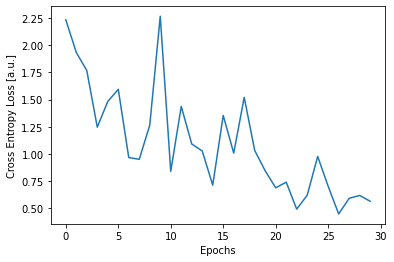

In [11]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss [a.u.]")

You should find that the loss drops as you train the network with more and more epochs.

Next, let's plot the accuracy curve. That is, the accuracy with respect to epochs:

Text(0, 0.5, 'Classification Accuracy [%]')

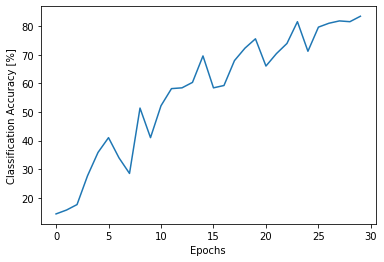

In [12]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), np.array(accuracy_values)*100.0)
plt.xlabel("Epochs")
plt.ylabel("Classification Accuracy [%]")

Does the training result gets better than the RNN in lecture 3 homework? If not, the reason might be:
- The dataset is too small
- The task is too easy to attention mechanism

## Part IV: RNN Interpretability

Network interpretability refers to the capability to explain each decision of the neural network. A traditional neural network model is black-box, meaning that we do not know which one or many features it utilize to make the classification decision. The beauty of attention mechanism is that: it provides us a straightforward way to interpret the decision of RNN or transformer network. In this part, we will leverage the attention score to find the origin of RNN classification power.

First, we will need to do some tweakings of the RNN neural network. In the following code block, copy/paste the RNN model you defined previously, and change the output from `x` to the attention score variable. Remember that the attention score is the output of softmax operation. What is the shape of the attention score? You can check it using torchsnooper.

**Notice**: Do not change anything in the `__init__` method, otherwise the neural network may fail loading.

In [18]:
class RNNInterpretor(nn.Module):
    def __init__(self):
        super(RNNInterpretor, self).__init__()
        '''
        Initialize RNN with attention mechanism with 3 parts:
            A feature extractor based on LSTM network
            A fully connected classifier
            An attention kernel
        '''
        input_size = 12 #12 LPC basis per input
        seq_len = 29    # Sequence length of Japanese Vowel data
        hidden_size = 128
        self.RNNLayer = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        fc1, fc2, fc3, fc4 = np.linspace(hidden_size*2, 64,4,dtype=int)
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc2, fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc3, fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc4, 9),
        )
        self.attention_weight = Parameter(torch.empty(hidden_size,hidden_size).uniform_(-0.1, 0.1))
    
    #@torchsnooper.snoop()    
    def forward(self, x):
            '''
            The forward operation of each training step of the neural network model
            '''
            batch_size = x.size(0) 
            output, (h, c) = self.RNNLayer(x)
            print('output', output.shape)
            '''
            Add attention mechanism here, you will need to code output and self.attention_weight together.
            ''' 

            w = self.attention_weight

            s = torch.matmul( output[0,:,:] , torch.matmul( w , h[0,0,:] ))
            #print('h', h[0,0,:].shape)
            print('s', s)

            score = nn.Softmax(dim =0)(s)
            print('score',score)

            context = torch.matmul(score,output)
            attention =  torch.cat((h[0,:,:], context), dim = 1)

            x = attention.view(batch_size, -1)    
            x = self.fcnet(attention)

            return score

Then, we will load the parameters we saved from the trained RNN to build an interpretor network:

In [19]:
interpretor = RNNInterpretor()
pretrained_dict = torch.load('RNN.pt')
model_dict = interpretor.state_dict()
model_dict.update(pretrained_dict) 
interpretor.load_state_dict(pretrained_dict)

<All keys matched successfully>

Then, we will pull out a batch of event from the test loader and plot its attention score. The attention score refects the relative importance of each time slices. Since attention score will sum to 1, it can also be treated as the relative weight of each time slice:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


output torch.Size([4, 29, 128])
s tensor([-0.2292, -0.2515, -0.1789, -0.0576,  0.0856,  0.2807,  0.4818,  0.5961,
         0.5949,  0.2113, -0.1052, -0.3403, -0.5141, -0.6416, -0.7342, -0.8006,
        -0.8471, -0.8786, -0.8989, -0.9110, -0.9175, -0.9201, -0.9203, -0.9191,
        -0.9171, -0.9150, -0.9129, -0.9111, -0.9096], grad_fn=<MvBackward0>)
score tensor([0.0376, 0.0367, 0.0395, 0.0446, 0.0515, 0.0625, 0.0765, 0.0857, 0.0856,
        0.0584, 0.0425, 0.0336, 0.0283, 0.0249, 0.0227, 0.0212, 0.0202, 0.0196,
        0.0192, 0.0190, 0.0189, 0.0188, 0.0188, 0.0188, 0.0189, 0.0189, 0.0190,
        0.0190, 0.0190], grad_fn=<SoftmaxBackward0>)


No handles with labels found to put in legend.


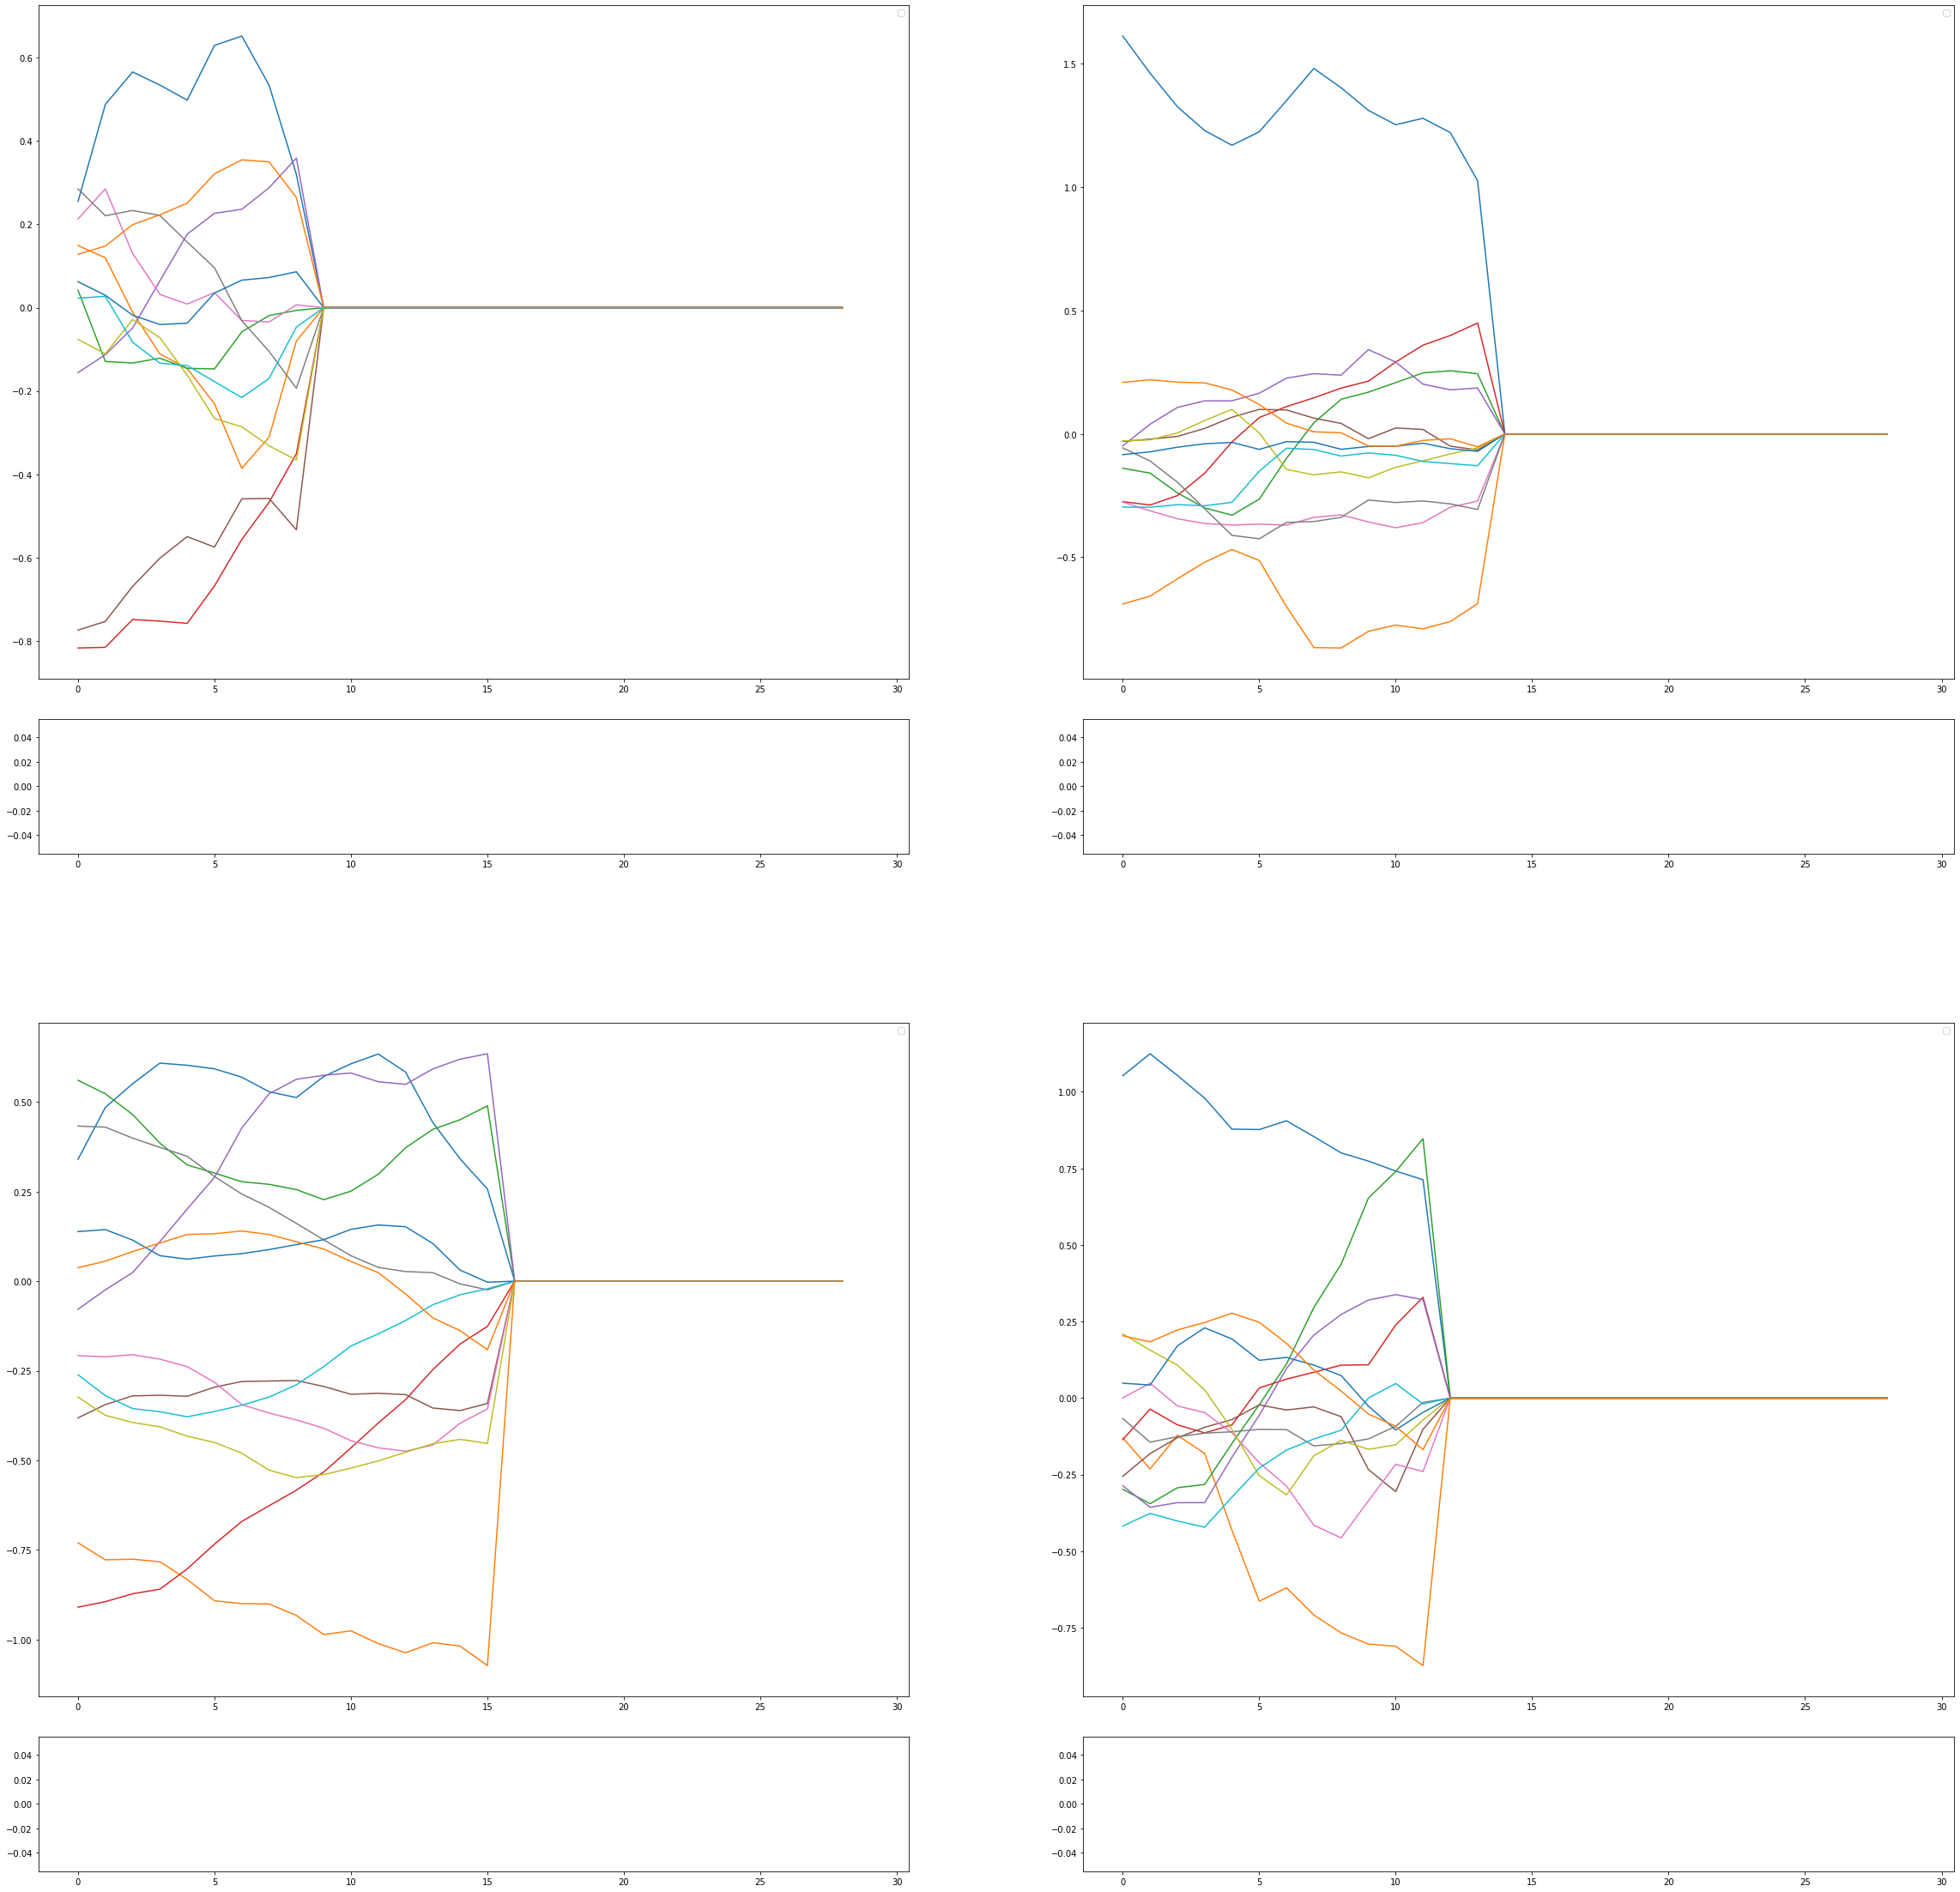

In [20]:
#############################################
# Feed event through the interpretor to get attention score
test_event, test_label = next(iter(test_loader))
test_event = test_event.to(DEVICE).float()
attention_score = interpretor(test_event)
#############################################

interpretor.eval()
batch_size = len(test_label)
fig = plt.figure(figsize=(40,40))
cellc = int(math.ceil((batch_size**0.5)))
outer = gridspec.GridSpec(cellc, cellc, wspace=0.2, hspace=0.2)
for i in range(batch_size):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1, height_ratios=[5,1])
    attention = torch.sum(attention_score[i],dim=-1).cpu().data.numpy().flatten() # The last dimension of attention score is the hidden size (128) in default case, we will sum over this dimension to get the attention score for this time inde
    attention -= np.average(attention) # Only plot the variance of attention to see trends
    current_vowel = test_event[i]
    
    ax_main = plt.Subplot(fig, inner[0])
    vowel_length, lpc_basis = current_vowel.shape
    for j in range(lpc_basis):
        ax_main.plot(np.arange(vowel_length), current_vowel[:,j])
    ax_main.legend()
    fig.add_subplot(ax_main)

    ax_attention = plt.Subplot(fig, inner[1], sharex=ax_main)
    ax_attention.bar(x=np.arange(vowel_length)+0.5,height=attention, width=1)
    fig.add_subplot(ax_attention)
plt.show()
plt.cla()
plt.clf()
plt.close()

**Question:** How does the attention score reflects the classification power of RNN? Since we perform 0 embedding onto the data to make them equal in length, all input should contain several 0s towards the end. Does this 0-embedded region exhibit high attention score? In other words, does the RNN classifier pay attention to the embedded 0s?